# Applying XID+CIGALE to Extreme Starbursts
In this notebook, we read in the data files and prepare them for fitting with XID+CIGALE, the SED prior model extension to XID+. Here we focus on sources in [Rowan-Robinson et al. 2018](https://arxiv.org/abs/1704.07783) and claimed to have a star formation rate of $> 10^{3}\mathrm{M_{\odot}yr^{-1}}$

Import required modules

In [1]:
from astropy.io import ascii, fits
from astropy.table import Table
import pylab as plt
%matplotlib inline
from astropy import wcs
import seaborn as sns
import glob


import numpy as np
import xidplus
from xidplus import moc_routines
import pickle
import os
from ESB_functions import *

In [2]:

emulator_path=['/Users/pdh21/Google_Drive/WORK/XID_plus/docs/notebooks/examples/SED_emulator/CIGALE_emulator_20210420_log10sfr_uniformAGN_z.npz']
field=['Lockman-SWIRE']
path_to_SPIRE=['/Volumes/pdh_storage/dmu_products/dmu19/dmu19_HELP-SPIRE-maps/data/']
redshift_file=["/Volumes/pdh_storage/dmu_products/dmu24/dmu24_Lockman-SWIRE/data/master_catalogue_Lockman-SWIRE_20170710_photoz_20170802_r_and_irac1_optimised_UPDATED_IDs_20180219.fits"]




In [3]:
# Parameters
emulator_path = [
    "/users/pdh21/Work/XID_plus/docs/notebooks/examples/SED_emulator/CIGALE_emulator_20210420_log10sfr_uniformAGN_z.npz"
]
field = ["Lockman-SWIRE"]
path_to_SPIRE = ["/users/pdh21/Work/Extreme_submm_SB_gals/data/"]
redshift_file = [
    "/users/pdh21/Work/Extreme_submm_SB_gals/data/master_catalogue_Lockman-SWIRE_20170710_photoz_20170802_r_and_irac1_optimised_UPDATED_IDs_20180219.fits"
]


In [4]:
try:
    source = [np.int(os.environ['SGE_TASK_ID'])-1]
except:
    source=[1]

In [5]:
#ysb=Table.read('../../../data/MRRfiles/fromPaper.txt', format='ascii')
esb=Table.read('../../../data/MRR2018_tables/{}_sources.csv'.format(field[0]),format='ascii',encoding='utf-8')


In [6]:
priors,prior_list=process_prior(
                path_to_data=['../../../data/'],
                  source=source,
                  field=field,
                  path_to_SPIRE=path_to_SPIRE,
                  redshift_file=redshift_file,
                  redshift_prior=[0.1,2.0])
xidplus.save(priors,None,'./output/{}/prior_'.format(field[0])+esb['field'][source[0]]+'_'+str(source[0])+'_model1')
prior_list.write('./output/{}/prior_list_'.format(field[0])+esb['field'][source[0]]+'_'+str(source[0])+'_model1.ascii',format='ascii',overwrite=True)

0


fitting 278 sources 

using 866, 451 and 216 pixels
source density = 114551.7102101388


In [7]:
def create_phys_prior(priors,prior_list,emulator_path):
    z_mu=np.empty((priors[1].nsrc))
    z_sig=np.empty((priors[1].nsrc))

    for x,i in enumerate(priors[1].ID):
        
        ind=prior_list['help_id']==str(i)
        z_mu[x]=prior_list['redshift'][ind]
        z_sig[x]=prior_list['redshift_unc'][ind]

    

    sfr_mu=1.5*z_mu+1.0
    sfr_sig=np.full(priors[1].nsrc,0.5)

    agn_frac_mu=np.full(priors[1].nsrc,-1)
    agn_frac_sig=np.full(priors[1].nsrc,1)
    params_mu=np.vstack((sfr_mu,z_mu)).T
    params_sig=np.vstack((sfr_sig,z_sig)).T
    params_names=['log10sfr','z']
    
    return xidplus.hier_prior(priors[1].ID,params_mu,params_sig,params_names,emulator_path[0])

In [8]:
hier_params={'m_mu':0.8,'m_sig':0.4,'c_mu':-1.0,'c_sig':0.5,'sfr_disp':0.5}
phys_prior=create_phys_prior(priors,prior_list,emulator_path)

In [9]:
from numpyro.infer import Predictive
from jax import random, vmap
from xidplus.numpyro_fit import SED_prior

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

In [10]:

## For numpyro to sample from the prior, the data needs to be set to None
import copy
#make a deepcopy of the priors
priors_prior_pred=copy.deepcopy(priors)
#set data to None
for i in range(0,len(priors)):
    priors_prior_pred[i].sim=None

In [11]:
%%time 
#sample from the prior using numpyro's Predictive function
prior_predictive=Predictive(SED_prior.spire_model_CIGALE,posterior_samples = {}, num_samples = 1000,)
prior_pred=prior_predictive(random.PRNGKey(0),priors_prior_pred,phys_prior,hier_params)

CPU times: user 7.21 s, sys: 85 ms, total: 7.29 s
Wall time: 7.19 s


## First pass

In [12]:
import numpyro
from numpyro.diagnostics import summary
import jax.numpy as jnp
from numpyro.infer import NUTS,MCMC
import os
numpyro.set_host_device_count(4)
from operator import attrgetter

def fit_model(phys_prior,hier_params,num_samples=500, num_warmup=500,num_chains=4,chain_method='parallel'):
    nuts_kernel = NUTS(SED_prior.spire_model_CIGALE,init_strategy=numpyro.infer.init_to_feasible())
    mcmc = MCMC(nuts_kernel, num_samples=num_samples, num_warmup=num_warmup,num_chains=num_chains,chain_method=chain_method)
    rng_key = random.PRNGKey(0)
    mcmc.run(rng_key,priors,phys_prior,hier_params)
    return mcmc

In [13]:
n_chains=4
mcmc=fit_model(phys_prior,hier_params,num_samples=500, num_warmup=500,num_chains=n_chains,chain_method='parallel')

  0%|          | 0/1000 [00:00<?, ?it/s]

warmup:   0%|          | 1/1000 [00:06<1:49:55,  6.60s/it, 1 steps of size 2.34e+00. acc. prob=0.00]

warmup:   1%|          | 6/1000 [00:06<13:45,  1.20it/s, 84 steps of size 1.48e-03. acc. prob=0.32] 

warmup:   1%|          | 9/1000 [00:09<14:51,  1.11it/s, 1023 steps of size 4.43e-04. acc. prob=0.45]

warmup:   1%|          | 11/1000 [00:11<15:16,  1.08it/s, 1023 steps of size 1.46e-03. acc. prob=0.55]

warmup:   1%|          | 12/1000 [00:12<15:26,  1.07it/s, 1023 steps of size 2.73e-03. acc. prob=0.58]

warmup:   1%|▏         | 13/1000 [00:13<15:36,  1.05it/s, 1023 steps of size 4.23e-03. acc. prob=0.61]

warmup:   1%|▏         | 14/1000 [00:14<15:44,  1.04it/s, 1023 steps of size 7.48e-03. acc. prob=0.64]

warmup:   2%|▏         | 15/1000 [00:15<13:54,  1.18it/s, 511 steps of size 3.08e-03. acc. prob=0.63] 

warmup:   2%|▏         | 16/1000 [00:16<14:30,  1.13it/s, 1023 steps of size 3.87e-03. acc. prob=0.64]

warmup:   2%|▏         | 17/1000 [00:17<14:57,  1.10it/s, 1023 steps of size 5.70e-03. acc. prob=0.66]

warmup:   2%|▏         | 18/1000 [00:18<15:17,  1.07it/s, 1023 steps of size 8.59e-03. acc. prob=0.67]

warmup:   2%|▏         | 19/1000 [00:18<11:37,  1.41it/s, 148 steps of size 3.66e-03. acc. prob=0.66] 

warmup:   2%|▏         | 20/1000 [00:19<12:56,  1.26it/s, 1023 steps of size 6.65e-03. acc. prob=0.68]

warmup:   2%|▏         | 21/1000 [00:20<13:52,  1.18it/s, 1023 steps of size 5.30e-03. acc. prob=0.68]

warmup:   2%|▏         | 22/1000 [00:21<14:31,  1.12it/s, 1023 steps of size 7.41e-03. acc. prob=0.69]

warmup:   2%|▏         | 23/1000 [00:21<12:36,  1.29it/s, 511 steps of size 1.31e-02. acc. prob=0.70] 

warmup:   2%|▎         | 25/1000 [00:22<10:31,  1.54it/s, 1023 steps of size 2.66e-03. acc. prob=0.68]

warmup:   3%|▎         | 26/1000 [00:23<11:58,  1.36it/s, 1023 steps of size 4.70e-03. acc. prob=0.70]

warmup:   3%|▎         | 27/1000 [00:24<13:06,  1.24it/s, 1023 steps of size 2.71e-03. acc. prob=0.69]

warmup:   3%|▎         | 28/1000 [00:25<13:53,  1.17it/s, 1023 steps of size 3.76e-03. acc. prob=0.70]

warmup:   3%|▎         | 29/1000 [00:26<14:30,  1.12it/s, 1023 steps of size 5.14e-03. acc. prob=0.71]

warmup:   3%|▎         | 30/1000 [00:27<14:55,  1.08it/s, 1023 steps of size 4.63e-03. acc. prob=0.71]

warmup:   3%|▎         | 31/1000 [00:28<15:14,  1.06it/s, 1023 steps of size 4.93e-03. acc. prob=0.71]

warmup:   3%|▎         | 32/1000 [00:29<15:27,  1.04it/s, 1023 steps of size 8.50e-03. acc. prob=0.72]

warmup:   3%|▎         | 33/1000 [00:30<12:27,  1.29it/s, 342 steps of size 3.21e-03. acc. prob=0.71] 

warmup:   3%|▎         | 34/1000 [00:31<13:29,  1.19it/s, 1023 steps of size 2.91e-03. acc. prob=0.71]

warmup:   4%|▎         | 35/1000 [00:32<14:12,  1.13it/s, 1023 steps of size 4.17e-03. acc. prob=0.72]

warmup:   4%|▎         | 36/1000 [00:33<14:41,  1.09it/s, 1023 steps of size 4.79e-03. acc. prob=0.72]

warmup:   4%|▎         | 37/1000 [00:34<15:04,  1.06it/s, 1023 steps of size 6.68e-03. acc. prob=0.72]

warmup:   4%|▍         | 38/1000 [00:35<15:19,  1.05it/s, 1023 steps of size 9.18e-03. acc. prob=0.73]

warmup:   4%|▍         | 39/1000 [00:35<11:21,  1.41it/s, 136 steps of size 1.70e-03. acc. prob=0.71] 

warmup:   4%|▍         | 40/1000 [00:36<12:41,  1.26it/s, 1023 steps of size 2.26e-03. acc. prob=0.72]

warmup:   4%|▍         | 41/1000 [00:37<13:41,  1.17it/s, 1023 steps of size 3.72e-03. acc. prob=0.72]

warmup:   4%|▍         | 42/1000 [00:38<14:19,  1.11it/s, 1023 steps of size 2.80e-03. acc. prob=0.72]

warmup:   4%|▍         | 43/1000 [00:39<14:47,  1.08it/s, 1023 steps of size 4.32e-03. acc. prob=0.73]

warmup:   4%|▍         | 44/1000 [00:40<15:04,  1.06it/s, 1023 steps of size 5.90e-03. acc. prob=0.73]

warmup:   4%|▍         | 45/1000 [00:41<15:16,  1.04it/s, 1023 steps of size 9.64e-03. acc. prob=0.74]

warmup:   5%|▍         | 46/1000 [00:41<11:15,  1.41it/s, 124 steps of size 3.54e-03. acc. prob=0.73] 

warmup:   5%|▍         | 47/1000 [00:42<12:35,  1.26it/s, 1023 steps of size 5.68e-03. acc. prob=0.73]

warmup:   5%|▍         | 48/1000 [00:43<13:31,  1.17it/s, 1023 steps of size 9.39e-03. acc. prob=0.74]

warmup:   5%|▍         | 49/1000 [00:43<11:49,  1.34it/s, 511 steps of size 2.00e-03. acc. prob=0.73] 

warmup:   5%|▌         | 50/1000 [00:44<12:59,  1.22it/s, 1023 steps of size 3.38e-03. acc. prob=0.73]

warmup:   5%|▌         | 51/1000 [00:45<13:55,  1.14it/s, 1023 steps of size 5.21e-03. acc. prob=0.74]

warmup:   5%|▌         | 52/1000 [00:46<14:26,  1.09it/s, 1023 steps of size 7.21e-03. acc. prob=0.74]

warmup:   5%|▌         | 53/1000 [00:47<12:26,  1.27it/s, 511 steps of size 2.71e-03. acc. prob=0.73] 

warmup:   5%|▌         | 54/1000 [00:48<13:31,  1.17it/s, 1023 steps of size 4.33e-03. acc. prob=0.74]

warmup:   6%|▌         | 55/1000 [00:49<14:10,  1.11it/s, 1023 steps of size 5.07e-03. acc. prob=0.74]

warmup:   6%|▌         | 56/1000 [00:50<14:35,  1.08it/s, 1023 steps of size 7.61e-03. acc. prob=0.74]

warmup:   6%|▌         | 57/1000 [00:50<12:32,  1.25it/s, 511 steps of size 1.64e-03. acc. prob=0.73] 

warmup:   6%|▌         | 58/1000 [00:51<13:26,  1.17it/s, 1023 steps of size 2.33e-03. acc. prob=0.74]

warmup:   6%|▌         | 59/1000 [00:52<14:03,  1.12it/s, 1023 steps of size 3.06e-03. acc. prob=0.74]

warmup:   6%|▌         | 60/1000 [00:53<14:30,  1.08it/s, 1023 steps of size 3.84e-03. acc. prob=0.74]

warmup:   6%|▌         | 61/1000 [00:54<14:48,  1.06it/s, 1023 steps of size 3.05e-03. acc. prob=0.74]

warmup:   6%|▌         | 62/1000 [00:55<14:59,  1.04it/s, 1023 steps of size 4.30e-03. acc. prob=0.74]

warmup:   6%|▋         | 63/1000 [00:56<15:08,  1.03it/s, 1023 steps of size 3.10e-03. acc. prob=0.74]

warmup:   6%|▋         | 64/1000 [00:57<15:14,  1.02it/s, 1023 steps of size 3.35e-03. acc. prob=0.74]

warmup:   6%|▋         | 65/1000 [00:58<15:18,  1.02it/s, 1023 steps of size 5.36e-03. acc. prob=0.75]

warmup:   7%|▋         | 66/1000 [00:59<15:19,  1.02it/s, 1023 steps of size 6.94e-03. acc. prob=0.75]

warmup:   7%|▋         | 67/1000 [01:00<15:20,  1.01it/s, 1023 steps of size 2.42e-03. acc. prob=0.74]

warmup:   7%|▋         | 68/1000 [01:01<15:20,  1.01it/s, 1023 steps of size 2.85e-03. acc. prob=0.74]

warmup:   7%|▋         | 69/1000 [01:02<15:20,  1.01it/s, 1023 steps of size 4.53e-03. acc. prob=0.75]

warmup:   7%|▋         | 70/1000 [01:03<15:21,  1.01it/s, 1023 steps of size 6.59e-03. acc. prob=0.75]

warmup:   7%|▋         | 71/1000 [01:04<15:22,  1.01it/s, 1023 steps of size 5.64e-03. acc. prob=0.75]

warmup:   7%|▋         | 72/1000 [01:05<15:21,  1.01it/s, 1023 steps of size 1.84e-03. acc. prob=0.74]

warmup:   7%|▋         | 73/1000 [01:06<15:20,  1.01it/s, 1023 steps of size 2.90e-03. acc. prob=0.75]

warmup:   7%|▋         | 74/1000 [01:07<15:18,  1.01it/s, 1023 steps of size 4.02e-03. acc. prob=0.75]

warmup:   8%|▊         | 75/1000 [01:08<15:17,  1.01it/s, 1023 steps of size 6.16e-03. acc. prob=0.75]

warmup:   8%|▊         | 76/1000 [01:09<15:17,  1.01it/s, 1023 steps of size 7.08e-03. acc. prob=0.75]

warmup:   8%|▊         | 77/1000 [01:10<15:16,  1.01it/s, 1023 steps of size 4.96e-03. acc. prob=0.75]

warmup:   8%|▊         | 78/1000 [01:11<15:14,  1.01it/s, 1023 steps of size 5.93e-03. acc. prob=0.75]

warmup:   8%|▊         | 79/1000 [01:12<15:12,  1.01it/s, 1023 steps of size 7.59e-03. acc. prob=0.75]

warmup:   8%|▊         | 80/1000 [01:13<12:55,  1.19it/s, 511 steps of size 5.10e-03. acc. prob=0.75] 

warmup:   8%|▊         | 81/1000 [01:14<13:37,  1.12it/s, 1023 steps of size 6.33e-03. acc. prob=0.75]

warmup:   8%|▊         | 82/1000 [01:15<14:04,  1.09it/s, 1023 steps of size 6.55e-03. acc. prob=0.75]

warmup:   8%|▊         | 83/1000 [01:16<14:22,  1.06it/s, 1023 steps of size 9.73e-03. acc. prob=0.76]

warmup:   8%|▊         | 84/1000 [01:16<11:44,  1.30it/s, 379 steps of size 4.64e-03. acc. prob=0.75] 

warmup:   8%|▊         | 85/1000 [01:17<12:44,  1.20it/s, 1023 steps of size 5.31e-03. acc. prob=0.75]

warmup:   9%|▊         | 86/1000 [01:18<13:25,  1.13it/s, 1023 steps of size 3.65e-03. acc. prob=0.75]

warmup:   9%|▊         | 87/1000 [01:19<13:56,  1.09it/s, 1023 steps of size 5.56e-03. acc. prob=0.76]

warmup:   9%|▉         | 88/1000 [01:20<14:15,  1.07it/s, 1023 steps of size 3.52e-03. acc. prob=0.75]

warmup:   9%|▉         | 89/1000 [01:21<14:29,  1.05it/s, 1023 steps of size 4.13e-03. acc. prob=0.75]

warmup:   9%|▉         | 90/1000 [01:22<14:42,  1.03it/s, 1023 steps of size 5.37e-03. acc. prob=0.76]

warmup:   9%|▉         | 91/1000 [01:23<14:46,  1.02it/s, 1023 steps of size 7.07e-03. acc. prob=0.76]

warmup:   9%|▉         | 92/1000 [01:24<14:51,  1.02it/s, 1023 steps of size 4.43e-03. acc. prob=0.76]

warmup:   9%|▉         | 93/1000 [01:25<14:53,  1.02it/s, 1023 steps of size 5.34e-03. acc. prob=0.76]

warmup:   9%|▉         | 94/1000 [01:26<14:53,  1.01it/s, 1023 steps of size 6.29e-03. acc. prob=0.76]

warmup:  10%|▉         | 95/1000 [01:27<14:53,  1.01it/s, 1023 steps of size 8.01e-03. acc. prob=0.76]

warmup:  10%|▉         | 96/1000 [01:27<12:40,  1.19it/s, 511 steps of size 3.71e-03. acc. prob=0.76] 

warmup:  10%|▉         | 97/1000 [01:28<13:21,  1.13it/s, 1023 steps of size 3.69e-03. acc. prob=0.76]

warmup:  10%|▉         | 98/1000 [01:29<13:48,  1.09it/s, 1023 steps of size 4.95e-03. acc. prob=0.76]

warmup:  10%|▉         | 99/1000 [01:30<14:06,  1.06it/s, 1023 steps of size 4.32e-03. acc. prob=0.76]

warmup:  10%|█         | 100/1000 [01:31<14:19,  1.05it/s, 1023 steps of size 3.35e-03. acc. prob=0.76]

warmup:  10%|█         | 101/1000 [01:32<14:27,  1.04it/s, 1023 steps of size 4.63e-02. acc. prob=0.76]

warmup:  10%|█         | 103/1000 [01:33<09:30,  1.57it/s, 511 steps of size 1.47e-02. acc. prob=0.75] 

warmup:  10%|█         | 104/1000 [01:33<08:03,  1.85it/s, 255 steps of size 1.43e-02. acc. prob=0.75]

warmup:  10%|█         | 105/1000 [01:34<07:54,  1.88it/s, 511 steps of size 1.00e-02. acc. prob=0.75]

warmup:  11%|█         | 106/1000 [01:34<07:47,  1.91it/s, 511 steps of size 1.78e-02. acc. prob=0.76]

warmup:  11%|█         | 107/1000 [01:34<06:38,  2.24it/s, 255 steps of size 3.12e-02. acc. prob=0.76]

warmup:  11%|█         | 108/1000 [01:34<05:16,  2.82it/s, 127 steps of size 2.56e-02. acc. prob=0.76]

warmup:  11%|█         | 109/1000 [01:35<04:48,  3.09it/s, 255 steps of size 4.78e-02. acc. prob=0.76]

warmup:  11%|█         | 111/1000 [01:36<05:58,  2.48it/s, 1023 steps of size 1.19e-02. acc. prob=0.76]

warmup:  11%|█         | 112/1000 [01:36<06:18,  2.35it/s, 511 steps of size 1.82e-02. acc. prob=0.76] 

warmup:  11%|█▏        | 113/1000 [01:36<05:37,  2.63it/s, 255 steps of size 1.71e-02. acc. prob=0.76]

warmup:  11%|█▏        | 114/1000 [01:37<05:05,  2.90it/s, 255 steps of size 2.53e-02. acc. prob=0.76]

warmup:  12%|█▏        | 115/1000 [01:37<04:41,  3.15it/s, 255 steps of size 3.87e-03. acc. prob=0.76]

warmup:  12%|█▏        | 116/1000 [01:38<07:30,  1.96it/s, 1023 steps of size 6.04e-03. acc. prob=0.76]

warmup:  12%|█▏        | 117/1000 [01:39<09:33,  1.54it/s, 1023 steps of size 7.64e-03. acc. prob=0.76]

warmup:  12%|█▏        | 118/1000 [01:39<08:53,  1.65it/s, 511 steps of size 1.12e-02. acc. prob=0.76] 

warmup:  12%|█▏        | 119/1000 [01:40<08:25,  1.74it/s, 511 steps of size 2.03e-02. acc. prob=0.76]

warmup:  12%|█▏        | 120/1000 [01:40<06:59,  2.10it/s, 255 steps of size 2.22e-02. acc. prob=0.76]

warmup:  12%|█▏        | 121/1000 [01:40<06:00,  2.44it/s, 255 steps of size 7.74e-03. acc. prob=0.76]

warmup:  12%|█▏        | 122/1000 [01:41<06:22,  2.30it/s, 511 steps of size 1.37e-02. acc. prob=0.76]

warmup:  12%|█▏        | 123/1000 [01:41<05:33,  2.63it/s, 255 steps of size 2.17e-02. acc. prob=0.76]

warmup:  12%|█▏        | 124/1000 [01:41<04:58,  2.93it/s, 255 steps of size 3.49e-02. acc. prob=0.76]

warmup:  13%|█▎        | 126/1000 [01:42<04:30,  3.23it/s, 511 steps of size 2.33e-02. acc. prob=0.76]

warmup:  13%|█▎        | 127/1000 [01:42<04:17,  3.39it/s, 255 steps of size 3.19e-03. acc. prob=0.76]

warmup:  13%|█▎        | 128/1000 [01:43<06:56,  2.10it/s, 1023 steps of size 4.77e-03. acc. prob=0.76]

warmup:  13%|█▎        | 129/1000 [01:44<08:58,  1.62it/s, 1023 steps of size 7.86e-03. acc. prob=0.76]

warmup:  13%|█▎        | 130/1000 [01:45<08:28,  1.71it/s, 511 steps of size 1.34e-02. acc. prob=0.76] 

warmup:  13%|█▎        | 131/1000 [01:45<08:05,  1.79it/s, 511 steps of size 2.11e-02. acc. prob=0.77]

warmup:  13%|█▎        | 132/1000 [01:45<06:47,  2.13it/s, 255 steps of size 1.24e-02. acc. prob=0.76]

warmup:  13%|█▎        | 133/1000 [01:46<06:53,  2.10it/s, 511 steps of size 1.36e-02. acc. prob=0.76]

warmup:  13%|█▎        | 134/1000 [01:46<06:57,  2.07it/s, 511 steps of size 2.06e-02. acc. prob=0.77]

warmup:  14%|█▎        | 135/1000 [01:47<05:57,  2.42it/s, 255 steps of size 3.06e-02. acc. prob=0.77]

warmup:  14%|█▎        | 137/1000 [01:48<06:33,  2.19it/s, 1023 steps of size 7.51e-03. acc. prob=0.76]

warmup:  14%|█▍        | 138/1000 [01:49<08:28,  1.70it/s, 1023 steps of size 1.17e-02. acc. prob=0.77]

warmup:  14%|█▍        | 139/1000 [01:49<08:06,  1.77it/s, 511 steps of size 1.89e-02. acc. prob=0.77] 

warmup:  14%|█▍        | 140/1000 [01:49<06:52,  2.09it/s, 255 steps of size 2.68e-02. acc. prob=0.77]

warmup:  14%|█▍        | 141/1000 [01:50<05:26,  2.63it/s, 127 steps of size 4.75e-03. acc. prob=0.76]

warmup:  14%|█▍        | 142/1000 [01:51<07:55,  1.80it/s, 1023 steps of size 7.01e-03. acc. prob=0.76]

warmup:  14%|█▍        | 143/1000 [01:52<09:47,  1.46it/s, 1023 steps of size 9.84e-03. acc. prob=0.77]

warmup:  14%|█▍        | 144/1000 [01:52<08:59,  1.59it/s, 511 steps of size 1.55e-02. acc. prob=0.77] 

warmup:  14%|█▍        | 145/1000 [01:52<07:22,  1.93it/s, 255 steps of size 2.06e-02. acc. prob=0.77]

warmup:  15%|█▍        | 146/1000 [01:53<06:14,  2.28it/s, 255 steps of size 2.51e-02. acc. prob=0.77]

warmup:  15%|█▍        | 147/1000 [01:53<05:25,  2.62it/s, 255 steps of size 2.52e-02. acc. prob=0.77]

warmup:  15%|█▍        | 148/1000 [01:53<04:51,  2.92it/s, 255 steps of size 4.51e-03. acc. prob=0.76]

warmup:  15%|█▍        | 149/1000 [01:54<07:37,  1.86it/s, 1023 steps of size 7.34e-03. acc. prob=0.77]

warmup:  15%|█▌        | 150/1000 [01:54<07:26,  1.90it/s, 511 steps of size 1.07e-02. acc. prob=0.77] 

warmup:  15%|█▌        | 151/1000 [01:55<07:18,  1.93it/s, 511 steps of size 1.52e-01. acc. prob=0.77]

warmup:  15%|█▌        | 153/1000 [01:55<04:20,  3.25it/s, 127 steps of size 2.01e-02. acc. prob=0.76]

warmup:  15%|█▌        | 154/1000 [01:55<04:08,  3.41it/s, 255 steps of size 1.24e-02. acc. prob=0.76]

warmup:  16%|█▌        | 155/1000 [01:56<04:52,  2.89it/s, 511 steps of size 1.59e-02. acc. prob=0.76]

warmup:  16%|█▌        | 156/1000 [01:56<04:30,  3.12it/s, 255 steps of size 2.62e-02. acc. prob=0.77]

warmup:  16%|█▌        | 157/1000 [01:56<04:13,  3.33it/s, 255 steps of size 9.71e-03. acc. prob=0.76]

warmup:  16%|█▌        | 158/1000 [01:57<05:00,  2.81it/s, 511 steps of size 1.76e-02. acc. prob=0.77]

warmup:  16%|█▌        | 159/1000 [01:57<04:33,  3.07it/s, 255 steps of size 1.97e-02. acc. prob=0.77]

warmup:  16%|█▌        | 160/1000 [01:57<04:14,  3.30it/s, 255 steps of size 3.30e-02. acc. prob=0.77]

warmup:  16%|█▌        | 162/1000 [01:58<05:29,  2.54it/s, 1023 steps of size 4.90e-03. acc. prob=0.76]

warmup:  16%|█▋        | 163/1000 [01:59<07:32,  1.85it/s, 1023 steps of size 9.22e-03. acc. prob=0.77]

warmup:  16%|█▋        | 164/1000 [02:00<07:22,  1.89it/s, 511 steps of size 1.51e-02. acc. prob=0.77] 

warmup:  16%|█▋        | 165/1000 [02:00<06:18,  2.21it/s, 255 steps of size 2.71e-02. acc. prob=0.77]

warmup:  17%|█▋        | 166/1000 [02:00<05:30,  2.52it/s, 255 steps of size 3.20e-03. acc. prob=0.76]

warmup:  17%|█▋        | 167/1000 [02:01<07:51,  1.77it/s, 1023 steps of size 5.43e-03. acc. prob=0.76]

warmup:  17%|█▋        | 168/1000 [02:02<09:33,  1.45it/s, 1023 steps of size 9.76e-03. acc. prob=0.77]

warmup:  17%|█▋        | 169/1000 [02:03<08:45,  1.58it/s, 511 steps of size 1.68e-02. acc. prob=0.77] 

warmup:  17%|█▋        | 170/1000 [02:03<07:10,  1.93it/s, 255 steps of size 3.07e-02. acc. prob=0.77]

warmup:  17%|█▋        | 171/1000 [02:03<05:28,  2.52it/s, 105 steps of size 7.87e-03. acc. prob=0.77]

warmup:  17%|█▋        | 172/1000 [02:04<05:54,  2.34it/s, 511 steps of size 1.44e-02. acc. prob=0.77]

warmup:  17%|█▋        | 173/1000 [02:04<06:11,  2.23it/s, 511 steps of size 1.48e-02. acc. prob=0.77]

warmup:  17%|█▋        | 174/1000 [02:04<05:21,  2.57it/s, 255 steps of size 1.92e-02. acc. prob=0.77]

warmup:  18%|█▊        | 175/1000 [02:05<04:46,  2.88it/s, 255 steps of size 2.52e-02. acc. prob=0.77]

warmup:  18%|█▊        | 176/1000 [02:05<04:06,  3.34it/s, 191 steps of size 2.18e-02. acc. prob=0.77]

warmup:  18%|█▊        | 177/1000 [02:05<03:54,  3.51it/s, 255 steps of size 1.92e-02. acc. prob=0.77]

warmup:  18%|█▊        | 178/1000 [02:05<03:46,  3.63it/s, 255 steps of size 1.09e-02. acc. prob=0.77]

warmup:  18%|█▊        | 179/1000 [02:06<04:40,  2.93it/s, 511 steps of size 1.24e-02. acc. prob=0.77]

warmup:  18%|█▊        | 180/1000 [02:06<05:23,  2.54it/s, 511 steps of size 2.13e-02. acc. prob=0.77]

warmup:  18%|█▊        | 181/1000 [02:07<04:47,  2.85it/s, 255 steps of size 3.16e-02. acc. prob=0.77]

warmup:  18%|█▊        | 183/1000 [02:08<05:50,  2.33it/s, 1023 steps of size 6.52e-03. acc. prob=0.77]

warmup:  18%|█▊        | 184/1000 [02:09<07:44,  1.76it/s, 1023 steps of size 6.60e-03. acc. prob=0.77]

warmup:  18%|█▊        | 185/1000 [02:10<09:14,  1.47it/s, 1023 steps of size 8.67e-03. acc. prob=0.77]

warmup:  19%|█▊        | 186/1000 [02:10<08:32,  1.59it/s, 511 steps of size 1.37e-02. acc. prob=0.77] 

warmup:  19%|█▊        | 187/1000 [02:10<07:05,  1.91it/s, 255 steps of size 2.20e-02. acc. prob=0.77]

warmup:  19%|█▉        | 188/1000 [02:11<06:01,  2.25it/s, 255 steps of size 3.42e-02. acc. prob=0.77]

warmup:  19%|█▉        | 190/1000 [02:11<04:51,  2.78it/s, 511 steps of size 1.10e-02. acc. prob=0.77]

warmup:  19%|█▉        | 191/1000 [02:12<05:17,  2.55it/s, 511 steps of size 1.26e-02. acc. prob=0.77]

warmup:  19%|█▉        | 192/1000 [02:12<05:38,  2.39it/s, 511 steps of size 2.03e-02. acc. prob=0.77]

warmup:  19%|█▉        | 193/1000 [02:12<05:01,  2.68it/s, 255 steps of size 2.78e-02. acc. prob=0.77]

warmup:  19%|█▉        | 194/1000 [02:13<04:05,  3.29it/s, 127 steps of size 1.80e-02. acc. prob=0.77]

warmup:  20%|█▉        | 195/1000 [02:13<03:52,  3.47it/s, 255 steps of size 1.20e-02. acc. prob=0.77]

warmup:  20%|█▉        | 196/1000 [02:13<04:40,  2.86it/s, 511 steps of size 4.63e-03. acc. prob=0.77]

warmup:  20%|█▉        | 197/1000 [02:14<07:11,  1.86it/s, 1023 steps of size 7.52e-03. acc. prob=0.77]

warmup:  20%|█▉        | 198/1000 [02:15<07:00,  1.91it/s, 511 steps of size 9.62e-03. acc. prob=0.77] 

warmup:  20%|█▉        | 199/1000 [02:15<06:53,  1.94it/s, 511 steps of size 1.35e-02. acc. prob=0.77]

warmup:  20%|██        | 200/1000 [02:16<05:49,  2.29it/s, 255 steps of size 1.67e-02. acc. prob=0.77]

warmup:  20%|██        | 201/1000 [02:16<05:06,  2.61it/s, 255 steps of size 1.13e-02. acc. prob=0.77]

warmup:  20%|██        | 202/1000 [02:16<05:32,  2.40it/s, 511 steps of size 1.69e-02. acc. prob=0.77]

warmup:  20%|██        | 203/1000 [02:17<04:52,  2.73it/s, 255 steps of size 1.21e-02. acc. prob=0.77]

warmup:  20%|██        | 204/1000 [02:17<05:22,  2.47it/s, 511 steps of size 1.15e-02. acc. prob=0.77]

warmup:  20%|██        | 205/1000 [02:18<05:43,  2.31it/s, 511 steps of size 1.78e-02. acc. prob=0.77]

warmup:  21%|██        | 206/1000 [02:18<04:59,  2.65it/s, 255 steps of size 2.59e-02. acc. prob=0.77]

warmup:  21%|██        | 207/1000 [02:18<04:10,  3.17it/s, 174 steps of size 1.22e-02. acc. prob=0.77]

warmup:  21%|██        | 208/1000 [02:18<04:54,  2.69it/s, 511 steps of size 1.66e-02. acc. prob=0.77]

warmup:  21%|██        | 209/1000 [02:19<04:24,  2.99it/s, 255 steps of size 1.08e-02. acc. prob=0.77]

warmup:  21%|██        | 210/1000 [02:19<05:02,  2.61it/s, 511 steps of size 1.20e-02. acc. prob=0.77]

warmup:  21%|██        | 211/1000 [02:20<05:28,  2.40it/s, 511 steps of size 1.53e-02. acc. prob=0.77]

warmup:  21%|██        | 212/1000 [02:20<04:48,  2.73it/s, 255 steps of size 1.64e-02. acc. prob=0.77]

warmup:  21%|██▏       | 213/1000 [02:20<04:20,  3.02it/s, 255 steps of size 1.16e-02. acc. prob=0.77]

warmup:  21%|██▏       | 214/1000 [02:21<04:59,  2.63it/s, 511 steps of size 1.64e-02. acc. prob=0.77]

warmup:  22%|██▏       | 215/1000 [02:21<04:27,  2.93it/s, 255 steps of size 1.56e-02. acc. prob=0.77]

warmup:  22%|██▏       | 216/1000 [02:21<04:05,  3.19it/s, 255 steps of size 1.71e-02. acc. prob=0.77]

warmup:  22%|██▏       | 217/1000 [02:21<03:50,  3.40it/s, 255 steps of size 1.84e-02. acc. prob=0.77]

warmup:  22%|██▏       | 218/1000 [02:22<03:39,  3.56it/s, 255 steps of size 1.65e-02. acc. prob=0.77]

warmup:  22%|██▏       | 219/1000 [02:22<03:31,  3.69it/s, 255 steps of size 1.48e-02. acc. prob=0.77]

warmup:  22%|██▏       | 220/1000 [02:22<03:26,  3.78it/s, 255 steps of size 8.99e-03. acc. prob=0.77]

warmup:  22%|██▏       | 221/1000 [02:23<04:20,  2.99it/s, 511 steps of size 1.37e-02. acc. prob=0.77]

warmup:  22%|██▏       | 222/1000 [02:23<03:59,  3.24it/s, 255 steps of size 1.70e-02. acc. prob=0.77]

warmup:  22%|██▏       | 223/1000 [02:23<03:45,  3.44it/s, 255 steps of size 2.06e-02. acc. prob=0.77]

warmup:  22%|██▏       | 224/1000 [02:23<03:36,  3.58it/s, 255 steps of size 1.63e-02. acc. prob=0.77]

warmup:  22%|██▎       | 225/1000 [02:24<03:29,  3.70it/s, 255 steps of size 1.99e-02. acc. prob=0.77]

warmup:  23%|██▎       | 226/1000 [02:24<03:24,  3.79it/s, 255 steps of size 2.78e-02. acc. prob=0.78]

warmup:  23%|██▎       | 228/1000 [02:24<03:27,  3.72it/s, 511 steps of size 1.19e-02. acc. prob=0.77]

warmup:  23%|██▎       | 229/1000 [02:25<04:10,  3.08it/s, 511 steps of size 1.17e-02. acc. prob=0.77]

warmup:  23%|██▎       | 230/1000 [02:25<04:44,  2.70it/s, 511 steps of size 1.17e-02. acc. prob=0.77]

warmup:  23%|██▎       | 231/1000 [02:26<05:10,  2.47it/s, 511 steps of size 1.59e-02. acc. prob=0.77]

warmup:  23%|██▎       | 232/1000 [02:26<04:37,  2.77it/s, 255 steps of size 2.20e-02. acc. prob=0.78]

warmup:  23%|██▎       | 233/1000 [02:26<04:12,  3.04it/s, 255 steps of size 1.47e-02. acc. prob=0.77]

warmup:  23%|██▎       | 234/1000 [02:27<03:55,  3.25it/s, 255 steps of size 1.36e-02. acc. prob=0.77]

warmup:  24%|██▎       | 235/1000 [02:27<03:42,  3.44it/s, 255 steps of size 1.73e-02. acc. prob=0.78]

warmup:  24%|██▎       | 236/1000 [02:27<03:32,  3.60it/s, 255 steps of size 1.63e-02. acc. prob=0.78]

warmup:  24%|██▎       | 237/1000 [02:27<03:26,  3.70it/s, 255 steps of size 2.39e-02. acc. prob=0.78]

warmup:  24%|██▍       | 238/1000 [02:28<03:22,  3.76it/s, 255 steps of size 1.98e-02. acc. prob=0.78]

warmup:  24%|██▍       | 239/1000 [02:28<03:18,  3.83it/s, 255 steps of size 2.87e-02. acc. prob=0.78]

warmup:  24%|██▍       | 241/1000 [02:28<02:38,  4.80it/s, 255 steps of size 8.12e-03. acc. prob=0.77]

warmup:  24%|██▍       | 242/1000 [02:29<03:31,  3.58it/s, 511 steps of size 1.19e-02. acc. prob=0.77]

warmup:  24%|██▍       | 243/1000 [02:29<04:14,  2.98it/s, 511 steps of size 9.48e-03. acc. prob=0.77]

warmup:  24%|██▍       | 244/1000 [02:30<04:46,  2.64it/s, 511 steps of size 1.29e-02. acc. prob=0.78]

warmup:  24%|██▍       | 245/1000 [02:30<05:11,  2.43it/s, 511 steps of size 1.15e-02. acc. prob=0.78]

warmup:  25%|██▍       | 246/1000 [02:31<05:28,  2.29it/s, 511 steps of size 1.45e-02. acc. prob=0.78]

warmup:  25%|██▍       | 247/1000 [02:31<04:47,  2.62it/s, 255 steps of size 1.49e-02. acc. prob=0.78]

warmup:  25%|██▍       | 248/1000 [02:31<04:18,  2.91it/s, 255 steps of size 1.19e-02. acc. prob=0.78]

warmup:  25%|██▍       | 249/1000 [02:32<04:51,  2.57it/s, 511 steps of size 1.34e-02. acc. prob=0.78]

warmup:  25%|██▌       | 250/1000 [02:32<05:15,  2.37it/s, 511 steps of size 1.90e-02. acc. prob=0.78]

warmup:  25%|██▌       | 251/1000 [02:32<04:36,  2.71it/s, 255 steps of size 1.83e-01. acc. prob=0.78]

warmup:  25%|██▌       | 253/1000 [02:33<02:51,  4.36it/s, 127 steps of size 1.57e-02. acc. prob=0.77]

warmup:  25%|██▌       | 254/1000 [02:33<02:54,  4.27it/s, 255 steps of size 2.18e-02. acc. prob=0.77]

warmup:  26%|██▌       | 255/1000 [02:33<02:57,  4.20it/s, 255 steps of size 6.24e-03. acc. prob=0.77]

warmup:  26%|██▌       | 256/1000 [02:34<05:30,  2.25it/s, 1023 steps of size 1.01e-02. acc. prob=0.77]

warmup:  26%|██▌       | 257/1000 [02:35<05:40,  2.18it/s, 511 steps of size 1.68e-02. acc. prob=0.77] 

warmup:  26%|██▌       | 258/1000 [02:35<04:55,  2.51it/s, 255 steps of size 2.79e-02. acc. prob=0.78]

warmup:  26%|██▌       | 259/1000 [02:35<03:56,  3.13it/s, 127 steps of size 4.71e-02. acc. prob=0.78]

warmup:  26%|██▌       | 261/1000 [02:36<05:02,  2.45it/s, 1023 steps of size 7.33e-03. acc. prob=0.77]

warmup:  26%|██▌       | 262/1000 [02:36<05:17,  2.32it/s, 511 steps of size 1.39e-02. acc. prob=0.77] 

warmup:  26%|██▋       | 263/1000 [02:37<04:42,  2.61it/s, 255 steps of size 9.43e-03. acc. prob=0.77]

warmup:  26%|██▋       | 264/1000 [02:37<05:04,  2.42it/s, 511 steps of size 1.73e-02. acc. prob=0.77]

warmup:  26%|██▋       | 265/1000 [02:37<04:30,  2.72it/s, 255 steps of size 2.93e-02. acc. prob=0.78]

warmup:  27%|██▋       | 266/1000 [02:38<03:39,  3.35it/s, 127 steps of size 1.84e-02. acc. prob=0.78]

warmup:  27%|██▋       | 267/1000 [02:38<03:28,  3.52it/s, 255 steps of size 9.52e-03. acc. prob=0.77]

warmup:  27%|██▋       | 268/1000 [02:38<04:17,  2.84it/s, 511 steps of size 1.49e-02. acc. prob=0.78]

warmup:  27%|██▋       | 269/1000 [02:39<03:55,  3.11it/s, 255 steps of size 1.27e-02. acc. prob=0.77]

warmup:  27%|██▋       | 270/1000 [02:39<04:32,  2.68it/s, 511 steps of size 2.23e-02. acc. prob=0.78]

warmup:  27%|██▋       | 271/1000 [02:39<04:05,  2.97it/s, 255 steps of size 2.12e-02. acc. prob=0.78]

warmup:  27%|██▋       | 272/1000 [02:40<03:45,  3.22it/s, 255 steps of size 1.21e-02. acc. prob=0.78]

warmup:  27%|██▋       | 273/1000 [02:40<04:26,  2.73it/s, 511 steps of size 1.51e-02. acc. prob=0.78]

warmup:  27%|██▋       | 274/1000 [02:40<04:00,  3.02it/s, 255 steps of size 2.18e-02. acc. prob=0.78]

warmup:  28%|██▊       | 275/1000 [02:41<03:41,  3.27it/s, 255 steps of size 1.75e-02. acc. prob=0.78]

warmup:  28%|██▊       | 276/1000 [02:41<03:29,  3.46it/s, 255 steps of size 1.91e-02. acc. prob=0.78]

warmup:  28%|██▊       | 277/1000 [02:41<03:20,  3.61it/s, 255 steps of size 2.29e-02. acc. prob=0.78]

warmup:  28%|██▊       | 278/1000 [02:41<03:13,  3.72it/s, 255 steps of size 3.41e-02. acc. prob=0.78]

warmup:  28%|██▊       | 279/1000 [02:41<02:42,  4.43it/s, 127 steps of size 2.96e-02. acc. prob=0.78]

warmup:  28%|██▊       | 280/1000 [02:42<02:20,  5.11it/s, 127 steps of size 1.04e-02. acc. prob=0.78]

warmup:  28%|██▊       | 281/1000 [02:42<03:25,  3.50it/s, 511 steps of size 1.21e-02. acc. prob=0.78]

warmup:  28%|██▊       | 282/1000 [02:42<03:17,  3.64it/s, 255 steps of size 2.06e-02. acc. prob=0.78]

warmup:  28%|██▊       | 283/1000 [02:43<03:11,  3.74it/s, 255 steps of size 3.15e-02. acc. prob=0.78]

warmup:  28%|██▊       | 284/1000 [02:43<02:40,  4.46it/s, 127 steps of size 3.60e-02. acc. prob=0.78]

warmup:  28%|██▊       | 285/1000 [02:43<02:19,  5.14it/s, 127 steps of size 1.92e-02. acc. prob=0.78]

warmup:  29%|██▊       | 286/1000 [02:43<02:30,  4.73it/s, 255 steps of size 2.29e-02. acc. prob=0.78]

warmup:  29%|██▊       | 287/1000 [02:43<02:39,  4.47it/s, 255 steps of size 1.23e-02. acc. prob=0.78]

warmup:  29%|██▉       | 288/1000 [02:44<03:37,  3.27it/s, 511 steps of size 1.27e-02. acc. prob=0.78]

warmup:  29%|██▉       | 289/1000 [02:44<03:25,  3.46it/s, 255 steps of size 1.52e-02. acc. prob=0.78]

warmup:  29%|██▉       | 290/1000 [02:44<03:16,  3.61it/s, 255 steps of size 2.55e-02. acc. prob=0.78]

warmup:  29%|██▉       | 291/1000 [02:45<03:10,  3.72it/s, 255 steps of size 3.60e-02. acc. prob=0.78]

warmup:  29%|██▉       | 293/1000 [02:45<02:27,  4.80it/s, 255 steps of size 2.27e-02. acc. prob=0.78]

warmup:  29%|██▉       | 294/1000 [02:45<02:34,  4.58it/s, 255 steps of size 3.61e-02. acc. prob=0.78]

warmup:  30%|██▉       | 296/1000 [02:46<02:43,  4.30it/s, 511 steps of size 1.05e-02. acc. prob=0.78]

warmup:  30%|██▉       | 297/1000 [02:46<03:25,  3.42it/s, 511 steps of size 1.46e-02. acc. prob=0.78]

warmup:  30%|██▉       | 298/1000 [02:46<03:17,  3.55it/s, 255 steps of size 2.12e-02. acc. prob=0.78]

warmup:  30%|██▉       | 299/1000 [02:47<03:11,  3.66it/s, 255 steps of size 3.13e-02. acc. prob=0.78]

warmup:  30%|███       | 300/1000 [02:47<02:43,  4.29it/s, 127 steps of size 1.15e-02. acc. prob=0.78]

warmup:  30%|███       | 301/1000 [02:47<03:34,  3.26it/s, 511 steps of size 1.87e-02. acc. prob=0.78]

warmup:  30%|███       | 302/1000 [02:47<03:22,  3.45it/s, 255 steps of size 2.83e-02. acc. prob=0.78]

warmup:  30%|███       | 303/1000 [02:48<02:48,  4.13it/s, 127 steps of size 3.17e-02. acc. prob=0.78]

warmup:  30%|███       | 304/1000 [02:48<02:24,  4.80it/s, 127 steps of size 2.71e-02. acc. prob=0.78]

warmup:  30%|███       | 305/1000 [02:48<02:07,  5.45it/s, 127 steps of size 3.31e-02. acc. prob=0.78]

warmup:  31%|███       | 306/1000 [02:48<01:55,  6.01it/s, 127 steps of size 1.77e-02. acc. prob=0.78]

warmup:  31%|███       | 307/1000 [02:48<02:12,  5.23it/s, 255 steps of size 2.20e-02. acc. prob=0.78]

warmup:  31%|███       | 308/1000 [02:48<02:24,  4.78it/s, 255 steps of size 2.05e-02. acc. prob=0.78]

warmup:  31%|███       | 309/1000 [02:49<02:32,  4.52it/s, 255 steps of size 2.64e-02. acc. prob=0.78]

warmup:  31%|███       | 310/1000 [02:49<02:12,  5.20it/s, 127 steps of size 1.75e-02. acc. prob=0.78]

warmup:  31%|███       | 311/1000 [02:49<02:25,  4.74it/s, 255 steps of size 1.63e-02. acc. prob=0.78]

warmup:  31%|███       | 312/1000 [02:49<02:32,  4.50it/s, 255 steps of size 1.96e-02. acc. prob=0.78]

warmup:  31%|███▏      | 313/1000 [02:50<02:39,  4.30it/s, 255 steps of size 2.66e-02. acc. prob=0.78]

warmup:  31%|███▏      | 314/1000 [02:50<02:17,  5.00it/s, 127 steps of size 3.78e-02. acc. prob=0.78]

warmup:  32%|███▏      | 315/1000 [02:50<02:01,  5.63it/s, 127 steps of size 7.93e-03. acc. prob=0.78]

warmup:  32%|███▏      | 316/1000 [02:50<03:06,  3.66it/s, 511 steps of size 1.07e-02. acc. prob=0.78]

warmup:  32%|███▏      | 317/1000 [02:51<03:52,  2.94it/s, 511 steps of size 1.41e-02. acc. prob=0.78]

warmup:  32%|███▏      | 318/1000 [02:51<03:33,  3.19it/s, 255 steps of size 1.54e-02. acc. prob=0.78]

warmup:  32%|███▏      | 319/1000 [02:51<03:20,  3.40it/s, 255 steps of size 1.70e-02. acc. prob=0.78]

warmup:  32%|███▏      | 320/1000 [02:52<03:10,  3.57it/s, 255 steps of size 1.79e-02. acc. prob=0.78]

warmup:  32%|███▏      | 321/1000 [02:52<03:03,  3.69it/s, 255 steps of size 9.55e-03. acc. prob=0.78]

warmup:  32%|███▏      | 322/1000 [02:52<03:49,  2.95it/s, 511 steps of size 1.41e-02. acc. prob=0.78]

warmup:  32%|███▏      | 323/1000 [02:53<03:30,  3.22it/s, 255 steps of size 2.03e-02. acc. prob=0.78]

warmup:  32%|███▏      | 324/1000 [02:53<03:17,  3.42it/s, 255 steps of size 2.88e-02. acc. prob=0.78]

warmup:  32%|███▎      | 325/1000 [02:53<02:43,  4.13it/s, 127 steps of size 3.30e-02. acc. prob=0.78]

warmup:  33%|███▎      | 326/1000 [02:53<02:19,  4.82it/s, 127 steps of size 3.86e-02. acc. prob=0.78]

warmup:  33%|███▎      | 327/1000 [02:53<02:03,  5.45it/s, 127 steps of size 1.22e-02. acc. prob=0.78]

warmup:  33%|███▎      | 328/1000 [02:54<03:10,  3.52it/s, 511 steps of size 1.28e-02. acc. prob=0.78]

warmup:  33%|███▎      | 329/1000 [02:54<03:53,  2.87it/s, 511 steps of size 1.61e-02. acc. prob=0.78]

warmup:  33%|███▎      | 330/1000 [02:55<03:34,  3.12it/s, 255 steps of size 1.89e-02. acc. prob=0.78]

warmup:  33%|███▎      | 331/1000 [02:55<03:20,  3.34it/s, 255 steps of size 2.48e-02. acc. prob=0.78]

warmup:  33%|███▎      | 332/1000 [02:55<03:09,  3.52it/s, 255 steps of size 1.78e-02. acc. prob=0.78]

warmup:  33%|███▎      | 333/1000 [02:55<03:02,  3.65it/s, 255 steps of size 2.63e-02. acc. prob=0.78]

warmup:  33%|███▎      | 334/1000 [02:55<02:32,  4.36it/s, 127 steps of size 3.85e-02. acc. prob=0.78]

warmup:  34%|███▎      | 335/1000 [02:56<02:11,  5.05it/s, 127 steps of size 1.21e-02. acc. prob=0.78]

warmup:  34%|███▎      | 336/1000 [02:56<03:11,  3.48it/s, 511 steps of size 1.38e-02. acc. prob=0.78]

warmup:  34%|███▎      | 337/1000 [02:56<03:03,  3.61it/s, 255 steps of size 1.71e-02. acc. prob=0.78]

warmup:  34%|███▍      | 338/1000 [02:57<02:57,  3.73it/s, 255 steps of size 2.03e-02. acc. prob=0.78]

warmup:  34%|███▍      | 339/1000 [02:57<02:53,  3.81it/s, 255 steps of size 1.83e-02. acc. prob=0.78]

warmup:  34%|███▍      | 340/1000 [02:57<02:50,  3.87it/s, 255 steps of size 2.63e-02. acc. prob=0.78]

warmup:  34%|███▍      | 341/1000 [02:57<02:48,  3.91it/s, 255 steps of size 2.67e-02. acc. prob=0.78]

warmup:  34%|███▍      | 342/1000 [02:57<02:22,  4.62it/s, 127 steps of size 2.14e-02. acc. prob=0.78]

warmup:  34%|███▍      | 343/1000 [02:58<02:28,  4.41it/s, 255 steps of size 1.78e-02. acc. prob=0.78]

warmup:  34%|███▍      | 344/1000 [02:58<02:32,  4.29it/s, 255 steps of size 2.10e-02. acc. prob=0.78]

warmup:  34%|███▍      | 345/1000 [02:58<02:36,  4.19it/s, 255 steps of size 1.57e-02. acc. prob=0.78]

warmup:  35%|███▍      | 346/1000 [02:58<02:38,  4.12it/s, 255 steps of size 1.47e-02. acc. prob=0.78]

warmup:  35%|███▍      | 347/1000 [02:59<02:40,  4.07it/s, 255 steps of size 1.94e-02. acc. prob=0.78]

warmup:  35%|███▍      | 348/1000 [02:59<02:40,  4.06it/s, 255 steps of size 2.50e-02. acc. prob=0.78]

warmup:  35%|███▍      | 349/1000 [02:59<02:41,  4.03it/s, 255 steps of size 1.26e-02. acc. prob=0.78]

warmup:  35%|███▌      | 350/1000 [03:00<03:29,  3.11it/s, 511 steps of size 1.31e-02. acc. prob=0.78]

warmup:  35%|███▌      | 351/1000 [03:00<03:16,  3.31it/s, 255 steps of size 1.62e-02. acc. prob=0.78]

warmup:  35%|███▌      | 352/1000 [03:00<03:05,  3.49it/s, 255 steps of size 2.04e-02. acc. prob=0.78]

warmup:  35%|███▌      | 353/1000 [03:00<02:57,  3.64it/s, 255 steps of size 1.97e-02. acc. prob=0.78]

warmup:  35%|███▌      | 354/1000 [03:01<02:52,  3.75it/s, 255 steps of size 1.85e-02. acc. prob=0.78]

warmup:  36%|███▌      | 355/1000 [03:01<02:48,  3.83it/s, 255 steps of size 2.19e-02. acc. prob=0.78]

warmup:  36%|███▌      | 356/1000 [03:01<02:46,  3.88it/s, 255 steps of size 2.60e-02. acc. prob=0.78]

warmup:  36%|███▌      | 357/1000 [03:01<02:20,  4.59it/s, 127 steps of size 2.81e-02. acc. prob=0.78]

warmup:  36%|███▌      | 358/1000 [03:01<02:02,  5.26it/s, 127 steps of size 3.85e-02. acc. prob=0.78]

warmup:  36%|███▌      | 360/1000 [03:02<02:26,  4.38it/s, 511 steps of size 1.58e-02. acc. prob=0.78]

warmup:  36%|███▌      | 361/1000 [03:02<02:29,  4.28it/s, 255 steps of size 1.99e-02. acc. prob=0.78]

warmup:  36%|███▌      | 362/1000 [03:02<02:31,  4.20it/s, 255 steps of size 2.31e-02. acc. prob=0.78]

warmup:  36%|███▋      | 363/1000 [03:03<02:33,  4.15it/s, 255 steps of size 1.30e-02. acc. prob=0.78]

warmup:  36%|███▋      | 364/1000 [03:03<02:34,  4.11it/s, 255 steps of size 1.17e-02. acc. prob=0.78]

warmup:  36%|███▋      | 365/1000 [03:03<03:21,  3.15it/s, 511 steps of size 1.64e-02. acc. prob=0.78]

warmup:  37%|███▋      | 366/1000 [03:04<03:08,  3.36it/s, 255 steps of size 1.37e-02. acc. prob=0.78]

warmup:  37%|███▋      | 367/1000 [03:04<02:59,  3.52it/s, 255 steps of size 1.29e-02. acc. prob=0.78]

warmup:  37%|███▋      | 368/1000 [03:04<03:39,  2.87it/s, 511 steps of size 1.10e-02. acc. prob=0.78]

warmup:  37%|███▋      | 369/1000 [03:05<04:07,  2.55it/s, 511 steps of size 1.26e-02. acc. prob=0.78]

warmup:  37%|███▋      | 370/1000 [03:05<04:26,  2.36it/s, 511 steps of size 1.52e-02. acc. prob=0.78]

warmup:  37%|███▋      | 371/1000 [03:06<03:53,  2.69it/s, 255 steps of size 1.43e-02. acc. prob=0.78]

warmup:  37%|███▋      | 372/1000 [03:06<03:30,  2.99it/s, 255 steps of size 1.49e-02. acc. prob=0.78]

warmup:  37%|███▋      | 373/1000 [03:06<03:13,  3.23it/s, 255 steps of size 1.96e-02. acc. prob=0.78]

warmup:  37%|███▋      | 374/1000 [03:06<03:02,  3.44it/s, 255 steps of size 2.00e-02. acc. prob=0.78]

warmup:  38%|███▊      | 375/1000 [03:07<02:53,  3.59it/s, 255 steps of size 2.57e-02. acc. prob=0.78]

warmup:  38%|███▊      | 376/1000 [03:07<02:47,  3.71it/s, 255 steps of size 2.21e-02. acc. prob=0.78]

warmup:  38%|███▊      | 377/1000 [03:07<02:44,  3.79it/s, 255 steps of size 3.08e-02. acc. prob=0.78]

warmup:  38%|███▊      | 378/1000 [03:07<02:18,  4.50it/s, 127 steps of size 1.92e-02. acc. prob=0.78]

warmup:  38%|███▊      | 379/1000 [03:08<02:23,  4.32it/s, 255 steps of size 2.19e-02. acc. prob=0.78]

warmup:  38%|███▊      | 380/1000 [03:08<02:26,  4.23it/s, 255 steps of size 2.93e-02. acc. prob=0.78]

warmup:  38%|███▊      | 381/1000 [03:08<02:05,  4.93it/s, 127 steps of size 3.72e-02. acc. prob=0.78]

warmup:  38%|███▊      | 383/1000 [03:08<02:26,  4.22it/s, 511 steps of size 1.48e-02. acc. prob=0.78]

warmup:  38%|███▊      | 384/1000 [03:09<02:27,  4.17it/s, 255 steps of size 1.69e-02. acc. prob=0.78]

warmup:  38%|███▊      | 385/1000 [03:09<02:28,  4.13it/s, 255 steps of size 1.18e-02. acc. prob=0.78]

warmup:  39%|███▊      | 386/1000 [03:09<03:13,  3.17it/s, 511 steps of size 1.50e-02. acc. prob=0.78]

warmup:  39%|███▊      | 387/1000 [03:10<03:02,  3.37it/s, 255 steps of size 1.70e-02. acc. prob=0.78]

warmup:  39%|███▉      | 388/1000 [03:10<02:54,  3.50it/s, 255 steps of size 1.99e-02. acc. prob=0.78]

warmup:  39%|███▉      | 389/1000 [03:10<02:47,  3.64it/s, 255 steps of size 1.21e-02. acc. prob=0.78]

warmup:  39%|███▉      | 390/1000 [03:11<03:26,  2.95it/s, 511 steps of size 1.22e-02. acc. prob=0.78]

warmup:  39%|███▉      | 391/1000 [03:11<03:54,  2.59it/s, 511 steps of size 1.25e-02. acc. prob=0.78]

warmup:  39%|███▉      | 392/1000 [03:12<04:14,  2.39it/s, 511 steps of size 1.68e-02. acc. prob=0.78]

warmup:  39%|███▉      | 393/1000 [03:12<03:43,  2.72it/s, 255 steps of size 1.71e-02. acc. prob=0.78]

warmup:  39%|███▉      | 394/1000 [03:12<03:21,  3.01it/s, 255 steps of size 2.04e-02. acc. prob=0.78]

warmup:  40%|███▉      | 395/1000 [03:12<03:06,  3.25it/s, 255 steps of size 2.62e-02. acc. prob=0.78]

warmup:  40%|███▉      | 396/1000 [03:13<02:32,  3.95it/s, 127 steps of size 9.52e-03. acc. prob=0.78]

warmup:  40%|███▉      | 397/1000 [03:13<03:19,  3.03it/s, 511 steps of size 1.27e-02. acc. prob=0.78]

warmup:  40%|███▉      | 398/1000 [03:14<03:49,  2.62it/s, 511 steps of size 1.39e-02. acc. prob=0.78]

warmup:  40%|███▉      | 399/1000 [03:14<03:25,  2.92it/s, 255 steps of size 1.86e-02. acc. prob=0.78]

warmup:  40%|████      | 400/1000 [03:14<03:08,  3.18it/s, 255 steps of size 2.32e-02. acc. prob=0.78]

warmup:  40%|████      | 401/1000 [03:14<02:56,  3.39it/s, 255 steps of size 3.16e-02. acc. prob=0.78]

warmup:  40%|████      | 402/1000 [03:14<02:25,  4.10it/s, 127 steps of size 2.30e-02. acc. prob=0.78]

warmup:  40%|████      | 403/1000 [03:15<02:26,  4.08it/s, 255 steps of size 3.01e-02. acc. prob=0.78]

warmup:  40%|████      | 404/1000 [03:15<02:04,  4.78it/s, 127 steps of size 3.99e-02. acc. prob=0.78]

warmup:  40%|████      | 405/1000 [03:15<01:49,  5.43it/s, 127 steps of size 1.36e-02. acc. prob=0.78]

warmup:  41%|████      | 406/1000 [03:15<02:01,  4.91it/s, 255 steps of size 1.84e-02. acc. prob=0.78]

warmup:  41%|████      | 407/1000 [03:15<02:08,  4.60it/s, 255 steps of size 1.85e-02. acc. prob=0.78]

warmup:  41%|████      | 408/1000 [03:16<02:14,  4.41it/s, 255 steps of size 2.20e-02. acc. prob=0.78]

warmup:  41%|████      | 409/1000 [03:16<02:17,  4.29it/s, 255 steps of size 2.60e-02. acc. prob=0.78]

warmup:  41%|████      | 410/1000 [03:16<02:20,  4.20it/s, 255 steps of size 1.70e-02. acc. prob=0.78]

warmup:  41%|████      | 411/1000 [03:16<02:22,  4.14it/s, 255 steps of size 2.07e-02. acc. prob=0.78]

warmup:  41%|████      | 412/1000 [03:17<02:23,  4.11it/s, 255 steps of size 2.64e-02. acc. prob=0.78]

warmup:  41%|████▏     | 413/1000 [03:17<02:02,  4.81it/s, 127 steps of size 2.84e-02. acc. prob=0.78]

warmup:  41%|████▏     | 414/1000 [03:17<01:47,  5.46it/s, 127 steps of size 3.45e-02. acc. prob=0.78]

warmup:  42%|████▏     | 415/1000 [03:17<01:36,  6.03it/s, 127 steps of size 1.17e-02. acc. prob=0.78]

warmup:  42%|████▏     | 416/1000 [03:18<02:34,  3.78it/s, 511 steps of size 1.08e-02. acc. prob=0.78]

warmup:  42%|████▏     | 417/1000 [03:18<03:14,  2.99it/s, 511 steps of size 1.19e-02. acc. prob=0.78]

warmup:  42%|████▏     | 418/1000 [03:19<03:43,  2.60it/s, 511 steps of size 1.51e-02. acc. prob=0.78]

warmup:  42%|████▏     | 419/1000 [03:19<03:19,  2.91it/s, 255 steps of size 1.80e-02. acc. prob=0.78]

warmup:  42%|████▏     | 420/1000 [03:19<03:02,  3.17it/s, 255 steps of size 1.41e-02. acc. prob=0.78]

warmup:  42%|████▏     | 421/1000 [03:19<02:51,  3.38it/s, 255 steps of size 1.79e-02. acc. prob=0.78]

warmup:  42%|████▏     | 422/1000 [03:20<02:42,  3.55it/s, 255 steps of size 2.08e-02. acc. prob=0.78]

warmup:  42%|████▏     | 423/1000 [03:20<02:36,  3.68it/s, 255 steps of size 2.15e-02. acc. prob=0.78]

warmup:  42%|████▏     | 424/1000 [03:20<02:32,  3.78it/s, 255 steps of size 2.13e-02. acc. prob=0.78]

warmup:  42%|████▎     | 425/1000 [03:20<02:29,  3.83it/s, 255 steps of size 2.27e-02. acc. prob=0.78]

warmup:  43%|████▎     | 426/1000 [03:21<02:27,  3.89it/s, 255 steps of size 2.58e-02. acc. prob=0.78]

warmup:  43%|████▎     | 427/1000 [03:21<02:04,  4.59it/s, 127 steps of size 2.34e-02. acc. prob=0.78]

warmup:  43%|████▎     | 428/1000 [03:21<02:09,  4.41it/s, 255 steps of size 2.78e-02. acc. prob=0.78]

warmup:  43%|████▎     | 429/1000 [03:21<01:52,  5.08it/s, 127 steps of size 2.16e-02. acc. prob=0.78]

warmup:  43%|████▎     | 430/1000 [03:21<02:01,  4.70it/s, 255 steps of size 2.76e-02. acc. prob=0.78]

warmup:  43%|████▎     | 431/1000 [03:21<01:46,  5.37it/s, 127 steps of size 2.19e-02. acc. prob=0.78]

warmup:  43%|████▎     | 432/1000 [03:22<01:56,  4.87it/s, 255 steps of size 2.69e-02. acc. prob=0.78]

warmup:  43%|████▎     | 433/1000 [03:22<01:42,  5.52it/s, 127 steps of size 2.53e-02. acc. prob=0.78]

warmup:  43%|████▎     | 434/1000 [03:22<01:33,  6.08it/s, 127 steps of size 2.45e-02. acc. prob=0.78]

warmup:  44%|████▎     | 435/1000 [03:22<01:47,  5.26it/s, 255 steps of size 1.78e-02. acc. prob=0.78]

warmup:  44%|████▎     | 436/1000 [03:22<01:57,  4.82it/s, 255 steps of size 2.25e-02. acc. prob=0.78]

warmup:  44%|████▎     | 437/1000 [03:23<02:03,  4.55it/s, 255 steps of size 2.76e-02. acc. prob=0.78]

warmup:  44%|████▍     | 438/1000 [03:23<01:47,  5.23it/s, 127 steps of size 1.21e-02. acc. prob=0.78]

warmup:  44%|████▍     | 439/1000 [03:23<02:39,  3.52it/s, 511 steps of size 1.36e-02. acc. prob=0.78]

warmup:  44%|████▍     | 440/1000 [03:24<02:34,  3.63it/s, 255 steps of size 1.27e-02. acc. prob=0.78]

warmup:  44%|████▍     | 441/1000 [03:24<02:29,  3.74it/s, 255 steps of size 1.59e-02. acc. prob=0.78]

warmup:  44%|████▍     | 442/1000 [03:24<02:26,  3.82it/s, 255 steps of size 1.52e-02. acc. prob=0.78]

warmup:  44%|████▍     | 443/1000 [03:24<02:24,  3.86it/s, 255 steps of size 1.24e-02. acc. prob=0.78]

warmup:  44%|████▍     | 444/1000 [03:25<03:03,  3.03it/s, 511 steps of size 1.46e-02. acc. prob=0.78]

warmup:  44%|████▍     | 445/1000 [03:25<02:49,  3.27it/s, 255 steps of size 1.88e-02. acc. prob=0.78]

warmup:  45%|████▍     | 446/1000 [03:25<02:40,  3.46it/s, 255 steps of size 2.05e-02. acc. prob=0.78]

warmup:  45%|████▍     | 447/1000 [03:26<02:33,  3.61it/s, 255 steps of size 2.15e-02. acc. prob=0.78]

warmup:  45%|████▍     | 448/1000 [03:26<02:28,  3.73it/s, 255 steps of size 2.74e-02. acc. prob=0.78]

warmup:  45%|████▍     | 449/1000 [03:26<02:04,  4.43it/s, 127 steps of size 2.56e-02. acc. prob=0.78]

warmup:  45%|████▌     | 450/1000 [03:26<01:48,  5.07it/s, 127 steps of size 2.95e-02. acc. prob=0.78]

warmup:  45%|████▌     | 451/1000 [03:26<01:36,  5.67it/s, 127 steps of size 4.14e-01. acc. prob=0.78]

warmup:  45%|████▌     | 454/1000 [03:27<01:33,  5.83it/s, 511 steps of size 8.93e-03. acc. prob=0.78]

warmup:  46%|████▌     | 455/1000 [03:27<02:10,  4.16it/s, 511 steps of size 1.21e-02. acc. prob=0.78]

warmup:  46%|████▌     | 456/1000 [03:27<02:12,  4.11it/s, 255 steps of size 2.02e-02. acc. prob=0.78]

warmup:  46%|████▌     | 457/1000 [03:28<02:12,  4.09it/s, 255 steps of size 2.35e-02. acc. prob=0.78]

warmup:  46%|████▌     | 458/1000 [03:28<02:13,  4.06it/s, 255 steps of size 1.03e-02. acc. prob=0.78]

warmup:  46%|████▌     | 459/1000 [03:28<02:51,  3.16it/s, 511 steps of size 1.90e-02. acc. prob=0.78]

warmup:  46%|████▌     | 460/1000 [03:29<02:40,  3.36it/s, 255 steps of size 2.79e-02. acc. prob=0.78]

warmup:  46%|████▌     | 461/1000 [03:29<02:13,  4.02it/s, 127 steps of size 3.90e-02. acc. prob=0.78]

warmup:  46%|████▋     | 463/1000 [03:30<03:23,  2.64it/s, 1023 steps of size 5.85e-03. acc. prob=0.78]

warmup:  46%|████▋     | 464/1000 [03:30<03:38,  2.45it/s, 511 steps of size 1.04e-02. acc. prob=0.78] 

warmup:  46%|████▋     | 465/1000 [03:31<03:50,  2.32it/s, 511 steps of size 1.29e-02. acc. prob=0.78]

warmup:  47%|████▋     | 466/1000 [03:31<03:23,  2.62it/s, 255 steps of size 1.04e-02. acc. prob=0.78]

warmup:  47%|████▋     | 467/1000 [03:32<03:40,  2.42it/s, 511 steps of size 1.42e-02. acc. prob=0.78]

warmup:  47%|████▋     | 468/1000 [03:32<03:14,  2.73it/s, 255 steps of size 2.19e-02. acc. prob=0.78]

warmup:  47%|████▋     | 469/1000 [03:32<02:56,  3.01it/s, 255 steps of size 2.01e-02. acc. prob=0.78]

warmup:  47%|████▋     | 470/1000 [03:32<02:43,  3.24it/s, 255 steps of size 6.99e-03. acc. prob=0.78]

warmup:  47%|████▋     | 471/1000 [03:33<03:12,  2.74it/s, 511 steps of size 9.66e-03. acc. prob=0.78]

warmup:  47%|████▋     | 472/1000 [03:33<03:33,  2.48it/s, 511 steps of size 1.56e-02. acc. prob=0.78]

warmup:  47%|████▋     | 473/1000 [03:34<03:08,  2.80it/s, 255 steps of size 1.63e-02. acc. prob=0.78]

warmup:  47%|████▋     | 474/1000 [03:34<02:52,  3.05it/s, 255 steps of size 2.71e-02. acc. prob=0.78]

warmup:  48%|████▊     | 475/1000 [03:34<02:20,  3.74it/s, 127 steps of size 1.63e-02. acc. prob=0.78]

warmup:  48%|████▊     | 476/1000 [03:34<02:17,  3.81it/s, 255 steps of size 1.49e-02. acc. prob=0.78]

warmup:  48%|████▊     | 477/1000 [03:35<02:15,  3.87it/s, 255 steps of size 2.68e-02. acc. prob=0.78]

warmup:  48%|████▊     | 478/1000 [03:35<01:53,  4.58it/s, 127 steps of size 1.78e-02. acc. prob=0.78]

warmup:  48%|████▊     | 479/1000 [03:35<01:58,  4.40it/s, 255 steps of size 2.35e-02. acc. prob=0.78]

warmup:  48%|████▊     | 480/1000 [03:35<02:01,  4.27it/s, 255 steps of size 1.15e-02. acc. prob=0.78]

warmup:  48%|████▊     | 481/1000 [03:36<02:42,  3.19it/s, 511 steps of size 1.37e-02. acc. prob=0.78]

warmup:  48%|████▊     | 482/1000 [03:36<02:32,  3.40it/s, 255 steps of size 2.00e-02. acc. prob=0.78]

warmup:  48%|████▊     | 483/1000 [03:36<02:26,  3.54it/s, 255 steps of size 2.97e-02. acc. prob=0.78]

warmup:  48%|████▊     | 484/1000 [03:36<02:01,  4.24it/s, 127 steps of size 5.94e-03. acc. prob=0.78]

warmup:  48%|████▊     | 485/1000 [03:37<03:58,  2.16it/s, 1023 steps of size 6.24e-03. acc. prob=0.78]

warmup:  49%|████▊     | 486/1000 [03:38<04:02,  2.12it/s, 511 steps of size 1.06e-02. acc. prob=0.78] 

warmup:  49%|████▊     | 487/1000 [03:38<04:06,  2.08it/s, 511 steps of size 1.09e-02. acc. prob=0.78]

warmup:  49%|████▉     | 488/1000 [03:39<04:08,  2.06it/s, 511 steps of size 1.28e-02. acc. prob=0.78]

warmup:  49%|████▉     | 489/1000 [03:39<03:31,  2.41it/s, 255 steps of size 1.65e-02. acc. prob=0.78]

warmup:  49%|████▉     | 490/1000 [03:39<03:06,  2.74it/s, 255 steps of size 2.74e-02. acc. prob=0.78]

warmup:  49%|████▉     | 491/1000 [03:39<02:29,  3.41it/s, 127 steps of size 3.67e-02. acc. prob=0.78]

warmup:  49%|████▉     | 493/1000 [03:40<01:56,  4.36it/s, 255 steps of size 1.38e-02. acc. prob=0.78]

warmup:  49%|████▉     | 494/1000 [03:40<01:58,  4.27it/s, 255 steps of size 1.75e-02. acc. prob=0.78]

warmup:  50%|████▉     | 495/1000 [03:40<02:00,  4.20it/s, 255 steps of size 2.45e-02. acc. prob=0.78]

warmup:  50%|████▉     | 496/1000 [03:40<01:44,  4.81it/s, 127 steps of size 2.16e-02. acc. prob=0.78]

warmup:  50%|████▉     | 497/1000 [03:41<01:50,  4.57it/s, 255 steps of size 2.41e-02. acc. prob=0.78]

warmup:  50%|████▉     | 498/1000 [03:41<01:36,  5.21it/s, 127 steps of size 1.87e-02. acc. prob=0.78]

warmup:  50%|████▉     | 499/1000 [03:41<01:44,  4.80it/s, 255 steps of size 1.35e-02. acc. prob=0.78]

warmup:  50%|█████     | 500/1000 [03:41<01:50,  4.54it/s, 255 steps of size 1.67e-02. acc. prob=0.78]

sample:  50%|█████     | 501/1000 [03:41<01:54,  4.36it/s, 255 steps of size 1.67e-02. acc. prob=0.77]

sample:  50%|█████     | 502/1000 [03:42<01:56,  4.26it/s, 255 steps of size 1.67e-02. acc. prob=0.71]

sample:  50%|█████     | 503/1000 [03:42<01:58,  4.18it/s, 255 steps of size 1.67e-02. acc. prob=0.76]

sample:  50%|█████     | 504/1000 [03:42<01:59,  4.14it/s, 255 steps of size 1.67e-02. acc. prob=0.77]

sample:  50%|█████     | 505/1000 [03:42<02:00,  4.09it/s, 255 steps of size 1.67e-02. acc. prob=0.78]

sample:  51%|█████     | 506/1000 [03:43<02:01,  4.08it/s, 255 steps of size 1.67e-02. acc. prob=0.82]

sample:  51%|█████     | 507/1000 [03:43<02:01,  4.06it/s, 255 steps of size 1.67e-02. acc. prob=0.82]

sample:  51%|█████     | 508/1000 [03:43<02:01,  4.04it/s, 255 steps of size 1.67e-02. acc. prob=0.83]

sample:  51%|█████     | 509/1000 [03:43<02:02,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.82]

sample:  51%|█████     | 510/1000 [03:44<02:02,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.83]

sample:  51%|█████     | 511/1000 [03:44<02:01,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.83]

sample:  51%|█████     | 512/1000 [03:44<02:01,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.82]

sample:  51%|█████▏    | 513/1000 [03:44<02:01,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.83]

sample:  51%|█████▏    | 514/1000 [03:45<02:00,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.83]

sample:  52%|█████▏    | 515/1000 [03:45<02:00,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.82]

sample:  52%|█████▏    | 516/1000 [03:45<02:00,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.82]

sample:  52%|█████▏    | 517/1000 [03:45<02:00,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.83]

sample:  52%|█████▏    | 518/1000 [03:46<01:59,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.83]

sample:  52%|█████▏    | 519/1000 [03:46<01:59,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.84]

sample:  52%|█████▏    | 520/1000 [03:46<01:59,  4.03it/s, 255 steps of size 1.67e-02. acc. prob=0.83]

sample:  52%|█████▏    | 521/1000 [03:46<01:59,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.84]

sample:  52%|█████▏    | 522/1000 [03:47<01:58,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.83]

sample:  52%|█████▏    | 523/1000 [03:47<01:58,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.84]

sample:  52%|█████▏    | 524/1000 [03:47<01:58,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.84]

sample:  52%|█████▎    | 525/1000 [03:47<01:58,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.84]

sample:  53%|█████▎    | 526/1000 [03:48<01:58,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.85]

sample:  53%|█████▎    | 527/1000 [03:48<01:57,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.84]

sample:  53%|█████▎    | 528/1000 [03:48<01:57,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.85]

sample:  53%|█████▎    | 529/1000 [03:48<01:59,  3.95it/s, 255 steps of size 1.67e-02. acc. prob=0.85]

sample:  53%|█████▎    | 530/1000 [03:49<01:58,  3.96it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  53%|█████▎    | 531/1000 [03:49<01:57,  3.98it/s, 255 steps of size 1.67e-02. acc. prob=0.85]

sample:  53%|█████▎    | 532/1000 [03:49<01:57,  3.99it/s, 255 steps of size 1.67e-02. acc. prob=0.85]

sample:  53%|█████▎    | 533/1000 [03:49<01:56,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.85]

sample:  53%|█████▎    | 534/1000 [03:50<01:56,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  54%|█████▎    | 535/1000 [03:50<01:56,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  54%|█████▎    | 536/1000 [03:50<01:55,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  54%|█████▎    | 537/1000 [03:50<01:55,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.85]

sample:  54%|█████▍    | 538/1000 [03:51<01:55,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  54%|█████▍    | 539/1000 [03:51<01:54,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.85]

sample:  54%|█████▍    | 540/1000 [03:51<01:54,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  54%|█████▍    | 541/1000 [03:51<01:54,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.85]

sample:  54%|█████▍    | 542/1000 [03:52<01:53,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  54%|█████▍    | 543/1000 [03:52<01:53,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  54%|█████▍    | 544/1000 [03:52<01:53,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.85]

sample:  55%|█████▍    | 545/1000 [03:52<01:53,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.85]

sample:  55%|█████▍    | 546/1000 [03:53<01:52,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.85]

sample:  55%|█████▍    | 547/1000 [03:53<01:52,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  55%|█████▍    | 548/1000 [03:53<01:52,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.85]

sample:  55%|█████▍    | 549/1000 [03:53<01:53,  3.99it/s, 255 steps of size 1.67e-02. acc. prob=0.85]

sample:  55%|█████▌    | 550/1000 [03:54<01:52,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  55%|█████▌    | 551/1000 [03:54<01:52,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  55%|█████▌    | 552/1000 [03:54<01:51,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  55%|█████▌    | 553/1000 [03:54<01:51,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  55%|█████▌    | 554/1000 [03:55<01:51,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  56%|█████▌    | 555/1000 [03:55<01:50,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  56%|█████▌    | 556/1000 [03:55<01:50,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  56%|█████▌    | 557/1000 [03:55<01:50,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  56%|█████▌    | 558/1000 [03:56<01:50,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  56%|█████▌    | 559/1000 [03:56<01:49,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  56%|█████▌    | 560/1000 [03:56<01:49,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.85]

sample:  56%|█████▌    | 561/1000 [03:56<01:49,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  56%|█████▌    | 562/1000 [03:57<01:49,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  56%|█████▋    | 563/1000 [03:57<01:48,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  56%|█████▋    | 564/1000 [03:57<01:48,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  56%|█████▋    | 565/1000 [03:57<01:48,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  57%|█████▋    | 566/1000 [03:58<01:48,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  57%|█████▋    | 567/1000 [03:58<01:47,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  57%|█████▋    | 568/1000 [03:58<01:48,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  57%|█████▋    | 569/1000 [03:58<01:49,  3.95it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  57%|█████▋    | 570/1000 [03:59<01:48,  3.97it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  57%|█████▋    | 571/1000 [03:59<01:47,  3.99it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  57%|█████▋    | 572/1000 [03:59<01:47,  3.99it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  57%|█████▋    | 573/1000 [03:59<01:46,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  57%|█████▋    | 574/1000 [04:00<01:46,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  57%|█████▊    | 575/1000 [04:00<01:45,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  58%|█████▊    | 576/1000 [04:00<01:45,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  58%|█████▊    | 577/1000 [04:00<01:45,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.85]

sample:  58%|█████▊    | 578/1000 [04:01<01:45,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.85]

sample:  58%|█████▊    | 579/1000 [04:01<01:44,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  58%|█████▊    | 580/1000 [04:01<01:44,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.85]

sample:  58%|█████▊    | 581/1000 [04:01<01:44,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.85]

sample:  58%|█████▊    | 582/1000 [04:02<01:44,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.85]

sample:  58%|█████▊    | 583/1000 [04:02<01:44,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.85]

sample:  58%|█████▊    | 584/1000 [04:02<01:43,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  58%|█████▊    | 585/1000 [04:02<01:43,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  59%|█████▊    | 586/1000 [04:03<01:43,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  59%|█████▊    | 587/1000 [04:03<01:43,  3.98it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  59%|█████▉    | 588/1000 [04:03<01:45,  3.89it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  59%|█████▉    | 589/1000 [04:03<01:46,  3.87it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  59%|█████▉    | 590/1000 [04:04<01:44,  3.91it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  59%|█████▉    | 591/1000 [04:04<01:44,  3.92it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  59%|█████▉    | 592/1000 [04:04<01:43,  3.95it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  59%|█████▉    | 593/1000 [04:04<01:42,  3.97it/s, 255 steps of size 1.67e-02. acc. prob=0.85]

sample:  59%|█████▉    | 594/1000 [04:05<01:41,  3.99it/s, 255 steps of size 1.67e-02. acc. prob=0.85]

sample:  60%|█████▉    | 595/1000 [04:05<01:41,  3.99it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  60%|█████▉    | 596/1000 [04:05<01:41,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  60%|█████▉    | 597/1000 [04:05<01:40,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  60%|█████▉    | 598/1000 [04:06<01:41,  3.97it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  60%|█████▉    | 599/1000 [04:06<01:40,  3.98it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  60%|██████    | 600/1000 [04:06<01:40,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  60%|██████    | 601/1000 [04:06<01:39,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  60%|██████    | 602/1000 [04:07<01:39,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  60%|██████    | 603/1000 [04:07<01:39,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  60%|██████    | 604/1000 [04:07<01:38,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  60%|██████    | 605/1000 [04:07<01:38,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  61%|██████    | 606/1000 [04:08<01:38,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  61%|██████    | 607/1000 [04:08<01:37,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  61%|██████    | 608/1000 [04:08<01:37,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  61%|██████    | 609/1000 [04:08<01:38,  3.98it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  61%|██████    | 610/1000 [04:09<01:37,  3.98it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  61%|██████    | 611/1000 [04:09<01:37,  3.99it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  61%|██████    | 612/1000 [04:09<01:37,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  61%|██████▏   | 613/1000 [04:09<01:36,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  61%|██████▏   | 614/1000 [04:10<01:36,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  62%|██████▏   | 615/1000 [04:10<01:35,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  62%|██████▏   | 616/1000 [04:10<01:35,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.85]

sample:  62%|██████▏   | 617/1000 [04:10<01:35,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  62%|██████▏   | 618/1000 [04:11<01:35,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  62%|██████▏   | 619/1000 [04:11<01:34,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  62%|██████▏   | 620/1000 [04:11<01:34,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  62%|██████▏   | 621/1000 [04:11<01:34,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  62%|██████▏   | 622/1000 [04:12<01:34,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  62%|██████▏   | 623/1000 [04:12<01:33,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  62%|██████▏   | 624/1000 [04:12<01:33,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  62%|██████▎   | 625/1000 [04:12<01:33,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  63%|██████▎   | 626/1000 [04:13<01:33,  3.98it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  63%|██████▎   | 627/1000 [04:13<01:33,  3.99it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  63%|██████▎   | 628/1000 [04:13<01:33,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  63%|██████▎   | 629/1000 [04:13<01:33,  3.97it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  63%|██████▎   | 630/1000 [04:14<01:32,  3.98it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  63%|██████▎   | 631/1000 [04:14<01:32,  3.99it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  63%|██████▎   | 632/1000 [04:14<01:32,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  63%|██████▎   | 633/1000 [04:14<01:31,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  63%|██████▎   | 634/1000 [04:15<01:31,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  64%|██████▎   | 635/1000 [04:15<01:30,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  64%|██████▎   | 636/1000 [04:15<01:30,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  64%|██████▎   | 637/1000 [04:15<01:30,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  64%|██████▍   | 638/1000 [04:16<01:30,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  64%|██████▍   | 639/1000 [04:16<01:29,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  64%|██████▍   | 640/1000 [04:16<01:29,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  64%|██████▍   | 641/1000 [04:16<01:29,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  64%|██████▍   | 642/1000 [04:17<01:28,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  64%|██████▍   | 643/1000 [04:17<01:28,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  64%|██████▍   | 644/1000 [04:17<01:28,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  64%|██████▍   | 645/1000 [04:17<01:28,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  65%|██████▍   | 646/1000 [04:18<01:28,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  65%|██████▍   | 647/1000 [04:18<01:28,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  65%|██████▍   | 648/1000 [04:18<01:27,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  65%|██████▍   | 649/1000 [04:18<01:28,  3.98it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  65%|██████▌   | 650/1000 [04:19<01:27,  3.99it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  65%|██████▌   | 651/1000 [04:19<01:27,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  65%|██████▌   | 652/1000 [04:19<01:26,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  65%|██████▌   | 653/1000 [04:19<01:26,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  65%|██████▌   | 654/1000 [04:20<01:26,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  66%|██████▌   | 655/1000 [04:20<01:26,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  66%|██████▌   | 656/1000 [04:20<01:25,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  66%|██████▌   | 657/1000 [04:20<01:25,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  66%|██████▌   | 658/1000 [04:21<01:25,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  66%|██████▌   | 659/1000 [04:21<01:24,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  66%|██████▌   | 660/1000 [04:21<01:24,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  66%|██████▌   | 661/1000 [04:21<01:24,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  66%|██████▌   | 662/1000 [04:22<01:24,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  66%|██████▋   | 663/1000 [04:22<01:23,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  66%|██████▋   | 664/1000 [04:22<01:23,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  66%|██████▋   | 665/1000 [04:22<01:23,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  67%|██████▋   | 666/1000 [04:23<01:23,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  67%|██████▋   | 667/1000 [04:23<01:22,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  67%|██████▋   | 668/1000 [04:23<01:22,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  67%|██████▋   | 669/1000 [04:23<01:23,  3.99it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  67%|██████▋   | 670/1000 [04:24<01:22,  3.99it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  67%|██████▋   | 671/1000 [04:24<01:22,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  67%|██████▋   | 672/1000 [04:24<01:21,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  67%|██████▋   | 673/1000 [04:24<01:21,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  67%|██████▋   | 674/1000 [04:25<01:21,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  68%|██████▊   | 675/1000 [04:25<01:20,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  68%|██████▊   | 676/1000 [04:25<01:20,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  68%|██████▊   | 677/1000 [04:25<01:20,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  68%|██████▊   | 678/1000 [04:26<01:20,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  68%|██████▊   | 679/1000 [04:26<01:19,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  68%|██████▊   | 680/1000 [04:26<01:19,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  68%|██████▊   | 681/1000 [04:26<01:19,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  68%|██████▊   | 682/1000 [04:27<01:19,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  68%|██████▊   | 683/1000 [04:27<01:19,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  68%|██████▊   | 684/1000 [04:27<01:18,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  68%|██████▊   | 685/1000 [04:27<01:18,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  69%|██████▊   | 686/1000 [04:28<01:18,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  69%|██████▊   | 687/1000 [04:28<01:17,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  69%|██████▉   | 688/1000 [04:28<01:17,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  69%|██████▉   | 689/1000 [04:28<01:18,  3.97it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  69%|██████▉   | 690/1000 [04:29<01:17,  3.98it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  69%|██████▉   | 691/1000 [04:29<01:17,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  69%|██████▉   | 692/1000 [04:29<01:16,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  69%|██████▉   | 693/1000 [04:29<01:16,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  69%|██████▉   | 694/1000 [04:30<01:16,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  70%|██████▉   | 695/1000 [04:30<01:16,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  70%|██████▉   | 696/1000 [04:30<01:15,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  70%|██████▉   | 697/1000 [04:30<01:15,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  70%|██████▉   | 698/1000 [04:31<01:15,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  70%|██████▉   | 699/1000 [04:31<01:14,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  70%|███████   | 700/1000 [04:31<01:14,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  70%|███████   | 701/1000 [04:31<01:14,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  70%|███████   | 702/1000 [04:32<01:14,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  70%|███████   | 703/1000 [04:32<01:14,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  70%|███████   | 704/1000 [04:32<01:13,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  70%|███████   | 705/1000 [04:32<01:14,  3.98it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  71%|███████   | 706/1000 [04:33<01:13,  3.99it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  71%|███████   | 707/1000 [04:33<01:13,  3.97it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  71%|███████   | 708/1000 [04:33<01:13,  3.98it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  71%|███████   | 709/1000 [04:33<01:12,  3.99it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  71%|███████   | 710/1000 [04:34<01:12,  3.99it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  71%|███████   | 711/1000 [04:34<01:12,  3.99it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  71%|███████   | 712/1000 [04:34<01:12,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  71%|███████▏  | 713/1000 [04:34<01:11,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  71%|███████▏  | 714/1000 [04:35<01:11,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  72%|███████▏  | 715/1000 [04:35<01:11,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  72%|███████▏  | 716/1000 [04:35<01:10,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  72%|███████▏  | 717/1000 [04:35<01:10,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  72%|███████▏  | 718/1000 [04:36<01:10,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  72%|███████▏  | 719/1000 [04:36<01:10,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  72%|███████▏  | 720/1000 [04:36<01:09,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  72%|███████▏  | 721/1000 [04:36<01:09,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  72%|███████▏  | 722/1000 [04:37<01:09,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  72%|███████▏  | 723/1000 [04:37<01:09,  3.99it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  72%|███████▏  | 724/1000 [04:37<01:09,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  72%|███████▎  | 725/1000 [04:37<01:08,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  73%|███████▎  | 726/1000 [04:38<01:08,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  73%|███████▎  | 727/1000 [04:38<01:08,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  73%|███████▎  | 728/1000 [04:38<01:07,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  73%|███████▎  | 729/1000 [04:38<01:07,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  73%|███████▎  | 730/1000 [04:39<01:07,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  73%|███████▎  | 731/1000 [04:39<01:07,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  73%|███████▎  | 732/1000 [04:39<01:06,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  73%|███████▎  | 733/1000 [04:39<01:06,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  73%|███████▎  | 734/1000 [04:40<01:06,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  74%|███████▎  | 735/1000 [04:40<01:06,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  74%|███████▎  | 736/1000 [04:40<01:05,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  74%|███████▎  | 737/1000 [04:40<01:05,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  74%|███████▍  | 738/1000 [04:41<01:05,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  74%|███████▍  | 739/1000 [04:41<01:04,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  74%|███████▍  | 740/1000 [04:41<01:04,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  74%|███████▍  | 741/1000 [04:41<01:04,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  74%|███████▍  | 742/1000 [04:42<01:04,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  74%|███████▍  | 743/1000 [04:42<01:03,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  74%|███████▍  | 744/1000 [04:42<01:03,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  74%|███████▍  | 745/1000 [04:42<01:03,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  75%|███████▍  | 746/1000 [04:43<01:03,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  75%|███████▍  | 747/1000 [04:43<01:02,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  75%|███████▍  | 748/1000 [04:43<01:02,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  75%|███████▍  | 749/1000 [04:43<01:02,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  75%|███████▌  | 750/1000 [04:44<01:02,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  75%|███████▌  | 751/1000 [04:44<01:02,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  75%|███████▌  | 752/1000 [04:44<01:01,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  75%|███████▌  | 753/1000 [04:44<01:01,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  75%|███████▌  | 754/1000 [04:45<01:01,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  76%|███████▌  | 755/1000 [04:45<01:01,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  76%|███████▌  | 756/1000 [04:45<01:00,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  76%|███████▌  | 757/1000 [04:45<01:00,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  76%|███████▌  | 758/1000 [04:46<01:00,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  76%|███████▌  | 759/1000 [04:46<00:59,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  76%|███████▌  | 760/1000 [04:46<00:59,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  76%|███████▌  | 761/1000 [04:46<00:59,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  76%|███████▌  | 762/1000 [04:47<00:59,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  76%|███████▋  | 763/1000 [04:47<00:58,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  76%|███████▋  | 764/1000 [04:47<00:58,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  76%|███████▋  | 765/1000 [04:47<00:58,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  77%|███████▋  | 766/1000 [04:48<00:58,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  77%|███████▋  | 767/1000 [04:48<00:57,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  77%|███████▋  | 768/1000 [04:48<00:57,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  77%|███████▋  | 769/1000 [04:48<00:57,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  77%|███████▋  | 770/1000 [04:49<00:57,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  77%|███████▋  | 771/1000 [04:49<00:57,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  77%|███████▋  | 772/1000 [04:49<00:56,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  77%|███████▋  | 773/1000 [04:49<00:56,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  77%|███████▋  | 774/1000 [04:50<00:56,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  78%|███████▊  | 775/1000 [04:50<00:56,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  78%|███████▊  | 776/1000 [04:50<00:56,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  78%|███████▊  | 777/1000 [04:50<00:55,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  78%|███████▊  | 778/1000 [04:51<00:55,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  78%|███████▊  | 779/1000 [04:51<00:55,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  78%|███████▊  | 780/1000 [04:51<00:54,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  78%|███████▊  | 781/1000 [04:51<00:54,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  78%|███████▊  | 782/1000 [04:52<00:54,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  78%|███████▊  | 783/1000 [04:52<00:54,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  78%|███████▊  | 784/1000 [04:52<00:53,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  78%|███████▊  | 785/1000 [04:52<00:53,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  79%|███████▊  | 786/1000 [04:53<00:53,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  79%|███████▊  | 787/1000 [04:53<00:53,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  79%|███████▉  | 788/1000 [04:53<00:52,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  79%|███████▉  | 789/1000 [04:53<00:52,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  79%|███████▉  | 790/1000 [04:54<00:52,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.87]

sample:  79%|███████▉  | 791/1000 [04:54<00:52,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  79%|███████▉  | 792/1000 [04:54<00:51,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  79%|███████▉  | 793/1000 [04:54<00:51,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  79%|███████▉  | 794/1000 [04:55<00:51,  3.99it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  80%|███████▉  | 795/1000 [04:55<00:51,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  80%|███████▉  | 796/1000 [04:55<00:50,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  80%|███████▉  | 797/1000 [04:55<00:50,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  80%|███████▉  | 798/1000 [04:56<00:50,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  80%|███████▉  | 799/1000 [04:56<00:50,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  80%|████████  | 800/1000 [04:56<00:50,  3.99it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  80%|████████  | 801/1000 [04:56<00:49,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  80%|████████  | 802/1000 [04:57<00:49,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  80%|████████  | 803/1000 [04:57<00:49,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  80%|████████  | 804/1000 [04:57<00:48,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  80%|████████  | 805/1000 [04:57<00:48,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  81%|████████  | 806/1000 [04:58<00:48,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  81%|████████  | 807/1000 [04:58<00:48,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  81%|████████  | 808/1000 [04:58<00:47,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  81%|████████  | 809/1000 [04:58<00:47,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  81%|████████  | 810/1000 [04:59<00:47,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  81%|████████  | 811/1000 [04:59<00:47,  3.99it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  81%|████████  | 812/1000 [04:59<00:47,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  81%|████████▏ | 813/1000 [04:59<00:46,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  81%|████████▏ | 814/1000 [05:00<00:46,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  82%|████████▏ | 815/1000 [05:00<00:46,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  82%|████████▏ | 816/1000 [05:00<00:45,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  82%|████████▏ | 817/1000 [05:00<00:45,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  82%|████████▏ | 818/1000 [05:01<00:45,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  82%|████████▏ | 819/1000 [05:01<00:45,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  82%|████████▏ | 820/1000 [05:01<00:44,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  82%|████████▏ | 821/1000 [05:01<00:44,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  82%|████████▏ | 822/1000 [05:02<00:44,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  82%|████████▏ | 823/1000 [05:02<00:44,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  82%|████████▏ | 824/1000 [05:02<00:43,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  82%|████████▎ | 825/1000 [05:02<00:43,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  83%|████████▎ | 826/1000 [05:03<00:43,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  83%|████████▎ | 827/1000 [05:03<00:43,  3.98it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  83%|████████▎ | 828/1000 [05:03<00:43,  3.98it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  83%|████████▎ | 829/1000 [05:03<00:42,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  83%|████████▎ | 830/1000 [05:04<00:42,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  83%|████████▎ | 831/1000 [05:04<00:42,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  83%|████████▎ | 832/1000 [05:04<00:41,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  83%|████████▎ | 833/1000 [05:04<00:42,  3.97it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  83%|████████▎ | 834/1000 [05:05<00:41,  3.98it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  84%|████████▎ | 835/1000 [05:05<00:41,  3.99it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  84%|████████▎ | 836/1000 [05:05<00:40,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  84%|████████▎ | 837/1000 [05:05<00:40,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  84%|████████▍ | 838/1000 [05:06<00:40,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  84%|████████▍ | 839/1000 [05:06<00:40,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  84%|████████▍ | 840/1000 [05:06<00:39,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  84%|████████▍ | 841/1000 [05:06<00:39,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  84%|████████▍ | 842/1000 [05:07<00:39,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  84%|████████▍ | 843/1000 [05:07<00:39,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  84%|████████▍ | 844/1000 [05:07<00:38,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  84%|████████▍ | 845/1000 [05:07<00:38,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  85%|████████▍ | 846/1000 [05:08<00:38,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  85%|████████▍ | 847/1000 [05:08<00:38,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  85%|████████▍ | 848/1000 [05:08<00:37,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  85%|████████▍ | 849/1000 [05:08<00:37,  3.99it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  85%|████████▌ | 850/1000 [05:09<00:37,  3.99it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  85%|████████▌ | 851/1000 [05:09<00:37,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  85%|████████▌ | 852/1000 [05:09<00:36,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  85%|████████▌ | 853/1000 [05:09<00:36,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  85%|████████▌ | 854/1000 [05:10<00:36,  3.99it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  86%|████████▌ | 855/1000 [05:10<00:36,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  86%|████████▌ | 856/1000 [05:10<00:36,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  86%|████████▌ | 857/1000 [05:10<00:35,  3.99it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  86%|████████▌ | 858/1000 [05:11<00:35,  3.98it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  86%|████████▌ | 859/1000 [05:11<00:35,  3.99it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  86%|████████▌ | 860/1000 [05:11<00:35,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  86%|████████▌ | 861/1000 [05:11<00:34,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  86%|████████▌ | 862/1000 [05:12<00:34,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  86%|████████▋ | 863/1000 [05:12<00:34,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  86%|████████▋ | 864/1000 [05:12<00:33,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  86%|████████▋ | 865/1000 [05:12<00:33,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  87%|████████▋ | 866/1000 [05:13<00:33,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  87%|████████▋ | 867/1000 [05:13<00:33,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  87%|████████▋ | 868/1000 [05:13<00:32,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  87%|████████▋ | 869/1000 [05:13<00:32,  3.99it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  87%|████████▋ | 870/1000 [05:14<00:32,  3.98it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  87%|████████▋ | 871/1000 [05:14<00:32,  3.99it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  87%|████████▋ | 872/1000 [05:14<00:31,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  87%|████████▋ | 873/1000 [05:14<00:31,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  87%|████████▋ | 874/1000 [05:15<00:31,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  88%|████████▊ | 875/1000 [05:15<00:31,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  88%|████████▊ | 876/1000 [05:15<00:30,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  88%|████████▊ | 877/1000 [05:15<00:30,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  88%|████████▊ | 878/1000 [05:16<00:30,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  88%|████████▊ | 879/1000 [05:16<00:30,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  88%|████████▊ | 880/1000 [05:16<00:29,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  88%|████████▊ | 881/1000 [05:16<00:29,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  88%|████████▊ | 882/1000 [05:17<00:29,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  88%|████████▊ | 883/1000 [05:17<00:29,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  88%|████████▊ | 884/1000 [05:17<00:28,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  88%|████████▊ | 885/1000 [05:17<00:28,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  89%|████████▊ | 886/1000 [05:18<00:28,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  89%|████████▊ | 887/1000 [05:18<00:28,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  89%|████████▉ | 888/1000 [05:18<00:27,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  89%|████████▉ | 889/1000 [05:18<00:27,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  89%|████████▉ | 890/1000 [05:19<00:27,  3.98it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  89%|████████▉ | 891/1000 [05:19<00:27,  3.99it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  89%|████████▉ | 892/1000 [05:19<00:27,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  89%|████████▉ | 893/1000 [05:19<00:26,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  89%|████████▉ | 894/1000 [05:20<00:26,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  90%|████████▉ | 895/1000 [05:20<00:26,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  90%|████████▉ | 896/1000 [05:20<00:25,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  90%|████████▉ | 897/1000 [05:20<00:25,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  90%|████████▉ | 898/1000 [05:21<00:25,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  90%|████████▉ | 899/1000 [05:21<00:25,  3.99it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  90%|█████████ | 900/1000 [05:21<00:25,  3.99it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  90%|█████████ | 901/1000 [05:21<00:24,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  90%|█████████ | 902/1000 [05:22<00:24,  3.99it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  90%|█████████ | 903/1000 [05:22<00:24,  3.99it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  90%|█████████ | 904/1000 [05:22<00:23,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  90%|█████████ | 905/1000 [05:22<00:23,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  91%|█████████ | 906/1000 [05:23<00:23,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  91%|█████████ | 907/1000 [05:23<00:23,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  91%|█████████ | 908/1000 [05:23<00:22,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  91%|█████████ | 909/1000 [05:23<00:22,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  91%|█████████ | 910/1000 [05:24<00:22,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  91%|█████████ | 911/1000 [05:24<00:22,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  91%|█████████ | 912/1000 [05:24<00:21,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  91%|█████████▏| 913/1000 [05:24<00:21,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  91%|█████████▏| 914/1000 [05:25<00:21,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  92%|█████████▏| 915/1000 [05:25<00:21,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  92%|█████████▏| 916/1000 [05:25<00:20,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  92%|█████████▏| 917/1000 [05:25<00:20,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  92%|█████████▏| 918/1000 [05:26<00:20,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  92%|█████████▏| 919/1000 [05:26<00:20,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  92%|█████████▏| 920/1000 [05:26<00:19,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  92%|█████████▏| 921/1000 [05:26<00:19,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  92%|█████████▏| 922/1000 [05:27<00:19,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  92%|█████████▏| 923/1000 [05:27<00:19,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  92%|█████████▏| 924/1000 [05:27<00:18,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  92%|█████████▎| 925/1000 [05:27<00:18,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  93%|█████████▎| 926/1000 [05:28<00:18,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  93%|█████████▎| 927/1000 [05:28<00:18,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  93%|█████████▎| 928/1000 [05:28<00:17,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  93%|█████████▎| 929/1000 [05:28<00:17,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  93%|█████████▎| 930/1000 [05:29<00:17,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  93%|█████████▎| 931/1000 [05:29<00:17,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  93%|█████████▎| 932/1000 [05:29<00:16,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  93%|█████████▎| 933/1000 [05:29<00:16,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  93%|█████████▎| 934/1000 [05:30<00:16,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  94%|█████████▎| 935/1000 [05:30<00:16,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  94%|█████████▎| 936/1000 [05:30<00:15,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  94%|█████████▎| 937/1000 [05:30<00:15,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  94%|█████████▍| 938/1000 [05:31<00:15,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  94%|█████████▍| 939/1000 [05:31<00:15,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  94%|█████████▍| 940/1000 [05:31<00:14,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  94%|█████████▍| 941/1000 [05:31<00:14,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  94%|█████████▍| 942/1000 [05:32<00:14,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  94%|█████████▍| 943/1000 [05:32<00:14,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  94%|█████████▍| 944/1000 [05:32<00:13,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  94%|█████████▍| 945/1000 [05:32<00:13,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  95%|█████████▍| 946/1000 [05:33<00:13,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  95%|█████████▍| 947/1000 [05:33<00:13,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  95%|█████████▍| 948/1000 [05:33<00:13,  3.99it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  95%|█████████▍| 949/1000 [05:33<00:12,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  95%|█████████▌| 950/1000 [05:34<00:12,  3.99it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  95%|█████████▌| 951/1000 [05:34<00:12,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  95%|█████████▌| 952/1000 [05:34<00:12,  3.99it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  95%|█████████▌| 953/1000 [05:34<00:11,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  95%|█████████▌| 954/1000 [05:35<00:11,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  96%|█████████▌| 955/1000 [05:35<00:11,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  96%|█████████▌| 956/1000 [05:35<00:10,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  96%|█████████▌| 957/1000 [05:35<00:10,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  96%|█████████▌| 958/1000 [05:36<00:10,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  96%|█████████▌| 959/1000 [05:36<00:10,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  96%|█████████▌| 960/1000 [05:36<00:09,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  96%|█████████▌| 961/1000 [05:36<00:09,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  96%|█████████▌| 962/1000 [05:37<00:09,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  96%|█████████▋| 963/1000 [05:37<00:09,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  96%|█████████▋| 964/1000 [05:37<00:08,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  96%|█████████▋| 965/1000 [05:37<00:08,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  97%|█████████▋| 966/1000 [05:38<00:08,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  97%|█████████▋| 967/1000 [05:38<00:08,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  97%|█████████▋| 968/1000 [05:38<00:07,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  97%|█████████▋| 969/1000 [05:38<00:07,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  97%|█████████▋| 970/1000 [05:39<00:07,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  97%|█████████▋| 971/1000 [05:39<00:07,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  97%|█████████▋| 972/1000 [05:39<00:06,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  97%|█████████▋| 973/1000 [05:39<00:06,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  97%|█████████▋| 974/1000 [05:40<00:06,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  98%|█████████▊| 975/1000 [05:40<00:06,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  98%|█████████▊| 976/1000 [05:40<00:05,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  98%|█████████▊| 977/1000 [05:40<00:05,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  98%|█████████▊| 978/1000 [05:41<00:05,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  98%|█████████▊| 979/1000 [05:41<00:05,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  98%|█████████▊| 980/1000 [05:41<00:04,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  98%|█████████▊| 981/1000 [05:41<00:04,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  98%|█████████▊| 982/1000 [05:42<00:04,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  98%|█████████▊| 983/1000 [05:42<00:04,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  98%|█████████▊| 984/1000 [05:42<00:03,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  98%|█████████▊| 985/1000 [05:42<00:03,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  99%|█████████▊| 986/1000 [05:42<00:03,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  99%|█████████▊| 987/1000 [05:43<00:03,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  99%|█████████▉| 988/1000 [05:43<00:02,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  99%|█████████▉| 989/1000 [05:43<00:02,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  99%|█████████▉| 990/1000 [05:43<00:02,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  99%|█████████▉| 991/1000 [05:44<00:02,  4.00it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  99%|█████████▉| 992/1000 [05:44<00:01,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  99%|█████████▉| 993/1000 [05:44<00:01,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample:  99%|█████████▉| 994/1000 [05:44<00:01,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample: 100%|█████████▉| 995/1000 [05:45<00:01,  4.01it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample: 100%|█████████▉| 996/1000 [05:45<00:00,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample: 100%|█████████▉| 997/1000 [05:45<00:00,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample: 100%|█████████▉| 998/1000 [05:45<00:00,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample: 100%|█████████▉| 999/1000 [05:46<00:00,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample: 100%|██████████| 1000/1000 [05:46<00:00,  4.02it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

sample: 100%|██████████| 1000/1000 [05:46<00:00,  2.89it/s, 255 steps of size 1.67e-02. acc. prob=0.86]

  0%|          | 0/1000 [00:00<?, ?it/s]

warmup:   0%|          | 1/1000 [00:06<1:53:28,  6.82s/it, 1 steps of size 2.34e+00. acc. prob=0.00]

warmup:   1%|          | 7/1000 [00:06<12:05,  1.37it/s, 47 steps of size 1.16e-03. acc. prob=0.38] 

warmup:   1%|          | 10/1000 [00:07<08:36,  1.92it/s, 511 steps of size 1.33e-03. acc. prob=0.52]

warmup:   1%|          | 12/1000 [00:09<10:42,  1.54it/s, 1023 steps of size 1.34e-03. acc. prob=0.56]

warmup:   1%|▏         | 14/1000 [00:11<12:15,  1.34it/s, 1023 steps of size 2.37e-03. acc. prob=0.61]

warmup:   2%|▏         | 15/1000 [00:12<12:56,  1.27it/s, 1023 steps of size 4.28e-03. acc. prob=0.63]

warmup:   2%|▏         | 16/1000 [00:13<13:35,  1.21it/s, 1023 steps of size 5.80e-03. acc. prob=0.65]

warmup:   2%|▏         | 17/1000 [00:14<14:10,  1.16it/s, 1023 steps of size 9.23e-03. acc. prob=0.67]

warmup:   2%|▏         | 18/1000 [00:14<11:14,  1.46it/s, 107 steps of size 1.91e-03. acc. prob=0.64] 

warmup:   2%|▏         | 19/1000 [00:15<12:29,  1.31it/s, 1023 steps of size 3.42e-03. acc. prob=0.66]

warmup:   2%|▏         | 20/1000 [00:16<13:30,  1.21it/s, 1023 steps of size 6.56e-03. acc. prob=0.68]

warmup:   2%|▏         | 21/1000 [00:17<14:19,  1.14it/s, 1023 steps of size 1.01e-02. acc. prob=0.69]

warmup:   2%|▏         | 23/1000 [00:18<11:54,  1.37it/s, 1023 steps of size 2.51e-03. acc. prob=0.68]

warmup:   2%|▏         | 24/1000 [00:19<12:55,  1.26it/s, 1023 steps of size 4.05e-03. acc. prob=0.69]

warmup:   2%|▎         | 25/1000 [00:20<13:44,  1.18it/s, 1023 steps of size 6.35e-03. acc. prob=0.70]

warmup:   3%|▎         | 26/1000 [00:21<14:23,  1.13it/s, 1023 steps of size 2.96e-03. acc. prob=0.69]

warmup:   3%|▎         | 27/1000 [00:22<14:56,  1.09it/s, 1023 steps of size 2.77e-03. acc. prob=0.69]

warmup:   3%|▎         | 28/1000 [00:23<15:15,  1.06it/s, 1023 steps of size 4.85e-03. acc. prob=0.70]

warmup:   3%|▎         | 29/1000 [00:24<15:30,  1.04it/s, 1023 steps of size 3.04e-03. acc. prob=0.70]

warmup:   3%|▎         | 30/1000 [00:25<15:39,  1.03it/s, 1023 steps of size 5.15e-03. acc. prob=0.71]

warmup:   3%|▎         | 31/1000 [00:26<15:47,  1.02it/s, 1023 steps of size 7.23e-03. acc. prob=0.71]

warmup:   3%|▎         | 32/1000 [00:27<15:51,  1.02it/s, 1023 steps of size 1.15e-02. acc. prob=0.72]

warmup:   3%|▎         | 34/1000 [00:28<12:24,  1.30it/s, 1023 steps of size 4.85e-03. acc. prob=0.72]

warmup:   4%|▎         | 35/1000 [00:29<13:17,  1.21it/s, 1023 steps of size 1.84e-03. acc. prob=0.71]

warmup:   4%|▎         | 36/1000 [00:30<13:58,  1.15it/s, 1023 steps of size 2.78e-03. acc. prob=0.71]

warmup:   4%|▎         | 37/1000 [00:31<14:36,  1.10it/s, 1023 steps of size 4.58e-03. acc. prob=0.72]

warmup:   4%|▍         | 38/1000 [00:32<14:58,  1.07it/s, 1023 steps of size 5.69e-03. acc. prob=0.72]

warmup:   4%|▍         | 39/1000 [00:33<15:18,  1.05it/s, 1023 steps of size 8.20e-03. acc. prob=0.73]

warmup:   4%|▍         | 40/1000 [00:34<12:57,  1.24it/s, 461 steps of size 2.03e-03. acc. prob=0.72] 

warmup:   4%|▍         | 41/1000 [00:35<13:48,  1.16it/s, 1023 steps of size 3.49e-03. acc. prob=0.72]

warmup:   4%|▍         | 42/1000 [00:36<14:24,  1.11it/s, 1023 steps of size 5.96e-03. acc. prob=0.73]

warmup:   4%|▍         | 43/1000 [00:37<14:52,  1.07it/s, 1023 steps of size 5.81e-03. acc. prob=0.73]

warmup:   4%|▍         | 44/1000 [00:38<15:09,  1.05it/s, 1023 steps of size 8.46e-03. acc. prob=0.73]

warmup:   4%|▍         | 45/1000 [00:38<12:59,  1.22it/s, 511 steps of size 5.19e-03. acc. prob=0.73] 

warmup:   5%|▍         | 46/1000 [00:39<13:50,  1.15it/s, 1023 steps of size 5.24e-03. acc. prob=0.73]

warmup:   5%|▍         | 47/1000 [00:40<14:24,  1.10it/s, 1023 steps of size 4.07e-03. acc. prob=0.73]

warmup:   5%|▍         | 48/1000 [00:41<14:50,  1.07it/s, 1023 steps of size 6.84e-03. acc. prob=0.74]

warmup:   5%|▍         | 49/1000 [00:42<15:07,  1.05it/s, 1023 steps of size 9.32e-03. acc. prob=0.74]

warmup:   5%|▌         | 50/1000 [00:43<12:45,  1.24it/s, 471 steps of size 1.85e-03. acc. prob=0.73] 

warmup:   5%|▌         | 51/1000 [00:44<13:38,  1.16it/s, 1023 steps of size 2.82e-03. acc. prob=0.73]

warmup:   5%|▌         | 52/1000 [00:45<14:20,  1.10it/s, 1023 steps of size 4.48e-03. acc. prob=0.74]

warmup:   5%|▌         | 53/1000 [00:46<14:45,  1.07it/s, 1023 steps of size 3.58e-03. acc. prob=0.74]

warmup:   5%|▌         | 54/1000 [00:47<15:02,  1.05it/s, 1023 steps of size 5.22e-03. acc. prob=0.74]

warmup:   6%|▌         | 55/1000 [00:48<15:14,  1.03it/s, 1023 steps of size 4.97e-03. acc. prob=0.74]

warmup:   6%|▌         | 56/1000 [00:49<15:21,  1.02it/s, 1023 steps of size 5.53e-03. acc. prob=0.74]

warmup:   6%|▌         | 57/1000 [00:50<15:26,  1.02it/s, 1023 steps of size 4.28e-03. acc. prob=0.74]

warmup:   6%|▌         | 58/1000 [00:51<15:29,  1.01it/s, 1023 steps of size 7.01e-03. acc. prob=0.74]

warmup:   6%|▌         | 59/1000 [00:52<15:33,  1.01it/s, 1023 steps of size 9.19e-03. acc. prob=0.75]

warmup:   6%|▌         | 60/1000 [00:52<13:01,  1.20it/s, 468 steps of size 3.33e-03. acc. prob=0.74] 

warmup:   6%|▌         | 61/1000 [00:53<13:47,  1.13it/s, 1023 steps of size 4.92e-03. acc. prob=0.74]

warmup:   6%|▌         | 62/1000 [00:54<14:18,  1.09it/s, 1023 steps of size 5.73e-03. acc. prob=0.74]

warmup:   6%|▋         | 63/1000 [00:55<14:40,  1.06it/s, 1023 steps of size 9.17e-03. acc. prob=0.75]

warmup:   6%|▋         | 64/1000 [00:56<12:35,  1.24it/s, 511 steps of size 7.31e-03. acc. prob=0.75] 

warmup:   6%|▋         | 65/1000 [00:56<11:09,  1.40it/s, 511 steps of size 7.95e-03. acc. prob=0.75]

warmup:   7%|▋         | 66/1000 [00:57<10:08,  1.54it/s, 511 steps of size 4.70e-03. acc. prob=0.75]

warmup:   7%|▋         | 67/1000 [00:58<11:44,  1.33it/s, 1023 steps of size 2.38e-03. acc. prob=0.74]

warmup:   7%|▋         | 68/1000 [00:59<12:50,  1.21it/s, 1023 steps of size 3.67e-03. acc. prob=0.74]

warmup:   7%|▋         | 69/1000 [01:00<13:36,  1.14it/s, 1023 steps of size 5.52e-03. acc. prob=0.75]

warmup:   7%|▋         | 70/1000 [01:01<14:08,  1.10it/s, 1023 steps of size 7.59e-03. acc. prob=0.75]

warmup:   7%|▋         | 71/1000 [01:01<12:13,  1.27it/s, 511 steps of size 3.18e-03. acc. prob=0.75] 

warmup:   7%|▋         | 72/1000 [01:02<13:10,  1.17it/s, 1023 steps of size 4.95e-03. acc. prob=0.75]

warmup:   7%|▋         | 73/1000 [01:03<13:49,  1.12it/s, 1023 steps of size 5.59e-03. acc. prob=0.75]

warmup:   7%|▋         | 74/1000 [01:04<14:24,  1.07it/s, 1023 steps of size 3.64e-03. acc. prob=0.75]

warmup:   8%|▊         | 75/1000 [01:05<14:40,  1.05it/s, 1023 steps of size 4.25e-03. acc. prob=0.75]

warmup:   8%|▊         | 76/1000 [01:06<14:52,  1.04it/s, 1023 steps of size 4.17e-03. acc. prob=0.75]

warmup:   8%|▊         | 77/1000 [01:07<15:00,  1.03it/s, 1023 steps of size 4.59e-03. acc. prob=0.75]

warmup:   8%|▊         | 78/1000 [01:08<15:05,  1.02it/s, 1023 steps of size 4.75e-03. acc. prob=0.75]

warmup:   8%|▊         | 79/1000 [01:09<15:08,  1.01it/s, 1023 steps of size 6.70e-03. acc. prob=0.75]

warmup:   8%|▊         | 80/1000 [01:10<15:10,  1.01it/s, 1023 steps of size 6.20e-03. acc. prob=0.75]

warmup:   8%|▊         | 81/1000 [01:11<15:11,  1.01it/s, 1023 steps of size 9.51e-03. acc. prob=0.76]

warmup:   8%|▊         | 82/1000 [01:11<11:19,  1.35it/s, 153 steps of size 3.23e-03. acc. prob=0.75] 

warmup:   8%|▊         | 83/1000 [01:12<12:29,  1.22it/s, 1023 steps of size 4.00e-03. acc. prob=0.75]

warmup:   8%|▊         | 84/1000 [01:13<13:17,  1.15it/s, 1023 steps of size 5.73e-03. acc. prob=0.75]

warmup:   8%|▊         | 85/1000 [01:14<13:50,  1.10it/s, 1023 steps of size 2.54e-03. acc. prob=0.75]

warmup:   9%|▊         | 86/1000 [01:15<14:14,  1.07it/s, 1023 steps of size 3.22e-03. acc. prob=0.75]

warmup:   9%|▊         | 87/1000 [01:16<14:32,  1.05it/s, 1023 steps of size 4.75e-03. acc. prob=0.75]

warmup:   9%|▉         | 88/1000 [01:17<14:43,  1.03it/s, 1023 steps of size 5.51e-03. acc. prob=0.76]

warmup:   9%|▉         | 89/1000 [01:18<14:49,  1.02it/s, 1023 steps of size 7.28e-03. acc. prob=0.76]

warmup:   9%|▉         | 90/1000 [01:19<14:53,  1.02it/s, 1023 steps of size 3.20e-03. acc. prob=0.75]

warmup:   9%|▉         | 91/1000 [01:20<14:57,  1.01it/s, 1023 steps of size 4.51e-03. acc. prob=0.76]

warmup:   9%|▉         | 92/1000 [01:21<15:00,  1.01it/s, 1023 steps of size 5.74e-03. acc. prob=0.76]

warmup:   9%|▉         | 93/1000 [01:22<15:01,  1.01it/s, 1023 steps of size 8.04e-03. acc. prob=0.76]

warmup:   9%|▉         | 94/1000 [01:22<11:48,  1.28it/s, 297 steps of size 2.45e-03. acc. prob=0.75] 

warmup:  10%|▉         | 95/1000 [01:23<12:46,  1.18it/s, 1023 steps of size 3.61e-03. acc. prob=0.76]

warmup:  10%|▉         | 96/1000 [01:24<13:25,  1.12it/s, 1023 steps of size 4.93e-03. acc. prob=0.76]

warmup:  10%|▉         | 97/1000 [01:25<13:52,  1.08it/s, 1023 steps of size 6.13e-03. acc. prob=0.76]

warmup:  10%|▉         | 98/1000 [01:26<14:13,  1.06it/s, 1023 steps of size 8.56e-03. acc. prob=0.76]

warmup:  10%|▉         | 99/1000 [01:27<12:09,  1.24it/s, 494 steps of size 3.79e-03. acc. prob=0.76] 

warmup:  10%|█         | 100/1000 [01:28<12:58,  1.16it/s, 1023 steps of size 3.39e-03. acc. prob=0.76]

warmup:  10%|█         | 101/1000 [01:29<13:40,  1.10it/s, 1023 steps of size 4.60e-02. acc. prob=0.76]

warmup:  10%|█         | 102/1000 [01:29<10:07,  1.48it/s, 127 steps of size 9.86e-03. acc. prob=0.75] 

warmup:  10%|█         | 103/1000 [01:30<09:18,  1.61it/s, 511 steps of size 1.40e-02. acc. prob=0.75]

warmup:  10%|█         | 104/1000 [01:30<08:44,  1.71it/s, 511 steps of size 2.00e-02. acc. prob=0.76]

warmup:  10%|█         | 105/1000 [01:30<07:13,  2.06it/s, 255 steps of size 3.21e-02. acc. prob=0.76]

warmup:  11%|█         | 106/1000 [01:30<05:37,  2.65it/s, 127 steps of size 4.87e-02. acc. prob=0.76]

warmup:  11%|█         | 108/1000 [01:31<06:30,  2.28it/s, 1023 steps of size 7.33e-03. acc. prob=0.75]

warmup:  11%|█         | 109/1000 [01:32<08:33,  1.74it/s, 1023 steps of size 1.13e-02. acc. prob=0.76]

warmup:  11%|█         | 110/1000 [01:33<08:14,  1.80it/s, 511 steps of size 1.29e-02. acc. prob=0.76] 

warmup:  11%|█         | 111/1000 [01:33<08:00,  1.85it/s, 511 steps of size 1.20e-02. acc. prob=0.76]

warmup:  11%|█         | 112/1000 [01:34<07:49,  1.89it/s, 511 steps of size 2.25e-02. acc. prob=0.76]

warmup:  11%|█▏        | 113/1000 [01:34<06:38,  2.23it/s, 255 steps of size 2.29e-02. acc. prob=0.76]

warmup:  11%|█▏        | 114/1000 [01:34<05:46,  2.56it/s, 255 steps of size 2.83e-02. acc. prob=0.76]

warmup:  12%|█▏        | 115/1000 [01:35<05:09,  2.86it/s, 255 steps of size 2.29e-02. acc. prob=0.76]

warmup:  12%|█▏        | 116/1000 [01:35<04:43,  3.12it/s, 255 steps of size 3.45e-02. acc. prob=0.76]

warmup:  12%|█▏        | 117/1000 [01:35<03:51,  3.81it/s, 127 steps of size 5.63e-02. acc. prob=0.76]

warmup:  12%|█▏        | 119/1000 [01:36<05:29,  2.68it/s, 1023 steps of size 9.03e-03. acc. prob=0.76]

warmup:  12%|█▏        | 120/1000 [01:37<05:55,  2.47it/s, 511 steps of size 1.16e-02. acc. prob=0.76] 

warmup:  12%|█▏        | 121/1000 [01:37<06:17,  2.33it/s, 511 steps of size 2.11e-02. acc. prob=0.76]

warmup:  12%|█▏        | 122/1000 [01:37<05:34,  2.63it/s, 255 steps of size 1.75e-02. acc. prob=0.76]

warmup:  12%|█▏        | 123/1000 [01:38<05:01,  2.90it/s, 255 steps of size 1.47e-02. acc. prob=0.76]

warmup:  12%|█▏        | 124/1000 [01:38<05:40,  2.57it/s, 511 steps of size 2.22e-02. acc. prob=0.76]

warmup:  12%|█▎        | 125/1000 [01:38<05:04,  2.87it/s, 255 steps of size 2.68e-02. acc. prob=0.76]

warmup:  13%|█▎        | 126/1000 [01:39<04:39,  3.13it/s, 255 steps of size 3.95e-02. acc. prob=0.77]

warmup:  13%|█▎        | 127/1000 [01:39<03:50,  3.79it/s, 127 steps of size 8.87e-03. acc. prob=0.76]

warmup:  13%|█▎        | 128/1000 [01:39<04:51,  3.00it/s, 511 steps of size 1.53e-02. acc. prob=0.76]

warmup:  13%|█▎        | 129/1000 [01:39<04:28,  3.24it/s, 255 steps of size 2.26e-02. acc. prob=0.76]

warmup:  13%|█▎        | 130/1000 [01:40<04:13,  3.44it/s, 255 steps of size 2.73e-02. acc. prob=0.77]

warmup:  13%|█▎        | 131/1000 [01:40<04:02,  3.58it/s, 255 steps of size 5.76e-03. acc. prob=0.76]

warmup:  13%|█▎        | 132/1000 [01:41<07:08,  2.03it/s, 1023 steps of size 1.00e-02. acc. prob=0.76]

warmup:  13%|█▎        | 133/1000 [01:41<07:10,  2.01it/s, 511 steps of size 1.47e-02. acc. prob=0.76] 

warmup:  13%|█▎        | 134/1000 [01:42<07:10,  2.01it/s, 511 steps of size 1.68e-02. acc. prob=0.77]

warmup:  14%|█▎        | 135/1000 [01:42<06:07,  2.36it/s, 255 steps of size 2.30e-02. acc. prob=0.77]

warmup:  14%|█▎        | 136/1000 [01:42<05:21,  2.69it/s, 255 steps of size 1.89e-02. acc. prob=0.77]

warmup:  14%|█▎        | 137/1000 [01:43<04:49,  2.98it/s, 255 steps of size 1.57e-02. acc. prob=0.77]

warmup:  14%|█▍        | 138/1000 [01:43<04:27,  3.22it/s, 255 steps of size 1.07e-02. acc. prob=0.76]

warmup:  14%|█▍        | 139/1000 [01:43<05:15,  2.73it/s, 511 steps of size 1.61e-02. acc. prob=0.77]

warmup:  14%|█▍        | 140/1000 [01:44<04:45,  3.02it/s, 255 steps of size 1.89e-02. acc. prob=0.77]

warmup:  14%|█▍        | 141/1000 [01:44<04:24,  3.25it/s, 255 steps of size 1.45e-02. acc. prob=0.77]

warmup:  14%|█▍        | 142/1000 [01:44<05:12,  2.74it/s, 511 steps of size 1.31e-02. acc. prob=0.77]

warmup:  14%|█▍        | 143/1000 [01:45<05:46,  2.47it/s, 511 steps of size 2.16e-02. acc. prob=0.77]

warmup:  14%|█▍        | 144/1000 [01:45<05:07,  2.78it/s, 255 steps of size 2.51e-02. acc. prob=0.77]

warmup:  14%|█▍        | 145/1000 [01:45<04:39,  3.06it/s, 255 steps of size 8.72e-03. acc. prob=0.77]

warmup:  15%|█▍        | 146/1000 [01:46<05:24,  2.63it/s, 511 steps of size 1.32e-02. acc. prob=0.77]

warmup:  15%|█▍        | 147/1000 [01:47<05:55,  2.40it/s, 511 steps of size 1.47e-02. acc. prob=0.77]

warmup:  15%|█▍        | 148/1000 [01:47<06:16,  2.26it/s, 511 steps of size 2.03e-02. acc. prob=0.77]

warmup:  15%|█▍        | 149/1000 [01:47<05:27,  2.60it/s, 255 steps of size 2.09e-02. acc. prob=0.77]

warmup:  15%|█▌        | 150/1000 [01:48<04:52,  2.91it/s, 255 steps of size 2.07e-02. acc. prob=0.77]

warmup:  15%|█▌        | 151/1000 [01:48<04:28,  3.17it/s, 255 steps of size 1.63e-01. acc. prob=0.77]

warmup:  15%|█▌        | 153/1000 [01:48<03:13,  4.38it/s, 255 steps of size 1.59e-02. acc. prob=0.76]

warmup:  15%|█▌        | 154/1000 [01:48<03:17,  4.28it/s, 255 steps of size 8.40e-03. acc. prob=0.76]

warmup:  16%|█▌        | 155/1000 [01:49<04:16,  3.30it/s, 511 steps of size 7.61e-03. acc. prob=0.76]

warmup:  16%|█▌        | 156/1000 [01:49<05:00,  2.81it/s, 511 steps of size 9.83e-03. acc. prob=0.76]

warmup:  16%|█▌        | 157/1000 [01:50<05:33,  2.53it/s, 511 steps of size 1.72e-02. acc. prob=0.77]

warmup:  16%|█▌        | 158/1000 [01:50<04:58,  2.82it/s, 255 steps of size 1.83e-02. acc. prob=0.77]

warmup:  16%|█▌        | 159/1000 [01:50<04:32,  3.09it/s, 255 steps of size 2.62e-02. acc. prob=0.77]

warmup:  16%|█▌        | 160/1000 [01:50<03:59,  3.51it/s, 195 steps of size 2.60e-03. acc. prob=0.76]

warmup:  16%|█▌        | 161/1000 [01:51<06:56,  2.01it/s, 1023 steps of size 4.84e-03. acc. prob=0.76]

warmup:  16%|█▌        | 162/1000 [01:52<08:59,  1.55it/s, 1023 steps of size 9.19e-03. acc. prob=0.77]

warmup:  16%|█▋        | 163/1000 [01:53<08:22,  1.66it/s, 511 steps of size 1.61e-02. acc. prob=0.77] 

warmup:  16%|█▋        | 164/1000 [01:53<06:54,  2.01it/s, 255 steps of size 3.02e-02. acc. prob=0.77]

warmup:  16%|█▋        | 165/1000 [01:53<05:22,  2.59it/s, 127 steps of size 1.37e-02. acc. prob=0.77]

warmup:  17%|█▋        | 166/1000 [01:54<04:47,  2.90it/s, 255 steps of size 2.18e-02. acc. prob=0.77]

warmup:  17%|█▋        | 167/1000 [01:54<04:23,  3.16it/s, 255 steps of size 3.45e-02. acc. prob=0.77]

warmup:  17%|█▋        | 169/1000 [01:55<05:41,  2.43it/s, 1023 steps of size 5.26e-03. acc. prob=0.77]

warmup:  17%|█▋        | 170/1000 [01:56<07:41,  1.80it/s, 1023 steps of size 8.14e-03. acc. prob=0.77]

warmup:  17%|█▋        | 171/1000 [01:56<07:30,  1.84it/s, 511 steps of size 1.30e-02. acc. prob=0.77] 

warmup:  17%|█▋        | 172/1000 [01:57<07:19,  1.88it/s, 511 steps of size 1.48e-02. acc. prob=0.77]

warmup:  17%|█▋        | 173/1000 [01:57<06:14,  2.21it/s, 255 steps of size 2.25e-02. acc. prob=0.77]

warmup:  17%|█▋        | 174/1000 [01:57<05:25,  2.54it/s, 255 steps of size 3.57e-02. acc. prob=0.77]

warmup:  18%|█▊        | 176/1000 [01:58<06:15,  2.20it/s, 1023 steps of size 6.47e-03. acc. prob=0.77]

warmup:  18%|█▊        | 177/1000 [01:59<08:03,  1.70it/s, 1023 steps of size 9.18e-03. acc. prob=0.77]

warmup:  18%|█▊        | 178/1000 [02:00<07:43,  1.77it/s, 511 steps of size 1.60e-02. acc. prob=0.77] 

warmup:  18%|█▊        | 179/1000 [02:00<06:33,  2.08it/s, 255 steps of size 1.96e-02. acc. prob=0.77]

warmup:  18%|█▊        | 180/1000 [02:00<05:40,  2.41it/s, 255 steps of size 3.42e-02. acc. prob=0.77]

warmup:  18%|█▊        | 181/1000 [02:01<04:33,  3.00it/s, 127 steps of size 2.30e-02. acc. prob=0.77]

warmup:  18%|█▊        | 182/1000 [02:01<04:13,  3.23it/s, 255 steps of size 2.61e-02. acc. prob=0.77]

warmup:  18%|█▊        | 183/1000 [02:01<04:00,  3.39it/s, 255 steps of size 3.13e-02. acc. prob=0.77]

warmup:  18%|█▊        | 184/1000 [02:01<03:20,  4.07it/s, 127 steps of size 2.34e-02. acc. prob=0.77]

warmup:  18%|█▊        | 185/1000 [02:01<03:21,  4.05it/s, 255 steps of size 3.05e-02. acc. prob=0.77]

warmup:  19%|█▊        | 187/1000 [02:02<02:51,  4.73it/s, 255 steps of size 2.47e-02. acc. prob=0.77]

warmup:  19%|█▉        | 188/1000 [02:02<02:59,  4.52it/s, 255 steps of size 1.90e-02. acc. prob=0.77]

warmup:  19%|█▉        | 189/1000 [02:02<03:05,  4.37it/s, 255 steps of size 2.18e-02. acc. prob=0.77]

warmup:  19%|█▉        | 190/1000 [02:03<03:09,  4.27it/s, 255 steps of size 1.48e-02. acc. prob=0.77]

warmup:  19%|█▉        | 191/1000 [02:03<03:13,  4.19it/s, 255 steps of size 1.73e-02. acc. prob=0.77]

warmup:  19%|█▉        | 192/1000 [02:03<03:15,  4.13it/s, 255 steps of size 2.86e-02. acc. prob=0.77]

warmup:  19%|█▉        | 193/1000 [02:03<02:48,  4.79it/s, 127 steps of size 3.99e-02. acc. prob=0.77]

warmup:  20%|█▉        | 195/1000 [02:04<03:05,  4.33it/s, 511 steps of size 1.16e-02. acc. prob=0.77]

warmup:  20%|█▉        | 196/1000 [02:04<03:58,  3.37it/s, 511 steps of size 1.63e-02. acc. prob=0.77]

warmup:  20%|█▉        | 197/1000 [02:04<03:48,  3.52it/s, 255 steps of size 2.23e-02. acc. prob=0.77]

warmup:  20%|█▉        | 198/1000 [02:05<03:40,  3.64it/s, 255 steps of size 1.87e-02. acc. prob=0.77]

warmup:  20%|█▉        | 199/1000 [02:05<03:34,  3.73it/s, 255 steps of size 2.56e-02. acc. prob=0.77]

warmup:  20%|██        | 200/1000 [02:05<03:30,  3.80it/s, 255 steps of size 6.47e-03. acc. prob=0.77]

warmup:  20%|██        | 201/1000 [02:06<06:19,  2.10it/s, 1023 steps of size 1.03e-02. acc. prob=0.77]

warmup:  20%|██        | 202/1000 [02:07<06:25,  2.07it/s, 511 steps of size 1.53e-02. acc. prob=0.77] 

warmup:  20%|██        | 203/1000 [02:07<05:30,  2.41it/s, 255 steps of size 1.03e-02. acc. prob=0.77]

warmup:  20%|██        | 204/1000 [02:07<05:49,  2.28it/s, 511 steps of size 1.15e-02. acc. prob=0.77]

warmup:  20%|██        | 205/1000 [02:08<06:02,  2.19it/s, 511 steps of size 1.84e-02. acc. prob=0.77]

warmup:  21%|██        | 206/1000 [02:08<05:13,  2.53it/s, 255 steps of size 2.88e-02. acc. prob=0.77]

warmup:  21%|██        | 208/1000 [02:09<04:24,  3.00it/s, 511 steps of size 2.04e-02. acc. prob=0.77]

warmup:  21%|██        | 209/1000 [02:09<04:10,  3.16it/s, 255 steps of size 2.76e-02. acc. prob=0.77]

warmup:  21%|██        | 210/1000 [02:09<04:10,  3.15it/s, 320 steps of size 9.15e-03. acc. prob=0.77]

warmup:  21%|██        | 211/1000 [02:10<04:48,  2.73it/s, 511 steps of size 1.44e-02. acc. prob=0.77]

warmup:  21%|██        | 212/1000 [02:10<04:22,  3.00it/s, 255 steps of size 2.11e-02. acc. prob=0.77]

warmup:  21%|██▏       | 213/1000 [02:10<04:03,  3.23it/s, 255 steps of size 1.60e-02. acc. prob=0.77]

warmup:  21%|██▏       | 214/1000 [02:11<03:49,  3.42it/s, 255 steps of size 2.42e-02. acc. prob=0.77]

warmup:  22%|██▏       | 215/1000 [02:11<03:39,  3.57it/s, 255 steps of size 2.08e-02. acc. prob=0.77]

warmup:  22%|██▏       | 216/1000 [02:11<03:32,  3.69it/s, 255 steps of size 2.15e-02. acc. prob=0.77]

warmup:  22%|██▏       | 217/1000 [02:11<03:28,  3.76it/s, 255 steps of size 8.93e-03. acc. prob=0.77]

warmup:  22%|██▏       | 218/1000 [02:12<04:22,  2.98it/s, 511 steps of size 1.01e-02. acc. prob=0.77]

warmup:  22%|██▏       | 219/1000 [02:12<04:59,  2.61it/s, 511 steps of size 1.36e-02. acc. prob=0.77]

warmup:  22%|██▏       | 220/1000 [02:13<04:28,  2.91it/s, 255 steps of size 2.06e-02. acc. prob=0.77]

warmup:  22%|██▏       | 221/1000 [02:13<04:05,  3.17it/s, 255 steps of size 2.80e-02. acc. prob=0.77]

warmup:  22%|██▏       | 222/1000 [02:13<03:50,  3.38it/s, 255 steps of size 1.19e-02. acc. prob=0.77]

warmup:  22%|██▏       | 223/1000 [02:14<04:36,  2.81it/s, 511 steps of size 1.74e-02. acc. prob=0.77]

warmup:  22%|██▏       | 224/1000 [02:14<04:11,  3.08it/s, 255 steps of size 1.57e-02. acc. prob=0.77]

warmup:  22%|██▎       | 225/1000 [02:14<03:53,  3.31it/s, 255 steps of size 1.83e-02. acc. prob=0.77]

warmup:  23%|██▎       | 226/1000 [02:14<03:41,  3.49it/s, 255 steps of size 2.31e-02. acc. prob=0.77]

warmup:  23%|██▎       | 227/1000 [02:15<03:32,  3.63it/s, 255 steps of size 2.47e-02. acc. prob=0.78]

warmup:  23%|██▎       | 228/1000 [02:15<03:26,  3.73it/s, 255 steps of size 3.42e-02. acc. prob=0.78]

warmup:  23%|██▎       | 230/1000 [02:15<02:37,  4.88it/s, 255 steps of size 2.33e-02. acc. prob=0.78]

warmup:  23%|██▎       | 231/1000 [02:15<02:46,  4.62it/s, 255 steps of size 1.73e-02. acc. prob=0.77]

warmup:  23%|██▎       | 232/1000 [02:16<02:52,  4.44it/s, 255 steps of size 1.32e-02. acc. prob=0.77]

warmup:  23%|██▎       | 233/1000 [02:16<03:50,  3.32it/s, 511 steps of size 1.81e-02. acc. prob=0.77]

warmup:  23%|██▎       | 234/1000 [02:16<03:41,  3.46it/s, 255 steps of size 1.99e-02. acc. prob=0.78]

warmup:  24%|██▎       | 235/1000 [02:17<03:33,  3.59it/s, 255 steps of size 2.44e-02. acc. prob=0.78]

warmup:  24%|██▎       | 236/1000 [02:17<03:27,  3.69it/s, 255 steps of size 6.21e-03. acc. prob=0.77]

warmup:  24%|██▎       | 237/1000 [02:18<06:08,  2.07it/s, 1023 steps of size 8.38e-03. acc. prob=0.77]

warmup:  24%|██▍       | 238/1000 [02:18<06:11,  2.05it/s, 511 steps of size 1.22e-02. acc. prob=0.77] 

warmup:  24%|██▍       | 239/1000 [02:19<06:13,  2.04it/s, 511 steps of size 1.72e-02. acc. prob=0.78]

warmup:  24%|██▍       | 240/1000 [02:19<05:18,  2.38it/s, 255 steps of size 2.00e-02. acc. prob=0.78]

warmup:  24%|██▍       | 241/1000 [02:19<04:40,  2.71it/s, 255 steps of size 1.62e-02. acc. prob=0.78]

warmup:  24%|██▍       | 242/1000 [02:20<04:13,  2.99it/s, 255 steps of size 1.53e-02. acc. prob=0.78]

warmup:  24%|██▍       | 243/1000 [02:20<03:54,  3.23it/s, 255 steps of size 1.78e-02. acc. prob=0.78]

warmup:  24%|██▍       | 244/1000 [02:20<03:40,  3.43it/s, 255 steps of size 2.28e-02. acc. prob=0.78]

warmup:  24%|██▍       | 245/1000 [02:20<03:30,  3.58it/s, 255 steps of size 3.15e-02. acc. prob=0.78]

warmup:  25%|██▍       | 246/1000 [02:20<02:55,  4.29it/s, 127 steps of size 1.57e-02. acc. prob=0.78]

warmup:  25%|██▍       | 247/1000 [02:21<02:59,  4.18it/s, 255 steps of size 1.76e-02. acc. prob=0.78]

warmup:  25%|██▍       | 248/1000 [02:21<03:02,  4.12it/s, 255 steps of size 2.20e-02. acc. prob=0.78]

warmup:  25%|██▍       | 249/1000 [02:21<03:04,  4.08it/s, 255 steps of size 3.18e-02. acc. prob=0.78]

warmup:  25%|██▌       | 250/1000 [02:21<02:37,  4.77it/s, 127 steps of size 7.76e-03. acc. prob=0.77]

warmup:  25%|██▌       | 251/1000 [02:22<03:41,  3.38it/s, 511 steps of size 1.06e-01. acc. prob=0.78]

warmup:  25%|██▌       | 253/1000 [02:22<02:42,  4.60it/s, 255 steps of size 1.65e-02. acc. prob=0.77]

warmup:  25%|██▌       | 254/1000 [02:22<02:48,  4.43it/s, 255 steps of size 2.28e-02. acc. prob=0.77]

warmup:  26%|██▌       | 255/1000 [02:23<02:52,  4.31it/s, 255 steps of size 2.04e-02. acc. prob=0.77]

warmup:  26%|██▌       | 256/1000 [02:23<02:56,  4.23it/s, 255 steps of size 1.13e-02. acc. prob=0.77]

warmup:  26%|██▌       | 257/1000 [02:23<03:50,  3.22it/s, 511 steps of size 2.01e-02. acc. prob=0.77]

warmup:  26%|██▌       | 258/1000 [02:24<03:37,  3.41it/s, 255 steps of size 3.16e-02. acc. prob=0.77]

warmup:  26%|██▌       | 259/1000 [02:24<03:01,  4.09it/s, 127 steps of size 1.41e-02. acc. prob=0.77]

warmup:  26%|██▌       | 260/1000 [02:24<03:02,  4.06it/s, 255 steps of size 2.61e-02. acc. prob=0.77]

warmup:  26%|██▌       | 261/1000 [02:24<03:03,  4.04it/s, 255 steps of size 1.74e-02. acc. prob=0.77]

warmup:  26%|██▌       | 262/1000 [02:24<03:03,  4.03it/s, 255 steps of size 2.40e-02. acc. prob=0.77]

warmup:  26%|██▋       | 263/1000 [02:25<03:03,  4.02it/s, 255 steps of size 1.16e-02. acc. prob=0.77]

warmup:  26%|██▋       | 264/1000 [02:25<03:58,  3.09it/s, 511 steps of size 1.32e-02. acc. prob=0.77]

warmup:  26%|██▋       | 265/1000 [02:25<03:41,  3.32it/s, 255 steps of size 1.17e-02. acc. prob=0.77]

warmup:  27%|██▋       | 266/1000 [02:26<04:24,  2.78it/s, 511 steps of size 2.04e-02. acc. prob=0.77]

warmup:  27%|██▋       | 267/1000 [02:26<04:01,  3.04it/s, 255 steps of size 5.76e-03. acc. prob=0.77]

warmup:  27%|██▋       | 268/1000 [02:27<06:27,  1.89it/s, 1023 steps of size 1.06e-02. acc. prob=0.77]

warmup:  27%|██▋       | 269/1000 [02:28<06:19,  1.93it/s, 511 steps of size 1.95e-02. acc. prob=0.77] 

warmup:  27%|██▋       | 270/1000 [02:28<05:19,  2.28it/s, 255 steps of size 1.25e-02. acc. prob=0.77]

warmup:  27%|██▋       | 271/1000 [02:28<05:34,  2.18it/s, 511 steps of size 2.10e-02. acc. prob=0.77]

warmup:  27%|██▋       | 272/1000 [02:29<04:48,  2.52it/s, 255 steps of size 3.71e-02. acc. prob=0.78]

warmup:  27%|██▋       | 274/1000 [02:30<05:32,  2.18it/s, 1023 steps of size 1.05e-02. acc. prob=0.77]

warmup:  28%|██▊       | 275/1000 [02:30<05:39,  2.14it/s, 511 steps of size 1.43e-02. acc. prob=0.77] 

warmup:  28%|██▊       | 276/1000 [02:30<04:57,  2.43it/s, 255 steps of size 2.34e-02. acc. prob=0.78]

warmup:  28%|██▊       | 277/1000 [02:31<04:25,  2.72it/s, 255 steps of size 3.52e-02. acc. prob=0.78]

warmup:  28%|██▊       | 279/1000 [02:32<05:12,  2.31it/s, 1023 steps of size 6.32e-03. acc. prob=0.77]

warmup:  28%|██▊       | 280/1000 [02:33<06:48,  1.76it/s, 1023 steps of size 1.00e-02. acc. prob=0.77]

warmup:  28%|██▊       | 281/1000 [02:33<06:35,  1.82it/s, 511 steps of size 1.68e-02. acc. prob=0.78] 

warmup:  28%|██▊       | 282/1000 [02:34<05:37,  2.13it/s, 255 steps of size 1.26e-02. acc. prob=0.77]

warmup:  28%|██▊       | 283/1000 [02:34<05:42,  2.09it/s, 511 steps of size 1.86e-02. acc. prob=0.78]

warmup:  28%|██▊       | 284/1000 [02:34<04:56,  2.42it/s, 255 steps of size 2.21e-02. acc. prob=0.78]

warmup:  28%|██▊       | 285/1000 [02:35<04:22,  2.73it/s, 255 steps of size 5.92e-03. acc. prob=0.77]

warmup:  29%|██▊       | 286/1000 [02:36<06:32,  1.82it/s, 1023 steps of size 9.04e-03. acc. prob=0.77]

warmup:  29%|██▊       | 287/1000 [02:36<06:21,  1.87it/s, 511 steps of size 1.22e-02. acc. prob=0.78] 

warmup:  29%|██▉       | 288/1000 [02:37<06:14,  1.90it/s, 511 steps of size 1.96e-02. acc. prob=0.78]

warmup:  29%|██▉       | 289/1000 [02:37<05:15,  2.25it/s, 255 steps of size 3.27e-02. acc. prob=0.78]

warmup:  29%|██▉       | 290/1000 [02:37<04:08,  2.86it/s, 127 steps of size 1.10e-02. acc. prob=0.78]

warmup:  29%|██▉       | 291/1000 [02:37<04:39,  2.53it/s, 511 steps of size 7.32e-03. acc. prob=0.77]

warmup:  29%|██▉       | 292/1000 [02:38<05:01,  2.35it/s, 511 steps of size 1.10e-02. acc. prob=0.78]

warmup:  29%|██▉       | 293/1000 [02:38<05:16,  2.23it/s, 511 steps of size 1.37e-02. acc. prob=0.78]

warmup:  29%|██▉       | 294/1000 [02:39<04:34,  2.57it/s, 255 steps of size 1.89e-02. acc. prob=0.78]

warmup:  30%|██▉       | 295/1000 [02:39<04:04,  2.88it/s, 255 steps of size 3.01e-02. acc. prob=0.78]

warmup:  30%|██▉       | 296/1000 [02:39<03:17,  3.56it/s, 127 steps of size 4.44e-02. acc. prob=0.78]

warmup:  30%|██▉       | 298/1000 [02:40<03:08,  3.72it/s, 511 steps of size 1.12e-02. acc. prob=0.78]

warmup:  30%|██▉       | 299/1000 [02:40<03:49,  3.05it/s, 511 steps of size 1.79e-02. acc. prob=0.78]

warmup:  30%|███       | 300/1000 [02:40<03:35,  3.25it/s, 255 steps of size 1.67e-02. acc. prob=0.78]

warmup:  30%|███       | 301/1000 [02:41<03:24,  3.42it/s, 255 steps of size 2.02e-02. acc. prob=0.78]

warmup:  30%|███       | 302/1000 [02:41<03:15,  3.57it/s, 255 steps of size 1.01e-02. acc. prob=0.78]

warmup:  30%|███       | 303/1000 [02:41<04:00,  2.90it/s, 511 steps of size 1.43e-02. acc. prob=0.78]

warmup:  30%|███       | 304/1000 [02:42<03:40,  3.15it/s, 255 steps of size 2.05e-02. acc. prob=0.78]

warmup:  30%|███       | 305/1000 [02:42<03:26,  3.36it/s, 255 steps of size 1.65e-02. acc. prob=0.78]

warmup:  31%|███       | 306/1000 [02:42<03:16,  3.53it/s, 255 steps of size 1.71e-02. acc. prob=0.78]

warmup:  31%|███       | 307/1000 [02:42<03:09,  3.65it/s, 255 steps of size 2.70e-02. acc. prob=0.78]

warmup:  31%|███       | 308/1000 [02:42<02:38,  4.35it/s, 127 steps of size 3.79e-02. acc. prob=0.78]

warmup:  31%|███       | 310/1000 [02:43<02:49,  4.08it/s, 511 steps of size 1.08e-02. acc. prob=0.78]

warmup:  31%|███       | 311/1000 [02:43<03:32,  3.25it/s, 511 steps of size 1.55e-02. acc. prob=0.78]

warmup:  31%|███       | 312/1000 [02:44<03:21,  3.42it/s, 255 steps of size 1.93e-02. acc. prob=0.78]

warmup:  31%|███▏      | 313/1000 [02:44<03:13,  3.56it/s, 255 steps of size 5.21e-03. acc. prob=0.78]

warmup:  31%|███▏      | 314/1000 [02:45<05:30,  2.08it/s, 1023 steps of size 7.10e-03. acc. prob=0.78]

warmup:  32%|███▏      | 315/1000 [02:45<05:33,  2.06it/s, 511 steps of size 8.93e-03. acc. prob=0.78] 

warmup:  32%|███▏      | 316/1000 [02:46<05:35,  2.04it/s, 511 steps of size 1.39e-02. acc. prob=0.78]

warmup:  32%|███▏      | 317/1000 [02:46<04:48,  2.36it/s, 255 steps of size 2.02e-02. acc. prob=0.78]

warmup:  32%|███▏      | 318/1000 [02:46<04:14,  2.68it/s, 255 steps of size 2.25e-02. acc. prob=0.78]

warmup:  32%|███▏      | 319/1000 [02:47<03:49,  2.96it/s, 255 steps of size 3.03e-02. acc. prob=0.78]

warmup:  32%|███▏      | 320/1000 [02:47<03:06,  3.64it/s, 127 steps of size 1.11e-02. acc. prob=0.78]

warmup:  32%|███▏      | 321/1000 [02:47<03:56,  2.87it/s, 511 steps of size 1.52e-02. acc. prob=0.78]

warmup:  32%|███▏      | 322/1000 [02:48<03:36,  3.14it/s, 255 steps of size 2.08e-02. acc. prob=0.78]

warmup:  32%|███▏      | 323/1000 [02:48<03:21,  3.35it/s, 255 steps of size 1.51e-02. acc. prob=0.78]

warmup:  32%|███▏      | 324/1000 [02:48<03:11,  3.53it/s, 255 steps of size 6.34e-03. acc. prob=0.78]

warmup:  32%|███▎      | 325/1000 [02:49<03:54,  2.87it/s, 511 steps of size 5.57e-03. acc. prob=0.78]

warmup:  33%|███▎      | 326/1000 [02:50<06:05,  1.84it/s, 1023 steps of size 7.17e-03. acc. prob=0.78]

warmup:  33%|███▎      | 327/1000 [02:50<05:56,  1.89it/s, 511 steps of size 1.09e-02. acc. prob=0.78] 

warmup:  33%|███▎      | 328/1000 [02:51<05:50,  1.92it/s, 511 steps of size 1.64e-02. acc. prob=0.78]

warmup:  33%|███▎      | 329/1000 [02:51<04:56,  2.26it/s, 255 steps of size 1.65e-02. acc. prob=0.78]

warmup:  33%|███▎      | 330/1000 [02:51<04:17,  2.60it/s, 255 steps of size 1.97e-02. acc. prob=0.78]

warmup:  33%|███▎      | 331/1000 [02:51<03:50,  2.90it/s, 255 steps of size 1.47e-02. acc. prob=0.78]

warmup:  33%|███▎      | 332/1000 [02:52<03:31,  3.16it/s, 255 steps of size 2.18e-02. acc. prob=0.78]

warmup:  33%|███▎      | 333/1000 [02:52<03:17,  3.38it/s, 255 steps of size 2.06e-02. acc. prob=0.78]

warmup:  33%|███▎      | 334/1000 [02:52<03:07,  3.54it/s, 255 steps of size 1.56e-02. acc. prob=0.78]

warmup:  34%|███▎      | 335/1000 [02:52<03:01,  3.67it/s, 255 steps of size 1.90e-02. acc. prob=0.78]

warmup:  34%|███▎      | 336/1000 [02:53<02:56,  3.76it/s, 255 steps of size 2.57e-02. acc. prob=0.78]

warmup:  34%|███▎      | 337/1000 [02:53<02:28,  4.47it/s, 127 steps of size 3.04e-02. acc. prob=0.78]

warmup:  34%|███▍      | 339/1000 [02:53<02:06,  5.23it/s, 255 steps of size 1.54e-02. acc. prob=0.78]

warmup:  34%|███▍      | 340/1000 [02:53<02:15,  4.86it/s, 255 steps of size 1.19e-02. acc. prob=0.78]

warmup:  34%|███▍      | 341/1000 [02:54<02:23,  4.60it/s, 255 steps of size 1.13e-02. acc. prob=0.78]

warmup:  34%|███▍      | 342/1000 [02:54<03:13,  3.40it/s, 511 steps of size 1.62e-02. acc. prob=0.78]

warmup:  34%|███▍      | 343/1000 [02:54<03:04,  3.55it/s, 255 steps of size 2.35e-02. acc. prob=0.78]

warmup:  34%|███▍      | 344/1000 [02:55<02:58,  3.67it/s, 255 steps of size 1.58e-02. acc. prob=0.78]

warmup:  34%|███▍      | 345/1000 [02:55<02:54,  3.76it/s, 255 steps of size 2.07e-02. acc. prob=0.78]

warmup:  35%|███▍      | 346/1000 [02:55<02:50,  3.83it/s, 255 steps of size 1.40e-02. acc. prob=0.78]

warmup:  35%|███▍      | 347/1000 [02:55<02:48,  3.87it/s, 255 steps of size 1.89e-02. acc. prob=0.78]

warmup:  35%|███▍      | 348/1000 [02:56<02:46,  3.91it/s, 255 steps of size 1.42e-02. acc. prob=0.78]

warmup:  35%|███▍      | 349/1000 [02:56<02:45,  3.94it/s, 255 steps of size 1.89e-02. acc. prob=0.78]

warmup:  35%|███▌      | 350/1000 [02:56<02:44,  3.96it/s, 255 steps of size 1.34e-02. acc. prob=0.78]

warmup:  35%|███▌      | 351/1000 [02:56<02:44,  3.94it/s, 255 steps of size 1.52e-02. acc. prob=0.78]

warmup:  35%|███▌      | 352/1000 [02:57<02:43,  3.96it/s, 255 steps of size 2.17e-02. acc. prob=0.78]

warmup:  35%|███▌      | 353/1000 [02:57<02:42,  3.97it/s, 255 steps of size 2.06e-02. acc. prob=0.78]

warmup:  35%|███▌      | 354/1000 [02:57<02:42,  3.98it/s, 255 steps of size 2.08e-02. acc. prob=0.78]

warmup:  36%|███▌      | 355/1000 [02:57<02:41,  3.99it/s, 255 steps of size 2.28e-02. acc. prob=0.78]

warmup:  36%|███▌      | 356/1000 [02:58<02:41,  3.99it/s, 255 steps of size 2.11e-02. acc. prob=0.78]

warmup:  36%|███▌      | 357/1000 [02:58<02:40,  3.99it/s, 255 steps of size 2.58e-02. acc. prob=0.78]

warmup:  36%|███▌      | 358/1000 [02:58<02:40,  4.00it/s, 255 steps of size 2.80e-02. acc. prob=0.78]

warmup:  36%|███▌      | 359/1000 [02:58<02:16,  4.70it/s, 127 steps of size 3.76e-02. acc. prob=0.78]

warmup:  36%|███▌      | 360/1000 [02:58<01:59,  5.35it/s, 127 steps of size 2.84e-02. acc. prob=0.78]

warmup:  36%|███▌      | 361/1000 [02:58<01:47,  5.93it/s, 127 steps of size 1.90e-02. acc. prob=0.78]

warmup:  36%|███▌      | 362/1000 [02:59<02:03,  5.18it/s, 255 steps of size 2.16e-02. acc. prob=0.78]

warmup:  36%|███▋      | 363/1000 [02:59<02:13,  4.76it/s, 255 steps of size 1.46e-02. acc. prob=0.78]

warmup:  36%|███▋      | 364/1000 [02:59<02:21,  4.51it/s, 255 steps of size 1.64e-02. acc. prob=0.78]

warmup:  36%|███▋      | 365/1000 [02:59<02:26,  4.34it/s, 255 steps of size 9.64e-03. acc. prob=0.78]

warmup:  37%|███▋      | 366/1000 [03:00<03:16,  3.22it/s, 511 steps of size 1.19e-02. acc. prob=0.78]

warmup:  37%|███▋      | 367/1000 [03:00<03:52,  2.73it/s, 511 steps of size 1.66e-02. acc. prob=0.78]

warmup:  37%|███▋      | 368/1000 [03:01<03:29,  3.01it/s, 255 steps of size 1.96e-02. acc. prob=0.78]

warmup:  37%|███▋      | 369/1000 [03:01<03:15,  3.22it/s, 255 steps of size 1.85e-02. acc. prob=0.78]

warmup:  37%|███▋      | 370/1000 [03:01<03:04,  3.42it/s, 255 steps of size 1.91e-02. acc. prob=0.78]

warmup:  37%|███▋      | 371/1000 [03:01<02:57,  3.55it/s, 255 steps of size 1.32e-02. acc. prob=0.78]

warmup:  37%|███▋      | 372/1000 [03:02<02:51,  3.67it/s, 255 steps of size 1.53e-02. acc. prob=0.78]

warmup:  37%|███▋      | 373/1000 [03:02<02:46,  3.77it/s, 255 steps of size 1.33e-02. acc. prob=0.78]

warmup:  37%|███▋      | 374/1000 [03:02<02:43,  3.84it/s, 255 steps of size 1.25e-02. acc. prob=0.78]

warmup:  38%|███▊      | 375/1000 [03:03<03:28,  2.99it/s, 511 steps of size 1.53e-02. acc. prob=0.78]

warmup:  38%|███▊      | 376/1000 [03:03<03:12,  3.24it/s, 255 steps of size 1.37e-02. acc. prob=0.78]

warmup:  38%|███▊      | 377/1000 [03:03<03:02,  3.42it/s, 255 steps of size 1.49e-02. acc. prob=0.78]

warmup:  38%|███▊      | 378/1000 [03:03<02:53,  3.58it/s, 255 steps of size 1.73e-02. acc. prob=0.78]

warmup:  38%|███▊      | 379/1000 [03:04<02:48,  3.68it/s, 255 steps of size 1.50e-02. acc. prob=0.78]

warmup:  38%|███▊      | 380/1000 [03:04<02:44,  3.77it/s, 255 steps of size 2.00e-02. acc. prob=0.78]

warmup:  38%|███▊      | 381/1000 [03:04<02:41,  3.84it/s, 255 steps of size 2.68e-02. acc. prob=0.78]

warmup:  38%|███▊      | 382/1000 [03:04<02:38,  3.89it/s, 255 steps of size 2.31e-02. acc. prob=0.78]

warmup:  38%|███▊      | 383/1000 [03:05<02:37,  3.92it/s, 255 steps of size 1.23e-02. acc. prob=0.78]

warmup:  38%|███▊      | 384/1000 [03:05<03:21,  3.05it/s, 511 steps of size 1.45e-02. acc. prob=0.78]

warmup:  38%|███▊      | 385/1000 [03:05<03:07,  3.29it/s, 255 steps of size 1.94e-02. acc. prob=0.78]

warmup:  39%|███▊      | 386/1000 [03:06<02:56,  3.48it/s, 255 steps of size 1.37e-02. acc. prob=0.78]

warmup:  39%|███▊      | 387/1000 [03:06<02:49,  3.62it/s, 255 steps of size 1.33e-02. acc. prob=0.78]

warmup:  39%|███▉      | 388/1000 [03:06<02:45,  3.71it/s, 255 steps of size 1.13e-02. acc. prob=0.78]

warmup:  39%|███▉      | 389/1000 [03:07<03:29,  2.92it/s, 511 steps of size 1.06e-02. acc. prob=0.78]

warmup:  39%|███▉      | 390/1000 [03:07<03:57,  2.57it/s, 511 steps of size 1.04e-02. acc. prob=0.78]

warmup:  39%|███▉      | 391/1000 [03:08<04:17,  2.37it/s, 511 steps of size 1.12e-02. acc. prob=0.78]

warmup:  39%|███▉      | 392/1000 [03:08<04:30,  2.25it/s, 511 steps of size 1.50e-02. acc. prob=0.78]

warmup:  39%|███▉      | 393/1000 [03:08<03:55,  2.57it/s, 255 steps of size 2.01e-02. acc. prob=0.78]

warmup:  39%|███▉      | 394/1000 [03:09<03:30,  2.87it/s, 255 steps of size 2.70e-02. acc. prob=0.78]

warmup:  40%|███▉      | 395/1000 [03:09<02:51,  3.54it/s, 127 steps of size 2.15e-02. acc. prob=0.78]

warmup:  40%|███▉      | 396/1000 [03:09<02:44,  3.66it/s, 255 steps of size 2.86e-02. acc. prob=0.78]

warmup:  40%|███▉      | 397/1000 [03:09<02:18,  4.36it/s, 127 steps of size 2.53e-02. acc. prob=0.78]

warmup:  40%|███▉      | 398/1000 [03:09<02:22,  4.24it/s, 255 steps of size 1.96e-02. acc. prob=0.78]

warmup:  40%|███▉      | 399/1000 [03:10<02:24,  4.16it/s, 255 steps of size 1.19e-02. acc. prob=0.78]

warmup:  40%|████      | 400/1000 [03:10<03:10,  3.15it/s, 511 steps of size 1.61e-02. acc. prob=0.78]

warmup:  40%|████      | 401/1000 [03:10<02:58,  3.36it/s, 255 steps of size 2.19e-02. acc. prob=0.78]

warmup:  40%|████      | 402/1000 [03:11<02:49,  3.53it/s, 255 steps of size 2.38e-02. acc. prob=0.78]

warmup:  40%|████      | 403/1000 [03:11<02:43,  3.66it/s, 255 steps of size 1.28e-02. acc. prob=0.78]

warmup:  40%|████      | 404/1000 [03:11<02:39,  3.74it/s, 255 steps of size 1.54e-02. acc. prob=0.78]

warmup:  40%|████      | 405/1000 [03:11<02:36,  3.81it/s, 255 steps of size 1.89e-02. acc. prob=0.78]

warmup:  41%|████      | 406/1000 [03:12<02:36,  3.81it/s, 255 steps of size 1.60e-02. acc. prob=0.78]

warmup:  41%|████      | 407/1000 [03:12<02:33,  3.86it/s, 255 steps of size 1.70e-02. acc. prob=0.78]

warmup:  41%|████      | 408/1000 [03:12<02:31,  3.91it/s, 255 steps of size 2.14e-02. acc. prob=0.78]

warmup:  41%|████      | 409/1000 [03:12<02:30,  3.93it/s, 255 steps of size 2.08e-02. acc. prob=0.78]

warmup:  41%|████      | 410/1000 [03:13<02:29,  3.95it/s, 255 steps of size 2.36e-02. acc. prob=0.78]

warmup:  41%|████      | 411/1000 [03:13<02:28,  3.97it/s, 255 steps of size 2.82e-02. acc. prob=0.78]

warmup:  41%|████      | 412/1000 [03:13<02:05,  4.67it/s, 127 steps of size 2.48e-02. acc. prob=0.78]

warmup:  41%|████▏     | 413/1000 [03:13<02:12,  4.44it/s, 255 steps of size 2.33e-02. acc. prob=0.78]

warmup:  41%|████▏     | 414/1000 [03:14<02:16,  4.30it/s, 255 steps of size 1.89e-02. acc. prob=0.78]

warmup:  42%|████▏     | 415/1000 [03:14<02:18,  4.21it/s, 255 steps of size 1.54e-02. acc. prob=0.78]

warmup:  42%|████▏     | 416/1000 [03:14<02:20,  4.14it/s, 255 steps of size 2.07e-02. acc. prob=0.78]

warmup:  42%|████▏     | 417/1000 [03:14<02:22,  4.10it/s, 255 steps of size 2.66e-02. acc. prob=0.78]

warmup:  42%|████▏     | 418/1000 [03:14<02:01,  4.79it/s, 127 steps of size 1.85e-02. acc. prob=0.78]

warmup:  42%|████▏     | 419/1000 [03:15<02:08,  4.52it/s, 255 steps of size 1.79e-02. acc. prob=0.78]

warmup:  42%|████▏     | 420/1000 [03:15<02:13,  4.34it/s, 255 steps of size 2.06e-02. acc. prob=0.78]

warmup:  42%|████▏     | 421/1000 [03:15<02:17,  4.22it/s, 255 steps of size 2.13e-02. acc. prob=0.78]

warmup:  42%|████▏     | 422/1000 [03:15<02:19,  4.15it/s, 255 steps of size 2.29e-02. acc. prob=0.78]

warmup:  42%|████▏     | 423/1000 [03:16<02:20,  4.11it/s, 255 steps of size 1.13e-02. acc. prob=0.78]

warmup:  42%|████▏     | 424/1000 [03:16<03:05,  3.11it/s, 511 steps of size 1.49e-02. acc. prob=0.78]

warmup:  42%|████▎     | 425/1000 [03:16<02:52,  3.33it/s, 255 steps of size 1.99e-02. acc. prob=0.78]

warmup:  43%|████▎     | 426/1000 [03:17<02:45,  3.47it/s, 255 steps of size 2.59e-02. acc. prob=0.78]

warmup:  43%|████▎     | 427/1000 [03:17<02:16,  4.19it/s, 124 steps of size 1.14e-02. acc. prob=0.78]

warmup:  43%|████▎     | 428/1000 [03:17<03:01,  3.15it/s, 511 steps of size 8.05e-03. acc. prob=0.78]

warmup:  43%|████▎     | 429/1000 [03:18<03:32,  2.69it/s, 511 steps of size 1.05e-02. acc. prob=0.78]

warmup:  43%|████▎     | 430/1000 [03:18<03:53,  2.44it/s, 511 steps of size 1.37e-02. acc. prob=0.78]

warmup:  43%|████▎     | 431/1000 [03:19<03:25,  2.77it/s, 255 steps of size 1.39e-02. acc. prob=0.78]

warmup:  43%|████▎     | 432/1000 [03:19<03:06,  3.05it/s, 255 steps of size 1.84e-02. acc. prob=0.78]

warmup:  43%|████▎     | 433/1000 [03:19<02:52,  3.28it/s, 255 steps of size 2.16e-02. acc. prob=0.78]

warmup:  43%|████▎     | 434/1000 [03:19<02:43,  3.47it/s, 255 steps of size 2.55e-02. acc. prob=0.78]

warmup:  44%|████▎     | 435/1000 [03:20<02:36,  3.61it/s, 255 steps of size 2.31e-02. acc. prob=0.78]

warmup:  44%|████▎     | 436/1000 [03:20<02:31,  3.72it/s, 255 steps of size 2.56e-02. acc. prob=0.78]

warmup:  44%|████▎     | 437/1000 [03:20<02:07,  4.43it/s, 127 steps of size 1.18e-02. acc. prob=0.78]

warmup:  44%|████▍     | 438/1000 [03:20<02:52,  3.25it/s, 511 steps of size 1.51e-02. acc. prob=0.78]

warmup:  44%|████▍     | 439/1000 [03:21<02:43,  3.43it/s, 255 steps of size 1.80e-02. acc. prob=0.78]

warmup:  44%|████▍     | 440/1000 [03:21<02:39,  3.51it/s, 255 steps of size 1.62e-02. acc. prob=0.78]

warmup:  44%|████▍     | 441/1000 [03:21<02:35,  3.59it/s, 255 steps of size 2.09e-02. acc. prob=0.78]

warmup:  44%|████▍     | 442/1000 [03:22<02:32,  3.66it/s, 255 steps of size 2.23e-02. acc. prob=0.78]

warmup:  44%|████▍     | 443/1000 [03:22<02:28,  3.76it/s, 255 steps of size 2.61e-02. acc. prob=0.78]

warmup:  44%|████▍     | 444/1000 [03:22<02:04,  4.47it/s, 127 steps of size 3.37e-02. acc. prob=0.78]

warmup:  45%|████▍     | 446/1000 [03:22<01:39,  5.54it/s, 255 steps of size 1.87e-02. acc. prob=0.78]

warmup:  45%|████▍     | 447/1000 [03:22<01:49,  5.05it/s, 255 steps of size 2.19e-02. acc. prob=0.78]

warmup:  45%|████▍     | 448/1000 [03:23<01:56,  4.72it/s, 255 steps of size 1.70e-02. acc. prob=0.78]

warmup:  45%|████▍     | 449/1000 [03:23<02:02,  4.50it/s, 255 steps of size 2.16e-02. acc. prob=0.78]

warmup:  45%|████▌     | 450/1000 [03:23<02:06,  4.35it/s, 255 steps of size 1.98e-02. acc. prob=0.78]

warmup:  45%|████▌     | 451/1000 [03:23<02:09,  4.24it/s, 255 steps of size 1.09e-01. acc. prob=0.78]

warmup:  45%|████▌     | 453/1000 [03:24<01:42,  5.35it/s, 255 steps of size 9.29e-03. acc. prob=0.78]

warmup:  45%|████▌     | 454/1000 [03:24<02:23,  3.81it/s, 511 steps of size 1.29e-02. acc. prob=0.78]

warmup:  46%|████▌     | 455/1000 [03:24<02:21,  3.85it/s, 255 steps of size 1.90e-02. acc. prob=0.78]

warmup:  46%|████▌     | 456/1000 [03:25<02:16,  3.98it/s, 234 steps of size 1.01e-02. acc. prob=0.78]

warmup:  46%|████▌     | 457/1000 [03:25<02:53,  3.12it/s, 511 steps of size 1.03e-02. acc. prob=0.78]

warmup:  46%|████▌     | 458/1000 [03:26<03:21,  2.70it/s, 511 steps of size 1.80e-02. acc. prob=0.78]

warmup:  46%|████▌     | 459/1000 [03:26<03:03,  2.95it/s, 255 steps of size 7.06e-03. acc. prob=0.78]

warmup:  46%|████▌     | 460/1000 [03:26<03:29,  2.58it/s, 511 steps of size 1.31e-02. acc. prob=0.78]

warmup:  46%|████▌     | 461/1000 [03:27<03:07,  2.88it/s, 255 steps of size 2.32e-02. acc. prob=0.78]

warmup:  46%|████▋     | 463/1000 [03:28<03:47,  2.36it/s, 1023 steps of size 3.74e-03. acc. prob=0.78]

warmup:  46%|████▋     | 464/1000 [03:29<05:04,  1.76it/s, 1023 steps of size 5.96e-03. acc. prob=0.78]

warmup:  46%|████▋     | 465/1000 [03:30<06:03,  1.47it/s, 1023 steps of size 8.46e-03. acc. prob=0.78]

warmup:  47%|████▋     | 466/1000 [03:30<05:36,  1.59it/s, 511 steps of size 1.56e-02. acc. prob=0.78] 

warmup:  47%|████▋     | 467/1000 [03:30<04:39,  1.91it/s, 255 steps of size 3.84e-03. acc. prob=0.78]

warmup:  47%|████▋     | 468/1000 [03:31<05:51,  1.51it/s, 1023 steps of size 7.02e-03. acc. prob=0.78]

warmup:  47%|████▋     | 469/1000 [03:32<05:25,  1.63it/s, 511 steps of size 1.28e-02. acc. prob=0.78] 

warmup:  47%|████▋     | 470/1000 [03:32<04:28,  1.97it/s, 255 steps of size 6.27e-03. acc. prob=0.78]

warmup:  47%|████▋     | 471/1000 [03:33<05:44,  1.54it/s, 1023 steps of size 7.55e-03. acc. prob=0.78]

warmup:  47%|████▋     | 472/1000 [03:34<05:19,  1.65it/s, 511 steps of size 9.64e-03. acc. prob=0.78] 

warmup:  47%|████▋     | 473/1000 [03:34<05:02,  1.74it/s, 511 steps of size 5.49e-03. acc. prob=0.78]

warmup:  47%|████▋     | 474/1000 [03:35<06:08,  1.43it/s, 1023 steps of size 4.27e-03. acc. prob=0.78]

warmup:  48%|████▊     | 475/1000 [03:36<06:54,  1.27it/s, 1023 steps of size 6.75e-03. acc. prob=0.78]

warmup:  48%|████▊     | 476/1000 [03:37<06:08,  1.42it/s, 511 steps of size 6.59e-03. acc. prob=0.78] 

warmup:  48%|████▊     | 477/1000 [03:37<05:35,  1.56it/s, 511 steps of size 6.69e-03. acc. prob=0.78]

warmup:  48%|████▊     | 478/1000 [03:38<05:12,  1.67it/s, 511 steps of size 8.09e-03. acc. prob=0.78]

warmup:  48%|████▊     | 479/1000 [03:38<04:59,  1.74it/s, 511 steps of size 1.44e-02. acc. prob=0.78]

warmup:  48%|████▊     | 480/1000 [03:38<04:08,  2.09it/s, 255 steps of size 3.29e-03. acc. prob=0.78]

warmup:  48%|████▊     | 481/1000 [03:39<05:29,  1.57it/s, 1023 steps of size 5.62e-03. acc. prob=0.78]

warmup:  48%|████▊     | 482/1000 [03:40<06:25,  1.35it/s, 1023 steps of size 9.84e-03. acc. prob=0.78]

warmup:  48%|████▊     | 483/1000 [03:41<05:46,  1.49it/s, 511 steps of size 1.49e-02. acc. prob=0.78] 

warmup:  48%|████▊     | 484/1000 [03:41<04:41,  1.83it/s, 255 steps of size 7.04e-03. acc. prob=0.78]

warmup:  48%|████▊     | 485/1000 [03:42<04:33,  1.88it/s, 511 steps of size 9.49e-03. acc. prob=0.78]

warmup:  49%|████▊     | 486/1000 [03:42<04:28,  1.92it/s, 511 steps of size 1.55e-02. acc. prob=0.78]

warmup:  49%|████▊     | 487/1000 [03:42<03:46,  2.27it/s, 255 steps of size 4.73e-03. acc. prob=0.78]

warmup:  49%|████▉     | 488/1000 [03:43<05:10,  1.65it/s, 1023 steps of size 6.19e-03. acc. prob=0.78]

warmup:  49%|████▉     | 489/1000 [03:44<04:53,  1.74it/s, 511 steps of size 8.06e-03. acc. prob=0.78] 

warmup:  49%|████▉     | 490/1000 [03:44<04:41,  1.81it/s, 511 steps of size 1.35e-02. acc. prob=0.78]

warmup:  49%|████▉     | 491/1000 [03:45<03:54,  2.17it/s, 255 steps of size 6.32e-03. acc. prob=0.78]

warmup:  49%|████▉     | 492/1000 [03:45<04:00,  2.12it/s, 511 steps of size 1.01e-02. acc. prob=0.78]

warmup:  49%|████▉     | 493/1000 [03:46<04:03,  2.08it/s, 511 steps of size 4.57e-03. acc. prob=0.78]

warmup:  49%|████▉     | 494/1000 [03:47<05:22,  1.57it/s, 1023 steps of size 7.66e-03. acc. prob=0.78]

warmup:  50%|████▉     | 495/1000 [03:47<05:00,  1.68it/s, 511 steps of size 1.19e-02. acc. prob=0.78] 

warmup:  50%|████▉     | 496/1000 [03:48<04:46,  1.76it/s, 511 steps of size 1.51e-02. acc. prob=0.78]

warmup:  50%|████▉     | 497/1000 [03:48<03:57,  2.11it/s, 255 steps of size 1.35e-02. acc. prob=0.78]

warmup:  50%|████▉     | 498/1000 [03:48<03:23,  2.46it/s, 255 steps of size 1.91e-02. acc. prob=0.78]

warmup:  50%|████▉     | 499/1000 [03:48<03:00,  2.78it/s, 255 steps of size 2.76e-02. acc. prob=0.78]

sample:  50%|█████     | 501/1000 [03:49<02:36,  3.18it/s, 511 steps of size 9.07e-03. acc. prob=0.97]

sample:  50%|█████     | 502/1000 [03:49<02:59,  2.78it/s, 511 steps of size 9.07e-03. acc. prob=0.92]

sample:  50%|█████     | 503/1000 [03:50<03:16,  2.53it/s, 511 steps of size 9.07e-03. acc. prob=0.94]

sample:  50%|█████     | 504/1000 [03:50<03:30,  2.36it/s, 511 steps of size 9.07e-03. acc. prob=0.77]

sample:  50%|█████     | 505/1000 [03:51<03:41,  2.24it/s, 511 steps of size 9.07e-03. acc. prob=0.74]

sample:  51%|█████     | 506/1000 [03:51<03:48,  2.17it/s, 511 steps of size 9.07e-03. acc. prob=0.70]

sample:  51%|█████     | 507/1000 [03:52<03:54,  2.11it/s, 511 steps of size 9.07e-03. acc. prob=0.74]

sample:  51%|█████     | 508/1000 [03:52<03:57,  2.08it/s, 511 steps of size 9.07e-03. acc. prob=0.77]

sample:  51%|█████     | 509/1000 [03:53<03:59,  2.05it/s, 511 steps of size 9.07e-03. acc. prob=0.74]

sample:  51%|█████     | 510/1000 [03:53<04:00,  2.04it/s, 511 steps of size 9.07e-03. acc. prob=0.76]

sample:  51%|█████     | 511/1000 [03:54<04:01,  2.03it/s, 511 steps of size 9.07e-03. acc. prob=0.78]

sample:  51%|█████     | 512/1000 [03:54<04:01,  2.02it/s, 511 steps of size 9.07e-03. acc. prob=0.78]

sample:  51%|█████▏    | 513/1000 [03:55<04:01,  2.02it/s, 511 steps of size 9.07e-03. acc. prob=0.80]

sample:  51%|█████▏    | 514/1000 [03:55<04:01,  2.02it/s, 511 steps of size 9.07e-03. acc. prob=0.81]

sample:  52%|█████▏    | 515/1000 [03:56<04:01,  2.01it/s, 511 steps of size 9.07e-03. acc. prob=0.81]

sample:  52%|█████▏    | 516/1000 [03:56<04:01,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.82]

sample:  52%|█████▏    | 517/1000 [03:57<04:00,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.82]

sample:  52%|█████▏    | 518/1000 [03:57<04:00,  2.01it/s, 511 steps of size 9.07e-03. acc. prob=0.83]

sample:  52%|█████▏    | 519/1000 [03:58<03:59,  2.01it/s, 511 steps of size 9.07e-03. acc. prob=0.82]

sample:  52%|█████▏    | 520/1000 [03:58<03:59,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.82]

sample:  52%|█████▏    | 521/1000 [03:59<03:58,  2.01it/s, 511 steps of size 9.07e-03. acc. prob=0.83]

sample:  52%|█████▏    | 522/1000 [03:59<03:58,  2.01it/s, 511 steps of size 9.07e-03. acc. prob=0.84]

sample:  52%|█████▏    | 523/1000 [04:00<03:57,  2.01it/s, 511 steps of size 9.07e-03. acc. prob=0.84]

sample:  52%|█████▏    | 524/1000 [04:00<03:56,  2.01it/s, 511 steps of size 9.07e-03. acc. prob=0.83]

sample:  52%|█████▎    | 525/1000 [04:01<03:56,  2.01it/s, 511 steps of size 9.07e-03. acc. prob=0.82]

sample:  53%|█████▎    | 526/1000 [04:01<03:56,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.83]

sample:  53%|█████▎    | 527/1000 [04:02<03:56,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.83]

sample:  53%|█████▎    | 528/1000 [04:02<03:55,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.84]

sample:  53%|█████▎    | 529/1000 [04:03<03:55,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.84]

sample:  53%|█████▎    | 530/1000 [04:03<03:54,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.83]

sample:  53%|█████▎    | 531/1000 [04:04<03:54,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.83]

sample:  53%|█████▎    | 532/1000 [04:04<03:53,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.83]

sample:  53%|█████▎    | 533/1000 [04:05<03:52,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.84]

sample:  53%|█████▎    | 534/1000 [04:05<03:52,  2.01it/s, 511 steps of size 9.07e-03. acc. prob=0.84]

sample:  54%|█████▎    | 535/1000 [04:06<03:51,  2.01it/s, 511 steps of size 9.07e-03. acc. prob=0.83]

sample:  54%|█████▎    | 536/1000 [04:06<03:51,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.84]

sample:  54%|█████▎    | 537/1000 [04:07<03:51,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.83]

sample:  54%|█████▍    | 538/1000 [04:07<03:50,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.84]

sample:  54%|█████▍    | 539/1000 [04:08<03:50,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.82]

sample:  54%|█████▍    | 540/1000 [04:08<03:49,  2.01it/s, 511 steps of size 9.07e-03. acc. prob=0.81]

sample:  54%|█████▍    | 541/1000 [04:09<03:49,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.82]

sample:  54%|█████▍    | 542/1000 [04:09<03:48,  2.01it/s, 511 steps of size 9.07e-03. acc. prob=0.81]

sample:  54%|█████▍    | 543/1000 [04:10<03:47,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.82]

sample:  54%|█████▍    | 544/1000 [04:10<03:47,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.82]

sample:  55%|█████▍    | 545/1000 [04:11<03:47,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.82]

sample:  55%|█████▍    | 546/1000 [04:11<03:48,  1.99it/s, 511 steps of size 9.07e-03. acc. prob=0.82]

sample:  55%|█████▍    | 547/1000 [04:12<03:47,  1.99it/s, 511 steps of size 9.07e-03. acc. prob=0.82]

sample:  55%|█████▍    | 548/1000 [04:12<03:46,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.82]

sample:  55%|█████▍    | 549/1000 [04:13<03:45,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.82]

sample:  55%|█████▌    | 550/1000 [04:13<03:44,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.83]

sample:  55%|█████▌    | 551/1000 [04:14<03:44,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.83]

sample:  55%|█████▌    | 552/1000 [04:14<03:43,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.83]

sample:  55%|█████▌    | 553/1000 [04:15<03:43,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.83]

sample:  55%|█████▌    | 554/1000 [04:15<03:42,  2.01it/s, 511 steps of size 9.07e-03. acc. prob=0.83]

sample:  56%|█████▌    | 555/1000 [04:16<03:42,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.83]

sample:  56%|█████▌    | 556/1000 [04:16<03:42,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.84]

sample:  56%|█████▌    | 557/1000 [04:17<03:42,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.84]

sample:  56%|█████▌    | 558/1000 [04:17<03:41,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.84]

sample:  56%|█████▌    | 559/1000 [04:18<03:40,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.84]

sample:  56%|█████▌    | 560/1000 [04:18<03:40,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.84]

sample:  56%|█████▌    | 561/1000 [04:19<03:39,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.85]

sample:  56%|█████▌    | 562/1000 [04:19<03:39,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.84]

sample:  56%|█████▋    | 563/1000 [04:20<03:38,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.85]

sample:  56%|█████▋    | 564/1000 [04:20<03:37,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.85]

sample:  56%|█████▋    | 565/1000 [04:21<03:37,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.85]

sample:  57%|█████▋    | 566/1000 [04:21<03:37,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.85]

sample:  57%|█████▋    | 567/1000 [04:22<03:36,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.85]

sample:  57%|█████▋    | 568/1000 [04:22<03:35,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.85]

sample:  57%|█████▋    | 569/1000 [04:23<03:35,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.85]

sample:  57%|█████▋    | 570/1000 [04:23<03:34,  2.01it/s, 511 steps of size 9.07e-03. acc. prob=0.85]

sample:  57%|█████▋    | 571/1000 [04:24<03:33,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.85]

sample:  57%|█████▋    | 572/1000 [04:24<03:33,  2.01it/s, 511 steps of size 9.07e-03. acc. prob=0.85]

sample:  57%|█████▋    | 573/1000 [04:25<03:32,  2.01it/s, 511 steps of size 9.07e-03. acc. prob=0.85]

sample:  57%|█████▋    | 574/1000 [04:25<03:32,  2.01it/s, 511 steps of size 9.07e-03. acc. prob=0.85]

sample:  57%|█████▊    | 575/1000 [04:26<03:31,  2.01it/s, 511 steps of size 9.07e-03. acc. prob=0.86]

sample:  58%|█████▊    | 576/1000 [04:26<03:31,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.86]

sample:  58%|█████▊    | 577/1000 [04:27<03:31,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.86]

sample:  58%|█████▊    | 578/1000 [04:27<03:30,  2.01it/s, 511 steps of size 9.07e-03. acc. prob=0.86]

sample:  58%|█████▊    | 579/1000 [04:28<03:30,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.86]

sample:  58%|█████▊    | 580/1000 [04:28<03:29,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.86]

sample:  58%|█████▊    | 581/1000 [04:29<03:28,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.86]

sample:  58%|█████▊    | 582/1000 [04:29<03:28,  2.01it/s, 511 steps of size 9.07e-03. acc. prob=0.86]

sample:  58%|█████▊    | 583/1000 [04:30<03:27,  2.01it/s, 511 steps of size 9.07e-03. acc. prob=0.86]

sample:  58%|█████▊    | 584/1000 [04:30<03:27,  2.01it/s, 511 steps of size 9.07e-03. acc. prob=0.86]

sample:  58%|█████▊    | 585/1000 [04:31<03:26,  2.01it/s, 511 steps of size 9.07e-03. acc. prob=0.86]

sample:  59%|█████▊    | 586/1000 [04:31<03:27,  1.99it/s, 511 steps of size 9.07e-03. acc. prob=0.85]

sample:  59%|█████▊    | 587/1000 [04:32<03:27,  1.99it/s, 511 steps of size 9.07e-03. acc. prob=0.85]

sample:  59%|█████▉    | 588/1000 [04:32<03:26,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.85]

sample:  59%|█████▉    | 589/1000 [04:33<03:26,  1.99it/s, 511 steps of size 9.07e-03. acc. prob=0.85]

sample:  59%|█████▉    | 590/1000 [04:33<03:25,  1.99it/s, 511 steps of size 9.07e-03. acc. prob=0.85]

sample:  59%|█████▉    | 591/1000 [04:34<03:24,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.85]

sample:  59%|█████▉    | 592/1000 [04:34<03:23,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.85]

sample:  59%|█████▉    | 593/1000 [04:35<03:23,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.85]

sample:  59%|█████▉    | 594/1000 [04:35<03:22,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.85]

sample:  60%|█████▉    | 595/1000 [04:36<03:22,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.85]

sample:  60%|█████▉    | 596/1000 [04:36<03:22,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.85]

sample:  60%|█████▉    | 597/1000 [04:37<03:21,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.85]

sample:  60%|█████▉    | 598/1000 [04:37<03:20,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.86]

sample:  60%|█████▉    | 599/1000 [04:38<03:21,  1.99it/s, 511 steps of size 9.07e-03. acc. prob=0.86]

sample:  60%|██████    | 600/1000 [04:38<03:20,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.86]

sample:  60%|██████    | 601/1000 [04:39<03:20,  1.99it/s, 511 steps of size 9.07e-03. acc. prob=0.86]

sample:  60%|██████    | 602/1000 [04:39<03:19,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.86]

sample:  60%|██████    | 603/1000 [04:40<03:18,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.86]

sample:  60%|██████    | 604/1000 [04:40<03:17,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.86]

sample:  60%|██████    | 605/1000 [04:41<03:17,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.86]

sample:  61%|██████    | 606/1000 [04:41<03:17,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.86]

sample:  61%|██████    | 607/1000 [04:42<03:16,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.86]

sample:  61%|██████    | 608/1000 [04:42<03:15,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.86]

sample:  61%|██████    | 609/1000 [04:43<03:15,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.86]

sample:  61%|██████    | 610/1000 [04:43<03:14,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.86]

sample:  61%|██████    | 611/1000 [04:44<03:14,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.86]

sample:  61%|██████    | 612/1000 [04:44<03:13,  2.01it/s, 511 steps of size 9.07e-03. acc. prob=0.86]

sample:  61%|██████▏   | 613/1000 [04:45<03:16,  1.97it/s, 511 steps of size 9.07e-03. acc. prob=0.86]

sample:  61%|██████▏   | 614/1000 [04:45<03:14,  1.98it/s, 511 steps of size 9.07e-03. acc. prob=0.86]

sample:  62%|██████▏   | 615/1000 [04:46<03:13,  1.99it/s, 511 steps of size 9.07e-03. acc. prob=0.86]

sample:  62%|██████▏   | 616/1000 [04:46<03:13,  1.99it/s, 511 steps of size 9.07e-03. acc. prob=0.86]

sample:  62%|██████▏   | 617/1000 [04:47<03:12,  1.99it/s, 511 steps of size 9.07e-03. acc. prob=0.86]

sample:  62%|██████▏   | 618/1000 [04:47<03:11,  1.99it/s, 511 steps of size 9.07e-03. acc. prob=0.86]

sample:  62%|██████▏   | 619/1000 [04:48<03:10,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.86]

sample:  62%|██████▏   | 620/1000 [04:48<03:10,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.87]

sample:  62%|██████▏   | 621/1000 [04:49<03:10,  1.99it/s, 511 steps of size 9.07e-03. acc. prob=0.87]

sample:  62%|██████▏   | 622/1000 [04:49<03:09,  1.99it/s, 511 steps of size 9.07e-03. acc. prob=0.86]

sample:  62%|██████▏   | 623/1000 [04:50<03:08,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.86]

sample:  62%|██████▏   | 624/1000 [04:50<03:08,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.86]

sample:  62%|██████▎   | 625/1000 [04:51<03:08,  1.99it/s, 511 steps of size 9.07e-03. acc. prob=0.86]

sample:  63%|██████▎   | 626/1000 [04:51<03:07,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.87]

sample:  63%|██████▎   | 627/1000 [04:52<03:06,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.87]

sample:  63%|██████▎   | 628/1000 [04:52<03:05,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.87]

sample:  63%|██████▎   | 629/1000 [04:53<03:05,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.87]

sample:  63%|██████▎   | 630/1000 [04:53<03:04,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.87]

sample:  63%|██████▎   | 631/1000 [04:54<03:04,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.87]

sample:  63%|██████▎   | 632/1000 [04:54<03:04,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.87]

sample:  63%|██████▎   | 633/1000 [04:55<03:03,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.87]

sample:  63%|██████▎   | 634/1000 [04:55<03:03,  1.99it/s, 511 steps of size 9.07e-03. acc. prob=0.87]

sample:  64%|██████▎   | 635/1000 [04:56<03:03,  1.99it/s, 511 steps of size 9.07e-03. acc. prob=0.87]

sample:  64%|██████▎   | 636/1000 [04:56<03:02,  1.99it/s, 511 steps of size 9.07e-03. acc. prob=0.87]

sample:  64%|██████▎   | 637/1000 [04:57<03:01,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.87]

sample:  64%|██████▍   | 638/1000 [04:57<03:01,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.87]

sample:  64%|██████▍   | 639/1000 [04:58<03:00,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.87]

sample:  64%|██████▍   | 640/1000 [04:58<02:59,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.87]

sample:  64%|██████▍   | 641/1000 [04:59<02:59,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.87]

sample:  64%|██████▍   | 642/1000 [04:59<02:58,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.87]

sample:  64%|██████▍   | 643/1000 [05:00<02:58,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.87]

sample:  64%|██████▍   | 644/1000 [05:00<02:59,  1.99it/s, 511 steps of size 9.07e-03. acc. prob=0.87]

sample:  64%|██████▍   | 645/1000 [05:01<02:58,  1.99it/s, 511 steps of size 9.07e-03. acc. prob=0.87]

sample:  65%|██████▍   | 646/1000 [05:01<02:57,  1.99it/s, 511 steps of size 9.07e-03. acc. prob=0.87]

sample:  65%|██████▍   | 647/1000 [05:02<02:57,  1.99it/s, 511 steps of size 9.07e-03. acc. prob=0.87]

sample:  65%|██████▍   | 648/1000 [05:02<02:56,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.87]

sample:  65%|██████▍   | 649/1000 [05:03<02:55,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.87]

sample:  65%|██████▌   | 650/1000 [05:03<02:54,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.87]

sample:  65%|██████▌   | 651/1000 [05:04<02:54,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.87]

sample:  65%|██████▌   | 652/1000 [05:04<02:53,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.87]

sample:  65%|██████▌   | 653/1000 [05:05<02:53,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.87]

sample:  65%|██████▌   | 654/1000 [05:05<02:52,  2.01it/s, 511 steps of size 9.07e-03. acc. prob=0.87]

sample:  66%|██████▌   | 655/1000 [05:06<02:52,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.87]

sample:  66%|██████▌   | 656/1000 [05:06<02:51,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.87]

sample:  66%|██████▌   | 657/1000 [05:07<02:52,  1.99it/s, 511 steps of size 9.07e-03. acc. prob=0.87]

sample:  66%|██████▌   | 658/1000 [05:07<02:51,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.87]

sample:  66%|██████▌   | 659/1000 [05:08<02:50,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.87]

sample:  66%|██████▌   | 660/1000 [05:08<02:49,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.87]

sample:  66%|██████▌   | 661/1000 [05:09<02:50,  1.99it/s, 511 steps of size 9.07e-03. acc. prob=0.87]

sample:  66%|██████▌   | 662/1000 [05:09<02:49,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.87]

sample:  66%|██████▋   | 663/1000 [05:10<02:48,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.87]

sample:  66%|██████▋   | 664/1000 [05:10<02:47,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.87]

sample:  66%|██████▋   | 665/1000 [05:11<02:47,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.87]

sample:  67%|██████▋   | 666/1000 [05:11<02:47,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.87]

sample:  67%|██████▋   | 667/1000 [05:12<02:46,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.87]

sample:  67%|██████▋   | 668/1000 [05:12<02:46,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.87]

sample:  67%|██████▋   | 669/1000 [05:13<02:45,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.87]

sample:  67%|██████▋   | 670/1000 [05:14<02:46,  1.98it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  67%|██████▋   | 671/1000 [05:14<02:45,  1.98it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  67%|██████▋   | 672/1000 [05:15<02:44,  1.99it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  67%|██████▋   | 673/1000 [05:15<02:43,  1.99it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  67%|██████▋   | 674/1000 [05:16<02:43,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  68%|██████▊   | 675/1000 [05:16<02:42,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  68%|██████▊   | 676/1000 [05:17<02:42,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  68%|██████▊   | 677/1000 [05:17<02:42,  1.99it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  68%|██████▊   | 678/1000 [05:18<02:41,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  68%|██████▊   | 679/1000 [05:18<02:40,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  68%|██████▊   | 680/1000 [05:19<02:39,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  68%|██████▊   | 681/1000 [05:19<02:39,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  68%|██████▊   | 682/1000 [05:20<02:39,  1.99it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  68%|██████▊   | 683/1000 [05:20<02:38,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  68%|██████▊   | 684/1000 [05:21<02:38,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  68%|██████▊   | 685/1000 [05:21<02:37,  1.99it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  69%|██████▊   | 686/1000 [05:22<02:37,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  69%|██████▊   | 687/1000 [05:22<02:36,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  69%|██████▉   | 688/1000 [05:23<02:35,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  69%|██████▉   | 689/1000 [05:23<02:35,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  69%|██████▉   | 690/1000 [05:24<02:34,  2.01it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  69%|██████▉   | 691/1000 [05:24<02:35,  1.99it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  69%|██████▉   | 692/1000 [05:25<02:34,  1.99it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  69%|██████▉   | 693/1000 [05:25<02:34,  1.99it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  69%|██████▉   | 694/1000 [05:26<02:33,  1.99it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  70%|██████▉   | 695/1000 [05:26<02:32,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  70%|██████▉   | 696/1000 [05:27<02:33,  1.99it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  70%|██████▉   | 697/1000 [05:27<02:32,  1.99it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  70%|██████▉   | 698/1000 [05:28<02:31,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  70%|██████▉   | 699/1000 [05:28<02:30,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  70%|███████   | 700/1000 [05:29<02:29,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  70%|███████   | 701/1000 [05:29<02:29,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  70%|███████   | 702/1000 [05:30<02:28,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  70%|███████   | 703/1000 [05:30<02:28,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  70%|███████   | 704/1000 [05:31<02:27,  2.01it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  70%|███████   | 705/1000 [05:31<02:27,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  71%|███████   | 706/1000 [05:32<02:26,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  71%|███████   | 707/1000 [05:32<02:26,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  71%|███████   | 708/1000 [05:33<02:25,  2.01it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  71%|███████   | 709/1000 [05:33<02:25,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  71%|███████   | 710/1000 [05:34<02:24,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  71%|███████   | 711/1000 [05:34<02:24,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  71%|███████   | 712/1000 [05:35<02:23,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  71%|███████▏  | 713/1000 [05:35<02:23,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  71%|███████▏  | 714/1000 [05:36<02:22,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  72%|███████▏  | 715/1000 [05:36<02:22,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  72%|███████▏  | 716/1000 [05:37<02:23,  1.98it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  72%|███████▏  | 717/1000 [05:37<02:22,  1.99it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  72%|███████▏  | 718/1000 [05:38<02:21,  1.99it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  72%|███████▏  | 719/1000 [05:38<02:20,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  72%|███████▏  | 720/1000 [05:39<02:19,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  72%|███████▏  | 721/1000 [05:39<02:19,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  72%|███████▏  | 722/1000 [05:40<02:18,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  72%|███████▏  | 723/1000 [05:40<02:18,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  72%|███████▏  | 724/1000 [05:41<02:17,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  72%|███████▎  | 725/1000 [05:41<02:17,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  73%|███████▎  | 726/1000 [05:42<02:17,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  73%|███████▎  | 727/1000 [05:42<02:16,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  73%|███████▎  | 728/1000 [05:43<02:15,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  73%|███████▎  | 729/1000 [05:43<02:15,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  73%|███████▎  | 730/1000 [05:44<02:14,  2.01it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  73%|███████▎  | 731/1000 [05:44<02:14,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  73%|███████▎  | 732/1000 [05:45<02:13,  2.01it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  73%|███████▎  | 733/1000 [05:45<02:13,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  73%|███████▎  | 734/1000 [05:46<02:12,  2.01it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  74%|███████▎  | 735/1000 [05:46<02:12,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  74%|███████▎  | 736/1000 [05:47<02:12,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  74%|███████▎  | 737/1000 [05:47<02:11,  1.99it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  74%|███████▍  | 738/1000 [05:48<02:11,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  74%|███████▍  | 739/1000 [05:48<02:10,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  74%|███████▍  | 740/1000 [05:49<02:09,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  74%|███████▍  | 741/1000 [05:49<02:09,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  74%|███████▍  | 742/1000 [05:50<02:08,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  74%|███████▍  | 743/1000 [05:50<02:08,  1.99it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  74%|███████▍  | 744/1000 [05:51<02:08,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  74%|███████▍  | 745/1000 [05:51<02:07,  1.99it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  75%|███████▍  | 746/1000 [05:52<02:07,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  75%|███████▍  | 747/1000 [05:52<02:06,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  75%|███████▍  | 748/1000 [05:53<02:05,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  75%|███████▍  | 749/1000 [05:53<02:05,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  75%|███████▌  | 750/1000 [05:54<02:05,  1.99it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  75%|███████▌  | 751/1000 [05:54<02:04,  1.99it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  75%|███████▌  | 752/1000 [05:55<02:04,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  75%|███████▌  | 753/1000 [05:55<02:03,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  75%|███████▌  | 754/1000 [05:56<02:02,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  76%|███████▌  | 755/1000 [05:56<02:02,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  76%|███████▌  | 756/1000 [05:57<02:01,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  76%|███████▌  | 757/1000 [05:57<02:01,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  76%|███████▌  | 758/1000 [05:58<02:00,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  76%|███████▌  | 759/1000 [05:58<02:00,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  76%|███████▌  | 760/1000 [05:59<01:59,  2.01it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  76%|███████▌  | 761/1000 [05:59<01:59,  2.01it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  76%|███████▌  | 762/1000 [06:00<01:58,  2.01it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  76%|███████▋  | 763/1000 [06:00<01:58,  2.01it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  76%|███████▋  | 764/1000 [06:01<01:57,  2.01it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  76%|███████▋  | 765/1000 [06:01<01:57,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  77%|███████▋  | 766/1000 [06:02<01:57,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  77%|███████▋  | 767/1000 [06:02<01:56,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  77%|███████▋  | 768/1000 [06:03<01:55,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  77%|███████▋  | 769/1000 [06:03<01:55,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  77%|███████▋  | 770/1000 [06:04<01:54,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  77%|███████▋  | 771/1000 [06:04<01:54,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  77%|███████▋  | 772/1000 [06:05<01:53,  2.01it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  77%|███████▋  | 773/1000 [06:05<01:53,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  77%|███████▋  | 774/1000 [06:06<01:52,  2.01it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  78%|███████▊  | 775/1000 [06:06<01:52,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  78%|███████▊  | 776/1000 [06:07<01:52,  1.99it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  78%|███████▊  | 777/1000 [06:07<01:51,  1.99it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  78%|███████▊  | 778/1000 [06:08<01:51,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  78%|███████▊  | 779/1000 [06:08<01:50,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  78%|███████▊  | 780/1000 [06:09<01:49,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  78%|███████▊  | 781/1000 [06:09<01:49,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  78%|███████▊  | 782/1000 [06:10<01:48,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  78%|███████▊  | 783/1000 [06:10<01:48,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  78%|███████▊  | 784/1000 [06:11<01:47,  2.01it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  78%|███████▊  | 785/1000 [06:11<01:47,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  79%|███████▊  | 786/1000 [06:12<01:47,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  79%|███████▊  | 787/1000 [06:12<01:46,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  79%|███████▉  | 788/1000 [06:13<01:45,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  79%|███████▉  | 789/1000 [06:13<01:46,  1.99it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  79%|███████▉  | 790/1000 [06:14<01:45,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  79%|███████▉  | 791/1000 [06:14<01:44,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  79%|███████▉  | 792/1000 [06:15<01:43,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  79%|███████▉  | 793/1000 [06:15<01:43,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  79%|███████▉  | 794/1000 [06:16<01:42,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  80%|███████▉  | 795/1000 [06:16<01:42,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  80%|███████▉  | 796/1000 [06:17<01:42,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  80%|███████▉  | 797/1000 [06:17<01:41,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  80%|███████▉  | 798/1000 [06:18<01:41,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  80%|███████▉  | 799/1000 [06:18<01:41,  1.97it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  80%|████████  | 800/1000 [06:19<01:40,  1.98it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  80%|████████  | 801/1000 [06:19<01:39,  1.99it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  80%|████████  | 802/1000 [06:20<01:39,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  80%|████████  | 803/1000 [06:20<01:38,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  80%|████████  | 804/1000 [06:21<01:38,  1.99it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  80%|████████  | 805/1000 [06:21<01:38,  1.99it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  81%|████████  | 806/1000 [06:22<01:37,  1.99it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  81%|████████  | 807/1000 [06:22<01:36,  1.99it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  81%|████████  | 808/1000 [06:23<01:36,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  81%|████████  | 809/1000 [06:23<01:35,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  81%|████████  | 810/1000 [06:24<01:34,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  81%|████████  | 811/1000 [06:24<01:34,  2.01it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  81%|████████  | 812/1000 [06:25<01:33,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  81%|████████▏ | 813/1000 [06:25<01:33,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  81%|████████▏ | 814/1000 [06:26<01:32,  2.01it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  82%|████████▏ | 815/1000 [06:26<01:32,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  82%|████████▏ | 816/1000 [06:27<01:31,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  82%|████████▏ | 817/1000 [06:27<01:31,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  82%|████████▏ | 818/1000 [06:28<01:30,  2.01it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  82%|████████▏ | 819/1000 [06:28<01:30,  2.01it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  82%|████████▏ | 820/1000 [06:29<01:29,  2.01it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  82%|████████▏ | 821/1000 [06:29<01:29,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  82%|████████▏ | 822/1000 [06:30<01:28,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  82%|████████▏ | 823/1000 [06:30<01:28,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  82%|████████▏ | 824/1000 [06:31<01:27,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  82%|████████▎ | 825/1000 [06:31<01:27,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  83%|████████▎ | 826/1000 [06:32<01:27,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  83%|████████▎ | 827/1000 [06:32<01:26,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  83%|████████▎ | 828/1000 [06:33<01:26,  1.99it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  83%|████████▎ | 829/1000 [06:33<01:25,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  83%|████████▎ | 830/1000 [06:34<01:25,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  83%|████████▎ | 831/1000 [06:34<01:24,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  83%|████████▎ | 832/1000 [06:35<01:23,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  83%|████████▎ | 833/1000 [06:35<01:23,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  83%|████████▎ | 834/1000 [06:36<01:22,  2.01it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  84%|████████▎ | 835/1000 [06:36<01:22,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  84%|████████▎ | 836/1000 [06:37<01:22,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  84%|████████▎ | 837/1000 [06:37<01:21,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  84%|████████▍ | 838/1000 [06:38<01:20,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  84%|████████▍ | 839/1000 [06:38<01:20,  1.99it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  84%|████████▍ | 840/1000 [06:39<01:20,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  84%|████████▍ | 841/1000 [06:39<01:19,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  84%|████████▍ | 842/1000 [06:40<01:19,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  84%|████████▍ | 843/1000 [06:40<01:18,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  84%|████████▍ | 844/1000 [06:41<01:17,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  84%|████████▍ | 845/1000 [06:41<01:17,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  85%|████████▍ | 846/1000 [06:42<01:17,  1.99it/s, 511 steps of size 9.07e-03. acc. prob=0.89]

sample:  85%|████████▍ | 847/1000 [06:42<01:16,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.89]

sample:  85%|████████▍ | 848/1000 [06:43<01:16,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  85%|████████▍ | 849/1000 [06:43<01:15,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.89]

sample:  85%|████████▌ | 850/1000 [06:44<01:14,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.89]

sample:  85%|████████▌ | 851/1000 [06:44<01:14,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.89]

sample:  85%|████████▌ | 852/1000 [06:45<01:13,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.89]

sample:  85%|████████▌ | 853/1000 [06:45<01:13,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.89]

sample:  85%|████████▌ | 854/1000 [06:46<01:12,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  86%|████████▌ | 855/1000 [06:46<01:12,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  86%|████████▌ | 856/1000 [06:47<01:12,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  86%|████████▌ | 857/1000 [06:47<01:11,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  86%|████████▌ | 858/1000 [06:48<01:11,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  86%|████████▌ | 859/1000 [06:48<01:10,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  86%|████████▌ | 860/1000 [06:49<01:10,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  86%|████████▌ | 861/1000 [06:49<01:09,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  86%|████████▌ | 862/1000 [06:50<01:08,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  86%|████████▋ | 863/1000 [06:50<01:08,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  86%|████████▋ | 864/1000 [06:51<01:07,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  86%|████████▋ | 865/1000 [06:51<01:07,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  87%|████████▋ | 866/1000 [06:52<01:07,  1.98it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  87%|████████▋ | 867/1000 [06:52<01:06,  1.99it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  87%|████████▋ | 868/1000 [06:53<01:06,  1.99it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  87%|████████▋ | 869/1000 [06:53<01:05,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  87%|████████▋ | 870/1000 [06:54<01:05,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  87%|████████▋ | 871/1000 [06:54<01:04,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  87%|████████▋ | 872/1000 [06:55<01:03,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  87%|████████▋ | 873/1000 [06:55<01:03,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  87%|████████▋ | 874/1000 [06:56<01:02,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  88%|████████▊ | 875/1000 [06:56<01:03,  1.98it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  88%|████████▊ | 876/1000 [06:57<01:02,  1.97it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  88%|████████▊ | 877/1000 [06:57<01:02,  1.98it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  88%|████████▊ | 878/1000 [06:58<01:01,  1.99it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  88%|████████▊ | 879/1000 [06:58<01:00,  1.99it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  88%|████████▊ | 880/1000 [06:59<01:00,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  88%|████████▊ | 881/1000 [06:59<00:59,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  88%|████████▊ | 882/1000 [07:00<00:59,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  88%|████████▊ | 883/1000 [07:00<00:58,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  88%|████████▊ | 884/1000 [07:01<00:57,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  88%|████████▊ | 885/1000 [07:01<00:57,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  89%|████████▊ | 886/1000 [07:02<00:57,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  89%|████████▊ | 887/1000 [07:02<00:56,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  89%|████████▉ | 888/1000 [07:03<00:55,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  89%|████████▉ | 889/1000 [07:03<00:55,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  89%|████████▉ | 890/1000 [07:04<00:54,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  89%|████████▉ | 891/1000 [07:04<00:54,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  89%|████████▉ | 892/1000 [07:05<00:53,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  89%|████████▉ | 893/1000 [07:05<00:53,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  89%|████████▉ | 894/1000 [07:06<00:52,  2.01it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  90%|████████▉ | 895/1000 [07:06<00:52,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  90%|████████▉ | 896/1000 [07:07<00:52,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  90%|████████▉ | 897/1000 [07:07<00:51,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  90%|████████▉ | 898/1000 [07:08<00:50,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  90%|████████▉ | 899/1000 [07:08<00:50,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  90%|█████████ | 900/1000 [07:09<00:49,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  90%|█████████ | 901/1000 [07:09<00:49,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  90%|█████████ | 902/1000 [07:10<00:48,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  90%|█████████ | 903/1000 [07:10<00:48,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.89]

sample:  90%|█████████ | 904/1000 [07:11<00:47,  2.01it/s, 511 steps of size 9.07e-03. acc. prob=0.89]

sample:  90%|█████████ | 905/1000 [07:11<00:47,  2.01it/s, 511 steps of size 9.07e-03. acc. prob=0.89]

sample:  91%|█████████ | 906/1000 [07:12<00:47,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.89]

sample:  91%|█████████ | 907/1000 [07:12<00:46,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.89]

sample:  91%|█████████ | 908/1000 [07:13<00:45,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.89]

sample:  91%|█████████ | 909/1000 [07:13<00:45,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.89]

sample:  91%|█████████ | 910/1000 [07:14<00:44,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.89]

sample:  91%|█████████ | 911/1000 [07:14<00:44,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.89]

sample:  91%|█████████ | 912/1000 [07:15<00:43,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.89]

sample:  91%|█████████▏| 913/1000 [07:15<00:43,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.89]

sample:  91%|█████████▏| 914/1000 [07:16<00:43,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.89]

sample:  92%|█████████▏| 915/1000 [07:16<00:42,  1.99it/s, 511 steps of size 9.07e-03. acc. prob=0.89]

sample:  92%|█████████▏| 916/1000 [07:17<00:42,  1.96it/s, 511 steps of size 9.07e-03. acc. prob=0.89]

sample:  92%|█████████▏| 917/1000 [07:17<00:42,  1.97it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  92%|█████████▏| 918/1000 [07:18<00:41,  1.98it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  92%|█████████▏| 919/1000 [07:18<00:40,  1.99it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  92%|█████████▏| 920/1000 [07:19<00:40,  1.99it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  92%|█████████▏| 921/1000 [07:19<00:39,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  92%|█████████▏| 922/1000 [07:20<00:39,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  92%|█████████▏| 923/1000 [07:20<00:38,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  92%|█████████▏| 924/1000 [07:21<00:37,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  92%|█████████▎| 925/1000 [07:21<00:37,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  93%|█████████▎| 926/1000 [07:22<00:37,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  93%|█████████▎| 927/1000 [07:22<00:36,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.89]

sample:  93%|█████████▎| 928/1000 [07:23<00:36,  1.99it/s, 511 steps of size 9.07e-03. acc. prob=0.89]

sample:  93%|█████████▎| 929/1000 [07:23<00:35,  1.99it/s, 511 steps of size 9.07e-03. acc. prob=0.89]

sample:  93%|█████████▎| 930/1000 [07:24<00:35,  1.99it/s, 511 steps of size 9.07e-03. acc. prob=0.89]

sample:  93%|█████████▎| 931/1000 [07:24<00:34,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.89]

sample:  93%|█████████▎| 932/1000 [07:25<00:34,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.89]

sample:  93%|█████████▎| 933/1000 [07:25<00:33,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.89]

sample:  93%|█████████▎| 934/1000 [07:26<00:32,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.89]

sample:  94%|█████████▎| 935/1000 [07:26<00:32,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.89]

sample:  94%|█████████▎| 936/1000 [07:27<00:31,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.89]

sample:  94%|█████████▎| 937/1000 [07:27<00:31,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.89]

sample:  94%|█████████▍| 938/1000 [07:28<00:30,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.89]

sample:  94%|█████████▍| 939/1000 [07:28<00:30,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.89]

sample:  94%|█████████▍| 940/1000 [07:29<00:29,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.89]

sample:  94%|█████████▍| 941/1000 [07:29<00:29,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  94%|█████████▍| 942/1000 [07:30<00:28,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  94%|█████████▍| 943/1000 [07:30<00:28,  2.01it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  94%|█████████▍| 944/1000 [07:31<00:27,  2.01it/s, 511 steps of size 9.07e-03. acc. prob=0.89]

sample:  94%|█████████▍| 945/1000 [07:31<00:27,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  95%|█████████▍| 946/1000 [07:32<00:27,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.89]

sample:  95%|█████████▍| 947/1000 [07:32<00:26,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.89]

sample:  95%|█████████▍| 948/1000 [07:33<00:25,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.89]

sample:  95%|█████████▍| 949/1000 [07:33<00:25,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.89]

sample:  95%|█████████▌| 950/1000 [07:34<00:25,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  95%|█████████▌| 951/1000 [07:34<00:24,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  95%|█████████▌| 952/1000 [07:35<00:24,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  95%|█████████▌| 953/1000 [07:35<00:23,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  95%|█████████▌| 954/1000 [07:36<00:22,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  96%|█████████▌| 955/1000 [07:36<00:22,  1.98it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  96%|█████████▌| 956/1000 [07:37<00:22,  1.99it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  96%|█████████▌| 957/1000 [07:37<00:21,  1.99it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  96%|█████████▌| 958/1000 [07:38<00:21,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  96%|█████████▌| 959/1000 [07:38<00:20,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  96%|█████████▌| 960/1000 [07:39<00:19,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  96%|█████████▌| 961/1000 [07:39<00:19,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  96%|█████████▌| 962/1000 [07:40<00:18,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  96%|█████████▋| 963/1000 [07:40<00:18,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  96%|█████████▋| 964/1000 [07:41<00:17,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  96%|█████████▋| 965/1000 [07:41<00:17,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  97%|█████████▋| 966/1000 [07:42<00:17,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  97%|█████████▋| 967/1000 [07:42<00:16,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  97%|█████████▋| 968/1000 [07:43<00:15,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  97%|█████████▋| 969/1000 [07:43<00:15,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  97%|█████████▋| 970/1000 [07:44<00:14,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  97%|█████████▋| 971/1000 [07:44<00:14,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  97%|█████████▋| 972/1000 [07:45<00:13,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  97%|█████████▋| 973/1000 [07:45<00:13,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  97%|█████████▋| 974/1000 [07:46<00:12,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  98%|█████████▊| 975/1000 [07:46<00:12,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  98%|█████████▊| 976/1000 [07:47<00:11,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  98%|█████████▊| 977/1000 [07:47<00:11,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  98%|█████████▊| 978/1000 [07:48<00:10,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  98%|█████████▊| 979/1000 [07:48<00:10,  1.99it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  98%|█████████▊| 980/1000 [07:49<00:10,  1.99it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  98%|█████████▊| 981/1000 [07:49<00:09,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  98%|█████████▊| 982/1000 [07:50<00:08,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  98%|█████████▊| 983/1000 [07:50<00:08,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  98%|█████████▊| 984/1000 [07:51<00:07,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  98%|█████████▊| 985/1000 [07:51<00:07,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  99%|█████████▊| 986/1000 [07:52<00:07,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  99%|█████████▊| 987/1000 [07:52<00:06,  1.99it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  99%|█████████▉| 988/1000 [07:53<00:06,  1.99it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  99%|█████████▉| 989/1000 [07:53<00:05,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  99%|█████████▉| 990/1000 [07:54<00:05,  1.99it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  99%|█████████▉| 991/1000 [07:54<00:04,  1.99it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  99%|█████████▉| 992/1000 [07:55<00:04,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  99%|█████████▉| 993/1000 [07:55<00:03,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample:  99%|█████████▉| 994/1000 [07:56<00:03,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample: 100%|█████████▉| 995/1000 [07:56<00:02,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample: 100%|█████████▉| 996/1000 [07:57<00:01,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample: 100%|█████████▉| 997/1000 [07:57<00:01,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample: 100%|█████████▉| 998/1000 [07:58<00:00,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample: 100%|█████████▉| 999/1000 [07:58<00:00,  2.01it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample: 100%|██████████| 1000/1000 [07:59<00:00,  2.00it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

sample: 100%|██████████| 1000/1000 [07:59<00:00,  2.09it/s, 511 steps of size 9.07e-03. acc. prob=0.88]

  0%|          | 0/1000 [00:00<?, ?it/s]

warmup:   0%|          | 1/1000 [00:06<1:52:01,  6.73s/it, 1 steps of size 2.34e+00. acc. prob=0.00]

warmup:   1%|          | 6/1000 [00:07<15:15,  1.09it/s, 511 steps of size 1.68e-03. acc. prob=0.33]

warmup:   1%|          | 7/1000 [00:08<15:29,  1.07it/s, 1023 steps of size 1.37e-03. acc. prob=0.39]

warmup:   1%|          | 8/1000 [00:09<15:40,  1.05it/s, 1023 steps of size 8.80e-04. acc. prob=0.43]

warmup:   1%|          | 9/1000 [00:10<15:50,  1.04it/s, 1023 steps of size 9.25e-04. acc. prob=0.47]

warmup:   1%|          | 10/1000 [00:11<15:58,  1.03it/s, 1023 steps of size 1.72e-03. acc. prob=0.53]

warmup:   1%|          | 11/1000 [00:12<16:06,  1.02it/s, 1023 steps of size 2.15e-03. acc. prob=0.56]

warmup:   1%|          | 12/1000 [00:13<16:11,  1.02it/s, 1023 steps of size 4.01e-03. acc. prob=0.59]

warmup:   1%|▏         | 13/1000 [00:14<16:12,  1.01it/s, 1023 steps of size 7.60e-03. acc. prob=0.62]

warmup:   1%|▏         | 14/1000 [00:14<13:53,  1.18it/s, 511 steps of size 5.85e-03. acc. prob=0.63] 

warmup:   2%|▏         | 15/1000 [00:15<14:34,  1.13it/s, 1023 steps of size 3.17e-03. acc. prob=0.63]

warmup:   2%|▏         | 16/1000 [00:16<15:03,  1.09it/s, 1023 steps of size 5.22e-03. acc. prob=0.65]

warmup:   2%|▏         | 17/1000 [00:17<15:26,  1.06it/s, 1023 steps of size 7.84e-03. acc. prob=0.66]

warmup:   2%|▏         | 18/1000 [00:18<13:15,  1.23it/s, 511 steps of size 1.34e-02. acc. prob=0.68] 

warmup:   2%|▏         | 20/1000 [00:19<10:53,  1.50it/s, 1023 steps of size 2.48e-03. acc. prob=0.66]

warmup:   2%|▏         | 21/1000 [00:20<12:11,  1.34it/s, 1023 steps of size 3.83e-03. acc. prob=0.67]

warmup:   2%|▏         | 22/1000 [00:21<13:13,  1.23it/s, 1023 steps of size 6.63e-03. acc. prob=0.69]

warmup:   2%|▏         | 23/1000 [00:22<14:01,  1.16it/s, 1023 steps of size 5.13e-03. acc. prob=0.69]

warmup:   2%|▏         | 24/1000 [00:23<14:35,  1.11it/s, 1023 steps of size 4.88e-03. acc. prob=0.69]

warmup:   2%|▎         | 25/1000 [00:24<15:01,  1.08it/s, 1023 steps of size 5.94e-03. acc. prob=0.70]

warmup:   3%|▎         | 26/1000 [00:25<15:19,  1.06it/s, 1023 steps of size 9.19e-03. acc. prob=0.71]

warmup:   3%|▎         | 27/1000 [00:25<13:13,  1.23it/s, 511 steps of size 2.32e-03. acc. prob=0.69] 

warmup:   3%|▎         | 28/1000 [00:26<14:14,  1.14it/s, 1023 steps of size 4.20e-03. acc. prob=0.70]

warmup:   3%|▎         | 29/1000 [00:27<14:56,  1.08it/s, 1023 steps of size 3.99e-03. acc. prob=0.70]

warmup:   3%|▎         | 30/1000 [00:28<15:14,  1.06it/s, 1023 steps of size 6.03e-03. acc. prob=0.71]

warmup:   3%|▎         | 31/1000 [00:29<15:28,  1.04it/s, 1023 steps of size 1.87e-03. acc. prob=0.70]

warmup:   3%|▎         | 32/1000 [00:30<15:37,  1.03it/s, 1023 steps of size 3.42e-03. acc. prob=0.71]

warmup:   3%|▎         | 33/1000 [00:31<15:42,  1.03it/s, 1023 steps of size 5.80e-03. acc. prob=0.72]

warmup:   3%|▎         | 34/1000 [00:32<15:47,  1.02it/s, 1023 steps of size 6.96e-03. acc. prob=0.72]

warmup:   4%|▎         | 35/1000 [00:33<15:50,  1.02it/s, 1023 steps of size 2.43e-03. acc. prob=0.71]

warmup:   4%|▎         | 36/1000 [00:34<15:51,  1.01it/s, 1023 steps of size 3.36e-03. acc. prob=0.71]

warmup:   4%|▎         | 37/1000 [00:35<15:51,  1.01it/s, 1023 steps of size 5.29e-03. acc. prob=0.72]

warmup:   4%|▍         | 38/1000 [00:36<15:51,  1.01it/s, 1023 steps of size 6.11e-03. acc. prob=0.72]

warmup:   4%|▍         | 39/1000 [00:37<15:54,  1.01it/s, 1023 steps of size 1.81e-03. acc. prob=0.71]

warmup:   4%|▍         | 40/1000 [00:38<16:01,  1.00s/it, 1023 steps of size 3.18e-03. acc. prob=0.72]

warmup:   4%|▍         | 41/1000 [00:39<15:57,  1.00it/s, 1023 steps of size 3.55e-03. acc. prob=0.72]

warmup:   4%|▍         | 42/1000 [00:40<15:55,  1.00it/s, 1023 steps of size 6.18e-03. acc. prob=0.73]

warmup:   4%|▍         | 43/1000 [00:41<15:52,  1.00it/s, 1023 steps of size 7.82e-03. acc. prob=0.73]

warmup:   4%|▍         | 44/1000 [00:42<13:29,  1.18it/s, 511 steps of size 1.23e-02. acc. prob=0.74] 

warmup:   5%|▍         | 46/1000 [00:43<10:54,  1.46it/s, 1023 steps of size 3.21e-03. acc. prob=0.73]

warmup:   5%|▍         | 47/1000 [00:44<12:06,  1.31it/s, 1023 steps of size 5.23e-03. acc. prob=0.73]

warmup:   5%|▍         | 48/1000 [00:45<13:03,  1.22it/s, 1023 steps of size 7.69e-03. acc. prob=0.74]

warmup:   5%|▍         | 49/1000 [00:46<13:45,  1.15it/s, 1023 steps of size 1.29e-02. acc. prob=0.74]

warmup:   5%|▌         | 51/1000 [00:47<11:11,  1.41it/s, 1023 steps of size 3.44e-03. acc. prob=0.73]

warmup:   5%|▌         | 52/1000 [00:48<12:15,  1.29it/s, 1023 steps of size 5.36e-03. acc. prob=0.74]

warmup:   5%|▌         | 53/1000 [00:49<13:06,  1.20it/s, 1023 steps of size 5.65e-03. acc. prob=0.74]

warmup:   5%|▌         | 54/1000 [00:50<13:46,  1.14it/s, 1023 steps of size 6.68e-03. acc. prob=0.74]

warmup:   6%|▌         | 55/1000 [00:51<14:16,  1.10it/s, 1023 steps of size 6.42e-03. acc. prob=0.74]

warmup:   6%|▌         | 56/1000 [00:52<14:39,  1.07it/s, 1023 steps of size 4.24e-03. acc. prob=0.74]

warmup:   6%|▌         | 57/1000 [00:53<14:55,  1.05it/s, 1023 steps of size 6.73e-03. acc. prob=0.74]

warmup:   6%|▌         | 58/1000 [00:54<15:14,  1.03it/s, 1023 steps of size 2.39e-03. acc. prob=0.74]

warmup:   6%|▌         | 59/1000 [00:55<15:19,  1.02it/s, 1023 steps of size 2.88e-03. acc. prob=0.74]

warmup:   6%|▌         | 60/1000 [00:56<15:22,  1.02it/s, 1023 steps of size 4.18e-03. acc. prob=0.74]

warmup:   6%|▌         | 61/1000 [00:57<15:29,  1.01it/s, 1023 steps of size 6.78e-03. acc. prob=0.75]

warmup:   6%|▌         | 62/1000 [00:58<15:28,  1.01it/s, 1023 steps of size 1.02e-02. acc. prob=0.75]

warmup:   6%|▋         | 64/1000 [00:59<11:56,  1.31it/s, 1023 steps of size 3.22e-03. acc. prob=0.74]

warmup:   6%|▋         | 65/1000 [01:00<12:48,  1.22it/s, 1023 steps of size 5.10e-03. acc. prob=0.75]

warmup:   7%|▋         | 66/1000 [01:01<13:29,  1.15it/s, 1023 steps of size 8.11e-03. acc. prob=0.75]

warmup:   7%|▋         | 67/1000 [01:01<11:56,  1.30it/s, 511 steps of size 1.04e-02. acc. prob=0.75] 

warmup:   7%|▋         | 69/1000 [01:02<10:07,  1.53it/s, 1023 steps of size 3.73e-03. acc. prob=0.75]

warmup:   7%|▋         | 70/1000 [01:03<11:21,  1.36it/s, 1023 steps of size 4.71e-03. acc. prob=0.75]

warmup:   7%|▋         | 71/1000 [01:04<12:21,  1.25it/s, 1023 steps of size 5.69e-03. acc. prob=0.75]

warmup:   7%|▋         | 72/1000 [01:05<13:08,  1.18it/s, 1023 steps of size 5.84e-03. acc. prob=0.75]

warmup:   7%|▋         | 73/1000 [01:06<13:44,  1.12it/s, 1023 steps of size 5.55e-03. acc. prob=0.75]

warmup:   7%|▋         | 74/1000 [01:07<14:11,  1.09it/s, 1023 steps of size 3.21e-03. acc. prob=0.75]

warmup:   8%|▊         | 75/1000 [01:08<14:29,  1.06it/s, 1023 steps of size 3.56e-03. acc. prob=0.75]

warmup:   8%|▊         | 76/1000 [01:09<14:43,  1.05it/s, 1023 steps of size 4.60e-03. acc. prob=0.75]

warmup:   8%|▊         | 77/1000 [01:10<14:51,  1.03it/s, 1023 steps of size 4.13e-03. acc. prob=0.75]

warmup:   8%|▊         | 78/1000 [01:11<14:58,  1.03it/s, 1023 steps of size 6.20e-03. acc. prob=0.75]

warmup:   8%|▊         | 79/1000 [01:12<15:03,  1.02it/s, 1023 steps of size 8.81e-03. acc. prob=0.76]

warmup:   8%|▊         | 80/1000 [01:12<11:31,  1.33it/s, 206 steps of size 5.22e-03. acc. prob=0.75] 

warmup:   8%|▊         | 81/1000 [01:13<12:36,  1.21it/s, 1023 steps of size 5.19e-03. acc. prob=0.75]

warmup:   8%|▊         | 82/1000 [01:14<13:22,  1.14it/s, 1023 steps of size 5.23e-03. acc. prob=0.75]

warmup:   8%|▊         | 83/1000 [01:15<13:54,  1.10it/s, 1023 steps of size 4.71e-03. acc. prob=0.75]

warmup:   8%|▊         | 84/1000 [01:16<14:15,  1.07it/s, 1023 steps of size 4.61e-03. acc. prob=0.75]

warmup:   8%|▊         | 85/1000 [01:17<14:32,  1.05it/s, 1023 steps of size 3.48e-03. acc. prob=0.75]

warmup:   9%|▊         | 86/1000 [01:18<14:42,  1.04it/s, 1023 steps of size 4.00e-03. acc. prob=0.75]

warmup:   9%|▊         | 87/1000 [01:19<14:48,  1.03it/s, 1023 steps of size 3.56e-03. acc. prob=0.75]

warmup:   9%|▉         | 88/1000 [01:20<14:52,  1.02it/s, 1023 steps of size 5.27e-03. acc. prob=0.76]

warmup:   9%|▉         | 89/1000 [01:21<14:54,  1.02it/s, 1023 steps of size 5.00e-03. acc. prob=0.76]

warmup:   9%|▉         | 90/1000 [01:22<14:57,  1.01it/s, 1023 steps of size 6.33e-03. acc. prob=0.76]

warmup:   9%|▉         | 91/1000 [01:23<14:58,  1.01it/s, 1023 steps of size 4.79e-03. acc. prob=0.76]

warmup:   9%|▉         | 92/1000 [01:24<15:00,  1.01it/s, 1023 steps of size 7.14e-03. acc. prob=0.76]

warmup:   9%|▉         | 93/1000 [01:25<15:00,  1.01it/s, 1023 steps of size 6.56e-03. acc. prob=0.76]

warmup:   9%|▉         | 94/1000 [01:26<15:00,  1.01it/s, 1023 steps of size 4.82e-03. acc. prob=0.76]

warmup:  10%|▉         | 95/1000 [01:27<15:01,  1.00it/s, 1023 steps of size 4.92e-03. acc. prob=0.76]

warmup:  10%|▉         | 96/1000 [01:28<15:03,  1.00it/s, 1023 steps of size 6.85e-03. acc. prob=0.76]

warmup:  10%|▉         | 97/1000 [01:29<15:00,  1.00it/s, 1023 steps of size 6.95e-03. acc. prob=0.76]

warmup:  10%|▉         | 98/1000 [01:30<15:03,  1.00s/it, 1023 steps of size 2.44e-03. acc. prob=0.75]

warmup:  10%|▉         | 99/1000 [01:31<15:02,  1.00s/it, 1023 steps of size 3.62e-03. acc. prob=0.76]

warmup:  10%|█         | 100/1000 [01:32<15:04,  1.01s/it, 1023 steps of size 4.26e-03. acc. prob=0.76]

warmup:  10%|█         | 101/1000 [01:33<15:00,  1.00s/it, 1023 steps of size 5.94e-02. acc. prob=0.76]

warmup:  10%|█         | 103/1000 [01:34<09:50,  1.52it/s, 511 steps of size 1.41e-02. acc. prob=0.75] 

warmup:  10%|█         | 104/1000 [01:34<09:14,  1.61it/s, 511 steps of size 1.45e-02. acc. prob=0.76]

warmup:  10%|█         | 105/1000 [01:34<07:47,  1.91it/s, 255 steps of size 2.47e-02. acc. prob=0.76]

warmup:  11%|█         | 106/1000 [01:35<06:40,  2.23it/s, 255 steps of size 1.61e-02. acc. prob=0.76]

warmup:  11%|█         | 107/1000 [01:35<05:50,  2.55it/s, 255 steps of size 2.46e-02. acc. prob=0.76]

warmup:  11%|█         | 108/1000 [01:35<05:13,  2.84it/s, 255 steps of size 4.09e-02. acc. prob=0.76]

warmup:  11%|█         | 110/1000 [01:36<06:13,  2.38it/s, 1023 steps of size 7.07e-03. acc. prob=0.76]

warmup:  11%|█         | 111/1000 [01:37<08:17,  1.79it/s, 1023 steps of size 1.14e-02. acc. prob=0.76]

warmup:  11%|█         | 112/1000 [01:38<08:02,  1.84it/s, 511 steps of size 2.02e-02. acc. prob=0.76] 

warmup:  11%|█▏        | 113/1000 [01:38<06:53,  2.14it/s, 255 steps of size 3.37e-02. acc. prob=0.76]

warmup:  11%|█▏        | 114/1000 [01:38<05:29,  2.69it/s, 127 steps of size 4.75e-02. acc. prob=0.76]

warmup:  12%|█▏        | 116/1000 [01:39<06:36,  2.23it/s, 1023 steps of size 7.04e-03. acc. prob=0.76]

warmup:  12%|█▏        | 117/1000 [01:40<08:31,  1.72it/s, 1023 steps of size 1.30e-02. acc. prob=0.76]

warmup:  12%|█▏        | 118/1000 [01:41<08:12,  1.79it/s, 511 steps of size 2.21e-02. acc. prob=0.76] 

warmup:  12%|█▏        | 119/1000 [01:41<06:59,  2.10it/s, 255 steps of size 2.87e-02. acc. prob=0.76]

warmup:  12%|█▏        | 120/1000 [01:41<06:04,  2.41it/s, 255 steps of size 4.54e-02. acc. prob=0.76]

warmup:  12%|█▏        | 121/1000 [01:41<04:52,  3.00it/s, 127 steps of size 7.64e-03. acc. prob=0.76]

warmup:  12%|█▏        | 122/1000 [01:42<05:34,  2.62it/s, 511 steps of size 1.37e-02. acc. prob=0.76]

warmup:  12%|█▏        | 123/1000 [01:42<06:03,  2.41it/s, 511 steps of size 2.31e-02. acc. prob=0.76]

warmup:  12%|█▏        | 124/1000 [01:43<05:21,  2.73it/s, 255 steps of size 2.47e-02. acc. prob=0.76]

warmup:  12%|█▎        | 125/1000 [01:43<04:50,  3.01it/s, 255 steps of size 3.15e-02. acc. prob=0.77]

warmup:  13%|█▎        | 126/1000 [01:43<03:56,  3.70it/s, 127 steps of size 4.66e-02. acc. prob=0.77]

warmup:  13%|█▎        | 128/1000 [01:44<05:34,  2.61it/s, 1023 steps of size 1.01e-02. acc. prob=0.76]

warmup:  13%|█▎        | 129/1000 [01:44<05:58,  2.43it/s, 511 steps of size 1.75e-02. acc. prob=0.76] 

warmup:  13%|█▎        | 130/1000 [01:45<05:21,  2.71it/s, 255 steps of size 3.02e-02. acc. prob=0.77]

warmup:  13%|█▎        | 131/1000 [01:45<04:23,  3.30it/s, 127 steps of size 2.20e-02. acc. prob=0.77]

warmup:  13%|█▎        | 132/1000 [01:45<04:10,  3.47it/s, 255 steps of size 2.38e-02. acc. prob=0.77]

warmup:  13%|█▎        | 133/1000 [01:45<04:01,  3.59it/s, 255 steps of size 2.69e-02. acc. prob=0.77]

warmup:  13%|█▎        | 134/1000 [01:46<03:54,  3.70it/s, 255 steps of size 3.16e-02. acc. prob=0.77]

warmup:  14%|█▎        | 135/1000 [01:46<03:17,  4.37it/s, 127 steps of size 4.99e-02. acc. prob=0.77]

warmup:  14%|█▎        | 137/1000 [01:46<03:29,  4.13it/s, 511 steps of size 1.43e-02. acc. prob=0.77]

warmup:  14%|█▍        | 138/1000 [01:47<04:25,  3.24it/s, 511 steps of size 2.38e-02. acc. prob=0.77]

warmup:  14%|█▍        | 139/1000 [01:47<04:12,  3.41it/s, 255 steps of size 3.84e-02. acc. prob=0.77]

warmup:  14%|█▍        | 141/1000 [01:48<04:11,  3.41it/s, 511 steps of size 1.34e-02. acc. prob=0.77]

warmup:  14%|█▍        | 142/1000 [01:48<04:52,  2.94it/s, 511 steps of size 1.76e-02. acc. prob=0.77]

warmup:  14%|█▍        | 143/1000 [01:48<04:32,  3.14it/s, 255 steps of size 2.34e-02. acc. prob=0.77]

warmup:  14%|█▍        | 144/1000 [01:49<04:16,  3.33it/s, 255 steps of size 2.31e-02. acc. prob=0.77]

warmup:  14%|█▍        | 145/1000 [01:49<04:04,  3.50it/s, 255 steps of size 2.25e-02. acc. prob=0.77]

warmup:  15%|█▍        | 146/1000 [01:49<03:55,  3.63it/s, 255 steps of size 2.97e-02. acc. prob=0.77]

warmup:  15%|█▍        | 147/1000 [01:49<03:18,  4.30it/s, 127 steps of size 1.80e-02. acc. prob=0.77]

warmup:  15%|█▍        | 148/1000 [01:49<03:22,  4.21it/s, 255 steps of size 2.81e-02. acc. prob=0.77]

warmup:  15%|█▍        | 149/1000 [01:50<03:25,  4.15it/s, 255 steps of size 3.82e-02. acc. prob=0.77]

warmup:  15%|█▌        | 151/1000 [01:50<02:55,  4.83it/s, 255 steps of size 2.02e-01. acc. prob=0.77]

warmup:  15%|█▌        | 153/1000 [01:50<02:07,  6.63it/s, 127 steps of size 2.95e-02. acc. prob=0.77]

warmup:  15%|█▌        | 154/1000 [01:50<02:02,  6.89it/s, 127 steps of size 4.22e-02. acc. prob=0.77]

warmup:  16%|█▌        | 155/1000 [01:50<01:58,  7.12it/s, 127 steps of size 3.66e-03. acc. prob=0.76]

warmup:  16%|█▌        | 156/1000 [01:51<05:02,  2.79it/s, 1023 steps of size 6.03e-03. acc. prob=0.76]

warmup:  16%|█▌        | 157/1000 [01:52<07:25,  1.89it/s, 1023 steps of size 1.02e-02. acc. prob=0.76]

warmup:  16%|█▌        | 158/1000 [01:53<07:17,  1.92it/s, 511 steps of size 1.85e-02. acc. prob=0.77] 

warmup:  16%|█▌        | 159/1000 [01:53<06:12,  2.26it/s, 255 steps of size 2.29e-02. acc. prob=0.77]

warmup:  16%|█▌        | 160/1000 [01:53<05:25,  2.58it/s, 255 steps of size 3.92e-02. acc. prob=0.77]

warmup:  16%|█▌        | 161/1000 [01:54<04:21,  3.21it/s, 127 steps of size 4.94e-03. acc. prob=0.76]

warmup:  16%|█▌        | 162/1000 [01:54<07:08,  1.96it/s, 1023 steps of size 7.94e-03. acc. prob=0.77]

warmup:  16%|█▋        | 163/1000 [01:55<07:04,  1.97it/s, 511 steps of size 1.36e-02. acc. prob=0.77] 

warmup:  16%|█▋        | 164/1000 [01:55<05:59,  2.32it/s, 255 steps of size 1.03e-02. acc. prob=0.77]

warmup:  16%|█▋        | 165/1000 [01:56<06:17,  2.21it/s, 511 steps of size 1.05e-02. acc. prob=0.77]

warmup:  17%|█▋        | 166/1000 [01:56<06:28,  2.15it/s, 511 steps of size 1.99e-02. acc. prob=0.77]

warmup:  17%|█▋        | 167/1000 [01:56<05:34,  2.49it/s, 255 steps of size 3.50e-02. acc. prob=0.77]

warmup:  17%|█▋        | 168/1000 [01:57<04:26,  3.13it/s, 127 steps of size 4.23e-02. acc. prob=0.77]

warmup:  17%|█▋        | 170/1000 [01:58<05:44,  2.41it/s, 1023 steps of size 8.95e-03. acc. prob=0.77]

warmup:  17%|█▋        | 171/1000 [01:58<06:00,  2.30it/s, 511 steps of size 1.54e-02. acc. prob=0.77] 

warmup:  17%|█▋        | 172/1000 [01:58<05:21,  2.58it/s, 255 steps of size 2.31e-02. acc. prob=0.77]

warmup:  17%|█▋        | 173/1000 [01:59<04:49,  2.86it/s, 255 steps of size 2.86e-02. acc. prob=0.77]

warmup:  17%|█▋        | 174/1000 [01:59<03:57,  3.48it/s, 127 steps of size 1.60e-02. acc. prob=0.77]

warmup:  18%|█▊        | 175/1000 [01:59<03:48,  3.62it/s, 255 steps of size 1.75e-02. acc. prob=0.77]

warmup:  18%|█▊        | 176/1000 [01:59<03:41,  3.71it/s, 255 steps of size 1.57e-02. acc. prob=0.77]

warmup:  18%|█▊        | 177/1000 [02:00<03:36,  3.79it/s, 255 steps of size 1.15e-02. acc. prob=0.77]

warmup:  18%|█▊        | 178/1000 [02:00<04:32,  3.01it/s, 511 steps of size 2.05e-02. acc. prob=0.77]

warmup:  18%|█▊        | 179/1000 [02:00<04:12,  3.25it/s, 255 steps of size 1.27e-02. acc. prob=0.77]

warmup:  18%|█▊        | 180/1000 [02:01<04:59,  2.74it/s, 511 steps of size 2.10e-02. acc. prob=0.77]

warmup:  18%|█▊        | 181/1000 [02:01<04:31,  3.02it/s, 255 steps of size 1.52e-02. acc. prob=0.77]

warmup:  18%|█▊        | 182/1000 [02:01<04:11,  3.25it/s, 255 steps of size 2.48e-02. acc. prob=0.77]

warmup:  18%|█▊        | 183/1000 [02:02<03:57,  3.44it/s, 255 steps of size 3.78e-02. acc. prob=0.77]

warmup:  18%|█▊        | 184/1000 [02:02<03:16,  4.15it/s, 127 steps of size 7.10e-03. acc. prob=0.77]

warmup:  18%|█▊        | 185/1000 [02:02<04:19,  3.15it/s, 511 steps of size 1.18e-02. acc. prob=0.77]

warmup:  19%|█▊        | 186/1000 [02:03<05:02,  2.69it/s, 511 steps of size 1.83e-02. acc. prob=0.77]

warmup:  19%|█▊        | 187/1000 [02:03<04:32,  2.98it/s, 255 steps of size 2.11e-02. acc. prob=0.77]

warmup:  19%|█▉        | 188/1000 [02:03<04:11,  3.23it/s, 255 steps of size 3.17e-02. acc. prob=0.77]

warmup:  19%|█▉        | 189/1000 [02:03<03:26,  3.92it/s, 127 steps of size 2.25e-02. acc. prob=0.77]

warmup:  19%|█▉        | 190/1000 [02:04<03:24,  3.95it/s, 255 steps of size 3.67e-02. acc. prob=0.77]

warmup:  19%|█▉        | 191/1000 [02:04<02:53,  4.66it/s, 127 steps of size 1.10e-02. acc. prob=0.77]

warmup:  19%|█▉        | 192/1000 [02:04<04:02,  3.33it/s, 511 steps of size 1.50e-02. acc. prob=0.77]

warmup:  19%|█▉        | 193/1000 [02:04<03:50,  3.51it/s, 255 steps of size 2.02e-02. acc. prob=0.77]

warmup:  19%|█▉        | 194/1000 [02:05<03:40,  3.65it/s, 255 steps of size 3.15e-02. acc. prob=0.77]

warmup:  20%|█▉        | 195/1000 [02:05<03:04,  4.36it/s, 127 steps of size 4.88e-02. acc. prob=0.77]

warmup:  20%|█▉        | 197/1000 [02:05<03:15,  4.10it/s, 511 steps of size 1.18e-02. acc. prob=0.77]

warmup:  20%|█▉        | 198/1000 [02:06<04:05,  3.27it/s, 511 steps of size 1.63e-02. acc. prob=0.77]

warmup:  20%|█▉        | 199/1000 [02:06<03:53,  3.43it/s, 255 steps of size 1.12e-02. acc. prob=0.77]

warmup:  20%|██        | 200/1000 [02:07<04:38,  2.87it/s, 511 steps of size 1.24e-02. acc. prob=0.77]

warmup:  20%|██        | 201/1000 [02:07<05:11,  2.57it/s, 511 steps of size 1.26e-02. acc. prob=0.77]

warmup:  20%|██        | 202/1000 [02:08<05:35,  2.38it/s, 511 steps of size 1.37e-02. acc. prob=0.77]

warmup:  20%|██        | 203/1000 [02:08<05:52,  2.26it/s, 511 steps of size 1.94e-02. acc. prob=0.77]

warmup:  20%|██        | 204/1000 [02:08<05:07,  2.59it/s, 255 steps of size 2.88e-02. acc. prob=0.77]

warmup:  20%|██        | 205/1000 [02:08<04:05,  3.23it/s, 127 steps of size 4.15e-02. acc. prob=0.77]

warmup:  21%|██        | 206/1000 [02:09<03:22,  3.93it/s, 127 steps of size 6.52e-02. acc. prob=0.78]

warmup:  21%|██        | 208/1000 [02:09<03:23,  3.90it/s, 511 steps of size 1.38e-02. acc. prob=0.77]

warmup:  21%|██        | 209/1000 [02:10<04:10,  3.16it/s, 511 steps of size 2.08e-02. acc. prob=0.77]

warmup:  21%|██        | 210/1000 [02:10<03:56,  3.34it/s, 255 steps of size 1.22e-02. acc. prob=0.77]

warmup:  21%|██        | 211/1000 [02:10<04:38,  2.84it/s, 511 steps of size 1.39e-02. acc. prob=0.77]

warmup:  21%|██        | 212/1000 [02:11<04:15,  3.09it/s, 255 steps of size 2.12e-02. acc. prob=0.77]

warmup:  21%|██▏       | 213/1000 [02:11<03:58,  3.31it/s, 255 steps of size 2.70e-02. acc. prob=0.77]

warmup:  21%|██▏       | 214/1000 [02:11<03:17,  3.98it/s, 127 steps of size 1.38e-02. acc. prob=0.77]

warmup:  22%|██▏       | 215/1000 [02:11<03:16,  3.99it/s, 255 steps of size 1.31e-02. acc. prob=0.77]

warmup:  22%|██▏       | 216/1000 [02:12<04:14,  3.08it/s, 511 steps of size 1.98e-02. acc. prob=0.77]

warmup:  22%|██▏       | 217/1000 [02:12<03:56,  3.31it/s, 255 steps of size 9.85e-03. acc. prob=0.77]

warmup:  22%|██▏       | 218/1000 [02:12<04:41,  2.78it/s, 511 steps of size 1.03e-02. acc. prob=0.77]

warmup:  22%|██▏       | 219/1000 [02:13<05:13,  2.49it/s, 511 steps of size 1.49e-02. acc. prob=0.77]

warmup:  22%|██▏       | 220/1000 [02:13<04:37,  2.81it/s, 255 steps of size 2.19e-02. acc. prob=0.77]

warmup:  22%|██▏       | 221/1000 [02:13<04:12,  3.09it/s, 255 steps of size 8.72e-03. acc. prob=0.77]

warmup:  22%|██▏       | 222/1000 [02:14<04:51,  2.67it/s, 511 steps of size 1.34e-02. acc. prob=0.77]

warmup:  22%|██▏       | 223/1000 [02:14<04:22,  2.96it/s, 255 steps of size 2.01e-02. acc. prob=0.77]

warmup:  22%|██▏       | 224/1000 [02:14<04:01,  3.21it/s, 255 steps of size 2.40e-02. acc. prob=0.77]

warmup:  22%|██▎       | 225/1000 [02:15<03:47,  3.41it/s, 255 steps of size 1.76e-02. acc. prob=0.77]

warmup:  23%|██▎       | 226/1000 [02:15<03:37,  3.57it/s, 255 steps of size 1.68e-02. acc. prob=0.77]

warmup:  23%|██▎       | 227/1000 [02:15<03:29,  3.69it/s, 255 steps of size 2.34e-02. acc. prob=0.78]

warmup:  23%|██▎       | 228/1000 [02:15<03:26,  3.75it/s, 255 steps of size 1.94e-02. acc. prob=0.77]

warmup:  23%|██▎       | 229/1000 [02:16<03:21,  3.82it/s, 255 steps of size 1.76e-02. acc. prob=0.77]

warmup:  23%|██▎       | 230/1000 [02:16<03:18,  3.88it/s, 255 steps of size 2.51e-02. acc. prob=0.78]

warmup:  23%|██▎       | 231/1000 [02:16<03:16,  3.92it/s, 255 steps of size 3.72e-02. acc. prob=0.78]

warmup:  23%|██▎       | 232/1000 [02:16<02:46,  4.61it/s, 127 steps of size 2.18e-02. acc. prob=0.78]

warmup:  23%|██▎       | 233/1000 [02:17<02:54,  4.39it/s, 255 steps of size 2.65e-02. acc. prob=0.78]

warmup:  23%|██▎       | 234/1000 [02:17<02:30,  5.08it/s, 127 steps of size 3.12e-02. acc. prob=0.78]

warmup:  24%|██▎       | 235/1000 [02:17<02:14,  5.70it/s, 127 steps of size 3.64e-02. acc. prob=0.78]

warmup:  24%|██▎       | 236/1000 [02:17<02:02,  6.23it/s, 127 steps of size 1.26e-02. acc. prob=0.77]

warmup:  24%|██▎       | 237/1000 [02:17<03:22,  3.77it/s, 511 steps of size 1.81e-02. acc. prob=0.78]

warmup:  24%|██▍       | 238/1000 [02:18<03:18,  3.84it/s, 255 steps of size 1.47e-02. acc. prob=0.78]

warmup:  24%|██▍       | 239/1000 [02:18<03:15,  3.89it/s, 255 steps of size 1.75e-02. acc. prob=0.78]

warmup:  24%|██▍       | 240/1000 [02:18<03:13,  3.93it/s, 255 steps of size 1.87e-02. acc. prob=0.78]

warmup:  24%|██▍       | 241/1000 [02:18<03:12,  3.95it/s, 255 steps of size 2.32e-02. acc. prob=0.78]

warmup:  24%|██▍       | 242/1000 [02:19<03:10,  3.97it/s, 255 steps of size 3.36e-02. acc. prob=0.78]

warmup:  24%|██▍       | 243/1000 [02:19<02:41,  4.68it/s, 127 steps of size 4.02e-02. acc. prob=0.78]

warmup:  24%|██▍       | 244/1000 [02:19<02:21,  5.34it/s, 127 steps of size 1.27e-02. acc. prob=0.78]

warmup:  24%|██▍       | 245/1000 [02:19<03:32,  3.56it/s, 511 steps of size 1.41e-02. acc. prob=0.78]

warmup:  25%|██▍       | 246/1000 [02:20<03:24,  3.69it/s, 255 steps of size 1.58e-02. acc. prob=0.78]

warmup:  25%|██▍       | 247/1000 [02:20<03:19,  3.78it/s, 255 steps of size 1.39e-02. acc. prob=0.78]

warmup:  25%|██▍       | 248/1000 [02:20<03:15,  3.85it/s, 255 steps of size 1.95e-02. acc. prob=0.78]

warmup:  25%|██▍       | 249/1000 [02:20<03:12,  3.90it/s, 255 steps of size 2.15e-02. acc. prob=0.78]

warmup:  25%|██▌       | 250/1000 [02:21<03:10,  3.93it/s, 255 steps of size 2.76e-02. acc. prob=0.78]

warmup:  25%|██▌       | 251/1000 [02:21<02:41,  4.64it/s, 127 steps of size 1.19e-01. acc. prob=0.78]

warmup:  25%|██▌       | 253/1000 [02:21<02:10,  5.73it/s, 255 steps of size 7.06e-03. acc. prob=0.77]

warmup:  25%|██▌       | 254/1000 [02:22<03:10,  3.91it/s, 511 steps of size 9.36e-03. acc. prob=0.77]

warmup:  26%|██▌       | 255/1000 [02:22<03:57,  3.14it/s, 511 steps of size 1.47e-02. acc. prob=0.77]

warmup:  26%|██▌       | 256/1000 [02:22<03:43,  3.33it/s, 255 steps of size 1.35e-02. acc. prob=0.77]

warmup:  26%|██▌       | 257/1000 [02:23<03:32,  3.50it/s, 255 steps of size 2.29e-02. acc. prob=0.77]

warmup:  26%|██▌       | 258/1000 [02:23<03:24,  3.63it/s, 255 steps of size 4.02e-02. acc. prob=0.78]

warmup:  26%|██▌       | 260/1000 [02:24<04:41,  2.63it/s, 1023 steps of size 8.07e-03. acc. prob=0.77]

warmup:  26%|██▌       | 261/1000 [02:24<05:02,  2.44it/s, 511 steps of size 1.16e-02. acc. prob=0.77] 

warmup:  26%|██▌       | 262/1000 [02:25<05:18,  2.32it/s, 511 steps of size 7.08e-03. acc. prob=0.77]

warmup:  26%|██▋       | 263/1000 [02:25<05:31,  2.22it/s, 511 steps of size 1.23e-02. acc. prob=0.77]

warmup:  26%|██▋       | 264/1000 [02:26<05:40,  2.16it/s, 511 steps of size 1.51e-02. acc. prob=0.78]

warmup:  26%|██▋       | 265/1000 [02:26<04:55,  2.49it/s, 255 steps of size 2.85e-02. acc. prob=0.78]

warmup:  27%|██▋       | 266/1000 [02:26<03:56,  3.10it/s, 127 steps of size 3.55e-02. acc. prob=0.78]

warmup:  27%|██▋       | 267/1000 [02:26<03:14,  3.77it/s, 127 steps of size 3.54e-02. acc. prob=0.78]

warmup:  27%|██▋       | 268/1000 [02:26<02:44,  4.46it/s, 127 steps of size 4.81e-02. acc. prob=0.78]

warmup:  27%|██▋       | 270/1000 [02:27<02:54,  4.19it/s, 511 steps of size 1.28e-02. acc. prob=0.78]

warmup:  27%|██▋       | 271/1000 [02:27<03:40,  3.31it/s, 511 steps of size 1.50e-02. acc. prob=0.78]

warmup:  27%|██▋       | 272/1000 [02:28<03:30,  3.47it/s, 255 steps of size 2.10e-02. acc. prob=0.78]

warmup:  27%|██▋       | 273/1000 [02:28<03:22,  3.60it/s, 255 steps of size 2.01e-02. acc. prob=0.78]

warmup:  27%|██▋       | 274/1000 [02:28<03:15,  3.71it/s, 255 steps of size 1.19e-02. acc. prob=0.78]

warmup:  28%|██▊       | 275/1000 [02:29<04:02,  2.99it/s, 511 steps of size 1.43e-02. acc. prob=0.78]

warmup:  28%|██▊       | 276/1000 [02:29<03:44,  3.23it/s, 255 steps of size 2.43e-02. acc. prob=0.78]

warmup:  28%|██▊       | 277/1000 [02:29<03:31,  3.41it/s, 255 steps of size 1.26e-02. acc. prob=0.78]

warmup:  28%|██▊       | 278/1000 [02:30<04:17,  2.80it/s, 511 steps of size 2.07e-02. acc. prob=0.78]

warmup:  28%|██▊       | 279/1000 [02:30<03:54,  3.08it/s, 255 steps of size 2.56e-02. acc. prob=0.78]

warmup:  28%|██▊       | 280/1000 [02:30<03:37,  3.30it/s, 255 steps of size 1.52e-02. acc. prob=0.78]

warmup:  28%|██▊       | 281/1000 [02:30<03:26,  3.49it/s, 255 steps of size 1.81e-02. acc. prob=0.78]

warmup:  28%|██▊       | 282/1000 [02:31<03:18,  3.62it/s, 255 steps of size 1.63e-02. acc. prob=0.78]

warmup:  28%|██▊       | 283/1000 [02:31<03:12,  3.72it/s, 255 steps of size 2.14e-02. acc. prob=0.78]

warmup:  28%|██▊       | 284/1000 [02:31<03:08,  3.79it/s, 255 steps of size 2.70e-02. acc. prob=0.78]

warmup:  28%|██▊       | 285/1000 [02:31<02:38,  4.50it/s, 127 steps of size 1.39e-02. acc. prob=0.78]

warmup:  29%|██▊       | 286/1000 [02:32<02:44,  4.33it/s, 255 steps of size 2.40e-02. acc. prob=0.78]

warmup:  29%|██▊       | 287/1000 [02:32<02:49,  4.21it/s, 255 steps of size 3.56e-02. acc. prob=0.78]

warmup:  29%|██▉       | 288/1000 [02:32<02:25,  4.91it/s, 127 steps of size 1.29e-02. acc. prob=0.78]

warmup:  29%|██▉       | 289/1000 [02:32<03:27,  3.43it/s, 511 steps of size 1.99e-02. acc. prob=0.78]

warmup:  29%|██▉       | 290/1000 [02:33<03:18,  3.59it/s, 255 steps of size 1.74e-02. acc. prob=0.78]

warmup:  29%|██▉       | 291/1000 [02:33<03:11,  3.71it/s, 255 steps of size 1.60e-02. acc. prob=0.78]

warmup:  29%|██▉       | 292/1000 [02:33<03:06,  3.80it/s, 255 steps of size 1.63e-02. acc. prob=0.78]

warmup:  29%|██▉       | 293/1000 [02:33<03:03,  3.86it/s, 255 steps of size 1.01e-02. acc. prob=0.78]

warmup:  29%|██▉       | 294/1000 [02:34<03:53,  3.03it/s, 511 steps of size 1.54e-02. acc. prob=0.78]

warmup:  30%|██▉       | 295/1000 [02:34<03:35,  3.27it/s, 255 steps of size 2.28e-02. acc. prob=0.78]

warmup:  30%|██▉       | 296/1000 [02:34<03:23,  3.46it/s, 255 steps of size 3.75e-02. acc. prob=0.78]

warmup:  30%|██▉       | 297/1000 [02:35<02:48,  4.17it/s, 127 steps of size 1.14e-02. acc. prob=0.78]

warmup:  30%|██▉       | 298/1000 [02:35<03:42,  3.16it/s, 511 steps of size 1.39e-02. acc. prob=0.78]

warmup:  30%|██▉       | 299/1000 [02:35<03:27,  3.37it/s, 255 steps of size 2.20e-02. acc. prob=0.78]

warmup:  30%|███       | 300/1000 [02:36<03:18,  3.53it/s, 255 steps of size 3.08e-02. acc. prob=0.78]

warmup:  30%|███       | 301/1000 [02:36<02:44,  4.25it/s, 127 steps of size 3.14e-02. acc. prob=0.78]

warmup:  30%|███       | 302/1000 [02:36<02:21,  4.94it/s, 127 steps of size 2.24e-02. acc. prob=0.78]

warmup:  30%|███       | 303/1000 [02:36<02:30,  4.62it/s, 255 steps of size 1.70e-02. acc. prob=0.78]

warmup:  30%|███       | 304/1000 [02:36<02:37,  4.42it/s, 255 steps of size 2.58e-02. acc. prob=0.78]

warmup:  30%|███       | 305/1000 [02:36<02:16,  5.09it/s, 127 steps of size 1.15e-02. acc. prob=0.78]

warmup:  31%|███       | 306/1000 [02:37<03:19,  3.48it/s, 511 steps of size 1.57e-02. acc. prob=0.78]

warmup:  31%|███       | 307/1000 [02:37<03:11,  3.63it/s, 255 steps of size 2.01e-02. acc. prob=0.78]

warmup:  31%|███       | 308/1000 [02:37<03:07,  3.70it/s, 255 steps of size 1.04e-02. acc. prob=0.78]

warmup:  31%|███       | 309/1000 [02:38<03:53,  2.96it/s, 511 steps of size 1.36e-02. acc. prob=0.78]

warmup:  31%|███       | 310/1000 [02:38<03:34,  3.21it/s, 255 steps of size 9.29e-03. acc. prob=0.78]

warmup:  31%|███       | 311/1000 [02:39<04:12,  2.72it/s, 511 steps of size 1.42e-02. acc. prob=0.78]

warmup:  31%|███       | 312/1000 [02:39<03:48,  3.01it/s, 255 steps of size 1.71e-02. acc. prob=0.78]

warmup:  31%|███▏      | 313/1000 [02:39<03:30,  3.26it/s, 255 steps of size 1.71e-02. acc. prob=0.78]

warmup:  31%|███▏      | 314/1000 [02:39<03:18,  3.45it/s, 255 steps of size 2.06e-02. acc. prob=0.78]

warmup:  32%|███▏      | 315/1000 [02:40<03:09,  3.61it/s, 255 steps of size 2.12e-02. acc. prob=0.78]

warmup:  32%|███▏      | 316/1000 [02:40<03:03,  3.72it/s, 255 steps of size 2.37e-02. acc. prob=0.78]

warmup:  32%|███▏      | 317/1000 [02:40<03:00,  3.79it/s, 255 steps of size 1.27e-02. acc. prob=0.78]

warmup:  32%|███▏      | 318/1000 [02:41<03:47,  3.00it/s, 511 steps of size 1.95e-02. acc. prob=0.78]

warmup:  32%|███▏      | 319/1000 [02:41<03:29,  3.24it/s, 255 steps of size 2.61e-02. acc. prob=0.78]

warmup:  32%|███▏      | 320/1000 [02:41<02:52,  3.95it/s, 127 steps of size 1.90e-02. acc. prob=0.78]

warmup:  32%|███▏      | 321/1000 [02:41<02:51,  3.97it/s, 255 steps of size 2.90e-02. acc. prob=0.78]

warmup:  32%|███▏      | 322/1000 [02:41<02:25,  4.65it/s, 127 steps of size 3.61e-02. acc. prob=0.78]

warmup:  32%|███▏      | 324/1000 [02:42<02:11,  5.15it/s, 255 steps of size 2.47e-02. acc. prob=0.78]

warmup:  32%|███▎      | 325/1000 [02:42<02:20,  4.81it/s, 255 steps of size 3.69e-02. acc. prob=0.78]

warmup:  33%|███▎      | 326/1000 [02:42<02:05,  5.38it/s, 127 steps of size 2.52e-02. acc. prob=0.78]

warmup:  33%|███▎      | 327/1000 [02:42<02:16,  4.91it/s, 255 steps of size 2.46e-02. acc. prob=0.78]

warmup:  33%|███▎      | 328/1000 [02:43<02:25,  4.63it/s, 255 steps of size 1.23e-02. acc. prob=0.78]

warmup:  33%|███▎      | 329/1000 [02:43<02:31,  4.43it/s, 255 steps of size 1.15e-02. acc. prob=0.78]

warmup:  33%|███▎      | 330/1000 [02:43<03:24,  3.28it/s, 511 steps of size 1.50e-02. acc. prob=0.78]

warmup:  33%|███▎      | 331/1000 [02:44<03:12,  3.47it/s, 255 steps of size 1.56e-02. acc. prob=0.78]

warmup:  33%|███▎      | 332/1000 [02:44<03:04,  3.61it/s, 255 steps of size 2.11e-02. acc. prob=0.78]

warmup:  33%|███▎      | 333/1000 [02:44<02:59,  3.72it/s, 255 steps of size 2.95e-02. acc. prob=0.78]

warmup:  33%|███▎      | 334/1000 [02:44<02:30,  4.43it/s, 127 steps of size 3.54e-02. acc. prob=0.78]

warmup:  34%|███▎      | 335/1000 [02:44<02:10,  5.11it/s, 127 steps of size 1.25e-02. acc. prob=0.78]

warmup:  34%|███▎      | 336/1000 [02:45<03:09,  3.50it/s, 511 steps of size 1.85e-02. acc. prob=0.78]

warmup:  34%|███▎      | 337/1000 [02:45<03:02,  3.64it/s, 255 steps of size 1.25e-02. acc. prob=0.78]

warmup:  34%|███▍      | 338/1000 [02:46<03:46,  2.93it/s, 511 steps of size 9.33e-03. acc. prob=0.78]

warmup:  34%|███▍      | 339/1000 [02:46<04:16,  2.58it/s, 511 steps of size 1.35e-02. acc. prob=0.78]

warmup:  34%|███▍      | 340/1000 [02:46<03:49,  2.88it/s, 255 steps of size 1.90e-02. acc. prob=0.78]

warmup:  34%|███▍      | 341/1000 [02:47<03:30,  3.13it/s, 255 steps of size 2.52e-02. acc. prob=0.78]

warmup:  34%|███▍      | 342/1000 [02:47<02:51,  3.83it/s, 127 steps of size 2.94e-02. acc. prob=0.78]

warmup:  34%|███▍      | 343/1000 [02:47<02:24,  4.54it/s, 127 steps of size 3.71e-02. acc. prob=0.78]

warmup:  34%|███▍      | 344/1000 [02:47<02:07,  5.16it/s, 127 steps of size 4.39e-02. acc. prob=0.78]

warmup:  35%|███▍      | 346/1000 [02:48<02:30,  4.33it/s, 511 steps of size 1.59e-02. acc. prob=0.78]

warmup:  35%|███▍      | 347/1000 [02:48<02:33,  4.25it/s, 255 steps of size 1.83e-02. acc. prob=0.78]

warmup:  35%|███▍      | 348/1000 [02:48<02:35,  4.19it/s, 255 steps of size 1.36e-02. acc. prob=0.78]

warmup:  35%|███▍      | 349/1000 [02:48<02:37,  4.14it/s, 255 steps of size 1.22e-02. acc. prob=0.78]

warmup:  35%|███▌      | 350/1000 [02:49<02:38,  4.10it/s, 255 steps of size 1.77e-02. acc. prob=0.78]

warmup:  35%|███▌      | 351/1000 [02:49<02:39,  4.07it/s, 255 steps of size 2.28e-02. acc. prob=0.78]

warmup:  35%|███▌      | 352/1000 [02:49<02:39,  4.05it/s, 255 steps of size 2.80e-02. acc. prob=0.78]

warmup:  35%|███▌      | 353/1000 [02:49<02:17,  4.71it/s, 127 steps of size 3.45e-02. acc. prob=0.78]

warmup:  35%|███▌      | 354/1000 [02:49<02:00,  5.35it/s, 127 steps of size 2.62e-02. acc. prob=0.78]

warmup:  36%|███▌      | 355/1000 [02:49<01:48,  5.92it/s, 127 steps of size 3.03e-02. acc. prob=0.78]

warmup:  36%|███▌      | 356/1000 [02:50<01:40,  6.42it/s, 127 steps of size 2.93e-02. acc. prob=0.78]

warmup:  36%|███▌      | 357/1000 [02:50<01:34,  6.79it/s, 127 steps of size 2.13e-02. acc. prob=0.78]

warmup:  36%|███▌      | 358/1000 [02:50<01:53,  5.64it/s, 255 steps of size 2.79e-02. acc. prob=0.78]

warmup:  36%|███▌      | 359/1000 [02:50<01:43,  6.19it/s, 127 steps of size 3.79e-02. acc. prob=0.78]

warmup:  36%|███▌      | 360/1000 [02:50<01:36,  6.63it/s, 127 steps of size 1.21e-02. acc. prob=0.78]

warmup:  36%|███▌      | 361/1000 [02:51<02:42,  3.93it/s, 511 steps of size 1.38e-02. acc. prob=0.78]

warmup:  36%|███▌      | 362/1000 [02:51<02:41,  3.96it/s, 255 steps of size 1.56e-02. acc. prob=0.78]

warmup:  36%|███▋      | 363/1000 [02:51<02:40,  3.98it/s, 255 steps of size 2.21e-02. acc. prob=0.78]

warmup:  36%|███▋      | 364/1000 [02:51<02:40,  3.97it/s, 255 steps of size 1.48e-02. acc. prob=0.78]

warmup:  36%|███▋      | 365/1000 [02:52<02:40,  3.97it/s, 255 steps of size 2.02e-02. acc. prob=0.78]

warmup:  37%|███▋      | 366/1000 [02:52<02:39,  3.98it/s, 255 steps of size 2.62e-02. acc. prob=0.78]

warmup:  37%|███▋      | 367/1000 [02:52<02:15,  4.69it/s, 127 steps of size 2.80e-02. acc. prob=0.78]

warmup:  37%|███▋      | 368/1000 [02:52<01:58,  5.35it/s, 127 steps of size 2.12e-02. acc. prob=0.78]

warmup:  37%|███▋      | 369/1000 [02:52<02:09,  4.86it/s, 255 steps of size 1.85e-02. acc. prob=0.78]

warmup:  37%|███▋      | 370/1000 [02:53<02:17,  4.57it/s, 255 steps of size 2.42e-02. acc. prob=0.78]

warmup:  37%|███▋      | 371/1000 [02:53<02:23,  4.39it/s, 255 steps of size 2.51e-02. acc. prob=0.78]

warmup:  37%|███▋      | 372/1000 [02:53<02:26,  4.28it/s, 255 steps of size 2.77e-02. acc. prob=0.78]

warmup:  37%|███▋      | 373/1000 [02:53<02:06,  4.97it/s, 127 steps of size 2.23e-02. acc. prob=0.78]

warmup:  37%|███▋      | 374/1000 [02:54<02:15,  4.63it/s, 255 steps of size 2.66e-02. acc. prob=0.78]

warmup:  38%|███▊      | 375/1000 [02:54<01:57,  5.30it/s, 127 steps of size 2.98e-02. acc. prob=0.78]

warmup:  38%|███▊      | 376/1000 [02:54<01:46,  5.86it/s, 127 steps of size 3.86e-02. acc. prob=0.78]

warmup:  38%|███▊      | 377/1000 [02:54<01:37,  6.37it/s, 127 steps of size 1.17e-02. acc. prob=0.78]

warmup:  38%|███▊      | 378/1000 [02:54<02:40,  3.87it/s, 511 steps of size 1.52e-02. acc. prob=0.78]

warmup:  38%|███▊      | 379/1000 [02:55<02:38,  3.91it/s, 255 steps of size 1.33e-02. acc. prob=0.78]

warmup:  38%|███▊      | 380/1000 [02:55<02:37,  3.94it/s, 255 steps of size 1.73e-02. acc. prob=0.78]

warmup:  38%|███▊      | 381/1000 [02:55<02:36,  3.97it/s, 255 steps of size 1.79e-02. acc. prob=0.78]

warmup:  38%|███▊      | 382/1000 [02:55<02:35,  3.97it/s, 255 steps of size 2.33e-02. acc. prob=0.78]

warmup:  38%|███▊      | 383/1000 [02:56<02:34,  3.99it/s, 255 steps of size 2.64e-02. acc. prob=0.78]

warmup:  38%|███▊      | 384/1000 [02:56<02:34,  4.00it/s, 255 steps of size 1.20e-02. acc. prob=0.78]

warmup:  38%|███▊      | 385/1000 [02:56<03:21,  3.05it/s, 511 steps of size 1.49e-02. acc. prob=0.78]

warmup:  39%|███▊      | 386/1000 [02:57<03:21,  3.05it/s, 255 steps of size 1.24e-02. acc. prob=0.78]

warmup:  39%|███▊      | 387/1000 [02:57<04:05,  2.50it/s, 511 steps of size 1.32e-02. acc. prob=0.78]

warmup:  39%|███▉      | 388/1000 [02:58<03:37,  2.81it/s, 255 steps of size 1.67e-02. acc. prob=0.78]

warmup:  39%|███▉      | 389/1000 [02:58<03:17,  3.09it/s, 255 steps of size 1.18e-02. acc. prob=0.78]

warmup:  39%|███▉      | 390/1000 [02:58<03:49,  2.66it/s, 511 steps of size 1.41e-02. acc. prob=0.78]

warmup:  39%|███▉      | 391/1000 [02:59<03:26,  2.96it/s, 255 steps of size 1.75e-02. acc. prob=0.78]

warmup:  39%|███▉      | 392/1000 [02:59<03:09,  3.21it/s, 255 steps of size 1.36e-02. acc. prob=0.78]

warmup:  39%|███▉      | 393/1000 [02:59<02:57,  3.41it/s, 255 steps of size 1.76e-02. acc. prob=0.78]

warmup:  39%|███▉      | 394/1000 [02:59<02:49,  3.58it/s, 255 steps of size 2.25e-02. acc. prob=0.78]

warmup:  40%|███▉      | 395/1000 [03:00<02:43,  3.70it/s, 255 steps of size 2.49e-02. acc. prob=0.78]

warmup:  40%|███▉      | 396/1000 [03:00<02:17,  4.40it/s, 127 steps of size 3.26e-02. acc. prob=0.78]

warmup:  40%|███▉      | 397/1000 [03:00<01:58,  5.08it/s, 127 steps of size 2.38e-02. acc. prob=0.78]

warmup:  40%|███▉      | 398/1000 [03:00<02:08,  4.68it/s, 255 steps of size 2.07e-02. acc. prob=0.78]

warmup:  40%|███▉      | 399/1000 [03:00<02:15,  4.43it/s, 255 steps of size 1.84e-02. acc. prob=0.78]

warmup:  40%|████      | 400/1000 [03:01<02:19,  4.29it/s, 255 steps of size 2.46e-02. acc. prob=0.78]

warmup:  40%|████      | 401/1000 [03:01<02:22,  4.20it/s, 255 steps of size 3.02e-02. acc. prob=0.78]

warmup:  40%|████      | 402/1000 [03:01<02:02,  4.90it/s, 127 steps of size 3.41e-02. acc. prob=0.78]

warmup:  40%|████      | 403/1000 [03:01<01:47,  5.54it/s, 127 steps of size 3.69e-02. acc. prob=0.78]

warmup:  40%|████      | 404/1000 [03:01<01:34,  6.31it/s, 108 steps of size 2.10e-02. acc. prob=0.78]

warmup:  40%|████      | 405/1000 [03:01<01:50,  5.37it/s, 255 steps of size 2.81e-02. acc. prob=0.78]

warmup:  41%|████      | 406/1000 [03:02<01:40,  5.90it/s, 127 steps of size 2.60e-02. acc. prob=0.78]

warmup:  41%|████      | 407/1000 [03:02<01:33,  6.37it/s, 127 steps of size 1.20e-02. acc. prob=0.78]

warmup:  41%|████      | 408/1000 [03:02<02:33,  3.86it/s, 511 steps of size 1.61e-02. acc. prob=0.78]

warmup:  41%|████      | 409/1000 [03:02<02:31,  3.90it/s, 255 steps of size 2.13e-02. acc. prob=0.78]

warmup:  41%|████      | 410/1000 [03:03<02:29,  3.93it/s, 255 steps of size 2.78e-02. acc. prob=0.78]

warmup:  41%|████      | 411/1000 [03:03<02:06,  4.64it/s, 127 steps of size 2.07e-02. acc. prob=0.78]

warmup:  41%|████      | 412/1000 [03:03<02:12,  4.43it/s, 255 steps of size 2.09e-02. acc. prob=0.78]

warmup:  41%|████▏     | 413/1000 [03:03<02:16,  4.29it/s, 255 steps of size 2.70e-02. acc. prob=0.78]

warmup:  41%|████▏     | 414/1000 [03:03<01:57,  4.98it/s, 127 steps of size 2.50e-02. acc. prob=0.78]

warmup:  42%|████▏     | 415/1000 [03:04<01:44,  5.61it/s, 127 steps of size 1.61e-02. acc. prob=0.78]

warmup:  42%|████▏     | 416/1000 [03:04<01:57,  4.98it/s, 255 steps of size 1.73e-02. acc. prob=0.78]

warmup:  42%|████▏     | 417/1000 [03:04<02:05,  4.65it/s, 255 steps of size 2.29e-02. acc. prob=0.78]

warmup:  42%|████▏     | 418/1000 [03:04<02:11,  4.44it/s, 255 steps of size 2.88e-02. acc. prob=0.78]

warmup:  42%|████▏     | 419/1000 [03:04<01:53,  5.12it/s, 127 steps of size 1.62e-02. acc. prob=0.78]

warmup:  42%|████▏     | 420/1000 [03:05<02:03,  4.69it/s, 255 steps of size 1.62e-02. acc. prob=0.78]

warmup:  42%|████▏     | 421/1000 [03:05<02:09,  4.47it/s, 255 steps of size 2.02e-02. acc. prob=0.78]

warmup:  42%|████▏     | 422/1000 [03:05<02:13,  4.32it/s, 255 steps of size 2.31e-02. acc. prob=0.78]

warmup:  42%|████▏     | 423/1000 [03:05<02:16,  4.23it/s, 255 steps of size 1.62e-02. acc. prob=0.78]

warmup:  42%|████▏     | 424/1000 [03:06<02:18,  4.16it/s, 255 steps of size 1.59e-02. acc. prob=0.78]

warmup:  42%|████▎     | 425/1000 [03:06<02:19,  4.12it/s, 255 steps of size 1.69e-02. acc. prob=0.78]

warmup:  43%|████▎     | 426/1000 [03:06<02:20,  4.09it/s, 255 steps of size 2.12e-02. acc. prob=0.78]

warmup:  43%|████▎     | 427/1000 [03:06<02:21,  4.05it/s, 255 steps of size 2.77e-02. acc. prob=0.78]

warmup:  43%|████▎     | 428/1000 [03:07<02:01,  4.72it/s, 127 steps of size 2.93e-02. acc. prob=0.78]

warmup:  43%|████▎     | 429/1000 [03:07<01:46,  5.38it/s, 127 steps of size 3.75e-02. acc. prob=0.78]

warmup:  43%|████▎     | 430/1000 [03:07<01:35,  5.97it/s, 127 steps of size 3.07e-02. acc. prob=0.78]

warmup:  43%|████▎     | 431/1000 [03:07<01:28,  6.46it/s, 127 steps of size 2.87e-02. acc. prob=0.78]

warmup:  43%|████▎     | 432/1000 [03:07<01:22,  6.86it/s, 127 steps of size 3.43e-02. acc. prob=0.78]

warmup:  43%|████▎     | 433/1000 [03:07<01:19,  7.16it/s, 127 steps of size 2.37e-02. acc. prob=0.78]

warmup:  43%|████▎     | 434/1000 [03:07<01:37,  5.79it/s, 255 steps of size 3.03e-02. acc. prob=0.78]

warmup:  44%|████▎     | 435/1000 [03:08<01:29,  6.29it/s, 127 steps of size 2.95e-02. acc. prob=0.78]

warmup:  44%|████▎     | 436/1000 [03:08<01:23,  6.72it/s, 127 steps of size 2.35e-02. acc. prob=0.78]

warmup:  44%|████▎     | 437/1000 [03:08<01:40,  5.59it/s, 255 steps of size 2.06e-02. acc. prob=0.78]

warmup:  44%|████▍     | 438/1000 [03:08<01:52,  5.01it/s, 255 steps of size 2.38e-02. acc. prob=0.78]

warmup:  44%|████▍     | 439/1000 [03:08<02:00,  4.66it/s, 255 steps of size 2.31e-02. acc. prob=0.78]

warmup:  44%|████▍     | 440/1000 [03:09<02:06,  4.44it/s, 255 steps of size 1.44e-02. acc. prob=0.78]

warmup:  44%|████▍     | 441/1000 [03:09<02:09,  4.31it/s, 255 steps of size 1.46e-02. acc. prob=0.78]

warmup:  44%|████▍     | 442/1000 [03:09<02:12,  4.20it/s, 255 steps of size 1.40e-02. acc. prob=0.78]

warmup:  44%|████▍     | 443/1000 [03:09<02:14,  4.14it/s, 255 steps of size 1.62e-02. acc. prob=0.78]

warmup:  44%|████▍     | 444/1000 [03:10<02:15,  4.10it/s, 255 steps of size 2.09e-02. acc. prob=0.78]

warmup:  44%|████▍     | 445/1000 [03:10<02:16,  4.07it/s, 255 steps of size 1.59e-02. acc. prob=0.78]

warmup:  45%|████▍     | 446/1000 [03:10<02:17,  4.04it/s, 255 steps of size 2.02e-02. acc. prob=0.78]

warmup:  45%|████▍     | 447/1000 [03:10<02:17,  4.03it/s, 255 steps of size 1.82e-02. acc. prob=0.78]

warmup:  45%|████▍     | 448/1000 [03:11<02:17,  4.02it/s, 255 steps of size 2.11e-02. acc. prob=0.78]

warmup:  45%|████▍     | 449/1000 [03:11<02:16,  4.02it/s, 255 steps of size 2.32e-02. acc. prob=0.78]

warmup:  45%|████▌     | 450/1000 [03:11<02:16,  4.02it/s, 255 steps of size 1.81e-02. acc. prob=0.78]

warmup:  45%|████▌     | 451/1000 [03:11<02:16,  4.01it/s, 255 steps of size 2.61e-01. acc. prob=0.78]

warmup:  45%|████▌     | 454/1000 [03:13<02:44,  3.33it/s, 1023 steps of size 5.92e-03. acc. prob=0.78]

warmup:  46%|████▌     | 455/1000 [03:13<04:03,  2.24it/s, 1023 steps of size 7.78e-03. acc. prob=0.78]

warmup:  46%|████▌     | 456/1000 [03:14<04:09,  2.18it/s, 511 steps of size 1.29e-02. acc. prob=0.78] 

warmup:  46%|████▌     | 457/1000 [03:14<03:40,  2.46it/s, 255 steps of size 2.01e-02. acc. prob=0.78]

warmup:  46%|████▌     | 458/1000 [03:14<03:17,  2.74it/s, 255 steps of size 2.34e-02. acc. prob=0.78]

warmup:  46%|████▌     | 459/1000 [03:15<03:00,  3.00it/s, 255 steps of size 2.22e-02. acc. prob=0.78]

warmup:  46%|████▌     | 460/1000 [03:15<02:47,  3.23it/s, 255 steps of size 4.04e-02. acc. prob=0.78]

warmup:  46%|████▌     | 462/1000 [03:16<03:31,  2.54it/s, 1023 steps of size 5.25e-03. acc. prob=0.78]

warmup:  46%|████▋     | 463/1000 [03:17<04:49,  1.86it/s, 1023 steps of size 9.90e-03. acc. prob=0.78]

warmup:  46%|████▋     | 464/1000 [03:17<04:43,  1.89it/s, 511 steps of size 1.23e-02. acc. prob=0.78] 

warmup:  46%|████▋     | 465/1000 [03:18<04:02,  2.20it/s, 255 steps of size 2.17e-02. acc. prob=0.78]

warmup:  47%|████▋     | 466/1000 [03:18<03:32,  2.52it/s, 255 steps of size 1.22e-02. acc. prob=0.78]

warmup:  47%|████▋     | 467/1000 [03:18<03:46,  2.35it/s, 511 steps of size 2.23e-02. acc. prob=0.78]

warmup:  47%|████▋     | 468/1000 [03:19<03:19,  2.67it/s, 255 steps of size 3.85e-02. acc. prob=0.78]

warmup:  47%|████▋     | 470/1000 [03:19<02:07,  4.15it/s, 59 steps of size 7.60e-03. acc. prob=0.78] 

warmup:  47%|████▋     | 471/1000 [03:19<02:40,  3.30it/s, 511 steps of size 1.12e-02. acc. prob=0.78]

warmup:  47%|████▋     | 472/1000 [03:20<03:06,  2.83it/s, 511 steps of size 1.45e-02. acc. prob=0.78]

warmup:  47%|████▋     | 473/1000 [03:20<02:52,  3.06it/s, 255 steps of size 2.50e-02. acc. prob=0.78]

warmup:  47%|████▋     | 474/1000 [03:20<02:22,  3.69it/s, 127 steps of size 4.45e-02. acc. prob=0.78]

warmup:  48%|████▊     | 475/1000 [03:20<01:57,  4.48it/s, 104 steps of size 2.15e-02. acc. prob=0.78]

warmup:  48%|████▊     | 476/1000 [03:21<02:01,  4.33it/s, 255 steps of size 3.19e-02. acc. prob=0.78]

warmup:  48%|████▊     | 477/1000 [03:21<01:45,  4.96it/s, 127 steps of size 1.28e-02. acc. prob=0.78]

warmup:  48%|████▊     | 478/1000 [03:21<01:52,  4.64it/s, 255 steps of size 1.84e-02. acc. prob=0.78]

warmup:  48%|████▊     | 479/1000 [03:21<01:57,  4.43it/s, 255 steps of size 2.60e-02. acc. prob=0.78]

warmup:  48%|████▊     | 480/1000 [03:21<01:42,  5.09it/s, 127 steps of size 1.87e-02. acc. prob=0.78]

warmup:  48%|████▊     | 481/1000 [03:22<01:50,  4.68it/s, 255 steps of size 1.64e-02. acc. prob=0.78]

warmup:  48%|████▊     | 482/1000 [03:22<01:56,  4.45it/s, 255 steps of size 2.53e-02. acc. prob=0.78]

warmup:  48%|████▊     | 483/1000 [03:22<01:40,  5.13it/s, 127 steps of size 2.02e-02. acc. prob=0.78]

warmup:  48%|████▊     | 484/1000 [03:22<01:48,  4.74it/s, 255 steps of size 2.79e-02. acc. prob=0.78]

warmup:  48%|████▊     | 485/1000 [03:22<01:35,  5.40it/s, 127 steps of size 7.57e-03. acc. prob=0.78]

warmup:  49%|████▊     | 486/1000 [03:23<02:23,  3.59it/s, 511 steps of size 8.70e-03. acc. prob=0.78]

warmup:  49%|████▊     | 487/1000 [03:23<02:56,  2.90it/s, 511 steps of size 1.48e-02. acc. prob=0.78]

warmup:  49%|████▉     | 488/1000 [03:24<02:41,  3.16it/s, 255 steps of size 2.49e-02. acc. prob=0.78]

warmup:  49%|████▉     | 489/1000 [03:24<02:12,  3.86it/s, 127 steps of size 6.12e-03. acc. prob=0.78]

warmup:  49%|████▉     | 490/1000 [03:24<02:48,  3.03it/s, 511 steps of size 7.34e-03. acc. prob=0.78]

warmup:  49%|████▉     | 491/1000 [03:25<03:13,  2.63it/s, 511 steps of size 1.03e-02. acc. prob=0.78]

warmup:  49%|████▉     | 492/1000 [03:25<03:30,  2.41it/s, 511 steps of size 1.48e-02. acc. prob=0.78]

warmup:  49%|████▉     | 493/1000 [03:25<03:05,  2.74it/s, 255 steps of size 2.37e-02. acc. prob=0.78]

warmup:  49%|████▉     | 494/1000 [03:26<02:47,  3.02it/s, 255 steps of size 1.65e-02. acc. prob=0.78]

warmup:  50%|████▉     | 495/1000 [03:26<02:34,  3.27it/s, 255 steps of size 2.62e-02. acc. prob=0.78]

warmup:  50%|████▉     | 496/1000 [03:26<02:06,  3.97it/s, 127 steps of size 2.49e-02. acc. prob=0.78]

warmup:  50%|████▉     | 497/1000 [03:26<02:06,  3.98it/s, 255 steps of size 1.63e-02. acc. prob=0.78]

warmup:  50%|████▉     | 498/1000 [03:27<02:06,  3.96it/s, 255 steps of size 2.64e-02. acc. prob=0.78]

warmup:  50%|████▉     | 499/1000 [03:27<01:47,  4.67it/s, 127 steps of size 3.61e-02. acc. prob=0.78]

warmup:  50%|█████     | 500/1000 [03:27<01:33,  5.33it/s, 127 steps of size 1.79e-02. acc. prob=0.78]

sample:  50%|█████     | 501/1000 [03:27<01:43,  4.83it/s, 255 steps of size 1.79e-02. acc. prob=0.83]

sample:  50%|█████     | 502/1000 [03:27<01:49,  4.55it/s, 255 steps of size 1.79e-02. acc. prob=0.91]

sample:  50%|█████     | 503/1000 [03:28<01:53,  4.37it/s, 255 steps of size 1.79e-02. acc. prob=0.92]

sample:  50%|█████     | 504/1000 [03:28<01:56,  4.26it/s, 255 steps of size 1.79e-02. acc. prob=0.90]

sample:  50%|█████     | 505/1000 [03:28<01:58,  4.18it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  51%|█████     | 506/1000 [03:28<01:59,  4.13it/s, 255 steps of size 1.79e-02. acc. prob=0.87]

sample:  51%|█████     | 507/1000 [03:29<02:00,  4.09it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  51%|█████     | 508/1000 [03:29<02:00,  4.07it/s, 255 steps of size 1.79e-02. acc. prob=0.87]

sample:  51%|█████     | 509/1000 [03:29<02:01,  4.05it/s, 255 steps of size 1.79e-02. acc. prob=0.88]

sample:  51%|█████     | 510/1000 [03:29<02:01,  4.04it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  51%|█████     | 511/1000 [03:30<02:01,  4.02it/s, 255 steps of size 1.79e-02. acc. prob=0.87]

sample:  51%|█████     | 512/1000 [03:30<02:02,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.87]

sample:  51%|█████▏    | 513/1000 [03:30<02:01,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.87]

sample:  51%|█████▏    | 514/1000 [03:30<02:01,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.87]

sample:  52%|█████▏    | 515/1000 [03:31<02:01,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.87]

sample:  52%|█████▏    | 516/1000 [03:31<02:01,  3.99it/s, 255 steps of size 1.79e-02. acc. prob=0.88]

sample:  52%|█████▏    | 517/1000 [03:31<02:01,  3.98it/s, 255 steps of size 1.79e-02. acc. prob=0.88]

sample:  52%|█████▏    | 518/1000 [03:31<02:01,  3.95it/s, 255 steps of size 1.79e-02. acc. prob=0.88]

sample:  52%|█████▏    | 519/1000 [03:32<02:02,  3.94it/s, 255 steps of size 1.79e-02. acc. prob=0.87]

sample:  52%|█████▏    | 520/1000 [03:32<02:00,  3.97it/s, 255 steps of size 1.79e-02. acc. prob=0.88]

sample:  52%|█████▏    | 521/1000 [03:32<02:00,  3.98it/s, 255 steps of size 1.79e-02. acc. prob=0.88]

sample:  52%|█████▏    | 522/1000 [03:32<01:59,  3.99it/s, 255 steps of size 1.79e-02. acc. prob=0.88]

sample:  52%|█████▏    | 523/1000 [03:33<01:59,  3.99it/s, 255 steps of size 1.79e-02. acc. prob=0.87]

sample:  52%|█████▏    | 524/1000 [03:33<01:59,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  52%|█████▎    | 525/1000 [03:33<01:58,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  53%|█████▎    | 526/1000 [03:33<01:58,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  53%|█████▎    | 527/1000 [03:34<01:58,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  53%|█████▎    | 528/1000 [03:34<01:57,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  53%|█████▎    | 529/1000 [03:34<01:57,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  53%|█████▎    | 530/1000 [03:34<01:57,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  53%|█████▎    | 531/1000 [03:35<01:56,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  53%|█████▎    | 532/1000 [03:35<01:56,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  53%|█████▎    | 533/1000 [03:35<01:57,  3.98it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  53%|█████▎    | 534/1000 [03:35<01:56,  3.99it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  54%|█████▎    | 535/1000 [03:36<01:56,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  54%|█████▎    | 536/1000 [03:36<01:56,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  54%|█████▎    | 537/1000 [03:36<01:55,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  54%|█████▍    | 538/1000 [03:36<01:55,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  54%|█████▍    | 539/1000 [03:37<01:55,  3.98it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  54%|█████▍    | 540/1000 [03:37<01:55,  3.97it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  54%|█████▍    | 541/1000 [03:37<01:55,  3.98it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  54%|█████▍    | 542/1000 [03:37<01:55,  3.97it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  54%|█████▍    | 543/1000 [03:38<01:54,  3.99it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  54%|█████▍    | 544/1000 [03:38<01:54,  3.99it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  55%|█████▍    | 545/1000 [03:38<01:53,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  55%|█████▍    | 546/1000 [03:38<01:53,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  55%|█████▍    | 547/1000 [03:39<01:53,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  55%|█████▍    | 548/1000 [03:39<01:52,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  55%|█████▍    | 549/1000 [03:39<01:52,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  55%|█████▌    | 550/1000 [03:39<01:52,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  55%|█████▌    | 551/1000 [03:40<01:51,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  55%|█████▌    | 552/1000 [03:40<01:51,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  55%|█████▌    | 553/1000 [03:40<01:52,  3.97it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  55%|█████▌    | 554/1000 [03:40<01:51,  3.98it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  56%|█████▌    | 555/1000 [03:41<01:51,  3.99it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  56%|█████▌    | 556/1000 [03:41<01:51,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  56%|█████▌    | 557/1000 [03:41<01:50,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  56%|█████▌    | 558/1000 [03:41<01:50,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  56%|█████▌    | 559/1000 [03:42<01:50,  3.99it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  56%|█████▌    | 560/1000 [03:42<01:50,  3.97it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  56%|█████▌    | 561/1000 [03:42<01:50,  3.99it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  56%|█████▌    | 562/1000 [03:42<01:49,  3.99it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  56%|█████▋    | 563/1000 [03:43<01:49,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  56%|█████▋    | 564/1000 [03:43<01:48,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  56%|█████▋    | 565/1000 [03:43<01:48,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  57%|█████▋    | 566/1000 [03:43<01:48,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  57%|█████▋    | 567/1000 [03:44<01:48,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  57%|█████▋    | 568/1000 [03:44<01:47,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  57%|█████▋    | 569/1000 [03:44<01:47,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  57%|█████▋    | 570/1000 [03:44<01:47,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  57%|█████▋    | 571/1000 [03:45<01:46,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  57%|█████▋    | 572/1000 [03:45<01:46,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  57%|█████▋    | 573/1000 [03:45<01:46,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  57%|█████▋    | 574/1000 [03:45<01:46,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.87]

sample:  57%|█████▊    | 575/1000 [03:46<01:45,  4.02it/s, 255 steps of size 1.79e-02. acc. prob=0.87]

sample:  58%|█████▊    | 576/1000 [03:46<01:45,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  58%|█████▊    | 577/1000 [03:46<01:45,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  58%|█████▊    | 578/1000 [03:46<01:45,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  58%|█████▊    | 579/1000 [03:47<01:45,  3.99it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  58%|█████▊    | 580/1000 [03:47<01:45,  3.99it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  58%|█████▊    | 581/1000 [03:47<01:45,  3.99it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  58%|█████▊    | 582/1000 [03:47<01:44,  3.99it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  58%|█████▊    | 583/1000 [03:48<01:44,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  58%|█████▊    | 584/1000 [03:48<01:43,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  58%|█████▊    | 585/1000 [03:48<01:43,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  59%|█████▊    | 586/1000 [03:48<01:43,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  59%|█████▊    | 587/1000 [03:49<01:42,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  59%|█████▉    | 588/1000 [03:49<01:42,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  59%|█████▉    | 589/1000 [03:49<01:42,  4.02it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  59%|█████▉    | 590/1000 [03:49<01:42,  4.02it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  59%|█████▉    | 591/1000 [03:50<01:41,  4.02it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  59%|█████▉    | 592/1000 [03:50<01:41,  4.02it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  59%|█████▉    | 593/1000 [03:50<01:41,  4.02it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  59%|█████▉    | 594/1000 [03:50<01:41,  4.02it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  60%|█████▉    | 595/1000 [03:51<01:40,  4.02it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  60%|█████▉    | 596/1000 [03:51<01:41,  3.99it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  60%|█████▉    | 597/1000 [03:51<01:40,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  60%|█████▉    | 598/1000 [03:51<01:40,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  60%|█████▉    | 599/1000 [03:52<01:41,  3.97it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  60%|██████    | 600/1000 [03:52<01:40,  3.97it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  60%|██████    | 601/1000 [03:52<01:40,  3.99it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  60%|██████    | 602/1000 [03:52<01:39,  3.99it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  60%|██████    | 603/1000 [03:53<01:39,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  60%|██████    | 604/1000 [03:53<01:39,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  60%|██████    | 605/1000 [03:53<01:38,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  61%|██████    | 606/1000 [03:53<01:38,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  61%|██████    | 607/1000 [03:54<01:37,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  61%|██████    | 608/1000 [03:54<01:37,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  61%|██████    | 609/1000 [03:54<01:37,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  61%|██████    | 610/1000 [03:54<01:37,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  61%|██████    | 611/1000 [03:55<01:36,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  61%|██████    | 612/1000 [03:55<01:37,  3.97it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  61%|██████▏   | 613/1000 [03:55<01:37,  3.99it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  61%|██████▏   | 614/1000 [03:55<01:36,  3.99it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  62%|██████▏   | 615/1000 [03:56<01:36,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  62%|██████▏   | 616/1000 [03:56<01:35,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  62%|██████▏   | 617/1000 [03:56<01:35,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  62%|██████▏   | 618/1000 [03:56<01:35,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  62%|██████▏   | 619/1000 [03:57<01:35,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  62%|██████▏   | 620/1000 [03:57<01:35,  3.99it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  62%|██████▏   | 621/1000 [03:57<01:34,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  62%|██████▏   | 622/1000 [03:57<01:34,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  62%|██████▏   | 623/1000 [03:58<01:34,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  62%|██████▏   | 624/1000 [03:58<01:33,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  62%|██████▎   | 625/1000 [03:58<01:33,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  63%|██████▎   | 626/1000 [03:58<01:33,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  63%|██████▎   | 627/1000 [03:59<01:33,  3.99it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  63%|██████▎   | 628/1000 [03:59<01:33,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  63%|██████▎   | 629/1000 [03:59<01:32,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  63%|██████▎   | 630/1000 [03:59<01:32,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  63%|██████▎   | 631/1000 [04:00<01:31,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  63%|██████▎   | 632/1000 [04:00<01:31,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  63%|██████▎   | 633/1000 [04:00<01:31,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  63%|██████▎   | 634/1000 [04:00<01:31,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  64%|██████▎   | 635/1000 [04:01<01:30,  4.02it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  64%|██████▎   | 636/1000 [04:01<01:30,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  64%|██████▎   | 637/1000 [04:01<01:30,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  64%|██████▍   | 638/1000 [04:01<01:30,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  64%|██████▍   | 639/1000 [04:02<01:30,  3.99it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  64%|██████▍   | 640/1000 [04:02<01:30,  3.98it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  64%|██████▍   | 641/1000 [04:02<01:29,  3.99it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  64%|██████▍   | 642/1000 [04:02<01:29,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  64%|██████▍   | 643/1000 [04:03<01:29,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  64%|██████▍   | 644/1000 [04:03<01:28,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  64%|██████▍   | 645/1000 [04:03<01:28,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  65%|██████▍   | 646/1000 [04:03<01:28,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  65%|██████▍   | 647/1000 [04:04<01:27,  4.02it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  65%|██████▍   | 648/1000 [04:04<01:28,  3.98it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  65%|██████▍   | 649/1000 [04:04<01:28,  3.99it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  65%|██████▌   | 650/1000 [04:04<01:27,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  65%|██████▌   | 651/1000 [04:05<01:27,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  65%|██████▌   | 652/1000 [04:05<01:26,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  65%|██████▌   | 653/1000 [04:05<01:26,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  65%|██████▌   | 654/1000 [04:05<01:26,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  66%|██████▌   | 655/1000 [04:06<01:25,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  66%|██████▌   | 656/1000 [04:06<01:25,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  66%|██████▌   | 657/1000 [04:06<01:25,  3.99it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  66%|██████▌   | 658/1000 [04:06<01:25,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  66%|██████▌   | 659/1000 [04:07<01:25,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  66%|██████▌   | 660/1000 [04:07<01:24,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  66%|██████▌   | 661/1000 [04:07<01:24,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  66%|██████▌   | 662/1000 [04:07<01:24,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  66%|██████▋   | 663/1000 [04:08<01:23,  4.02it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  66%|██████▋   | 664/1000 [04:08<01:23,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  66%|██████▋   | 665/1000 [04:08<01:23,  4.02it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  67%|██████▋   | 666/1000 [04:08<01:23,  4.02it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  67%|██████▋   | 667/1000 [04:09<01:22,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  67%|██████▋   | 668/1000 [04:09<01:22,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  67%|██████▋   | 669/1000 [04:09<01:22,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  67%|██████▋   | 670/1000 [04:09<01:22,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  67%|██████▋   | 671/1000 [04:10<01:22,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  67%|██████▋   | 672/1000 [04:10<01:21,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  67%|██████▋   | 673/1000 [04:10<01:21,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  67%|██████▋   | 674/1000 [04:10<01:21,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  68%|██████▊   | 675/1000 [04:11<01:21,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  68%|██████▊   | 676/1000 [04:11<01:20,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  68%|██████▊   | 677/1000 [04:11<01:20,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  68%|██████▊   | 678/1000 [04:11<01:20,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  68%|██████▊   | 679/1000 [04:12<01:20,  3.99it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  68%|██████▊   | 680/1000 [04:12<01:20,  3.99it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  68%|██████▊   | 681/1000 [04:12<01:19,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  68%|██████▊   | 682/1000 [04:12<01:19,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.87]

sample:  68%|██████▊   | 683/1000 [04:13<01:19,  3.97it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  68%|██████▊   | 684/1000 [04:13<01:19,  3.98it/s, 255 steps of size 1.79e-02. acc. prob=0.87]

sample:  68%|██████▊   | 685/1000 [04:13<01:18,  3.99it/s, 255 steps of size 1.79e-02. acc. prob=0.87]

sample:  69%|██████▊   | 686/1000 [04:13<01:18,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  69%|██████▊   | 687/1000 [04:14<01:18,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.87]

sample:  69%|██████▉   | 688/1000 [04:14<01:17,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  69%|██████▉   | 689/1000 [04:14<01:17,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  69%|██████▉   | 690/1000 [04:14<01:17,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  69%|██████▉   | 691/1000 [04:15<01:17,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  69%|██████▉   | 692/1000 [04:15<01:16,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  69%|██████▉   | 693/1000 [04:15<01:16,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  69%|██████▉   | 694/1000 [04:15<01:16,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  70%|██████▉   | 695/1000 [04:16<01:15,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  70%|██████▉   | 696/1000 [04:16<01:15,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  70%|██████▉   | 697/1000 [04:16<01:15,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  70%|██████▉   | 698/1000 [04:16<01:15,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  70%|██████▉   | 699/1000 [04:17<01:15,  3.97it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  70%|███████   | 700/1000 [04:17<01:15,  3.97it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  70%|███████   | 701/1000 [04:17<01:15,  3.97it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  70%|███████   | 702/1000 [04:17<01:14,  3.98it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  70%|███████   | 703/1000 [04:18<01:14,  3.99it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  70%|███████   | 704/1000 [04:18<01:14,  3.98it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  70%|███████   | 705/1000 [04:18<01:13,  3.99it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  71%|███████   | 706/1000 [04:18<01:13,  3.99it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  71%|███████   | 707/1000 [04:19<01:13,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  71%|███████   | 708/1000 [04:19<01:12,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  71%|███████   | 709/1000 [04:19<01:12,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  71%|███████   | 710/1000 [04:19<01:12,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  71%|███████   | 711/1000 [04:20<01:12,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  71%|███████   | 712/1000 [04:20<01:12,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  71%|███████▏  | 713/1000 [04:20<01:11,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  71%|███████▏  | 714/1000 [04:20<01:11,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  72%|███████▏  | 715/1000 [04:21<01:11,  3.98it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  72%|███████▏  | 716/1000 [04:21<01:11,  3.99it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  72%|███████▏  | 717/1000 [04:21<01:10,  3.99it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  72%|███████▏  | 718/1000 [04:21<01:10,  3.99it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  72%|███████▏  | 719/1000 [04:22<01:10,  3.99it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  72%|███████▏  | 720/1000 [04:22<01:10,  3.99it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  72%|███████▏  | 721/1000 [04:22<01:09,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  72%|███████▏  | 722/1000 [04:22<01:09,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  72%|███████▏  | 723/1000 [04:23<01:09,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  72%|███████▏  | 724/1000 [04:23<01:08,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  72%|███████▎  | 725/1000 [04:23<01:08,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  73%|███████▎  | 726/1000 [04:23<01:08,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  73%|███████▎  | 727/1000 [04:24<01:08,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  73%|███████▎  | 728/1000 [04:24<01:07,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  73%|███████▎  | 729/1000 [04:24<01:07,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  73%|███████▎  | 730/1000 [04:24<01:07,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  73%|███████▎  | 731/1000 [04:25<01:07,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  73%|███████▎  | 732/1000 [04:25<01:06,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  73%|███████▎  | 733/1000 [04:25<01:06,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  73%|███████▎  | 734/1000 [04:25<01:06,  4.02it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  74%|███████▎  | 735/1000 [04:26<01:05,  4.02it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  74%|███████▎  | 736/1000 [04:26<01:05,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  74%|███████▎  | 737/1000 [04:26<01:05,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  74%|███████▍  | 738/1000 [04:26<01:05,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  74%|███████▍  | 739/1000 [04:27<01:05,  3.99it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  74%|███████▍  | 740/1000 [04:27<01:05,  3.99it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  74%|███████▍  | 741/1000 [04:27<01:04,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  74%|███████▍  | 742/1000 [04:27<01:04,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  74%|███████▍  | 743/1000 [04:28<01:04,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  74%|███████▍  | 744/1000 [04:28<01:03,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  74%|███████▍  | 745/1000 [04:28<01:03,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  75%|███████▍  | 746/1000 [04:28<01:03,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  75%|███████▍  | 747/1000 [04:29<01:03,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  75%|███████▍  | 748/1000 [04:29<01:02,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  75%|███████▍  | 749/1000 [04:29<01:02,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  75%|███████▌  | 750/1000 [04:29<01:02,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  75%|███████▌  | 751/1000 [04:30<01:02,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  75%|███████▌  | 752/1000 [04:30<01:01,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  75%|███████▌  | 753/1000 [04:30<01:01,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  75%|███████▌  | 754/1000 [04:30<01:01,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.86]

sample:  76%|███████▌  | 755/1000 [04:31<01:00,  4.02it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  76%|███████▌  | 756/1000 [04:31<01:00,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  76%|███████▌  | 757/1000 [04:31<01:00,  4.02it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  76%|███████▌  | 758/1000 [04:31<01:00,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  76%|███████▌  | 759/1000 [04:32<01:00,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  76%|███████▌  | 760/1000 [04:32<00:59,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  76%|███████▌  | 761/1000 [04:32<00:59,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  76%|███████▌  | 762/1000 [04:32<00:59,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  76%|███████▋  | 763/1000 [04:33<00:59,  3.99it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  76%|███████▋  | 764/1000 [04:33<00:59,  3.97it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  76%|███████▋  | 765/1000 [04:33<00:59,  3.96it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  77%|███████▋  | 766/1000 [04:33<00:58,  3.97it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  77%|███████▋  | 767/1000 [04:34<00:58,  3.98it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  77%|███████▋  | 768/1000 [04:34<00:58,  3.99it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  77%|███████▋  | 769/1000 [04:34<00:58,  3.97it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  77%|███████▋  | 770/1000 [04:34<00:57,  3.98it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  77%|███████▋  | 771/1000 [04:35<00:57,  3.99it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  77%|███████▋  | 772/1000 [04:35<00:57,  3.99it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  77%|███████▋  | 773/1000 [04:35<00:56,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  77%|███████▋  | 774/1000 [04:35<00:56,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  78%|███████▊  | 775/1000 [04:36<00:56,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  78%|███████▊  | 776/1000 [04:36<00:55,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  78%|███████▊  | 777/1000 [04:36<00:55,  3.99it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  78%|███████▊  | 778/1000 [04:36<00:55,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  78%|███████▊  | 779/1000 [04:37<00:55,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  78%|███████▊  | 780/1000 [04:37<00:54,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  78%|███████▊  | 781/1000 [04:37<00:54,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  78%|███████▊  | 782/1000 [04:37<00:54,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  78%|███████▊  | 783/1000 [04:38<00:54,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  78%|███████▊  | 784/1000 [04:38<00:53,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  78%|███████▊  | 785/1000 [04:38<00:53,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  79%|███████▊  | 786/1000 [04:38<00:53,  4.02it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  79%|███████▊  | 787/1000 [04:39<00:53,  4.02it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  79%|███████▉  | 788/1000 [04:39<00:52,  4.02it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  79%|███████▉  | 789/1000 [04:39<00:52,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  79%|███████▉  | 790/1000 [04:39<00:52,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  79%|███████▉  | 791/1000 [04:40<00:52,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  79%|███████▉  | 792/1000 [04:40<00:51,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  79%|███████▉  | 793/1000 [04:40<00:51,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  79%|███████▉  | 794/1000 [04:40<00:51,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  80%|███████▉  | 795/1000 [04:41<00:51,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  80%|███████▉  | 796/1000 [04:41<00:50,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  80%|███████▉  | 797/1000 [04:41<00:50,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  80%|███████▉  | 798/1000 [04:41<00:50,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  80%|███████▉  | 799/1000 [04:42<00:50,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  80%|████████  | 800/1000 [04:42<00:49,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  80%|████████  | 801/1000 [04:42<00:49,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  80%|████████  | 802/1000 [04:42<00:49,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  80%|████████  | 803/1000 [04:43<00:49,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  80%|████████  | 804/1000 [04:43<00:48,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  80%|████████  | 805/1000 [04:43<00:48,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  81%|████████  | 806/1000 [04:43<00:48,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  81%|████████  | 807/1000 [04:44<00:48,  4.02it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  81%|████████  | 808/1000 [04:44<00:47,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  81%|████████  | 809/1000 [04:44<00:47,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  81%|████████  | 810/1000 [04:44<00:47,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  81%|████████  | 811/1000 [04:45<00:47,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  81%|████████  | 812/1000 [04:45<00:46,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  81%|████████▏ | 813/1000 [04:45<00:46,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  81%|████████▏ | 814/1000 [04:45<00:46,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  82%|████████▏ | 815/1000 [04:46<00:46,  3.98it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  82%|████████▏ | 816/1000 [04:46<00:46,  3.99it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  82%|████████▏ | 817/1000 [04:46<00:45,  3.99it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  82%|████████▏ | 818/1000 [04:46<00:45,  3.99it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  82%|████████▏ | 819/1000 [04:47<00:45,  3.98it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  82%|████████▏ | 820/1000 [04:47<00:45,  3.99it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  82%|████████▏ | 821/1000 [04:47<00:45,  3.98it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  82%|████████▏ | 822/1000 [04:47<00:44,  3.99it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  82%|████████▏ | 823/1000 [04:48<00:44,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  82%|████████▏ | 824/1000 [04:48<00:43,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  82%|████████▎ | 825/1000 [04:48<00:43,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  83%|████████▎ | 826/1000 [04:48<00:43,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  83%|████████▎ | 827/1000 [04:49<00:43,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  83%|████████▎ | 828/1000 [04:49<00:42,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  83%|████████▎ | 829/1000 [04:49<00:42,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  83%|████████▎ | 830/1000 [04:49<00:42,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  83%|████████▎ | 831/1000 [04:50<00:42,  4.02it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  83%|████████▎ | 832/1000 [04:50<00:42,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  83%|████████▎ | 833/1000 [04:50<00:41,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  83%|████████▎ | 834/1000 [04:50<00:41,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  84%|████████▎ | 835/1000 [04:51<00:41,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  84%|████████▎ | 836/1000 [04:51<00:40,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  84%|████████▎ | 837/1000 [04:51<00:40,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  84%|████████▍ | 838/1000 [04:51<00:40,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  84%|████████▍ | 839/1000 [04:52<00:40,  3.99it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  84%|████████▍ | 840/1000 [04:52<00:40,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  84%|████████▍ | 841/1000 [04:52<00:39,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  84%|████████▍ | 842/1000 [04:52<00:39,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  84%|████████▍ | 843/1000 [04:53<00:39,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  84%|████████▍ | 844/1000 [04:53<00:38,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  84%|████████▍ | 845/1000 [04:53<00:38,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  85%|████████▍ | 846/1000 [04:53<00:38,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  85%|████████▍ | 847/1000 [04:54<00:38,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  85%|████████▍ | 848/1000 [04:54<00:37,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  85%|████████▍ | 849/1000 [04:54<00:37,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  85%|████████▌ | 850/1000 [04:54<00:37,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  85%|████████▌ | 851/1000 [04:55<00:37,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  85%|████████▌ | 852/1000 [04:55<00:36,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  85%|████████▌ | 853/1000 [04:55<00:36,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  85%|████████▌ | 854/1000 [04:55<00:36,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  86%|████████▌ | 855/1000 [04:56<00:36,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  86%|████████▌ | 856/1000 [04:56<00:35,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  86%|████████▌ | 857/1000 [04:56<00:35,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  86%|████████▌ | 858/1000 [04:56<00:35,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  86%|████████▌ | 859/1000 [04:57<00:35,  3.99it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  86%|████████▌ | 860/1000 [04:57<00:34,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  86%|████████▌ | 861/1000 [04:57<00:35,  3.97it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  86%|████████▌ | 862/1000 [04:57<00:34,  3.98it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  86%|████████▋ | 863/1000 [04:58<00:34,  3.99it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  86%|████████▋ | 864/1000 [04:58<00:34,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  86%|████████▋ | 865/1000 [04:58<00:33,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  87%|████████▋ | 866/1000 [04:58<00:33,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  87%|████████▋ | 867/1000 [04:59<00:33,  4.02it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  87%|████████▋ | 868/1000 [04:59<00:32,  4.02it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  87%|████████▋ | 869/1000 [04:59<00:32,  4.02it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  87%|████████▋ | 870/1000 [04:59<00:32,  4.02it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  87%|████████▋ | 871/1000 [05:00<00:32,  4.02it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  87%|████████▋ | 872/1000 [05:00<00:31,  4.02it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  87%|████████▋ | 873/1000 [05:00<00:31,  4.02it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  87%|████████▋ | 874/1000 [05:00<00:31,  4.02it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  88%|████████▊ | 875/1000 [05:01<00:31,  4.02it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  88%|████████▊ | 876/1000 [05:01<00:30,  4.02it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  88%|████████▊ | 877/1000 [05:01<00:30,  3.98it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  88%|████████▊ | 878/1000 [05:01<00:30,  3.99it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  88%|████████▊ | 879/1000 [05:02<00:30,  3.97it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  88%|████████▊ | 880/1000 [05:02<00:30,  3.99it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  88%|████████▊ | 881/1000 [05:02<00:29,  3.99it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  88%|████████▊ | 882/1000 [05:02<00:29,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  88%|████████▊ | 883/1000 [05:03<00:29,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  88%|████████▊ | 884/1000 [05:03<00:28,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  88%|████████▊ | 885/1000 [05:03<00:28,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  89%|████████▊ | 886/1000 [05:03<00:28,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  89%|████████▊ | 887/1000 [05:04<00:28,  3.99it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  89%|████████▉ | 888/1000 [05:04<00:28,  3.98it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  89%|████████▉ | 889/1000 [05:04<00:29,  3.82it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  89%|████████▉ | 890/1000 [05:04<00:30,  3.57it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  89%|████████▉ | 891/1000 [05:05<00:29,  3.64it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  89%|████████▉ | 892/1000 [05:05<00:29,  3.72it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  89%|████████▉ | 893/1000 [05:05<00:28,  3.81it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  89%|████████▉ | 894/1000 [05:05<00:27,  3.87it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  90%|████████▉ | 895/1000 [05:06<00:27,  3.88it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  90%|████████▉ | 896/1000 [05:06<00:26,  3.90it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  90%|████████▉ | 897/1000 [05:06<00:26,  3.92it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  90%|████████▉ | 898/1000 [05:06<00:25,  3.95it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  90%|████████▉ | 899/1000 [05:07<00:25,  3.97it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  90%|█████████ | 900/1000 [05:07<00:25,  3.99it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  90%|█████████ | 901/1000 [05:07<00:24,  3.99it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  90%|█████████ | 902/1000 [05:07<00:24,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  90%|█████████ | 903/1000 [05:08<00:24,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  90%|█████████ | 904/1000 [05:08<00:23,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  90%|█████████ | 905/1000 [05:08<00:23,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  91%|█████████ | 906/1000 [05:08<00:23,  4.02it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  91%|█████████ | 907/1000 [05:09<00:23,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  91%|█████████ | 908/1000 [05:09<00:22,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  91%|█████████ | 909/1000 [05:09<00:22,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  91%|█████████ | 910/1000 [05:09<00:22,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  91%|█████████ | 911/1000 [05:10<00:22,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  91%|█████████ | 912/1000 [05:10<00:21,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  91%|█████████▏| 913/1000 [05:10<00:21,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  91%|█████████▏| 914/1000 [05:10<00:21,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  92%|█████████▏| 915/1000 [05:11<00:21,  4.02it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  92%|█████████▏| 916/1000 [05:11<00:20,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  92%|█████████▏| 917/1000 [05:11<00:20,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  92%|█████████▏| 918/1000 [05:11<00:20,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  92%|█████████▏| 919/1000 [05:12<00:20,  3.99it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  92%|█████████▏| 920/1000 [05:12<00:20,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  92%|█████████▏| 921/1000 [05:12<00:19,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  92%|█████████▏| 922/1000 [05:12<00:19,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  92%|█████████▏| 923/1000 [05:13<00:19,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  92%|█████████▏| 924/1000 [05:13<00:18,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  92%|█████████▎| 925/1000 [05:13<00:18,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  93%|█████████▎| 926/1000 [05:13<00:18,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  93%|█████████▎| 927/1000 [05:14<00:18,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  93%|█████████▎| 928/1000 [05:14<00:17,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  93%|█████████▎| 929/1000 [05:14<00:17,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  93%|█████████▎| 930/1000 [05:14<00:17,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  93%|█████████▎| 931/1000 [05:15<00:17,  3.98it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  93%|█████████▎| 932/1000 [05:15<00:17,  3.99it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  93%|█████████▎| 933/1000 [05:15<00:16,  3.99it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  93%|█████████▎| 934/1000 [05:15<00:16,  3.98it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  94%|█████████▎| 935/1000 [05:16<00:16,  3.99it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  94%|█████████▎| 936/1000 [05:16<00:15,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  94%|█████████▎| 937/1000 [05:16<00:15,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  94%|█████████▍| 938/1000 [05:16<00:15,  3.99it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  94%|█████████▍| 939/1000 [05:17<00:15,  3.94it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  94%|█████████▍| 940/1000 [05:17<00:15,  3.96it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  94%|█████████▍| 941/1000 [05:17<00:14,  3.95it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  94%|█████████▍| 942/1000 [05:17<00:14,  3.97it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  94%|█████████▍| 943/1000 [05:18<00:14,  3.98it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  94%|█████████▍| 944/1000 [05:18<00:14,  3.99it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  94%|█████████▍| 945/1000 [05:18<00:13,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  95%|█████████▍| 946/1000 [05:18<00:13,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  95%|█████████▍| 947/1000 [05:19<00:13,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  95%|█████████▍| 948/1000 [05:19<00:12,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  95%|█████████▍| 949/1000 [05:19<00:12,  3.98it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  95%|█████████▌| 950/1000 [05:19<00:12,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  95%|█████████▌| 951/1000 [05:20<00:12,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  95%|█████████▌| 952/1000 [05:20<00:11,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  95%|█████████▌| 953/1000 [05:20<00:11,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  95%|█████████▌| 954/1000 [05:20<00:11,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  96%|█████████▌| 955/1000 [05:21<00:11,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  96%|█████████▌| 956/1000 [05:21<00:10,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  96%|█████████▌| 957/1000 [05:21<00:10,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  96%|█████████▌| 958/1000 [05:21<00:10,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  96%|█████████▌| 959/1000 [05:22<00:10,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  96%|█████████▌| 960/1000 [05:22<00:09,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  96%|█████████▌| 961/1000 [05:22<00:09,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  96%|█████████▌| 962/1000 [05:22<00:09,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  96%|█████████▋| 963/1000 [05:23<00:09,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  96%|█████████▋| 964/1000 [05:23<00:08,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  96%|█████████▋| 965/1000 [05:23<00:08,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  97%|█████████▋| 966/1000 [05:23<00:08,  3.99it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  97%|█████████▋| 967/1000 [05:24<00:08,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  97%|█████████▋| 968/1000 [05:24<00:07,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  97%|█████████▋| 969/1000 [05:24<00:07,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  97%|█████████▋| 970/1000 [05:24<00:07,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  97%|█████████▋| 971/1000 [05:25<00:07,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  97%|█████████▋| 972/1000 [05:25<00:06,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  97%|█████████▋| 973/1000 [05:25<00:06,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  97%|█████████▋| 974/1000 [05:25<00:06,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  98%|█████████▊| 975/1000 [05:26<00:06,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  98%|█████████▊| 976/1000 [05:26<00:05,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  98%|█████████▊| 977/1000 [05:26<00:05,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  98%|█████████▊| 978/1000 [05:26<00:05,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  98%|█████████▊| 979/1000 [05:27<00:05,  3.99it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  98%|█████████▊| 980/1000 [05:27<00:05,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  98%|█████████▊| 981/1000 [05:27<00:04,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  98%|█████████▊| 982/1000 [05:27<00:04,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  98%|█████████▊| 983/1000 [05:28<00:04,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  98%|█████████▊| 984/1000 [05:28<00:03,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  98%|█████████▊| 985/1000 [05:28<00:03,  3.97it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  99%|█████████▊| 986/1000 [05:28<00:03,  3.97it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  99%|█████████▊| 987/1000 [05:29<00:03,  3.97it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  99%|█████████▉| 988/1000 [05:29<00:03,  3.99it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  99%|█████████▉| 989/1000 [05:29<00:02,  3.99it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  99%|█████████▉| 990/1000 [05:29<00:02,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  99%|█████████▉| 991/1000 [05:30<00:02,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  99%|█████████▉| 992/1000 [05:30<00:01,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  99%|█████████▉| 993/1000 [05:30<00:01,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample:  99%|█████████▉| 994/1000 [05:30<00:01,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample: 100%|█████████▉| 995/1000 [05:31<00:01,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample: 100%|█████████▉| 996/1000 [05:31<00:00,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample: 100%|█████████▉| 997/1000 [05:31<00:00,  4.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample: 100%|█████████▉| 998/1000 [05:31<00:00,  4.00it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample: 100%|█████████▉| 999/1000 [05:32<00:00,  3.90it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample: 100%|██████████| 1000/1000 [05:32<00:00,  3.86it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

sample: 100%|██████████| 1000/1000 [05:32<00:00,  3.01it/s, 255 steps of size 1.79e-02. acc. prob=0.85]

  0%|          | 0/1000 [00:00<?, ?it/s]

warmup:   0%|          | 1/1000 [00:06<1:54:54,  6.90s/it, 1 steps of size 2.34e+00. acc. prob=0.00]

warmup:   1%|          | 7/1000 [00:07<12:12,  1.36it/s, 46 steps of size 4.38e-03. acc. prob=0.45] 

warmup:   1%|          | 11/1000 [00:10<12:18,  1.34it/s, 1023 steps of size 6.19e-04. acc. prob=0.52]

warmup:   1%|▏         | 13/1000 [00:12<13:18,  1.24it/s, 1023 steps of size 1.93e-03. acc. prob=0.59]

warmup:   2%|▏         | 15/1000 [00:14<14:06,  1.16it/s, 1023 steps of size 5.53e-03. acc. prob=0.64]

warmup:   2%|▏         | 16/1000 [00:15<14:26,  1.14it/s, 1023 steps of size 5.37e-03. acc. prob=0.65]

warmup:   2%|▏         | 17/1000 [00:16<14:45,  1.11it/s, 1023 steps of size 1.04e-02. acc. prob=0.67]

warmup:   2%|▏         | 19/1000 [00:17<12:28,  1.31it/s, 1023 steps of size 1.91e-03. acc. prob=0.65]

warmup:   2%|▏         | 20/1000 [00:18<13:11,  1.24it/s, 1023 steps of size 3.21e-03. acc. prob=0.67]

warmup:   2%|▏         | 21/1000 [00:19<13:50,  1.18it/s, 1023 steps of size 5.29e-03. acc. prob=0.68]

warmup:   2%|▏         | 22/1000 [00:19<14:22,  1.13it/s, 1023 steps of size 4.22e-03. acc. prob=0.68]

warmup:   2%|▏         | 23/1000 [00:21<14:55,  1.09it/s, 1023 steps of size 7.79e-03. acc. prob=0.69]

warmup:   2%|▏         | 24/1000 [00:22<15:18,  1.06it/s, 1023 steps of size 1.22e-03. acc. prob=0.67]

warmup:   2%|▎         | 25/1000 [00:23<15:30,  1.05it/s, 1023 steps of size 2.20e-03. acc. prob=0.68]

warmup:   3%|▎         | 26/1000 [00:24<15:40,  1.04it/s, 1023 steps of size 4.11e-03. acc. prob=0.69]

warmup:   3%|▎         | 27/1000 [00:24<15:46,  1.03it/s, 1023 steps of size 1.79e-03. acc. prob=0.69]

warmup:   3%|▎         | 28/1000 [00:25<15:50,  1.02it/s, 1023 steps of size 3.20e-03. acc. prob=0.70]

warmup:   3%|▎         | 29/1000 [00:26<15:53,  1.02it/s, 1023 steps of size 4.93e-03. acc. prob=0.70]

warmup:   3%|▎         | 30/1000 [00:27<15:55,  1.02it/s, 1023 steps of size 9.00e-03. acc. prob=0.71]

warmup:   3%|▎         | 31/1000 [00:28<13:33,  1.19it/s, 511 steps of size 2.77e-03. acc. prob=0.70] 

warmup:   3%|▎         | 32/1000 [00:29<14:16,  1.13it/s, 1023 steps of size 3.77e-03. acc. prob=0.71]

warmup:   3%|▎         | 33/1000 [00:30<14:46,  1.09it/s, 1023 steps of size 6.77e-03. acc. prob=0.72]

warmup:   3%|▎         | 34/1000 [00:31<15:07,  1.06it/s, 1023 steps of size 5.46e-03. acc. prob=0.72]

warmup:   4%|▎         | 35/1000 [00:32<15:21,  1.05it/s, 1023 steps of size 9.17e-03. acc. prob=0.72]

warmup:   4%|▎         | 36/1000 [00:32<13:10,  1.22it/s, 511 steps of size 8.34e-03. acc. prob=0.72] 

warmup:   4%|▎         | 37/1000 [00:33<11:35,  1.38it/s, 511 steps of size 1.16e-02. acc. prob=0.73]

warmup:   4%|▍         | 39/1000 [00:34<09:59,  1.60it/s, 1023 steps of size 3.72e-03. acc. prob=0.72]

warmup:   4%|▍         | 40/1000 [00:35<11:26,  1.40it/s, 1023 steps of size 6.12e-03. acc. prob=0.73]

warmup:   4%|▍         | 41/1000 [00:36<12:34,  1.27it/s, 1023 steps of size 7.87e-03. acc. prob=0.73]

warmup:   4%|▍         | 42/1000 [00:36<11:19,  1.41it/s, 511 steps of size 8.63e-03. acc. prob=0.73] 

warmup:   4%|▍         | 44/1000 [00:37<10:04,  1.58it/s, 1023 steps of size 2.61e-03. acc. prob=0.72]

warmup:   4%|▍         | 45/1000 [00:39<11:28,  1.39it/s, 1023 steps of size 2.52e-03. acc. prob=0.72]

warmup:   5%|▍         | 46/1000 [00:39<12:33,  1.27it/s, 1023 steps of size 4.24e-03. acc. prob=0.73]

warmup:   5%|▍         | 47/1000 [00:40<13:23,  1.19it/s, 1023 steps of size 7.22e-03. acc. prob=0.74]

warmup:   5%|▍         | 48/1000 [00:41<14:01,  1.13it/s, 1023 steps of size 3.40e-03. acc. prob=0.73]

warmup:   5%|▍         | 49/1000 [00:42<14:29,  1.09it/s, 1023 steps of size 4.10e-03. acc. prob=0.73]

warmup:   5%|▌         | 50/1000 [00:43<14:55,  1.06it/s, 1023 steps of size 6.66e-03. acc. prob=0.74]

warmup:   5%|▌         | 51/1000 [00:44<12:52,  1.23it/s, 511 steps of size 7.02e-03. acc. prob=0.74] 

warmup:   5%|▌         | 52/1000 [00:45<13:40,  1.16it/s, 1023 steps of size 3.43e-03. acc. prob=0.73]

warmup:   5%|▌         | 53/1000 [00:46<14:14,  1.11it/s, 1023 steps of size 5.52e-03. acc. prob=0.74]

warmup:   5%|▌         | 54/1000 [00:47<14:43,  1.07it/s, 1023 steps of size 8.53e-03. acc. prob=0.74]

warmup:   6%|▌         | 55/1000 [00:47<11:04,  1.42it/s, 164 steps of size 6.02e-03. acc. prob=0.74] 

warmup:   6%|▌         | 56/1000 [00:48<12:24,  1.27it/s, 1023 steps of size 8.99e-03. acc. prob=0.74]

warmup:   6%|▌         | 57/1000 [00:48<09:43,  1.62it/s, 220 steps of size 1.84e-03. acc. prob=0.73] 

warmup:   6%|▌         | 58/1000 [00:49<11:33,  1.36it/s, 1023 steps of size 2.79e-03. acc. prob=0.74]

warmup:   6%|▌         | 59/1000 [00:50<12:49,  1.22it/s, 1023 steps of size 3.95e-03. acc. prob=0.74]

warmup:   6%|▌         | 60/1000 [00:51<13:37,  1.15it/s, 1023 steps of size 4.44e-03. acc. prob=0.74]

warmup:   6%|▌         | 61/1000 [00:52<14:14,  1.10it/s, 1023 steps of size 7.10e-03. acc. prob=0.75]

warmup:   6%|▌         | 62/1000 [00:53<14:36,  1.07it/s, 1023 steps of size 8.94e-03. acc. prob=0.75]

warmup:   6%|▋         | 63/1000 [00:54<12:33,  1.24it/s, 511 steps of size 2.86e-03. acc. prob=0.74] 

warmup:   6%|▋         | 64/1000 [00:55<13:25,  1.16it/s, 1023 steps of size 4.62e-03. acc. prob=0.74]

warmup:   6%|▋         | 65/1000 [00:56<14:01,  1.11it/s, 1023 steps of size 4.08e-03. acc. prob=0.74]

warmup:   7%|▋         | 66/1000 [00:57<14:25,  1.08it/s, 1023 steps of size 3.90e-03. acc. prob=0.74]

warmup:   7%|▋         | 67/1000 [00:58<14:46,  1.05it/s, 1023 steps of size 5.22e-03. acc. prob=0.75]

warmup:   7%|▋         | 68/1000 [00:59<14:58,  1.04it/s, 1023 steps of size 5.46e-03. acc. prob=0.75]

warmup:   7%|▋         | 69/1000 [01:00<15:04,  1.03it/s, 1023 steps of size 6.79e-03. acc. prob=0.75]

warmup:   7%|▋         | 70/1000 [01:01<15:09,  1.02it/s, 1023 steps of size 6.02e-03. acc. prob=0.75]

warmup:   7%|▋         | 71/1000 [01:02<15:11,  1.02it/s, 1023 steps of size 7.49e-03. acc. prob=0.75]

warmup:   7%|▋         | 72/1000 [01:03<15:12,  1.02it/s, 1023 steps of size 8.45e-03. acc. prob=0.75]

warmup:   7%|▋         | 74/1000 [01:04<12:04,  1.28it/s, 1023 steps of size 5.02e-03. acc. prob=0.75]

warmup:   8%|▊         | 75/1000 [01:05<12:54,  1.19it/s, 1023 steps of size 6.45e-03. acc. prob=0.75]

warmup:   8%|▊         | 76/1000 [01:06<13:30,  1.14it/s, 1023 steps of size 9.52e-03. acc. prob=0.75]

warmup:   8%|▊         | 78/1000 [01:07<11:01,  1.39it/s, 1023 steps of size 2.80e-03. acc. prob=0.75]

warmup:   8%|▊         | 79/1000 [01:08<11:59,  1.28it/s, 1023 steps of size 3.59e-03. acc. prob=0.75]

warmup:   8%|▊         | 80/1000 [01:09<12:48,  1.20it/s, 1023 steps of size 3.89e-03. acc. prob=0.75]

warmup:   8%|▊         | 81/1000 [01:10<13:25,  1.14it/s, 1023 steps of size 5.04e-03. acc. prob=0.75]

warmup:   8%|▊         | 82/1000 [01:11<13:53,  1.10it/s, 1023 steps of size 7.02e-03. acc. prob=0.76]

warmup:   8%|▊         | 83/1000 [01:12<14:13,  1.07it/s, 1023 steps of size 4.44e-03. acc. prob=0.75]

warmup:   8%|▊         | 84/1000 [01:13<14:32,  1.05it/s, 1023 steps of size 6.78e-03. acc. prob=0.76]

warmup:   8%|▊         | 85/1000 [01:14<14:43,  1.04it/s, 1023 steps of size 4.74e-03. acc. prob=0.75]

warmup:   9%|▊         | 86/1000 [01:15<14:50,  1.03it/s, 1023 steps of size 6.92e-03. acc. prob=0.76]

warmup:   9%|▊         | 87/1000 [01:16<14:53,  1.02it/s, 1023 steps of size 5.50e-03. acc. prob=0.76]

warmup:   9%|▉         | 88/1000 [01:17<14:56,  1.02it/s, 1023 steps of size 7.09e-03. acc. prob=0.76]

warmup:   9%|▉         | 89/1000 [01:17<12:43,  1.19it/s, 511 steps of size 9.01e-03. acc. prob=0.76] 

warmup:   9%|▉         | 90/1000 [01:18<11:10,  1.36it/s, 511 steps of size 4.85e-03. acc. prob=0.76]

warmup:   9%|▉         | 91/1000 [01:19<12:19,  1.23it/s, 1023 steps of size 5.59e-03. acc. prob=0.76]

warmup:   9%|▉         | 92/1000 [01:20<13:06,  1.15it/s, 1023 steps of size 4.78e-03. acc. prob=0.76]

warmup:   9%|▉         | 93/1000 [01:21<13:39,  1.11it/s, 1023 steps of size 4.95e-03. acc. prob=0.76]

warmup:   9%|▉         | 94/1000 [01:22<14:02,  1.08it/s, 1023 steps of size 5.48e-03. acc. prob=0.76]

warmup:  10%|▉         | 95/1000 [01:23<14:17,  1.06it/s, 1023 steps of size 6.88e-03. acc. prob=0.76]

warmup:  10%|▉         | 96/1000 [01:24<14:34,  1.03it/s, 1023 steps of size 5.63e-03. acc. prob=0.76]

warmup:  10%|▉         | 97/1000 [01:25<14:40,  1.03it/s, 1023 steps of size 3.61e-03. acc. prob=0.76]

warmup:  10%|▉         | 98/1000 [01:26<14:48,  1.02it/s, 1023 steps of size 3.85e-03. acc. prob=0.76]

warmup:  10%|▉         | 99/1000 [01:27<14:52,  1.01it/s, 1023 steps of size 4.97e-03. acc. prob=0.76]

warmup:  10%|█         | 100/1000 [01:28<14:56,  1.00it/s, 1023 steps of size 4.41e-03. acc. prob=0.76]

warmup:  10%|█         | 101/1000 [01:29<14:55,  1.00it/s, 1023 steps of size 6.34e-02. acc. prob=0.76]

warmup:  10%|█         | 103/1000 [01:29<09:45,  1.53it/s, 511 steps of size 1.16e-02. acc. prob=0.75] 

warmup:  10%|█         | 104/1000 [01:30<09:11,  1.62it/s, 511 steps of size 1.41e-02. acc. prob=0.76]

warmup:  10%|█         | 105/1000 [01:30<08:43,  1.71it/s, 511 steps of size 1.76e-02. acc. prob=0.76]

warmup:  11%|█         | 106/1000 [01:31<07:21,  2.03it/s, 255 steps of size 3.17e-02. acc. prob=0.76]

warmup:  11%|█         | 107/1000 [01:31<06:19,  2.35it/s, 255 steps of size 5.29e-02. acc. prob=0.76]

warmup:  11%|█         | 109/1000 [01:32<07:01,  2.11it/s, 1023 steps of size 5.17e-03. acc. prob=0.75]

warmup:  11%|█         | 110/1000 [01:33<08:51,  1.67it/s, 1023 steps of size 9.54e-03. acc. prob=0.76]

warmup:  11%|█         | 111/1000 [01:33<08:28,  1.75it/s, 511 steps of size 1.71e-02. acc. prob=0.76] 

warmup:  11%|█         | 112/1000 [01:34<07:11,  2.06it/s, 255 steps of size 1.41e-02. acc. prob=0.76]

warmup:  11%|█▏        | 113/1000 [01:34<07:13,  2.05it/s, 511 steps of size 2.27e-02. acc. prob=0.76]

warmup:  11%|█▏        | 114/1000 [01:34<06:12,  2.38it/s, 255 steps of size 1.06e-02. acc. prob=0.76]

warmup:  12%|█▏        | 115/1000 [01:35<06:31,  2.26it/s, 511 steps of size 1.43e-02. acc. prob=0.76]

warmup:  12%|█▏        | 116/1000 [01:35<06:44,  2.18it/s, 511 steps of size 1.51e-02. acc. prob=0.76]

warmup:  12%|█▏        | 117/1000 [01:36<06:54,  2.13it/s, 511 steps of size 2.80e-02. acc. prob=0.76]

warmup:  12%|█▏        | 118/1000 [01:36<05:56,  2.48it/s, 255 steps of size 4.94e-02. acc. prob=0.76]

warmup:  12%|█▏        | 120/1000 [01:37<06:42,  2.18it/s, 1023 steps of size 9.25e-03. acc. prob=0.76]

warmup:  12%|█▏        | 121/1000 [01:38<06:50,  2.14it/s, 511 steps of size 1.30e-02. acc. prob=0.76] 

warmup:  12%|█▏        | 122/1000 [01:38<06:58,  2.10it/s, 511 steps of size 2.33e-02. acc. prob=0.76]

warmup:  12%|█▏        | 123/1000 [01:38<06:04,  2.41it/s, 255 steps of size 3.17e-02. acc. prob=0.76]

warmup:  12%|█▏        | 124/1000 [01:39<04:53,  2.98it/s, 127 steps of size 4.01e-02. acc. prob=0.77]

warmup:  12%|█▎        | 125/1000 [01:39<04:01,  3.63it/s, 127 steps of size 6.94e-03. acc. prob=0.76]

warmup:  13%|█▎        | 126/1000 [01:40<07:02,  2.07it/s, 1023 steps of size 1.18e-02. acc. prob=0.76]

warmup:  13%|█▎        | 127/1000 [01:40<07:04,  2.06it/s, 511 steps of size 1.56e-02. acc. prob=0.76] 

warmup:  13%|█▎        | 128/1000 [01:41<07:09,  2.03it/s, 511 steps of size 2.19e-02. acc. prob=0.76]

warmup:  13%|█▎        | 129/1000 [01:41<06:06,  2.38it/s, 255 steps of size 1.81e-02. acc. prob=0.76]

warmup:  13%|█▎        | 130/1000 [01:41<05:21,  2.71it/s, 255 steps of size 1.78e-02. acc. prob=0.76]

warmup:  13%|█▎        | 131/1000 [01:41<04:49,  3.00it/s, 255 steps of size 1.43e-02. acc. prob=0.76]

warmup:  13%|█▎        | 132/1000 [01:42<05:32,  2.61it/s, 511 steps of size 1.69e-02. acc. prob=0.77]

warmup:  13%|█▎        | 133/1000 [01:42<04:57,  2.91it/s, 255 steps of size 2.26e-02. acc. prob=0.77]

warmup:  13%|█▎        | 134/1000 [01:42<04:32,  3.18it/s, 255 steps of size 1.90e-02. acc. prob=0.77]

warmup:  14%|█▎        | 135/1000 [01:43<04:15,  3.39it/s, 255 steps of size 1.77e-02. acc. prob=0.77]

warmup:  14%|█▎        | 136/1000 [01:43<04:03,  3.55it/s, 255 steps of size 2.15e-02. acc. prob=0.77]

warmup:  14%|█▎        | 137/1000 [01:43<03:54,  3.68it/s, 255 steps of size 2.51e-02. acc. prob=0.77]

warmup:  14%|█▍        | 138/1000 [01:43<03:48,  3.77it/s, 255 steps of size 2.30e-02. acc. prob=0.77]

warmup:  14%|█▍        | 139/1000 [01:44<03:45,  3.81it/s, 255 steps of size 1.73e-02. acc. prob=0.77]

warmup:  14%|█▍        | 140/1000 [01:44<03:42,  3.87it/s, 255 steps of size 2.76e-02. acc. prob=0.77]

warmup:  14%|█▍        | 141/1000 [01:44<03:40,  3.90it/s, 255 steps of size 1.02e-02. acc. prob=0.77]

warmup:  14%|█▍        | 142/1000 [01:45<04:41,  3.05it/s, 511 steps of size 1.35e-02. acc. prob=0.77]

warmup:  14%|█▍        | 143/1000 [01:45<05:24,  2.64it/s, 511 steps of size 2.23e-02. acc. prob=0.77]

warmup:  14%|█▍        | 144/1000 [01:45<04:50,  2.94it/s, 255 steps of size 2.73e-02. acc. prob=0.77]

warmup:  14%|█▍        | 145/1000 [01:46<04:27,  3.20it/s, 255 steps of size 1.65e-02. acc. prob=0.77]

warmup:  15%|█▍        | 146/1000 [01:46<04:10,  3.41it/s, 255 steps of size 1.52e-02. acc. prob=0.77]

warmup:  15%|█▍        | 147/1000 [01:46<05:01,  2.83it/s, 511 steps of size 2.42e-02. acc. prob=0.77]

warmup:  15%|█▍        | 148/1000 [01:47<04:36,  3.08it/s, 255 steps of size 1.82e-02. acc. prob=0.77]

warmup:  15%|█▍        | 149/1000 [01:47<04:16,  3.32it/s, 255 steps of size 2.57e-02. acc. prob=0.77]

warmup:  15%|█▌        | 150/1000 [01:47<04:04,  3.47it/s, 255 steps of size 2.40e-02. acc. prob=0.77]

warmup:  15%|█▌        | 151/1000 [01:47<03:55,  3.61it/s, 255 steps of size 1.40e-01. acc. prob=0.77]

warmup:  15%|█▌        | 153/1000 [01:48<02:55,  4.82it/s, 255 steps of size 1.49e-02. acc. prob=0.76]

warmup:  15%|█▌        | 154/1000 [01:48<03:04,  4.59it/s, 255 steps of size 1.71e-02. acc. prob=0.76]

warmup:  16%|█▌        | 155/1000 [01:48<03:10,  4.43it/s, 255 steps of size 1.24e-02. acc. prob=0.76]

warmup:  16%|█▌        | 156/1000 [01:49<04:14,  3.32it/s, 511 steps of size 1.75e-02. acc. prob=0.77]

warmup:  16%|█▌        | 157/1000 [01:49<04:01,  3.49it/s, 255 steps of size 1.24e-02. acc. prob=0.77]

warmup:  16%|█▌        | 158/1000 [01:49<04:51,  2.89it/s, 511 steps of size 1.71e-02. acc. prob=0.77]

warmup:  16%|█▌        | 159/1000 [01:50<04:27,  3.14it/s, 255 steps of size 2.48e-02. acc. prob=0.77]

warmup:  16%|█▌        | 160/1000 [01:50<04:10,  3.36it/s, 255 steps of size 9.90e-03. acc. prob=0.77]

warmup:  16%|█▌        | 161/1000 [01:50<04:58,  2.81it/s, 511 steps of size 1.30e-02. acc. prob=0.77]

warmup:  16%|█▌        | 162/1000 [01:51<05:33,  2.51it/s, 511 steps of size 8.26e-03. acc. prob=0.77]

warmup:  16%|█▋        | 163/1000 [01:51<05:57,  2.34it/s, 511 steps of size 9.83e-03. acc. prob=0.77]

warmup:  16%|█▋        | 164/1000 [01:52<06:14,  2.23it/s, 511 steps of size 1.76e-02. acc. prob=0.77]

warmup:  16%|█▋        | 165/1000 [01:52<05:24,  2.57it/s, 255 steps of size 1.26e-02. acc. prob=0.77]

warmup:  17%|█▋        | 166/1000 [01:53<05:50,  2.38it/s, 511 steps of size 2.01e-02. acc. prob=0.77]

warmup:  17%|█▋        | 167/1000 [01:53<05:08,  2.70it/s, 255 steps of size 2.67e-02. acc. prob=0.77]

warmup:  17%|█▋        | 168/1000 [01:53<04:06,  3.37it/s, 127 steps of size 3.43e-02. acc. prob=0.77]

warmup:  17%|█▋        | 169/1000 [01:53<03:23,  4.08it/s, 127 steps of size 3.43e-03. acc. prob=0.76]

warmup:  17%|█▋        | 170/1000 [01:54<06:30,  2.13it/s, 1023 steps of size 5.55e-03. acc. prob=0.77]

warmup:  17%|█▋        | 171/1000 [01:55<08:39,  1.60it/s, 1023 steps of size 7.48e-03. acc. prob=0.77]

warmup:  17%|█▋        | 172/1000 [01:56<08:06,  1.70it/s, 511 steps of size 1.16e-02. acc. prob=0.77] 

warmup:  17%|█▋        | 173/1000 [01:56<07:43,  1.78it/s, 511 steps of size 1.95e-02. acc. prob=0.77]

warmup:  17%|█▋        | 174/1000 [01:56<06:25,  2.14it/s, 255 steps of size 3.24e-02. acc. prob=0.77]

warmup:  18%|█▊        | 175/1000 [01:56<05:00,  2.74it/s, 127 steps of size 4.01e-02. acc. prob=0.77]

warmup:  18%|█▊        | 177/1000 [01:57<04:23,  3.13it/s, 511 steps of size 1.54e-02. acc. prob=0.77]

warmup:  18%|█▊        | 178/1000 [01:57<04:08,  3.31it/s, 255 steps of size 2.56e-02. acc. prob=0.77]

warmup:  18%|█▊        | 179/1000 [01:57<03:56,  3.47it/s, 255 steps of size 4.14e-02. acc. prob=0.77]

warmup:  18%|█▊        | 181/1000 [01:58<03:52,  3.53it/s, 511 steps of size 1.47e-02. acc. prob=0.77]

warmup:  18%|█▊        | 182/1000 [01:58<03:45,  3.63it/s, 255 steps of size 1.95e-02. acc. prob=0.77]

warmup:  18%|█▊        | 183/1000 [01:59<03:40,  3.70it/s, 255 steps of size 3.38e-02. acc. prob=0.77]

warmup:  18%|█▊        | 184/1000 [01:59<03:09,  4.31it/s, 127 steps of size 3.20e-02. acc. prob=0.77]

warmup:  18%|█▊        | 185/1000 [01:59<02:45,  4.93it/s, 127 steps of size 3.28e-02. acc. prob=0.77]

warmup:  19%|█▊        | 186/1000 [01:59<02:27,  5.51it/s, 127 steps of size 2.30e-02. acc. prob=0.77]

warmup:  19%|█▊        | 187/1000 [01:59<02:43,  4.98it/s, 255 steps of size 2.49e-02. acc. prob=0.77]

warmup:  19%|█▉        | 188/1000 [01:59<02:54,  4.66it/s, 255 steps of size 3.88e-02. acc. prob=0.77]

warmup:  19%|█▉        | 190/1000 [02:00<04:41,  2.88it/s, 1023 steps of size 8.81e-03. acc. prob=0.77]

warmup:  19%|█▉        | 191/1000 [02:01<05:10,  2.61it/s, 511 steps of size 1.48e-02. acc. prob=0.77] 

warmup:  19%|█▉        | 192/1000 [02:01<04:41,  2.87it/s, 255 steps of size 1.71e-02. acc. prob=0.77]

warmup:  19%|█▉        | 193/1000 [02:01<04:19,  3.11it/s, 255 steps of size 2.36e-02. acc. prob=0.77]

warmup:  19%|█▉        | 194/1000 [02:02<04:02,  3.32it/s, 255 steps of size 3.47e-02. acc. prob=0.77]

warmup:  20%|█▉        | 195/1000 [02:02<03:22,  3.98it/s, 127 steps of size 1.97e-02. acc. prob=0.77]

warmup:  20%|█▉        | 196/1000 [02:02<03:21,  3.99it/s, 255 steps of size 1.07e-02. acc. prob=0.77]

warmup:  20%|█▉        | 197/1000 [02:03<04:18,  3.10it/s, 511 steps of size 1.74e-02. acc. prob=0.77]

warmup:  20%|█▉        | 198/1000 [02:03<04:01,  3.33it/s, 255 steps of size 2.31e-02. acc. prob=0.77]

warmup:  20%|█▉        | 199/1000 [02:03<03:48,  3.50it/s, 255 steps of size 2.71e-02. acc. prob=0.77]

warmup:  20%|██        | 200/1000 [02:03<03:39,  3.64it/s, 255 steps of size 4.08e-02. acc. prob=0.77]

warmup:  20%|██        | 202/1000 [02:04<03:34,  3.72it/s, 511 steps of size 1.17e-02. acc. prob=0.77]

warmup:  20%|██        | 203/1000 [02:04<04:19,  3.07it/s, 511 steps of size 1.79e-02. acc. prob=0.77]

warmup:  20%|██        | 204/1000 [02:05<04:03,  3.27it/s, 255 steps of size 1.86e-02. acc. prob=0.77]

warmup:  20%|██        | 205/1000 [02:05<03:50,  3.45it/s, 255 steps of size 2.12e-02. acc. prob=0.77]

warmup:  21%|██        | 206/1000 [02:05<03:40,  3.59it/s, 255 steps of size 2.75e-02. acc. prob=0.77]

warmup:  21%|██        | 207/1000 [02:05<03:06,  4.26it/s, 127 steps of size 2.93e-02. acc. prob=0.77]

warmup:  21%|██        | 208/1000 [02:05<02:41,  4.91it/s, 127 steps of size 2.73e-02. acc. prob=0.77]

warmup:  21%|██        | 209/1000 [02:05<02:22,  5.54it/s, 127 steps of size 1.92e-02. acc. prob=0.77]

warmup:  21%|██        | 210/1000 [02:06<02:38,  4.98it/s, 255 steps of size 1.66e-02. acc. prob=0.77]

warmup:  21%|██        | 211/1000 [02:06<02:49,  4.66it/s, 255 steps of size 2.24e-02. acc. prob=0.77]

warmup:  21%|██        | 212/1000 [02:06<02:57,  4.44it/s, 255 steps of size 3.16e-02. acc. prob=0.77]

warmup:  21%|██▏       | 213/1000 [02:06<02:33,  5.11it/s, 127 steps of size 1.51e-02. acc. prob=0.77]

warmup:  21%|██▏       | 214/1000 [02:07<02:46,  4.72it/s, 255 steps of size 1.80e-02. acc. prob=0.77]

warmup:  22%|██▏       | 215/1000 [02:07<02:55,  4.48it/s, 255 steps of size 2.57e-02. acc. prob=0.77]

warmup:  22%|██▏       | 216/1000 [02:07<03:01,  4.33it/s, 255 steps of size 1.59e-02. acc. prob=0.77]

warmup:  22%|██▏       | 217/1000 [02:07<03:05,  4.23it/s, 255 steps of size 2.25e-02. acc. prob=0.77]

warmup:  22%|██▏       | 218/1000 [02:08<03:07,  4.16it/s, 255 steps of size 2.78e-02. acc. prob=0.77]

warmup:  22%|██▏       | 219/1000 [02:08<03:09,  4.12it/s, 255 steps of size 3.13e-02. acc. prob=0.77]

warmup:  22%|██▏       | 220/1000 [02:08<02:41,  4.82it/s, 127 steps of size 2.08e-02. acc. prob=0.77]

warmup:  22%|██▏       | 221/1000 [02:08<02:51,  4.55it/s, 255 steps of size 2.29e-02. acc. prob=0.77]

warmup:  22%|██▏       | 222/1000 [02:08<02:58,  4.36it/s, 255 steps of size 3.36e-02. acc. prob=0.78]

warmup:  22%|██▏       | 223/1000 [02:09<02:35,  5.00it/s, 127 steps of size 1.92e-02. acc. prob=0.77]

warmup:  22%|██▏       | 224/1000 [02:09<02:46,  4.66it/s, 255 steps of size 2.72e-02. acc. prob=0.78]

warmup:  22%|██▎       | 225/1000 [02:09<02:25,  5.32it/s, 127 steps of size 3.52e-02. acc. prob=0.78]

warmup:  23%|██▎       | 226/1000 [02:09<02:10,  5.92it/s, 127 steps of size 4.86e-02. acc. prob=0.78]

warmup:  23%|██▎       | 228/1000 [02:10<02:42,  4.75it/s, 511 steps of size 1.59e-02. acc. prob=0.77]

warmup:  23%|██▎       | 229/1000 [02:10<02:49,  4.55it/s, 255 steps of size 1.93e-02. acc. prob=0.77]

warmup:  23%|██▎       | 230/1000 [02:10<02:54,  4.40it/s, 255 steps of size 2.85e-02. acc. prob=0.78]

warmup:  23%|██▎       | 231/1000 [02:10<02:33,  5.02it/s, 127 steps of size 1.98e-02. acc. prob=0.78]

warmup:  23%|██▎       | 232/1000 [02:10<02:43,  4.69it/s, 255 steps of size 2.61e-02. acc. prob=0.78]

warmup:  23%|██▎       | 233/1000 [02:11<02:51,  4.48it/s, 255 steps of size 2.05e-02. acc. prob=0.78]

warmup:  23%|██▎       | 234/1000 [02:11<02:56,  4.34it/s, 255 steps of size 1.99e-02. acc. prob=0.78]

warmup:  24%|██▎       | 235/1000 [02:11<03:01,  4.22it/s, 255 steps of size 2.33e-02. acc. prob=0.78]

warmup:  24%|██▎       | 236/1000 [02:11<03:04,  4.14it/s, 255 steps of size 3.09e-02. acc. prob=0.78]

warmup:  24%|██▎       | 237/1000 [02:12<02:39,  4.79it/s, 127 steps of size 3.22e-02. acc. prob=0.78]

warmup:  24%|██▍       | 238/1000 [02:12<02:20,  5.43it/s, 127 steps of size 2.29e-02. acc. prob=0.78]

warmup:  24%|██▍       | 239/1000 [02:12<02:35,  4.89it/s, 255 steps of size 2.71e-02. acc. prob=0.78]

warmup:  24%|██▍       | 240/1000 [02:12<02:18,  5.49it/s, 127 steps of size 1.77e-02. acc. prob=0.78]

warmup:  24%|██▍       | 241/1000 [02:12<02:33,  4.94it/s, 255 steps of size 2.58e-02. acc. prob=0.78]

warmup:  24%|██▍       | 242/1000 [02:13<02:43,  4.63it/s, 255 steps of size 3.64e-02. acc. prob=0.78]

warmup:  24%|██▍       | 244/1000 [02:13<03:02,  4.15it/s, 511 steps of size 1.05e-02. acc. prob=0.77]

warmup:  24%|██▍       | 245/1000 [02:14<03:49,  3.29it/s, 511 steps of size 1.25e-02. acc. prob=0.78]

warmup:  25%|██▍       | 246/1000 [02:14<04:27,  2.82it/s, 511 steps of size 1.36e-02. acc. prob=0.78]

warmup:  25%|██▍       | 247/1000 [02:14<04:05,  3.06it/s, 255 steps of size 1.79e-02. acc. prob=0.78]

warmup:  25%|██▍       | 248/1000 [02:15<03:49,  3.28it/s, 255 steps of size 2.56e-02. acc. prob=0.78]

warmup:  25%|██▍       | 249/1000 [02:15<03:36,  3.46it/s, 255 steps of size 2.02e-02. acc. prob=0.78]

warmup:  25%|██▌       | 250/1000 [02:15<03:27,  3.61it/s, 255 steps of size 2.91e-02. acc. prob=0.78]

warmup:  25%|██▌       | 251/1000 [02:15<02:54,  4.30it/s, 127 steps of size 2.12e-01. acc. prob=0.78]

warmup:  25%|██▌       | 253/1000 [02:15<01:56,  6.41it/s, 127 steps of size 3.06e-02. acc. prob=0.77]

warmup:  25%|██▌       | 254/1000 [02:15<01:50,  6.73it/s, 127 steps of size 4.20e-02. acc. prob=0.78]

warmup:  26%|██▌       | 255/1000 [02:16<01:46,  7.01it/s, 127 steps of size 4.52e-03. acc. prob=0.77]

warmup:  26%|██▌       | 256/1000 [02:17<04:36,  2.69it/s, 1023 steps of size 7.40e-03. acc. prob=0.77]

warmup:  26%|██▌       | 257/1000 [02:17<05:01,  2.46it/s, 511 steps of size 1.17e-02. acc. prob=0.77] 

warmup:  26%|██▌       | 258/1000 [02:18<05:20,  2.31it/s, 511 steps of size 1.72e-02. acc. prob=0.77]

warmup:  26%|██▌       | 259/1000 [02:18<04:40,  2.64it/s, 255 steps of size 1.77e-02. acc. prob=0.77]

warmup:  26%|██▌       | 260/1000 [02:18<04:13,  2.92it/s, 255 steps of size 2.91e-02. acc. prob=0.78]

warmup:  26%|██▌       | 261/1000 [02:18<03:25,  3.59it/s, 127 steps of size 7.66e-03. acc. prob=0.77]

warmup:  26%|██▌       | 262/1000 [02:19<04:14,  2.91it/s, 511 steps of size 1.39e-02. acc. prob=0.77]

warmup:  26%|██▋       | 263/1000 [02:19<03:53,  3.15it/s, 255 steps of size 1.45e-02. acc. prob=0.77]

warmup:  26%|██▋       | 264/1000 [02:19<03:38,  3.37it/s, 255 steps of size 2.38e-02. acc. prob=0.78]

warmup:  26%|██▋       | 265/1000 [02:19<03:27,  3.54it/s, 255 steps of size 1.27e-02. acc. prob=0.77]

warmup:  27%|██▋       | 266/1000 [02:20<04:14,  2.88it/s, 511 steps of size 1.70e-02. acc. prob=0.78]

warmup:  27%|██▋       | 267/1000 [02:20<03:52,  3.15it/s, 255 steps of size 1.30e-02. acc. prob=0.77]

warmup:  27%|██▋       | 268/1000 [02:20<03:37,  3.37it/s, 255 steps of size 1.72e-02. acc. prob=0.78]

warmup:  27%|██▋       | 269/1000 [02:21<03:26,  3.54it/s, 255 steps of size 1.95e-02. acc. prob=0.78]

warmup:  27%|██▋       | 270/1000 [02:21<03:18,  3.67it/s, 255 steps of size 6.96e-03. acc. prob=0.77]

warmup:  27%|██▋       | 271/1000 [02:21<04:07,  2.95it/s, 511 steps of size 1.29e-02. acc. prob=0.78]

warmup:  27%|██▋       | 272/1000 [02:22<03:48,  3.19it/s, 255 steps of size 2.12e-02. acc. prob=0.78]

warmup:  27%|██▋       | 273/1000 [02:22<03:33,  3.40it/s, 255 steps of size 1.23e-02. acc. prob=0.78]

warmup:  27%|██▋       | 274/1000 [02:22<04:17,  2.82it/s, 511 steps of size 2.08e-02. acc. prob=0.78]

warmup:  28%|██▊       | 275/1000 [02:23<03:54,  3.10it/s, 255 steps of size 7.84e-03. acc. prob=0.77]

warmup:  28%|██▊       | 276/1000 [02:23<04:31,  2.67it/s, 511 steps of size 1.38e-02. acc. prob=0.78]

warmup:  28%|██▊       | 277/1000 [02:23<04:04,  2.96it/s, 255 steps of size 1.48e-02. acc. prob=0.78]

warmup:  28%|██▊       | 278/1000 [02:24<03:45,  3.21it/s, 255 steps of size 1.75e-02. acc. prob=0.78]

warmup:  28%|██▊       | 279/1000 [02:24<03:31,  3.42it/s, 255 steps of size 2.72e-02. acc. prob=0.78]

warmup:  28%|██▊       | 280/1000 [02:24<02:54,  4.13it/s, 127 steps of size 4.37e-02. acc. prob=0.78]

warmup:  28%|██▊       | 282/1000 [02:25<03:06,  3.84it/s, 511 steps of size 1.25e-02. acc. prob=0.78]

warmup:  28%|██▊       | 283/1000 [02:25<03:04,  3.89it/s, 255 steps of size 2.17e-02. acc. prob=0.78]

warmup:  28%|██▊       | 284/1000 [02:25<03:02,  3.92it/s, 255 steps of size 2.09e-02. acc. prob=0.78]

warmup:  28%|██▊       | 285/1000 [02:25<03:00,  3.95it/s, 255 steps of size 2.10e-02. acc. prob=0.78]

warmup:  29%|██▊       | 286/1000 [02:26<02:59,  3.97it/s, 255 steps of size 2.59e-02. acc. prob=0.78]

warmup:  29%|██▊       | 287/1000 [02:26<02:33,  4.64it/s, 127 steps of size 2.16e-02. acc. prob=0.78]

warmup:  29%|██▉       | 288/1000 [02:26<02:40,  4.44it/s, 255 steps of size 7.65e-03. acc. prob=0.78]

warmup:  29%|██▉       | 289/1000 [02:27<03:36,  3.28it/s, 511 steps of size 1.03e-02. acc. prob=0.78]

warmup:  29%|██▉       | 290/1000 [02:27<04:16,  2.77it/s, 511 steps of size 1.37e-02. acc. prob=0.78]

warmup:  29%|██▉       | 291/1000 [02:27<03:52,  3.05it/s, 255 steps of size 2.20e-02. acc. prob=0.78]

warmup:  29%|██▉       | 292/1000 [02:28<03:35,  3.29it/s, 255 steps of size 1.37e-02. acc. prob=0.78]

warmup:  29%|██▉       | 293/1000 [02:28<03:23,  3.48it/s, 255 steps of size 1.74e-02. acc. prob=0.78]

warmup:  29%|██▉       | 294/1000 [02:28<03:14,  3.62it/s, 255 steps of size 2.83e-02. acc. prob=0.78]

warmup:  30%|██▉       | 295/1000 [02:28<02:42,  4.33it/s, 127 steps of size 4.68e-02. acc. prob=0.78]

warmup:  30%|██▉       | 297/1000 [02:29<02:53,  4.06it/s, 511 steps of size 1.20e-02. acc. prob=0.78]

warmup:  30%|██▉       | 298/1000 [02:29<03:36,  3.25it/s, 511 steps of size 1.09e-02. acc. prob=0.78]

warmup:  30%|██▉       | 299/1000 [02:30<04:12,  2.77it/s, 511 steps of size 1.08e-02. acc. prob=0.78]

warmup:  30%|███       | 300/1000 [02:30<04:38,  2.52it/s, 511 steps of size 1.31e-02. acc. prob=0.78]

warmup:  30%|███       | 301/1000 [02:30<04:08,  2.81it/s, 255 steps of size 9.21e-03. acc. prob=0.78]

warmup:  30%|███       | 302/1000 [02:31<04:36,  2.53it/s, 511 steps of size 6.66e-03. acc. prob=0.78]

warmup:  30%|███       | 303/1000 [02:31<04:57,  2.34it/s, 511 steps of size 1.07e-02. acc. prob=0.78]

warmup:  30%|███       | 304/1000 [02:32<05:11,  2.23it/s, 511 steps of size 1.15e-02. acc. prob=0.78]

warmup:  30%|███       | 305/1000 [02:32<05:20,  2.17it/s, 511 steps of size 1.72e-02. acc. prob=0.78]

warmup:  31%|███       | 306/1000 [02:33<04:36,  2.51it/s, 255 steps of size 1.31e-02. acc. prob=0.78]

warmup:  31%|███       | 307/1000 [02:33<04:05,  2.83it/s, 255 steps of size 1.86e-02. acc. prob=0.78]

warmup:  31%|███       | 308/1000 [02:33<03:43,  3.10it/s, 255 steps of size 2.83e-02. acc. prob=0.78]

warmup:  31%|███       | 309/1000 [02:33<03:02,  3.79it/s, 127 steps of size 2.58e-02. acc. prob=0.78]

warmup:  31%|███       | 310/1000 [02:33<02:33,  4.49it/s, 127 steps of size 2.83e-02. acc. prob=0.78]

warmup:  31%|███       | 311/1000 [02:34<02:13,  5.15it/s, 127 steps of size 1.79e-02. acc. prob=0.78]

warmup:  31%|███       | 312/1000 [02:34<02:25,  4.74it/s, 255 steps of size 1.77e-02. acc. prob=0.78]

warmup:  31%|███▏      | 313/1000 [02:34<02:32,  4.50it/s, 255 steps of size 2.28e-02. acc. prob=0.78]

warmup:  31%|███▏      | 314/1000 [02:34<02:37,  4.35it/s, 255 steps of size 2.47e-02. acc. prob=0.78]

warmup:  32%|███▏      | 315/1000 [02:34<02:15,  5.04it/s, 127 steps of size 1.27e-02. acc. prob=0.78]

warmup:  32%|███▏      | 316/1000 [02:35<02:26,  4.68it/s, 255 steps of size 1.86e-02. acc. prob=0.78]

warmup:  32%|███▏      | 317/1000 [02:35<02:33,  4.46it/s, 255 steps of size 2.47e-02. acc. prob=0.78]

warmup:  32%|███▏      | 318/1000 [02:35<02:37,  4.32it/s, 255 steps of size 3.38e-02. acc. prob=0.78]

warmup:  32%|███▏      | 319/1000 [02:35<02:15,  5.01it/s, 127 steps of size 1.30e-02. acc. prob=0.78]

warmup:  32%|███▏      | 320/1000 [02:36<03:16,  3.47it/s, 511 steps of size 1.70e-02. acc. prob=0.78]

warmup:  32%|███▏      | 321/1000 [02:36<03:07,  3.62it/s, 255 steps of size 2.30e-02. acc. prob=0.78]

warmup:  32%|███▏      | 322/1000 [02:36<03:04,  3.68it/s, 255 steps of size 1.99e-02. acc. prob=0.78]

warmup:  32%|███▏      | 323/1000 [02:37<02:59,  3.78it/s, 255 steps of size 1.50e-02. acc. prob=0.78]

warmup:  32%|███▏      | 324/1000 [02:37<02:55,  3.85it/s, 255 steps of size 1.96e-02. acc. prob=0.78]

warmup:  32%|███▎      | 325/1000 [02:37<02:53,  3.90it/s, 255 steps of size 1.24e-02. acc. prob=0.78]

warmup:  33%|███▎      | 326/1000 [02:37<02:51,  3.93it/s, 255 steps of size 1.59e-02. acc. prob=0.78]

warmup:  33%|███▎      | 327/1000 [02:38<02:49,  3.96it/s, 255 steps of size 1.84e-02. acc. prob=0.78]

warmup:  33%|███▎      | 328/1000 [02:38<02:49,  3.98it/s, 255 steps of size 2.76e-02. acc. prob=0.78]

warmup:  33%|███▎      | 329/1000 [02:38<02:23,  4.68it/s, 127 steps of size 2.36e-02. acc. prob=0.78]

warmup:  33%|███▎      | 330/1000 [02:38<02:29,  4.47it/s, 255 steps of size 1.44e-02. acc. prob=0.78]

warmup:  33%|███▎      | 331/1000 [02:38<02:35,  4.31it/s, 255 steps of size 2.03e-02. acc. prob=0.78]

warmup:  33%|███▎      | 332/1000 [02:39<02:39,  4.20it/s, 255 steps of size 2.21e-02. acc. prob=0.78]

warmup:  33%|███▎      | 333/1000 [02:39<02:40,  4.15it/s, 255 steps of size 1.78e-02. acc. prob=0.78]

warmup:  33%|███▎      | 334/1000 [02:39<02:42,  4.11it/s, 255 steps of size 1.98e-02. acc. prob=0.78]

warmup:  34%|███▎      | 335/1000 [02:39<02:42,  4.08it/s, 255 steps of size 2.44e-02. acc. prob=0.78]

warmup:  34%|███▎      | 336/1000 [02:40<02:43,  4.07it/s, 255 steps of size 1.39e-02. acc. prob=0.78]

warmup:  34%|███▎      | 337/1000 [02:40<02:43,  4.05it/s, 255 steps of size 1.80e-02. acc. prob=0.78]

warmup:  34%|███▍      | 338/1000 [02:40<02:44,  4.03it/s, 255 steps of size 2.04e-02. acc. prob=0.78]

warmup:  34%|███▍      | 339/1000 [02:40<02:44,  4.02it/s, 255 steps of size 1.47e-02. acc. prob=0.78]

warmup:  34%|███▍      | 340/1000 [02:41<02:44,  4.01it/s, 255 steps of size 2.10e-02. acc. prob=0.78]

warmup:  34%|███▍      | 341/1000 [02:41<02:44,  4.01it/s, 255 steps of size 2.77e-02. acc. prob=0.78]

warmup:  34%|███▍      | 342/1000 [02:41<02:19,  4.72it/s, 127 steps of size 2.10e-02. acc. prob=0.78]

warmup:  34%|███▍      | 343/1000 [02:41<02:26,  4.49it/s, 255 steps of size 2.94e-02. acc. prob=0.78]

warmup:  34%|███▍      | 344/1000 [02:41<02:06,  5.17it/s, 127 steps of size 2.66e-02. acc. prob=0.78]

warmup:  34%|███▍      | 345/1000 [02:42<01:53,  5.77it/s, 127 steps of size 1.62e-02. acc. prob=0.78]

warmup:  35%|███▍      | 346/1000 [02:42<02:08,  5.10it/s, 255 steps of size 2.01e-02. acc. prob=0.78]

warmup:  35%|███▍      | 347/1000 [02:42<02:18,  4.72it/s, 255 steps of size 2.69e-02. acc. prob=0.78]

warmup:  35%|███▍      | 348/1000 [02:42<02:01,  5.38it/s, 127 steps of size 1.63e-02. acc. prob=0.78]

warmup:  35%|███▍      | 349/1000 [02:42<02:13,  4.88it/s, 255 steps of size 1.43e-02. acc. prob=0.78]

warmup:  35%|███▌      | 350/1000 [02:43<02:21,  4.60it/s, 255 steps of size 1.59e-02. acc. prob=0.78]

warmup:  35%|███▌      | 351/1000 [02:43<02:27,  4.40it/s, 255 steps of size 1.93e-02. acc. prob=0.78]

warmup:  35%|███▌      | 352/1000 [02:43<02:31,  4.27it/s, 255 steps of size 1.75e-02. acc. prob=0.78]

warmup:  35%|███▌      | 353/1000 [02:43<02:34,  4.18it/s, 255 steps of size 2.41e-02. acc. prob=0.78]

warmup:  35%|███▌      | 354/1000 [02:44<02:37,  4.10it/s, 255 steps of size 2.89e-02. acc. prob=0.78]

warmup:  36%|███▌      | 355/1000 [02:44<02:14,  4.78it/s, 127 steps of size 3.11e-02. acc. prob=0.78]

warmup:  36%|███▌      | 356/1000 [02:44<01:58,  5.43it/s, 127 steps of size 1.82e-02. acc. prob=0.78]

warmup:  36%|███▌      | 357/1000 [02:44<02:11,  4.88it/s, 255 steps of size 2.37e-02. acc. prob=0.78]

warmup:  36%|███▌      | 358/1000 [02:44<02:19,  4.59it/s, 255 steps of size 3.34e-02. acc. prob=0.78]

warmup:  36%|███▌      | 359/1000 [02:45<02:01,  5.26it/s, 127 steps of size 2.91e-02. acc. prob=0.78]

warmup:  36%|███▌      | 360/1000 [02:45<01:49,  5.85it/s, 127 steps of size 1.91e-02. acc. prob=0.78]

warmup:  36%|███▌      | 361/1000 [02:45<02:04,  5.15it/s, 255 steps of size 1.24e-02. acc. prob=0.78]

warmup:  36%|███▌      | 362/1000 [02:45<03:01,  3.51it/s, 511 steps of size 1.19e-02. acc. prob=0.78]

warmup:  36%|███▋      | 363/1000 [02:46<03:41,  2.87it/s, 511 steps of size 8.67e-03. acc. prob=0.78]

warmup:  36%|███▋      | 364/1000 [02:46<04:11,  2.53it/s, 511 steps of size 1.22e-02. acc. prob=0.78]

warmup:  36%|███▋      | 365/1000 [02:47<04:30,  2.35it/s, 511 steps of size 1.10e-02. acc. prob=0.78]

warmup:  37%|███▋      | 366/1000 [02:47<04:43,  2.24it/s, 511 steps of size 1.33e-02. acc. prob=0.78]

warmup:  37%|███▋      | 367/1000 [02:48<04:06,  2.57it/s, 255 steps of size 1.49e-02. acc. prob=0.78]

warmup:  37%|███▋      | 368/1000 [02:48<03:41,  2.86it/s, 255 steps of size 2.05e-02. acc. prob=0.78]

warmup:  37%|███▋      | 369/1000 [02:48<03:22,  3.12it/s, 255 steps of size 2.80e-02. acc. prob=0.78]

warmup:  37%|███▋      | 370/1000 [02:48<02:45,  3.82it/s, 127 steps of size 3.08e-02. acc. prob=0.78]

warmup:  37%|███▋      | 371/1000 [02:48<02:18,  4.53it/s, 127 steps of size 3.03e-02. acc. prob=0.78]

warmup:  37%|███▋      | 372/1000 [02:49<02:01,  5.19it/s, 127 steps of size 1.37e-02. acc. prob=0.78]

warmup:  37%|███▋      | 373/1000 [02:49<02:13,  4.71it/s, 255 steps of size 1.34e-02. acc. prob=0.78]

warmup:  37%|███▋      | 374/1000 [02:49<02:20,  4.45it/s, 255 steps of size 1.44e-02. acc. prob=0.78]

warmup:  38%|███▊      | 375/1000 [02:49<02:24,  4.31it/s, 255 steps of size 1.78e-02. acc. prob=0.78]

warmup:  38%|███▊      | 376/1000 [02:50<02:28,  4.20it/s, 255 steps of size 2.02e-02. acc. prob=0.78]

warmup:  38%|███▊      | 377/1000 [02:50<02:30,  4.15it/s, 255 steps of size 1.27e-02. acc. prob=0.78]

warmup:  38%|███▊      | 378/1000 [02:50<02:31,  4.11it/s, 255 steps of size 1.39e-02. acc. prob=0.78]

warmup:  38%|███▊      | 379/1000 [02:50<02:32,  4.08it/s, 255 steps of size 1.95e-02. acc. prob=0.78]

warmup:  38%|███▊      | 380/1000 [02:51<02:32,  4.07it/s, 255 steps of size 2.65e-02. acc. prob=0.78]

warmup:  38%|███▊      | 381/1000 [02:51<02:09,  4.77it/s, 127 steps of size 2.24e-02. acc. prob=0.78]

warmup:  38%|███▊      | 382/1000 [02:51<02:17,  4.51it/s, 255 steps of size 1.35e-02. acc. prob=0.78]

warmup:  38%|███▊      | 383/1000 [02:51<02:21,  4.35it/s, 255 steps of size 1.83e-02. acc. prob=0.78]

warmup:  38%|███▊      | 384/1000 [02:51<02:25,  4.25it/s, 255 steps of size 2.49e-02. acc. prob=0.78]

warmup:  38%|███▊      | 385/1000 [02:52<02:04,  4.94it/s, 127 steps of size 3.09e-02. acc. prob=0.78]

warmup:  39%|███▊      | 386/1000 [02:52<01:49,  5.58it/s, 127 steps of size 3.54e-02. acc. prob=0.78]

warmup:  39%|███▊      | 387/1000 [02:52<01:40,  6.12it/s, 127 steps of size 3.35e-02. acc. prob=0.78]

warmup:  39%|███▉      | 388/1000 [02:52<01:32,  6.59it/s, 127 steps of size 1.57e-02. acc. prob=0.78]

warmup:  39%|███▉      | 389/1000 [02:52<01:51,  5.49it/s, 255 steps of size 2.05e-02. acc. prob=0.78]

warmup:  39%|███▉      | 390/1000 [02:52<02:04,  4.92it/s, 255 steps of size 2.39e-02. acc. prob=0.78]

warmup:  39%|███▉      | 391/1000 [02:53<02:12,  4.61it/s, 255 steps of size 2.26e-02. acc. prob=0.78]

warmup:  39%|███▉      | 392/1000 [02:53<02:17,  4.41it/s, 255 steps of size 2.58e-02. acc. prob=0.78]

warmup:  39%|███▉      | 393/1000 [02:53<02:21,  4.29it/s, 255 steps of size 2.80e-02. acc. prob=0.78]

warmup:  39%|███▉      | 394/1000 [02:53<02:02,  4.96it/s, 127 steps of size 1.92e-02. acc. prob=0.78]

warmup:  40%|███▉      | 395/1000 [02:54<02:11,  4.59it/s, 255 steps of size 2.60e-02. acc. prob=0.78]

warmup:  40%|███▉      | 396/1000 [02:54<01:54,  5.25it/s, 127 steps of size 2.12e-02. acc. prob=0.78]

warmup:  40%|███▉      | 397/1000 [02:54<02:05,  4.80it/s, 255 steps of size 2.67e-02. acc. prob=0.78]

warmup:  40%|███▉      | 398/1000 [02:54<01:50,  5.46it/s, 127 steps of size 2.60e-02. acc. prob=0.78]

warmup:  40%|███▉      | 399/1000 [02:54<01:39,  6.03it/s, 127 steps of size 1.55e-02. acc. prob=0.78]

warmup:  40%|████      | 400/1000 [02:54<01:54,  5.24it/s, 255 steps of size 1.83e-02. acc. prob=0.78]

warmup:  40%|████      | 401/1000 [02:55<02:04,  4.80it/s, 255 steps of size 2.46e-02. acc. prob=0.78]

warmup:  40%|████      | 402/1000 [02:55<01:49,  5.45it/s, 127 steps of size 2.69e-02. acc. prob=0.78]

warmup:  40%|████      | 403/1000 [02:55<01:39,  6.03it/s, 127 steps of size 1.54e-02. acc. prob=0.78]

warmup:  40%|████      | 404/1000 [02:55<01:53,  5.24it/s, 255 steps of size 1.66e-02. acc. prob=0.78]

warmup:  40%|████      | 405/1000 [02:55<02:03,  4.81it/s, 255 steps of size 2.26e-02. acc. prob=0.78]

warmup:  41%|████      | 406/1000 [02:56<02:10,  4.54it/s, 255 steps of size 2.05e-02. acc. prob=0.78]

warmup:  41%|████      | 407/1000 [02:56<02:16,  4.34it/s, 255 steps of size 2.37e-02. acc. prob=0.78]

warmup:  41%|████      | 408/1000 [02:56<02:20,  4.22it/s, 255 steps of size 2.60e-02. acc. prob=0.78]

warmup:  41%|████      | 409/1000 [02:56<02:00,  4.92it/s, 127 steps of size 1.08e-02. acc. prob=0.78]

warmup:  41%|████      | 410/1000 [02:57<02:51,  3.43it/s, 511 steps of size 1.46e-02. acc. prob=0.78]

warmup:  41%|████      | 411/1000 [02:57<02:44,  3.58it/s, 255 steps of size 1.60e-02. acc. prob=0.78]

warmup:  41%|████      | 412/1000 [02:57<02:38,  3.70it/s, 255 steps of size 2.14e-02. acc. prob=0.78]

warmup:  41%|████▏     | 413/1000 [02:58<02:34,  3.79it/s, 255 steps of size 2.44e-02. acc. prob=0.78]

warmup:  41%|████▏     | 414/1000 [02:58<02:10,  4.50it/s, 127 steps of size 1.23e-02. acc. prob=0.78]

warmup:  42%|████▏     | 415/1000 [02:58<02:58,  3.29it/s, 511 steps of size 1.63e-02. acc. prob=0.78]

warmup:  42%|████▏     | 416/1000 [02:58<02:48,  3.46it/s, 255 steps of size 2.12e-02. acc. prob=0.78]

warmup:  42%|████▏     | 417/1000 [02:59<02:41,  3.61it/s, 255 steps of size 2.55e-02. acc. prob=0.78]

warmup:  42%|████▏     | 418/1000 [02:59<02:15,  4.31it/s, 127 steps of size 1.99e-02. acc. prob=0.78]

warmup:  42%|████▏     | 419/1000 [02:59<02:18,  4.20it/s, 255 steps of size 2.67e-02. acc. prob=0.78]

warmup:  42%|████▏     | 420/1000 [02:59<01:58,  4.89it/s, 127 steps of size 2.94e-02. acc. prob=0.78]

warmup:  42%|████▏     | 421/1000 [02:59<01:44,  5.53it/s, 127 steps of size 9.53e-03. acc. prob=0.78]

warmup:  42%|████▏     | 422/1000 [03:00<02:39,  3.63it/s, 511 steps of size 1.22e-02. acc. prob=0.78]

warmup:  42%|████▏     | 423/1000 [03:00<03:17,  2.93it/s, 511 steps of size 1.31e-02. acc. prob=0.78]

warmup:  42%|████▏     | 424/1000 [03:01<03:43,  2.57it/s, 511 steps of size 9.56e-03. acc. prob=0.78]

warmup:  42%|████▎     | 425/1000 [03:01<04:03,  2.36it/s, 511 steps of size 1.27e-02. acc. prob=0.78]

warmup:  43%|████▎     | 426/1000 [03:02<04:15,  2.24it/s, 511 steps of size 1.63e-02. acc. prob=0.78]

warmup:  43%|████▎     | 427/1000 [03:02<03:41,  2.59it/s, 255 steps of size 2.10e-02. acc. prob=0.78]

warmup:  43%|████▎     | 428/1000 [03:02<03:17,  2.90it/s, 255 steps of size 2.02e-02. acc. prob=0.78]

warmup:  43%|████▎     | 429/1000 [03:03<03:00,  3.17it/s, 255 steps of size 2.25e-02. acc. prob=0.78]

warmup:  43%|████▎     | 430/1000 [03:03<02:48,  3.38it/s, 255 steps of size 2.08e-02. acc. prob=0.78]

warmup:  43%|████▎     | 431/1000 [03:03<02:40,  3.55it/s, 255 steps of size 1.32e-02. acc. prob=0.78]

warmup:  43%|████▎     | 432/1000 [03:03<02:35,  3.66it/s, 255 steps of size 1.34e-02. acc. prob=0.78]

warmup:  43%|████▎     | 433/1000 [03:04<02:31,  3.74it/s, 255 steps of size 1.78e-02. acc. prob=0.78]

warmup:  43%|████▎     | 434/1000 [03:04<02:28,  3.81it/s, 255 steps of size 2.29e-02. acc. prob=0.78]

warmup:  44%|████▎     | 435/1000 [03:04<02:25,  3.87it/s, 255 steps of size 2.22e-02. acc. prob=0.78]

warmup:  44%|████▎     | 436/1000 [03:04<02:24,  3.89it/s, 255 steps of size 1.61e-02. acc. prob=0.78]

warmup:  44%|████▎     | 437/1000 [03:05<02:23,  3.93it/s, 255 steps of size 2.06e-02. acc. prob=0.78]

warmup:  44%|████▍     | 438/1000 [03:05<02:22,  3.96it/s, 255 steps of size 1.95e-02. acc. prob=0.78]

warmup:  44%|████▍     | 439/1000 [03:05<02:21,  3.98it/s, 255 steps of size 2.50e-02. acc. prob=0.78]

warmup:  44%|████▍     | 440/1000 [03:05<02:20,  3.99it/s, 255 steps of size 1.34e-02. acc. prob=0.78]

warmup:  44%|████▍     | 441/1000 [03:06<02:19,  4.00it/s, 255 steps of size 1.36e-02. acc. prob=0.78]

warmup:  44%|████▍     | 442/1000 [03:06<02:19,  4.00it/s, 255 steps of size 1.59e-02. acc. prob=0.78]

warmup:  44%|████▍     | 443/1000 [03:06<02:19,  4.01it/s, 255 steps of size 1.77e-02. acc. prob=0.78]

warmup:  44%|████▍     | 444/1000 [03:06<02:19,  4.00it/s, 255 steps of size 1.34e-02. acc. prob=0.78]

warmup:  44%|████▍     | 445/1000 [03:07<02:18,  4.01it/s, 255 steps of size 1.40e-02. acc. prob=0.78]

warmup:  45%|████▍     | 446/1000 [03:07<02:18,  4.01it/s, 255 steps of size 1.83e-02. acc. prob=0.78]

warmup:  45%|████▍     | 447/1000 [03:07<02:17,  4.01it/s, 255 steps of size 1.89e-02. acc. prob=0.78]

warmup:  45%|████▍     | 448/1000 [03:07<02:18,  3.99it/s, 255 steps of size 1.85e-02. acc. prob=0.78]

warmup:  45%|████▍     | 449/1000 [03:08<02:17,  4.00it/s, 255 steps of size 1.60e-02. acc. prob=0.78]

warmup:  45%|████▌     | 450/1000 [03:08<02:17,  4.01it/s, 255 steps of size 2.11e-02. acc. prob=0.78]

warmup:  45%|████▌     | 451/1000 [03:08<02:16,  4.01it/s, 255 steps of size 2.64e-01. acc. prob=0.78]

warmup:  45%|████▌     | 454/1000 [03:09<02:46,  3.29it/s, 1023 steps of size 5.05e-03. acc. prob=0.78]

warmup:  46%|████▌     | 455/1000 [03:10<04:04,  2.23it/s, 1023 steps of size 7.20e-03. acc. prob=0.78]

warmup:  46%|████▌     | 456/1000 [03:11<04:10,  2.17it/s, 511 steps of size 1.08e-02. acc. prob=0.78] 

warmup:  46%|████▌     | 457/1000 [03:11<04:14,  2.13it/s, 511 steps of size 1.33e-02. acc. prob=0.78]

warmup:  46%|████▌     | 458/1000 [03:11<03:42,  2.43it/s, 255 steps of size 2.08e-02. acc. prob=0.78]

warmup:  46%|████▌     | 459/1000 [03:12<03:18,  2.73it/s, 255 steps of size 6.08e-03. acc. prob=0.78]

warmup:  46%|████▌     | 460/1000 [03:13<04:52,  1.85it/s, 1023 steps of size 8.97e-03. acc. prob=0.78]

warmup:  46%|████▌     | 461/1000 [03:13<04:46,  1.88it/s, 511 steps of size 1.32e-02. acc. prob=0.78] 

warmup:  46%|████▌     | 462/1000 [03:13<04:01,  2.23it/s, 255 steps of size 1.31e-02. acc. prob=0.78]

warmup:  46%|████▋     | 463/1000 [03:14<03:31,  2.54it/s, 255 steps of size 1.29e-02. acc. prob=0.78]

warmup:  46%|████▋     | 464/1000 [03:14<03:08,  2.84it/s, 255 steps of size 1.46e-02. acc. prob=0.78]

warmup:  46%|████▋     | 465/1000 [03:14<02:53,  3.09it/s, 255 steps of size 2.42e-02. acc. prob=0.78]

warmup:  47%|████▋     | 466/1000 [03:14<02:41,  3.31it/s, 255 steps of size 2.94e-02. acc. prob=0.78]

warmup:  47%|████▋     | 467/1000 [03:14<02:12,  4.01it/s, 127 steps of size 2.13e-02. acc. prob=0.78]

warmup:  47%|████▋     | 468/1000 [03:15<02:12,  4.01it/s, 255 steps of size 1.21e-02. acc. prob=0.78]

warmup:  47%|████▋     | 469/1000 [03:15<02:51,  3.09it/s, 511 steps of size 1.93e-02. acc. prob=0.78]

warmup:  47%|████▋     | 470/1000 [03:15<02:39,  3.32it/s, 255 steps of size 2.12e-02. acc. prob=0.78]

warmup:  47%|████▋     | 471/1000 [03:16<02:31,  3.50it/s, 255 steps of size 3.10e-02. acc. prob=0.78]

warmup:  47%|████▋     | 472/1000 [03:16<02:05,  4.20it/s, 127 steps of size 3.85e-02. acc. prob=0.78]

warmup:  47%|████▋     | 474/1000 [03:17<03:09,  2.77it/s, 1023 steps of size 7.51e-03. acc. prob=0.78]

warmup:  48%|████▊     | 475/1000 [03:17<03:28,  2.52it/s, 511 steps of size 1.15e-02. acc. prob=0.78] 

warmup:  48%|████▊     | 476/1000 [03:18<03:41,  2.37it/s, 511 steps of size 1.41e-02. acc. prob=0.78]

warmup:  48%|████▊     | 477/1000 [03:18<03:17,  2.65it/s, 255 steps of size 2.50e-02. acc. prob=0.78]

warmup:  48%|████▊     | 478/1000 [03:18<02:40,  3.26it/s, 127 steps of size 2.55e-02. acc. prob=0.78]

warmup:  48%|████▊     | 479/1000 [03:18<02:12,  3.93it/s, 127 steps of size 5.29e-03. acc. prob=0.78]

warmup:  48%|████▊     | 480/1000 [03:19<04:03,  2.14it/s, 1023 steps of size 9.35e-03. acc. prob=0.78]

warmup:  48%|████▊     | 481/1000 [03:20<04:07,  2.10it/s, 511 steps of size 1.41e-02. acc. prob=0.78] 

warmup:  48%|████▊     | 482/1000 [03:20<03:31,  2.44it/s, 255 steps of size 2.13e-02. acc. prob=0.78]

warmup:  48%|████▊     | 483/1000 [03:20<03:06,  2.77it/s, 255 steps of size 3.07e-02. acc. prob=0.78]

warmup:  48%|████▊     | 484/1000 [03:20<02:30,  3.43it/s, 127 steps of size 2.39e-02. acc. prob=0.78]

warmup:  48%|████▊     | 485/1000 [03:21<02:23,  3.59it/s, 255 steps of size 2.85e-02. acc. prob=0.78]

warmup:  49%|████▊     | 486/1000 [03:21<01:59,  4.29it/s, 127 steps of size 3.74e-02. acc. prob=0.78]

warmup:  49%|████▊     | 487/1000 [03:21<01:43,  4.97it/s, 127 steps of size 1.46e-02. acc. prob=0.78]

warmup:  49%|████▉     | 488/1000 [03:21<01:50,  4.64it/s, 255 steps of size 1.76e-02. acc. prob=0.78]

warmup:  49%|████▉     | 489/1000 [03:21<01:55,  4.41it/s, 255 steps of size 2.80e-02. acc. prob=0.78]

warmup:  49%|████▉     | 490/1000 [03:22<01:40,  5.10it/s, 127 steps of size 2.46e-02. acc. prob=0.78]

warmup:  49%|████▉     | 491/1000 [03:22<01:47,  4.72it/s, 255 steps of size 3.34e-02. acc. prob=0.78]

warmup:  49%|████▉     | 492/1000 [03:22<01:34,  5.36it/s, 127 steps of size 2.47e-02. acc. prob=0.78]

warmup:  49%|████▉     | 493/1000 [03:22<01:44,  4.85it/s, 255 steps of size 1.38e-02. acc. prob=0.78]

warmup:  49%|████▉     | 494/1000 [03:22<01:50,  4.56it/s, 255 steps of size 2.19e-02. acc. prob=0.78]

warmup:  50%|████▉     | 495/1000 [03:23<01:55,  4.36it/s, 255 steps of size 2.16e-02. acc. prob=0.78]

warmup:  50%|████▉     | 496/1000 [03:23<01:58,  4.24it/s, 255 steps of size 2.20e-02. acc. prob=0.78]

warmup:  50%|████▉     | 497/1000 [03:23<02:00,  4.18it/s, 255 steps of size 1.48e-02. acc. prob=0.78]

warmup:  50%|████▉     | 498/1000 [03:23<02:02,  4.09it/s, 255 steps of size 1.69e-02. acc. prob=0.78]

warmup:  50%|████▉     | 499/1000 [03:24<02:03,  4.06it/s, 255 steps of size 1.58e-02. acc. prob=0.78]

warmup:  50%|█████     | 500/1000 [03:24<02:03,  4.04it/s, 255 steps of size 1.80e-02. acc. prob=0.78]

sample:  50%|█████     | 501/1000 [03:24<02:04,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.99]

sample:  50%|█████     | 502/1000 [03:24<02:04,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  50%|█████     | 503/1000 [03:25<02:03,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  50%|█████     | 504/1000 [03:25<02:03,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.88]

sample:  50%|█████     | 505/1000 [03:25<02:03,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.90]

sample:  51%|█████     | 506/1000 [03:25<02:03,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.92]

sample:  51%|█████     | 507/1000 [03:26<02:02,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.92]

sample:  51%|█████     | 508/1000 [03:26<02:03,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.89]

sample:  51%|█████     | 509/1000 [03:26<02:02,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.89]

sample:  51%|█████     | 510/1000 [03:26<02:02,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.88]

sample:  51%|█████     | 511/1000 [03:27<02:01,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.87]

sample:  51%|█████     | 512/1000 [03:27<02:01,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.87]

sample:  51%|█████▏    | 513/1000 [03:27<02:01,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.87]

sample:  51%|█████▏    | 514/1000 [03:27<02:00,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  52%|█████▏    | 515/1000 [03:28<02:00,  4.03it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  52%|█████▏    | 516/1000 [03:28<02:00,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  52%|█████▏    | 517/1000 [03:28<02:00,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  52%|█████▏    | 518/1000 [03:28<02:00,  3.99it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  52%|█████▏    | 519/1000 [03:29<02:01,  3.97it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  52%|█████▏    | 520/1000 [03:29<02:00,  3.98it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  52%|█████▏    | 521/1000 [03:29<01:59,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  52%|█████▏    | 522/1000 [03:29<01:59,  3.99it/s, 255 steps of size 1.80e-02. acc. prob=0.84]

sample:  52%|█████▏    | 523/1000 [03:30<01:59,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  52%|█████▏    | 524/1000 [03:30<01:58,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  52%|█████▎    | 525/1000 [03:30<01:58,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  53%|█████▎    | 526/1000 [03:30<01:58,  3.99it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  53%|█████▎    | 527/1000 [03:31<01:58,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  53%|█████▎    | 528/1000 [03:31<01:57,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  53%|█████▎    | 529/1000 [03:31<01:57,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  53%|█████▎    | 530/1000 [03:31<01:57,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  53%|█████▎    | 531/1000 [03:32<01:57,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  53%|█████▎    | 532/1000 [03:32<01:57,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  53%|█████▎    | 533/1000 [03:32<01:56,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  53%|█████▎    | 534/1000 [03:32<01:56,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.87]

sample:  54%|█████▎    | 535/1000 [03:33<01:55,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.87]

sample:  54%|█████▎    | 536/1000 [03:33<01:55,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.87]

sample:  54%|█████▎    | 537/1000 [03:33<01:55,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.87]

sample:  54%|█████▍    | 538/1000 [03:33<01:55,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.87]

sample:  54%|█████▍    | 539/1000 [03:34<01:55,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.87]

sample:  54%|█████▍    | 540/1000 [03:34<01:55,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.87]

sample:  54%|█████▍    | 541/1000 [03:34<01:54,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.87]

sample:  54%|█████▍    | 542/1000 [03:34<01:54,  3.99it/s, 255 steps of size 1.80e-02. acc. prob=0.87]

sample:  54%|█████▍    | 543/1000 [03:35<01:54,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.87]

sample:  54%|█████▍    | 544/1000 [03:35<01:53,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.87]

sample:  55%|█████▍    | 545/1000 [03:35<01:53,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.87]

sample:  55%|█████▍    | 546/1000 [03:35<01:53,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.88]

sample:  55%|█████▍    | 547/1000 [03:36<01:53,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.88]

sample:  55%|█████▍    | 548/1000 [03:36<01:52,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.88]

sample:  55%|█████▍    | 549/1000 [03:36<01:52,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.88]

sample:  55%|█████▌    | 550/1000 [03:36<01:52,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.88]

sample:  55%|█████▌    | 551/1000 [03:37<01:51,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.88]

sample:  55%|█████▌    | 552/1000 [03:37<01:51,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.88]

sample:  55%|█████▌    | 553/1000 [03:37<01:51,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.88]

sample:  55%|█████▌    | 554/1000 [03:37<01:51,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.88]

sample:  56%|█████▌    | 555/1000 [03:38<01:51,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.88]

sample:  56%|█████▌    | 556/1000 [03:38<01:50,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.88]

sample:  56%|█████▌    | 557/1000 [03:38<01:50,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.88]

sample:  56%|█████▌    | 558/1000 [03:38<01:50,  3.99it/s, 255 steps of size 1.80e-02. acc. prob=0.88]

sample:  56%|█████▌    | 559/1000 [03:39<01:50,  3.99it/s, 255 steps of size 1.80e-02. acc. prob=0.88]

sample:  56%|█████▌    | 560/1000 [03:39<01:50,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.88]

sample:  56%|█████▌    | 561/1000 [03:39<01:49,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.88]

sample:  56%|█████▌    | 562/1000 [03:39<01:49,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.88]

sample:  56%|█████▋    | 563/1000 [03:40<01:48,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.88]

sample:  56%|█████▋    | 564/1000 [03:40<01:48,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.88]

sample:  56%|█████▋    | 565/1000 [03:40<01:48,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.88]

sample:  57%|█████▋    | 566/1000 [03:40<01:48,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.88]

sample:  57%|█████▋    | 567/1000 [03:41<01:47,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.87]

sample:  57%|█████▋    | 568/1000 [03:41<01:47,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.87]

sample:  57%|█████▋    | 569/1000 [03:41<01:47,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.87]

sample:  57%|█████▋    | 570/1000 [03:41<01:46,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.88]

sample:  57%|█████▋    | 571/1000 [03:42<01:46,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.88]

sample:  57%|█████▋    | 572/1000 [03:42<01:46,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.88]

sample:  57%|█████▋    | 573/1000 [03:42<01:46,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.88]

sample:  57%|█████▋    | 574/1000 [03:42<01:46,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.88]

sample:  57%|█████▊    | 575/1000 [03:43<01:45,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.88]

sample:  58%|█████▊    | 576/1000 [03:43<01:45,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.87]

sample:  58%|█████▊    | 577/1000 [03:43<01:45,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.88]

sample:  58%|█████▊    | 578/1000 [03:43<01:45,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.88]

sample:  58%|█████▊    | 579/1000 [03:44<01:45,  3.99it/s, 255 steps of size 1.80e-02. acc. prob=0.88]

sample:  58%|█████▊    | 580/1000 [03:44<01:45,  3.97it/s, 255 steps of size 1.80e-02. acc. prob=0.87]

sample:  58%|█████▊    | 581/1000 [03:44<01:45,  3.96it/s, 255 steps of size 1.80e-02. acc. prob=0.87]

sample:  58%|█████▊    | 582/1000 [03:44<01:45,  3.98it/s, 255 steps of size 1.80e-02. acc. prob=0.87]

sample:  58%|█████▊    | 583/1000 [03:45<01:44,  3.98it/s, 255 steps of size 1.80e-02. acc. prob=0.87]

sample:  58%|█████▊    | 584/1000 [03:45<01:44,  3.97it/s, 255 steps of size 1.80e-02. acc. prob=0.87]

sample:  58%|█████▊    | 585/1000 [03:45<01:45,  3.95it/s, 255 steps of size 1.80e-02. acc. prob=0.87]

sample:  59%|█████▊    | 586/1000 [03:45<01:44,  3.95it/s, 255 steps of size 1.80e-02. acc. prob=0.87]

sample:  59%|█████▊    | 587/1000 [03:46<01:43,  3.97it/s, 255 steps of size 1.80e-02. acc. prob=0.87]

sample:  59%|█████▉    | 588/1000 [03:46<01:43,  3.98it/s, 255 steps of size 1.80e-02. acc. prob=0.87]

sample:  59%|█████▉    | 589/1000 [03:46<01:42,  3.99it/s, 255 steps of size 1.80e-02. acc. prob=0.87]

sample:  59%|█████▉    | 590/1000 [03:46<01:42,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.87]

sample:  59%|█████▉    | 591/1000 [03:47<01:41,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.87]

sample:  59%|█████▉    | 592/1000 [03:47<01:41,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.87]

sample:  59%|█████▉    | 593/1000 [03:47<01:41,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.87]

sample:  59%|█████▉    | 594/1000 [03:47<01:41,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.87]

sample:  60%|█████▉    | 595/1000 [03:48<01:40,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.87]

sample:  60%|█████▉    | 596/1000 [03:48<01:41,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.87]

sample:  60%|█████▉    | 597/1000 [03:48<01:40,  3.99it/s, 255 steps of size 1.80e-02. acc. prob=0.87]

sample:  60%|█████▉    | 598/1000 [03:48<01:40,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  60%|█████▉    | 599/1000 [03:49<01:40,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.87]

sample:  60%|██████    | 600/1000 [03:49<01:39,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  60%|██████    | 601/1000 [03:49<01:39,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  60%|██████    | 602/1000 [03:49<01:39,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  60%|██████    | 603/1000 [03:50<01:38,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  60%|██████    | 604/1000 [03:50<01:38,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  60%|██████    | 605/1000 [03:50<01:38,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  61%|██████    | 606/1000 [03:50<01:38,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  61%|██████    | 607/1000 [03:51<01:38,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  61%|██████    | 608/1000 [03:51<01:37,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  61%|██████    | 609/1000 [03:51<01:37,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  61%|██████    | 610/1000 [03:51<01:37,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  61%|██████    | 611/1000 [03:52<01:36,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  61%|██████    | 612/1000 [03:52<01:36,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  61%|██████▏   | 613/1000 [03:52<01:36,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.87]

sample:  61%|██████▏   | 614/1000 [03:52<01:35,  4.03it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  62%|██████▏   | 615/1000 [03:53<01:35,  4.03it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  62%|██████▏   | 616/1000 [03:53<01:35,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.87]

sample:  62%|██████▏   | 617/1000 [03:53<01:35,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  62%|██████▏   | 618/1000 [03:53<01:35,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  62%|██████▏   | 619/1000 [03:54<01:35,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  62%|██████▏   | 620/1000 [03:54<01:34,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  62%|██████▏   | 621/1000 [03:54<01:34,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  62%|██████▏   | 622/1000 [03:54<01:34,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  62%|██████▏   | 623/1000 [03:55<01:33,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  62%|██████▏   | 624/1000 [03:55<01:33,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  62%|██████▎   | 625/1000 [03:55<01:33,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  63%|██████▎   | 626/1000 [03:55<01:33,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  63%|██████▎   | 627/1000 [03:56<01:32,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  63%|██████▎   | 628/1000 [03:56<01:32,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  63%|██████▎   | 629/1000 [03:56<01:32,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  63%|██████▎   | 630/1000 [03:56<01:31,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  63%|██████▎   | 631/1000 [03:57<01:31,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  63%|██████▎   | 632/1000 [03:57<01:31,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  63%|██████▎   | 633/1000 [03:57<01:31,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  63%|██████▎   | 634/1000 [03:57<01:31,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  64%|██████▎   | 635/1000 [03:58<01:30,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  64%|██████▎   | 636/1000 [03:58<01:31,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  64%|██████▎   | 637/1000 [03:58<01:30,  3.99it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  64%|██████▍   | 638/1000 [03:58<01:30,  3.99it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  64%|██████▍   | 639/1000 [03:59<01:30,  3.99it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  64%|██████▍   | 640/1000 [03:59<01:30,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  64%|██████▍   | 641/1000 [03:59<01:29,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  64%|██████▍   | 642/1000 [03:59<01:29,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  64%|██████▍   | 643/1000 [04:00<01:28,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  64%|██████▍   | 644/1000 [04:00<01:28,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  64%|██████▍   | 645/1000 [04:00<01:28,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  65%|██████▍   | 646/1000 [04:00<01:28,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  65%|██████▍   | 647/1000 [04:01<01:27,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  65%|██████▍   | 648/1000 [04:01<01:27,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  65%|██████▍   | 649/1000 [04:01<01:27,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  65%|██████▌   | 650/1000 [04:01<01:27,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  65%|██████▌   | 651/1000 [04:02<01:26,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  65%|██████▌   | 652/1000 [04:02<01:26,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  65%|██████▌   | 653/1000 [04:02<01:26,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  65%|██████▌   | 654/1000 [04:02<01:26,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  66%|██████▌   | 655/1000 [04:03<01:26,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  66%|██████▌   | 656/1000 [04:03<01:25,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  66%|██████▌   | 657/1000 [04:03<01:25,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  66%|██████▌   | 658/1000 [04:03<01:25,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  66%|██████▌   | 659/1000 [04:04<01:25,  3.99it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  66%|██████▌   | 660/1000 [04:04<01:25,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  66%|██████▌   | 661/1000 [04:04<01:24,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  66%|██████▌   | 662/1000 [04:04<01:24,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  66%|██████▋   | 663/1000 [04:05<01:24,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  66%|██████▋   | 664/1000 [04:05<01:24,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  66%|██████▋   | 665/1000 [04:05<01:23,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  67%|██████▋   | 666/1000 [04:05<01:23,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  67%|██████▋   | 667/1000 [04:06<01:23,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  67%|██████▋   | 668/1000 [04:06<01:22,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  67%|██████▋   | 669/1000 [04:06<01:23,  3.96it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  67%|██████▋   | 670/1000 [04:06<01:23,  3.97it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  67%|██████▋   | 671/1000 [04:07<01:22,  3.99it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  67%|██████▋   | 672/1000 [04:07<01:22,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  67%|██████▋   | 673/1000 [04:07<01:21,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  67%|██████▋   | 674/1000 [04:07<01:21,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  68%|██████▊   | 675/1000 [04:08<01:21,  3.99it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  68%|██████▊   | 676/1000 [04:08<01:20,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  68%|██████▊   | 677/1000 [04:08<01:20,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  68%|██████▊   | 678/1000 [04:08<01:20,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  68%|██████▊   | 679/1000 [04:09<01:20,  3.97it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  68%|██████▊   | 680/1000 [04:09<01:20,  3.99it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  68%|██████▊   | 681/1000 [04:09<01:19,  3.99it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  68%|██████▊   | 682/1000 [04:09<01:19,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  68%|██████▊   | 683/1000 [04:10<01:19,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  68%|██████▊   | 684/1000 [04:10<01:19,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  68%|██████▊   | 685/1000 [04:10<01:18,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  69%|██████▊   | 686/1000 [04:10<01:18,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  69%|██████▊   | 687/1000 [04:11<01:18,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  69%|██████▉   | 688/1000 [04:11<01:18,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  69%|██████▉   | 689/1000 [04:11<01:17,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  69%|██████▉   | 690/1000 [04:11<01:17,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  69%|██████▉   | 691/1000 [04:12<01:16,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  69%|██████▉   | 692/1000 [04:12<01:16,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  69%|██████▉   | 693/1000 [04:12<01:16,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  69%|██████▉   | 694/1000 [04:12<01:16,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  70%|██████▉   | 695/1000 [04:13<01:16,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  70%|██████▉   | 696/1000 [04:13<01:15,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  70%|██████▉   | 697/1000 [04:13<01:15,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  70%|██████▉   | 698/1000 [04:13<01:15,  3.97it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  70%|██████▉   | 699/1000 [04:14<01:15,  3.98it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  70%|███████   | 700/1000 [04:14<01:15,  3.99it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  70%|███████   | 701/1000 [04:14<01:15,  3.97it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  70%|███████   | 702/1000 [04:14<01:15,  3.95it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  70%|███████   | 703/1000 [04:15<01:14,  3.97it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  70%|███████   | 704/1000 [04:15<01:14,  3.97it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  70%|███████   | 705/1000 [04:15<01:14,  3.98it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  71%|███████   | 706/1000 [04:15<01:13,  3.99it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  71%|███████   | 707/1000 [04:16<01:13,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  71%|███████   | 708/1000 [04:16<01:12,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  71%|███████   | 709/1000 [04:16<01:12,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  71%|███████   | 710/1000 [04:16<01:12,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  71%|███████   | 711/1000 [04:17<01:12,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  71%|███████   | 712/1000 [04:17<01:12,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  71%|███████▏  | 713/1000 [04:17<01:12,  3.98it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  71%|███████▏  | 714/1000 [04:17<01:11,  3.98it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  72%|███████▏  | 715/1000 [04:18<01:11,  3.99it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  72%|███████▏  | 716/1000 [04:18<01:11,  3.99it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  72%|███████▏  | 717/1000 [04:18<01:11,  3.98it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  72%|███████▏  | 718/1000 [04:18<01:10,  3.99it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  72%|███████▏  | 719/1000 [04:19<01:10,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  72%|███████▏  | 720/1000 [04:19<01:10,  3.98it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  72%|███████▏  | 721/1000 [04:19<01:09,  3.99it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  72%|███████▏  | 722/1000 [04:19<01:09,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  72%|███████▏  | 723/1000 [04:20<01:09,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  72%|███████▏  | 724/1000 [04:20<01:08,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  72%|███████▎  | 725/1000 [04:20<01:08,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  73%|███████▎  | 726/1000 [04:20<01:08,  3.99it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  73%|███████▎  | 727/1000 [04:21<01:08,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  73%|███████▎  | 728/1000 [04:21<01:07,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  73%|███████▎  | 729/1000 [04:21<01:07,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  73%|███████▎  | 730/1000 [04:21<01:07,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  73%|███████▎  | 731/1000 [04:22<01:06,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  73%|███████▎  | 732/1000 [04:22<01:06,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  73%|███████▎  | 733/1000 [04:22<01:06,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  73%|███████▎  | 734/1000 [04:22<01:06,  3.99it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  74%|███████▎  | 735/1000 [04:23<01:06,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  74%|███████▎  | 736/1000 [04:23<01:05,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  74%|███████▎  | 737/1000 [04:23<01:05,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  74%|███████▍  | 738/1000 [04:23<01:05,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  74%|███████▍  | 739/1000 [04:24<01:05,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  74%|███████▍  | 740/1000 [04:24<01:05,  3.99it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  74%|███████▍  | 741/1000 [04:24<01:05,  3.97it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  74%|███████▍  | 742/1000 [04:24<01:04,  3.98it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  74%|███████▍  | 743/1000 [04:25<01:04,  3.99it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  74%|███████▍  | 744/1000 [04:25<01:03,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  74%|███████▍  | 745/1000 [04:25<01:03,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  75%|███████▍  | 746/1000 [04:25<01:03,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  75%|███████▍  | 747/1000 [04:26<01:03,  3.99it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  75%|███████▍  | 748/1000 [04:26<01:03,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  75%|███████▍  | 749/1000 [04:26<01:02,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  75%|███████▌  | 750/1000 [04:26<01:02,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  75%|███████▌  | 751/1000 [04:27<01:02,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  75%|███████▌  | 752/1000 [04:27<01:01,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  75%|███████▌  | 753/1000 [04:27<01:01,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  75%|███████▌  | 754/1000 [04:27<01:01,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  76%|███████▌  | 755/1000 [04:28<01:00,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  76%|███████▌  | 756/1000 [04:28<01:00,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  76%|███████▌  | 757/1000 [04:28<01:00,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  76%|███████▌  | 758/1000 [04:28<01:00,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  76%|███████▌  | 759/1000 [04:29<01:00,  3.99it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  76%|███████▌  | 760/1000 [04:29<01:00,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  76%|███████▌  | 761/1000 [04:29<00:59,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  76%|███████▌  | 762/1000 [04:29<00:59,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  76%|███████▋  | 763/1000 [04:30<00:59,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  76%|███████▋  | 764/1000 [04:30<00:58,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  76%|███████▋  | 765/1000 [04:30<00:58,  3.99it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  77%|███████▋  | 766/1000 [04:30<00:58,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  77%|███████▋  | 767/1000 [04:31<00:58,  3.98it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  77%|███████▋  | 768/1000 [04:31<00:58,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  77%|███████▋  | 769/1000 [04:31<00:57,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  77%|███████▋  | 770/1000 [04:31<00:57,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  77%|███████▋  | 771/1000 [04:32<00:57,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  77%|███████▋  | 772/1000 [04:32<00:56,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  77%|███████▋  | 773/1000 [04:32<00:56,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  77%|███████▋  | 774/1000 [04:32<00:56,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  78%|███████▊  | 775/1000 [04:33<00:55,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  78%|███████▊  | 776/1000 [04:33<00:55,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  78%|███████▊  | 777/1000 [04:33<00:55,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  78%|███████▊  | 778/1000 [04:33<00:55,  3.98it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  78%|███████▊  | 779/1000 [04:34<00:55,  3.99it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  78%|███████▊  | 780/1000 [04:34<00:55,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  78%|███████▊  | 781/1000 [04:34<00:54,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  78%|███████▊  | 782/1000 [04:34<00:54,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  78%|███████▊  | 783/1000 [04:35<00:54,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  78%|███████▊  | 784/1000 [04:35<00:53,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  78%|███████▊  | 785/1000 [04:35<00:53,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  79%|███████▊  | 786/1000 [04:35<00:53,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  79%|███████▊  | 787/1000 [04:36<00:53,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  79%|███████▉  | 788/1000 [04:36<00:52,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  79%|███████▉  | 789/1000 [04:36<00:52,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  79%|███████▉  | 790/1000 [04:36<00:52,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  79%|███████▉  | 791/1000 [04:37<00:52,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  79%|███████▉  | 792/1000 [04:37<00:51,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  79%|███████▉  | 793/1000 [04:37<00:51,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  79%|███████▉  | 794/1000 [04:37<00:51,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  80%|███████▉  | 795/1000 [04:38<00:50,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  80%|███████▉  | 796/1000 [04:38<00:50,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  80%|███████▉  | 797/1000 [04:38<00:50,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  80%|███████▉  | 798/1000 [04:38<00:50,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  80%|███████▉  | 799/1000 [04:39<00:50,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  80%|████████  | 800/1000 [04:39<00:49,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  80%|████████  | 801/1000 [04:39<00:49,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  80%|████████  | 802/1000 [04:39<00:49,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  80%|████████  | 803/1000 [04:40<00:49,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  80%|████████  | 804/1000 [04:40<00:48,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  80%|████████  | 805/1000 [04:40<00:48,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  81%|████████  | 806/1000 [04:40<00:48,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  81%|████████  | 807/1000 [04:41<00:48,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  81%|████████  | 808/1000 [04:41<00:47,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  81%|████████  | 809/1000 [04:41<00:47,  3.99it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  81%|████████  | 810/1000 [04:41<00:47,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  81%|████████  | 811/1000 [04:42<00:47,  3.98it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  81%|████████  | 812/1000 [04:42<00:47,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  81%|████████▏ | 813/1000 [04:42<00:46,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  81%|████████▏ | 814/1000 [04:42<00:46,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  82%|████████▏ | 815/1000 [04:43<00:46,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  82%|████████▏ | 816/1000 [04:43<00:45,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  82%|████████▏ | 817/1000 [04:43<00:45,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  82%|████████▏ | 818/1000 [04:43<00:45,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  82%|████████▏ | 819/1000 [04:44<00:45,  3.99it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  82%|████████▏ | 820/1000 [04:44<00:44,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  82%|████████▏ | 821/1000 [04:44<00:44,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  82%|████████▏ | 822/1000 [04:44<00:44,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  82%|████████▏ | 823/1000 [04:45<00:44,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  82%|████████▏ | 824/1000 [04:45<00:43,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  82%|████████▎ | 825/1000 [04:45<00:43,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  83%|████████▎ | 826/1000 [04:45<00:43,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  83%|████████▎ | 827/1000 [04:46<00:43,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  83%|████████▎ | 828/1000 [04:46<00:42,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  83%|████████▎ | 829/1000 [04:46<00:42,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  83%|████████▎ | 830/1000 [04:46<00:42,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  83%|████████▎ | 831/1000 [04:47<00:42,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  83%|████████▎ | 832/1000 [04:47<00:41,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  83%|████████▎ | 833/1000 [04:47<00:41,  3.99it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  83%|████████▎ | 834/1000 [04:47<00:41,  3.99it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  84%|████████▎ | 835/1000 [04:48<00:41,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  84%|████████▎ | 836/1000 [04:48<00:40,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  84%|████████▎ | 837/1000 [04:48<00:40,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  84%|████████▍ | 838/1000 [04:48<00:40,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  84%|████████▍ | 839/1000 [04:49<00:40,  3.94it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  84%|████████▍ | 840/1000 [04:49<00:40,  3.95it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  84%|████████▍ | 841/1000 [04:49<00:40,  3.96it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  84%|████████▍ | 842/1000 [04:49<00:39,  3.98it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  84%|████████▍ | 843/1000 [04:50<00:39,  3.99it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  84%|████████▍ | 844/1000 [04:50<00:38,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  84%|████████▍ | 845/1000 [04:50<00:38,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  85%|████████▍ | 846/1000 [04:50<00:38,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  85%|████████▍ | 847/1000 [04:51<00:38,  3.97it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  85%|████████▍ | 848/1000 [04:51<00:38,  3.98it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  85%|████████▍ | 849/1000 [04:51<00:37,  3.99it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  85%|████████▌ | 850/1000 [04:51<00:37,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  85%|████████▌ | 851/1000 [04:52<00:37,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  85%|████████▌ | 852/1000 [04:52<00:37,  3.99it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  85%|████████▌ | 853/1000 [04:52<00:36,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  85%|████████▌ | 854/1000 [04:52<00:36,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  86%|████████▌ | 855/1000 [04:53<00:36,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  86%|████████▌ | 856/1000 [04:53<00:35,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  86%|████████▌ | 857/1000 [04:53<00:35,  3.97it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  86%|████████▌ | 858/1000 [04:53<00:35,  3.99it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  86%|████████▌ | 859/1000 [04:54<00:35,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  86%|████████▌ | 860/1000 [04:54<00:34,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  86%|████████▌ | 861/1000 [04:54<00:34,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  86%|████████▌ | 862/1000 [04:54<00:34,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  86%|████████▋ | 863/1000 [04:55<00:34,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  86%|████████▋ | 864/1000 [04:55<00:33,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  86%|████████▋ | 865/1000 [04:55<00:33,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  87%|████████▋ | 866/1000 [04:55<00:33,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  87%|████████▋ | 867/1000 [04:56<00:33,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  87%|████████▋ | 868/1000 [04:56<00:32,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  87%|████████▋ | 869/1000 [04:56<00:32,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  87%|████████▋ | 870/1000 [04:56<00:32,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  87%|████████▋ | 871/1000 [04:57<00:32,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  87%|████████▋ | 872/1000 [04:57<00:31,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  87%|████████▋ | 873/1000 [04:57<00:31,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  87%|████████▋ | 874/1000 [04:57<00:31,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  88%|████████▊ | 875/1000 [04:58<00:31,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  88%|████████▊ | 876/1000 [04:58<00:30,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  88%|████████▊ | 877/1000 [04:58<00:30,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  88%|████████▊ | 878/1000 [04:58<00:30,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  88%|████████▊ | 879/1000 [04:59<00:30,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  88%|████████▊ | 880/1000 [04:59<00:29,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  88%|████████▊ | 881/1000 [04:59<00:29,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  88%|████████▊ | 882/1000 [04:59<00:29,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  88%|████████▊ | 883/1000 [05:00<00:29,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  88%|████████▊ | 884/1000 [05:00<00:28,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  88%|████████▊ | 885/1000 [05:00<00:28,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  89%|████████▊ | 886/1000 [05:00<00:28,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  89%|████████▊ | 887/1000 [05:01<00:28,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  89%|████████▉ | 888/1000 [05:01<00:27,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  89%|████████▉ | 889/1000 [05:01<00:27,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  89%|████████▉ | 890/1000 [05:01<00:27,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  89%|████████▉ | 891/1000 [05:02<00:27,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  89%|████████▉ | 892/1000 [05:02<00:26,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  89%|████████▉ | 893/1000 [05:02<00:26,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  89%|████████▉ | 894/1000 [05:02<00:26,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  90%|████████▉ | 895/1000 [05:03<00:26,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  90%|████████▉ | 896/1000 [05:03<00:25,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  90%|████████▉ | 897/1000 [05:03<00:25,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  90%|████████▉ | 898/1000 [05:03<00:25,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  90%|████████▉ | 899/1000 [05:04<00:25,  3.95it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  90%|█████████ | 900/1000 [05:04<00:25,  3.87it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  90%|█████████ | 901/1000 [05:04<00:25,  3.89it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  90%|█████████ | 902/1000 [05:04<00:24,  3.92it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  90%|█████████ | 903/1000 [05:05<00:24,  3.95it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  90%|█████████ | 904/1000 [05:05<00:24,  3.97it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  90%|█████████ | 905/1000 [05:05<00:23,  3.99it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  91%|█████████ | 906/1000 [05:05<00:23,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  91%|█████████ | 907/1000 [05:06<00:23,  3.98it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  91%|█████████ | 908/1000 [05:06<00:23,  3.99it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  91%|█████████ | 909/1000 [05:06<00:22,  3.99it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  91%|█████████ | 910/1000 [05:06<00:22,  3.97it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  91%|█████████ | 911/1000 [05:07<00:22,  3.97it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  91%|█████████ | 912/1000 [05:07<00:22,  3.98it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  91%|█████████▏| 913/1000 [05:07<00:21,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  91%|█████████▏| 914/1000 [05:07<00:21,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  92%|█████████▏| 915/1000 [05:08<00:21,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  92%|█████████▏| 916/1000 [05:08<00:20,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  92%|█████████▏| 917/1000 [05:08<00:20,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  92%|█████████▏| 918/1000 [05:08<00:20,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  92%|█████████▏| 919/1000 [05:09<00:20,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  92%|█████████▏| 920/1000 [05:09<00:20,  3.98it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  92%|█████████▏| 921/1000 [05:09<00:19,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  92%|█████████▏| 922/1000 [05:09<00:19,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  92%|█████████▏| 923/1000 [05:10<00:19,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  92%|█████████▏| 924/1000 [05:10<00:18,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  92%|█████████▎| 925/1000 [05:10<00:18,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  93%|█████████▎| 926/1000 [05:10<00:18,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  93%|█████████▎| 927/1000 [05:11<00:18,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  93%|█████████▎| 928/1000 [05:11<00:17,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  93%|█████████▎| 929/1000 [05:11<00:17,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  93%|█████████▎| 930/1000 [05:11<00:17,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  93%|█████████▎| 931/1000 [05:12<00:17,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  93%|█████████▎| 932/1000 [05:12<00:16,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  93%|█████████▎| 933/1000 [05:12<00:16,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  93%|█████████▎| 934/1000 [05:12<00:16,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  94%|█████████▎| 935/1000 [05:13<00:16,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  94%|█████████▎| 936/1000 [05:13<00:15,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  94%|█████████▎| 937/1000 [05:13<00:15,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  94%|█████████▍| 938/1000 [05:13<00:15,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  94%|█████████▍| 939/1000 [05:14<00:15,  3.98it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  94%|█████████▍| 940/1000 [05:14<00:15,  3.99it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  94%|█████████▍| 941/1000 [05:14<00:14,  3.99it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  94%|█████████▍| 942/1000 [05:14<00:14,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  94%|█████████▍| 943/1000 [05:15<00:14,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  94%|█████████▍| 944/1000 [05:15<00:14,  3.98it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  94%|█████████▍| 945/1000 [05:15<00:13,  3.99it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  95%|█████████▍| 946/1000 [05:15<00:13,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  95%|█████████▍| 947/1000 [05:16<00:13,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  95%|█████████▍| 948/1000 [05:16<00:12,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  95%|█████████▍| 949/1000 [05:16<00:12,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  95%|█████████▌| 950/1000 [05:16<00:12,  3.99it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  95%|█████████▌| 951/1000 [05:17<00:12,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  95%|█████████▌| 952/1000 [05:17<00:11,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  95%|█████████▌| 953/1000 [05:17<00:11,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  95%|█████████▌| 954/1000 [05:17<00:11,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  96%|█████████▌| 955/1000 [05:18<00:11,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  96%|█████████▌| 956/1000 [05:18<00:11,  3.99it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  96%|█████████▌| 957/1000 [05:18<00:10,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  96%|█████████▌| 958/1000 [05:18<00:10,  3.96it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  96%|█████████▌| 959/1000 [05:19<00:10,  3.95it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  96%|█████████▌| 960/1000 [05:19<00:10,  3.99it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  96%|█████████▌| 961/1000 [05:19<00:09,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  96%|█████████▌| 962/1000 [05:19<00:09,  3.99it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample:  96%|█████████▋| 963/1000 [05:20<00:09,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  96%|█████████▋| 964/1000 [05:20<00:08,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  96%|█████████▋| 965/1000 [05:20<00:08,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  97%|█████████▋| 966/1000 [05:20<00:08,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  97%|█████████▋| 967/1000 [05:21<00:08,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  97%|█████████▋| 968/1000 [05:21<00:07,  4.03it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  97%|█████████▋| 969/1000 [05:21<00:07,  4.03it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  97%|█████████▋| 970/1000 [05:21<00:07,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  97%|█████████▋| 971/1000 [05:22<00:07,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  97%|█████████▋| 972/1000 [05:22<00:06,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  97%|█████████▋| 973/1000 [05:22<00:06,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  97%|█████████▋| 974/1000 [05:22<00:06,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  98%|█████████▊| 975/1000 [05:23<00:06,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  98%|█████████▊| 976/1000 [05:23<00:05,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  98%|█████████▊| 977/1000 [05:23<00:05,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  98%|█████████▊| 978/1000 [05:23<00:05,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  98%|█████████▊| 979/1000 [05:24<00:05,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  98%|█████████▊| 980/1000 [05:24<00:05,  3.99it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  98%|█████████▊| 981/1000 [05:24<00:04,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  98%|█████████▊| 982/1000 [05:24<00:04,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  98%|█████████▊| 983/1000 [05:25<00:04,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  98%|█████████▊| 984/1000 [05:25<00:03,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  98%|█████████▊| 985/1000 [05:25<00:03,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  99%|█████████▊| 986/1000 [05:25<00:03,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  99%|█████████▊| 987/1000 [05:26<00:03,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  99%|█████████▉| 988/1000 [05:26<00:02,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  99%|█████████▉| 989/1000 [05:26<00:02,  4.02it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  99%|█████████▉| 990/1000 [05:26<00:02,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  99%|█████████▉| 991/1000 [05:27<00:02,  3.99it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  99%|█████████▉| 992/1000 [05:27<00:02,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  99%|█████████▉| 993/1000 [05:27<00:01,  3.98it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample:  99%|█████████▉| 994/1000 [05:27<00:01,  3.99it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample: 100%|█████████▉| 995/1000 [05:28<00:01,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample: 100%|█████████▉| 996/1000 [05:28<00:00,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample: 100%|█████████▉| 997/1000 [05:28<00:00,  4.01it/s, 255 steps of size 1.80e-02. acc. prob=0.85]

sample: 100%|█████████▉| 998/1000 [05:28<00:00,  3.99it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample: 100%|█████████▉| 999/1000 [05:29<00:00,  3.99it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample: 100%|██████████| 1000/1000 [05:29<00:00,  4.00it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

sample: 100%|██████████| 1000/1000 [05:29<00:00,  3.04it/s, 255 steps of size 1.80e-02. acc. prob=0.86]

In [14]:
from operator import attrgetter
from numpyro.diagnostics import summary
import jax.numpy as jnp
import os
samples=mcmc.get_samples()
divergences=mcmc.get_extra_fields()['diverging']
prob = 0.9
exclude_deterministic = True
sites = mcmc._states[mcmc._sample_field]
if isinstance(sites, dict) and exclude_deterministic:
    state_sample_field = attrgetter(mcmc._sample_field)(mcmc._last_state)
    # XXX: there might be the case that state.z is not a dictionary but
    # its postprocessed value `sites` is a dictionary.
    # TODO: in general, when both `sites` and `state.z` are dictionaries,
    # they can have different key names, not necessary due to deterministic
    # behavior. We might revise this logic if needed in the future.
    if isinstance(state_sample_field, dict):
        sites = {k: v for k, v in mcmc._states[mcmc._sample_field].items()
                 if k in state_sample_field}

stats_summary = summary(sites, prob=prob)

## Check diagnostics
When running any MCMC algorithm, you need to check that it has explored the full posterior probability space, and not got stuck in local minima. The standard MCMC diagnostics are:
* $\hat{R}$ compares variation within and between chains. You want $\hat{R} < 1.1$
* $n_{eff}$ effective sample size which is a measure of autocorrelation within the chains. More autocorrelation increases uncertainty in estimates. Typical MCMC has a low $n_{eff}$ and requires thinning (as to keep all samples would be too memory intensive). Since NUTS HMC is efficient, there is little need to chuck samples away. If $n_{eff} / N < 0.001$, then there is a problem with model

The other diagnostic, exclusive to The NUTS sampler, is the identification of `divergent transitions`. These identify areas in parameter space where because of some the gradient is very different to the rest of parameter space, such that the tuned NUTS sampler cannot perform its next step accuractely. These tend to occur in funnel like or VERY correlated posterior spaces. Another good explanation can be found [here](https://dev.to/martinmodrak/taming-divergences-in-stan-models-5762). If `divergent transitions` are found, the posterior cannot be trusted and some reparamaterisation is required. Note: Standard MCMC algorithms cannot identify divergent transitions, but that does not mean they do not occur.

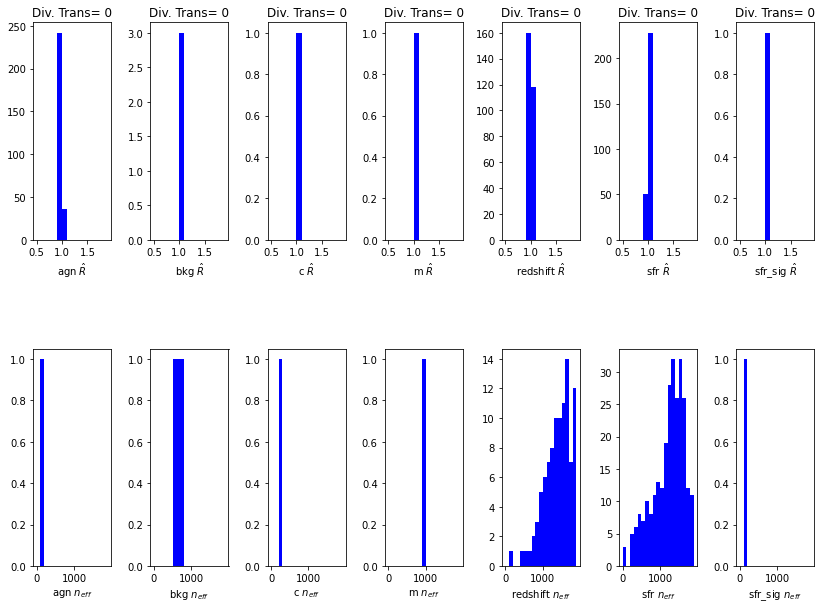

In [15]:
fig,axes=plt.subplots(2,len(samples),figsize=(2*len(samples),10))
for i,k in enumerate(samples):

    axes[0,i].hist(stats_summary[k]['r_hat'].flatten(),color='Blue',bins=np.arange(0.5,2,0.1))
    axes[1,i].hist(stats_summary[k]['n_eff'].flatten(),color='Blue',bins=np.arange(0,samples['m'].shape[0],100))
    axes[0,i].set_xlabel(k+' $ \hat{R}$')
    axes[0,i].set_title('Div. Trans= {}'.format(np.sum(divergences)))
    axes[1,i].set_xlabel(k+' $ n_{eff}$')
plt.subplots_adjust(hspace=0.5,wspace=0.5)

All diagnostics look fine. 

## Posterior Probability distributions

#### Hierarchical parameters

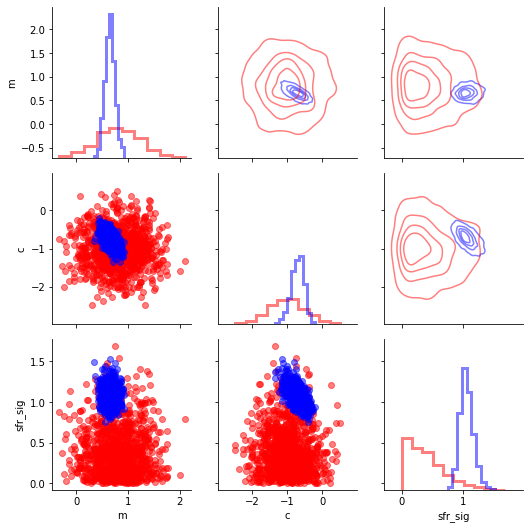

In [16]:
import pandas as pd
hier_param_names=['m','c','sfr_sig']

df_prior=pd.DataFrame(np.array([prior_pred[s] for s in hier_param_names]).T,columns=hier_param_names)
g=sns.PairGrid(df_prior)
g.map_lower(plt.scatter,alpha=0.5,color='Red')
g.map_diag(plt.hist,alpha=0.5,histtype='step',linewidth=3.0,color='Red',density=True)

df_post=pd.DataFrame(np.array([samples[s] for s in hier_param_names]).T,columns=hier_param_names)
g.data=df_post
g.map_lower(plt.scatter,alpha=0.5,color='Blue')
g.map_diag(plt.hist,alpha=0.5,histtype='step',linewidth=3.0,color='Blue',density=True)
g.map_upper(sns.kdeplot,alpha=0.5,color='Blue',n_levels=5, shade=False,linewidth=3.0,shade_lowest=False)

#for some reason the contour plots will delete other plots so do last
g.data=df_prior
g.map_upper(sns.kdeplot,alpha=0.5,color='Red',n_levels=5, shade=False,linewidth=3.0,shade_lowest=False)

#### Source parameters 

Text(0, 0.5, 'Redshift')

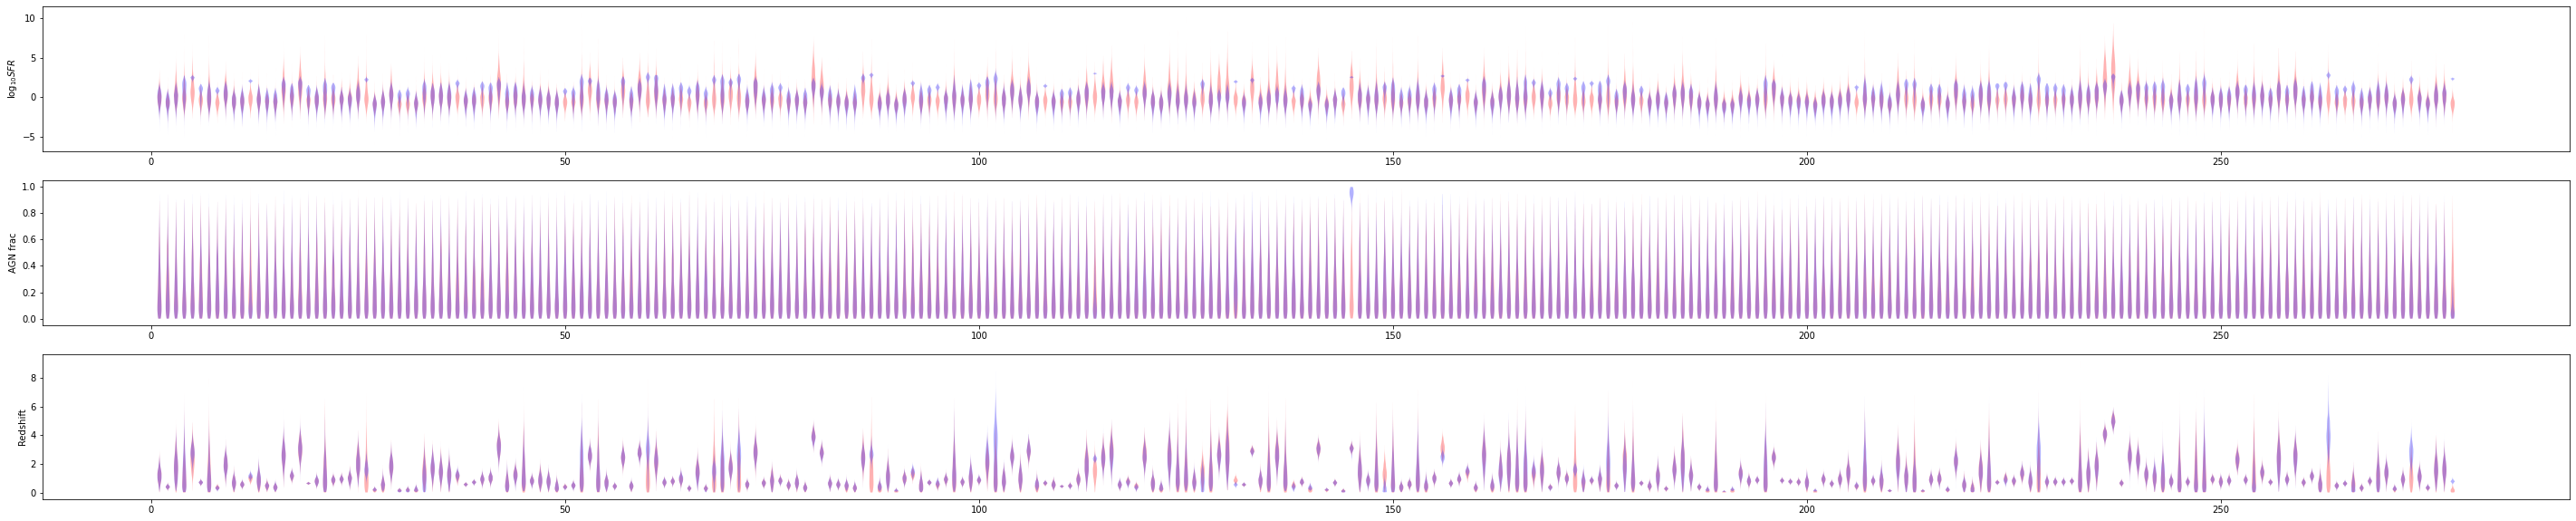

In [17]:
fig,axes=plt.subplots(3,1,figsize=(50,10))
phys_params=['sfr','agn','redshift']
for i ,p in enumerate(phys_params):
    v_plot=axes[i].violinplot(prior_pred[p].T,showextrema=False);
    plt.setp(v_plot['bodies'], facecolor='Red')
    v_plot=axes[i].violinplot(samples[p].T,showextrema=False);
    plt.setp(v_plot['bodies'], facecolor='Blue')

axes[0].set_ylabel('$\log_{10} SFR$')
axes[1].set_ylabel('AGN frac')
axes[2].set_ylabel('Redshift')

### Posterior Predicitive Checks

In [18]:
%%time 
#sample from the prior using numpyro's Predictive function
prior_predictive_samp=Predictive(SED_prior.spire_model_CIGALE,posterior_samples = samples, num_samples = 50)
prior_pred_samp=prior_predictive_samp(random.PRNGKey(0),priors_prior_pred,phys_prior,hier_params)
mod_map_array_samp=[prior_pred_samp['obs_psw'].T,prior_pred_samp['obs_pmw'].T,prior_pred_samp['obs_plw'].T]

CPU times: user 1.98 s, sys: 27.2 ms, total: 2.01 s
Wall time: 1.95 s


In [19]:
#feed the model map arrays the animation function
xidplus.plots.make_map_animation(priors,mod_map_array_samp,50)

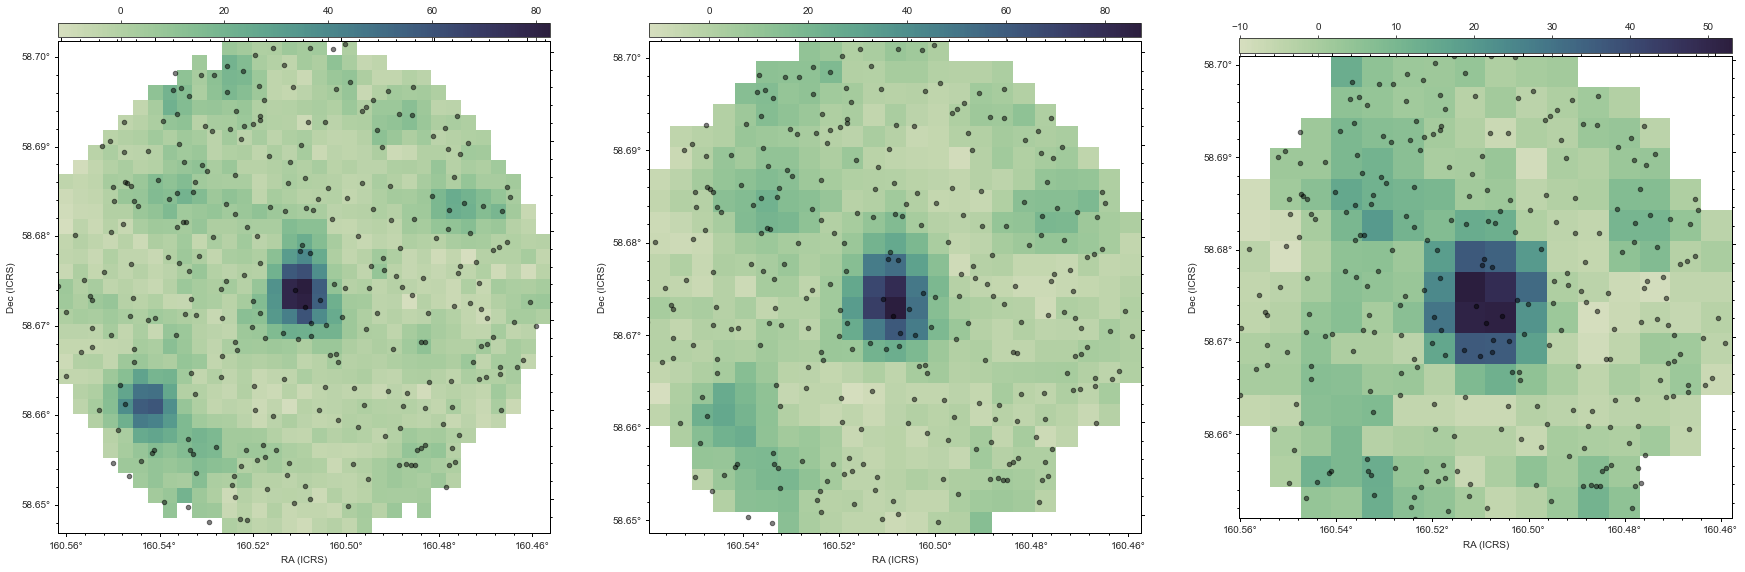

In [20]:
figures,fig=xidplus.plot_map(priors)

## Save the samples using arviz

In [21]:
import arviz as az

In [22]:
numpyro_data = az.from_numpyro(
    mcmc,
    prior=prior_pred,
    posterior_predictive=prior_pred_samp,
    coords={"src": np.arange(0,priors[0].nsrc),
           "band":np.arange(0,3)},
    dims={"agn": ["src"],
         "bkg":["band"],
         "redshift":["src"],
          "sfr":["src"]},
)

In [23]:
numpyro_data.to_netcdf('./output/{}/posterior_'.format(field[0])+esb['field'][source[0]]+'_'+str(source[0])+'_model1.nc')

'./output/Lockman-SWIRE/posterior_Lockman-SWIRE_2_model1.nc'

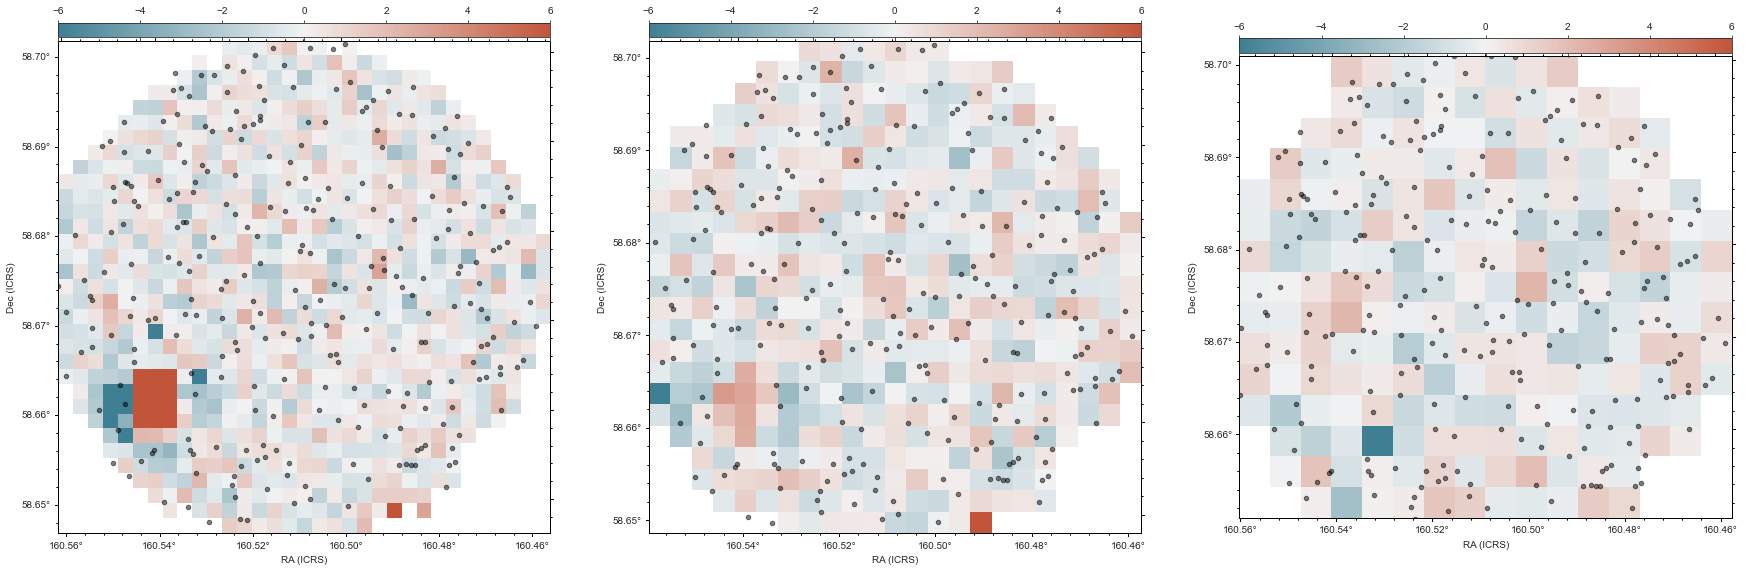

In [24]:
from xidplus import postmaps
import aplpy
sns.set_style("white")
cmap = sns.diverging_palette(220, 20, as_cmap=True)
Bayes_pvals = []
hdulists = list(map(lambda prior: postmaps.make_fits_image(prior, prior.sim), priors))
fig = plt.figure(figsize=(10 * len(priors), 10))
figs = []
for i in range(0, len(priors)):
    figs.append(aplpy.FITSFigure(hdulists[i][1], figure=fig, subplot=(1, len(priors), i + 1)))
    Bayes_pvals.append(postmaps.make_Bayesian_pval_maps(priors[i], mod_map_array_samp[i]))
    
    
for i in range(0, len(priors)):
    figs[i].show_markers(priors[i].sra, priors[i].sdec, edgecolor='black', facecolor='black',
                         marker='o', s=20, alpha=0.5)
    figs[i].tick_labels.set_xformat('dd.dd')
    figs[i].tick_labels.set_yformat('dd.dd')
    figs[i]._data[
        priors[i].sy_pix - np.min(priors[i].sy_pix) - 1, priors[i].sx_pix - np.min(priors[i].sx_pix) - 1] = \
    Bayes_pvals[i]
    figs[i].show_colorscale(vmin=-6, vmax=6, cmap=cmap)
    figs[i].add_colorbar()
    figs[i].colorbar.set_location('top')

In [25]:
fits_images=[postmaps.make_fits_image(priors[i],postmaps.make_Bayesian_pval_maps(priors[i], mod_map_array_samp[i])) for i in range(0,3)]



In [26]:
def Bayes_pval_sources(fits_images):
    #reproject
    from reproject import reproject_interp
    array350, footprint350 = reproject_interp(fits_images[1][1], fits_images[0][1].header,order=0)
    array500, footprint500 = reproject_interp(fits_images[2][1], fits_images[0][1].header,order=0)
    
    # get xx and yy
    xx,yy=np.meshgrid(np.arange(0,array350.shape[0]),np.arange(0,array350.shape[1]))
    
    #get average zscore
    combined_pval_map=(fits_images[0][1].data+array350+array500)/3.0
    ind=combined_pval_map>2
    
    from sklearn.cluster import DBSCAN
    X=np.vstack((xx[ind],yy[ind])).T
    
    # Compute DBSCAN
    db = DBSCAN(eps=2, min_samples=2).fit(X)
    labels = db.labels_
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    
    from astropy.table import QTable
    from astropy.wcs import WCS

    w=WCS(fits_images[0][1].header)
    pix_coords=np.asarray([[np.mean(xx[ind][labels==i]),np.mean(yy[ind][labels==i])] for i in range(0,n_clusters_)])
   
    coords_new=w.pixel_to_world(pix_coords[:,0],pix_coords[:,1])
    t=QTable()
    t['ra']=coords_new.ra
    t['dec']=coords_new.dec
    return t

In [27]:
t=Bayes_pval_sources(fits_images)

0


0


fitting 279 sources 

using 866, 451 and 216 pixels
source density = 114963.76672168606


  0%|          | 0/1000 [00:00<?, ?it/s]

warmup:   0%|          | 1/1000 [00:06<1:55:30,  6.94s/it, 1 steps of size 2.34e+00. acc. prob=0.00]

warmup:   1%|          | 7/1000 [00:08<14:39,  1.13it/s, 1023 steps of size 4.77e-04. acc. prob=0.34]

warmup:   1%|          | 9/1000 [00:09<12:43,  1.30it/s, 1023 steps of size 3.84e-04. acc. prob=0.44]

warmup:   1%|          | 10/1000 [00:10<13:20,  1.24it/s, 1023 steps of size 6.80e-04. acc. prob=0.50]

warmup:   1%|          | 11/1000 [00:10<13:54,  1.18it/s, 1023 steps of size 9.40e-05. acc. prob=0.47]

warmup:   1%|          | 12/1000 [00:11<14:24,  1.14it/s, 1023 steps of size 1.83e-04. acc. prob=0.51]

warmup:   1%|▏         | 13/1000 [00:12<14:49,  1.11it/s, 1023 steps of size 3.58e-04. acc. prob=0.55]

warmup:   1%|▏         | 14/1000 [00:13<15:09,  1.08it/s, 1023 steps of size 6.89e-04. acc. prob=0.58]

warmup:   2%|▏         | 15/1000 [00:14<15:25,  1.06it/s, 1023 steps of size 1.23e-03. acc. prob=0.61]

warmup:   2%|▏         | 16/1000 [00:15<15:37,  1.05it/s, 1023 steps of size 2.32e-03. acc. prob=0.63]

warmup:   2%|▏         | 17/1000 [00:16<15:45,  1.04it/s, 1023 steps of size 4.44e-03. acc. prob=0.65]

warmup:   2%|▏         | 18/1000 [00:17<15:51,  1.03it/s, 1023 steps of size 8.65e-03. acc. prob=0.67]

warmup:   2%|▏         | 19/1000 [00:18<13:33,  1.21it/s, 511 steps of size 3.03e-03. acc. prob=0.66] 

warmup:   2%|▏         | 20/1000 [00:19<14:18,  1.14it/s, 1023 steps of size 4.54e-03. acc. prob=0.67]

warmup:   2%|▏         | 21/1000 [00:20<14:48,  1.10it/s, 1023 steps of size 7.58e-03. acc. prob=0.68]

warmup:   2%|▏         | 22/1000 [00:21<15:09,  1.07it/s, 1023 steps of size 8.47e-03. acc. prob=0.69]

warmup:   2%|▏         | 24/1000 [00:22<12:02,  1.35it/s, 1023 steps of size 2.44e-03. acc. prob=0.68]

warmup:   2%|▎         | 25/1000 [00:23<13:00,  1.25it/s, 1023 steps of size 3.46e-03. acc. prob=0.69]

warmup:   3%|▎         | 26/1000 [00:24<13:47,  1.18it/s, 1023 steps of size 4.70e-03. acc. prob=0.70]

warmup:   3%|▎         | 27/1000 [00:25<14:22,  1.13it/s, 1023 steps of size 6.35e-03. acc. prob=0.70]

warmup:   3%|▎         | 28/1000 [00:26<14:52,  1.09it/s, 1023 steps of size 1.12e-02. acc. prob=0.71]

warmup:   3%|▎         | 30/1000 [00:27<11:49,  1.37it/s, 1023 steps of size 3.09e-03. acc. prob=0.70]

warmup:   3%|▎         | 31/1000 [00:28<12:47,  1.26it/s, 1023 steps of size 4.46e-03. acc. prob=0.71]

warmup:   3%|▎         | 32/1000 [00:29<13:35,  1.19it/s, 1023 steps of size 8.10e-03. acc. prob=0.72]

warmup:   3%|▎         | 33/1000 [00:29<12:04,  1.34it/s, 511 steps of size 9.49e-03. acc. prob=0.72] 

warmup:   3%|▎         | 34/1000 [00:30<10:11,  1.58it/s, 340 steps of size 1.91e-03. acc. prob=0.70]

warmup:   4%|▎         | 35/1000 [00:31<11:46,  1.37it/s, 1023 steps of size 3.34e-03. acc. prob=0.71]

warmup:   4%|▎         | 36/1000 [00:32<12:55,  1.24it/s, 1023 steps of size 5.16e-03. acc. prob=0.72]

warmup:   4%|▎         | 37/1000 [00:33<13:45,  1.17it/s, 1023 steps of size 6.21e-03. acc. prob=0.72]

warmup:   4%|▍         | 38/1000 [00:34<14:20,  1.12it/s, 1023 steps of size 9.08e-03. acc. prob=0.73]

warmup:   4%|▍         | 39/1000 [00:34<12:26,  1.29it/s, 511 steps of size 9.91e-03. acc. prob=0.73] 

warmup:   4%|▍         | 40/1000 [00:34<09:20,  1.71it/s, 127 steps of size 2.05e-03. acc. prob=0.72]

warmup:   4%|▍         | 41/1000 [00:35<11:14,  1.42it/s, 1023 steps of size 3.29e-03. acc. prob=0.72]

warmup:   4%|▍         | 42/1000 [00:36<12:38,  1.26it/s, 1023 steps of size 4.69e-03. acc. prob=0.73]

warmup:   4%|▍         | 43/1000 [00:37<13:32,  1.18it/s, 1023 steps of size 6.03e-03. acc. prob=0.73]

warmup:   4%|▍         | 44/1000 [00:38<14:10,  1.12it/s, 1023 steps of size 6.48e-03. acc. prob=0.73]

warmup:   4%|▍         | 45/1000 [00:39<14:38,  1.09it/s, 1023 steps of size 7.93e-03. acc. prob=0.73]

warmup:   5%|▍         | 46/1000 [00:40<12:35,  1.26it/s, 511 steps of size 1.11e-02. acc. prob=0.74] 

warmup:   5%|▍         | 48/1000 [00:41<10:24,  1.52it/s, 1023 steps of size 5.22e-03. acc. prob=0.73]

warmup:   5%|▍         | 49/1000 [00:42<11:41,  1.36it/s, 1023 steps of size 5.10e-03. acc. prob=0.73]

warmup:   5%|▌         | 50/1000 [00:43<12:41,  1.25it/s, 1023 steps of size 5.16e-03. acc. prob=0.74]

warmup:   5%|▌         | 51/1000 [00:44<13:26,  1.18it/s, 1023 steps of size 5.82e-03. acc. prob=0.74]

warmup:   5%|▌         | 52/1000 [00:45<14:02,  1.13it/s, 1023 steps of size 4.64e-03. acc. prob=0.74]

warmup:   5%|▌         | 53/1000 [00:46<14:26,  1.09it/s, 1023 steps of size 7.28e-03. acc. prob=0.74]

warmup:   5%|▌         | 54/1000 [00:47<14:52,  1.06it/s, 1023 steps of size 2.15e-03. acc. prob=0.73]

warmup:   6%|▌         | 55/1000 [00:48<15:02,  1.05it/s, 1023 steps of size 3.34e-03. acc. prob=0.74]

warmup:   6%|▌         | 56/1000 [00:48<15:10,  1.04it/s, 1023 steps of size 3.78e-03. acc. prob=0.74]

warmup:   6%|▌         | 57/1000 [00:49<15:16,  1.03it/s, 1023 steps of size 6.03e-03. acc. prob=0.74]

warmup:   6%|▌         | 58/1000 [00:50<15:19,  1.02it/s, 1023 steps of size 2.81e-03. acc. prob=0.74]

warmup:   6%|▌         | 59/1000 [00:51<15:20,  1.02it/s, 1023 steps of size 4.15e-03. acc. prob=0.74]

warmup:   6%|▌         | 60/1000 [00:52<15:25,  1.02it/s, 1023 steps of size 6.74e-03. acc. prob=0.75]

warmup:   6%|▌         | 61/1000 [00:53<15:23,  1.02it/s, 1023 steps of size 5.59e-03. acc. prob=0.74]

warmup:   6%|▌         | 62/1000 [00:54<15:25,  1.01it/s, 1023 steps of size 7.07e-03. acc. prob=0.75]

warmup:   6%|▋         | 63/1000 [00:55<15:23,  1.01it/s, 1023 steps of size 3.68e-03. acc. prob=0.74]

warmup:   6%|▋         | 64/1000 [00:56<15:22,  1.01it/s, 1023 steps of size 5.69e-03. acc. prob=0.75]

warmup:   6%|▋         | 65/1000 [00:57<15:26,  1.01it/s, 1023 steps of size 7.28e-03. acc. prob=0.75]

warmup:   7%|▋         | 66/1000 [00:58<15:25,  1.01it/s, 1023 steps of size 6.53e-03. acc. prob=0.75]

warmup:   7%|▋         | 67/1000 [00:59<15:22,  1.01it/s, 1023 steps of size 8.67e-03. acc. prob=0.75]

warmup:   7%|▋         | 68/1000 [01:00<13:03,  1.19it/s, 511 steps of size 5.64e-03. acc. prob=0.75] 

warmup:   7%|▋         | 69/1000 [01:01<13:42,  1.13it/s, 1023 steps of size 7.68e-03. acc. prob=0.75]

warmup:   7%|▋         | 70/1000 [01:01<11:52,  1.31it/s, 511 steps of size 4.15e-03. acc. prob=0.75] 

warmup:   7%|▋         | 71/1000 [01:02<12:59,  1.19it/s, 1023 steps of size 5.79e-03. acc. prob=0.75]

warmup:   7%|▋         | 72/1000 [01:03<13:39,  1.13it/s, 1023 steps of size 4.57e-03. acc. prob=0.75]

warmup:   7%|▋         | 73/1000 [01:04<14:08,  1.09it/s, 1023 steps of size 4.46e-03. acc. prob=0.75]

warmup:   7%|▋         | 74/1000 [01:05<14:26,  1.07it/s, 1023 steps of size 6.03e-03. acc. prob=0.75]

warmup:   8%|▊         | 75/1000 [01:06<14:38,  1.05it/s, 1023 steps of size 5.26e-03. acc. prob=0.75]

warmup:   8%|▊         | 76/1000 [01:07<14:46,  1.04it/s, 1023 steps of size 5.72e-03. acc. prob=0.75]

warmup:   8%|▊         | 77/1000 [01:08<14:51,  1.03it/s, 1023 steps of size 5.85e-03. acc. prob=0.75]

warmup:   8%|▊         | 78/1000 [01:09<14:56,  1.03it/s, 1023 steps of size 7.71e-03. acc. prob=0.75]

warmup:   8%|▊         | 79/1000 [01:10<12:43,  1.21it/s, 511 steps of size 8.78e-03. acc. prob=0.76] 

warmup:   8%|▊         | 80/1000 [01:10<10:25,  1.47it/s, 345 steps of size 4.48e-03. acc. prob=0.75]

warmup:   8%|▊         | 81/1000 [01:11<11:48,  1.30it/s, 1023 steps of size 6.81e-03. acc. prob=0.75]

warmup:   8%|▊         | 82/1000 [01:12<12:45,  1.20it/s, 1023 steps of size 5.56e-03. acc. prob=0.75]

warmup:   8%|▊         | 83/1000 [01:13<13:25,  1.14it/s, 1023 steps of size 7.08e-03. acc. prob=0.76]

warmup:   8%|▊         | 84/1000 [01:14<13:56,  1.10it/s, 1023 steps of size 4.47e-03. acc. prob=0.75]

warmup:   8%|▊         | 85/1000 [01:15<14:14,  1.07it/s, 1023 steps of size 6.32e-03. acc. prob=0.76]

warmup:   9%|▊         | 86/1000 [01:16<14:26,  1.05it/s, 1023 steps of size 6.62e-03. acc. prob=0.76]

warmup:   9%|▊         | 87/1000 [01:17<14:35,  1.04it/s, 1023 steps of size 5.85e-03. acc. prob=0.76]

warmup:   9%|▉         | 88/1000 [01:18<14:41,  1.03it/s, 1023 steps of size 4.79e-03. acc. prob=0.75]

warmup:   9%|▉         | 89/1000 [01:19<14:47,  1.03it/s, 1023 steps of size 3.57e-03. acc. prob=0.75]

warmup:   9%|▉         | 90/1000 [01:20<14:48,  1.02it/s, 1023 steps of size 3.35e-03. acc. prob=0.75]

warmup:   9%|▉         | 91/1000 [01:21<14:49,  1.02it/s, 1023 steps of size 5.06e-03. acc. prob=0.76]

warmup:   9%|▉         | 92/1000 [01:22<14:49,  1.02it/s, 1023 steps of size 7.05e-03. acc. prob=0.76]

warmup:   9%|▉         | 93/1000 [01:23<14:49,  1.02it/s, 1023 steps of size 9.43e-03. acc. prob=0.76]

warmup:   9%|▉         | 94/1000 [01:23<11:45,  1.29it/s, 314 steps of size 2.90e-03. acc. prob=0.75] 

warmup:  10%|▉         | 95/1000 [01:24<12:41,  1.19it/s, 1023 steps of size 4.33e-03. acc. prob=0.76]

warmup:  10%|▉         | 96/1000 [01:25<13:20,  1.13it/s, 1023 steps of size 5.14e-03. acc. prob=0.76]

warmup:  10%|▉         | 97/1000 [01:26<13:45,  1.09it/s, 1023 steps of size 4.69e-03. acc. prob=0.76]

warmup:  10%|▉         | 98/1000 [01:27<14:03,  1.07it/s, 1023 steps of size 3.87e-03. acc. prob=0.76]

warmup:  10%|▉         | 99/1000 [01:28<14:14,  1.05it/s, 1023 steps of size 4.84e-03. acc. prob=0.76]

warmup:  10%|█         | 100/1000 [01:29<14:31,  1.03it/s, 1023 steps of size 6.82e-03. acc. prob=0.76]

warmup:  10%|█         | 101/1000 [01:30<14:35,  1.03it/s, 1023 steps of size 9.58e-02. acc. prob=0.76]

warmup:  10%|█         | 103/1000 [01:30<08:42,  1.72it/s, 255 steps of size 7.34e-03. acc. prob=0.75] 

warmup:  10%|█         | 104/1000 [01:31<10:11,  1.47it/s, 1023 steps of size 1.10e-02. acc. prob=0.76]

warmup:  10%|█         | 105/1000 [01:32<09:26,  1.58it/s, 511 steps of size 1.18e-02. acc. prob=0.76] 

warmup:  11%|█         | 106/1000 [01:32<08:51,  1.68it/s, 511 steps of size 1.76e-02. acc. prob=0.76]

warmup:  11%|█         | 107/1000 [01:33<07:23,  2.01it/s, 255 steps of size 1.59e-02. acc. prob=0.76]

warmup:  11%|█         | 108/1000 [01:33<06:19,  2.35it/s, 255 steps of size 1.56e-02. acc. prob=0.76]

warmup:  11%|█         | 109/1000 [01:33<05:33,  2.67it/s, 255 steps of size 2.81e-02. acc. prob=0.76]

warmup:  11%|█         | 110/1000 [01:33<05:00,  2.96it/s, 255 steps of size 3.02e-02. acc. prob=0.76]

warmup:  11%|█         | 111/1000 [01:33<04:04,  3.63it/s, 127 steps of size 3.53e-02. acc. prob=0.76]

warmup:  11%|█         | 112/1000 [01:34<03:24,  4.34it/s, 127 steps of size 1.29e-02. acc. prob=0.76]

warmup:  11%|█▏        | 113/1000 [01:34<04:33,  3.24it/s, 511 steps of size 2.38e-02. acc. prob=0.76]

warmup:  11%|█▏        | 114/1000 [01:34<04:17,  3.44it/s, 255 steps of size 1.05e-02. acc. prob=0.76]

warmup:  12%|█▏        | 115/1000 [01:35<05:10,  2.85it/s, 511 steps of size 1.33e-02. acc. prob=0.76]

warmup:  12%|█▏        | 116/1000 [01:35<05:47,  2.54it/s, 511 steps of size 1.02e-02. acc. prob=0.76]

warmup:  12%|█▏        | 117/1000 [01:36<06:13,  2.36it/s, 511 steps of size 1.73e-02. acc. prob=0.76]

warmup:  12%|█▏        | 118/1000 [01:36<05:26,  2.70it/s, 255 steps of size 1.76e-02. acc. prob=0.76]

warmup:  12%|█▏        | 119/1000 [01:36<04:53,  3.00it/s, 255 steps of size 3.03e-02. acc. prob=0.76]

warmup:  12%|█▏        | 120/1000 [01:36<04:17,  3.42it/s, 203 steps of size 4.05e-03. acc. prob=0.76]

warmup:  12%|█▏        | 121/1000 [01:37<07:18,  2.00it/s, 1023 steps of size 6.94e-03. acc. prob=0.76]

warmup:  12%|█▏        | 122/1000 [01:38<09:25,  1.55it/s, 1023 steps of size 8.97e-03. acc. prob=0.76]

warmup:  12%|█▏        | 123/1000 [01:39<08:46,  1.66it/s, 511 steps of size 1.48e-02. acc. prob=0.76] 

warmup:  12%|█▏        | 124/1000 [01:39<08:19,  1.75it/s, 511 steps of size 2.12e-02. acc. prob=0.76]

warmup:  12%|█▎        | 125/1000 [01:40<06:54,  2.11it/s, 255 steps of size 2.76e-02. acc. prob=0.77]

warmup:  13%|█▎        | 127/1000 [01:41<07:18,  1.99it/s, 1023 steps of size 6.89e-03. acc. prob=0.76]

warmup:  13%|█▎        | 128/1000 [01:42<09:01,  1.61it/s, 1023 steps of size 1.09e-02. acc. prob=0.76]

warmup:  13%|█▎        | 129/1000 [01:42<08:31,  1.70it/s, 511 steps of size 1.34e-02. acc. prob=0.76] 

warmup:  13%|█▎        | 130/1000 [01:43<08:08,  1.78it/s, 511 steps of size 1.28e-02. acc. prob=0.76]

warmup:  13%|█▎        | 131/1000 [01:43<07:51,  1.84it/s, 511 steps of size 1.61e-02. acc. prob=0.77]

warmup:  13%|█▎        | 132/1000 [01:43<06:37,  2.18it/s, 255 steps of size 2.56e-02. acc. prob=0.77]

warmup:  13%|█▎        | 133/1000 [01:44<05:08,  2.81it/s, 105 steps of size 4.17e-03. acc. prob=0.76]

warmup:  13%|█▎        | 134/1000 [01:45<07:48,  1.85it/s, 1023 steps of size 6.55e-03. acc. prob=0.76]

warmup:  14%|█▎        | 135/1000 [01:46<09:40,  1.49it/s, 1023 steps of size 1.13e-02. acc. prob=0.77]

warmup:  14%|█▎        | 136/1000 [01:46<08:54,  1.62it/s, 511 steps of size 1.81e-02. acc. prob=0.77] 

warmup:  14%|█▎        | 137/1000 [01:46<07:18,  1.97it/s, 255 steps of size 2.68e-02. acc. prob=0.77]

warmup:  14%|█▍        | 138/1000 [01:47<06:13,  2.31it/s, 255 steps of size 1.41e-02. acc. prob=0.77]

warmup:  14%|█▍        | 139/1000 [01:47<06:28,  2.22it/s, 511 steps of size 1.81e-02. acc. prob=0.77]

warmup:  14%|█▍        | 140/1000 [01:47<05:35,  2.57it/s, 255 steps of size 2.97e-02. acc. prob=0.77]

warmup:  14%|█▍        | 141/1000 [01:47<04:51,  2.94it/s, 230 steps of size 1.00e-02. acc. prob=0.77]

warmup:  14%|█▍        | 142/1000 [01:48<05:30,  2.59it/s, 511 steps of size 1.30e-02. acc. prob=0.77]

warmup:  14%|█▍        | 143/1000 [01:48<05:57,  2.40it/s, 511 steps of size 1.26e-02. acc. prob=0.77]

warmup:  14%|█▍        | 144/1000 [01:49<06:18,  2.26it/s, 511 steps of size 1.04e-02. acc. prob=0.77]

warmup:  14%|█▍        | 145/1000 [01:49<06:30,  2.19it/s, 511 steps of size 1.61e-02. acc. prob=0.77]

warmup:  15%|█▍        | 146/1000 [01:50<05:35,  2.54it/s, 255 steps of size 2.34e-02. acc. prob=0.77]

warmup:  15%|█▍        | 147/1000 [01:50<04:58,  2.86it/s, 255 steps of size 8.57e-03. acc. prob=0.77]

warmup:  15%|█▍        | 148/1000 [01:50<05:34,  2.55it/s, 511 steps of size 1.29e-02. acc. prob=0.77]

warmup:  15%|█▍        | 149/1000 [01:51<05:59,  2.37it/s, 511 steps of size 1.52e-02. acc. prob=0.77]

warmup:  15%|█▌        | 150/1000 [01:51<05:14,  2.70it/s, 255 steps of size 1.45e-02. acc. prob=0.77]

warmup:  15%|█▌        | 151/1000 [01:51<04:42,  3.01it/s, 255 steps of size 1.84e-01. acc. prob=0.77]

warmup:  15%|█▌        | 154/1000 [01:52<02:51,  4.94it/s, 255 steps of size 2.21e-02. acc. prob=0.77]

warmup:  16%|█▌        | 155/1000 [01:52<02:58,  4.72it/s, 255 steps of size 1.25e-02. acc. prob=0.76]

warmup:  16%|█▌        | 156/1000 [01:52<03:53,  3.61it/s, 511 steps of size 1.57e-02. acc. prob=0.77]

warmup:  16%|█▌        | 157/1000 [01:53<03:46,  3.71it/s, 255 steps of size 2.32e-02. acc. prob=0.77]

warmup:  16%|█▌        | 159/1000 [01:53<03:06,  4.51it/s, 255 steps of size 2.59e-03. acc. prob=0.76]

warmup:  16%|█▌        | 160/1000 [01:54<05:34,  2.51it/s, 1023 steps of size 4.73e-03. acc. prob=0.76]

warmup:  16%|█▌        | 161/1000 [01:55<07:35,  1.84it/s, 1023 steps of size 8.82e-03. acc. prob=0.77]

warmup:  16%|█▌        | 162/1000 [01:56<07:23,  1.89it/s, 511 steps of size 1.60e-02. acc. prob=0.77] 

warmup:  16%|█▋        | 163/1000 [01:56<06:09,  2.27it/s, 211 steps of size 8.66e-03. acc. prob=0.77]

warmup:  16%|█▋        | 164/1000 [01:56<06:21,  2.19it/s, 511 steps of size 9.51e-03. acc. prob=0.77]

warmup:  16%|█▋        | 165/1000 [01:57<06:29,  2.15it/s, 511 steps of size 1.52e-02. acc. prob=0.77]

warmup:  17%|█▋        | 166/1000 [01:57<05:35,  2.48it/s, 255 steps of size 1.74e-02. acc. prob=0.77]

warmup:  17%|█▋        | 167/1000 [01:57<04:33,  3.05it/s, 151 steps of size 7.90e-03. acc. prob=0.77]

warmup:  17%|█▋        | 168/1000 [01:58<05:13,  2.66it/s, 511 steps of size 1.25e-02. acc. prob=0.77]

warmup:  17%|█▋        | 169/1000 [01:58<05:41,  2.43it/s, 511 steps of size 2.09e-02. acc. prob=0.77]

warmup:  17%|█▋        | 171/1000 [01:59<06:14,  2.22it/s, 1023 steps of size 3.49e-03. acc. prob=0.77]

warmup:  17%|█▋        | 172/1000 [02:00<08:02,  1.72it/s, 1023 steps of size 6.41e-03. acc. prob=0.77]

warmup:  17%|█▋        | 173/1000 [02:01<07:44,  1.78it/s, 511 steps of size 1.05e-02. acc. prob=0.77] 

warmup:  17%|█▋        | 174/1000 [02:01<07:30,  1.83it/s, 511 steps of size 1.13e-02. acc. prob=0.77]

warmup:  18%|█▊        | 175/1000 [02:02<07:18,  1.88it/s, 511 steps of size 1.36e-02. acc. prob=0.77]

warmup:  18%|█▊        | 176/1000 [02:02<06:10,  2.22it/s, 255 steps of size 6.32e-03. acc. prob=0.77]

warmup:  18%|█▊        | 177/1000 [02:03<08:16,  1.66it/s, 1023 steps of size 1.04e-02. acc. prob=0.77]

warmup:  18%|█▊        | 178/1000 [02:03<07:50,  1.75it/s, 511 steps of size 1.64e-02. acc. prob=0.77] 

warmup:  18%|█▊        | 179/1000 [02:04<06:31,  2.10it/s, 255 steps of size 2.78e-02. acc. prob=0.77]

warmup:  18%|█▊        | 181/1000 [02:05<06:36,  2.06it/s, 1023 steps of size 6.59e-03. acc. prob=0.77]

warmup:  18%|█▊        | 182/1000 [02:06<08:16,  1.65it/s, 1023 steps of size 1.04e-02. acc. prob=0.77]

warmup:  18%|█▊        | 183/1000 [02:06<07:51,  1.73it/s, 511 steps of size 1.35e-02. acc. prob=0.77] 

warmup:  18%|█▊        | 184/1000 [02:06<07:32,  1.80it/s, 511 steps of size 6.89e-03. acc. prob=0.77]

warmup:  18%|█▊        | 185/1000 [02:07<07:17,  1.86it/s, 511 steps of size 1.19e-02. acc. prob=0.77]

warmup:  19%|█▊        | 186/1000 [02:07<07:07,  1.91it/s, 511 steps of size 5.19e-03. acc. prob=0.77]

warmup:  19%|█▊        | 187/1000 [02:08<08:57,  1.51it/s, 1023 steps of size 5.88e-03. acc. prob=0.77]

warmup:  19%|█▉        | 188/1000 [02:09<10:18,  1.31it/s, 1023 steps of size 8.85e-03. acc. prob=0.77]

warmup:  19%|█▉        | 189/1000 [02:10<09:13,  1.47it/s, 511 steps of size 8.38e-03. acc. prob=0.77] 

warmup:  19%|█▉        | 190/1000 [02:10<08:26,  1.60it/s, 511 steps of size 1.19e-02. acc. prob=0.77]

warmup:  19%|█▉        | 191/1000 [02:11<07:54,  1.71it/s, 511 steps of size 1.17e-02. acc. prob=0.77]

warmup:  19%|█▉        | 192/1000 [02:11<07:30,  1.79it/s, 511 steps of size 1.94e-02. acc. prob=0.77]

warmup:  19%|█▉        | 194/1000 [02:12<05:45,  2.34it/s, 511 steps of size 1.10e-02. acc. prob=0.77]

warmup:  20%|█▉        | 195/1000 [02:12<05:57,  2.25it/s, 511 steps of size 1.67e-02. acc. prob=0.77]

warmup:  20%|█▉        | 196/1000 [02:13<05:09,  2.60it/s, 226 steps of size 1.02e-02. acc. prob=0.77]

warmup:  20%|█▉        | 197/1000 [02:13<05:32,  2.41it/s, 511 steps of size 1.65e-02. acc. prob=0.77]

warmup:  20%|█▉        | 198/1000 [02:13<04:54,  2.72it/s, 255 steps of size 1.26e-02. acc. prob=0.77]

warmup:  20%|█▉        | 199/1000 [02:14<05:24,  2.47it/s, 511 steps of size 1.89e-02. acc. prob=0.77]

warmup:  20%|██        | 200/1000 [02:14<04:47,  2.78it/s, 255 steps of size 1.15e-02. acc. prob=0.77]

warmup:  20%|██        | 201/1000 [02:15<05:18,  2.51it/s, 511 steps of size 1.25e-02. acc. prob=0.77]

warmup:  20%|██        | 202/1000 [02:15<05:39,  2.35it/s, 511 steps of size 1.14e-02. acc. prob=0.77]

warmup:  20%|██        | 203/1000 [02:16<05:55,  2.24it/s, 511 steps of size 1.37e-02. acc. prob=0.77]

warmup:  20%|██        | 204/1000 [02:16<05:07,  2.58it/s, 255 steps of size 5.49e-03. acc. prob=0.77]

warmup:  20%|██        | 205/1000 [02:17<07:29,  1.77it/s, 1023 steps of size 6.33e-03. acc. prob=0.77]

warmup:  21%|██        | 206/1000 [02:18<09:08,  1.45it/s, 1023 steps of size 6.65e-03. acc. prob=0.77]

warmup:  21%|██        | 207/1000 [02:18<08:21,  1.58it/s, 511 steps of size 8.09e-03. acc. prob=0.77] 

warmup:  21%|██        | 208/1000 [02:19<07:48,  1.69it/s, 511 steps of size 1.05e-02. acc. prob=0.77]

warmup:  21%|██        | 209/1000 [02:19<07:24,  1.78it/s, 511 steps of size 1.65e-02. acc. prob=0.77]

warmup:  21%|██        | 210/1000 [02:20<06:09,  2.14it/s, 255 steps of size 9.91e-03. acc. prob=0.77]

warmup:  21%|██        | 211/1000 [02:20<06:15,  2.10it/s, 511 steps of size 1.01e-02. acc. prob=0.77]

warmup:  21%|██        | 212/1000 [02:21<06:18,  2.08it/s, 511 steps of size 9.74e-03. acc. prob=0.77]

warmup:  21%|██▏       | 213/1000 [02:21<06:21,  2.06it/s, 511 steps of size 1.27e-02. acc. prob=0.77]

warmup:  21%|██▏       | 214/1000 [02:22<06:22,  2.05it/s, 511 steps of size 1.93e-02. acc. prob=0.77]

warmup:  22%|██▏       | 216/1000 [02:23<06:25,  2.03it/s, 1023 steps of size 5.84e-03. acc. prob=0.77]

warmup:  22%|██▏       | 217/1000 [02:24<08:00,  1.63it/s, 1023 steps of size 6.23e-03. acc. prob=0.77]

warmup:  22%|██▏       | 218/1000 [02:25<09:26,  1.38it/s, 1023 steps of size 9.57e-03. acc. prob=0.77]

warmup:  22%|██▏       | 219/1000 [02:25<08:36,  1.51it/s, 511 steps of size 1.15e-02. acc. prob=0.77] 

warmup:  22%|██▏       | 220/1000 [02:26<07:58,  1.63it/s, 511 steps of size 1.03e-02. acc. prob=0.77]

warmup:  22%|██▏       | 221/1000 [02:26<07:30,  1.73it/s, 511 steps of size 1.42e-02. acc. prob=0.77]

warmup:  22%|██▏       | 222/1000 [02:26<06:15,  2.07it/s, 255 steps of size 8.72e-03. acc. prob=0.77]

warmup:  22%|██▏       | 223/1000 [02:27<06:16,  2.06it/s, 511 steps of size 1.24e-02. acc. prob=0.77]

warmup:  22%|██▏       | 224/1000 [02:27<06:18,  2.05it/s, 511 steps of size 1.17e-02. acc. prob=0.77]

warmup:  22%|██▎       | 225/1000 [02:28<06:18,  2.05it/s, 511 steps of size 5.14e-03. acc. prob=0.77]

warmup:  23%|██▎       | 226/1000 [02:29<08:13,  1.57it/s, 1023 steps of size 7.75e-03. acc. prob=0.77]

warmup:  23%|██▎       | 227/1000 [02:29<07:42,  1.67it/s, 511 steps of size 8.31e-03. acc. prob=0.77] 

warmup:  23%|██▎       | 228/1000 [02:30<07:17,  1.76it/s, 511 steps of size 9.76e-03. acc. prob=0.77]

warmup:  23%|██▎       | 229/1000 [02:30<07:00,  1.84it/s, 511 steps of size 1.00e-02. acc. prob=0.77]

warmup:  23%|██▎       | 230/1000 [02:31<06:47,  1.89it/s, 511 steps of size 1.22e-02. acc. prob=0.77]

warmup:  23%|██▎       | 231/1000 [02:31<06:38,  1.93it/s, 511 steps of size 1.79e-02. acc. prob=0.78]

warmup:  23%|██▎       | 232/1000 [02:32<05:35,  2.29it/s, 255 steps of size 1.15e-02. acc. prob=0.77]

warmup:  23%|██▎       | 233/1000 [02:32<05:49,  2.19it/s, 511 steps of size 1.66e-02. acc. prob=0.78]

warmup:  23%|██▎       | 234/1000 [02:32<05:01,  2.54it/s, 255 steps of size 1.81e-02. acc. prob=0.78]

warmup:  24%|██▎       | 236/1000 [02:33<05:40,  2.24it/s, 1023 steps of size 5.67e-03. acc. prob=0.77]

warmup:  24%|██▎       | 237/1000 [02:34<07:22,  1.72it/s, 1023 steps of size 8.37e-03. acc. prob=0.77]

warmup:  24%|██▍       | 238/1000 [02:35<07:04,  1.79it/s, 511 steps of size 1.22e-02. acc. prob=0.77] 

warmup:  24%|██▍       | 239/1000 [02:35<06:00,  2.11it/s, 255 steps of size 1.63e-02. acc. prob=0.78]

warmup:  24%|██▍       | 241/1000 [02:36<04:58,  2.55it/s, 511 steps of size 1.13e-02. acc. prob=0.78]

warmup:  24%|██▍       | 242/1000 [02:36<05:15,  2.40it/s, 511 steps of size 1.04e-02. acc. prob=0.77]

warmup:  24%|██▍       | 243/1000 [02:37<05:29,  2.29it/s, 511 steps of size 1.19e-02. acc. prob=0.78]

warmup:  24%|██▍       | 244/1000 [02:37<05:40,  2.22it/s, 511 steps of size 5.23e-03. acc. prob=0.77]

warmup:  24%|██▍       | 245/1000 [02:38<07:30,  1.67it/s, 1023 steps of size 6.59e-03. acc. prob=0.77]

warmup:  25%|██▍       | 246/1000 [02:39<07:07,  1.76it/s, 511 steps of size 9.05e-03. acc. prob=0.77] 

warmup:  25%|██▍       | 247/1000 [02:39<06:52,  1.83it/s, 511 steps of size 1.01e-02. acc. prob=0.78]

warmup:  25%|██▍       | 248/1000 [02:40<06:39,  1.88it/s, 511 steps of size 6.89e-03. acc. prob=0.77]

warmup:  25%|██▍       | 249/1000 [02:41<08:18,  1.51it/s, 1023 steps of size 9.00e-03. acc. prob=0.78]

warmup:  25%|██▌       | 250/1000 [02:41<07:40,  1.63it/s, 511 steps of size 1.08e-02. acc. prob=0.78] 

warmup:  25%|██▌       | 251/1000 [02:42<07:12,  1.73it/s, 511 steps of size 1.12e-01. acc. prob=0.78]

warmup:  25%|██▌       | 253/1000 [02:42<04:36,  2.70it/s, 255 steps of size 2.12e-02. acc. prob=0.77]

warmup:  26%|██▌       | 255/1000 [02:43<05:14,  2.37it/s, 1023 steps of size 2.93e-03. acc. prob=0.77]

warmup:  26%|██▌       | 256/1000 [02:44<06:47,  1.83it/s, 1023 steps of size 4.43e-03. acc. prob=0.77]

warmup:  26%|██▌       | 257/1000 [02:45<08:04,  1.53it/s, 1023 steps of size 7.81e-03. acc. prob=0.77]

warmup:  26%|██▌       | 258/1000 [02:45<07:33,  1.64it/s, 511 steps of size 1.08e-02. acc. prob=0.77] 

warmup:  26%|██▌       | 259/1000 [02:46<07:09,  1.73it/s, 511 steps of size 6.50e-03. acc. prob=0.77]

warmup:  26%|██▌       | 260/1000 [02:46<06:51,  1.80it/s, 511 steps of size 9.34e-03. acc. prob=0.77]

warmup:  26%|██▌       | 261/1000 [02:47<06:37,  1.86it/s, 511 steps of size 1.42e-02. acc. prob=0.77]

warmup:  26%|██▌       | 262/1000 [02:47<05:35,  2.20it/s, 255 steps of size 2.25e-02. acc. prob=0.77]

warmup:  26%|██▋       | 264/1000 [02:47<04:28,  2.74it/s, 511 steps of size 1.14e-02. acc. prob=0.77]

warmup:  26%|██▋       | 265/1000 [02:48<04:50,  2.53it/s, 511 steps of size 1.63e-02. acc. prob=0.77]

warmup:  27%|██▋       | 266/1000 [02:48<04:21,  2.81it/s, 247 steps of size 8.00e-03. acc. prob=0.77]

warmup:  27%|██▋       | 267/1000 [02:49<04:48,  2.54it/s, 511 steps of size 1.16e-02. acc. prob=0.77]

warmup:  27%|██▋       | 268/1000 [02:49<05:08,  2.37it/s, 511 steps of size 1.80e-02. acc. prob=0.78]

warmup:  27%|██▋       | 269/1000 [02:49<04:32,  2.68it/s, 255 steps of size 1.78e-03. acc. prob=0.77]

warmup:  27%|██▋       | 270/1000 [02:50<06:40,  1.82it/s, 1023 steps of size 3.30e-03. acc. prob=0.77]

warmup:  27%|██▋       | 271/1000 [02:51<08:12,  1.48it/s, 1023 steps of size 5.76e-03. acc. prob=0.77]

warmup:  27%|██▋       | 272/1000 [02:52<09:17,  1.30it/s, 1023 steps of size 9.29e-03. acc. prob=0.77]

warmup:  27%|██▋       | 273/1000 [02:53<08:18,  1.46it/s, 511 steps of size 1.30e-02. acc. prob=0.78] 

warmup:  27%|██▋       | 274/1000 [02:53<06:42,  1.80it/s, 255 steps of size 2.32e-02. acc. prob=0.78]

warmup:  28%|██▊       | 276/1000 [02:54<06:30,  1.86it/s, 1023 steps of size 7.99e-03. acc. prob=0.77]

warmup:  28%|██▊       | 277/1000 [02:55<06:21,  1.89it/s, 511 steps of size 1.38e-02. acc. prob=0.78] 

warmup:  28%|██▊       | 278/1000 [02:55<05:28,  2.20it/s, 255 steps of size 9.99e-03. acc. prob=0.78]

warmup:  28%|██▊       | 279/1000 [02:55<05:35,  2.15it/s, 511 steps of size 1.37e-02. acc. prob=0.78]

warmup:  28%|██▊       | 280/1000 [02:56<04:50,  2.47it/s, 255 steps of size 1.52e-02. acc. prob=0.78]

warmup:  28%|██▊       | 281/1000 [02:56<04:18,  2.78it/s, 255 steps of size 7.11e-03. acc. prob=0.77]

warmup:  28%|██▊       | 282/1000 [02:56<04:45,  2.51it/s, 511 steps of size 9.42e-03. acc. prob=0.78]

warmup:  28%|██▊       | 283/1000 [02:57<05:05,  2.35it/s, 511 steps of size 1.59e-02. acc. prob=0.78]

warmup:  28%|██▊       | 284/1000 [02:57<04:27,  2.68it/s, 255 steps of size 1.97e-02. acc. prob=0.78]

warmup:  28%|██▊       | 285/1000 [02:57<03:30,  3.40it/s, 109 steps of size 2.09e-02. acc. prob=0.78]

warmup:  29%|██▊       | 287/1000 [02:58<04:45,  2.50it/s, 1023 steps of size 6.41e-03. acc. prob=0.77]

warmup:  29%|██▉       | 288/1000 [02:59<06:29,  1.83it/s, 1023 steps of size 1.09e-02. acc. prob=0.78]

warmup:  29%|██▉       | 289/1000 [03:00<06:18,  1.88it/s, 511 steps of size 1.85e-02. acc. prob=0.78] 

warmup:  29%|██▉       | 291/1000 [03:00<04:56,  2.39it/s, 511 steps of size 8.91e-03. acc. prob=0.78]

warmup:  29%|██▉       | 292/1000 [03:01<05:08,  2.29it/s, 511 steps of size 1.20e-02. acc. prob=0.78]

warmup:  29%|██▉       | 293/1000 [03:01<05:18,  2.22it/s, 511 steps of size 1.90e-02. acc. prob=0.78]

warmup:  29%|██▉       | 294/1000 [03:02<04:40,  2.52it/s, 255 steps of size 1.95e-02. acc. prob=0.78]

warmup:  30%|██▉       | 295/1000 [03:02<04:10,  2.81it/s, 255 steps of size 1.38e-02. acc. prob=0.78]

warmup:  30%|██▉       | 296/1000 [03:02<03:48,  3.08it/s, 255 steps of size 1.12e-02. acc. prob=0.78]

warmup:  30%|██▉       | 297/1000 [03:03<04:22,  2.68it/s, 511 steps of size 1.53e-02. acc. prob=0.78]

warmup:  30%|██▉       | 298/1000 [03:03<03:55,  2.97it/s, 255 steps of size 1.48e-02. acc. prob=0.78]

warmup:  30%|██▉       | 299/1000 [03:03<03:38,  3.21it/s, 255 steps of size 2.06e-02. acc. prob=0.78]

warmup:  30%|███       | 300/1000 [03:03<03:12,  3.64it/s, 188 steps of size 1.68e-02. acc. prob=0.78]

warmup:  30%|███       | 301/1000 [03:03<02:49,  4.12it/s, 167 steps of size 7.45e-03. acc. prob=0.78]

warmup:  30%|███       | 302/1000 [03:04<03:46,  3.08it/s, 511 steps of size 1.10e-02. acc. prob=0.78]

warmup:  30%|███       | 303/1000 [03:04<04:21,  2.66it/s, 511 steps of size 1.07e-02. acc. prob=0.78]

warmup:  30%|███       | 304/1000 [03:05<04:46,  2.43it/s, 511 steps of size 1.16e-02. acc. prob=0.78]

warmup:  30%|███       | 305/1000 [03:05<05:03,  2.29it/s, 511 steps of size 1.46e-02. acc. prob=0.78]

warmup:  31%|███       | 306/1000 [03:06<04:23,  2.63it/s, 255 steps of size 2.06e-02. acc. prob=0.78]

warmup:  31%|███       | 307/1000 [03:06<03:55,  2.94it/s, 255 steps of size 3.57e-03. acc. prob=0.78]

warmup:  31%|███       | 308/1000 [03:07<06:09,  1.87it/s, 1023 steps of size 5.43e-03. acc. prob=0.78]

warmup:  31%|███       | 309/1000 [03:08<07:42,  1.50it/s, 1023 steps of size 8.60e-03. acc. prob=0.78]

warmup:  31%|███       | 310/1000 [03:08<07:05,  1.62it/s, 511 steps of size 7.48e-03. acc. prob=0.78] 

warmup:  31%|███       | 311/1000 [03:09<06:39,  1.73it/s, 511 steps of size 1.08e-02. acc. prob=0.78]

warmup:  31%|███       | 312/1000 [03:09<06:21,  1.81it/s, 511 steps of size 1.55e-02. acc. prob=0.78]

warmup:  31%|███▏      | 313/1000 [03:10<05:17,  2.17it/s, 255 steps of size 8.02e-03. acc. prob=0.78]

warmup:  31%|███▏      | 314/1000 [03:10<05:23,  2.12it/s, 511 steps of size 1.20e-02. acc. prob=0.78]

warmup:  32%|███▏      | 315/1000 [03:11<05:27,  2.09it/s, 511 steps of size 1.19e-02. acc. prob=0.78]

warmup:  32%|███▏      | 316/1000 [03:11<05:29,  2.08it/s, 511 steps of size 1.09e-02. acc. prob=0.78]

warmup:  32%|███▏      | 317/1000 [03:12<05:31,  2.06it/s, 511 steps of size 1.25e-02. acc. prob=0.78]

warmup:  32%|███▏      | 318/1000 [03:12<05:32,  2.05it/s, 511 steps of size 1.85e-02. acc. prob=0.78]

warmup:  32%|███▏      | 319/1000 [03:12<04:42,  2.41it/s, 255 steps of size 2.72e-02. acc. prob=0.78]

warmup:  32%|███▏      | 321/1000 [03:13<05:06,  2.21it/s, 1023 steps of size 6.19e-03. acc. prob=0.78]

warmup:  32%|███▏      | 322/1000 [03:14<06:37,  1.71it/s, 1023 steps of size 7.33e-03. acc. prob=0.78]

warmup:  32%|███▏      | 323/1000 [03:15<06:19,  1.78it/s, 511 steps of size 1.06e-02. acc. prob=0.78] 

warmup:  32%|███▏      | 324/1000 [03:15<06:06,  1.84it/s, 511 steps of size 6.74e-03. acc. prob=0.78]

warmup:  32%|███▎      | 325/1000 [03:16<07:29,  1.50it/s, 1023 steps of size 7.56e-03. acc. prob=0.78]

warmup:  33%|███▎      | 326/1000 [03:17<06:55,  1.62it/s, 511 steps of size 1.12e-02. acc. prob=0.78] 

warmup:  33%|███▎      | 327/1000 [03:17<06:30,  1.72it/s, 511 steps of size 6.20e-03. acc. prob=0.78]

warmup:  33%|███▎      | 328/1000 [03:18<06:12,  1.80it/s, 511 steps of size 9.38e-03. acc. prob=0.78]

warmup:  33%|███▎      | 329/1000 [03:18<05:59,  1.86it/s, 511 steps of size 1.18e-02. acc. prob=0.78]

warmup:  33%|███▎      | 330/1000 [03:19<05:51,  1.91it/s, 511 steps of size 1.71e-02. acc. prob=0.78]

warmup:  33%|███▎      | 331/1000 [03:19<04:56,  2.26it/s, 255 steps of size 2.01e-02. acc. prob=0.78]

warmup:  33%|███▎      | 332/1000 [03:19<03:56,  2.83it/s, 147 steps of size 8.40e-03. acc. prob=0.78]

warmup:  33%|███▎      | 333/1000 [03:20<04:23,  2.53it/s, 511 steps of size 1.22e-02. acc. prob=0.78]

warmup:  33%|███▎      | 334/1000 [03:20<04:42,  2.36it/s, 511 steps of size 1.08e-02. acc. prob=0.78]

warmup:  34%|███▎      | 335/1000 [03:21<04:56,  2.25it/s, 511 steps of size 1.55e-02. acc. prob=0.78]

warmup:  34%|███▎      | 336/1000 [03:21<04:16,  2.59it/s, 255 steps of size 1.65e-02. acc. prob=0.78]

warmup:  34%|███▎      | 337/1000 [03:21<03:48,  2.91it/s, 255 steps of size 2.36e-02. acc. prob=0.78]

warmup:  34%|███▍      | 338/1000 [03:21<03:28,  3.17it/s, 255 steps of size 9.28e-03. acc. prob=0.78]

warmup:  34%|███▍      | 339/1000 [03:22<04:03,  2.71it/s, 511 steps of size 1.34e-02. acc. prob=0.78]

warmup:  34%|███▍      | 340/1000 [03:22<03:38,  3.01it/s, 255 steps of size 1.77e-02. acc. prob=0.78]

warmup:  34%|███▍      | 342/1000 [03:23<04:39,  2.36it/s, 1023 steps of size 7.17e-03. acc. prob=0.78]

warmup:  34%|███▍      | 343/1000 [03:24<04:49,  2.27it/s, 511 steps of size 7.40e-03. acc. prob=0.78] 

warmup:  34%|███▍      | 344/1000 [03:24<04:59,  2.19it/s, 511 steps of size 1.08e-02. acc. prob=0.78]

warmup:  34%|███▍      | 345/1000 [03:25<05:05,  2.14it/s, 511 steps of size 1.16e-02. acc. prob=0.78]

warmup:  35%|███▍      | 346/1000 [03:25<05:09,  2.11it/s, 511 steps of size 1.06e-02. acc. prob=0.78]

warmup:  35%|███▍      | 347/1000 [03:26<05:12,  2.09it/s, 511 steps of size 1.51e-02. acc. prob=0.78]

warmup:  35%|███▍      | 348/1000 [03:26<04:28,  2.43it/s, 255 steps of size 1.69e-02. acc. prob=0.78]

warmup:  35%|███▍      | 349/1000 [03:26<03:48,  2.85it/s, 211 steps of size 1.08e-02. acc. prob=0.78]

warmup:  35%|███▌      | 350/1000 [03:27<04:15,  2.54it/s, 511 steps of size 1.03e-02. acc. prob=0.78]

warmup:  35%|███▌      | 351/1000 [03:27<04:33,  2.37it/s, 511 steps of size 8.57e-03. acc. prob=0.78]

warmup:  35%|███▌      | 352/1000 [03:28<04:47,  2.25it/s, 511 steps of size 1.20e-02. acc. prob=0.78]

warmup:  35%|███▌      | 353/1000 [03:28<04:56,  2.18it/s, 511 steps of size 1.70e-02. acc. prob=0.78]

warmup:  35%|███▌      | 354/1000 [03:28<03:54,  2.76it/s, 141 steps of size 6.67e-03. acc. prob=0.78]

warmup:  36%|███▌      | 355/1000 [03:29<04:19,  2.49it/s, 511 steps of size 8.40e-03. acc. prob=0.78]

warmup:  36%|███▌      | 356/1000 [03:29<04:37,  2.32it/s, 511 steps of size 8.85e-03. acc. prob=0.78]

warmup:  36%|███▌      | 357/1000 [03:30<04:48,  2.23it/s, 511 steps of size 1.02e-02. acc. prob=0.78]

warmup:  36%|███▌      | 358/1000 [03:30<04:58,  2.15it/s, 511 steps of size 1.22e-02. acc. prob=0.78]

warmup:  36%|███▌      | 359/1000 [03:31<05:03,  2.11it/s, 511 steps of size 1.34e-02. acc. prob=0.78]

warmup:  36%|███▌      | 360/1000 [03:31<04:19,  2.47it/s, 255 steps of size 1.39e-02. acc. prob=0.78]

warmup:  36%|███▌      | 361/1000 [03:31<03:48,  2.79it/s, 255 steps of size 1.77e-02. acc. prob=0.78]

warmup:  36%|███▌      | 362/1000 [03:31<03:11,  3.33it/s, 168 steps of size 1.56e-02. acc. prob=0.78]

warmup:  36%|███▋      | 363/1000 [03:32<03:00,  3.52it/s, 255 steps of size 1.73e-02. acc. prob=0.78]

warmup:  36%|███▋      | 364/1000 [03:32<02:53,  3.66it/s, 255 steps of size 2.26e-02. acc. prob=0.78]

warmup:  37%|███▋      | 366/1000 [03:33<03:58,  2.65it/s, 1023 steps of size 7.97e-03. acc. prob=0.78]

warmup:  37%|███▋      | 367/1000 [03:33<04:16,  2.46it/s, 511 steps of size 1.11e-02. acc. prob=0.78] 

warmup:  37%|███▋      | 368/1000 [03:34<04:31,  2.33it/s, 511 steps of size 1.31e-02. acc. prob=0.78]

warmup:  37%|███▋      | 369/1000 [03:34<03:59,  2.63it/s, 255 steps of size 1.81e-02. acc. prob=0.78]

warmup:  37%|███▋      | 370/1000 [03:34<03:24,  3.08it/s, 187 steps of size 2.10e-02. acc. prob=0.78]

warmup:  37%|███▋      | 372/1000 [03:35<04:16,  2.45it/s, 1023 steps of size 7.24e-03. acc. prob=0.78]

warmup:  37%|███▋      | 373/1000 [03:36<04:28,  2.33it/s, 511 steps of size 1.00e-02. acc. prob=0.78] 

warmup:  37%|███▋      | 374/1000 [03:36<04:38,  2.24it/s, 511 steps of size 1.19e-02. acc. prob=0.78]

warmup:  38%|███▊      | 375/1000 [03:37<04:46,  2.18it/s, 511 steps of size 1.37e-02. acc. prob=0.78]

warmup:  38%|███▊      | 376/1000 [03:37<04:09,  2.50it/s, 255 steps of size 1.20e-02. acc. prob=0.78]

warmup:  38%|███▊      | 377/1000 [03:37<04:25,  2.35it/s, 511 steps of size 7.90e-03. acc. prob=0.78]

warmup:  38%|███▊      | 378/1000 [03:38<04:38,  2.24it/s, 511 steps of size 1.01e-02. acc. prob=0.78]

warmup:  38%|███▊      | 379/1000 [03:38<04:46,  2.17it/s, 511 steps of size 1.17e-02. acc. prob=0.78]

warmup:  38%|███▊      | 380/1000 [03:39<04:51,  2.12it/s, 511 steps of size 1.50e-02. acc. prob=0.78]

warmup:  38%|███▊      | 381/1000 [03:39<04:10,  2.47it/s, 255 steps of size 1.54e-02. acc. prob=0.78]

warmup:  38%|███▊      | 382/1000 [03:39<03:41,  2.79it/s, 255 steps of size 1.91e-02. acc. prob=0.78]

warmup:  38%|███▊      | 384/1000 [03:40<04:20,  2.36it/s, 1023 steps of size 7.99e-03. acc. prob=0.78]

warmup:  38%|███▊      | 385/1000 [03:41<04:30,  2.27it/s, 511 steps of size 1.09e-02. acc. prob=0.78] 

warmup:  39%|███▊      | 386/1000 [03:41<04:38,  2.20it/s, 511 steps of size 1.51e-02. acc. prob=0.78]

warmup:  39%|███▊      | 387/1000 [03:42<04:03,  2.52it/s, 255 steps of size 1.08e-02. acc. prob=0.78]

warmup:  39%|███▉      | 388/1000 [03:42<04:19,  2.36it/s, 511 steps of size 1.47e-02. acc. prob=0.78]

warmup:  39%|███▉      | 389/1000 [03:42<03:48,  2.68it/s, 255 steps of size 5.65e-03. acc. prob=0.78]

warmup:  39%|███▉      | 390/1000 [03:43<05:35,  1.82it/s, 1023 steps of size 7.43e-03. acc. prob=0.78]

warmup:  39%|███▉      | 391/1000 [03:44<05:25,  1.87it/s, 511 steps of size 9.93e-03. acc. prob=0.78] 

warmup:  39%|███▉      | 392/1000 [03:44<05:17,  1.91it/s, 511 steps of size 7.76e-03. acc. prob=0.78]

warmup:  39%|███▉      | 393/1000 [03:45<05:13,  1.94it/s, 511 steps of size 1.01e-02. acc. prob=0.78]

warmup:  39%|███▉      | 394/1000 [03:45<05:08,  1.96it/s, 511 steps of size 1.33e-02. acc. prob=0.78]

warmup:  40%|███▉      | 395/1000 [03:46<04:20,  2.32it/s, 255 steps of size 1.77e-02. acc. prob=0.78]

warmup:  40%|███▉      | 396/1000 [03:46<03:34,  2.82it/s, 181 steps of size 1.46e-02. acc. prob=0.78]

warmup:  40%|███▉      | 397/1000 [03:46<03:14,  3.10it/s, 255 steps of size 7.39e-03. acc. prob=0.78]

warmup:  40%|███▉      | 398/1000 [03:47<03:45,  2.67it/s, 511 steps of size 1.01e-02. acc. prob=0.78]

warmup:  40%|███▉      | 399/1000 [03:47<04:05,  2.44it/s, 511 steps of size 9.66e-03. acc. prob=0.78]

warmup:  40%|████      | 400/1000 [03:48<04:20,  2.30it/s, 511 steps of size 1.06e-02. acc. prob=0.78]

warmup:  40%|████      | 401/1000 [03:48<04:30,  2.22it/s, 511 steps of size 1.32e-02. acc. prob=0.78]

warmup:  40%|████      | 402/1000 [03:48<03:53,  2.56it/s, 255 steps of size 1.14e-02. acc. prob=0.78]

warmup:  40%|████      | 403/1000 [03:49<04:11,  2.37it/s, 511 steps of size 5.52e-03. acc. prob=0.78]

warmup:  40%|████      | 404/1000 [03:50<05:52,  1.69it/s, 1023 steps of size 7.14e-03. acc. prob=0.78]

warmup:  40%|████      | 405/1000 [03:50<05:34,  1.78it/s, 511 steps of size 8.90e-03. acc. prob=0.78] 

warmup:  41%|████      | 406/1000 [03:51<05:21,  1.85it/s, 511 steps of size 1.20e-02. acc. prob=0.78]

warmup:  41%|████      | 407/1000 [03:51<05:12,  1.90it/s, 511 steps of size 1.57e-02. acc. prob=0.78]

warmup:  41%|████      | 408/1000 [03:51<04:22,  2.26it/s, 255 steps of size 7.45e-03. acc. prob=0.78]

warmup:  41%|████      | 409/1000 [03:52<04:30,  2.19it/s, 511 steps of size 8.72e-03. acc. prob=0.78]

warmup:  41%|████      | 410/1000 [03:52<04:36,  2.14it/s, 511 steps of size 1.04e-02. acc. prob=0.78]

warmup:  41%|████      | 411/1000 [03:53<04:40,  2.10it/s, 511 steps of size 9.87e-03. acc. prob=0.78]

warmup:  41%|████      | 412/1000 [03:53<04:42,  2.08it/s, 511 steps of size 1.02e-02. acc. prob=0.78]

warmup:  41%|████▏     | 413/1000 [03:54<04:45,  2.06it/s, 511 steps of size 1.27e-02. acc. prob=0.78]

warmup:  41%|████▏     | 414/1000 [03:54<04:02,  2.41it/s, 255 steps of size 1.41e-02. acc. prob=0.78]

warmup:  42%|████▏     | 415/1000 [03:54<03:34,  2.73it/s, 255 steps of size 8.86e-03. acc. prob=0.78]

warmup:  42%|████▏     | 416/1000 [03:55<03:55,  2.47it/s, 511 steps of size 1.14e-02. acc. prob=0.78]

warmup:  42%|████▏     | 417/1000 [03:55<04:11,  2.32it/s, 511 steps of size 1.51e-02. acc. prob=0.78]

warmup:  42%|████▏     | 418/1000 [03:56<03:38,  2.66it/s, 255 steps of size 1.27e-02. acc. prob=0.78]

warmup:  42%|████▏     | 419/1000 [03:56<03:58,  2.44it/s, 511 steps of size 1.05e-02. acc. prob=0.78]

warmup:  42%|████▏     | 420/1000 [03:57<04:12,  2.30it/s, 511 steps of size 1.23e-02. acc. prob=0.78]

warmup:  42%|████▏     | 421/1000 [03:57<04:21,  2.21it/s, 511 steps of size 1.29e-02. acc. prob=0.78]

warmup:  42%|████▏     | 422/1000 [03:58<04:28,  2.15it/s, 511 steps of size 1.57e-02. acc. prob=0.78]

warmup:  42%|████▏     | 423/1000 [03:58<03:33,  2.70it/s, 155 steps of size 7.55e-03. acc. prob=0.78]

warmup:  42%|████▏     | 424/1000 [03:58<03:54,  2.46it/s, 511 steps of size 1.01e-02. acc. prob=0.78]

warmup:  42%|████▎     | 425/1000 [03:59<04:09,  2.31it/s, 511 steps of size 1.17e-02. acc. prob=0.78]

warmup:  43%|████▎     | 426/1000 [03:59<04:18,  2.22it/s, 511 steps of size 1.27e-02. acc. prob=0.78]

warmup:  43%|████▎     | 427/1000 [04:00<04:26,  2.15it/s, 511 steps of size 1.70e-02. acc. prob=0.78]

warmup:  43%|████▎     | 428/1000 [04:00<03:48,  2.51it/s, 255 steps of size 1.59e-02. acc. prob=0.78]

warmup:  43%|████▎     | 429/1000 [04:00<03:21,  2.83it/s, 255 steps of size 1.68e-02. acc. prob=0.78]

warmup:  43%|████▎     | 430/1000 [04:00<03:03,  3.11it/s, 255 steps of size 2.23e-02. acc. prob=0.78]

warmup:  43%|████▎     | 432/1000 [04:01<02:06,  4.49it/s, 118 steps of size 1.65e-02. acc. prob=0.78]

warmup:  43%|████▎     | 433/1000 [04:01<02:09,  4.37it/s, 255 steps of size 1.58e-02. acc. prob=0.78]

warmup:  43%|████▎     | 434/1000 [04:01<02:12,  4.29it/s, 255 steps of size 1.80e-02. acc. prob=0.78]

warmup:  44%|████▎     | 435/1000 [04:01<02:14,  4.21it/s, 255 steps of size 2.13e-02. acc. prob=0.78]

warmup:  44%|████▎     | 436/1000 [04:02<02:15,  4.16it/s, 255 steps of size 2.10e-02. acc. prob=0.78]

warmup:  44%|████▎     | 437/1000 [04:02<02:16,  4.13it/s, 255 steps of size 1.43e-02. acc. prob=0.78]

warmup:  44%|████▍     | 438/1000 [04:02<02:16,  4.11it/s, 255 steps of size 1.88e-02. acc. prob=0.78]

warmup:  44%|████▍     | 439/1000 [04:02<02:17,  4.09it/s, 255 steps of size 2.47e-02. acc. prob=0.78]

warmup:  44%|████▍     | 440/1000 [04:03<02:17,  4.08it/s, 255 steps of size 1.30e-02. acc. prob=0.78]

warmup:  44%|████▍     | 441/1000 [04:03<02:17,  4.07it/s, 255 steps of size 9.85e-03. acc. prob=0.78]

warmup:  44%|████▍     | 442/1000 [04:03<02:58,  3.13it/s, 511 steps of size 1.19e-02. acc. prob=0.78]

warmup:  44%|████▍     | 443/1000 [04:04<03:27,  2.69it/s, 511 steps of size 1.52e-02. acc. prob=0.78]

warmup:  44%|████▍     | 445/1000 [04:04<03:01,  3.06it/s, 511 steps of size 1.31e-02. acc. prob=0.78]

warmup:  45%|████▍     | 446/1000 [04:05<02:49,  3.26it/s, 255 steps of size 1.65e-02. acc. prob=0.78]

warmup:  45%|████▍     | 447/1000 [04:05<02:41,  3.43it/s, 255 steps of size 1.74e-02. acc. prob=0.78]

warmup:  45%|████▍     | 448/1000 [04:05<02:24,  3.83it/s, 185 steps of size 1.53e-02. acc. prob=0.78]

warmup:  45%|████▍     | 449/1000 [04:05<02:21,  3.89it/s, 255 steps of size 9.21e-03. acc. prob=0.78]

warmup:  45%|████▌     | 450/1000 [04:06<02:58,  3.08it/s, 511 steps of size 8.16e-03. acc. prob=0.78]

warmup:  45%|████▌     | 451/1000 [04:06<03:26,  2.66it/s, 511 steps of size 1.16e-01. acc. prob=0.78]

warmup:  45%|████▌     | 454/1000 [04:07<03:13,  2.82it/s, 1023 steps of size 6.67e-03. acc. prob=0.78]

warmup:  46%|████▌     | 455/1000 [04:08<03:28,  2.61it/s, 511 steps of size 1.03e-02. acc. prob=0.78] 

warmup:  46%|████▌     | 456/1000 [04:08<03:42,  2.45it/s, 511 steps of size 1.51e-02. acc. prob=0.78]

warmup:  46%|████▌     | 457/1000 [04:09<03:20,  2.71it/s, 255 steps of size 2.34e-02. acc. prob=0.78]

warmup:  46%|████▌     | 459/1000 [04:10<03:48,  2.37it/s, 1023 steps of size 3.34e-03. acc. prob=0.78]

warmup:  46%|████▌     | 460/1000 [04:11<04:56,  1.82it/s, 1023 steps of size 5.84e-03. acc. prob=0.78]

warmup:  46%|████▌     | 461/1000 [04:12<05:53,  1.52it/s, 1023 steps of size 7.78e-03. acc. prob=0.78]

warmup:  46%|████▌     | 462/1000 [04:12<05:29,  1.63it/s, 511 steps of size 1.41e-02. acc. prob=0.78] 

warmup:  46%|████▋     | 463/1000 [04:12<04:36,  1.95it/s, 255 steps of size 1.13e-02. acc. prob=0.78]

warmup:  46%|████▋     | 464/1000 [04:13<04:32,  1.97it/s, 511 steps of size 1.28e-02. acc. prob=0.78]

warmup:  46%|████▋     | 465/1000 [04:13<03:52,  2.31it/s, 255 steps of size 1.79e-02. acc. prob=0.78]

warmup:  47%|████▋     | 466/1000 [04:13<03:21,  2.64it/s, 245 steps of size 1.90e-02. acc. prob=0.78]

warmup:  47%|████▋     | 467/1000 [04:13<02:41,  3.31it/s, 118 steps of size 6.55e-03. acc. prob=0.78]

warmup:  47%|████▋     | 468/1000 [04:14<03:10,  2.79it/s, 511 steps of size 6.39e-03. acc. prob=0.78]

warmup:  47%|████▋     | 469/1000 [04:14<03:31,  2.51it/s, 511 steps of size 9.41e-03. acc. prob=0.78]

warmup:  47%|████▋     | 470/1000 [04:15<03:45,  2.35it/s, 511 steps of size 1.54e-02. acc. prob=0.78]

warmup:  47%|████▋     | 471/1000 [04:15<03:17,  2.68it/s, 255 steps of size 1.25e-02. acc. prob=0.78]

warmup:  47%|████▋     | 472/1000 [04:15<02:57,  2.97it/s, 255 steps of size 2.28e-02. acc. prob=0.78]

warmup:  47%|████▋     | 474/1000 [04:16<03:36,  2.43it/s, 1023 steps of size 5.30e-03. acc. prob=0.78]

warmup:  48%|████▊     | 475/1000 [04:17<04:50,  1.80it/s, 1023 steps of size 8.15e-03. acc. prob=0.78]

warmup:  48%|████▊     | 476/1000 [04:18<04:41,  1.86it/s, 511 steps of size 1.39e-02. acc. prob=0.78] 

warmup:  48%|████▊     | 477/1000 [04:18<03:59,  2.18it/s, 255 steps of size 1.61e-02. acc. prob=0.78]

warmup:  48%|████▊     | 479/1000 [04:19<04:11,  2.07it/s, 1023 steps of size 4.28e-03. acc. prob=0.78]

warmup:  48%|████▊     | 480/1000 [04:20<05:13,  1.66it/s, 1023 steps of size 7.32e-03. acc. prob=0.78]

warmup:  48%|████▊     | 481/1000 [04:21<04:58,  1.74it/s, 511 steps of size 1.23e-02. acc. prob=0.78] 

warmup:  48%|████▊     | 482/1000 [04:21<04:46,  1.81it/s, 511 steps of size 7.31e-03. acc. prob=0.78]

warmup:  48%|████▊     | 483/1000 [04:22<04:36,  1.87it/s, 511 steps of size 1.23e-02. acc. prob=0.78]

warmup:  48%|████▊     | 484/1000 [04:22<04:30,  1.91it/s, 511 steps of size 1.49e-02. acc. prob=0.78]

warmup:  48%|████▊     | 485/1000 [04:22<03:48,  2.25it/s, 255 steps of size 2.31e-02. acc. prob=0.78]

warmup:  49%|████▊     | 487/1000 [04:23<03:59,  2.14it/s, 1023 steps of size 5.99e-03. acc. prob=0.78]

warmup:  49%|████▉     | 488/1000 [04:24<05:04,  1.68it/s, 1023 steps of size 7.54e-03. acc. prob=0.78]

warmup:  49%|████▉     | 489/1000 [04:25<04:50,  1.76it/s, 511 steps of size 1.20e-02. acc. prob=0.78] 

warmup:  49%|████▉     | 490/1000 [04:25<04:39,  1.82it/s, 511 steps of size 1.07e-02. acc. prob=0.78]

warmup:  49%|████▉     | 491/1000 [04:26<04:31,  1.88it/s, 511 steps of size 1.69e-02. acc. prob=0.78]

warmup:  49%|████▉     | 492/1000 [04:26<03:49,  2.21it/s, 255 steps of size 1.42e-02. acc. prob=0.78]

warmup:  49%|████▉     | 493/1000 [04:26<03:18,  2.56it/s, 250 steps of size 1.33e-02. acc. prob=0.78]

warmup:  49%|████▉     | 494/1000 [04:27<02:56,  2.86it/s, 255 steps of size 1.12e-02. acc. prob=0.78]

warmup:  50%|████▉     | 495/1000 [04:27<03:17,  2.56it/s, 511 steps of size 1.56e-02. acc. prob=0.78]

warmup:  50%|████▉     | 496/1000 [04:27<02:55,  2.87it/s, 255 steps of size 1.72e-02. acc. prob=0.78]

warmup:  50%|████▉     | 498/1000 [04:28<02:14,  3.74it/s, 255 steps of size 7.96e-03. acc. prob=0.78]

warmup:  50%|████▉     | 499/1000 [04:28<02:41,  3.10it/s, 511 steps of size 1.19e-02. acc. prob=0.78]

warmup:  50%|█████     | 500/1000 [04:29<03:03,  2.72it/s, 511 steps of size 9.84e-03. acc. prob=0.78]

sample:  50%|█████     | 501/1000 [04:29<03:20,  2.49it/s, 511 steps of size 9.84e-03. acc. prob=0.91]

sample:  50%|█████     | 502/1000 [04:30<03:32,  2.34it/s, 511 steps of size 9.84e-03. acc. prob=0.92]

sample:  50%|█████     | 503/1000 [04:30<03:41,  2.24it/s, 511 steps of size 9.84e-03. acc. prob=0.93]

sample:  50%|█████     | 504/1000 [04:31<03:49,  2.16it/s, 511 steps of size 9.84e-03. acc. prob=0.89]

sample:  50%|█████     | 505/1000 [04:31<03:52,  2.13it/s, 511 steps of size 9.84e-03. acc. prob=0.89]

sample:  51%|█████     | 506/1000 [04:32<03:55,  2.10it/s, 511 steps of size 9.84e-03. acc. prob=0.90]

sample:  51%|█████     | 507/1000 [04:32<03:57,  2.08it/s, 511 steps of size 9.84e-03. acc. prob=0.90]

sample:  51%|█████     | 508/1000 [04:33<03:58,  2.06it/s, 511 steps of size 9.84e-03. acc. prob=0.90]

sample:  51%|█████     | 509/1000 [04:33<03:59,  2.05it/s, 511 steps of size 9.84e-03. acc. prob=0.91]

sample:  51%|█████     | 510/1000 [04:34<04:00,  2.04it/s, 511 steps of size 9.84e-03. acc. prob=0.92]

sample:  51%|█████     | 511/1000 [04:34<04:00,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.92]

sample:  51%|█████     | 512/1000 [04:35<04:00,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.90]

sample:  51%|█████▏    | 513/1000 [04:35<03:59,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.91]

sample:  51%|█████▏    | 514/1000 [04:36<03:59,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.91]

sample:  52%|█████▏    | 515/1000 [04:36<03:58,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.91]

sample:  52%|█████▏    | 516/1000 [04:37<03:58,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.91]

sample:  52%|█████▏    | 517/1000 [04:37<03:57,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.91]

sample:  52%|█████▏    | 518/1000 [04:37<03:57,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.91]

sample:  52%|█████▏    | 519/1000 [04:38<03:57,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.91]

sample:  52%|█████▏    | 520/1000 [04:38<03:58,  2.01it/s, 511 steps of size 9.84e-03. acc. prob=0.91]

sample:  52%|█████▏    | 521/1000 [04:39<03:58,  2.01it/s, 511 steps of size 9.84e-03. acc. prob=0.91]

sample:  52%|█████▏    | 522/1000 [04:39<03:57,  2.01it/s, 511 steps of size 9.84e-03. acc. prob=0.92]

sample:  52%|█████▏    | 523/1000 [04:40<03:56,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.92]

sample:  52%|█████▏    | 524/1000 [04:40<03:55,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.91]

sample:  52%|█████▎    | 525/1000 [04:41<03:54,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.91]

sample:  53%|█████▎    | 526/1000 [04:41<03:53,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.90]

sample:  53%|█████▎    | 527/1000 [04:42<03:53,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.90]

sample:  53%|█████▎    | 528/1000 [04:42<03:52,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.90]

sample:  53%|█████▎    | 529/1000 [04:43<03:51,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.91]

sample:  53%|█████▎    | 530/1000 [04:43<03:52,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.90]

sample:  53%|█████▎    | 531/1000 [04:44<03:51,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.90]

sample:  53%|█████▎    | 532/1000 [04:44<03:50,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.89]

sample:  53%|█████▎    | 533/1000 [04:45<03:50,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.89]

sample:  53%|█████▎    | 534/1000 [04:45<03:49,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.89]

sample:  54%|█████▎    | 535/1000 [04:46<03:49,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.90]

sample:  54%|█████▎    | 536/1000 [04:46<03:48,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.90]

sample:  54%|█████▎    | 537/1000 [04:47<03:48,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.89]

sample:  54%|█████▍    | 538/1000 [04:47<03:47,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.89]

sample:  54%|█████▍    | 539/1000 [04:48<03:47,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.88]

sample:  54%|█████▍    | 540/1000 [04:48<03:46,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.88]

sample:  54%|█████▍    | 541/1000 [04:49<03:47,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.88]

sample:  54%|█████▍    | 542/1000 [04:49<03:46,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.88]

sample:  54%|█████▍    | 543/1000 [04:50<03:45,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.88]

sample:  54%|█████▍    | 544/1000 [04:50<03:46,  2.01it/s, 511 steps of size 9.84e-03. acc. prob=0.88]

sample:  55%|█████▍    | 545/1000 [04:51<03:45,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.88]

sample:  55%|█████▍    | 546/1000 [04:51<03:44,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.89]

sample:  55%|█████▍    | 547/1000 [04:52<03:44,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.89]

sample:  55%|█████▍    | 548/1000 [04:52<03:43,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.89]

sample:  55%|█████▍    | 549/1000 [04:53<03:42,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.89]

sample:  55%|█████▌    | 550/1000 [04:53<03:43,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.89]

sample:  55%|█████▌    | 551/1000 [04:54<03:42,  2.01it/s, 511 steps of size 9.84e-03. acc. prob=0.89]

sample:  55%|█████▌    | 552/1000 [04:54<03:42,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.89]

sample:  55%|█████▌    | 553/1000 [04:55<03:41,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.88]

sample:  55%|█████▌    | 554/1000 [04:55<03:40,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.88]

sample:  56%|█████▌    | 555/1000 [04:56<03:39,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.88]

sample:  56%|█████▌    | 556/1000 [04:56<03:39,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.88]

sample:  56%|█████▌    | 557/1000 [04:57<03:38,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.88]

sample:  56%|█████▌    | 558/1000 [04:57<03:38,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.88]

sample:  56%|█████▌    | 559/1000 [04:58<03:37,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.88]

sample:  56%|█████▌    | 560/1000 [04:58<03:37,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.88]

sample:  56%|█████▌    | 561/1000 [04:59<03:37,  2.01it/s, 511 steps of size 9.84e-03. acc. prob=0.88]

sample:  56%|█████▌    | 562/1000 [04:59<03:38,  2.00it/s, 511 steps of size 9.84e-03. acc. prob=0.88]

sample:  56%|█████▋    | 563/1000 [05:00<03:37,  2.01it/s, 511 steps of size 9.84e-03. acc. prob=0.88]

sample:  56%|█████▋    | 564/1000 [05:00<03:36,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.88]

sample:  56%|█████▋    | 565/1000 [05:01<03:35,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.88]

sample:  57%|█████▋    | 566/1000 [05:01<03:34,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.88]

sample:  57%|█████▋    | 567/1000 [05:02<03:33,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.88]

sample:  57%|█████▋    | 568/1000 [05:02<03:33,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.88]

sample:  57%|█████▋    | 569/1000 [05:03<03:32,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.88]

sample:  57%|█████▋    | 570/1000 [05:03<03:31,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.88]

sample:  57%|█████▋    | 571/1000 [05:04<03:33,  2.01it/s, 511 steps of size 9.84e-03. acc. prob=0.88]

sample:  57%|█████▋    | 572/1000 [05:04<03:32,  2.01it/s, 511 steps of size 9.84e-03. acc. prob=0.88]

sample:  57%|█████▋    | 573/1000 [05:05<03:31,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.88]

sample:  57%|█████▋    | 574/1000 [05:05<03:30,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.88]

sample:  57%|█████▊    | 575/1000 [05:06<03:29,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.88]

sample:  58%|█████▊    | 576/1000 [05:06<03:29,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.88]

sample:  58%|█████▊    | 577/1000 [05:07<03:28,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  58%|█████▊    | 578/1000 [05:07<03:28,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.88]

sample:  58%|█████▊    | 579/1000 [05:08<03:27,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  58%|█████▊    | 580/1000 [05:08<03:26,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  58%|█████▊    | 581/1000 [05:09<03:26,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  58%|█████▊    | 582/1000 [05:09<03:26,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  58%|█████▊    | 583/1000 [05:10<03:27,  2.01it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  58%|█████▊    | 584/1000 [05:10<03:27,  2.01it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  58%|█████▊    | 585/1000 [05:11<03:26,  2.01it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  59%|█████▊    | 586/1000 [05:11<03:25,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  59%|█████▊    | 587/1000 [05:12<03:24,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  59%|█████▉    | 588/1000 [05:12<03:23,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.86]

sample:  59%|█████▉    | 589/1000 [05:13<03:22,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.86]

sample:  59%|█████▉    | 590/1000 [05:13<03:22,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  59%|█████▉    | 591/1000 [05:14<03:22,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  59%|█████▉    | 592/1000 [05:14<03:21,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  59%|█████▉    | 593/1000 [05:15<03:20,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  59%|█████▉    | 594/1000 [05:15<03:20,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  60%|█████▉    | 595/1000 [05:16<03:19,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.86]

sample:  60%|█████▉    | 596/1000 [05:16<03:19,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  60%|█████▉    | 597/1000 [05:17<03:19,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  60%|█████▉    | 598/1000 [05:17<03:18,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  60%|█████▉    | 599/1000 [05:18<03:17,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.86]

sample:  60%|██████    | 600/1000 [05:18<03:17,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.86]

sample:  60%|██████    | 601/1000 [05:19<03:16,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.86]

sample:  60%|██████    | 602/1000 [05:19<03:16,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.86]

sample:  60%|██████    | 603/1000 [05:20<03:15,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.86]

sample:  60%|██████    | 604/1000 [05:20<03:15,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.86]

sample:  60%|██████    | 605/1000 [05:21<03:14,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.86]

sample:  61%|██████    | 606/1000 [05:21<03:14,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.86]

sample:  61%|██████    | 607/1000 [05:22<03:14,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.86]

sample:  61%|██████    | 608/1000 [05:22<03:13,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.86]

sample:  61%|██████    | 609/1000 [05:22<03:13,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.86]

sample:  61%|██████    | 610/1000 [05:23<03:12,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.86]

sample:  61%|██████    | 611/1000 [05:23<03:11,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.86]

sample:  61%|██████    | 612/1000 [05:24<03:11,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  61%|██████▏   | 613/1000 [05:24<03:11,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.86]

sample:  61%|██████▏   | 614/1000 [05:25<03:10,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  62%|██████▏   | 615/1000 [05:25<03:10,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  62%|██████▏   | 616/1000 [05:26<03:09,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  62%|██████▏   | 617/1000 [05:26<03:08,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  62%|██████▏   | 618/1000 [05:27<03:08,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  62%|██████▏   | 619/1000 [05:27<03:07,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  62%|██████▏   | 620/1000 [05:28<03:07,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  62%|██████▏   | 621/1000 [05:28<03:06,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  62%|██████▏   | 622/1000 [05:29<03:06,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  62%|██████▏   | 623/1000 [05:29<03:06,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  62%|██████▏   | 624/1000 [05:30<03:05,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  62%|██████▎   | 625/1000 [05:30<03:04,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  63%|██████▎   | 626/1000 [05:31<03:04,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  63%|██████▎   | 627/1000 [05:31<03:03,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  63%|██████▎   | 628/1000 [05:32<03:03,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  63%|██████▎   | 629/1000 [05:32<03:02,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  63%|██████▎   | 630/1000 [05:33<03:02,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  63%|██████▎   | 631/1000 [05:33<03:01,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  63%|██████▎   | 632/1000 [05:34<03:03,  2.00it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  63%|██████▎   | 633/1000 [05:34<03:02,  2.01it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  63%|██████▎   | 634/1000 [05:35<03:01,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  64%|██████▎   | 635/1000 [05:35<03:00,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  64%|██████▎   | 636/1000 [05:36<02:59,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  64%|██████▎   | 637/1000 [05:36<02:59,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  64%|██████▍   | 638/1000 [05:37<02:58,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  64%|██████▍   | 639/1000 [05:37<02:57,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  64%|██████▍   | 640/1000 [05:38<02:57,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  64%|██████▍   | 641/1000 [05:38<02:56,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  64%|██████▍   | 642/1000 [05:39<02:57,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  64%|██████▍   | 643/1000 [05:39<02:56,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  64%|██████▍   | 644/1000 [05:40<02:55,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  64%|██████▍   | 645/1000 [05:40<02:55,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.86]

sample:  65%|██████▍   | 646/1000 [05:41<02:54,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.86]

sample:  65%|██████▍   | 647/1000 [05:41<02:55,  2.01it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  65%|██████▍   | 648/1000 [05:42<02:55,  2.00it/s, 511 steps of size 9.84e-03. acc. prob=0.86]

sample:  65%|██████▍   | 649/1000 [05:42<02:55,  2.00it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  65%|██████▌   | 650/1000 [05:43<02:53,  2.01it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  65%|██████▌   | 651/1000 [05:43<02:53,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  65%|██████▌   | 652/1000 [05:44<02:52,  2.01it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  65%|██████▌   | 653/1000 [05:44<02:51,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  65%|██████▌   | 654/1000 [05:45<02:51,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  66%|██████▌   | 655/1000 [05:45<02:50,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  66%|██████▌   | 656/1000 [05:46<02:49,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  66%|██████▌   | 657/1000 [05:46<02:49,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  66%|██████▌   | 658/1000 [05:47<02:50,  2.01it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  66%|██████▌   | 659/1000 [05:47<02:49,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  66%|██████▌   | 660/1000 [05:48<02:48,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  66%|██████▌   | 661/1000 [05:48<02:47,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  66%|██████▌   | 662/1000 [05:49<02:47,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  66%|██████▋   | 663/1000 [05:49<02:46,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  66%|██████▋   | 664/1000 [05:50<02:46,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  66%|██████▋   | 665/1000 [05:50<02:45,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  67%|██████▋   | 666/1000 [05:51<02:44,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  67%|██████▋   | 667/1000 [05:51<02:44,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  67%|██████▋   | 668/1000 [05:52<02:43,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  67%|██████▋   | 669/1000 [05:52<02:43,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  67%|██████▋   | 670/1000 [05:53<02:42,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  67%|██████▋   | 671/1000 [05:53<02:42,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  67%|██████▋   | 672/1000 [05:54<02:42,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  67%|██████▋   | 673/1000 [05:54<02:41,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  67%|██████▋   | 674/1000 [05:55<02:41,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  68%|██████▊   | 675/1000 [05:55<02:40,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  68%|██████▊   | 676/1000 [05:56<02:40,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  68%|██████▊   | 677/1000 [05:56<02:39,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  68%|██████▊   | 678/1000 [05:57<02:38,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  68%|██████▊   | 679/1000 [05:57<02:38,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  68%|██████▊   | 680/1000 [05:58<02:39,  2.01it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  68%|██████▊   | 681/1000 [05:58<02:38,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.86]

sample:  68%|██████▊   | 682/1000 [05:59<02:37,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  68%|██████▊   | 683/1000 [05:59<02:37,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  68%|██████▊   | 684/1000 [06:00<02:36,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  68%|██████▊   | 685/1000 [06:00<02:35,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  69%|██████▊   | 686/1000 [06:01<02:35,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  69%|██████▊   | 687/1000 [06:01<02:34,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  69%|██████▉   | 688/1000 [06:02<02:33,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  69%|██████▉   | 689/1000 [06:02<02:33,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  69%|██████▉   | 690/1000 [06:03<02:32,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  69%|██████▉   | 691/1000 [06:03<02:32,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  69%|██████▉   | 692/1000 [06:04<02:31,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  69%|██████▉   | 693/1000 [06:04<02:31,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  69%|██████▉   | 694/1000 [06:05<02:31,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.86]

sample:  70%|██████▉   | 695/1000 [06:05<02:30,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  70%|██████▉   | 696/1000 [06:05<02:29,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.86]

sample:  70%|██████▉   | 697/1000 [06:06<02:29,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  70%|██████▉   | 698/1000 [06:06<02:28,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  70%|██████▉   | 699/1000 [06:07<02:28,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.86]

sample:  70%|███████   | 700/1000 [06:07<02:27,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.86]

sample:  70%|███████   | 701/1000 [06:08<02:27,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.86]

sample:  70%|███████   | 702/1000 [06:08<02:26,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.86]

sample:  70%|███████   | 703/1000 [06:09<02:26,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.86]

sample:  70%|███████   | 704/1000 [06:09<02:26,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.86]

sample:  70%|███████   | 705/1000 [06:10<02:25,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  71%|███████   | 706/1000 [06:10<02:24,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  71%|███████   | 707/1000 [06:11<02:24,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  71%|███████   | 708/1000 [06:11<02:23,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  71%|███████   | 709/1000 [06:12<02:23,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  71%|███████   | 710/1000 [06:12<02:22,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  71%|███████   | 711/1000 [06:13<02:23,  2.01it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  71%|███████   | 712/1000 [06:13<02:23,  2.01it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  71%|███████▏  | 713/1000 [06:14<02:23,  2.00it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  71%|███████▏  | 714/1000 [06:14<02:22,  2.01it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  72%|███████▏  | 715/1000 [06:15<02:21,  2.01it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  72%|███████▏  | 716/1000 [06:15<02:20,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  72%|███████▏  | 717/1000 [06:16<02:21,  2.01it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  72%|███████▏  | 718/1000 [06:16<02:20,  2.01it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  72%|███████▏  | 719/1000 [06:17<02:19,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  72%|███████▏  | 720/1000 [06:17<02:18,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  72%|███████▏  | 721/1000 [06:18<02:17,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  72%|███████▏  | 722/1000 [06:18<02:17,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  72%|███████▏  | 723/1000 [06:19<02:17,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  72%|███████▏  | 724/1000 [06:19<02:16,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  72%|███████▎  | 725/1000 [06:20<02:15,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  73%|███████▎  | 726/1000 [06:20<02:15,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  73%|███████▎  | 727/1000 [06:21<02:14,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  73%|███████▎  | 728/1000 [06:21<02:13,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  73%|███████▎  | 729/1000 [06:22<02:13,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  73%|███████▎  | 730/1000 [06:22<02:12,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  73%|███████▎  | 731/1000 [06:23<02:12,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  73%|███████▎  | 732/1000 [06:23<02:11,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  73%|███████▎  | 733/1000 [06:24<02:11,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  73%|███████▎  | 734/1000 [06:24<02:11,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.86]

sample:  74%|███████▎  | 735/1000 [06:25<02:10,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  74%|███████▎  | 736/1000 [06:25<02:10,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.86]

sample:  74%|███████▎  | 737/1000 [06:26<02:09,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.86]

sample:  74%|███████▍  | 738/1000 [06:26<02:09,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  74%|███████▍  | 739/1000 [06:27<02:08,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  74%|███████▍  | 740/1000 [06:27<02:08,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  74%|███████▍  | 741/1000 [06:28<02:07,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  74%|███████▍  | 742/1000 [06:28<02:07,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  74%|███████▍  | 743/1000 [06:29<02:06,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  74%|███████▍  | 744/1000 [06:29<02:06,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  74%|███████▍  | 745/1000 [06:30<02:05,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  75%|███████▍  | 746/1000 [06:30<02:05,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  75%|███████▍  | 747/1000 [06:31<02:04,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  75%|███████▍  | 748/1000 [06:31<02:04,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  75%|███████▍  | 749/1000 [06:32<02:03,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  75%|███████▌  | 750/1000 [06:32<02:03,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  75%|███████▌  | 751/1000 [06:33<02:02,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  75%|███████▌  | 752/1000 [06:33<02:02,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  75%|███████▌  | 753/1000 [06:34<02:01,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  75%|███████▌  | 754/1000 [06:34<02:01,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  76%|███████▌  | 755/1000 [06:35<02:00,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  76%|███████▌  | 756/1000 [06:35<02:00,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  76%|███████▌  | 757/1000 [06:36<02:00,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  76%|███████▌  | 758/1000 [06:36<01:59,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  76%|███████▌  | 759/1000 [06:37<01:59,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  76%|███████▌  | 760/1000 [06:37<01:58,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  76%|███████▌  | 761/1000 [06:38<01:57,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  76%|███████▌  | 762/1000 [06:38<01:57,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  76%|███████▋  | 763/1000 [06:39<01:56,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  76%|███████▋  | 764/1000 [06:39<01:56,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  76%|███████▋  | 765/1000 [06:40<01:56,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  77%|███████▋  | 766/1000 [06:40<01:55,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  77%|███████▋  | 767/1000 [06:41<01:54,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  77%|███████▋  | 768/1000 [06:41<01:54,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  77%|███████▋  | 769/1000 [06:42<01:53,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  77%|███████▋  | 770/1000 [06:42<01:53,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  77%|███████▋  | 771/1000 [06:43<01:52,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  77%|███████▋  | 772/1000 [06:43<01:52,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  77%|███████▋  | 773/1000 [06:44<01:51,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  77%|███████▋  | 774/1000 [06:44<01:51,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  78%|███████▊  | 775/1000 [06:45<01:51,  2.01it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  78%|███████▊  | 776/1000 [06:45<01:51,  2.01it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  78%|███████▊  | 777/1000 [06:46<01:50,  2.01it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  78%|███████▊  | 778/1000 [06:46<01:50,  2.01it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  78%|███████▊  | 779/1000 [06:46<01:49,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  78%|███████▊  | 780/1000 [06:47<01:48,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  78%|███████▊  | 781/1000 [06:47<01:48,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  78%|███████▊  | 782/1000 [06:48<01:47,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  78%|███████▊  | 783/1000 [06:48<01:47,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  78%|███████▊  | 784/1000 [06:49<01:46,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  78%|███████▊  | 785/1000 [06:49<01:46,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  79%|███████▊  | 786/1000 [06:50<01:45,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  79%|███████▊  | 787/1000 [06:50<01:45,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  79%|███████▉  | 788/1000 [06:51<01:44,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  79%|███████▉  | 789/1000 [06:51<01:44,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  79%|███████▉  | 790/1000 [06:52<01:43,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  79%|███████▉  | 791/1000 [06:52<01:43,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  79%|███████▉  | 792/1000 [06:53<01:42,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  79%|███████▉  | 793/1000 [06:53<01:41,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  79%|███████▉  | 794/1000 [06:54<01:41,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  80%|███████▉  | 795/1000 [06:54<01:41,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  80%|███████▉  | 796/1000 [06:55<01:40,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  80%|███████▉  | 797/1000 [06:55<01:40,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  80%|███████▉  | 798/1000 [06:56<01:39,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  80%|███████▉  | 799/1000 [06:56<01:38,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  80%|████████  | 800/1000 [06:57<01:38,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  80%|████████  | 801/1000 [06:57<01:37,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  80%|████████  | 802/1000 [06:58<01:37,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  80%|████████  | 803/1000 [06:58<01:36,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  80%|████████  | 804/1000 [06:59<01:36,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  80%|████████  | 805/1000 [06:59<01:36,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  81%|████████  | 806/1000 [07:00<01:35,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  81%|████████  | 807/1000 [07:00<01:35,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  81%|████████  | 808/1000 [07:01<01:34,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  81%|████████  | 809/1000 [07:01<01:34,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  81%|████████  | 810/1000 [07:02<01:33,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  81%|████████  | 811/1000 [07:02<01:33,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  81%|████████  | 812/1000 [07:03<01:32,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  81%|████████▏ | 813/1000 [07:03<01:32,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  81%|████████▏ | 814/1000 [07:04<01:31,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  82%|████████▏ | 815/1000 [07:04<01:31,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  82%|████████▏ | 816/1000 [07:05<01:30,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  82%|████████▏ | 817/1000 [07:05<01:30,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  82%|████████▏ | 818/1000 [07:06<01:29,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  82%|████████▏ | 819/1000 [07:06<01:29,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  82%|████████▏ | 820/1000 [07:07<01:28,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  82%|████████▏ | 821/1000 [07:07<01:28,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  82%|████████▏ | 822/1000 [07:08<01:27,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  82%|████████▏ | 823/1000 [07:08<01:27,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  82%|████████▏ | 824/1000 [07:09<01:26,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  82%|████████▎ | 825/1000 [07:09<01:26,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  83%|████████▎ | 826/1000 [07:10<01:25,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  83%|████████▎ | 827/1000 [07:10<01:25,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  83%|████████▎ | 828/1000 [07:11<01:24,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  83%|████████▎ | 829/1000 [07:11<01:24,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  83%|████████▎ | 830/1000 [07:12<01:23,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  83%|████████▎ | 831/1000 [07:12<01:23,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  83%|████████▎ | 832/1000 [07:13<01:22,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  83%|████████▎ | 833/1000 [07:13<01:22,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  83%|████████▎ | 834/1000 [07:14<01:21,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  84%|████████▎ | 835/1000 [07:14<01:22,  2.01it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  84%|████████▎ | 836/1000 [07:15<01:21,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  84%|████████▎ | 837/1000 [07:15<01:20,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  84%|████████▍ | 838/1000 [07:16<01:20,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  84%|████████▍ | 839/1000 [07:16<01:19,  2.01it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  84%|████████▍ | 840/1000 [07:17<01:19,  2.01it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  84%|████████▍ | 841/1000 [07:17<01:18,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  84%|████████▍ | 842/1000 [07:18<01:18,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  84%|████████▍ | 843/1000 [07:18<01:17,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  84%|████████▍ | 844/1000 [07:19<01:17,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  84%|████████▍ | 845/1000 [07:19<01:16,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  85%|████████▍ | 846/1000 [07:20<01:16,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  85%|████████▍ | 847/1000 [07:20<01:15,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  85%|████████▍ | 848/1000 [07:21<01:14,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  85%|████████▍ | 849/1000 [07:21<01:14,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  85%|████████▌ | 850/1000 [07:22<01:13,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  85%|████████▌ | 851/1000 [07:22<01:13,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  85%|████████▌ | 852/1000 [07:23<01:12,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  85%|████████▌ | 853/1000 [07:23<01:12,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  85%|████████▌ | 854/1000 [07:24<01:11,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  86%|████████▌ | 855/1000 [07:24<01:11,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  86%|████████▌ | 856/1000 [07:24<01:11,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  86%|████████▌ | 857/1000 [07:25<01:10,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  86%|████████▌ | 858/1000 [07:25<01:10,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  86%|████████▌ | 859/1000 [07:26<01:09,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  86%|████████▌ | 860/1000 [07:26<01:09,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  86%|████████▌ | 861/1000 [07:27<01:08,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  86%|████████▌ | 862/1000 [07:27<01:07,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  86%|████████▋ | 863/1000 [07:28<01:07,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  86%|████████▋ | 864/1000 [07:28<01:06,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  86%|████████▋ | 865/1000 [07:29<01:07,  2.01it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  87%|████████▋ | 866/1000 [07:29<01:07,  1.98it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  87%|████████▋ | 867/1000 [07:30<01:06,  1.99it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  87%|████████▋ | 868/1000 [07:30<01:05,  2.00it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  87%|████████▋ | 869/1000 [07:31<01:05,  2.01it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  87%|████████▋ | 870/1000 [07:31<01:04,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  87%|████████▋ | 871/1000 [07:32<01:03,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  87%|████████▋ | 872/1000 [07:32<01:03,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  87%|████████▋ | 873/1000 [07:33<01:02,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  87%|████████▋ | 874/1000 [07:33<01:02,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  88%|████████▊ | 875/1000 [07:34<01:01,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  88%|████████▊ | 876/1000 [07:34<01:01,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  88%|████████▊ | 877/1000 [07:35<01:00,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  88%|████████▊ | 878/1000 [07:35<01:00,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  88%|████████▊ | 879/1000 [07:36<00:59,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  88%|████████▊ | 880/1000 [07:36<00:59,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  88%|████████▊ | 881/1000 [07:37<00:58,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  88%|████████▊ | 882/1000 [07:37<00:58,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  88%|████████▊ | 883/1000 [07:38<00:57,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  88%|████████▊ | 884/1000 [07:38<00:57,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  88%|████████▊ | 885/1000 [07:39<00:56,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  89%|████████▊ | 886/1000 [07:39<00:56,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  89%|████████▊ | 887/1000 [07:40<00:55,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  89%|████████▉ | 888/1000 [07:40<00:55,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  89%|████████▉ | 889/1000 [07:41<00:54,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  89%|████████▉ | 890/1000 [07:41<00:54,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  89%|████████▉ | 891/1000 [07:42<00:53,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  89%|████████▉ | 892/1000 [07:42<00:53,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  89%|████████▉ | 893/1000 [07:43<00:52,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  89%|████████▉ | 894/1000 [07:43<00:52,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  90%|████████▉ | 895/1000 [07:44<00:51,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  90%|████████▉ | 896/1000 [07:44<00:51,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  90%|████████▉ | 897/1000 [07:45<00:50,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  90%|████████▉ | 898/1000 [07:45<00:50,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  90%|████████▉ | 899/1000 [07:46<00:49,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  90%|█████████ | 900/1000 [07:46<00:49,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  90%|█████████ | 901/1000 [07:47<00:48,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  90%|█████████ | 902/1000 [07:47<00:48,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  90%|█████████ | 903/1000 [07:48<00:48,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  90%|█████████ | 904/1000 [07:48<00:47,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  90%|█████████ | 905/1000 [07:49<00:46,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  91%|█████████ | 906/1000 [07:49<00:46,  2.01it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  91%|█████████ | 907/1000 [07:50<00:46,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  91%|█████████ | 908/1000 [07:50<00:45,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  91%|█████████ | 909/1000 [07:51<00:44,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  91%|█████████ | 910/1000 [07:51<00:44,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  91%|█████████ | 911/1000 [07:52<00:43,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  91%|█████████ | 912/1000 [07:52<00:43,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  91%|█████████▏| 913/1000 [07:53<00:42,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  91%|█████████▏| 914/1000 [07:53<00:42,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  92%|█████████▏| 915/1000 [07:54<00:42,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  92%|█████████▏| 916/1000 [07:54<00:41,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  92%|█████████▏| 917/1000 [07:55<00:41,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  92%|█████████▏| 918/1000 [07:55<00:40,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  92%|█████████▏| 919/1000 [07:56<00:39,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  92%|█████████▏| 920/1000 [07:56<00:39,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  92%|█████████▏| 921/1000 [07:57<00:38,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  92%|█████████▏| 922/1000 [07:57<00:38,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  92%|█████████▏| 923/1000 [07:58<00:37,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  92%|█████████▏| 924/1000 [07:58<00:37,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  92%|█████████▎| 925/1000 [07:59<00:36,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  93%|█████████▎| 926/1000 [07:59<00:36,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  93%|█████████▎| 927/1000 [08:00<00:36,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  93%|█████████▎| 928/1000 [08:00<00:35,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  93%|█████████▎| 929/1000 [08:01<00:34,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  93%|█████████▎| 930/1000 [08:01<00:34,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  93%|█████████▎| 931/1000 [08:02<00:33,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  93%|█████████▎| 932/1000 [08:02<00:33,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  93%|█████████▎| 933/1000 [08:03<00:32,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  93%|█████████▎| 934/1000 [08:03<00:32,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  94%|█████████▎| 935/1000 [08:03<00:32,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  94%|█████████▎| 936/1000 [08:04<00:31,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  94%|█████████▎| 937/1000 [08:04<00:31,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  94%|█████████▍| 938/1000 [08:05<00:30,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  94%|█████████▍| 939/1000 [08:05<00:30,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  94%|█████████▍| 940/1000 [08:06<00:29,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  94%|█████████▍| 941/1000 [08:06<00:29,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  94%|█████████▍| 942/1000 [08:07<00:28,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  94%|█████████▍| 943/1000 [08:07<00:28,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  94%|█████████▍| 944/1000 [08:08<00:27,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  94%|█████████▍| 945/1000 [08:08<00:27,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  95%|█████████▍| 946/1000 [08:09<00:26,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  95%|█████████▍| 947/1000 [08:09<00:26,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  95%|█████████▍| 948/1000 [08:10<00:25,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  95%|█████████▍| 949/1000 [08:10<00:25,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  95%|█████████▌| 950/1000 [08:11<00:24,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  95%|█████████▌| 951/1000 [08:11<00:24,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  95%|█████████▌| 952/1000 [08:12<00:23,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  95%|█████████▌| 953/1000 [08:12<00:23,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  95%|█████████▌| 954/1000 [08:13<00:22,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  96%|█████████▌| 955/1000 [08:13<00:22,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  96%|█████████▌| 956/1000 [08:14<00:21,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  96%|█████████▌| 957/1000 [08:14<00:21,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  96%|█████████▌| 958/1000 [08:15<00:20,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  96%|█████████▌| 959/1000 [08:15<00:20,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  96%|█████████▌| 960/1000 [08:16<00:19,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  96%|█████████▌| 961/1000 [08:16<00:19,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  96%|█████████▌| 962/1000 [08:17<00:18,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  96%|█████████▋| 963/1000 [08:17<00:18,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  96%|█████████▋| 964/1000 [08:18<00:17,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  96%|█████████▋| 965/1000 [08:18<00:17,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  97%|█████████▋| 966/1000 [08:19<00:16,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  97%|█████████▋| 967/1000 [08:19<00:16,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  97%|█████████▋| 968/1000 [08:20<00:15,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  97%|█████████▋| 969/1000 [08:20<00:15,  2.01it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  97%|█████████▋| 970/1000 [08:21<00:14,  2.01it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  97%|█████████▋| 971/1000 [08:21<00:14,  2.01it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  97%|█████████▋| 972/1000 [08:22<00:13,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  97%|█████████▋| 973/1000 [08:22<00:13,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  97%|█████████▋| 974/1000 [08:23<00:12,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  98%|█████████▊| 975/1000 [08:23<00:12,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  98%|█████████▊| 976/1000 [08:24<00:11,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  98%|█████████▊| 977/1000 [08:24<00:11,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  98%|█████████▊| 978/1000 [08:25<00:10,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  98%|█████████▊| 979/1000 [08:25<00:10,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  98%|█████████▊| 980/1000 [08:26<00:09,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  98%|█████████▊| 981/1000 [08:26<00:09,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  98%|█████████▊| 982/1000 [08:27<00:08,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  98%|█████████▊| 983/1000 [08:27<00:08,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  98%|█████████▊| 984/1000 [08:28<00:07,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  98%|█████████▊| 985/1000 [08:28<00:07,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  99%|█████████▊| 986/1000 [08:29<00:06,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  99%|█████████▊| 987/1000 [08:29<00:06,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  99%|█████████▉| 988/1000 [08:30<00:05,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  99%|█████████▉| 989/1000 [08:30<00:05,  2.01it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  99%|█████████▉| 990/1000 [08:31<00:04,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  99%|█████████▉| 991/1000 [08:31<00:04,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  99%|█████████▉| 992/1000 [08:32<00:03,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  99%|█████████▉| 993/1000 [08:32<00:03,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample:  99%|█████████▉| 994/1000 [08:33<00:02,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample: 100%|█████████▉| 995/1000 [08:33<00:02,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample: 100%|█████████▉| 996/1000 [08:34<00:01,  2.03it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample: 100%|█████████▉| 997/1000 [08:34<00:01,  2.01it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample: 100%|█████████▉| 998/1000 [08:35<00:00,  2.01it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample: 100%|█████████▉| 999/1000 [08:35<00:00,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample: 100%|██████████| 1000/1000 [08:36<00:00,  2.02it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

sample: 100%|██████████| 1000/1000 [08:36<00:00,  1.94it/s, 511 steps of size 9.84e-03. acc. prob=0.87]

  0%|          | 0/1000 [00:00<?, ?it/s]

warmup:   0%|          | 1/1000 [00:06<1:51:51,  6.72s/it, 1 steps of size 2.34e+00. acc. prob=0.00]

warmup:   1%|          | 6/1000 [00:07<16:39,  1.01s/it, 1023 steps of size 2.51e-03. acc. prob=0.35]

warmup:   1%|          | 7/1000 [00:08<16:33,  1.00s/it, 1023 steps of size 2.22e-03. acc. prob=0.41]

warmup:   1%|          | 8/1000 [00:09<16:28,  1.00it/s, 1023 steps of size 1.55e-03. acc. prob=0.45]

warmup:   1%|          | 9/1000 [00:10<16:24,  1.01it/s, 1023 steps of size 2.57e-03. acc. prob=0.51]

warmup:   1%|          | 10/1000 [00:11<16:20,  1.01it/s, 1023 steps of size 4.00e-03. acc. prob=0.55]

warmup:   1%|          | 11/1000 [00:12<16:18,  1.01it/s, 1023 steps of size 7.05e-03. acc. prob=0.59]

warmup:   1%|          | 12/1000 [00:13<16:15,  1.01it/s, 1023 steps of size 4.98e-03. acc. prob=0.60]

warmup:   1%|▏         | 13/1000 [00:14<16:15,  1.01it/s, 1023 steps of size 9.03e-03. acc. prob=0.63]

warmup:   1%|▏         | 14/1000 [00:15<16:18,  1.01it/s, 1023 steps of size 1.36e-03. acc. prob=0.60]

warmup:   2%|▏         | 15/1000 [00:16<16:16,  1.01it/s, 1023 steps of size 2.67e-03. acc. prob=0.62]

warmup:   2%|▏         | 16/1000 [00:17<16:15,  1.01it/s, 1023 steps of size 4.19e-03. acc. prob=0.64]

warmup:   2%|▏         | 17/1000 [00:18<16:12,  1.01it/s, 1023 steps of size 8.08e-03. acc. prob=0.66]

warmup:   2%|▏         | 18/1000 [00:19<16:08,  1.01it/s, 1023 steps of size 8.84e-03. acc. prob=0.67]

warmup:   2%|▏         | 19/1000 [00:20<16:11,  1.01it/s, 1023 steps of size 1.20e-03. acc. prob=0.64]

warmup:   2%|▏         | 20/1000 [00:21<16:07,  1.01it/s, 1023 steps of size 2.33e-03. acc. prob=0.66]

warmup:   2%|▏         | 21/1000 [00:22<16:06,  1.01it/s, 1023 steps of size 4.23e-03. acc. prob=0.67]

warmup:   2%|▏         | 22/1000 [00:23<16:04,  1.01it/s, 1023 steps of size 4.58e-03. acc. prob=0.68]

warmup:   2%|▏         | 23/1000 [00:24<16:02,  1.01it/s, 1023 steps of size 8.51e-03. acc. prob=0.69]

warmup:   2%|▏         | 24/1000 [00:25<13:37,  1.19it/s, 511 steps of size 4.03e-03. acc. prob=0.69] 

warmup:   2%|▎         | 25/1000 [00:25<14:18,  1.14it/s, 1023 steps of size 5.99e-03. acc. prob=0.70]

warmup:   3%|▎         | 26/1000 [00:26<14:46,  1.10it/s, 1023 steps of size 2.67e-03. acc. prob=0.69]

warmup:   3%|▎         | 27/1000 [00:27<15:08,  1.07it/s, 1023 steps of size 4.96e-03. acc. prob=0.70]

warmup:   3%|▎         | 28/1000 [00:28<15:21,  1.05it/s, 1023 steps of size 5.28e-03. acc. prob=0.70]

warmup:   3%|▎         | 29/1000 [00:29<15:29,  1.04it/s, 1023 steps of size 4.42e-03. acc. prob=0.70]

warmup:   3%|▎         | 30/1000 [00:30<15:35,  1.04it/s, 1023 steps of size 3.96e-03. acc. prob=0.70]

warmup:   3%|▎         | 31/1000 [00:31<15:39,  1.03it/s, 1023 steps of size 6.68e-03. acc. prob=0.71]

warmup:   3%|▎         | 32/1000 [00:32<15:43,  1.03it/s, 1023 steps of size 2.36e-03. acc. prob=0.70]

warmup:   3%|▎         | 33/1000 [00:33<15:44,  1.02it/s, 1023 steps of size 3.57e-03. acc. prob=0.71]

warmup:   3%|▎         | 34/1000 [00:34<15:44,  1.02it/s, 1023 steps of size 5.57e-03. acc. prob=0.72]

warmup:   4%|▎         | 35/1000 [00:35<15:44,  1.02it/s, 1023 steps of size 2.25e-03. acc. prob=0.71]

warmup:   4%|▎         | 36/1000 [00:36<15:44,  1.02it/s, 1023 steps of size 3.40e-03. acc. prob=0.71]

warmup:   4%|▎         | 37/1000 [00:37<15:45,  1.02it/s, 1023 steps of size 3.43e-03. acc. prob=0.72]

warmup:   4%|▍         | 38/1000 [00:38<15:44,  1.02it/s, 1023 steps of size 5.68e-03. acc. prob=0.72]

warmup:   4%|▍         | 39/1000 [00:39<15:43,  1.02it/s, 1023 steps of size 7.57e-03. acc. prob=0.73]

warmup:   4%|▍         | 40/1000 [00:40<15:44,  1.02it/s, 1023 steps of size 3.11e-03. acc. prob=0.72]

warmup:   4%|▍         | 41/1000 [00:41<15:42,  1.02it/s, 1023 steps of size 3.53e-03. acc. prob=0.72]

warmup:   4%|▍         | 42/1000 [00:42<15:43,  1.01it/s, 1023 steps of size 5.79e-03. acc. prob=0.73]

warmup:   4%|▍         | 43/1000 [00:43<15:41,  1.02it/s, 1023 steps of size 4.80e-03. acc. prob=0.73]

warmup:   4%|▍         | 44/1000 [00:44<15:39,  1.02it/s, 1023 steps of size 6.43e-03. acc. prob=0.73]

warmup:   4%|▍         | 45/1000 [00:45<15:39,  1.02it/s, 1023 steps of size 2.71e-03. acc. prob=0.73]

warmup:   5%|▍         | 46/1000 [00:46<15:38,  1.02it/s, 1023 steps of size 4.66e-03. acc. prob=0.73]

warmup:   5%|▍         | 47/1000 [00:47<15:43,  1.01it/s, 1023 steps of size 6.68e-03. acc. prob=0.74]

warmup:   5%|▍         | 48/1000 [00:48<15:22,  1.03it/s, 926 steps of size 1.73e-03. acc. prob=0.72] 

warmup:   5%|▍         | 49/1000 [00:49<15:25,  1.03it/s, 1023 steps of size 2.94e-03. acc. prob=0.73]

warmup:   5%|▌         | 50/1000 [00:50<15:26,  1.03it/s, 1023 steps of size 4.34e-03. acc. prob=0.73]

warmup:   5%|▌         | 51/1000 [00:51<15:27,  1.02it/s, 1023 steps of size 3.17e-03. acc. prob=0.73]

warmup:   5%|▌         | 52/1000 [00:52<15:29,  1.02it/s, 1023 steps of size 2.80e-03. acc. prob=0.73]

warmup:   5%|▌         | 53/1000 [00:53<15:36,  1.01it/s, 1023 steps of size 2.52e-03. acc. prob=0.73]

warmup:   5%|▌         | 54/1000 [00:54<15:33,  1.01it/s, 1023 steps of size 3.82e-03. acc. prob=0.74]

warmup:   6%|▌         | 55/1000 [00:55<15:30,  1.02it/s, 1023 steps of size 4.21e-03. acc. prob=0.74]

warmup:   6%|▌         | 56/1000 [00:56<15:29,  1.02it/s, 1023 steps of size 6.19e-03. acc. prob=0.74]

warmup:   6%|▌         | 57/1000 [00:57<15:28,  1.02it/s, 1023 steps of size 5.46e-03. acc. prob=0.74]

warmup:   6%|▌         | 58/1000 [00:58<15:27,  1.02it/s, 1023 steps of size 5.65e-03. acc. prob=0.74]

warmup:   6%|▌         | 59/1000 [00:59<15:25,  1.02it/s, 1023 steps of size 6.75e-03. acc. prob=0.74]

warmup:   6%|▌         | 60/1000 [01:00<15:23,  1.02it/s, 1023 steps of size 2.99e-03. acc. prob=0.74]

warmup:   6%|▌         | 61/1000 [01:01<15:22,  1.02it/s, 1023 steps of size 3.45e-03. acc. prob=0.74]

warmup:   6%|▌         | 62/1000 [01:02<15:22,  1.02it/s, 1023 steps of size 2.93e-03. acc. prob=0.74]

warmup:   6%|▋         | 63/1000 [01:03<15:21,  1.02it/s, 1023 steps of size 3.57e-03. acc. prob=0.74]

warmup:   6%|▋         | 64/1000 [01:04<15:20,  1.02it/s, 1023 steps of size 1.95e-03. acc. prob=0.74]

warmup:   6%|▋         | 65/1000 [01:05<15:23,  1.01it/s, 1023 steps of size 3.00e-03. acc. prob=0.74]

warmup:   7%|▋         | 66/1000 [01:06<15:20,  1.01it/s, 1023 steps of size 4.80e-03. acc. prob=0.75]

warmup:   7%|▋         | 67/1000 [01:07<15:18,  1.02it/s, 1023 steps of size 5.56e-03. acc. prob=0.75]

warmup:   7%|▋         | 68/1000 [01:08<15:19,  1.01it/s, 1023 steps of size 5.68e-03. acc. prob=0.75]

warmup:   7%|▋         | 69/1000 [01:09<15:17,  1.01it/s, 1023 steps of size 8.57e-03. acc. prob=0.75]

warmup:   7%|▋         | 71/1000 [01:10<11:56,  1.30it/s, 1023 steps of size 5.61e-03. acc. prob=0.75]

warmup:   7%|▋         | 72/1000 [01:11<12:48,  1.21it/s, 1023 steps of size 4.07e-03. acc. prob=0.75]

warmup:   7%|▋         | 73/1000 [01:12<13:24,  1.15it/s, 1023 steps of size 6.04e-03. acc. prob=0.75]

warmup:   7%|▋         | 74/1000 [01:13<13:54,  1.11it/s, 1023 steps of size 4.70e-03. acc. prob=0.75]

warmup:   8%|▊         | 75/1000 [01:14<14:14,  1.08it/s, 1023 steps of size 5.28e-03. acc. prob=0.75]

warmup:   8%|▊         | 76/1000 [01:15<14:31,  1.06it/s, 1023 steps of size 5.85e-03. acc. prob=0.75]

warmup:   8%|▊         | 77/1000 [01:16<14:40,  1.05it/s, 1023 steps of size 6.47e-03. acc. prob=0.75]

warmup:   8%|▊         | 78/1000 [01:17<14:47,  1.04it/s, 1023 steps of size 3.19e-03. acc. prob=0.75]

warmup:   8%|▊         | 79/1000 [01:18<14:53,  1.03it/s, 1023 steps of size 4.80e-03. acc. prob=0.75]

warmup:   8%|▊         | 80/1000 [01:19<15:01,  1.02it/s, 1023 steps of size 6.60e-03. acc. prob=0.75]

warmup:   8%|▊         | 81/1000 [01:20<15:03,  1.02it/s, 1023 steps of size 2.20e-03. acc. prob=0.75]

warmup:   8%|▊         | 82/1000 [01:21<15:02,  1.02it/s, 1023 steps of size 2.46e-03. acc. prob=0.75]

warmup:   8%|▊         | 83/1000 [01:22<15:02,  1.02it/s, 1023 steps of size 3.71e-03. acc. prob=0.75]

warmup:   8%|▊         | 84/1000 [01:23<15:02,  1.01it/s, 1023 steps of size 5.58e-03. acc. prob=0.75]

warmup:   8%|▊         | 85/1000 [01:24<15:05,  1.01it/s, 1023 steps of size 8.50e-03. acc. prob=0.76]

warmup:   9%|▊         | 87/1000 [01:25<11:46,  1.29it/s, 1023 steps of size 3.13e-03. acc. prob=0.75]

warmup:   9%|▉         | 88/1000 [01:26<12:32,  1.21it/s, 1023 steps of size 4.11e-03. acc. prob=0.75]

warmup:   9%|▉         | 89/1000 [01:27<13:08,  1.15it/s, 1023 steps of size 4.58e-03. acc. prob=0.75]

warmup:   9%|▉         | 90/1000 [01:28<13:38,  1.11it/s, 1023 steps of size 4.53e-03. acc. prob=0.75]

warmup:   9%|▉         | 91/1000 [01:29<13:58,  1.08it/s, 1023 steps of size 4.83e-03. acc. prob=0.76]

warmup:   9%|▉         | 92/1000 [01:30<14:12,  1.06it/s, 1023 steps of size 2.08e-03. acc. prob=0.75]

warmup:   9%|▉         | 93/1000 [01:31<14:22,  1.05it/s, 1023 steps of size 2.87e-03. acc. prob=0.75]

warmup:   9%|▉         | 94/1000 [01:32<14:35,  1.04it/s, 1023 steps of size 2.42e-03. acc. prob=0.75]

warmup:  10%|▉         | 95/1000 [01:33<14:39,  1.03it/s, 1023 steps of size 3.20e-03. acc. prob=0.75]

warmup:  10%|▉         | 96/1000 [01:34<14:41,  1.03it/s, 1023 steps of size 4.69e-03. acc. prob=0.76]

warmup:  10%|▉         | 97/1000 [01:35<14:42,  1.02it/s, 1023 steps of size 6.49e-03. acc. prob=0.76]

warmup:  10%|▉         | 98/1000 [01:36<14:42,  1.02it/s, 1023 steps of size 6.50e-03. acc. prob=0.76]

warmup:  10%|▉         | 99/1000 [01:36<14:42,  1.02it/s, 1023 steps of size 3.66e-03. acc. prob=0.76]

warmup:  10%|█         | 100/1000 [01:37<14:43,  1.02it/s, 1023 steps of size 4.41e-03. acc. prob=0.76]

warmup:  10%|█         | 101/1000 [01:38<14:43,  1.02it/s, 1023 steps of size 6.09e-02. acc. prob=0.76]

warmup:  10%|█         | 103/1000 [01:39<09:36,  1.55it/s, 511 steps of size 1.42e-02. acc. prob=0.75] 

warmup:  10%|█         | 104/1000 [01:39<09:02,  1.65it/s, 511 steps of size 1.00e-02. acc. prob=0.75]

warmup:  10%|█         | 105/1000 [01:40<08:35,  1.74it/s, 511 steps of size 9.14e-03. acc. prob=0.75]

warmup:  11%|█         | 106/1000 [01:40<08:14,  1.81it/s, 511 steps of size 1.50e-02. acc. prob=0.76]

warmup:  11%|█         | 107/1000 [01:41<07:58,  1.87it/s, 511 steps of size 2.52e-02. acc. prob=0.76]

warmup:  11%|█         | 108/1000 [01:41<06:44,  2.20it/s, 255 steps of size 4.05e-03. acc. prob=0.75]

warmup:  11%|█         | 109/1000 [01:42<09:02,  1.64it/s, 1023 steps of size 7.44e-03. acc. prob=0.76]

warmup:  11%|█         | 110/1000 [01:43<10:38,  1.39it/s, 1023 steps of size 1.12e-02. acc. prob=0.76]

warmup:  11%|█         | 111/1000 [01:44<09:38,  1.54it/s, 511 steps of size 2.01e-02. acc. prob=0.76] 

warmup:  11%|█         | 112/1000 [01:44<07:51,  1.88it/s, 255 steps of size 3.52e-02. acc. prob=0.76]

warmup:  11%|█▏        | 113/1000 [01:44<06:03,  2.44it/s, 127 steps of size 4.80e-03. acc. prob=0.76]

warmup:  11%|█▏        | 114/1000 [01:45<08:33,  1.72it/s, 1023 steps of size 8.25e-03. acc. prob=0.76]

warmup:  12%|█▏        | 115/1000 [01:45<08:09,  1.81it/s, 511 steps of size 1.54e-02. acc. prob=0.76] 

warmup:  12%|█▏        | 116/1000 [01:46<07:53,  1.87it/s, 511 steps of size 2.53e-02. acc. prob=0.76]

warmup:  12%|█▏        | 117/1000 [01:46<06:18,  2.34it/s, 183 steps of size 3.48e-03. acc. prob=0.76]

warmup:  12%|█▏        | 118/1000 [01:47<08:45,  1.68it/s, 1023 steps of size 5.72e-03. acc. prob=0.76]

warmup:  12%|█▏        | 119/1000 [01:48<10:28,  1.40it/s, 1023 steps of size 7.34e-03. acc. prob=0.76]

warmup:  12%|█▏        | 120/1000 [01:49<11:45,  1.25it/s, 1023 steps of size 1.27e-02. acc. prob=0.76]

warmup:  12%|█▏        | 121/1000 [01:50<10:22,  1.41it/s, 511 steps of size 1.72e-02. acc. prob=0.76] 

warmup:  12%|█▏        | 122/1000 [01:50<08:22,  1.75it/s, 255 steps of size 3.01e-02. acc. prob=0.76]

warmup:  12%|█▏        | 124/1000 [01:51<07:55,  1.84it/s, 1023 steps of size 5.46e-03. acc. prob=0.76]

warmup:  12%|█▎        | 125/1000 [01:52<09:31,  1.53it/s, 1023 steps of size 9.69e-03. acc. prob=0.76]

warmup:  13%|█▎        | 126/1000 [01:52<08:55,  1.63it/s, 511 steps of size 1.61e-02. acc. prob=0.76] 

warmup:  13%|█▎        | 127/1000 [01:53<07:29,  1.94it/s, 255 steps of size 1.53e-02. acc. prob=0.76]

warmup:  13%|█▎        | 128/1000 [01:53<07:23,  1.97it/s, 511 steps of size 1.53e-02. acc. prob=0.76]

warmup:  13%|█▎        | 129/1000 [01:54<07:18,  1.99it/s, 511 steps of size 2.04e-02. acc. prob=0.76]

warmup:  13%|█▎        | 130/1000 [01:54<06:13,  2.33it/s, 255 steps of size 2.69e-02. acc. prob=0.77]

warmup:  13%|█▎        | 131/1000 [01:54<05:26,  2.66it/s, 255 steps of size 2.65e-02. acc. prob=0.77]

warmup:  13%|█▎        | 132/1000 [01:54<04:53,  2.96it/s, 255 steps of size 2.99e-02. acc. prob=0.77]

warmup:  13%|█▎        | 133/1000 [01:55<04:29,  3.22it/s, 255 steps of size 4.39e-03. acc. prob=0.76]

warmup:  13%|█▎        | 134/1000 [01:56<07:21,  1.96it/s, 1023 steps of size 7.07e-03. acc. prob=0.76]

warmup:  14%|█▎        | 135/1000 [01:57<09:23,  1.54it/s, 1023 steps of size 9.79e-03. acc. prob=0.76]

warmup:  14%|█▎        | 136/1000 [01:57<08:43,  1.65it/s, 511 steps of size 1.30e-02. acc. prob=0.77] 

warmup:  14%|█▎        | 137/1000 [01:58<08:13,  1.75it/s, 511 steps of size 1.99e-02. acc. prob=0.77]

warmup:  14%|█▍        | 138/1000 [01:58<06:49,  2.11it/s, 255 steps of size 1.62e-02. acc. prob=0.77]

warmup:  14%|█▍        | 139/1000 [01:58<05:49,  2.46it/s, 255 steps of size 2.29e-02. acc. prob=0.77]

warmup:  14%|█▍        | 140/1000 [01:58<05:08,  2.79it/s, 255 steps of size 3.67e-02. acc. prob=0.77]

warmup:  14%|█▍        | 141/1000 [01:58<04:07,  3.47it/s, 125 steps of size 5.67e-03. acc. prob=0.76]

warmup:  14%|█▍        | 142/1000 [01:59<07:05,  2.02it/s, 1023 steps of size 9.21e-03. acc. prob=0.77]

warmup:  14%|█▍        | 143/1000 [02:00<07:04,  2.02it/s, 511 steps of size 1.42e-02. acc. prob=0.77] 

warmup:  14%|█▍        | 144/1000 [02:00<07:03,  2.02it/s, 511 steps of size 2.33e-02. acc. prob=0.77]

warmup:  14%|█▍        | 145/1000 [02:01<05:59,  2.38it/s, 255 steps of size 8.68e-03. acc. prob=0.77]

warmup:  15%|█▍        | 146/1000 [02:01<06:17,  2.26it/s, 511 steps of size 1.42e-02. acc. prob=0.77]

warmup:  15%|█▍        | 147/1000 [02:02<06:29,  2.19it/s, 511 steps of size 1.87e-02. acc. prob=0.77]

warmup:  15%|█▍        | 148/1000 [02:02<05:35,  2.54it/s, 255 steps of size 1.94e-02. acc. prob=0.77]

warmup:  15%|█▍        | 149/1000 [02:02<04:59,  2.84it/s, 255 steps of size 2.71e-02. acc. prob=0.77]

warmup:  15%|█▌        | 150/1000 [02:02<04:32,  3.12it/s, 255 steps of size 3.38e-02. acc. prob=0.77]

warmup:  15%|█▌        | 153/1000 [02:03<03:18,  4.27it/s, 511 steps of size 7.82e-03. acc. prob=0.76]

warmup:  15%|█▌        | 154/1000 [02:03<04:04,  3.47it/s, 511 steps of size 4.86e-03. acc. prob=0.76]

warmup:  16%|█▌        | 155/1000 [02:04<06:19,  2.23it/s, 1023 steps of size 7.12e-03. acc. prob=0.76]

warmup:  16%|█▌        | 156/1000 [02:05<06:27,  2.18it/s, 511 steps of size 1.14e-02. acc. prob=0.76] 

warmup:  16%|█▌        | 157/1000 [02:05<06:37,  2.12it/s, 511 steps of size 9.47e-03. acc. prob=0.76]

warmup:  16%|█▌        | 158/1000 [02:06<06:41,  2.10it/s, 511 steps of size 1.61e-02. acc. prob=0.77]

warmup:  16%|█▌        | 159/1000 [02:06<05:48,  2.41it/s, 255 steps of size 1.50e-02. acc. prob=0.77]

warmup:  16%|█▌        | 160/1000 [02:06<04:44,  2.95it/s, 154 steps of size 1.10e-02. acc. prob=0.77]

warmup:  16%|█▌        | 161/1000 [02:07<05:21,  2.61it/s, 511 steps of size 9.54e-03. acc. prob=0.77]

warmup:  16%|█▌        | 162/1000 [02:07<05:49,  2.40it/s, 511 steps of size 1.26e-02. acc. prob=0.77]

warmup:  16%|█▋        | 163/1000 [02:08<05:16,  2.64it/s, 297 steps of size 7.00e-03. acc. prob=0.77]

warmup:  16%|█▋        | 164/1000 [02:08<05:44,  2.43it/s, 511 steps of size 7.83e-03. acc. prob=0.77]

warmup:  16%|█▋        | 165/1000 [02:08<06:03,  2.30it/s, 511 steps of size 1.06e-02. acc. prob=0.77]

warmup:  17%|█▋        | 166/1000 [02:09<05:17,  2.63it/s, 261 steps of size 1.17e-02. acc. prob=0.77]

warmup:  17%|█▋        | 167/1000 [02:09<04:14,  3.28it/s, 130 steps of size 7.11e-03. acc. prob=0.77]

warmup:  17%|█▋        | 168/1000 [02:09<05:00,  2.77it/s, 511 steps of size 1.12e-02. acc. prob=0.77]

warmup:  17%|█▋        | 170/1000 [02:10<06:06,  2.26it/s, 1023 steps of size 4.75e-03. acc. prob=0.77]

warmup:  17%|█▋        | 171/1000 [02:11<07:56,  1.74it/s, 1023 steps of size 7.89e-03. acc. prob=0.77]

warmup:  17%|█▋        | 172/1000 [02:12<07:38,  1.81it/s, 511 steps of size 1.05e-02. acc. prob=0.77] 

warmup:  17%|█▋        | 173/1000 [02:12<06:00,  2.29it/s, 121 steps of size 1.09e-02. acc. prob=0.77]

warmup:  18%|█▊        | 175/1000 [02:13<06:30,  2.11it/s, 1023 steps of size 3.48e-03. acc. prob=0.77]

warmup:  18%|█▊        | 176/1000 [02:14<08:10,  1.68it/s, 1023 steps of size 6.13e-03. acc. prob=0.77]

warmup:  18%|█▊        | 177/1000 [02:15<09:30,  1.44it/s, 1023 steps of size 1.06e-02. acc. prob=0.77]

warmup:  18%|█▊        | 178/1000 [02:15<08:34,  1.60it/s, 458 steps of size 4.47e-03. acc. prob=0.77] 

warmup:  18%|█▊        | 179/1000 [02:16<09:54,  1.38it/s, 1023 steps of size 6.17e-03. acc. prob=0.77]

warmup:  18%|█▊        | 180/1000 [02:17<09:00,  1.52it/s, 511 steps of size 9.84e-03. acc. prob=0.77] 

warmup:  18%|█▊        | 181/1000 [02:17<08:21,  1.63it/s, 511 steps of size 1.31e-02. acc. prob=0.77]

warmup:  18%|█▊        | 183/1000 [02:19<07:47,  1.75it/s, 1023 steps of size 8.61e-03. acc. prob=0.77]

warmup:  18%|█▊        | 184/1000 [02:19<07:30,  1.81it/s, 511 steps of size 1.49e-02. acc. prob=0.77] 

warmup:  19%|█▊        | 186/1000 [02:20<07:09,  1.89it/s, 1023 steps of size 3.28e-03. acc. prob=0.77]

warmup:  19%|█▊        | 187/1000 [02:21<08:32,  1.59it/s, 1023 steps of size 5.69e-03. acc. prob=0.77]

warmup:  19%|█▉        | 188/1000 [02:22<09:42,  1.39it/s, 1023 steps of size 9.09e-03. acc. prob=0.77]

warmup:  19%|█▉        | 189/1000 [02:22<08:56,  1.51it/s, 511 steps of size 7.96e-03. acc. prob=0.77] 

warmup:  19%|█▉        | 190/1000 [02:23<08:19,  1.62it/s, 511 steps of size 1.35e-02. acc. prob=0.77]

warmup:  19%|█▉        | 192/1000 [02:24<07:51,  1.72it/s, 1023 steps of size 4.67e-03. acc. prob=0.77]

warmup:  19%|█▉        | 193/1000 [02:25<09:06,  1.48it/s, 1023 steps of size 6.59e-03. acc. prob=0.77]

warmup:  19%|█▉        | 194/1000 [02:25<08:28,  1.58it/s, 511 steps of size 1.10e-02. acc. prob=0.77] 

warmup:  20%|█▉        | 196/1000 [02:27<07:47,  1.72it/s, 1023 steps of size 4.23e-03. acc. prob=0.77]

warmup:  20%|█▉        | 197/1000 [02:28<09:01,  1.48it/s, 1023 steps of size 6.33e-03. acc. prob=0.77]

warmup:  20%|█▉        | 198/1000 [02:29<10:05,  1.32it/s, 1023 steps of size 1.04e-02. acc. prob=0.77]

warmup:  20%|█▉        | 199/1000 [02:29<07:54,  1.69it/s, 136 steps of size 8.04e-03. acc. prob=0.77] 

warmup:  20%|██        | 200/1000 [02:29<07:33,  1.76it/s, 511 steps of size 7.60e-03. acc. prob=0.77]

warmup:  20%|██        | 201/1000 [02:30<07:16,  1.83it/s, 511 steps of size 1.05e-02. acc. prob=0.77]

warmup:  20%|██        | 202/1000 [02:30<06:00,  2.22it/s, 221 steps of size 3.48e-03. acc. prob=0.77]

warmup:  20%|██        | 203/1000 [02:31<08:02,  1.65it/s, 1023 steps of size 5.65e-03. acc. prob=0.77]

warmup:  20%|██        | 204/1000 [02:32<09:29,  1.40it/s, 1023 steps of size 4.52e-03. acc. prob=0.77]

warmup:  20%|██        | 205/1000 [02:33<10:32,  1.26it/s, 1023 steps of size 6.69e-03. acc. prob=0.77]

warmup:  21%|██        | 206/1000 [02:33<09:20,  1.42it/s, 511 steps of size 1.07e-02. acc. prob=0.77] 

warmup:  21%|██        | 207/1000 [02:34<08:28,  1.56it/s, 511 steps of size 1.37e-02. acc. prob=0.77]

warmup:  21%|██        | 209/1000 [02:35<07:39,  1.72it/s, 1023 steps of size 4.32e-03. acc. prob=0.77]

warmup:  21%|██        | 210/1000 [02:36<08:57,  1.47it/s, 1023 steps of size 6.88e-03. acc. prob=0.77]

warmup:  21%|██        | 211/1000 [02:36<08:18,  1.58it/s, 511 steps of size 5.63e-03. acc. prob=0.77] 

warmup:  21%|██        | 212/1000 [02:37<09:34,  1.37it/s, 1023 steps of size 7.48e-03. acc. prob=0.77]

warmup:  21%|██▏       | 213/1000 [02:38<08:41,  1.51it/s, 511 steps of size 8.62e-03. acc. prob=0.77] 

warmup:  21%|██▏       | 214/1000 [02:38<08:02,  1.63it/s, 511 steps of size 6.56e-03. acc. prob=0.77]

warmup:  22%|██▏       | 215/1000 [02:39<09:25,  1.39it/s, 1023 steps of size 1.02e-02. acc. prob=0.77]

warmup:  22%|██▏       | 216/1000 [02:40<08:29,  1.54it/s, 499 steps of size 6.50e-03. acc. prob=0.77] 

warmup:  22%|██▏       | 217/1000 [02:41<09:45,  1.34it/s, 1023 steps of size 9.69e-03. acc. prob=0.77]

warmup:  22%|██▏       | 218/1000 [02:41<08:48,  1.48it/s, 511 steps of size 7.08e-03. acc. prob=0.77] 

warmup:  22%|██▏       | 219/1000 [02:42<08:05,  1.61it/s, 511 steps of size 1.06e-02. acc. prob=0.77]

warmup:  22%|██▏       | 221/1000 [02:43<07:28,  1.74it/s, 1023 steps of size 4.30e-03. acc. prob=0.77]

warmup:  22%|██▏       | 222/1000 [02:44<08:46,  1.48it/s, 1023 steps of size 6.44e-03. acc. prob=0.77]

warmup:  22%|██▏       | 223/1000 [02:44<08:08,  1.59it/s, 511 steps of size 9.80e-03. acc. prob=0.77] 

warmup:  22%|██▏       | 224/1000 [02:44<06:26,  2.01it/s, 148 steps of size 1.03e-02. acc. prob=0.77]

warmup:  22%|██▎       | 225/1000 [02:45<06:24,  2.02it/s, 511 steps of size 1.09e-02. acc. prob=0.77]

warmup:  23%|██▎       | 227/1000 [02:46<06:30,  1.98it/s, 1023 steps of size 5.73e-03. acc. prob=0.77]

warmup:  23%|██▎       | 228/1000 [02:47<07:59,  1.61it/s, 1023 steps of size 7.56e-03. acc. prob=0.77]

warmup:  23%|██▎       | 229/1000 [02:47<07:34,  1.70it/s, 511 steps of size 1.01e-02. acc. prob=0.77] 

warmup:  23%|██▎       | 230/1000 [02:48<06:25,  2.00it/s, 265 steps of size 6.87e-03. acc. prob=0.77]

warmup:  23%|██▎       | 231/1000 [02:48<06:22,  2.01it/s, 511 steps of size 7.01e-03. acc. prob=0.77]

warmup:  23%|██▎       | 232/1000 [02:49<06:24,  2.00it/s, 511 steps of size 1.01e-02. acc. prob=0.77]

warmup:  23%|██▎       | 234/1000 [02:50<06:24,  1.99it/s, 1023 steps of size 5.13e-03. acc. prob=0.77]

warmup:  24%|██▎       | 235/1000 [02:51<07:52,  1.62it/s, 1023 steps of size 7.57e-03. acc. prob=0.77]

warmup:  24%|██▎       | 236/1000 [02:51<07:27,  1.71it/s, 511 steps of size 1.11e-02. acc. prob=0.77] 

warmup:  24%|██▍       | 238/1000 [02:52<06:59,  1.82it/s, 1023 steps of size 3.90e-03. acc. prob=0.77]

warmup:  24%|██▍       | 239/1000 [02:53<08:15,  1.54it/s, 1023 steps of size 5.51e-03. acc. prob=0.77]

warmup:  24%|██▍       | 240/1000 [02:54<09:17,  1.36it/s, 1023 steps of size 6.93e-03. acc. prob=0.77]

warmup:  24%|██▍       | 241/1000 [02:55<08:30,  1.49it/s, 511 steps of size 9.82e-03. acc. prob=0.77] 

warmup:  24%|██▍       | 243/1000 [02:56<07:41,  1.64it/s, 1023 steps of size 5.60e-03. acc. prob=0.77]

warmup:  24%|██▍       | 244/1000 [02:57<08:46,  1.44it/s, 1023 steps of size 7.89e-03. acc. prob=0.77]

warmup:  24%|██▍       | 245/1000 [02:57<08:07,  1.55it/s, 511 steps of size 7.08e-03. acc. prob=0.77] 

warmup:  25%|██▍       | 246/1000 [02:58<07:37,  1.65it/s, 511 steps of size 1.04e-02. acc. prob=0.77]

warmup:  25%|██▍       | 247/1000 [02:58<06:14,  2.01it/s, 211 steps of size 3.64e-03. acc. prob=0.77]

warmup:  25%|██▍       | 248/1000 [02:59<07:56,  1.58it/s, 1023 steps of size 4.88e-03. acc. prob=0.77]

warmup:  25%|██▍       | 249/1000 [03:00<09:10,  1.36it/s, 1023 steps of size 6.35e-03. acc. prob=0.77]

warmup:  25%|██▌       | 250/1000 [03:01<10:03,  1.24it/s, 1023 steps of size 8.71e-03. acc. prob=0.77]

warmup:  25%|██▌       | 251/1000 [03:01<08:53,  1.40it/s, 511 steps of size 5.58e-02. acc. prob=0.77] 

warmup:  25%|██▌       | 253/1000 [03:02<06:15,  1.99it/s, 511 steps of size 4.22e-03. acc. prob=0.77]

warmup:  25%|██▌       | 254/1000 [03:03<07:42,  1.61it/s, 1023 steps of size 5.78e-03. acc. prob=0.77]

warmup:  26%|██▌       | 255/1000 [03:04<08:51,  1.40it/s, 1023 steps of size 5.04e-03. acc. prob=0.77]

warmup:  26%|██▌       | 256/1000 [03:05<09:45,  1.27it/s, 1023 steps of size 6.45e-03. acc. prob=0.77]

warmup:  26%|██▌       | 257/1000 [03:05<08:42,  1.42it/s, 511 steps of size 5.86e-03. acc. prob=0.77] 

warmup:  26%|██▌       | 258/1000 [03:06<09:41,  1.28it/s, 1023 steps of size 7.77e-03. acc. prob=0.77]

warmup:  26%|██▌       | 259/1000 [03:07<08:37,  1.43it/s, 511 steps of size 4.23e-03. acc. prob=0.77] 

warmup:  26%|██▌       | 260/1000 [03:08<09:39,  1.28it/s, 1023 steps of size 6.88e-03. acc. prob=0.77]

warmup:  26%|██▌       | 261/1000 [03:09<10:34,  1.16it/s, 1023 steps of size 6.91e-03. acc. prob=0.77]

warmup:  26%|██▌       | 262/1000 [03:09<09:25,  1.31it/s, 511 steps of size 9.34e-03. acc. prob=0.77] 

warmup:  26%|██▋       | 263/1000 [03:10<08:10,  1.50it/s, 441 steps of size 4.43e-03. acc. prob=0.77]

warmup:  26%|██▋       | 264/1000 [03:11<09:19,  1.32it/s, 1023 steps of size 7.45e-03. acc. prob=0.77]

warmup:  26%|██▋       | 265/1000 [03:11<08:19,  1.47it/s, 511 steps of size 8.69e-03. acc. prob=0.77] 

warmup:  27%|██▋       | 267/1000 [03:12<07:23,  1.65it/s, 1023 steps of size 1.65e-03. acc. prob=0.77]

warmup:  27%|██▋       | 268/1000 [03:13<08:31,  1.43it/s, 1023 steps of size 3.04e-03. acc. prob=0.77]

warmup:  27%|██▋       | 269/1000 [03:14<09:24,  1.29it/s, 1023 steps of size 5.08e-03. acc. prob=0.77]

warmup:  27%|██▋       | 270/1000 [03:15<10:05,  1.21it/s, 1023 steps of size 3.15e-03. acc. prob=0.77]

warmup:  27%|██▋       | 271/1000 [03:16<10:36,  1.15it/s, 1023 steps of size 5.42e-03. acc. prob=0.77]

warmup:  27%|██▋       | 272/1000 [03:17<10:59,  1.10it/s, 1023 steps of size 9.65e-03. acc. prob=0.77]

warmup:  27%|██▋       | 273/1000 [03:17<08:14,  1.47it/s, 129 steps of size 3.50e-03. acc. prob=0.77] 

warmup:  27%|██▋       | 274/1000 [03:18<09:19,  1.30it/s, 1023 steps of size 6.27e-03. acc. prob=0.77]

warmup:  28%|██▊       | 275/1000 [03:19<10:03,  1.20it/s, 1023 steps of size 9.86e-03. acc. prob=0.77]

warmup:  28%|██▊       | 276/1000 [03:19<08:12,  1.47it/s, 328 steps of size 1.00e-02. acc. prob=0.77] 

warmup:  28%|██▊       | 277/1000 [03:20<06:28,  1.86it/s, 209 steps of size 8.55e-03. acc. prob=0.77]

warmup:  28%|██▊       | 278/1000 [03:20<06:18,  1.91it/s, 511 steps of size 1.47e-03. acc. prob=0.77]

warmup:  28%|██▊       | 279/1000 [03:21<07:56,  1.51it/s, 1023 steps of size 2.64e-03. acc. prob=0.77]

warmup:  28%|██▊       | 280/1000 [03:22<09:05,  1.32it/s, 1023 steps of size 4.62e-03. acc. prob=0.77]

warmup:  28%|██▊       | 281/1000 [03:23<09:57,  1.20it/s, 1023 steps of size 7.61e-03. acc. prob=0.77]

warmup:  28%|██▊       | 282/1000 [03:24<08:43,  1.37it/s, 511 steps of size 1.40e-03. acc. prob=0.77] 

warmup:  28%|██▊       | 283/1000 [03:25<09:37,  1.24it/s, 1023 steps of size 2.47e-03. acc. prob=0.77]

warmup:  28%|██▊       | 284/1000 [03:26<10:14,  1.17it/s, 1023 steps of size 3.44e-03. acc. prob=0.77]

warmup:  28%|██▊       | 285/1000 [03:27<10:41,  1.11it/s, 1023 steps of size 5.91e-03. acc. prob=0.77]

warmup:  29%|██▊       | 286/1000 [03:28<11:02,  1.08it/s, 1023 steps of size 1.01e-02. acc. prob=0.77]

warmup:  29%|██▉       | 288/1000 [03:29<08:41,  1.36it/s, 1023 steps of size 3.37e-03. acc. prob=0.77]

warmup:  29%|██▉       | 289/1000 [03:30<09:24,  1.26it/s, 1023 steps of size 4.33e-03. acc. prob=0.77]

warmup:  29%|██▉       | 290/1000 [03:31<09:58,  1.19it/s, 1023 steps of size 6.59e-03. acc. prob=0.77]

warmup:  29%|██▉       | 291/1000 [03:31<08:49,  1.34it/s, 511 steps of size 1.10e-02. acc. prob=0.78] 

warmup:  29%|██▉       | 293/1000 [03:32<07:32,  1.56it/s, 1023 steps of size 2.62e-03. acc. prob=0.77]

warmup:  29%|██▉       | 294/1000 [03:33<08:28,  1.39it/s, 1023 steps of size 4.29e-03. acc. prob=0.77]

warmup:  30%|██▉       | 295/1000 [03:34<09:14,  1.27it/s, 1023 steps of size 6.54e-03. acc. prob=0.77]

warmup:  30%|██▉       | 296/1000 [03:35<09:50,  1.19it/s, 1023 steps of size 8.68e-03. acc. prob=0.78]

warmup:  30%|██▉       | 297/1000 [03:35<08:42,  1.35it/s, 511 steps of size 2.97e-03. acc. prob=0.77] 

warmup:  30%|██▉       | 298/1000 [03:36<09:28,  1.23it/s, 1023 steps of size 4.27e-03. acc. prob=0.77]

warmup:  30%|██▉       | 299/1000 [03:37<10:03,  1.16it/s, 1023 steps of size 6.25e-03. acc. prob=0.77]

warmup:  30%|███       | 300/1000 [03:38<10:27,  1.12it/s, 1023 steps of size 8.91e-03. acc. prob=0.78]

warmup:  30%|███       | 301/1000 [03:39<07:46,  1.50it/s, 121 steps of size 2.35e-03. acc. prob=0.77] 

warmup:  30%|███       | 302/1000 [03:40<08:50,  1.31it/s, 1023 steps of size 3.82e-03. acc. prob=0.77]

warmup:  30%|███       | 303/1000 [03:41<09:36,  1.21it/s, 1023 steps of size 5.39e-03. acc. prob=0.77]

warmup:  30%|███       | 304/1000 [03:42<10:07,  1.15it/s, 1023 steps of size 4.78e-03. acc. prob=0.77]

warmup:  30%|███       | 305/1000 [03:43<10:32,  1.10it/s, 1023 steps of size 4.87e-03. acc. prob=0.77]

warmup:  31%|███       | 306/1000 [03:43<10:46,  1.07it/s, 1023 steps of size 7.47e-03. acc. prob=0.78]

warmup:  31%|███       | 307/1000 [03:44<09:14,  1.25it/s, 511 steps of size 6.65e-03. acc. prob=0.78] 

warmup:  31%|███       | 308/1000 [03:44<08:09,  1.41it/s, 511 steps of size 8.80e-03. acc. prob=0.78]

warmup:  31%|███       | 309/1000 [03:45<07:24,  1.56it/s, 511 steps of size 1.38e-02. acc. prob=0.78]

warmup:  31%|███       | 311/1000 [03:46<06:35,  1.74it/s, 1023 steps of size 3.67e-03. acc. prob=0.77]

warmup:  31%|███       | 312/1000 [03:47<07:45,  1.48it/s, 1023 steps of size 5.77e-03. acc. prob=0.78]

warmup:  31%|███▏      | 313/1000 [03:48<08:40,  1.32it/s, 1023 steps of size 3.15e-03. acc. prob=0.77]

warmup:  31%|███▏      | 314/1000 [03:49<09:21,  1.22it/s, 1023 steps of size 4.93e-03. acc. prob=0.78]

warmup:  32%|███▏      | 315/1000 [03:50<09:51,  1.16it/s, 1023 steps of size 6.93e-03. acc. prob=0.78]

warmup:  32%|███▏      | 316/1000 [03:50<08:38,  1.32it/s, 511 steps of size 4.29e-03. acc. prob=0.78] 

warmup:  32%|███▏      | 317/1000 [03:51<09:22,  1.22it/s, 1023 steps of size 6.58e-03. acc. prob=0.78]

warmup:  32%|███▏      | 318/1000 [03:52<09:54,  1.15it/s, 1023 steps of size 8.13e-03. acc. prob=0.78]

warmup:  32%|███▏      | 320/1000 [03:53<08:06,  1.40it/s, 1023 steps of size 9.17e-03. acc. prob=0.78]

warmup:  32%|███▏      | 321/1000 [03:54<07:10,  1.58it/s, 400 steps of size 5.95e-03. acc. prob=0.78] 

warmup:  32%|███▏      | 322/1000 [03:55<08:11,  1.38it/s, 1023 steps of size 3.82e-03. acc. prob=0.78]

warmup:  32%|███▏      | 323/1000 [03:56<08:57,  1.26it/s, 1023 steps of size 4.96e-03. acc. prob=0.78]

warmup:  32%|███▏      | 324/1000 [03:57<09:32,  1.18it/s, 1023 steps of size 7.48e-03. acc. prob=0.78]

warmup:  32%|███▎      | 325/1000 [03:57<08:26,  1.33it/s, 511 steps of size 1.84e-03. acc. prob=0.77] 

warmup:  33%|███▎      | 326/1000 [03:58<09:13,  1.22it/s, 1023 steps of size 2.67e-03. acc. prob=0.78]

warmup:  33%|███▎      | 327/1000 [03:59<09:48,  1.14it/s, 1023 steps of size 3.81e-03. acc. prob=0.78]

warmup:  33%|███▎      | 328/1000 [04:00<10:15,  1.09it/s, 1023 steps of size 5.19e-03. acc. prob=0.78]

warmup:  33%|███▎      | 329/1000 [04:01<10:27,  1.07it/s, 1023 steps of size 5.54e-03. acc. prob=0.78]

warmup:  33%|███▎      | 330/1000 [04:02<10:37,  1.05it/s, 1023 steps of size 7.42e-03. acc. prob=0.78]

warmup:  33%|███▎      | 331/1000 [04:03<09:04,  1.23it/s, 511 steps of size 9.38e-03. acc. prob=0.78] 

warmup:  33%|███▎      | 332/1000 [04:03<07:59,  1.39it/s, 511 steps of size 3.02e-03. acc. prob=0.78]

warmup:  33%|███▎      | 333/1000 [04:04<08:51,  1.26it/s, 1023 steps of size 4.53e-03. acc. prob=0.78]

warmup:  33%|███▎      | 334/1000 [04:05<09:27,  1.17it/s, 1023 steps of size 6.01e-03. acc. prob=0.78]

warmup:  34%|███▎      | 335/1000 [04:06<09:52,  1.12it/s, 1023 steps of size 7.12e-03. acc. prob=0.78]

warmup:  34%|███▎      | 336/1000 [04:07<08:31,  1.30it/s, 511 steps of size 1.04e-02. acc. prob=0.78] 

warmup:  34%|███▍      | 338/1000 [04:08<07:19,  1.51it/s, 1023 steps of size 4.01e-03. acc. prob=0.78]

warmup:  34%|███▍      | 339/1000 [04:09<08:13,  1.34it/s, 1023 steps of size 5.92e-03. acc. prob=0.78]

warmup:  34%|███▍      | 340/1000 [04:10<08:54,  1.24it/s, 1023 steps of size 7.96e-03. acc. prob=0.78]

warmup:  34%|███▍      | 341/1000 [04:10<07:06,  1.55it/s, 218 steps of size 3.59e-03. acc. prob=0.78] 

warmup:  34%|███▍      | 342/1000 [04:11<08:07,  1.35it/s, 1023 steps of size 5.28e-03. acc. prob=0.78]

warmup:  34%|███▍      | 343/1000 [04:12<08:51,  1.24it/s, 1023 steps of size 7.67e-03. acc. prob=0.78]

warmup:  34%|███▍      | 344/1000 [04:12<07:51,  1.39it/s, 511 steps of size 1.94e-03. acc. prob=0.78] 

warmup:  34%|███▍      | 345/1000 [04:13<08:41,  1.26it/s, 1023 steps of size 2.77e-03. acc. prob=0.78]

warmup:  35%|███▍      | 346/1000 [04:14<09:16,  1.18it/s, 1023 steps of size 4.03e-03. acc. prob=0.78]

warmup:  35%|███▍      | 347/1000 [04:15<09:40,  1.12it/s, 1023 steps of size 5.84e-03. acc. prob=0.78]

warmup:  35%|███▍      | 348/1000 [04:16<09:58,  1.09it/s, 1023 steps of size 8.39e-03. acc. prob=0.78]

warmup:  35%|███▍      | 349/1000 [04:17<07:59,  1.36it/s, 321 steps of size 5.35e-03. acc. prob=0.78] 

warmup:  35%|███▌      | 350/1000 [04:18<08:48,  1.23it/s, 1023 steps of size 7.51e-03. acc. prob=0.78]

warmup:  35%|███▌      | 351/1000 [04:18<07:45,  1.40it/s, 511 steps of size 6.26e-03. acc. prob=0.78] 

warmup:  35%|███▌      | 352/1000 [04:19<08:35,  1.26it/s, 1023 steps of size 8.43e-03. acc. prob=0.78]

warmup:  35%|███▌      | 353/1000 [04:19<07:03,  1.53it/s, 336 steps of size 5.89e-03. acc. prob=0.78] 

warmup:  35%|███▌      | 354/1000 [04:20<08:06,  1.33it/s, 1023 steps of size 7.83e-03. acc. prob=0.78]

warmup:  36%|███▌      | 355/1000 [04:21<07:15,  1.48it/s, 511 steps of size 1.09e-02. acc. prob=0.78] 

warmup:  36%|███▌      | 357/1000 [04:21<05:12,  2.06it/s, 511 steps of size 9.75e-03. acc. prob=0.78]

warmup:  36%|███▌      | 359/1000 [04:22<05:15,  2.03it/s, 1023 steps of size 3.21e-03. acc. prob=0.78]

warmup:  36%|███▌      | 360/1000 [04:23<06:24,  1.67it/s, 1023 steps of size 4.26e-03. acc. prob=0.78]

warmup:  36%|███▌      | 361/1000 [04:24<07:21,  1.45it/s, 1023 steps of size 5.97e-03. acc. prob=0.78]

warmup:  36%|███▌      | 362/1000 [04:25<08:08,  1.31it/s, 1023 steps of size 8.48e-03. acc. prob=0.78]

warmup:  36%|███▋      | 363/1000 [04:26<07:21,  1.44it/s, 511 steps of size 1.21e-02. acc. prob=0.78] 

warmup:  36%|███▋      | 365/1000 [04:27<06:24,  1.65it/s, 1023 steps of size 4.28e-03. acc. prob=0.78]

warmup:  37%|███▋      | 366/1000 [04:28<07:22,  1.43it/s, 1023 steps of size 6.07e-03. acc. prob=0.78]

warmup:  37%|███▋      | 367/1000 [04:29<08:07,  1.30it/s, 1023 steps of size 7.97e-03. acc. prob=0.78]

warmup:  37%|███▋      | 368/1000 [04:29<07:20,  1.44it/s, 511 steps of size 8.15e-03. acc. prob=0.78] 

warmup:  37%|███▋      | 369/1000 [04:30<05:50,  1.80it/s, 186 steps of size 3.92e-03. acc. prob=0.78]

warmup:  37%|███▋      | 370/1000 [04:30<07:06,  1.48it/s, 1023 steps of size 4.19e-03. acc. prob=0.78]

warmup:  37%|███▋      | 371/1000 [04:31<08:01,  1.31it/s, 1023 steps of size 4.83e-03. acc. prob=0.78]

warmup:  37%|███▋      | 372/1000 [04:32<08:44,  1.20it/s, 1023 steps of size 6.22e-03. acc. prob=0.78]

warmup:  37%|███▋      | 373/1000 [04:33<09:10,  1.14it/s, 1023 steps of size 7.90e-03. acc. prob=0.78]

warmup:  37%|███▋      | 374/1000 [04:34<07:58,  1.31it/s, 511 steps of size 1.06e-02. acc. prob=0.78] 

warmup:  38%|███▊      | 376/1000 [04:35<06:41,  1.55it/s, 1023 steps of size 4.87e-03. acc. prob=0.78]

warmup:  38%|███▊      | 377/1000 [04:36<07:32,  1.38it/s, 1023 steps of size 6.82e-03. acc. prob=0.78]

warmup:  38%|███▊      | 378/1000 [04:36<06:54,  1.50it/s, 511 steps of size 8.49e-03. acc. prob=0.78] 

warmup:  38%|███▊      | 379/1000 [04:37<05:33,  1.86it/s, 192 steps of size 4.75e-03. acc. prob=0.78]

warmup:  38%|███▊      | 380/1000 [04:38<06:49,  1.51it/s, 1023 steps of size 6.04e-03. acc. prob=0.78]

warmup:  38%|███▊      | 381/1000 [04:39<07:46,  1.33it/s, 1023 steps of size 7.42e-03. acc. prob=0.78]

warmup:  38%|███▊      | 382/1000 [04:39<06:58,  1.47it/s, 511 steps of size 7.36e-03. acc. prob=0.78] 

warmup:  38%|███▊      | 383/1000 [04:40<06:26,  1.60it/s, 511 steps of size 1.01e-02. acc. prob=0.78]

warmup:  38%|███▊      | 385/1000 [04:41<05:49,  1.76it/s, 1023 steps of size 4.21e-03. acc. prob=0.78]

warmup:  39%|███▊      | 386/1000 [04:42<06:51,  1.49it/s, 1023 steps of size 4.85e-03. acc. prob=0.78]

warmup:  39%|███▊      | 387/1000 [04:43<07:40,  1.33it/s, 1023 steps of size 4.30e-03. acc. prob=0.78]

warmup:  39%|███▉      | 388/1000 [04:44<08:18,  1.23it/s, 1023 steps of size 5.94e-03. acc. prob=0.78]

warmup:  39%|███▉      | 389/1000 [04:45<08:45,  1.16it/s, 1023 steps of size 6.87e-03. acc. prob=0.78]

warmup:  39%|███▉      | 390/1000 [04:45<07:40,  1.32it/s, 511 steps of size 8.80e-03. acc. prob=0.78] 

warmup:  39%|███▉      | 392/1000 [04:46<06:32,  1.55it/s, 1023 steps of size 4.03e-03. acc. prob=0.78]

warmup:  39%|███▉      | 393/1000 [04:47<07:22,  1.37it/s, 1023 steps of size 5.52e-03. acc. prob=0.78]

warmup:  39%|███▉      | 394/1000 [04:48<08:02,  1.26it/s, 1023 steps of size 6.09e-03. acc. prob=0.78]

warmup:  40%|███▉      | 395/1000 [04:49<08:31,  1.18it/s, 1023 steps of size 2.55e-03. acc. prob=0.78]

warmup:  40%|███▉      | 396/1000 [04:50<08:53,  1.13it/s, 1023 steps of size 3.43e-03. acc. prob=0.78]

warmup:  40%|███▉      | 397/1000 [04:51<09:09,  1.10it/s, 1023 steps of size 4.19e-03. acc. prob=0.78]

warmup:  40%|███▉      | 398/1000 [04:52<09:21,  1.07it/s, 1023 steps of size 5.35e-03. acc. prob=0.78]

warmup:  40%|███▉      | 399/1000 [04:53<09:29,  1.06it/s, 1023 steps of size 5.48e-03. acc. prob=0.78]

warmup:  40%|████      | 400/1000 [04:54<09:34,  1.04it/s, 1023 steps of size 7.17e-03. acc. prob=0.78]

warmup:  40%|████      | 401/1000 [04:54<08:11,  1.22it/s, 511 steps of size 5.83e-03. acc. prob=0.78] 

warmup:  40%|████      | 402/1000 [04:55<08:39,  1.15it/s, 1023 steps of size 7.32e-03. acc. prob=0.78]

warmup:  40%|████      | 403/1000 [04:56<07:31,  1.32it/s, 511 steps of size 7.39e-03. acc. prob=0.78] 

warmup:  40%|████      | 404/1000 [04:56<06:43,  1.48it/s, 511 steps of size 5.30e-03. acc. prob=0.78]

warmup:  40%|████      | 405/1000 [04:57<07:37,  1.30it/s, 1023 steps of size 4.72e-03. acc. prob=0.78]

warmup:  41%|████      | 406/1000 [04:58<08:14,  1.20it/s, 1023 steps of size 5.91e-03. acc. prob=0.78]

warmup:  41%|████      | 407/1000 [04:59<08:40,  1.14it/s, 1023 steps of size 4.47e-03. acc. prob=0.78]

warmup:  41%|████      | 408/1000 [05:00<08:58,  1.10it/s, 1023 steps of size 5.99e-03. acc. prob=0.78]

warmup:  41%|████      | 409/1000 [05:01<09:09,  1.07it/s, 1023 steps of size 6.59e-03. acc. prob=0.78]

warmup:  41%|████      | 410/1000 [05:02<07:51,  1.25it/s, 511 steps of size 5.56e-03. acc. prob=0.78] 

warmup:  41%|████      | 411/1000 [05:03<08:23,  1.17it/s, 1023 steps of size 6.76e-03. acc. prob=0.78]

warmup:  41%|████      | 412/1000 [05:03<07:19,  1.34it/s, 511 steps of size 9.05e-03. acc. prob=0.78] 

warmup:  41%|████▏     | 413/1000 [05:03<05:29,  1.78it/s, 127 steps of size 3.57e-03. acc. prob=0.78]

warmup:  41%|████▏     | 414/1000 [05:04<06:44,  1.45it/s, 1023 steps of size 4.59e-03. acc. prob=0.78]

warmup:  42%|████▏     | 415/1000 [05:05<07:34,  1.29it/s, 1023 steps of size 4.41e-03. acc. prob=0.78]

warmup:  42%|████▏     | 416/1000 [05:06<08:09,  1.19it/s, 1023 steps of size 4.32e-03. acc. prob=0.78]

warmup:  42%|████▏     | 417/1000 [05:07<08:34,  1.13it/s, 1023 steps of size 5.29e-03. acc. prob=0.78]

warmup:  42%|████▏     | 418/1000 [05:08<08:51,  1.10it/s, 1023 steps of size 6.87e-03. acc. prob=0.78]

warmup:  42%|████▏     | 419/1000 [05:09<07:38,  1.27it/s, 511 steps of size 7.33e-03. acc. prob=0.78] 

warmup:  42%|████▏     | 420/1000 [05:09<06:45,  1.43it/s, 511 steps of size 9.58e-03. acc. prob=0.78]

warmup:  42%|████▏     | 422/1000 [05:10<05:51,  1.65it/s, 1023 steps of size 4.22e-03. acc. prob=0.78]

warmup:  42%|████▏     | 423/1000 [05:11<06:43,  1.43it/s, 1023 steps of size 4.86e-03. acc. prob=0.78]

warmup:  42%|████▏     | 424/1000 [05:12<07:27,  1.29it/s, 1023 steps of size 5.99e-03. acc. prob=0.78]

warmup:  42%|████▎     | 425/1000 [05:13<07:58,  1.20it/s, 1023 steps of size 7.59e-03. acc. prob=0.78]

warmup:  43%|████▎     | 426/1000 [05:14<07:03,  1.36it/s, 511 steps of size 7.56e-03. acc. prob=0.78] 

warmup:  43%|████▎     | 427/1000 [05:14<06:22,  1.50it/s, 511 steps of size 1.00e-02. acc. prob=0.78]

warmup:  43%|████▎     | 429/1000 [05:15<05:38,  1.69it/s, 1023 steps of size 4.43e-03. acc. prob=0.78]

warmup:  43%|████▎     | 430/1000 [05:16<06:32,  1.45it/s, 1023 steps of size 5.13e-03. acc. prob=0.78]

warmup:  43%|████▎     | 431/1000 [05:17<07:16,  1.30it/s, 1023 steps of size 5.31e-03. acc. prob=0.78]

warmup:  43%|████▎     | 432/1000 [05:18<07:49,  1.21it/s, 1023 steps of size 6.35e-03. acc. prob=0.78]

warmup:  43%|████▎     | 433/1000 [05:19<08:13,  1.15it/s, 1023 steps of size 5.24e-03. acc. prob=0.78]

warmup:  43%|████▎     | 434/1000 [05:20<08:30,  1.11it/s, 1023 steps of size 6.55e-03. acc. prob=0.78]

warmup:  44%|████▎     | 435/1000 [05:21<07:22,  1.28it/s, 511 steps of size 7.35e-03. acc. prob=0.78] 

warmup:  44%|████▎     | 436/1000 [05:21<06:34,  1.43it/s, 511 steps of size 8.60e-03. acc. prob=0.78]

warmup:  44%|████▍     | 438/1000 [05:22<05:46,  1.62it/s, 1023 steps of size 5.77e-03. acc. prob=0.78]

warmup:  44%|████▍     | 439/1000 [05:23<06:36,  1.41it/s, 1023 steps of size 7.37e-03. acc. prob=0.78]

warmup:  44%|████▍     | 440/1000 [05:24<06:04,  1.54it/s, 511 steps of size 6.54e-03. acc. prob=0.78] 

warmup:  44%|████▍     | 441/1000 [05:24<05:40,  1.64it/s, 511 steps of size 8.64e-03. acc. prob=0.78]

warmup:  44%|████▍     | 442/1000 [05:24<04:23,  2.12it/s, 123 steps of size 6.52e-03. acc. prob=0.78]

warmup:  44%|████▍     | 443/1000 [05:25<04:26,  2.09it/s, 511 steps of size 8.34e-03. acc. prob=0.78]

warmup:  44%|████▍     | 444/1000 [05:25<03:34,  2.60it/s, 157 steps of size 4.40e-03. acc. prob=0.78]

warmup:  44%|████▍     | 445/1000 [05:26<05:10,  1.79it/s, 1023 steps of size 5.11e-03. acc. prob=0.78]

warmup:  45%|████▍     | 446/1000 [05:27<06:20,  1.46it/s, 1023 steps of size 6.64e-03. acc. prob=0.78]

warmup:  45%|████▍     | 447/1000 [05:27<05:48,  1.58it/s, 511 steps of size 8.58e-03. acc. prob=0.78] 

warmup:  45%|████▍     | 448/1000 [05:28<05:25,  1.70it/s, 511 steps of size 9.73e-03. acc. prob=0.78]

warmup:  45%|████▌     | 450/1000 [05:29<05:03,  1.81it/s, 1023 steps of size 4.65e-03. acc. prob=0.78]

warmup:  45%|████▌     | 451/1000 [05:30<06:01,  1.52it/s, 1023 steps of size 6.45e-02. acc. prob=0.78]

warmup:  45%|████▌     | 453/1000 [05:30<04:27,  2.05it/s, 511 steps of size 1.39e-02. acc. prob=0.78] 

warmup:  45%|████▌     | 454/1000 [05:31<03:56,  2.31it/s, 255 steps of size 2.20e-02. acc. prob=0.78]

warmup:  46%|████▌     | 456/1000 [05:32<04:10,  2.18it/s, 1023 steps of size 5.39e-03. acc. prob=0.78]

warmup:  46%|████▌     | 457/1000 [05:33<05:13,  1.73it/s, 1023 steps of size 6.62e-03. acc. prob=0.78]

warmup:  46%|████▌     | 458/1000 [05:33<05:01,  1.80it/s, 511 steps of size 1.03e-02. acc. prob=0.78] 

warmup:  46%|████▌     | 459/1000 [05:34<04:52,  1.85it/s, 511 steps of size 1.91e-02. acc. prob=0.78]

warmup:  46%|████▌     | 460/1000 [05:34<03:52,  2.32it/s, 129 steps of size 9.96e-03. acc. prob=0.78]

warmup:  46%|████▌     | 461/1000 [05:34<04:01,  2.23it/s, 511 steps of size 1.06e-02. acc. prob=0.78]

warmup:  46%|████▌     | 462/1000 [05:35<04:09,  2.16it/s, 511 steps of size 1.28e-02. acc. prob=0.78]

warmup:  46%|████▋     | 463/1000 [05:35<03:36,  2.48it/s, 255 steps of size 1.53e-02. acc. prob=0.78]

warmup:  46%|████▋     | 464/1000 [05:35<03:12,  2.79it/s, 255 steps of size 4.63e-03. acc. prob=0.78]

warmup:  46%|████▋     | 465/1000 [05:36<04:53,  1.83it/s, 1023 steps of size 8.64e-03. acc. prob=0.78]

warmup:  47%|████▋     | 466/1000 [05:37<04:45,  1.87it/s, 511 steps of size 1.53e-02. acc. prob=0.78] 

warmup:  47%|████▋     | 467/1000 [05:37<04:00,  2.21it/s, 255 steps of size 1.74e-03. acc. prob=0.78]

warmup:  47%|████▋     | 468/1000 [05:38<05:27,  1.62it/s, 1023 steps of size 3.20e-03. acc. prob=0.78]

warmup:  47%|████▋     | 469/1000 [05:39<06:25,  1.38it/s, 1023 steps of size 4.49e-03. acc. prob=0.78]

warmup:  47%|████▋     | 470/1000 [05:40<07:06,  1.24it/s, 1023 steps of size 7.57e-03. acc. prob=0.78]

warmup:  47%|████▋     | 471/1000 [05:40<06:15,  1.41it/s, 511 steps of size 1.17e-02. acc. prob=0.78] 

warmup:  47%|████▋     | 472/1000 [05:41<05:41,  1.55it/s, 511 steps of size 2.12e-02. acc. prob=0.78]

warmup:  47%|████▋     | 473/1000 [05:41<04:37,  1.90it/s, 255 steps of size 1.71e-02. acc. prob=0.78]

warmup:  47%|████▋     | 474/1000 [05:41<03:53,  2.25it/s, 255 steps of size 1.26e-02. acc. prob=0.78]

warmup:  48%|████▊     | 475/1000 [05:42<03:22,  2.59it/s, 255 steps of size 1.88e-02. acc. prob=0.78]

warmup:  48%|████▊     | 477/1000 [05:43<03:54,  2.23it/s, 1023 steps of size 5.41e-03. acc. prob=0.78]

warmup:  48%|████▊     | 478/1000 [05:44<05:03,  1.72it/s, 1023 steps of size 6.13e-03. acc. prob=0.78]

warmup:  48%|████▊     | 479/1000 [05:45<05:57,  1.46it/s, 1023 steps of size 1.02e-02. acc. prob=0.78]

warmup:  48%|████▊     | 480/1000 [05:45<05:30,  1.58it/s, 511 steps of size 1.20e-02. acc. prob=0.78] 

warmup:  48%|████▊     | 481/1000 [05:46<05:08,  1.68it/s, 511 steps of size 1.80e-02. acc. prob=0.78]

warmup:  48%|████▊     | 482/1000 [05:46<04:16,  2.02it/s, 255 steps of size 2.54e-02. acc. prob=0.78]

warmup:  48%|████▊     | 483/1000 [05:46<03:20,  2.58it/s, 127 steps of size 3.20e-03. acc. prob=0.78]

warmup:  48%|████▊     | 484/1000 [05:47<04:51,  1.77it/s, 1023 steps of size 5.00e-03. acc. prob=0.78]

warmup:  48%|████▊     | 485/1000 [05:48<05:55,  1.45it/s, 1023 steps of size 8.36e-03. acc. prob=0.78]

warmup:  49%|████▊     | 486/1000 [05:49<05:24,  1.58it/s, 511 steps of size 1.32e-02. acc. prob=0.78] 

warmup:  49%|████▊     | 487/1000 [05:49<04:25,  1.94it/s, 255 steps of size 6.76e-03. acc. prob=0.78]

warmup:  49%|████▉     | 488/1000 [05:49<04:21,  1.96it/s, 511 steps of size 1.10e-02. acc. prob=0.78]

warmup:  49%|████▉     | 489/1000 [05:50<04:18,  1.98it/s, 511 steps of size 1.70e-02. acc. prob=0.78]

warmup:  49%|████▉     | 490/1000 [05:50<03:38,  2.33it/s, 255 steps of size 2.39e-02. acc. prob=0.78]

warmup:  49%|████▉     | 492/1000 [05:51<03:54,  2.17it/s, 1023 steps of size 5.76e-03. acc. prob=0.78]

warmup:  49%|████▉     | 493/1000 [05:52<04:59,  1.69it/s, 1023 steps of size 5.71e-03. acc. prob=0.78]

warmup:  49%|████▉     | 494/1000 [05:53<05:51,  1.44it/s, 1023 steps of size 9.25e-03. acc. prob=0.78]

warmup:  50%|████▉     | 495/1000 [05:53<05:22,  1.56it/s, 511 steps of size 1.30e-02. acc. prob=0.78] 

warmup:  50%|████▉     | 496/1000 [05:54<04:27,  1.89it/s, 255 steps of size 1.77e-02. acc. prob=0.78]

warmup:  50%|████▉     | 497/1000 [05:54<03:46,  2.22it/s, 255 steps of size 2.10e-02. acc. prob=0.78]

warmup:  50%|████▉     | 498/1000 [05:54<03:16,  2.56it/s, 255 steps of size 8.92e-03. acc. prob=0.78]

warmup:  50%|████▉     | 499/1000 [05:55<03:30,  2.38it/s, 511 steps of size 8.37e-03. acc. prob=0.78]

warmup:  50%|█████     | 500/1000 [05:55<03:41,  2.26it/s, 511 steps of size 9.73e-03. acc. prob=0.78]

sample:  50%|█████     | 501/1000 [05:56<03:48,  2.19it/s, 511 steps of size 9.73e-03. acc. prob=0.68]

sample:  50%|█████     | 502/1000 [05:56<03:52,  2.14it/s, 511 steps of size 9.73e-03. acc. prob=0.81]

sample:  50%|█████     | 503/1000 [05:57<03:56,  2.11it/s, 511 steps of size 9.73e-03. acc. prob=0.87]

sample:  50%|█████     | 504/1000 [05:57<04:00,  2.06it/s, 511 steps of size 9.73e-03. acc. prob=0.84]

sample:  50%|█████     | 505/1000 [05:58<04:01,  2.05it/s, 511 steps of size 9.73e-03. acc. prob=0.86]

sample:  51%|█████     | 506/1000 [05:58<04:01,  2.04it/s, 511 steps of size 9.73e-03. acc. prob=0.86]

sample:  51%|█████     | 507/1000 [05:59<04:01,  2.04it/s, 511 steps of size 9.73e-03. acc. prob=0.87]

sample:  51%|█████     | 508/1000 [05:59<04:01,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.86]

sample:  51%|█████     | 509/1000 [06:00<04:01,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.87]

sample:  51%|█████     | 510/1000 [06:00<04:01,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.87]

sample:  51%|█████     | 511/1000 [06:01<04:00,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.87]

sample:  51%|█████     | 512/1000 [06:01<04:01,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.88]

sample:  51%|█████▏    | 513/1000 [06:02<04:00,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  51%|█████▏    | 514/1000 [06:02<04:00,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.88]

sample:  52%|█████▏    | 515/1000 [06:03<04:00,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.88]

sample:  52%|█████▏    | 516/1000 [06:03<03:59,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.88]

sample:  52%|█████▏    | 517/1000 [06:04<03:58,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.87]

sample:  52%|█████▏    | 518/1000 [06:04<03:58,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.87]

sample:  52%|█████▏    | 519/1000 [06:05<03:57,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.88]

sample:  52%|█████▏    | 520/1000 [06:05<03:57,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.88]

sample:  52%|█████▏    | 521/1000 [06:06<03:56,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.88]

sample:  52%|█████▏    | 522/1000 [06:06<03:55,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.88]

sample:  52%|█████▏    | 523/1000 [06:07<03:54,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.87]

sample:  52%|█████▏    | 524/1000 [06:07<03:57,  2.01it/s, 511 steps of size 9.73e-03. acc. prob=0.88]

sample:  52%|█████▎    | 525/1000 [06:08<03:56,  2.00it/s, 511 steps of size 9.73e-03. acc. prob=0.88]

sample:  53%|█████▎    | 526/1000 [06:08<03:56,  2.01it/s, 511 steps of size 9.73e-03. acc. prob=0.87]

sample:  53%|█████▎    | 527/1000 [06:09<03:55,  2.00it/s, 511 steps of size 9.73e-03. acc. prob=0.87]

sample:  53%|█████▎    | 528/1000 [06:09<03:54,  2.01it/s, 511 steps of size 9.73e-03. acc. prob=0.88]

sample:  53%|█████▎    | 529/1000 [06:10<03:53,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.88]

sample:  53%|█████▎    | 530/1000 [06:10<03:53,  2.01it/s, 511 steps of size 9.73e-03. acc. prob=0.88]

sample:  53%|█████▎    | 531/1000 [06:11<03:52,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  53%|█████▎    | 532/1000 [06:11<03:51,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  53%|█████▎    | 533/1000 [06:12<03:51,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  53%|█████▎    | 534/1000 [06:12<03:50,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  54%|█████▎    | 535/1000 [06:13<03:50,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  54%|█████▎    | 536/1000 [06:13<03:49,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  54%|█████▎    | 537/1000 [06:14<03:48,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  54%|█████▍    | 538/1000 [06:14<03:48,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  54%|█████▍    | 539/1000 [06:15<03:47,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  54%|█████▍    | 540/1000 [06:15<03:47,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  54%|█████▍    | 541/1000 [06:16<03:46,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  54%|█████▍    | 542/1000 [06:16<03:46,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  54%|█████▍    | 543/1000 [06:17<03:45,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  54%|█████▍    | 544/1000 [06:17<03:45,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  55%|█████▍    | 545/1000 [06:18<03:45,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  55%|█████▍    | 546/1000 [06:18<03:45,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.91]

sample:  55%|█████▍    | 547/1000 [06:19<03:44,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.91]

sample:  55%|█████▍    | 548/1000 [06:19<03:43,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.91]

sample:  55%|█████▍    | 549/1000 [06:19<03:43,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.91]

sample:  55%|█████▌    | 550/1000 [06:20<03:42,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.91]

sample:  55%|█████▌    | 551/1000 [06:20<03:41,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.91]

sample:  55%|█████▌    | 552/1000 [06:21<03:41,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.91]

sample:  55%|█████▌    | 553/1000 [06:21<03:40,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  55%|█████▌    | 554/1000 [06:22<03:42,  2.01it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  56%|█████▌    | 555/1000 [06:22<03:41,  2.01it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  56%|█████▌    | 556/1000 [06:23<03:40,  2.01it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  56%|█████▌    | 557/1000 [06:23<03:39,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  56%|█████▌    | 558/1000 [06:24<03:38,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  56%|█████▌    | 559/1000 [06:24<03:37,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  56%|█████▌    | 560/1000 [06:25<03:37,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  56%|█████▌    | 561/1000 [06:25<03:36,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  56%|█████▌    | 562/1000 [06:26<03:37,  2.01it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  56%|█████▋    | 563/1000 [06:26<03:36,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  56%|█████▋    | 564/1000 [06:27<03:36,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  56%|█████▋    | 565/1000 [06:27<03:36,  2.01it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  57%|█████▋    | 566/1000 [06:28<03:35,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  57%|█████▋    | 567/1000 [06:28<03:34,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  57%|█████▋    | 568/1000 [06:29<03:33,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  57%|█████▋    | 569/1000 [06:29<03:32,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  57%|█████▋    | 570/1000 [06:30<03:32,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  57%|█████▋    | 571/1000 [06:30<03:31,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  57%|█████▋    | 572/1000 [06:31<03:31,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.91]

sample:  57%|█████▋    | 573/1000 [06:31<03:30,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.91]

sample:  57%|█████▋    | 574/1000 [06:32<03:30,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.91]

sample:  57%|█████▊    | 575/1000 [06:32<03:29,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  58%|█████▊    | 576/1000 [06:33<03:29,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  58%|█████▊    | 577/1000 [06:33<03:28,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  58%|█████▊    | 578/1000 [06:34<03:27,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  58%|█████▊    | 579/1000 [06:34<03:27,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  58%|█████▊    | 580/1000 [06:35<03:26,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  58%|█████▊    | 581/1000 [06:35<03:26,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  58%|█████▊    | 582/1000 [06:36<03:25,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.88]

sample:  58%|█████▊    | 583/1000 [06:36<03:25,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  58%|█████▊    | 584/1000 [06:37<03:24,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  58%|█████▊    | 585/1000 [06:37<03:25,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.88]

sample:  59%|█████▊    | 586/1000 [06:38<03:24,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.88]

sample:  59%|█████▊    | 587/1000 [06:38<03:23,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  59%|█████▉    | 588/1000 [06:39<03:22,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  59%|█████▉    | 589/1000 [06:39<03:23,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  59%|█████▉    | 590/1000 [06:40<03:23,  2.01it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  59%|█████▉    | 591/1000 [06:40<03:23,  2.01it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  59%|█████▉    | 592/1000 [06:41<03:21,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.88]

sample:  59%|█████▉    | 593/1000 [06:41<03:21,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.88]

sample:  59%|█████▉    | 594/1000 [06:42<03:22,  2.00it/s, 511 steps of size 9.73e-03. acc. prob=0.88]

sample:  60%|█████▉    | 595/1000 [06:42<03:21,  2.01it/s, 511 steps of size 9.73e-03. acc. prob=0.88]

sample:  60%|█████▉    | 596/1000 [06:43<03:20,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.88]

sample:  60%|█████▉    | 597/1000 [06:43<03:19,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.88]

sample:  60%|█████▉    | 598/1000 [06:44<03:18,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.88]

sample:  60%|█████▉    | 599/1000 [06:44<03:18,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.88]

sample:  60%|██████    | 600/1000 [06:45<03:17,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.88]

sample:  60%|██████    | 601/1000 [06:45<03:17,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.88]

sample:  60%|██████    | 602/1000 [06:46<03:16,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.88]

sample:  60%|██████    | 603/1000 [06:46<03:15,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.88]

sample:  60%|██████    | 604/1000 [06:47<03:14,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.88]

sample:  60%|██████    | 605/1000 [06:47<03:15,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.88]

sample:  61%|██████    | 606/1000 [06:48<03:14,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  61%|██████    | 607/1000 [06:48<03:13,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  61%|██████    | 608/1000 [06:49<03:13,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  61%|██████    | 609/1000 [06:49<03:12,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  61%|██████    | 610/1000 [06:50<03:11,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  61%|██████    | 611/1000 [06:50<03:11,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  61%|██████    | 612/1000 [06:51<03:10,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  61%|██████▏   | 613/1000 [06:51<03:10,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  61%|██████▏   | 614/1000 [06:52<03:09,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  62%|██████▏   | 615/1000 [06:52<03:09,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  62%|██████▏   | 616/1000 [06:53<03:09,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  62%|██████▏   | 617/1000 [06:53<03:08,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  62%|██████▏   | 618/1000 [06:54<03:08,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  62%|██████▏   | 619/1000 [06:54<03:07,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  62%|██████▏   | 620/1000 [06:55<03:06,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  62%|██████▏   | 621/1000 [06:55<03:06,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  62%|██████▏   | 622/1000 [06:56<03:06,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  62%|██████▏   | 623/1000 [06:56<03:05,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  62%|██████▏   | 624/1000 [06:57<03:05,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  62%|██████▎   | 625/1000 [06:57<03:04,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  63%|██████▎   | 626/1000 [06:58<03:04,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  63%|██████▎   | 627/1000 [06:58<03:03,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  63%|██████▎   | 628/1000 [06:59<03:03,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  63%|██████▎   | 629/1000 [06:59<03:02,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  63%|██████▎   | 630/1000 [06:59<03:02,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  63%|██████▎   | 631/1000 [07:00<03:01,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  63%|██████▎   | 632/1000 [07:00<03:00,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  63%|██████▎   | 633/1000 [07:01<03:00,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  63%|██████▎   | 634/1000 [07:01<02:59,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  64%|██████▎   | 635/1000 [07:02<02:59,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  64%|██████▎   | 636/1000 [07:02<02:59,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  64%|██████▎   | 637/1000 [07:03<02:58,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  64%|██████▍   | 638/1000 [07:03<02:58,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  64%|██████▍   | 639/1000 [07:04<02:57,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  64%|██████▍   | 640/1000 [07:04<02:57,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  64%|██████▍   | 641/1000 [07:05<02:56,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  64%|██████▍   | 642/1000 [07:05<02:56,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  64%|██████▍   | 643/1000 [07:06<02:55,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  64%|██████▍   | 644/1000 [07:06<02:55,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  64%|██████▍   | 645/1000 [07:07<02:54,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  65%|██████▍   | 646/1000 [07:07<02:54,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  65%|██████▍   | 647/1000 [07:08<02:54,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  65%|██████▍   | 648/1000 [07:08<02:53,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  65%|██████▍   | 649/1000 [07:09<02:52,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  65%|██████▌   | 650/1000 [07:09<02:52,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  65%|██████▌   | 651/1000 [07:10<02:52,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  65%|██████▌   | 652/1000 [07:10<02:51,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  65%|██████▌   | 653/1000 [07:11<02:50,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  65%|██████▌   | 654/1000 [07:11<02:51,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  66%|██████▌   | 655/1000 [07:12<02:51,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  66%|██████▌   | 656/1000 [07:12<02:51,  2.00it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  66%|██████▌   | 657/1000 [07:13<02:50,  2.01it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  66%|██████▌   | 658/1000 [07:13<02:49,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  66%|██████▌   | 659/1000 [07:14<02:48,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  66%|██████▌   | 660/1000 [07:14<02:47,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  66%|██████▌   | 661/1000 [07:15<02:46,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  66%|██████▌   | 662/1000 [07:15<02:46,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  66%|██████▋   | 663/1000 [07:16<02:45,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  66%|██████▋   | 664/1000 [07:16<02:45,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  66%|██████▋   | 665/1000 [07:17<02:45,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  67%|██████▋   | 666/1000 [07:17<02:45,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  67%|██████▋   | 667/1000 [07:18<02:44,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  67%|██████▋   | 668/1000 [07:18<02:44,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  67%|██████▋   | 669/1000 [07:19<02:43,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  67%|██████▋   | 670/1000 [07:19<02:43,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  67%|██████▋   | 671/1000 [07:20<02:42,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  67%|██████▋   | 672/1000 [07:20<02:41,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  67%|██████▋   | 673/1000 [07:21<02:41,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  67%|██████▋   | 674/1000 [07:21<02:40,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  68%|██████▊   | 675/1000 [07:22<02:40,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  68%|██████▊   | 676/1000 [07:22<02:39,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  68%|██████▊   | 677/1000 [07:23<02:39,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  68%|██████▊   | 678/1000 [07:23<02:38,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  68%|██████▊   | 679/1000 [07:24<02:38,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  68%|██████▊   | 680/1000 [07:24<02:37,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  68%|██████▊   | 681/1000 [07:25<02:37,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  68%|██████▊   | 682/1000 [07:25<02:36,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  68%|██████▊   | 683/1000 [07:26<02:35,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  68%|██████▊   | 684/1000 [07:26<02:35,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  68%|██████▊   | 685/1000 [07:27<02:34,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  69%|██████▊   | 686/1000 [07:27<02:34,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  69%|██████▊   | 687/1000 [07:28<02:34,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  69%|██████▉   | 688/1000 [07:28<02:33,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  69%|██████▉   | 689/1000 [07:29<02:34,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  69%|██████▉   | 690/1000 [07:29<02:33,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  69%|██████▉   | 691/1000 [07:30<02:32,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  69%|██████▉   | 692/1000 [07:30<02:31,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  69%|██████▉   | 693/1000 [07:31<02:31,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  69%|██████▉   | 694/1000 [07:31<02:30,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  70%|██████▉   | 695/1000 [07:32<02:30,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  70%|██████▉   | 696/1000 [07:32<02:29,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  70%|██████▉   | 697/1000 [07:33<02:29,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  70%|██████▉   | 698/1000 [07:33<02:28,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  70%|██████▉   | 699/1000 [07:34<02:28,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  70%|███████   | 700/1000 [07:34<02:27,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  70%|███████   | 701/1000 [07:34<02:27,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  70%|███████   | 702/1000 [07:35<02:26,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  70%|███████   | 703/1000 [07:35<02:25,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  70%|███████   | 704/1000 [07:36<02:25,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  70%|███████   | 705/1000 [07:36<02:24,  2.04it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  71%|███████   | 706/1000 [07:37<02:24,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  71%|███████   | 707/1000 [07:37<02:24,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  71%|███████   | 708/1000 [07:38<02:23,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  71%|███████   | 709/1000 [07:38<02:23,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  71%|███████   | 710/1000 [07:39<02:22,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  71%|███████   | 711/1000 [07:39<02:22,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  71%|███████   | 712/1000 [07:40<02:21,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  71%|███████▏  | 713/1000 [07:40<02:21,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  71%|███████▏  | 714/1000 [07:41<02:20,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  72%|███████▏  | 715/1000 [07:41<02:20,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  72%|███████▏  | 716/1000 [07:42<02:19,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  72%|███████▏  | 717/1000 [07:42<02:19,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  72%|███████▏  | 718/1000 [07:43<02:18,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  72%|███████▏  | 719/1000 [07:43<02:19,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  72%|███████▏  | 720/1000 [07:44<02:18,  2.01it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  72%|███████▏  | 721/1000 [07:44<02:19,  2.00it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  72%|███████▏  | 722/1000 [07:45<02:18,  2.01it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  72%|███████▏  | 723/1000 [07:45<02:17,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  72%|███████▏  | 724/1000 [07:46<02:16,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  72%|███████▎  | 725/1000 [07:46<02:15,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  73%|███████▎  | 726/1000 [07:47<02:15,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  73%|███████▎  | 727/1000 [07:47<02:14,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  73%|███████▎  | 728/1000 [07:48<02:14,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  73%|███████▎  | 729/1000 [07:48<02:13,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  73%|███████▎  | 730/1000 [07:49<02:13,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  73%|███████▎  | 731/1000 [07:49<02:12,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  73%|███████▎  | 732/1000 [07:50<02:11,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  73%|███████▎  | 733/1000 [07:50<02:11,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  73%|███████▎  | 734/1000 [07:51<02:10,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  74%|███████▎  | 735/1000 [07:51<02:10,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  74%|███████▎  | 736/1000 [07:52<02:09,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  74%|███████▎  | 737/1000 [07:52<02:09,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  74%|███████▍  | 738/1000 [07:53<02:09,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  74%|███████▍  | 739/1000 [07:53<02:08,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  74%|███████▍  | 740/1000 [07:54<02:08,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  74%|███████▍  | 741/1000 [07:54<02:07,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  74%|███████▍  | 742/1000 [07:55<02:07,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  74%|███████▍  | 743/1000 [07:55<02:06,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  74%|███████▍  | 744/1000 [07:56<02:05,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  74%|███████▍  | 745/1000 [07:56<02:05,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  75%|███████▍  | 746/1000 [07:57<02:04,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  75%|███████▍  | 747/1000 [07:57<02:04,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  75%|███████▍  | 748/1000 [07:58<02:04,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  75%|███████▍  | 749/1000 [07:58<02:03,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  75%|███████▌  | 750/1000 [07:59<02:03,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  75%|███████▌  | 751/1000 [07:59<02:02,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  75%|███████▌  | 752/1000 [08:00<02:01,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  75%|███████▌  | 753/1000 [08:00<02:01,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  75%|███████▌  | 754/1000 [08:01<02:00,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  76%|███████▌  | 755/1000 [08:01<02:00,  2.04it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  76%|███████▌  | 756/1000 [08:02<01:59,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  76%|███████▌  | 757/1000 [08:02<01:59,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  76%|███████▌  | 758/1000 [08:03<01:59,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  76%|███████▌  | 759/1000 [08:03<01:58,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  76%|███████▌  | 760/1000 [08:04<01:58,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  76%|███████▌  | 761/1000 [08:04<01:58,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  76%|███████▌  | 762/1000 [08:05<01:57,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  76%|███████▋  | 763/1000 [08:05<01:56,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  76%|███████▋  | 764/1000 [08:06<01:56,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  76%|███████▋  | 765/1000 [08:06<01:55,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  77%|███████▋  | 766/1000 [08:07<01:55,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  77%|███████▋  | 767/1000 [08:07<01:54,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  77%|███████▋  | 768/1000 [08:08<01:54,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  77%|███████▋  | 769/1000 [08:08<01:53,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  77%|███████▋  | 770/1000 [08:09<01:53,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  77%|███████▋  | 771/1000 [08:09<01:52,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  77%|███████▋  | 772/1000 [08:09<01:52,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  77%|███████▋  | 773/1000 [08:10<01:51,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  77%|███████▋  | 774/1000 [08:10<01:51,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  78%|███████▊  | 775/1000 [08:11<01:50,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  78%|███████▊  | 776/1000 [08:11<01:50,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  78%|███████▊  | 777/1000 [08:12<01:49,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  78%|███████▊  | 778/1000 [08:12<01:49,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  78%|███████▊  | 779/1000 [08:13<01:48,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  78%|███████▊  | 780/1000 [08:13<01:48,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  78%|███████▊  | 781/1000 [08:14<01:47,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  78%|███████▊  | 782/1000 [08:14<01:47,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  78%|███████▊  | 783/1000 [08:15<01:46,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  78%|███████▊  | 784/1000 [08:15<01:46,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  78%|███████▊  | 785/1000 [08:16<01:46,  2.01it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  79%|███████▊  | 786/1000 [08:16<01:46,  2.01it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  79%|███████▊  | 787/1000 [08:17<01:46,  2.01it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  79%|███████▉  | 788/1000 [08:17<01:45,  2.01it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  79%|███████▉  | 789/1000 [08:18<01:44,  2.01it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  79%|███████▉  | 790/1000 [08:18<01:43,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  79%|███████▉  | 791/1000 [08:19<01:43,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  79%|███████▉  | 792/1000 [08:19<01:42,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  79%|███████▉  | 793/1000 [08:20<01:42,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  79%|███████▉  | 794/1000 [08:20<01:41,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  80%|███████▉  | 795/1000 [08:21<01:40,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  80%|███████▉  | 796/1000 [08:21<01:40,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  80%|███████▉  | 797/1000 [08:22<01:40,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  80%|███████▉  | 798/1000 [08:22<01:39,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  80%|███████▉  | 799/1000 [08:23<01:38,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  80%|████████  | 800/1000 [08:23<01:38,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  80%|████████  | 801/1000 [08:24<01:37,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  80%|████████  | 802/1000 [08:24<01:37,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  80%|████████  | 803/1000 [08:25<01:36,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  80%|████████  | 804/1000 [08:25<01:36,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  80%|████████  | 805/1000 [08:26<01:35,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  81%|████████  | 806/1000 [08:26<01:35,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  81%|████████  | 807/1000 [08:27<01:34,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  81%|████████  | 808/1000 [08:27<01:34,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  81%|████████  | 809/1000 [08:28<01:34,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  81%|████████  | 810/1000 [08:28<01:33,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  81%|████████  | 811/1000 [08:29<01:33,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  81%|████████  | 812/1000 [08:29<01:32,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  81%|████████▏ | 813/1000 [08:30<01:31,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  81%|████████▏ | 814/1000 [08:30<01:31,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  82%|████████▏ | 815/1000 [08:31<01:30,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  82%|████████▏ | 816/1000 [08:31<01:30,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  82%|████████▏ | 817/1000 [08:32<01:29,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  82%|████████▏ | 818/1000 [08:32<01:29,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  82%|████████▏ | 819/1000 [08:33<01:29,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  82%|████████▏ | 820/1000 [08:33<01:28,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  82%|████████▏ | 821/1000 [08:34<01:28,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  82%|████████▏ | 822/1000 [08:34<01:27,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  82%|████████▏ | 823/1000 [08:35<01:27,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  82%|████████▏ | 824/1000 [08:35<01:26,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  82%|████████▎ | 825/1000 [08:36<01:26,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  83%|████████▎ | 826/1000 [08:36<01:25,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  83%|████████▎ | 827/1000 [08:37<01:25,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  83%|████████▎ | 828/1000 [08:37<01:24,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  83%|████████▎ | 829/1000 [08:38<01:24,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  83%|████████▎ | 830/1000 [08:38<01:23,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  83%|████████▎ | 831/1000 [08:39<01:23,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  83%|████████▎ | 832/1000 [08:39<01:22,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  83%|████████▎ | 833/1000 [08:40<01:22,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  83%|████████▎ | 834/1000 [08:40<01:21,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  84%|████████▎ | 835/1000 [08:41<01:21,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  84%|████████▎ | 836/1000 [08:41<01:20,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  84%|████████▎ | 837/1000 [08:42<01:20,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  84%|████████▍ | 838/1000 [08:42<01:19,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  84%|████████▍ | 839/1000 [08:43<01:19,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  84%|████████▍ | 840/1000 [08:43<01:18,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  84%|████████▍ | 841/1000 [08:43<01:18,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  84%|████████▍ | 842/1000 [08:44<01:17,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  84%|████████▍ | 843/1000 [08:44<01:17,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  84%|████████▍ | 844/1000 [08:45<01:16,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  84%|████████▍ | 845/1000 [08:45<01:16,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  85%|████████▍ | 846/1000 [08:46<01:16,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  85%|████████▍ | 847/1000 [08:46<01:15,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  85%|████████▍ | 848/1000 [08:47<01:15,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  85%|████████▍ | 849/1000 [08:47<01:15,  1.99it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  85%|████████▌ | 850/1000 [08:48<01:15,  1.99it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  85%|████████▌ | 851/1000 [08:48<01:14,  2.00it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  85%|████████▌ | 852/1000 [08:49<01:13,  2.01it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  85%|████████▌ | 853/1000 [08:49<01:12,  2.01it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  85%|████████▌ | 854/1000 [08:50<01:12,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  86%|████████▌ | 855/1000 [08:50<01:11,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  86%|████████▌ | 856/1000 [08:51<01:10,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  86%|████████▌ | 857/1000 [08:51<01:10,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  86%|████████▌ | 858/1000 [08:52<01:10,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  86%|████████▌ | 859/1000 [08:52<01:09,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  86%|████████▌ | 860/1000 [08:53<01:09,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  86%|████████▌ | 861/1000 [08:53<01:08,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  86%|████████▌ | 862/1000 [08:54<01:08,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  86%|████████▋ | 863/1000 [08:54<01:07,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  86%|████████▋ | 864/1000 [08:55<01:06,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  86%|████████▋ | 865/1000 [08:55<01:06,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  87%|████████▋ | 866/1000 [08:56<01:05,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  87%|████████▋ | 867/1000 [08:56<01:05,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  87%|████████▋ | 868/1000 [08:57<01:05,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  87%|████████▋ | 869/1000 [08:57<01:04,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  87%|████████▋ | 870/1000 [08:58<01:04,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  87%|████████▋ | 871/1000 [08:58<01:03,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  87%|████████▋ | 872/1000 [08:59<01:03,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  87%|████████▋ | 873/1000 [08:59<01:02,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  87%|████████▋ | 874/1000 [09:00<01:01,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  88%|████████▊ | 875/1000 [09:00<01:01,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  88%|████████▊ | 876/1000 [09:01<01:00,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  88%|████████▊ | 877/1000 [09:01<01:00,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  88%|████████▊ | 878/1000 [09:02<00:59,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  88%|████████▊ | 879/1000 [09:02<01:00,  2.00it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  88%|████████▊ | 880/1000 [09:03<01:00,  1.99it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  88%|████████▊ | 881/1000 [09:03<00:59,  2.00it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  88%|████████▊ | 882/1000 [09:04<00:58,  2.01it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  88%|████████▊ | 883/1000 [09:04<00:57,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  88%|████████▊ | 884/1000 [09:05<00:57,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  88%|████████▊ | 885/1000 [09:05<00:56,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  89%|████████▊ | 886/1000 [09:06<00:56,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  89%|████████▊ | 887/1000 [09:06<00:55,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  89%|████████▉ | 888/1000 [09:07<00:55,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  89%|████████▉ | 889/1000 [09:07<00:54,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  89%|████████▉ | 890/1000 [09:08<00:54,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  89%|████████▉ | 891/1000 [09:08<00:53,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  89%|████████▉ | 892/1000 [09:09<00:53,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  89%|████████▉ | 893/1000 [09:09<00:52,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  89%|████████▉ | 894/1000 [09:10<00:52,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  90%|████████▉ | 895/1000 [09:10<00:51,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  90%|████████▉ | 896/1000 [09:11<00:51,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  90%|████████▉ | 897/1000 [09:11<00:50,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  90%|████████▉ | 898/1000 [09:12<00:50,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  90%|████████▉ | 899/1000 [09:12<00:49,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  90%|█████████ | 900/1000 [09:13<00:49,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  90%|█████████ | 901/1000 [09:13<00:49,  2.01it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  90%|█████████ | 902/1000 [09:14<00:48,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  90%|█████████ | 903/1000 [09:14<00:48,  2.01it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  90%|█████████ | 904/1000 [09:15<00:47,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  90%|█████████ | 905/1000 [09:15<00:46,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  91%|█████████ | 906/1000 [09:16<00:46,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  91%|█████████ | 907/1000 [09:16<00:45,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  91%|█████████ | 908/1000 [09:17<00:45,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  91%|█████████ | 909/1000 [09:17<00:44,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  91%|█████████ | 910/1000 [09:18<00:44,  2.01it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  91%|█████████ | 911/1000 [09:18<00:44,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  91%|█████████ | 912/1000 [09:19<00:43,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  91%|█████████▏| 913/1000 [09:19<00:43,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.90]

sample:  91%|█████████▏| 914/1000 [09:20<00:42,  2.01it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  92%|█████████▏| 915/1000 [09:20<00:42,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  92%|█████████▏| 916/1000 [09:21<00:41,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  92%|█████████▏| 917/1000 [09:21<00:40,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  92%|█████████▏| 918/1000 [09:22<00:40,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  92%|█████████▏| 919/1000 [09:22<00:39,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  92%|█████████▏| 920/1000 [09:23<00:39,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  92%|█████████▏| 921/1000 [09:23<00:38,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  92%|█████████▏| 922/1000 [09:24<00:38,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  92%|█████████▏| 923/1000 [09:24<00:37,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  92%|█████████▏| 924/1000 [09:25<00:37,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  92%|█████████▎| 925/1000 [09:25<00:36,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  93%|█████████▎| 926/1000 [09:25<00:36,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  93%|█████████▎| 927/1000 [09:26<00:35,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  93%|█████████▎| 928/1000 [09:26<00:35,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  93%|█████████▎| 929/1000 [09:27<00:34,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  93%|█████████▎| 930/1000 [09:27<00:34,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  93%|█████████▎| 931/1000 [09:28<00:34,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  93%|█████████▎| 932/1000 [09:28<00:33,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  93%|█████████▎| 933/1000 [09:29<00:32,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  93%|█████████▎| 934/1000 [09:29<00:32,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  94%|█████████▎| 935/1000 [09:30<00:31,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  94%|█████████▎| 936/1000 [09:30<00:31,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  94%|█████████▎| 937/1000 [09:31<00:30,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  94%|█████████▍| 938/1000 [09:31<00:30,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  94%|█████████▍| 939/1000 [09:32<00:30,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  94%|█████████▍| 940/1000 [09:32<00:29,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  94%|█████████▍| 941/1000 [09:33<00:29,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  94%|█████████▍| 942/1000 [09:33<00:28,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  94%|█████████▍| 943/1000 [09:34<00:28,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  94%|█████████▍| 944/1000 [09:34<00:27,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  94%|█████████▍| 945/1000 [09:35<00:27,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  95%|█████████▍| 946/1000 [09:35<00:26,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  95%|█████████▍| 947/1000 [09:36<00:26,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  95%|█████████▍| 948/1000 [09:36<00:25,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  95%|█████████▍| 949/1000 [09:37<00:25,  2.01it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  95%|█████████▌| 950/1000 [09:37<00:24,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  95%|█████████▌| 951/1000 [09:38<00:24,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  95%|█████████▌| 952/1000 [09:38<00:23,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  95%|█████████▌| 953/1000 [09:39<00:23,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  95%|█████████▌| 954/1000 [09:39<00:22,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  96%|█████████▌| 955/1000 [09:40<00:22,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  96%|█████████▌| 956/1000 [09:40<00:21,  2.01it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  96%|█████████▌| 957/1000 [09:41<00:21,  2.01it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  96%|█████████▌| 958/1000 [09:41<00:20,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  96%|█████████▌| 959/1000 [09:42<00:20,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  96%|█████████▌| 960/1000 [09:42<00:19,  2.00it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  96%|█████████▌| 961/1000 [09:43<00:19,  2.01it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  96%|█████████▌| 962/1000 [09:43<00:18,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  96%|█████████▋| 963/1000 [09:44<00:18,  2.01it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  96%|█████████▋| 964/1000 [09:44<00:17,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  96%|█████████▋| 965/1000 [09:45<00:17,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  97%|█████████▋| 966/1000 [09:45<00:16,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  97%|█████████▋| 967/1000 [09:46<00:16,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  97%|█████████▋| 968/1000 [09:46<00:15,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  97%|█████████▋| 969/1000 [09:47<00:15,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  97%|█████████▋| 970/1000 [09:47<00:14,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  97%|█████████▋| 971/1000 [09:48<00:14,  2.00it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  97%|█████████▋| 972/1000 [09:48<00:13,  2.01it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  97%|█████████▋| 973/1000 [09:49<00:13,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  97%|█████████▋| 974/1000 [09:49<00:12,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  98%|█████████▊| 975/1000 [09:50<00:12,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  98%|█████████▊| 976/1000 [09:50<00:11,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  98%|█████████▊| 977/1000 [09:51<00:11,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  98%|█████████▊| 978/1000 [09:51<00:10,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  98%|█████████▊| 979/1000 [09:52<00:10,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  98%|█████████▊| 980/1000 [09:52<00:09,  2.01it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  98%|█████████▊| 981/1000 [09:53<00:09,  2.01it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  98%|█████████▊| 982/1000 [09:53<00:08,  2.01it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  98%|█████████▊| 983/1000 [09:54<00:08,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  98%|█████████▊| 984/1000 [09:54<00:07,  2.02it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  98%|█████████▊| 985/1000 [09:55<00:07,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  99%|█████████▊| 986/1000 [09:55<00:06,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  99%|█████████▊| 987/1000 [09:56<00:06,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  99%|█████████▉| 988/1000 [09:56<00:05,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  99%|█████████▉| 989/1000 [09:57<00:05,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  99%|█████████▉| 990/1000 [09:57<00:04,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  99%|█████████▉| 991/1000 [09:58<00:04,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  99%|█████████▉| 992/1000 [09:58<00:03,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  99%|█████████▉| 993/1000 [09:59<00:03,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample:  99%|█████████▉| 994/1000 [09:59<00:02,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample: 100%|█████████▉| 995/1000 [10:00<00:02,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample: 100%|█████████▉| 996/1000 [10:00<00:01,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample: 100%|█████████▉| 997/1000 [10:01<00:01,  2.04it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample: 100%|█████████▉| 998/1000 [10:01<00:00,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample: 100%|█████████▉| 999/1000 [10:02<00:00,  2.03it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample: 100%|██████████| 1000/1000 [10:02<00:00,  2.01it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

sample: 100%|██████████| 1000/1000 [10:02<00:00,  1.66it/s, 511 steps of size 9.73e-03. acc. prob=0.89]

  0%|          | 0/1000 [00:00<?, ?it/s]

warmup:   0%|          | 1/1000 [00:06<1:53:22,  6.81s/it, 1 steps of size 2.34e+00. acc. prob=0.00]

warmup:   1%|          | 6/1000 [00:06<14:20,  1.16it/s, 127 steps of size 6.90e-04. acc. prob=0.28]

warmup:   1%|          | 8/1000 [00:08<14:59,  1.10it/s, 1023 steps of size 1.25e-04. acc. prob=0.35]

warmup:   1%|          | 10/1000 [00:10<15:23,  1.07it/s, 1023 steps of size 3.92e-04. acc. prob=0.48]

warmup:   1%|          | 11/1000 [00:11<15:31,  1.06it/s, 1023 steps of size 7.29e-04. acc. prob=0.53]

warmup:   1%|          | 12/1000 [00:12<15:39,  1.05it/s, 1023 steps of size 9.84e-04. acc. prob=0.56]

warmup:   1%|▏         | 13/1000 [00:13<15:45,  1.04it/s, 1023 steps of size 1.34e-03. acc. prob=0.58]

warmup:   1%|▏         | 14/1000 [00:14<15:52,  1.04it/s, 1023 steps of size 2.50e-03. acc. prob=0.61]

warmup:   2%|▏         | 15/1000 [00:15<15:57,  1.03it/s, 1023 steps of size 4.64e-03. acc. prob=0.63]

warmup:   2%|▏         | 16/1000 [00:16<16:01,  1.02it/s, 1023 steps of size 7.22e-03. acc. prob=0.65]

warmup:   2%|▏         | 17/1000 [00:17<16:02,  1.02it/s, 1023 steps of size 2.79e-03. acc. prob=0.64]

warmup:   2%|▏         | 18/1000 [00:18<16:02,  1.02it/s, 1023 steps of size 4.76e-03. acc. prob=0.66]

warmup:   2%|▏         | 19/1000 [00:19<16:04,  1.02it/s, 1023 steps of size 9.09e-03. acc. prob=0.68]

warmup:   2%|▏         | 20/1000 [00:20<13:12,  1.24it/s, 401 steps of size 9.07e-03. acc. prob=0.68] 

warmup:   2%|▏         | 21/1000 [00:20<10:28,  1.56it/s, 253 steps of size 3.13e-03. acc. prob=0.67]

warmup:   2%|▏         | 22/1000 [00:21<12:06,  1.35it/s, 1023 steps of size 6.00e-03. acc. prob=0.68]

warmup:   2%|▏         | 23/1000 [00:22<13:18,  1.22it/s, 1023 steps of size 1.03e-02. acc. prob=0.70]

warmup:   2%|▎         | 25/1000 [00:23<10:53,  1.49it/s, 1023 steps of size 2.70e-03. acc. prob=0.68]

warmup:   3%|▎         | 26/1000 [00:24<12:09,  1.33it/s, 1023 steps of size 4.80e-03. acc. prob=0.70]

warmup:   3%|▎         | 27/1000 [00:25<13:08,  1.23it/s, 1023 steps of size 8.72e-03. acc. prob=0.71]

warmup:   3%|▎         | 28/1000 [00:25<10:06,  1.60it/s, 129 steps of size 2.03e-03. acc. prob=0.69] 

warmup:   3%|▎         | 29/1000 [00:26<11:43,  1.38it/s, 1023 steps of size 3.77e-03. acc. prob=0.70]

warmup:   3%|▎         | 30/1000 [00:27<12:53,  1.25it/s, 1023 steps of size 3.98e-03. acc. prob=0.70]

warmup:   3%|▎         | 31/1000 [00:28<13:45,  1.17it/s, 1023 steps of size 7.18e-03. acc. prob=0.71]

warmup:   3%|▎         | 32/1000 [00:29<14:23,  1.12it/s, 1023 steps of size 4.73e-03. acc. prob=0.71]

warmup:   3%|▎         | 33/1000 [00:30<14:50,  1.09it/s, 1023 steps of size 2.96e-03. acc. prob=0.71]

warmup:   3%|▎         | 34/1000 [00:31<15:07,  1.06it/s, 1023 steps of size 5.36e-03. acc. prob=0.72]

warmup:   4%|▎         | 35/1000 [00:32<15:19,  1.05it/s, 1023 steps of size 6.49e-03. acc. prob=0.72]

warmup:   4%|▎         | 36/1000 [00:33<15:26,  1.04it/s, 1023 steps of size 6.26e-03. acc. prob=0.72]

warmup:   4%|▎         | 37/1000 [00:34<15:34,  1.03it/s, 1023 steps of size 1.01e-02. acc. prob=0.73]

warmup:   4%|▍         | 39/1000 [00:35<12:16,  1.30it/s, 1023 steps of size 3.13e-03. acc. prob=0.72]

warmup:   4%|▍         | 40/1000 [00:36<13:07,  1.22it/s, 1023 steps of size 4.17e-03. acc. prob=0.72]

warmup:   4%|▍         | 41/1000 [00:37<13:47,  1.16it/s, 1023 steps of size 6.40e-03. acc. prob=0.73]

warmup:   4%|▍         | 42/1000 [00:38<14:17,  1.12it/s, 1023 steps of size 3.64e-03. acc. prob=0.72]

warmup:   4%|▍         | 43/1000 [00:39<14:40,  1.09it/s, 1023 steps of size 5.63e-03. acc. prob=0.73]

warmup:   4%|▍         | 44/1000 [00:40<14:57,  1.06it/s, 1023 steps of size 6.40e-03. acc. prob=0.73]

warmup:   4%|▍         | 45/1000 [00:41<15:08,  1.05it/s, 1023 steps of size 6.35e-03. acc. prob=0.73]

warmup:   5%|▍         | 46/1000 [00:42<15:16,  1.04it/s, 1023 steps of size 4.40e-03. acc. prob=0.73]

warmup:   5%|▍         | 47/1000 [00:43<15:21,  1.03it/s, 1023 steps of size 4.32e-03. acc. prob=0.73]

warmup:   5%|▍         | 48/1000 [00:44<15:26,  1.03it/s, 1023 steps of size 5.86e-03. acc. prob=0.74]

warmup:   5%|▍         | 49/1000 [00:45<15:30,  1.02it/s, 1023 steps of size 4.46e-03. acc. prob=0.73]

warmup:   5%|▌         | 50/1000 [00:46<15:30,  1.02it/s, 1023 steps of size 6.24e-03. acc. prob=0.74]

warmup:   5%|▌         | 51/1000 [00:47<15:30,  1.02it/s, 1023 steps of size 1.34e-03. acc. prob=0.73]

warmup:   5%|▌         | 52/1000 [00:48<15:29,  1.02it/s, 1023 steps of size 2.21e-03. acc. prob=0.73]

warmup:   5%|▌         | 53/1000 [00:49<15:29,  1.02it/s, 1023 steps of size 2.86e-03. acc. prob=0.73]

warmup:   5%|▌         | 54/1000 [00:50<15:30,  1.02it/s, 1023 steps of size 3.60e-03. acc. prob=0.74]

warmup:   6%|▌         | 55/1000 [00:51<15:29,  1.02it/s, 1023 steps of size 3.35e-03. acc. prob=0.74]

warmup:   6%|▌         | 56/1000 [00:52<15:27,  1.02it/s, 1023 steps of size 4.78e-03. acc. prob=0.74]

warmup:   6%|▌         | 57/1000 [00:53<15:26,  1.02it/s, 1023 steps of size 7.20e-03. acc. prob=0.74]

warmup:   6%|▌         | 58/1000 [00:54<15:30,  1.01it/s, 1023 steps of size 8.15e-03. acc. prob=0.75]

warmup:   6%|▌         | 59/1000 [00:54<13:14,  1.18it/s, 511 steps of size 6.13e-03. acc. prob=0.74] 

warmup:   6%|▌         | 60/1000 [00:55<13:53,  1.13it/s, 1023 steps of size 5.80e-03. acc. prob=0.74]

warmup:   6%|▌         | 61/1000 [00:56<14:19,  1.09it/s, 1023 steps of size 1.30e-03. acc. prob=0.73]

warmup:   6%|▌         | 62/1000 [00:57<14:36,  1.07it/s, 1023 steps of size 1.69e-03. acc. prob=0.74]

warmup:   6%|▋         | 63/1000 [00:58<14:50,  1.05it/s, 1023 steps of size 2.68e-03. acc. prob=0.74]

warmup:   6%|▋         | 64/1000 [00:59<15:00,  1.04it/s, 1023 steps of size 3.91e-03. acc. prob=0.74]

warmup:   6%|▋         | 65/1000 [01:00<15:05,  1.03it/s, 1023 steps of size 5.85e-03. acc. prob=0.75]

warmup:   7%|▋         | 66/1000 [01:01<15:08,  1.03it/s, 1023 steps of size 8.81e-03. acc. prob=0.75]

warmup:   7%|▋         | 67/1000 [01:01<11:50,  1.31it/s, 277 steps of size 2.68e-03. acc. prob=0.74] 

warmup:   7%|▋         | 68/1000 [01:02<12:51,  1.21it/s, 1023 steps of size 4.13e-03. acc. prob=0.75]

warmup:   7%|▋         | 69/1000 [01:03<13:33,  1.14it/s, 1023 steps of size 3.15e-03. acc. prob=0.74]

warmup:   7%|▋         | 70/1000 [01:04<14:05,  1.10it/s, 1023 steps of size 4.91e-03. acc. prob=0.75]

warmup:   7%|▋         | 71/1000 [01:05<14:25,  1.07it/s, 1023 steps of size 6.24e-03. acc. prob=0.75]

warmup:   7%|▋         | 72/1000 [01:06<14:38,  1.06it/s, 1023 steps of size 7.30e-03. acc. prob=0.75]

warmup:   7%|▋         | 73/1000 [01:07<14:47,  1.04it/s, 1023 steps of size 8.17e-03. acc. prob=0.75]

warmup:   7%|▋         | 74/1000 [01:08<12:37,  1.22it/s, 511 steps of size 2.44e-03. acc. prob=0.75] 

warmup:   8%|▊         | 75/1000 [01:09<13:22,  1.15it/s, 1023 steps of size 3.26e-03. acc. prob=0.75]

warmup:   8%|▊         | 76/1000 [01:10<13:55,  1.11it/s, 1023 steps of size 4.60e-03. acc. prob=0.75]

warmup:   8%|▊         | 77/1000 [01:11<14:16,  1.08it/s, 1023 steps of size 7.13e-03. acc. prob=0.75]

warmup:   8%|▊         | 78/1000 [01:12<14:30,  1.06it/s, 1023 steps of size 3.09e-03. acc. prob=0.75]

warmup:   8%|▊         | 79/1000 [01:13<14:41,  1.05it/s, 1023 steps of size 4.04e-03. acc. prob=0.75]

warmup:   8%|▊         | 80/1000 [01:14<14:47,  1.04it/s, 1023 steps of size 5.12e-03. acc. prob=0.75]

warmup:   8%|▊         | 81/1000 [01:15<14:54,  1.03it/s, 1023 steps of size 4.65e-03. acc. prob=0.75]

warmup:   8%|▊         | 82/1000 [01:16<14:56,  1.02it/s, 1023 steps of size 6.90e-03. acc. prob=0.75]

warmup:   8%|▊         | 83/1000 [01:17<14:58,  1.02it/s, 1023 steps of size 4.52e-03. acc. prob=0.75]

warmup:   8%|▊         | 84/1000 [01:18<14:58,  1.02it/s, 1023 steps of size 6.80e-03. acc. prob=0.76]

warmup:   8%|▊         | 85/1000 [01:19<14:58,  1.02it/s, 1023 steps of size 9.47e-03. acc. prob=0.76]

warmup:   9%|▊         | 86/1000 [01:19<11:21,  1.34it/s, 200 steps of size 2.11e-03. acc. prob=0.75] 

warmup:   9%|▊         | 87/1000 [01:20<12:28,  1.22it/s, 1023 steps of size 3.12e-03. acc. prob=0.75]

warmup:   9%|▉         | 88/1000 [01:21<13:12,  1.15it/s, 1023 steps of size 4.04e-03. acc. prob=0.75]

warmup:   9%|▉         | 89/1000 [01:22<13:42,  1.11it/s, 1023 steps of size 6.10e-03. acc. prob=0.76]

warmup:   9%|▉         | 90/1000 [01:23<14:03,  1.08it/s, 1023 steps of size 7.11e-03. acc. prob=0.76]

warmup:   9%|▉         | 91/1000 [01:24<14:18,  1.06it/s, 1023 steps of size 4.47e-03. acc. prob=0.76]

warmup:   9%|▉         | 92/1000 [01:25<14:29,  1.04it/s, 1023 steps of size 6.46e-03. acc. prob=0.76]

warmup:   9%|▉         | 93/1000 [01:26<14:36,  1.03it/s, 1023 steps of size 5.65e-03. acc. prob=0.76]

warmup:   9%|▉         | 94/1000 [01:27<14:43,  1.03it/s, 1023 steps of size 7.62e-03. acc. prob=0.76]

warmup:  10%|▉         | 95/1000 [01:27<12:32,  1.20it/s, 511 steps of size 9.54e-03. acc. prob=0.76] 

warmup:  10%|▉         | 96/1000 [01:27<09:18,  1.62it/s, 124 steps of size 2.53e-03. acc. prob=0.75]

warmup:  10%|▉         | 97/1000 [01:28<10:57,  1.37it/s, 1023 steps of size 3.63e-03. acc. prob=0.76]

warmup:  10%|▉         | 98/1000 [01:29<12:14,  1.23it/s, 1023 steps of size 5.39e-03. acc. prob=0.76]

warmup:  10%|▉         | 99/1000 [01:30<12:58,  1.16it/s, 1023 steps of size 4.91e-03. acc. prob=0.76]

warmup:  10%|█         | 100/1000 [01:31<13:29,  1.11it/s, 1023 steps of size 4.48e-03. acc. prob=0.76]

warmup:  10%|█         | 101/1000 [01:32<13:51,  1.08it/s, 1023 steps of size 6.08e-02. acc. prob=0.76]

warmup:  10%|█         | 103/1000 [01:33<09:08,  1.63it/s, 511 steps of size 5.87e-03. acc. prob=0.75] 

warmup:  10%|█         | 104/1000 [01:34<10:37,  1.41it/s, 1023 steps of size 8.90e-03. acc. prob=0.75]

warmup:  10%|█         | 105/1000 [01:34<09:46,  1.53it/s, 511 steps of size 1.35e-02. acc. prob=0.76] 

warmup:  11%|█         | 106/1000 [01:35<09:06,  1.64it/s, 511 steps of size 9.02e-03. acc. prob=0.76]

warmup:  11%|█         | 107/1000 [01:35<08:35,  1.73it/s, 511 steps of size 1.45e-02. acc. prob=0.76]

warmup:  11%|█         | 108/1000 [01:36<08:13,  1.81it/s, 511 steps of size 2.20e-02. acc. prob=0.76]

warmup:  11%|█         | 110/1000 [01:37<07:48,  1.90it/s, 1023 steps of size 3.28e-03. acc. prob=0.75]

warmup:  11%|█         | 111/1000 [01:38<09:32,  1.55it/s, 1023 steps of size 5.23e-03. acc. prob=0.76]

warmup:  11%|█         | 112/1000 [01:39<10:49,  1.37it/s, 1023 steps of size 6.08e-03. acc. prob=0.76]

warmup:  11%|█▏        | 113/1000 [01:40<11:50,  1.25it/s, 1023 steps of size 1.11e-02. acc. prob=0.76]

warmup:  11%|█▏        | 114/1000 [01:40<10:34,  1.40it/s, 511 steps of size 1.40e-02. acc. prob=0.76] 

warmup:  12%|█▏        | 115/1000 [01:41<09:37,  1.53it/s, 511 steps of size 9.42e-03. acc. prob=0.76]

warmup:  12%|█▏        | 116/1000 [01:41<08:56,  1.65it/s, 511 steps of size 1.06e-02. acc. prob=0.76]

warmup:  12%|█▏        | 117/1000 [01:42<08:29,  1.73it/s, 511 steps of size 1.01e-02. acc. prob=0.76]

warmup:  12%|█▏        | 118/1000 [01:42<08:07,  1.81it/s, 511 steps of size 4.81e-03. acc. prob=0.76]

warmup:  12%|█▏        | 119/1000 [01:43<10:00,  1.47it/s, 1023 steps of size 6.16e-03. acc. prob=0.76]

warmup:  12%|█▏        | 120/1000 [01:44<11:19,  1.29it/s, 1023 steps of size 1.05e-02. acc. prob=0.76]

warmup:  12%|█▏        | 121/1000 [01:45<10:06,  1.45it/s, 511 steps of size 1.83e-02. acc. prob=0.76] 

warmup:  12%|█▏        | 122/1000 [01:45<09:14,  1.58it/s, 511 steps of size 1.78e-03. acc. prob=0.76]

warmup:  12%|█▏        | 123/1000 [01:46<10:45,  1.36it/s, 1023 steps of size 3.26e-03. acc. prob=0.76]

warmup:  12%|█▏        | 124/1000 [01:47<11:49,  1.23it/s, 1023 steps of size 5.55e-03. acc. prob=0.76]

warmup:  12%|█▎        | 125/1000 [01:48<12:41,  1.15it/s, 1023 steps of size 8.52e-03. acc. prob=0.76]

warmup:  13%|█▎        | 126/1000 [01:49<11:04,  1.31it/s, 511 steps of size 9.05e-03. acc. prob=0.76] 

warmup:  13%|█▎        | 127/1000 [01:49<09:55,  1.47it/s, 511 steps of size 1.35e-02. acc. prob=0.76]

warmup:  13%|█▎        | 128/1000 [01:50<09:05,  1.60it/s, 511 steps of size 1.55e-02. acc. prob=0.76]

warmup:  13%|█▎        | 129/1000 [01:50<07:32,  1.92it/s, 284 steps of size 4.39e-03. acc. prob=0.76]

warmup:  13%|█▎        | 130/1000 [01:51<09:32,  1.52it/s, 1023 steps of size 7.19e-03. acc. prob=0.76]

warmup:  13%|█▎        | 131/1000 [01:52<10:56,  1.32it/s, 1023 steps of size 1.02e-02. acc. prob=0.76]

warmup:  13%|█▎        | 132/1000 [01:52<09:47,  1.48it/s, 511 steps of size 1.55e-02. acc. prob=0.76] 

warmup:  13%|█▎        | 134/1000 [01:53<08:48,  1.64it/s, 1023 steps of size 5.05e-03. acc. prob=0.76]

warmup:  14%|█▎        | 135/1000 [01:54<10:08,  1.42it/s, 1023 steps of size 5.59e-03. acc. prob=0.76]

warmup:  14%|█▎        | 136/1000 [01:55<11:11,  1.29it/s, 1023 steps of size 7.89e-03. acc. prob=0.76]

warmup:  14%|█▎        | 137/1000 [01:56<10:03,  1.43it/s, 511 steps of size 1.12e-02. acc. prob=0.77] 

warmup:  14%|█▍        | 138/1000 [01:56<09:12,  1.56it/s, 511 steps of size 3.79e-03. acc. prob=0.76]

warmup:  14%|█▍        | 139/1000 [01:57<10:36,  1.35it/s, 1023 steps of size 6.35e-03. acc. prob=0.76]

warmup:  14%|█▍        | 140/1000 [01:58<11:40,  1.23it/s, 1023 steps of size 9.47e-03. acc. prob=0.77]

warmup:  14%|█▍        | 141/1000 [01:59<10:22,  1.38it/s, 511 steps of size 1.30e-02. acc. prob=0.77] 

warmup:  14%|█▍        | 142/1000 [01:59<09:25,  1.52it/s, 511 steps of size 1.50e-02. acc. prob=0.77]

warmup:  14%|█▍        | 143/1000 [01:59<07:08,  2.00it/s, 125 steps of size 7.25e-03. acc. prob=0.77]

warmup:  14%|█▍        | 144/1000 [02:00<09:10,  1.55it/s, 1023 steps of size 8.56e-03. acc. prob=0.77]

warmup:  14%|█▍        | 145/1000 [02:01<08:31,  1.67it/s, 511 steps of size 1.35e-02. acc. prob=0.77] 

warmup:  15%|█▍        | 146/1000 [02:01<08:04,  1.76it/s, 511 steps of size 5.27e-03. acc. prob=0.76]

warmup:  15%|█▍        | 147/1000 [02:02<09:49,  1.45it/s, 1023 steps of size 8.20e-03. acc. prob=0.77]

warmup:  15%|█▍        | 148/1000 [02:03<08:58,  1.58it/s, 511 steps of size 1.15e-02. acc. prob=0.77] 

warmup:  15%|█▍        | 149/1000 [02:03<08:23,  1.69it/s, 511 steps of size 8.35e-03. acc. prob=0.77]

warmup:  15%|█▌        | 150/1000 [02:04<07:57,  1.78it/s, 511 steps of size 1.21e-02. acc. prob=0.77]

warmup:  15%|█▌        | 151/1000 [02:04<07:39,  1.85it/s, 511 steps of size 1.67e-01. acc. prob=0.77]

warmup:  15%|█▌        | 153/1000 [02:04<04:32,  3.11it/s, 127 steps of size 6.69e-03. acc. prob=0.76]

warmup:  15%|█▌        | 154/1000 [02:05<06:50,  2.06it/s, 1023 steps of size 8.56e-03. acc. prob=0.76]

warmup:  16%|█▌        | 155/1000 [02:06<06:51,  2.05it/s, 511 steps of size 1.08e-02. acc. prob=0.76] 

warmup:  16%|█▌        | 156/1000 [02:06<06:52,  2.04it/s, 511 steps of size 8.48e-03. acc. prob=0.76]

warmup:  16%|█▌        | 157/1000 [02:07<06:53,  2.04it/s, 511 steps of size 1.49e-02. acc. prob=0.77]

warmup:  16%|█▌        | 158/1000 [02:07<05:54,  2.38it/s, 255 steps of size 2.27e-02. acc. prob=0.77]

warmup:  16%|█▌        | 159/1000 [02:07<05:11,  2.70it/s, 255 steps of size 5.56e-03. acc. prob=0.76]

warmup:  16%|█▌        | 160/1000 [02:08<07:48,  1.79it/s, 1023 steps of size 9.57e-03. acc. prob=0.77]

warmup:  16%|█▌        | 161/1000 [02:09<07:33,  1.85it/s, 511 steps of size 1.55e-02. acc. prob=0.77] 

warmup:  16%|█▌        | 162/1000 [02:09<06:19,  2.21it/s, 255 steps of size 2.10e-02. acc. prob=0.77]

warmup:  16%|█▋        | 163/1000 [02:09<05:28,  2.55it/s, 255 steps of size 1.12e-02. acc. prob=0.77]

warmup:  16%|█▋        | 164/1000 [02:10<05:52,  2.37it/s, 511 steps of size 1.14e-02. acc. prob=0.77]

warmup:  16%|█▋        | 165/1000 [02:10<06:10,  2.25it/s, 511 steps of size 1.71e-02. acc. prob=0.77]

warmup:  17%|█▋        | 166/1000 [02:11<05:22,  2.58it/s, 255 steps of size 1.01e-02. acc. prob=0.77]

warmup:  17%|█▋        | 167/1000 [02:11<05:49,  2.39it/s, 511 steps of size 1.89e-02. acc. prob=0.77]

warmup:  17%|█▋        | 168/1000 [02:11<05:05,  2.72it/s, 255 steps of size 2.29e-02. acc. prob=0.77]

warmup:  17%|█▋        | 169/1000 [02:12<04:35,  3.02it/s, 255 steps of size 4.00e-02. acc. prob=0.77]

warmup:  17%|█▋        | 171/1000 [02:13<05:49,  2.37it/s, 1023 steps of size 7.62e-03. acc. prob=0.77]

warmup:  17%|█▋        | 172/1000 [02:13<06:03,  2.28it/s, 511 steps of size 1.31e-02. acc. prob=0.77] 

warmup:  17%|█▋        | 173/1000 [02:14<06:17,  2.19it/s, 511 steps of size 2.00e-02. acc. prob=0.77]

warmup:  17%|█▋        | 174/1000 [02:14<05:31,  2.49it/s, 255 steps of size 3.56e-02. acc. prob=0.77]

warmup:  18%|█▊        | 175/1000 [02:14<04:24,  3.12it/s, 117 steps of size 8.56e-03. acc. prob=0.77]

warmup:  18%|█▊        | 176/1000 [02:15<05:05,  2.70it/s, 511 steps of size 1.14e-02. acc. prob=0.77]

warmup:  18%|█▊        | 177/1000 [02:15<05:34,  2.46it/s, 511 steps of size 9.21e-03. acc. prob=0.77]

warmup:  18%|█▊        | 178/1000 [02:16<05:54,  2.32it/s, 511 steps of size 1.52e-02. acc. prob=0.77]

warmup:  18%|█▊        | 179/1000 [02:16<05:09,  2.66it/s, 255 steps of size 2.12e-02. acc. prob=0.77]

warmup:  18%|█▊        | 180/1000 [02:16<04:37,  2.96it/s, 255 steps of size 2.15e-02. acc. prob=0.77]

warmup:  18%|█▊        | 181/1000 [02:16<04:15,  3.21it/s, 255 steps of size 3.37e-02. acc. prob=0.77]

warmup:  18%|█▊        | 183/1000 [02:17<03:51,  3.54it/s, 511 steps of size 1.49e-02. acc. prob=0.77]

warmup:  18%|█▊        | 184/1000 [02:17<03:43,  3.65it/s, 255 steps of size 1.45e-02. acc. prob=0.77]

warmup:  18%|█▊        | 185/1000 [02:17<03:37,  3.75it/s, 255 steps of size 8.36e-03. acc. prob=0.77]

warmup:  19%|█▊        | 186/1000 [02:18<04:26,  3.05it/s, 511 steps of size 1.20e-02. acc. prob=0.77]

warmup:  19%|█▊        | 187/1000 [02:18<05:03,  2.68it/s, 511 steps of size 1.95e-02. acc. prob=0.77]

warmup:  19%|█▉        | 188/1000 [02:19<04:34,  2.96it/s, 255 steps of size 3.14e-02. acc. prob=0.77]

warmup:  19%|█▉        | 189/1000 [02:19<03:43,  3.63it/s, 127 steps of size 4.41e-03. acc. prob=0.77]

warmup:  19%|█▉        | 190/1000 [02:20<06:32,  2.06it/s, 1023 steps of size 6.96e-03. acc. prob=0.77]

warmup:  19%|█▉        | 191/1000 [02:20<06:33,  2.05it/s, 511 steps of size 8.55e-03. acc. prob=0.77] 

warmup:  19%|█▉        | 192/1000 [02:21<06:34,  2.05it/s, 511 steps of size 1.40e-02. acc. prob=0.77]

warmup:  19%|█▉        | 193/1000 [02:21<05:36,  2.40it/s, 255 steps of size 2.11e-02. acc. prob=0.77]

warmup:  19%|█▉        | 194/1000 [02:21<04:54,  2.73it/s, 255 steps of size 1.17e-02. acc. prob=0.77]

warmup:  20%|█▉        | 195/1000 [02:22<05:24,  2.48it/s, 511 steps of size 1.44e-02. acc. prob=0.77]

warmup:  20%|█▉        | 196/1000 [02:22<04:46,  2.80it/s, 255 steps of size 2.33e-02. acc. prob=0.77]

warmup:  20%|█▉        | 197/1000 [02:22<04:20,  3.09it/s, 255 steps of size 1.31e-02. acc. prob=0.77]

warmup:  20%|█▉        | 198/1000 [02:23<05:00,  2.67it/s, 511 steps of size 9.31e-03. acc. prob=0.77]

warmup:  20%|█▉        | 199/1000 [02:23<05:27,  2.44it/s, 511 steps of size 1.29e-02. acc. prob=0.77]

warmup:  20%|██        | 200/1000 [02:24<05:47,  2.30it/s, 511 steps of size 1.50e-02. acc. prob=0.77]

warmup:  20%|██        | 201/1000 [02:24<05:02,  2.64it/s, 255 steps of size 1.71e-02. acc. prob=0.77]

warmup:  20%|██        | 202/1000 [02:24<04:31,  2.94it/s, 255 steps of size 1.11e-02. acc. prob=0.77]

warmup:  20%|██        | 203/1000 [02:25<05:07,  2.59it/s, 511 steps of size 1.57e-02. acc. prob=0.77]

warmup:  20%|██        | 204/1000 [02:25<04:34,  2.90it/s, 255 steps of size 2.09e-02. acc. prob=0.77]

warmup:  20%|██        | 205/1000 [02:25<04:10,  3.17it/s, 255 steps of size 1.82e-02. acc. prob=0.77]

warmup:  21%|██        | 206/1000 [02:25<03:56,  3.36it/s, 255 steps of size 2.35e-02. acc. prob=0.77]

warmup:  21%|██        | 207/1000 [02:26<03:43,  3.54it/s, 255 steps of size 1.08e-02. acc. prob=0.77]

warmup:  21%|██        | 208/1000 [02:26<04:33,  2.90it/s, 511 steps of size 1.43e-02. acc. prob=0.77]

warmup:  21%|██        | 209/1000 [02:26<04:09,  3.17it/s, 255 steps of size 1.34e-02. acc. prob=0.77]

warmup:  21%|██        | 210/1000 [02:27<04:51,  2.71it/s, 511 steps of size 1.38e-02. acc. prob=0.77]

warmup:  21%|██        | 211/1000 [02:27<04:22,  3.01it/s, 255 steps of size 1.24e-02. acc. prob=0.77]

warmup:  21%|██        | 212/1000 [02:28<04:59,  2.63it/s, 511 steps of size 1.28e-02. acc. prob=0.77]

warmup:  21%|██▏       | 213/1000 [02:28<05:25,  2.42it/s, 511 steps of size 1.67e-02. acc. prob=0.77]

warmup:  21%|██▏       | 214/1000 [02:28<04:45,  2.75it/s, 255 steps of size 9.67e-03. acc. prob=0.77]

warmup:  22%|██▏       | 215/1000 [02:29<05:16,  2.48it/s, 511 steps of size 9.43e-03. acc. prob=0.77]

warmup:  22%|██▏       | 216/1000 [02:29<05:37,  2.32it/s, 511 steps of size 1.40e-02. acc. prob=0.77]

warmup:  22%|██▏       | 217/1000 [02:30<05:53,  2.22it/s, 511 steps of size 1.41e-02. acc. prob=0.77]

warmup:  22%|██▏       | 218/1000 [02:30<06:04,  2.14it/s, 511 steps of size 1.36e-02. acc. prob=0.77]

warmup:  22%|██▏       | 219/1000 [02:31<06:11,  2.10it/s, 511 steps of size 2.09e-02. acc. prob=0.77]

warmup:  22%|██▏       | 220/1000 [02:31<05:18,  2.45it/s, 255 steps of size 2.84e-02. acc. prob=0.78]

warmup:  22%|██▏       | 221/1000 [02:31<04:11,  3.09it/s, 127 steps of size 2.99e-02. acc. prob=0.78]

warmup:  22%|██▏       | 223/1000 [02:32<03:17,  3.94it/s, 255 steps of size 1.01e-02. acc. prob=0.77]

warmup:  22%|██▏       | 224/1000 [02:32<04:02,  3.20it/s, 511 steps of size 1.19e-02. acc. prob=0.77]

warmup:  22%|██▎       | 225/1000 [02:32<04:38,  2.78it/s, 511 steps of size 1.17e-02. acc. prob=0.77]

warmup:  23%|██▎       | 226/1000 [02:33<05:06,  2.53it/s, 511 steps of size 1.51e-02. acc. prob=0.77]

warmup:  23%|██▎       | 227/1000 [02:33<04:33,  2.82it/s, 255 steps of size 1.74e-02. acc. prob=0.77]

warmup:  23%|██▎       | 228/1000 [02:33<04:11,  3.07it/s, 255 steps of size 2.55e-02. acc. prob=0.78]

warmup:  23%|██▎       | 229/1000 [02:34<03:53,  3.30it/s, 255 steps of size 1.26e-02. acc. prob=0.77]

warmup:  23%|██▎       | 230/1000 [02:34<04:35,  2.79it/s, 511 steps of size 1.77e-02. acc. prob=0.77]

warmup:  23%|██▎       | 231/1000 [02:34<04:10,  3.07it/s, 255 steps of size 2.46e-02. acc. prob=0.78]

warmup:  23%|██▎       | 232/1000 [02:35<03:52,  3.31it/s, 255 steps of size 6.32e-03. acc. prob=0.77]

warmup:  23%|██▎       | 233/1000 [02:36<06:26,  1.98it/s, 1023 steps of size 8.60e-03. acc. prob=0.77]

warmup:  23%|██▎       | 234/1000 [02:36<06:23,  2.00it/s, 511 steps of size 1.10e-02. acc. prob=0.77] 

warmup:  24%|██▎       | 235/1000 [02:37<06:21,  2.00it/s, 511 steps of size 1.51e-02. acc. prob=0.78]

warmup:  24%|██▎       | 236/1000 [02:37<05:25,  2.35it/s, 255 steps of size 2.15e-02. acc. prob=0.78]

warmup:  24%|██▎       | 237/1000 [02:37<04:44,  2.68it/s, 255 steps of size 1.70e-02. acc. prob=0.78]

warmup:  24%|██▍       | 238/1000 [02:37<04:15,  2.98it/s, 255 steps of size 1.60e-02. acc. prob=0.78]

warmup:  24%|██▍       | 239/1000 [02:38<03:55,  3.24it/s, 255 steps of size 1.78e-02. acc. prob=0.78]

warmup:  24%|██▍       | 240/1000 [02:38<03:40,  3.45it/s, 255 steps of size 9.55e-03. acc. prob=0.77]

warmup:  24%|██▍       | 241/1000 [02:38<04:26,  2.85it/s, 511 steps of size 1.26e-02. acc. prob=0.78]

warmup:  24%|██▍       | 242/1000 [02:39<04:59,  2.53it/s, 511 steps of size 1.78e-02. acc. prob=0.78]

warmup:  24%|██▍       | 243/1000 [02:39<04:25,  2.85it/s, 255 steps of size 2.16e-02. acc. prob=0.78]

warmup:  24%|██▍       | 244/1000 [02:39<04:02,  3.12it/s, 255 steps of size 1.18e-02. acc. prob=0.78]

warmup:  24%|██▍       | 245/1000 [02:40<04:40,  2.69it/s, 511 steps of size 1.03e-02. acc. prob=0.78]

warmup:  25%|██▍       | 246/1000 [02:40<05:07,  2.45it/s, 511 steps of size 1.49e-02. acc. prob=0.78]

warmup:  25%|██▍       | 247/1000 [02:41<04:30,  2.78it/s, 255 steps of size 1.68e-02. acc. prob=0.78]

warmup:  25%|██▍       | 248/1000 [02:41<04:04,  3.07it/s, 255 steps of size 2.04e-02. acc. prob=0.78]

warmup:  25%|██▍       | 249/1000 [02:41<03:46,  3.31it/s, 255 steps of size 2.74e-02. acc. prob=0.78]

warmup:  25%|██▌       | 250/1000 [02:41<03:33,  3.51it/s, 255 steps of size 7.82e-03. acc. prob=0.77]

warmup:  25%|██▌       | 251/1000 [02:42<04:20,  2.88it/s, 511 steps of size 6.83e-02. acc. prob=0.77]

warmup:  25%|██▌       | 253/1000 [02:42<03:45,  3.32it/s, 511 steps of size 8.88e-03. acc. prob=0.77]

warmup:  25%|██▌       | 254/1000 [02:43<04:20,  2.86it/s, 511 steps of size 1.13e-02. acc. prob=0.77]

warmup:  26%|██▌       | 255/1000 [02:43<04:48,  2.59it/s, 511 steps of size 4.25e-03. acc. prob=0.77]

warmup:  26%|██▌       | 256/1000 [02:44<06:51,  1.81it/s, 1023 steps of size 7.02e-03. acc. prob=0.77]

warmup:  26%|██▌       | 257/1000 [02:45<06:38,  1.86it/s, 511 steps of size 1.17e-02. acc. prob=0.77] 

warmup:  26%|██▌       | 258/1000 [02:45<06:29,  1.91it/s, 511 steps of size 1.42e-02. acc. prob=0.77]

warmup:  26%|██▌       | 259/1000 [02:45<04:59,  2.47it/s, 112 steps of size 2.98e-03. acc. prob=0.77]

warmup:  26%|██▌       | 260/1000 [02:46<07:04,  1.74it/s, 1023 steps of size 5.42e-03. acc. prob=0.77]

warmup:  26%|██▌       | 261/1000 [02:47<08:32,  1.44it/s, 1023 steps of size 9.32e-03. acc. prob=0.77]

warmup:  26%|██▌       | 262/1000 [02:48<07:47,  1.58it/s, 511 steps of size 9.24e-03. acc. prob=0.77] 

warmup:  26%|██▋       | 263/1000 [02:48<07:15,  1.69it/s, 511 steps of size 1.60e-02. acc. prob=0.77]

warmup:  26%|██▋       | 265/1000 [02:49<06:44,  1.82it/s, 1023 steps of size 3.72e-03. acc. prob=0.77]

warmup:  27%|██▋       | 266/1000 [02:50<08:02,  1.52it/s, 1023 steps of size 5.76e-03. acc. prob=0.77]

warmup:  27%|██▋       | 267/1000 [02:51<09:04,  1.35it/s, 1023 steps of size 1.08e-02. acc. prob=0.77]

warmup:  27%|██▋       | 268/1000 [02:52<08:13,  1.48it/s, 511 steps of size 1.08e-02. acc. prob=0.77] 

warmup:  27%|██▋       | 269/1000 [02:52<07:35,  1.60it/s, 511 steps of size 1.39e-02. acc. prob=0.77]

warmup:  27%|██▋       | 270/1000 [02:53<06:16,  1.94it/s, 255 steps of size 1.52e-02. acc. prob=0.77]

warmup:  27%|██▋       | 272/1000 [02:53<04:56,  2.45it/s, 511 steps of size 1.17e-02. acc. prob=0.77]

warmup:  27%|██▋       | 273/1000 [02:54<05:11,  2.34it/s, 511 steps of size 6.07e-03. acc. prob=0.77]

warmup:  27%|██▋       | 274/1000 [02:55<06:56,  1.75it/s, 1023 steps of size 1.08e-02. acc. prob=0.77]

warmup:  28%|██▊       | 275/1000 [02:55<06:39,  1.81it/s, 511 steps of size 6.51e-03. acc. prob=0.77] 

warmup:  28%|██▊       | 276/1000 [02:56<06:27,  1.87it/s, 511 steps of size 8.10e-03. acc. prob=0.77]

warmup:  28%|██▊       | 277/1000 [02:56<06:18,  1.91it/s, 511 steps of size 1.10e-02. acc. prob=0.77]

warmup:  28%|██▊       | 278/1000 [02:57<06:11,  1.95it/s, 511 steps of size 1.07e-02. acc. prob=0.77]

warmup:  28%|██▊       | 279/1000 [02:57<06:05,  1.97it/s, 511 steps of size 1.01e-02. acc. prob=0.77]

warmup:  28%|██▊       | 280/1000 [02:58<06:02,  1.99it/s, 511 steps of size 1.57e-02. acc. prob=0.78]

warmup:  28%|██▊       | 281/1000 [02:58<04:54,  2.45it/s, 190 steps of size 1.15e-02. acc. prob=0.78]

warmup:  28%|██▊       | 282/1000 [02:58<05:11,  2.31it/s, 511 steps of size 6.08e-03. acc. prob=0.77]

warmup:  28%|██▊       | 283/1000 [02:59<07:08,  1.67it/s, 1023 steps of size 9.04e-03. acc. prob=0.77]

warmup:  28%|██▊       | 284/1000 [03:00<06:45,  1.76it/s, 511 steps of size 8.96e-03. acc. prob=0.77] 

warmup:  28%|██▊       | 285/1000 [03:00<06:29,  1.84it/s, 511 steps of size 1.33e-02. acc. prob=0.78]

warmup:  29%|██▊       | 286/1000 [03:00<05:25,  2.20it/s, 255 steps of size 2.15e-02. acc. prob=0.78]

warmup:  29%|██▊       | 287/1000 [03:01<04:40,  2.55it/s, 255 steps of size 7.79e-03. acc. prob=0.77]

warmup:  29%|██▉       | 288/1000 [03:01<05:00,  2.37it/s, 511 steps of size 1.20e-02. acc. prob=0.78]

warmup:  29%|██▉       | 289/1000 [03:02<05:17,  2.24it/s, 511 steps of size 1.79e-02. acc. prob=0.78]

warmup:  29%|██▉       | 290/1000 [03:02<04:35,  2.58it/s, 255 steps of size 2.37e-02. acc. prob=0.78]

warmup:  29%|██▉       | 292/1000 [03:02<03:06,  3.80it/s, 162 steps of size 1.86e-02. acc. prob=0.78]

warmup:  29%|██▉       | 293/1000 [03:02<03:04,  3.83it/s, 255 steps of size 8.69e-03. acc. prob=0.78]

warmup:  29%|██▉       | 294/1000 [03:03<03:46,  3.12it/s, 511 steps of size 6.13e-03. acc. prob=0.78]

warmup:  30%|██▉       | 295/1000 [03:04<05:53,  1.99it/s, 1023 steps of size 8.02e-03. acc. prob=0.78]

warmup:  30%|██▉       | 296/1000 [03:04<05:51,  2.00it/s, 511 steps of size 1.12e-02. acc. prob=0.78] 

warmup:  30%|██▉       | 297/1000 [03:05<05:49,  2.01it/s, 511 steps of size 1.73e-02. acc. prob=0.78]

warmup:  30%|██▉       | 298/1000 [03:05<04:58,  2.35it/s, 255 steps of size 1.69e-02. acc. prob=0.78]

warmup:  30%|██▉       | 299/1000 [03:05<04:21,  2.68it/s, 255 steps of size 1.81e-02. acc. prob=0.78]

warmup:  30%|███       | 300/1000 [03:06<03:54,  2.98it/s, 255 steps of size 5.79e-03. acc. prob=0.78]

warmup:  30%|███       | 301/1000 [03:07<06:09,  1.89it/s, 1023 steps of size 8.29e-03. acc. prob=0.78]

warmup:  30%|███       | 302/1000 [03:07<06:01,  1.93it/s, 511 steps of size 6.45e-03. acc. prob=0.78] 

warmup:  30%|███       | 303/1000 [03:08<05:55,  1.96it/s, 511 steps of size 9.52e-03. acc. prob=0.78]

warmup:  30%|███       | 304/1000 [03:08<05:51,  1.98it/s, 511 steps of size 1.42e-02. acc. prob=0.78]

warmup:  31%|███       | 306/1000 [03:09<05:50,  1.98it/s, 1023 steps of size 3.53e-03. acc. prob=0.77]

warmup:  31%|███       | 307/1000 [03:10<07:11,  1.61it/s, 1023 steps of size 5.13e-03. acc. prob=0.78]

warmup:  31%|███       | 308/1000 [03:11<08:15,  1.40it/s, 1023 steps of size 6.71e-03. acc. prob=0.78]

warmup:  31%|███       | 309/1000 [03:12<07:33,  1.52it/s, 511 steps of size 1.04e-02. acc. prob=0.78] 

warmup:  31%|███       | 310/1000 [03:12<07:01,  1.64it/s, 511 steps of size 4.01e-03. acc. prob=0.78]

warmup:  31%|███       | 311/1000 [03:13<08:13,  1.40it/s, 1023 steps of size 5.75e-03. acc. prob=0.78]

warmup:  31%|███       | 312/1000 [03:14<09:08,  1.25it/s, 1023 steps of size 7.57e-03. acc. prob=0.78]

warmup:  31%|███▏      | 313/1000 [03:15<08:07,  1.41it/s, 511 steps of size 6.15e-03. acc. prob=0.78] 

warmup:  31%|███▏      | 314/1000 [03:16<09:02,  1.26it/s, 1023 steps of size 9.59e-03. acc. prob=0.78]

warmup:  32%|███▏      | 315/1000 [03:16<08:01,  1.42it/s, 511 steps of size 3.39e-03. acc. prob=0.78] 

warmup:  32%|███▏      | 316/1000 [03:17<08:57,  1.27it/s, 1023 steps of size 5.28e-03. acc. prob=0.78]

warmup:  32%|███▏      | 317/1000 [03:18<09:36,  1.18it/s, 1023 steps of size 7.47e-03. acc. prob=0.78]

warmup:  32%|███▏      | 318/1000 [03:18<08:24,  1.35it/s, 511 steps of size 9.91e-03. acc. prob=0.78] 

warmup:  32%|███▏      | 319/1000 [03:19<07:34,  1.50it/s, 511 steps of size 1.48e-02. acc. prob=0.78]

warmup:  32%|███▏      | 320/1000 [03:19<05:42,  1.99it/s, 121 steps of size 4.86e-03. acc. prob=0.78]

warmup:  32%|███▏      | 321/1000 [03:20<07:19,  1.55it/s, 1023 steps of size 6.29e-03. acc. prob=0.78]

warmup:  32%|███▏      | 322/1000 [03:21<08:26,  1.34it/s, 1023 steps of size 7.99e-03. acc. prob=0.78]

warmup:  32%|███▏      | 323/1000 [03:22<07:34,  1.49it/s, 511 steps of size 9.04e-03. acc. prob=0.78] 

warmup:  32%|███▏      | 324/1000 [03:22<06:57,  1.62it/s, 511 steps of size 1.01e-02. acc. prob=0.78]

warmup:  32%|███▎      | 325/1000 [03:23<06:31,  1.72it/s, 511 steps of size 6.88e-03. acc. prob=0.78]

warmup:  33%|███▎      | 326/1000 [03:23<06:13,  1.80it/s, 511 steps of size 9.58e-03. acc. prob=0.78]

warmup:  33%|███▎      | 327/1000 [03:24<06:00,  1.87it/s, 511 steps of size 1.06e-02. acc. prob=0.78]

warmup:  33%|███▎      | 328/1000 [03:24<05:53,  1.90it/s, 511 steps of size 9.00e-03. acc. prob=0.78]

warmup:  33%|███▎      | 329/1000 [03:25<05:46,  1.94it/s, 511 steps of size 1.22e-02. acc. prob=0.78]

warmup:  33%|███▎      | 330/1000 [03:25<05:41,  1.96it/s, 511 steps of size 1.65e-02. acc. prob=0.78]

warmup:  33%|███▎      | 331/1000 [03:25<04:39,  2.39it/s, 209 steps of size 4.70e-03. acc. prob=0.78]

warmup:  33%|███▎      | 332/1000 [03:26<06:32,  1.70it/s, 1023 steps of size 5.97e-03. acc. prob=0.78]

warmup:  33%|███▎      | 333/1000 [03:27<07:51,  1.42it/s, 1023 steps of size 8.07e-03. acc. prob=0.78]

warmup:  33%|███▎      | 334/1000 [03:28<07:07,  1.56it/s, 511 steps of size 1.19e-02. acc. prob=0.78] 

warmup:  34%|███▎      | 335/1000 [03:28<06:37,  1.67it/s, 511 steps of size 8.78e-03. acc. prob=0.78]

warmup:  34%|███▎      | 336/1000 [03:29<06:15,  1.77it/s, 511 steps of size 1.07e-02. acc. prob=0.78]

warmup:  34%|███▎      | 337/1000 [03:29<06:02,  1.83it/s, 511 steps of size 1.52e-02. acc. prob=0.78]

warmup:  34%|███▍      | 339/1000 [03:30<05:52,  1.88it/s, 1023 steps of size 5.58e-03. acc. prob=0.78]

warmup:  34%|███▍      | 340/1000 [03:31<07:05,  1.55it/s, 1023 steps of size 7.33e-03. acc. prob=0.78]

warmup:  34%|███▍      | 341/1000 [03:32<06:38,  1.65it/s, 511 steps of size 8.89e-03. acc. prob=0.78] 

warmup:  34%|███▍      | 342/1000 [03:32<06:17,  1.74it/s, 511 steps of size 1.22e-02. acc. prob=0.78]

warmup:  34%|███▍      | 343/1000 [03:32<05:17,  2.07it/s, 255 steps of size 1.08e-02. acc. prob=0.78]

warmup:  34%|███▍      | 344/1000 [03:33<05:18,  2.06it/s, 511 steps of size 1.20e-02. acc. prob=0.78]

warmup:  34%|███▍      | 345/1000 [03:33<04:32,  2.40it/s, 255 steps of size 4.76e-03. acc. prob=0.78]

warmup:  35%|███▍      | 346/1000 [03:34<06:25,  1.70it/s, 1023 steps of size 5.13e-03. acc. prob=0.78]

warmup:  35%|███▍      | 347/1000 [03:35<07:43,  1.41it/s, 1023 steps of size 7.27e-03. acc. prob=0.78]

warmup:  35%|███▍      | 348/1000 [03:36<07:00,  1.55it/s, 511 steps of size 1.04e-02. acc. prob=0.78] 

warmup:  35%|███▍      | 349/1000 [03:36<06:30,  1.67it/s, 511 steps of size 1.36e-02. acc. prob=0.78]

warmup:  35%|███▌      | 350/1000 [03:36<05:21,  2.02it/s, 255 steps of size 1.35e-02. acc. prob=0.78]

warmup:  35%|███▌      | 352/1000 [03:37<05:27,  1.98it/s, 1023 steps of size 4.72e-03. acc. prob=0.78]

warmup:  35%|███▌      | 353/1000 [03:38<06:44,  1.60it/s, 1023 steps of size 6.63e-03. acc. prob=0.78]

warmup:  35%|███▌      | 354/1000 [03:39<06:22,  1.69it/s, 511 steps of size 5.93e-03. acc. prob=0.78] 

warmup:  36%|███▌      | 355/1000 [03:40<07:30,  1.43it/s, 1023 steps of size 8.56e-03. acc. prob=0.78]

warmup:  36%|███▌      | 356/1000 [03:40<06:52,  1.56it/s, 511 steps of size 1.21e-02. acc. prob=0.78] 

warmup:  36%|███▌      | 357/1000 [03:41<06:24,  1.67it/s, 511 steps of size 1.68e-02. acc. prob=0.78]

warmup:  36%|███▌      | 359/1000 [03:42<05:57,  1.79it/s, 1023 steps of size 5.91e-03. acc. prob=0.78]

warmup:  36%|███▌      | 360/1000 [03:43<07:03,  1.51it/s, 1023 steps of size 6.98e-03. acc. prob=0.78]

warmup:  36%|███▌      | 361/1000 [03:43<06:34,  1.62it/s, 511 steps of size 9.94e-03. acc. prob=0.78] 

warmup:  36%|███▌      | 362/1000 [03:44<06:13,  1.71it/s, 511 steps of size 8.70e-03. acc. prob=0.78]

warmup:  36%|███▋      | 363/1000 [03:44<05:56,  1.79it/s, 511 steps of size 1.21e-02. acc. prob=0.78]

warmup:  36%|███▋      | 364/1000 [03:45<05:00,  2.12it/s, 255 steps of size 1.40e-02. acc. prob=0.78]

warmup:  36%|███▋      | 365/1000 [03:45<04:06,  2.58it/s, 184 steps of size 1.21e-02. acc. prob=0.78]

warmup:  37%|███▋      | 366/1000 [03:45<04:24,  2.40it/s, 507 steps of size 4.92e-03. acc. prob=0.78]

warmup:  37%|███▋      | 367/1000 [03:46<06:09,  1.71it/s, 1023 steps of size 6.05e-03. acc. prob=0.78]

warmup:  37%|███▋      | 368/1000 [03:47<07:23,  1.42it/s, 1023 steps of size 5.91e-03. acc. prob=0.78]

warmup:  37%|███▋      | 369/1000 [03:48<08:15,  1.27it/s, 1023 steps of size 5.61e-03. acc. prob=0.78]

warmup:  37%|███▋      | 370/1000 [03:49<08:55,  1.18it/s, 1023 steps of size 4.52e-03. acc. prob=0.78]

warmup:  37%|███▋      | 371/1000 [03:50<09:19,  1.12it/s, 1023 steps of size 5.29e-03. acc. prob=0.78]

warmup:  37%|███▋      | 372/1000 [03:51<09:35,  1.09it/s, 1023 steps of size 7.36e-03. acc. prob=0.78]

warmup:  37%|███▋      | 373/1000 [03:52<08:15,  1.27it/s, 511 steps of size 9.50e-03. acc. prob=0.78] 

warmup:  37%|███▋      | 374/1000 [03:52<07:18,  1.43it/s, 511 steps of size 1.09e-02. acc. prob=0.78]

warmup:  38%|███▊      | 375/1000 [03:53<06:38,  1.57it/s, 511 steps of size 9.35e-03. acc. prob=0.78]

warmup:  38%|███▊      | 376/1000 [03:53<06:10,  1.68it/s, 511 steps of size 3.47e-03. acc. prob=0.78]

warmup:  38%|███▊      | 377/1000 [03:54<07:24,  1.40it/s, 1023 steps of size 4.77e-03. acc. prob=0.78]

warmup:  38%|███▊      | 378/1000 [03:55<08:13,  1.26it/s, 1023 steps of size 5.74e-03. acc. prob=0.78]

warmup:  38%|███▊      | 379/1000 [03:56<08:48,  1.18it/s, 1023 steps of size 7.48e-03. acc. prob=0.78]

warmup:  38%|███▊      | 380/1000 [03:57<07:40,  1.35it/s, 511 steps of size 1.03e-02. acc. prob=0.78] 

warmup:  38%|███▊      | 381/1000 [03:57<06:53,  1.50it/s, 511 steps of size 1.42e-02. acc. prob=0.78]

warmup:  38%|███▊      | 382/1000 [03:57<05:21,  1.92it/s, 184 steps of size 1.01e-02. acc. prob=0.78]

warmup:  38%|███▊      | 383/1000 [03:58<05:16,  1.95it/s, 511 steps of size 1.00e-02. acc. prob=0.78]

warmup:  38%|███▊      | 384/1000 [03:58<05:11,  1.98it/s, 511 steps of size 8.37e-03. acc. prob=0.78]

warmup:  38%|███▊      | 385/1000 [03:59<05:09,  1.99it/s, 511 steps of size 9.43e-03. acc. prob=0.78]

warmup:  39%|███▊      | 386/1000 [03:59<05:07,  2.00it/s, 511 steps of size 4.43e-03. acc. prob=0.78]

warmup:  39%|███▊      | 387/1000 [04:00<06:35,  1.55it/s, 1023 steps of size 5.52e-03. acc. prob=0.78]

warmup:  39%|███▉      | 388/1000 [04:01<07:37,  1.34it/s, 1023 steps of size 7.38e-03. acc. prob=0.78]

warmup:  39%|███▉      | 389/1000 [04:02<06:49,  1.49it/s, 511 steps of size 7.96e-03. acc. prob=0.78] 

warmup:  39%|███▉      | 390/1000 [04:02<06:16,  1.62it/s, 511 steps of size 1.09e-02. acc. prob=0.78]

warmup:  39%|███▉      | 391/1000 [04:03<05:52,  1.73it/s, 511 steps of size 1.31e-02. acc. prob=0.78]

warmup:  39%|███▉      | 392/1000 [04:03<05:36,  1.81it/s, 511 steps of size 8.78e-03. acc. prob=0.78]

warmup:  39%|███▉      | 393/1000 [04:04<05:24,  1.87it/s, 511 steps of size 1.20e-02. acc. prob=0.78]

warmup:  39%|███▉      | 394/1000 [04:04<05:20,  1.89it/s, 511 steps of size 1.21e-02. acc. prob=0.78]

warmup:  40%|███▉      | 395/1000 [04:04<04:31,  2.23it/s, 255 steps of size 1.04e-02. acc. prob=0.78]

warmup:  40%|███▉      | 396/1000 [04:05<04:39,  2.16it/s, 511 steps of size 1.11e-02. acc. prob=0.78]

warmup:  40%|███▉      | 397/1000 [04:05<04:45,  2.11it/s, 511 steps of size 1.47e-02. acc. prob=0.78]

warmup:  40%|███▉      | 399/1000 [04:06<03:50,  2.61it/s, 511 steps of size 4.96e-03. acc. prob=0.78]

warmup:  40%|████      | 400/1000 [04:07<05:22,  1.86it/s, 1023 steps of size 6.73e-03. acc. prob=0.78]

warmup:  40%|████      | 401/1000 [04:08<05:14,  1.90it/s, 511 steps of size 8.28e-03. acc. prob=0.78] 

warmup:  40%|████      | 402/1000 [04:08<05:09,  1.93it/s, 511 steps of size 1.13e-02. acc. prob=0.78]

warmup:  40%|████      | 403/1000 [04:09<05:05,  1.95it/s, 511 steps of size 8.51e-03. acc. prob=0.78]

warmup:  40%|████      | 404/1000 [04:09<05:02,  1.97it/s, 511 steps of size 9.30e-03. acc. prob=0.78]

warmup:  40%|████      | 405/1000 [04:10<04:58,  1.99it/s, 511 steps of size 9.13e-03. acc. prob=0.78]

warmup:  41%|████      | 406/1000 [04:10<04:56,  2.00it/s, 511 steps of size 8.67e-03. acc. prob=0.78]

warmup:  41%|████      | 407/1000 [04:10<04:55,  2.01it/s, 511 steps of size 1.06e-02. acc. prob=0.78]

warmup:  41%|████      | 408/1000 [04:11<04:53,  2.02it/s, 511 steps of size 9.95e-03. acc. prob=0.78]

warmup:  41%|████      | 409/1000 [04:11<04:52,  2.02it/s, 511 steps of size 1.21e-02. acc. prob=0.78]

warmup:  41%|████      | 410/1000 [04:12<04:52,  2.02it/s, 511 steps of size 1.31e-02. acc. prob=0.78]

warmup:  41%|████      | 411/1000 [04:12<04:07,  2.38it/s, 255 steps of size 1.69e-02. acc. prob=0.78]

warmup:  41%|████▏     | 413/1000 [04:13<03:23,  2.89it/s, 511 steps of size 1.06e-02. acc. prob=0.78]

warmup:  41%|████▏     | 414/1000 [04:13<03:44,  2.62it/s, 511 steps of size 1.19e-02. acc. prob=0.78]

warmup:  42%|████▏     | 415/1000 [04:14<04:01,  2.43it/s, 511 steps of size 1.45e-02. acc. prob=0.78]

warmup:  42%|████▏     | 416/1000 [04:14<03:22,  2.88it/s, 176 steps of size 1.27e-02. acc. prob=0.78]

warmup:  42%|████▏     | 417/1000 [04:14<03:06,  3.13it/s, 255 steps of size 4.31e-03. acc. prob=0.78]

warmup:  42%|████▏     | 418/1000 [04:15<04:56,  1.96it/s, 1023 steps of size 5.24e-03. acc. prob=0.78]

warmup:  42%|████▏     | 419/1000 [04:16<06:15,  1.55it/s, 1023 steps of size 4.91e-03. acc. prob=0.78]

warmup:  42%|████▏     | 420/1000 [04:17<07:12,  1.34it/s, 1023 steps of size 6.54e-03. acc. prob=0.78]

warmup:  42%|████▏     | 421/1000 [04:18<06:28,  1.49it/s, 511 steps of size 6.98e-03. acc. prob=0.78] 

warmup:  42%|████▏     | 422/1000 [04:18<05:56,  1.62it/s, 511 steps of size 8.86e-03. acc. prob=0.78]

warmup:  42%|████▏     | 423/1000 [04:19<05:34,  1.72it/s, 511 steps of size 1.19e-02. acc. prob=0.78]

warmup:  42%|████▏     | 424/1000 [04:19<05:20,  1.80it/s, 511 steps of size 1.40e-02. acc. prob=0.78]

warmup:  42%|████▎     | 425/1000 [04:19<04:07,  2.32it/s, 138 steps of size 7.88e-03. acc. prob=0.78]

warmup:  43%|████▎     | 426/1000 [04:20<04:17,  2.23it/s, 511 steps of size 9.13e-03. acc. prob=0.78]

warmup:  43%|████▎     | 427/1000 [04:20<04:24,  2.17it/s, 511 steps of size 1.20e-02. acc. prob=0.78]

warmup:  43%|████▎     | 428/1000 [04:21<04:29,  2.12it/s, 511 steps of size 1.41e-02. acc. prob=0.78]

warmup:  43%|████▎     | 429/1000 [04:21<03:27,  2.76it/s, 113 steps of size 7.97e-03. acc. prob=0.78]

warmup:  43%|████▎     | 430/1000 [04:21<03:49,  2.48it/s, 511 steps of size 8.96e-03. acc. prob=0.78]

warmup:  43%|████▎     | 431/1000 [04:22<04:04,  2.33it/s, 511 steps of size 9.44e-03. acc. prob=0.78]

warmup:  43%|████▎     | 432/1000 [04:22<04:14,  2.23it/s, 511 steps of size 1.23e-02. acc. prob=0.78]

warmup:  43%|████▎     | 433/1000 [04:23<03:39,  2.58it/s, 255 steps of size 1.39e-02. acc. prob=0.78]

warmup:  43%|████▎     | 434/1000 [04:23<03:00,  3.14it/s, 163 steps of size 5.16e-03. acc. prob=0.78]

warmup:  44%|████▎     | 435/1000 [04:24<04:52,  1.93it/s, 1023 steps of size 6.35e-03. acc. prob=0.78]

warmup:  44%|████▎     | 436/1000 [04:24<04:48,  1.95it/s, 511 steps of size 8.35e-03. acc. prob=0.78] 

warmup:  44%|████▎     | 437/1000 [04:25<04:45,  1.98it/s, 511 steps of size 1.04e-02. acc. prob=0.78]

warmup:  44%|████▍     | 438/1000 [04:25<04:42,  1.99it/s, 511 steps of size 1.04e-02. acc. prob=0.78]

warmup:  44%|████▍     | 439/1000 [04:26<04:41,  2.00it/s, 511 steps of size 8.99e-03. acc. prob=0.78]

warmup:  44%|████▍     | 440/1000 [04:26<04:39,  2.00it/s, 511 steps of size 9.37e-03. acc. prob=0.78]

warmup:  44%|████▍     | 441/1000 [04:27<04:38,  2.01it/s, 511 steps of size 1.14e-02. acc. prob=0.78]

warmup:  44%|████▍     | 442/1000 [04:27<04:37,  2.01it/s, 511 steps of size 1.34e-02. acc. prob=0.78]

warmup:  44%|████▍     | 443/1000 [04:27<03:53,  2.38it/s, 247 steps of size 9.66e-03. acc. prob=0.78]

warmup:  44%|████▍     | 444/1000 [04:28<04:09,  2.23it/s, 511 steps of size 7.96e-03. acc. prob=0.78]

warmup:  44%|████▍     | 445/1000 [04:28<04:18,  2.15it/s, 511 steps of size 9.38e-03. acc. prob=0.78]

warmup:  45%|████▍     | 446/1000 [04:29<04:28,  2.06it/s, 511 steps of size 9.74e-03. acc. prob=0.78]

warmup:  45%|████▍     | 447/1000 [04:29<04:39,  1.98it/s, 511 steps of size 5.47e-03. acc. prob=0.78]

warmup:  45%|████▍     | 448/1000 [04:30<06:03,  1.52it/s, 1023 steps of size 7.06e-03. acc. prob=0.78]

warmup:  45%|████▍     | 449/1000 [04:31<05:35,  1.64it/s, 511 steps of size 9.06e-03. acc. prob=0.78] 

warmup:  45%|████▌     | 450/1000 [04:31<05:16,  1.74it/s, 511 steps of size 1.02e-02. acc. prob=0.78]

warmup:  45%|████▌     | 451/1000 [04:32<05:02,  1.82it/s, 511 steps of size 1.26e-01. acc. prob=0.78]

warmup:  45%|████▌     | 454/1000 [04:33<03:54,  2.33it/s, 1023 steps of size 3.03e-03. acc. prob=0.78]

warmup:  46%|████▌     | 455/1000 [04:34<04:58,  1.82it/s, 1023 steps of size 4.38e-03. acc. prob=0.78]

warmup:  46%|████▌     | 456/1000 [04:35<05:52,  1.54it/s, 1023 steps of size 7.13e-03. acc. prob=0.78]

warmup:  46%|████▌     | 457/1000 [04:35<05:31,  1.64it/s, 511 steps of size 1.18e-02. acc. prob=0.78] 

warmup:  46%|████▌     | 458/1000 [04:36<05:14,  1.73it/s, 511 steps of size 1.22e-02. acc. prob=0.78]

warmup:  46%|████▌     | 459/1000 [04:36<05:00,  1.80it/s, 511 steps of size 3.07e-03. acc. prob=0.78]

warmup:  46%|████▌     | 460/1000 [04:37<06:04,  1.48it/s, 1023 steps of size 5.43e-03. acc. prob=0.78]

warmup:  46%|████▌     | 461/1000 [04:38<06:53,  1.30it/s, 1023 steps of size 8.98e-03. acc. prob=0.78]

warmup:  46%|████▌     | 462/1000 [04:39<06:13,  1.44it/s, 511 steps of size 1.03e-02. acc. prob=0.78] 

warmup:  46%|████▋     | 463/1000 [04:39<05:44,  1.56it/s, 511 steps of size 1.01e-02. acc. prob=0.78]

warmup:  46%|████▋     | 464/1000 [04:40<05:20,  1.67it/s, 511 steps of size 1.85e-02. acc. prob=0.78]

warmup:  47%|████▋     | 466/1000 [04:41<04:54,  1.82it/s, 1023 steps of size 2.93e-03. acc. prob=0.78]

warmup:  47%|████▋     | 467/1000 [04:42<05:50,  1.52it/s, 1023 steps of size 4.13e-03. acc. prob=0.78]

warmup:  47%|████▋     | 468/1000 [04:43<06:34,  1.35it/s, 1023 steps of size 6.96e-03. acc. prob=0.78]

warmup:  47%|████▋     | 469/1000 [04:43<05:58,  1.48it/s, 511 steps of size 1.08e-02. acc. prob=0.78] 

warmup:  47%|████▋     | 470/1000 [04:44<05:31,  1.60it/s, 511 steps of size 1.82e-02. acc. prob=0.78]

warmup:  47%|████▋     | 471/1000 [04:44<04:33,  1.93it/s, 255 steps of size 2.68e-02. acc. prob=0.78]

warmup:  47%|████▋     | 473/1000 [04:44<03:10,  2.76it/s, 255 steps of size 7.99e-03. acc. prob=0.78]

warmup:  47%|████▋     | 474/1000 [04:45<03:27,  2.54it/s, 511 steps of size 1.05e-02. acc. prob=0.78]

warmup:  48%|████▊     | 475/1000 [04:45<03:40,  2.39it/s, 511 steps of size 9.36e-03. acc. prob=0.78]

warmup:  48%|████▊     | 476/1000 [04:46<03:49,  2.28it/s, 511 steps of size 1.18e-02. acc. prob=0.78]

warmup:  48%|████▊     | 477/1000 [04:46<03:57,  2.21it/s, 511 steps of size 1.29e-02. acc. prob=0.78]

warmup:  48%|████▊     | 478/1000 [04:47<03:26,  2.53it/s, 255 steps of size 1.92e-02. acc. prob=0.78]

warmup:  48%|████▊     | 480/1000 [04:48<03:49,  2.27it/s, 1023 steps of size 6.63e-03. acc. prob=0.78]

warmup:  48%|████▊     | 481/1000 [04:48<03:55,  2.20it/s, 511 steps of size 1.16e-02. acc. prob=0.78] 

warmup:  48%|████▊     | 482/1000 [04:49<04:00,  2.15it/s, 511 steps of size 9.97e-03. acc. prob=0.78]

warmup:  48%|████▊     | 483/1000 [04:49<04:04,  2.11it/s, 511 steps of size 1.28e-02. acc. prob=0.78]

warmup:  48%|████▊     | 484/1000 [04:49<03:31,  2.44it/s, 255 steps of size 1.54e-02. acc. prob=0.78]

warmup:  48%|████▊     | 485/1000 [04:50<02:47,  3.08it/s, 110 steps of size 6.42e-03. acc. prob=0.78]

warmup:  49%|████▊     | 486/1000 [04:50<03:11,  2.68it/s, 511 steps of size 7.89e-03. acc. prob=0.78]

warmup:  49%|████▊     | 487/1000 [04:51<03:29,  2.45it/s, 511 steps of size 1.35e-02. acc. prob=0.78]

warmup:  49%|████▉     | 488/1000 [04:51<03:04,  2.77it/s, 255 steps of size 4.48e-03. acc. prob=0.78]

warmup:  49%|████▉     | 489/1000 [04:52<04:38,  1.84it/s, 1023 steps of size 3.16e-03. acc. prob=0.78]

warmup:  49%|████▉     | 490/1000 [04:53<05:44,  1.48it/s, 1023 steps of size 4.79e-03. acc. prob=0.78]

warmup:  49%|████▉     | 491/1000 [04:54<06:30,  1.30it/s, 1023 steps of size 6.68e-03. acc. prob=0.78]

warmup:  49%|████▉     | 492/1000 [04:54<05:48,  1.46it/s, 511 steps of size 1.11e-02. acc. prob=0.78] 

warmup:  49%|████▉     | 493/1000 [04:55<05:18,  1.59it/s, 511 steps of size 1.78e-02. acc. prob=0.78]

warmup:  50%|████▉     | 495/1000 [04:56<04:46,  1.76it/s, 1023 steps of size 5.67e-03. acc. prob=0.78]

warmup:  50%|████▉     | 496/1000 [04:57<05:38,  1.49it/s, 1023 steps of size 8.39e-03. acc. prob=0.78]

warmup:  50%|████▉     | 497/1000 [04:57<05:13,  1.60it/s, 511 steps of size 1.23e-02. acc. prob=0.78] 

warmup:  50%|████▉     | 498/1000 [04:58<04:55,  1.70it/s, 511 steps of size 1.68e-02. acc. prob=0.78]

sample:  50%|█████     | 501/1000 [04:58<03:05,  2.69it/s, 511 steps of size 8.63e-03. acc. prob=0.82]

sample:  50%|█████     | 502/1000 [04:59<03:17,  2.52it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  50%|█████     | 503/1000 [04:59<03:28,  2.39it/s, 511 steps of size 8.63e-03. acc. prob=0.92]

sample:  50%|█████     | 504/1000 [05:00<03:36,  2.29it/s, 511 steps of size 8.63e-03. acc. prob=0.92]

sample:  50%|█████     | 505/1000 [05:00<03:43,  2.21it/s, 511 steps of size 8.63e-03. acc. prob=0.85]

sample:  51%|█████     | 506/1000 [05:01<03:48,  2.16it/s, 511 steps of size 8.63e-03. acc. prob=0.86]

sample:  51%|█████     | 507/1000 [05:01<03:51,  2.13it/s, 511 steps of size 8.63e-03. acc. prob=0.84]

sample:  51%|█████     | 508/1000 [05:02<03:54,  2.10it/s, 511 steps of size 8.63e-03. acc. prob=0.85]

sample:  51%|█████     | 509/1000 [05:02<03:56,  2.08it/s, 511 steps of size 8.63e-03. acc. prob=0.87]

sample:  51%|█████     | 510/1000 [05:03<03:57,  2.06it/s, 511 steps of size 8.63e-03. acc. prob=0.86]

sample:  51%|█████     | 511/1000 [05:03<03:57,  2.05it/s, 511 steps of size 8.63e-03. acc. prob=0.86]

sample:  51%|█████     | 512/1000 [05:04<03:58,  2.05it/s, 511 steps of size 8.63e-03. acc. prob=0.87]

sample:  51%|█████▏    | 513/1000 [05:04<03:59,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.87]

sample:  51%|█████▏    | 514/1000 [05:05<03:58,  2.04it/s, 511 steps of size 8.63e-03. acc. prob=0.86]

sample:  52%|█████▏    | 515/1000 [05:05<03:58,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.86]

sample:  52%|█████▏    | 516/1000 [05:06<03:57,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.87]

sample:  52%|█████▏    | 517/1000 [05:06<03:57,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.88]

sample:  52%|█████▏    | 518/1000 [05:07<03:57,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.88]

sample:  52%|█████▏    | 519/1000 [05:07<03:57,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.88]

sample:  52%|█████▏    | 520/1000 [05:08<03:58,  2.01it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  52%|█████▏    | 521/1000 [05:08<03:57,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  52%|█████▏    | 522/1000 [05:09<03:56,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  52%|█████▏    | 523/1000 [05:09<03:56,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  52%|█████▏    | 524/1000 [05:10<03:55,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  52%|█████▎    | 525/1000 [05:10<03:57,  2.00it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  53%|█████▎    | 526/1000 [05:11<03:55,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  53%|█████▎    | 527/1000 [05:11<03:55,  2.01it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  53%|█████▎    | 528/1000 [05:12<03:55,  2.01it/s, 511 steps of size 8.63e-03. acc. prob=0.88]

sample:  53%|█████▎    | 529/1000 [05:12<03:53,  2.01it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  53%|█████▎    | 530/1000 [05:13<03:52,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  53%|█████▎    | 531/1000 [05:13<03:51,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  53%|█████▎    | 532/1000 [05:14<03:51,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  53%|█████▎    | 533/1000 [05:14<03:51,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  53%|█████▎    | 534/1000 [05:15<03:50,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  54%|█████▎    | 535/1000 [05:15<03:49,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.88]

sample:  54%|█████▎    | 536/1000 [05:16<03:48,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  54%|█████▎    | 537/1000 [05:16<03:48,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  54%|█████▍    | 538/1000 [05:17<03:47,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  54%|█████▍    | 539/1000 [05:17<03:47,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.88]

sample:  54%|█████▍    | 540/1000 [05:17<03:46,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.88]

sample:  54%|█████▍    | 541/1000 [05:18<03:46,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.88]

sample:  54%|█████▍    | 542/1000 [05:18<03:45,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.88]

sample:  54%|█████▍    | 543/1000 [05:19<03:45,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  54%|█████▍    | 544/1000 [05:19<03:45,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.87]

sample:  55%|█████▍    | 545/1000 [05:20<03:44,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.88]

sample:  55%|█████▍    | 546/1000 [05:20<03:43,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.87]

sample:  55%|█████▍    | 547/1000 [05:21<03:43,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.88]

sample:  55%|█████▍    | 548/1000 [05:21<03:42,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.88]

sample:  55%|█████▍    | 549/1000 [05:22<03:42,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.88]

sample:  55%|█████▌    | 550/1000 [05:22<03:41,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.88]

sample:  55%|█████▌    | 551/1000 [05:23<03:40,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.88]

sample:  55%|█████▌    | 552/1000 [05:23<03:40,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.88]

sample:  55%|█████▌    | 553/1000 [05:24<03:40,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.88]

sample:  55%|█████▌    | 554/1000 [05:24<03:39,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.88]

sample:  56%|█████▌    | 555/1000 [05:25<03:39,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.88]

sample:  56%|█████▌    | 556/1000 [05:25<03:39,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.88]

sample:  56%|█████▌    | 557/1000 [05:26<03:38,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  56%|█████▌    | 558/1000 [05:26<03:37,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  56%|█████▌    | 559/1000 [05:27<03:37,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.88]

sample:  56%|█████▌    | 560/1000 [05:27<03:36,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.88]

sample:  56%|█████▌    | 561/1000 [05:28<03:36,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.88]

sample:  56%|█████▌    | 562/1000 [05:28<03:35,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.88]

sample:  56%|█████▋    | 563/1000 [05:29<03:35,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.88]

sample:  56%|█████▋    | 564/1000 [05:29<03:35,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.88]

sample:  56%|█████▋    | 565/1000 [05:30<03:34,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.88]

sample:  57%|█████▋    | 566/1000 [05:30<03:34,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.88]

sample:  57%|█████▋    | 567/1000 [05:31<03:33,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.88]

sample:  57%|█████▋    | 568/1000 [05:31<03:32,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.88]

sample:  57%|█████▋    | 569/1000 [05:32<03:32,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.88]

sample:  57%|█████▋    | 570/1000 [05:32<03:31,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.88]

sample:  57%|█████▋    | 571/1000 [05:33<03:30,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.88]

sample:  57%|█████▋    | 572/1000 [05:33<03:30,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.88]

sample:  57%|█████▋    | 573/1000 [05:34<03:30,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.88]

sample:  57%|█████▋    | 574/1000 [05:34<03:30,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  57%|█████▊    | 575/1000 [05:35<03:29,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  58%|█████▊    | 576/1000 [05:35<03:29,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  58%|█████▊    | 577/1000 [05:36<03:28,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  58%|█████▊    | 578/1000 [05:36<03:27,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  58%|█████▊    | 579/1000 [05:37<03:27,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  58%|█████▊    | 580/1000 [05:37<03:27,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  58%|█████▊    | 581/1000 [05:38<03:26,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  58%|█████▊    | 582/1000 [05:38<03:26,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  58%|█████▊    | 583/1000 [05:39<03:25,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  58%|█████▊    | 584/1000 [05:39<03:25,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  58%|█████▊    | 585/1000 [05:40<03:25,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  59%|█████▊    | 586/1000 [05:40<03:24,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  59%|█████▊    | 587/1000 [05:41<03:23,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  59%|█████▉    | 588/1000 [05:41<03:23,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  59%|█████▉    | 589/1000 [05:42<03:22,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  59%|█████▉    | 590/1000 [05:42<03:23,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  59%|█████▉    | 591/1000 [05:43<03:22,  2.01it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  59%|█████▉    | 592/1000 [05:43<03:23,  2.01it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  59%|█████▉    | 593/1000 [05:44<03:22,  2.01it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  59%|█████▉    | 594/1000 [05:44<03:22,  2.00it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  60%|█████▉    | 595/1000 [05:45<03:21,  2.01it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  60%|█████▉    | 596/1000 [05:45<03:20,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  60%|█████▉    | 597/1000 [05:46<03:19,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  60%|█████▉    | 598/1000 [05:46<03:18,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  60%|█████▉    | 599/1000 [05:47<03:17,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  60%|██████    | 600/1000 [05:47<03:17,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  60%|██████    | 601/1000 [05:48<03:16,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  60%|██████    | 602/1000 [05:48<03:16,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  60%|██████    | 603/1000 [05:49<03:16,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  60%|██████    | 604/1000 [05:49<03:15,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  60%|██████    | 605/1000 [05:50<03:15,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  61%|██████    | 606/1000 [05:50<03:14,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  61%|██████    | 607/1000 [05:51<03:13,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  61%|██████    | 608/1000 [05:51<03:13,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  61%|██████    | 609/1000 [05:52<03:12,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  61%|██████    | 610/1000 [05:52<03:11,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  61%|██████    | 611/1000 [05:53<03:11,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  61%|██████    | 612/1000 [05:53<03:11,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  61%|██████▏   | 613/1000 [05:54<03:10,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  61%|██████▏   | 614/1000 [05:54<03:10,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  62%|██████▏   | 615/1000 [05:54<03:09,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  62%|██████▏   | 616/1000 [05:55<03:09,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  62%|██████▏   | 617/1000 [05:55<03:08,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  62%|██████▏   | 618/1000 [05:56<03:08,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  62%|██████▏   | 619/1000 [05:56<03:07,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  62%|██████▏   | 620/1000 [05:57<03:07,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  62%|██████▏   | 621/1000 [05:57<03:06,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  62%|██████▏   | 622/1000 [05:58<03:05,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  62%|██████▏   | 623/1000 [05:58<03:05,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  62%|██████▏   | 624/1000 [05:59<03:07,  2.01it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  62%|██████▎   | 625/1000 [05:59<03:06,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  63%|██████▎   | 626/1000 [06:00<03:05,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  63%|██████▎   | 627/1000 [06:00<03:04,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  63%|██████▎   | 628/1000 [06:01<03:03,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  63%|██████▎   | 629/1000 [06:01<03:03,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  63%|██████▎   | 630/1000 [06:02<03:02,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  63%|██████▎   | 631/1000 [06:02<03:01,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  63%|██████▎   | 632/1000 [06:03<03:01,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  63%|██████▎   | 633/1000 [06:03<03:00,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  63%|██████▎   | 634/1000 [06:04<03:00,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  64%|██████▎   | 635/1000 [06:04<03:00,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  64%|██████▎   | 636/1000 [06:05<02:59,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  64%|██████▎   | 637/1000 [06:05<02:58,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  64%|██████▍   | 638/1000 [06:06<02:58,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  64%|██████▍   | 639/1000 [06:06<02:57,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  64%|██████▍   | 640/1000 [06:07<02:57,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  64%|██████▍   | 641/1000 [06:07<02:56,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  64%|██████▍   | 642/1000 [06:08<02:56,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  64%|██████▍   | 643/1000 [06:08<02:55,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  64%|██████▍   | 644/1000 [06:09<02:55,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  64%|██████▍   | 645/1000 [06:09<02:55,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  65%|██████▍   | 646/1000 [06:10<02:54,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  65%|██████▍   | 647/1000 [06:10<02:54,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  65%|██████▍   | 648/1000 [06:11<02:53,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  65%|██████▍   | 649/1000 [06:11<02:53,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  65%|██████▌   | 650/1000 [06:12<02:53,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  65%|██████▌   | 651/1000 [06:12<02:52,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  65%|██████▌   | 652/1000 [06:13<02:51,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  65%|██████▌   | 653/1000 [06:13<02:51,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  65%|██████▌   | 654/1000 [06:14<02:50,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  66%|██████▌   | 655/1000 [06:14<02:51,  2.01it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  66%|██████▌   | 656/1000 [06:15<02:51,  2.00it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  66%|██████▌   | 657/1000 [06:15<02:51,  2.00it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  66%|██████▌   | 658/1000 [06:16<02:50,  2.00it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  66%|██████▌   | 659/1000 [06:16<02:49,  2.01it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  66%|██████▌   | 660/1000 [06:17<02:48,  2.01it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  66%|██████▌   | 661/1000 [06:17<02:48,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  66%|██████▌   | 662/1000 [06:18<02:47,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  66%|██████▋   | 663/1000 [06:18<02:46,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  66%|██████▋   | 664/1000 [06:19<02:46,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  66%|██████▋   | 665/1000 [06:19<02:46,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  67%|██████▋   | 666/1000 [06:20<02:45,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  67%|██████▋   | 667/1000 [06:20<02:44,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  67%|██████▋   | 668/1000 [06:21<02:43,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  67%|██████▋   | 669/1000 [06:21<02:43,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  67%|██████▋   | 670/1000 [06:22<02:42,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  67%|██████▋   | 671/1000 [06:22<02:42,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  67%|██████▋   | 672/1000 [06:23<02:41,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  67%|██████▋   | 673/1000 [06:23<02:41,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  67%|██████▋   | 674/1000 [06:24<02:40,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  68%|██████▊   | 675/1000 [06:24<02:40,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  68%|██████▊   | 676/1000 [06:25<02:39,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  68%|██████▊   | 677/1000 [06:25<02:39,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  68%|██████▊   | 678/1000 [06:26<02:38,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  68%|██████▊   | 679/1000 [06:26<02:38,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  68%|██████▊   | 680/1000 [06:27<02:37,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  68%|██████▊   | 681/1000 [06:27<02:37,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  68%|██████▊   | 682/1000 [06:28<02:36,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  68%|██████▊   | 683/1000 [06:28<02:36,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  68%|██████▊   | 684/1000 [06:29<02:35,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  68%|██████▊   | 685/1000 [06:29<02:35,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  69%|██████▊   | 686/1000 [06:30<02:35,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  69%|██████▊   | 687/1000 [06:30<02:34,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  69%|██████▉   | 688/1000 [06:31<02:33,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  69%|██████▉   | 689/1000 [06:31<02:33,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  69%|██████▉   | 690/1000 [06:32<02:32,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  69%|██████▉   | 691/1000 [06:32<02:32,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  69%|██████▉   | 692/1000 [06:33<02:31,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  69%|██████▉   | 693/1000 [06:33<02:31,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  69%|██████▉   | 694/1000 [06:34<02:30,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  70%|██████▉   | 695/1000 [06:34<02:30,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  70%|██████▉   | 696/1000 [06:34<02:30,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  70%|██████▉   | 697/1000 [06:35<02:29,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  70%|██████▉   | 698/1000 [06:35<02:28,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  70%|██████▉   | 699/1000 [06:36<02:28,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  70%|███████   | 700/1000 [06:36<02:27,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  70%|███████   | 701/1000 [06:37<02:27,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  70%|███████   | 702/1000 [06:37<02:27,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  70%|███████   | 703/1000 [06:38<02:26,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  70%|███████   | 704/1000 [06:38<02:25,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  70%|███████   | 705/1000 [06:39<02:25,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  71%|███████   | 706/1000 [06:39<02:25,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  71%|███████   | 707/1000 [06:40<02:24,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  71%|███████   | 708/1000 [06:40<02:24,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  71%|███████   | 709/1000 [06:41<02:23,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  71%|███████   | 710/1000 [06:41<02:22,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  71%|███████   | 711/1000 [06:42<02:22,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  71%|███████   | 712/1000 [06:42<02:22,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  71%|███████▏  | 713/1000 [06:43<02:21,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  71%|███████▏  | 714/1000 [06:43<02:21,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  72%|███████▏  | 715/1000 [06:44<02:20,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  72%|███████▏  | 716/1000 [06:44<02:20,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  72%|███████▏  | 717/1000 [06:45<02:19,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  72%|███████▏  | 718/1000 [06:45<02:19,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  72%|███████▏  | 719/1000 [06:46<02:18,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  72%|███████▏  | 720/1000 [06:46<02:18,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  72%|███████▏  | 721/1000 [06:47<02:18,  2.01it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  72%|███████▏  | 722/1000 [06:47<02:18,  2.00it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  72%|███████▏  | 723/1000 [06:48<02:17,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  72%|███████▏  | 724/1000 [06:48<02:16,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  72%|███████▎  | 725/1000 [06:49<02:16,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  73%|███████▎  | 726/1000 [06:49<02:15,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  73%|███████▎  | 727/1000 [06:50<02:14,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  73%|███████▎  | 728/1000 [06:50<02:14,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  73%|███████▎  | 729/1000 [06:51<02:13,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  73%|███████▎  | 730/1000 [06:51<02:13,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  73%|███████▎  | 731/1000 [06:52<02:12,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  73%|███████▎  | 732/1000 [06:52<02:12,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  73%|███████▎  | 733/1000 [06:53<02:11,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  73%|███████▎  | 734/1000 [06:53<02:11,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  74%|███████▎  | 735/1000 [06:54<02:10,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  74%|███████▎  | 736/1000 [06:54<02:10,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  74%|███████▎  | 737/1000 [06:55<02:09,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  74%|███████▍  | 738/1000 [06:55<02:09,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  74%|███████▍  | 739/1000 [06:56<02:08,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  74%|███████▍  | 740/1000 [06:56<02:08,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  74%|███████▍  | 741/1000 [06:57<02:07,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  74%|███████▍  | 742/1000 [06:57<02:07,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  74%|███████▍  | 743/1000 [06:58<02:06,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  74%|███████▍  | 744/1000 [06:58<02:06,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  74%|███████▍  | 745/1000 [06:59<02:05,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  75%|███████▍  | 746/1000 [06:59<02:05,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  75%|███████▍  | 747/1000 [07:00<02:04,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  75%|███████▍  | 748/1000 [07:00<02:04,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  75%|███████▍  | 749/1000 [07:01<02:03,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  75%|███████▌  | 750/1000 [07:01<02:03,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  75%|███████▌  | 751/1000 [07:02<02:02,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  75%|███████▌  | 752/1000 [07:02<02:02,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  75%|███████▌  | 753/1000 [07:03<02:01,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  75%|███████▌  | 754/1000 [07:03<02:01,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  76%|███████▌  | 755/1000 [07:04<02:00,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  76%|███████▌  | 756/1000 [07:04<02:00,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  76%|███████▌  | 757/1000 [07:05<02:00,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  76%|███████▌  | 758/1000 [07:05<01:59,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  76%|███████▌  | 759/1000 [07:06<01:58,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  76%|███████▌  | 760/1000 [07:06<01:58,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  76%|███████▌  | 761/1000 [07:07<01:57,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  76%|███████▌  | 762/1000 [07:07<01:57,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  76%|███████▋  | 763/1000 [07:08<01:56,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  76%|███████▋  | 764/1000 [07:08<01:56,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  76%|███████▋  | 765/1000 [07:09<01:55,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  77%|███████▋  | 766/1000 [07:09<01:55,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  77%|███████▋  | 767/1000 [07:10<01:55,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  77%|███████▋  | 768/1000 [07:10<01:54,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  77%|███████▋  | 769/1000 [07:11<01:53,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  77%|███████▋  | 770/1000 [07:11<01:53,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  77%|███████▋  | 771/1000 [07:12<01:52,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  77%|███████▋  | 772/1000 [07:12<01:52,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  77%|███████▋  | 773/1000 [07:13<01:51,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  77%|███████▋  | 774/1000 [07:13<01:51,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  78%|███████▊  | 775/1000 [07:13<01:50,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  78%|███████▊  | 776/1000 [07:14<01:50,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  78%|███████▊  | 777/1000 [07:14<01:50,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  78%|███████▊  | 778/1000 [07:15<01:49,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.90]

sample:  78%|███████▊  | 779/1000 [07:15<01:48,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  78%|███████▊  | 780/1000 [07:16<01:48,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  78%|███████▊  | 781/1000 [07:16<01:47,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  78%|███████▊  | 782/1000 [07:17<01:47,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  78%|███████▊  | 783/1000 [07:17<01:46,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  78%|███████▊  | 784/1000 [07:18<01:46,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  78%|███████▊  | 785/1000 [07:18<01:46,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  79%|███████▊  | 786/1000 [07:19<01:46,  2.01it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  79%|███████▊  | 787/1000 [07:19<01:46,  2.00it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  79%|███████▉  | 788/1000 [07:20<01:45,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  79%|███████▉  | 789/1000 [07:20<01:44,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  79%|███████▉  | 790/1000 [07:21<01:43,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  79%|███████▉  | 791/1000 [07:21<01:43,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  79%|███████▉  | 792/1000 [07:22<01:42,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  79%|███████▉  | 793/1000 [07:22<01:42,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  79%|███████▉  | 794/1000 [07:23<01:41,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  80%|███████▉  | 795/1000 [07:23<01:41,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  80%|███████▉  | 796/1000 [07:24<01:40,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  80%|███████▉  | 797/1000 [07:24<01:40,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  80%|███████▉  | 798/1000 [07:25<01:39,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  80%|███████▉  | 799/1000 [07:25<01:39,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  80%|████████  | 800/1000 [07:26<01:38,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  80%|████████  | 801/1000 [07:26<01:38,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  80%|████████  | 802/1000 [07:27<01:37,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  80%|████████  | 803/1000 [07:27<01:37,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  80%|████████  | 804/1000 [07:28<01:36,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  80%|████████  | 805/1000 [07:28<01:36,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  81%|████████  | 806/1000 [07:29<01:35,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  81%|████████  | 807/1000 [07:29<01:35,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  81%|████████  | 808/1000 [07:30<01:34,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  81%|████████  | 809/1000 [07:30<01:34,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  81%|████████  | 810/1000 [07:31<01:33,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  81%|████████  | 811/1000 [07:31<01:33,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  81%|████████  | 812/1000 [07:32<01:32,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  81%|████████▏ | 813/1000 [07:32<01:32,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  81%|████████▏ | 814/1000 [07:33<01:31,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  82%|████████▏ | 815/1000 [07:33<01:31,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  82%|████████▏ | 816/1000 [07:34<01:30,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  82%|████████▏ | 817/1000 [07:34<01:30,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  82%|████████▏ | 818/1000 [07:35<01:29,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  82%|████████▏ | 819/1000 [07:35<01:29,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  82%|████████▏ | 820/1000 [07:36<01:28,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  82%|████████▏ | 821/1000 [07:36<01:28,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  82%|████████▏ | 822/1000 [07:37<01:27,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  82%|████████▏ | 823/1000 [07:37<01:27,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  82%|████████▏ | 824/1000 [07:38<01:26,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  82%|████████▎ | 825/1000 [07:38<01:26,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  83%|████████▎ | 826/1000 [07:39<01:25,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  83%|████████▎ | 827/1000 [07:39<01:25,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  83%|████████▎ | 828/1000 [07:40<01:24,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  83%|████████▎ | 829/1000 [07:40<01:24,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  83%|████████▎ | 830/1000 [07:41<01:23,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  83%|████████▎ | 831/1000 [07:41<01:23,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  83%|████████▎ | 832/1000 [07:42<01:22,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  83%|████████▎ | 833/1000 [07:42<01:22,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  83%|████████▎ | 834/1000 [07:43<01:21,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  84%|████████▎ | 835/1000 [07:43<01:21,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  84%|████████▎ | 836/1000 [07:44<01:21,  2.01it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  84%|████████▎ | 837/1000 [07:44<01:20,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  84%|████████▍ | 838/1000 [07:45<01:20,  2.01it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  84%|████████▍ | 839/1000 [07:45<01:19,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  84%|████████▍ | 840/1000 [07:46<01:19,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  84%|████████▍ | 841/1000 [07:46<01:18,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  84%|████████▍ | 842/1000 [07:47<01:18,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  84%|████████▍ | 843/1000 [07:47<01:17,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  84%|████████▍ | 844/1000 [07:48<01:16,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  84%|████████▍ | 845/1000 [07:48<01:16,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  85%|████████▍ | 846/1000 [07:49<01:15,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  85%|████████▍ | 847/1000 [07:49<01:15,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  85%|████████▍ | 848/1000 [07:50<01:15,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  85%|████████▍ | 849/1000 [07:50<01:14,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  85%|████████▌ | 850/1000 [07:51<01:14,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  85%|████████▌ | 851/1000 [07:51<01:14,  2.01it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  85%|████████▌ | 852/1000 [07:52<01:13,  2.01it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  85%|████████▌ | 853/1000 [07:52<01:13,  2.01it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  85%|████████▌ | 854/1000 [07:53<01:12,  2.01it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  86%|████████▌ | 855/1000 [07:53<01:11,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  86%|████████▌ | 856/1000 [07:53<01:11,  2.01it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  86%|████████▌ | 857/1000 [07:54<01:10,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  86%|████████▌ | 858/1000 [07:54<01:10,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  86%|████████▌ | 859/1000 [07:55<01:09,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  86%|████████▌ | 860/1000 [07:55<01:09,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  86%|████████▌ | 861/1000 [07:56<01:08,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  86%|████████▌ | 862/1000 [07:56<01:08,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  86%|████████▋ | 863/1000 [07:57<01:07,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  86%|████████▋ | 864/1000 [07:57<01:07,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  86%|████████▋ | 865/1000 [07:58<01:06,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  87%|████████▋ | 866/1000 [07:58<01:06,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  87%|████████▋ | 867/1000 [07:59<01:05,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  87%|████████▋ | 868/1000 [07:59<01:05,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  87%|████████▋ | 869/1000 [08:00<01:04,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  87%|████████▋ | 870/1000 [08:00<01:04,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  87%|████████▋ | 871/1000 [08:01<01:03,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  87%|████████▋ | 872/1000 [08:01<01:03,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  87%|████████▋ | 873/1000 [08:02<01:02,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  87%|████████▋ | 874/1000 [08:02<01:02,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  88%|████████▊ | 875/1000 [08:03<01:01,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  88%|████████▊ | 876/1000 [08:03<01:01,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  88%|████████▊ | 877/1000 [08:04<01:00,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  88%|████████▊ | 878/1000 [08:04<01:00,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  88%|████████▊ | 879/1000 [08:05<00:59,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  88%|████████▊ | 880/1000 [08:05<00:59,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  88%|████████▊ | 881/1000 [08:06<00:58,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  88%|████████▊ | 882/1000 [08:06<00:58,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  88%|████████▊ | 883/1000 [08:07<00:57,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  88%|████████▊ | 884/1000 [08:07<00:57,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  88%|████████▊ | 885/1000 [08:08<00:56,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  89%|████████▊ | 886/1000 [08:08<00:56,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  89%|████████▊ | 887/1000 [08:09<00:55,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  89%|████████▉ | 888/1000 [08:09<00:55,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  89%|████████▉ | 889/1000 [08:10<00:54,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  89%|████████▉ | 890/1000 [08:10<00:54,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  89%|████████▉ | 891/1000 [08:11<00:53,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  89%|████████▉ | 892/1000 [08:11<00:53,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  89%|████████▉ | 893/1000 [08:12<00:52,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  89%|████████▉ | 894/1000 [08:12<00:52,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  90%|████████▉ | 895/1000 [08:13<00:51,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  90%|████████▉ | 896/1000 [08:13<00:51,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  90%|████████▉ | 897/1000 [08:14<00:50,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  90%|████████▉ | 898/1000 [08:14<00:50,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  90%|████████▉ | 899/1000 [08:15<00:49,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  90%|█████████ | 900/1000 [08:15<00:49,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  90%|█████████ | 901/1000 [08:16<00:48,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  90%|█████████ | 902/1000 [08:16<00:48,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  90%|█████████ | 903/1000 [08:17<00:47,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  90%|█████████ | 904/1000 [08:17<00:47,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  90%|█████████ | 905/1000 [08:18<00:46,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  91%|█████████ | 906/1000 [08:18<00:46,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  91%|█████████ | 907/1000 [08:19<00:45,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  91%|█████████ | 908/1000 [08:19<00:45,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  91%|█████████ | 909/1000 [08:20<00:44,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  91%|█████████ | 910/1000 [08:20<00:44,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  91%|█████████ | 911/1000 [08:21<00:43,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  91%|█████████ | 912/1000 [08:21<00:43,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  91%|█████████▏| 913/1000 [08:22<00:42,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  91%|█████████▏| 914/1000 [08:22<00:42,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  92%|█████████▏| 915/1000 [08:23<00:42,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  92%|█████████▏| 916/1000 [08:23<00:41,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  92%|█████████▏| 917/1000 [08:24<00:40,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  92%|█████████▏| 918/1000 [08:24<00:40,  2.01it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  92%|█████████▏| 919/1000 [08:25<00:40,  2.01it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  92%|█████████▏| 920/1000 [08:25<00:39,  2.01it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  92%|█████████▏| 921/1000 [08:26<00:39,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  92%|█████████▏| 922/1000 [08:26<00:38,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  92%|█████████▏| 923/1000 [08:27<00:38,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  92%|█████████▏| 924/1000 [08:27<00:37,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  92%|█████████▎| 925/1000 [08:28<00:37,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  93%|█████████▎| 926/1000 [08:28<00:36,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  93%|█████████▎| 927/1000 [08:29<00:36,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  93%|█████████▎| 928/1000 [08:29<00:35,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  93%|█████████▎| 929/1000 [08:30<00:35,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  93%|█████████▎| 930/1000 [08:30<00:34,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  93%|█████████▎| 931/1000 [08:30<00:34,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  93%|█████████▎| 932/1000 [08:31<00:33,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  93%|█████████▎| 933/1000 [08:31<00:33,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  93%|█████████▎| 934/1000 [08:32<00:32,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  94%|█████████▎| 935/1000 [08:32<00:31,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  94%|█████████▎| 936/1000 [08:33<00:31,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  94%|█████████▎| 937/1000 [08:33<00:31,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  94%|█████████▍| 938/1000 [08:34<00:30,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  94%|█████████▍| 939/1000 [08:34<00:30,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  94%|█████████▍| 940/1000 [08:35<00:29,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  94%|█████████▍| 941/1000 [08:35<00:29,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  94%|█████████▍| 942/1000 [08:36<00:28,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  94%|█████████▍| 943/1000 [08:36<00:28,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  94%|█████████▍| 944/1000 [08:37<00:27,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  94%|█████████▍| 945/1000 [08:37<00:27,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  95%|█████████▍| 946/1000 [08:38<00:26,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  95%|█████████▍| 947/1000 [08:38<00:26,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  95%|█████████▍| 948/1000 [08:39<00:25,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  95%|█████████▍| 949/1000 [08:39<00:25,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  95%|█████████▌| 950/1000 [08:40<00:24,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  95%|█████████▌| 951/1000 [08:40<00:24,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  95%|█████████▌| 952/1000 [08:41<00:23,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  95%|█████████▌| 953/1000 [08:41<00:23,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  95%|█████████▌| 954/1000 [08:42<00:22,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  96%|█████████▌| 955/1000 [08:42<00:22,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  96%|█████████▌| 956/1000 [08:43<00:21,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  96%|█████████▌| 957/1000 [08:43<00:21,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  96%|█████████▌| 958/1000 [08:44<00:20,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  96%|█████████▌| 959/1000 [08:44<00:20,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  96%|█████████▌| 960/1000 [08:45<00:19,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  96%|█████████▌| 961/1000 [08:45<00:19,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  96%|█████████▌| 962/1000 [08:46<00:18,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  96%|█████████▋| 963/1000 [08:46<00:18,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  96%|█████████▋| 964/1000 [08:47<00:17,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  96%|█████████▋| 965/1000 [08:47<00:17,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  97%|█████████▋| 966/1000 [08:48<00:16,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  97%|█████████▋| 967/1000 [08:48<00:16,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  97%|█████████▋| 968/1000 [08:49<00:15,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  97%|█████████▋| 969/1000 [08:49<00:15,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  97%|█████████▋| 970/1000 [08:50<00:14,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  97%|█████████▋| 971/1000 [08:50<00:14,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  97%|█████████▋| 972/1000 [08:51<00:13,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  97%|█████████▋| 973/1000 [08:51<00:13,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  97%|█████████▋| 974/1000 [08:52<00:12,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  98%|█████████▊| 975/1000 [08:52<00:12,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  98%|█████████▊| 976/1000 [08:53<00:11,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  98%|█████████▊| 977/1000 [08:53<00:11,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  98%|█████████▊| 978/1000 [08:54<00:10,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  98%|█████████▊| 979/1000 [08:54<00:10,  2.01it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  98%|█████████▊| 980/1000 [08:55<00:09,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  98%|█████████▊| 981/1000 [08:55<00:09,  2.01it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  98%|█████████▊| 982/1000 [08:56<00:08,  2.00it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  98%|█████████▊| 983/1000 [08:56<00:08,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  98%|█████████▊| 984/1000 [08:57<00:07,  2.01it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  98%|█████████▊| 985/1000 [08:57<00:07,  2.01it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  99%|█████████▊| 986/1000 [08:58<00:06,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  99%|█████████▊| 987/1000 [08:58<00:06,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  99%|█████████▉| 988/1000 [08:59<00:05,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  99%|█████████▉| 989/1000 [08:59<00:05,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  99%|█████████▉| 990/1000 [09:00<00:04,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  99%|█████████▉| 991/1000 [09:00<00:04,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  99%|█████████▉| 992/1000 [09:01<00:03,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  99%|█████████▉| 993/1000 [09:01<00:03,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample:  99%|█████████▉| 994/1000 [09:02<00:02,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample: 100%|█████████▉| 995/1000 [09:02<00:02,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample: 100%|█████████▉| 996/1000 [09:03<00:01,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample: 100%|█████████▉| 997/1000 [09:03<00:01,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample: 100%|█████████▉| 998/1000 [09:04<00:00,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample: 100%|█████████▉| 999/1000 [09:04<00:00,  2.02it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample: 100%|██████████| 1000/1000 [09:05<00:00,  2.03it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

sample: 100%|██████████| 1000/1000 [09:05<00:00,  1.83it/s, 511 steps of size 8.63e-03. acc. prob=0.89]

  0%|          | 0/1000 [00:00<?, ?it/s]

warmup:   0%|          | 1/1000 [00:07<1:56:56,  7.02s/it, 1 steps of size 2.34e+00. acc. prob=0.00]

warmup:   1%|          | 7/1000 [00:07<12:27,  1.33it/s, 62 steps of size 1.40e-03. acc. prob=0.39] 

warmup:   1%|          | 10/1000 [00:09<12:19,  1.34it/s, 1023 steps of size 1.58e-04. acc. prob=0.45]

warmup:   1%|          | 12/1000 [00:11<13:22,  1.23it/s, 1023 steps of size 5.63e-04. acc. prob=0.54]

warmup:   1%|▏         | 13/1000 [00:12<13:49,  1.19it/s, 1023 steps of size 1.05e-03. acc. prob=0.58]

warmup:   1%|▏         | 14/1000 [00:13<14:14,  1.15it/s, 1023 steps of size 1.20e-03. acc. prob=0.59]

warmup:   2%|▏         | 15/1000 [00:14<14:39,  1.12it/s, 1023 steps of size 1.97e-03. acc. prob=0.62]

warmup:   2%|▏         | 16/1000 [00:15<14:58,  1.10it/s, 1023 steps of size 3.42e-03. acc. prob=0.64]

warmup:   2%|▏         | 17/1000 [00:16<15:14,  1.07it/s, 1023 steps of size 2.19e-03. acc. prob=0.64]

warmup:   2%|▏         | 18/1000 [00:17<15:26,  1.06it/s, 1023 steps of size 3.85e-03. acc. prob=0.66]

warmup:   2%|▏         | 19/1000 [00:18<15:36,  1.05it/s, 1023 steps of size 7.13e-03. acc. prob=0.67]

warmup:   2%|▏         | 20/1000 [00:18<13:29,  1.21it/s, 511 steps of size 9.26e-03. acc. prob=0.68] 

warmup:   2%|▏         | 21/1000 [00:18<10:07,  1.61it/s, 108 steps of size 9.93e-04. acc. prob=0.65]

warmup:   2%|▏         | 22/1000 [00:19<11:49,  1.38it/s, 1023 steps of size 1.93e-03. acc. prob=0.67]

warmup:   2%|▏         | 23/1000 [00:20<13:01,  1.25it/s, 1023 steps of size 3.48e-03. acc. prob=0.68]

warmup:   2%|▏         | 24/1000 [00:21<13:52,  1.17it/s, 1023 steps of size 4.02e-03. acc. prob=0.69]

warmup:   2%|▎         | 25/1000 [00:22<14:34,  1.11it/s, 1023 steps of size 7.61e-03. acc. prob=0.70]

warmup:   3%|▎         | 26/1000 [00:23<15:05,  1.08it/s, 1023 steps of size 9.07e-04. acc. prob=0.67]

warmup:   3%|▎         | 27/1000 [00:24<15:20,  1.06it/s, 1023 steps of size 1.66e-03. acc. prob=0.69]

warmup:   3%|▎         | 28/1000 [00:25<15:29,  1.05it/s, 1023 steps of size 2.99e-03. acc. prob=0.70]

warmup:   3%|▎         | 29/1000 [00:26<15:35,  1.04it/s, 1023 steps of size 5.51e-03. acc. prob=0.71]

warmup:   3%|▎         | 30/1000 [00:27<15:40,  1.03it/s, 1023 steps of size 5.02e-03. acc. prob=0.71]

warmup:   3%|▎         | 31/1000 [00:28<15:44,  1.03it/s, 1023 steps of size 8.93e-03. acc. prob=0.72]

warmup:   3%|▎         | 32/1000 [00:28<11:46,  1.37it/s, 163 steps of size 1.33e-03. acc. prob=0.70] 

warmup:   3%|▎         | 33/1000 [00:29<12:59,  1.24it/s, 1023 steps of size 2.45e-03. acc. prob=0.71]

warmup:   3%|▎         | 34/1000 [00:30<13:49,  1.16it/s, 1023 steps of size 4.10e-03. acc. prob=0.71]

warmup:   4%|▎         | 35/1000 [00:31<14:25,  1.11it/s, 1023 steps of size 4.67e-03. acc. prob=0.72]

warmup:   4%|▎         | 36/1000 [00:32<14:49,  1.08it/s, 1023 steps of size 5.11e-03. acc. prob=0.72]

warmup:   4%|▎         | 37/1000 [00:33<15:06,  1.06it/s, 1023 steps of size 8.08e-03. acc. prob=0.73]

warmup:   4%|▍         | 38/1000 [00:34<12:56,  1.24it/s, 511 steps of size 1.38e-02. acc. prob=0.73] 

warmup:   4%|▍         | 40/1000 [00:35<10:35,  1.51it/s, 1023 steps of size 5.11e-03. acc. prob=0.73]

warmup:   4%|▍         | 41/1000 [00:36<11:51,  1.35it/s, 1023 steps of size 7.11e-03. acc. prob=0.73]

warmup:   4%|▍         | 42/1000 [00:37<12:51,  1.24it/s, 1023 steps of size 3.50e-03. acc. prob=0.72]

warmup:   4%|▍         | 43/1000 [00:38<13:36,  1.17it/s, 1023 steps of size 6.05e-03. acc. prob=0.73]

warmup:   4%|▍         | 44/1000 [00:39<14:12,  1.12it/s, 1023 steps of size 5.18e-03. acc. prob=0.73]

warmup:   4%|▍         | 45/1000 [00:40<14:42,  1.08it/s, 1023 steps of size 8.05e-03. acc. prob=0.74]

warmup:   5%|▍         | 46/1000 [00:40<12:41,  1.25it/s, 511 steps of size 9.25e-03. acc. prob=0.74] 

warmup:   5%|▍         | 47/1000 [00:40<10:16,  1.55it/s, 291 steps of size 1.66e-03. acc. prob=0.72]

warmup:   5%|▍         | 48/1000 [00:41<11:50,  1.34it/s, 1023 steps of size 2.52e-03. acc. prob=0.73]

warmup:   5%|▍         | 49/1000 [00:42<12:55,  1.23it/s, 1023 steps of size 3.84e-03. acc. prob=0.73]

warmup:   5%|▌         | 50/1000 [00:43<13:43,  1.15it/s, 1023 steps of size 3.82e-03. acc. prob=0.73]

warmup:   5%|▌         | 51/1000 [00:44<14:15,  1.11it/s, 1023 steps of size 4.14e-03. acc. prob=0.73]

warmup:   5%|▌         | 52/1000 [00:45<14:37,  1.08it/s, 1023 steps of size 6.29e-03. acc. prob=0.74]

warmup:   5%|▌         | 53/1000 [00:46<14:52,  1.06it/s, 1023 steps of size 3.61e-03. acc. prob=0.74]

warmup:   5%|▌         | 54/1000 [00:47<15:02,  1.05it/s, 1023 steps of size 3.69e-03. acc. prob=0.74]

warmup:   6%|▌         | 55/1000 [00:48<15:10,  1.04it/s, 1023 steps of size 4.96e-03. acc. prob=0.74]

warmup:   6%|▌         | 56/1000 [00:49<15:15,  1.03it/s, 1023 steps of size 6.22e-03. acc. prob=0.74]

warmup:   6%|▌         | 57/1000 [00:50<15:17,  1.03it/s, 1023 steps of size 4.64e-03. acc. prob=0.74]

warmup:   6%|▌         | 58/1000 [00:51<15:19,  1.02it/s, 1023 steps of size 6.10e-03. acc. prob=0.74]

warmup:   6%|▌         | 59/1000 [00:52<15:20,  1.02it/s, 1023 steps of size 3.27e-03. acc. prob=0.74]

warmup:   6%|▌         | 60/1000 [00:53<15:22,  1.02it/s, 1023 steps of size 5.03e-03. acc. prob=0.74]

warmup:   6%|▌         | 61/1000 [00:54<15:23,  1.02it/s, 1023 steps of size 7.37e-03. acc. prob=0.75]

warmup:   6%|▌         | 62/1000 [00:55<13:06,  1.19it/s, 511 steps of size 1.05e-02. acc. prob=0.75] 

warmup:   6%|▋         | 64/1000 [00:56<10:39,  1.46it/s, 1023 steps of size 3.57e-03. acc. prob=0.74]

warmup:   6%|▋         | 65/1000 [00:57<11:47,  1.32it/s, 1023 steps of size 2.48e-03. acc. prob=0.74]

warmup:   7%|▋         | 66/1000 [00:58<12:42,  1.23it/s, 1023 steps of size 3.64e-03. acc. prob=0.74]

warmup:   7%|▋         | 67/1000 [00:59<13:24,  1.16it/s, 1023 steps of size 5.04e-03. acc. prob=0.75]

warmup:   7%|▋         | 68/1000 [01:00<13:54,  1.12it/s, 1023 steps of size 6.11e-03. acc. prob=0.75]

warmup:   7%|▋         | 69/1000 [01:01<14:16,  1.09it/s, 1023 steps of size 3.57e-03. acc. prob=0.75]

warmup:   7%|▋         | 70/1000 [01:02<14:32,  1.07it/s, 1023 steps of size 5.60e-03. acc. prob=0.75]

warmup:   7%|▋         | 71/1000 [01:03<14:43,  1.05it/s, 1023 steps of size 2.47e-03. acc. prob=0.74]

warmup:   7%|▋         | 72/1000 [01:04<14:51,  1.04it/s, 1023 steps of size 3.83e-03. acc. prob=0.75]

warmup:   7%|▋         | 73/1000 [01:05<14:56,  1.03it/s, 1023 steps of size 3.21e-03. acc. prob=0.75]

warmup:   7%|▋         | 74/1000 [01:06<15:00,  1.03it/s, 1023 steps of size 4.99e-03. acc. prob=0.75]

warmup:   8%|▊         | 75/1000 [01:07<15:01,  1.03it/s, 1023 steps of size 7.78e-03. acc. prob=0.75]

warmup:   8%|▊         | 76/1000 [01:07<12:47,  1.20it/s, 511 steps of size 2.53e-03. acc. prob=0.75] 

warmup:   8%|▊         | 77/1000 [01:08<13:28,  1.14it/s, 1023 steps of size 3.45e-03. acc. prob=0.75]

warmup:   8%|▊         | 78/1000 [01:09<13:59,  1.10it/s, 1023 steps of size 4.97e-03. acc. prob=0.75]

warmup:   8%|▊         | 79/1000 [01:10<14:18,  1.07it/s, 1023 steps of size 6.51e-03. acc. prob=0.75]

warmup:   8%|▊         | 80/1000 [01:11<14:30,  1.06it/s, 1023 steps of size 4.19e-03. acc. prob=0.75]

warmup:   8%|▊         | 81/1000 [01:12<14:39,  1.05it/s, 1023 steps of size 5.68e-03. acc. prob=0.75]

warmup:   8%|▊         | 82/1000 [01:13<14:45,  1.04it/s, 1023 steps of size 2.59e-03. acc. prob=0.75]

warmup:   8%|▊         | 83/1000 [01:14<14:50,  1.03it/s, 1023 steps of size 3.95e-03. acc. prob=0.75]

warmup:   8%|▊         | 84/1000 [01:15<14:53,  1.03it/s, 1023 steps of size 4.06e-03. acc. prob=0.75]

warmup:   8%|▊         | 85/1000 [01:16<14:53,  1.02it/s, 1023 steps of size 3.99e-03. acc. prob=0.75]

warmup:   9%|▊         | 86/1000 [01:17<14:54,  1.02it/s, 1023 steps of size 6.06e-03. acc. prob=0.76]

warmup:   9%|▊         | 87/1000 [01:18<14:53,  1.02it/s, 1023 steps of size 4.47e-03. acc. prob=0.75]

warmup:   9%|▉         | 88/1000 [01:19<14:59,  1.01it/s, 1023 steps of size 3.65e-03. acc. prob=0.75]

warmup:   9%|▉         | 89/1000 [01:20<14:57,  1.02it/s, 1023 steps of size 5.16e-03. acc. prob=0.76]

warmup:   9%|▉         | 90/1000 [01:21<14:55,  1.02it/s, 1023 steps of size 5.72e-03. acc. prob=0.76]

warmup:   9%|▉         | 91/1000 [01:22<14:53,  1.02it/s, 1023 steps of size 5.81e-03. acc. prob=0.76]

warmup:   9%|▉         | 92/1000 [01:23<14:52,  1.02it/s, 1023 steps of size 7.88e-03. acc. prob=0.76]

warmup:   9%|▉         | 93/1000 [01:23<12:39,  1.19it/s, 511 steps of size 8.94e-03. acc. prob=0.76] 

warmup:   9%|▉         | 94/1000 [01:24<11:05,  1.36it/s, 511 steps of size 5.79e-03. acc. prob=0.76]

warmup:  10%|▉         | 95/1000 [01:25<12:11,  1.24it/s, 1023 steps of size 3.42e-03. acc. prob=0.75]

warmup:  10%|▉         | 96/1000 [01:26<12:57,  1.16it/s, 1023 steps of size 5.03e-03. acc. prob=0.76]

warmup:  10%|▉         | 97/1000 [01:27<13:34,  1.11it/s, 1023 steps of size 6.84e-03. acc. prob=0.76]

warmup:  10%|▉         | 98/1000 [01:28<13:56,  1.08it/s, 1023 steps of size 5.04e-03. acc. prob=0.76]

warmup:  10%|▉         | 99/1000 [01:29<14:11,  1.06it/s, 1023 steps of size 4.84e-03. acc. prob=0.76]

warmup:  10%|█         | 100/1000 [01:30<14:21,  1.04it/s, 1023 steps of size 5.77e-03. acc. prob=0.76]

warmup:  10%|█         | 101/1000 [01:31<14:27,  1.04it/s, 1023 steps of size 7.59e-02. acc. prob=0.76]

warmup:  10%|█         | 103/1000 [01:31<09:29,  1.58it/s, 511 steps of size 1.50e-02. acc. prob=0.76] 

warmup:  10%|█         | 104/1000 [01:32<08:56,  1.67it/s, 511 steps of size 1.39e-02. acc. prob=0.76]

warmup:  10%|█         | 105/1000 [01:32<08:30,  1.75it/s, 511 steps of size 1.40e-02. acc. prob=0.76]

warmup:  11%|█         | 106/1000 [01:33<08:11,  1.82it/s, 511 steps of size 1.74e-02. acc. prob=0.76]

warmup:  11%|█         | 107/1000 [01:33<06:56,  2.15it/s, 255 steps of size 1.82e-02. acc. prob=0.76]

warmup:  11%|█         | 108/1000 [01:33<05:59,  2.48it/s, 255 steps of size 2.70e-02. acc. prob=0.76]

warmup:  11%|█         | 109/1000 [01:33<05:18,  2.79it/s, 255 steps of size 9.82e-03. acc. prob=0.76]

warmup:  11%|█         | 110/1000 [01:34<05:53,  2.52it/s, 511 steps of size 1.70e-02. acc. prob=0.76]

warmup:  11%|█         | 111/1000 [01:34<05:15,  2.82it/s, 255 steps of size 2.12e-02. acc. prob=0.76]

warmup:  11%|█         | 112/1000 [01:34<04:46,  3.10it/s, 255 steps of size 2.53e-02. acc. prob=0.76]

warmup:  11%|█▏        | 113/1000 [01:35<04:26,  3.33it/s, 255 steps of size 2.46e-02. acc. prob=0.76]

warmup:  11%|█▏        | 114/1000 [01:35<04:11,  3.52it/s, 255 steps of size 1.34e-02. acc. prob=0.76]

warmup:  12%|█▏        | 115/1000 [01:35<05:06,  2.89it/s, 511 steps of size 1.91e-02. acc. prob=0.76]

warmup:  12%|█▏        | 116/1000 [01:36<04:40,  3.16it/s, 255 steps of size 3.55e-02. acc. prob=0.76]

warmup:  12%|█▏        | 118/1000 [01:37<05:58,  2.46it/s, 1023 steps of size 8.75e-03. acc. prob=0.76]

warmup:  12%|█▏        | 119/1000 [01:37<06:16,  2.34it/s, 511 steps of size 8.50e-03. acc. prob=0.76] 

warmup:  12%|█▏        | 120/1000 [01:38<06:31,  2.25it/s, 511 steps of size 1.06e-02. acc. prob=0.76]

warmup:  12%|█▏        | 121/1000 [01:38<06:43,  2.18it/s, 511 steps of size 1.24e-02. acc. prob=0.76]

warmup:  12%|█▏        | 122/1000 [01:39<06:51,  2.13it/s, 511 steps of size 1.92e-02. acc. prob=0.76]

warmup:  12%|█▏        | 123/1000 [01:39<05:56,  2.46it/s, 255 steps of size 8.39e-03. acc. prob=0.76]

warmup:  12%|█▏        | 124/1000 [01:39<06:18,  2.32it/s, 511 steps of size 1.40e-02. acc. prob=0.76]

warmup:  12%|█▎        | 125/1000 [01:40<06:33,  2.23it/s, 511 steps of size 1.27e-02. acc. prob=0.76]

warmup:  13%|█▎        | 126/1000 [01:40<06:43,  2.17it/s, 511 steps of size 1.85e-02. acc. prob=0.76]

warmup:  13%|█▎        | 127/1000 [01:41<05:47,  2.51it/s, 255 steps of size 3.22e-02. acc. prob=0.77]

warmup:  13%|█▎        | 128/1000 [01:41<04:36,  3.16it/s, 127 steps of size 1.87e-02. acc. prob=0.76]

warmup:  13%|█▎        | 129/1000 [01:41<04:17,  3.38it/s, 255 steps of size 2.54e-02. acc. prob=0.77]

warmup:  13%|█▎        | 130/1000 [01:41<04:04,  3.56it/s, 255 steps of size 2.28e-02. acc. prob=0.77]

warmup:  13%|█▎        | 131/1000 [01:41<03:55,  3.69it/s, 255 steps of size 2.19e-02. acc. prob=0.77]

warmup:  13%|█▎        | 132/1000 [01:42<03:48,  3.79it/s, 255 steps of size 3.63e-02. acc. prob=0.77]

warmup:  13%|█▎        | 134/1000 [01:42<04:00,  3.60it/s, 511 steps of size 2.15e-02. acc. prob=0.77]

warmup:  14%|█▎        | 135/1000 [01:43<03:53,  3.70it/s, 255 steps of size 2.81e-02. acc. prob=0.77]

warmup:  14%|█▎        | 136/1000 [01:43<03:48,  3.79it/s, 255 steps of size 9.84e-03. acc. prob=0.76]

warmup:  14%|█▎        | 137/1000 [01:43<04:42,  3.06it/s, 511 steps of size 1.55e-02. acc. prob=0.77]

warmup:  14%|█▍        | 138/1000 [01:44<04:23,  3.28it/s, 255 steps of size 2.55e-02. acc. prob=0.77]

warmup:  14%|█▍        | 139/1000 [01:44<04:08,  3.47it/s, 255 steps of size 3.97e-02. acc. prob=0.77]

warmup:  14%|█▍        | 141/1000 [01:45<05:31,  2.59it/s, 1023 steps of size 7.84e-03. acc. prob=0.77]

warmup:  14%|█▍        | 142/1000 [01:45<05:52,  2.43it/s, 511 steps of size 1.18e-02. acc. prob=0.77] 

warmup:  14%|█▍        | 143/1000 [01:46<06:10,  2.31it/s, 511 steps of size 9.52e-03. acc. prob=0.77]

warmup:  14%|█▍        | 144/1000 [01:46<06:23,  2.23it/s, 511 steps of size 1.46e-02. acc. prob=0.77]

warmup:  14%|█▍        | 145/1000 [01:47<06:33,  2.17it/s, 511 steps of size 1.91e-02. acc. prob=0.77]

warmup:  15%|█▍        | 146/1000 [01:47<05:41,  2.50it/s, 255 steps of size 2.94e-02. acc. prob=0.77]

warmup:  15%|█▍        | 147/1000 [01:47<05:02,  2.82it/s, 255 steps of size 1.60e-02. acc. prob=0.77]

warmup:  15%|█▍        | 148/1000 [01:47<04:35,  3.09it/s, 255 steps of size 1.92e-02. acc. prob=0.77]

warmup:  15%|█▍        | 149/1000 [01:48<04:16,  3.32it/s, 255 steps of size 1.50e-02. acc. prob=0.77]

warmup:  15%|█▌        | 150/1000 [01:48<05:03,  2.80it/s, 511 steps of size 2.36e-02. acc. prob=0.77]

warmup:  15%|█▌        | 153/1000 [01:49<03:33,  3.97it/s, 511 steps of size 7.10e-03. acc. prob=0.76]

warmup:  15%|█▌        | 154/1000 [01:49<04:15,  3.31it/s, 511 steps of size 8.72e-03. acc. prob=0.76]

warmup:  16%|█▌        | 155/1000 [01:50<04:52,  2.89it/s, 511 steps of size 1.27e-02. acc. prob=0.76]

warmup:  16%|█▌        | 156/1000 [01:50<05:22,  2.62it/s, 511 steps of size 1.97e-02. acc. prob=0.77]

warmup:  16%|█▌        | 158/1000 [01:51<06:06,  2.30it/s, 1023 steps of size 6.68e-03. acc. prob=0.76]

warmup:  16%|█▌        | 159/1000 [01:52<07:55,  1.77it/s, 1023 steps of size 3.06e-03. acc. prob=0.76]

warmup:  16%|█▌        | 160/1000 [01:53<09:22,  1.49it/s, 1023 steps of size 4.67e-03. acc. prob=0.76]

warmup:  16%|█▌        | 161/1000 [01:54<10:30,  1.33it/s, 1023 steps of size 8.50e-03. acc. prob=0.77]

warmup:  16%|█▌        | 162/1000 [01:55<09:30,  1.47it/s, 511 steps of size 1.38e-02. acc. prob=0.77] 

warmup:  16%|█▋        | 163/1000 [01:55<07:48,  1.79it/s, 255 steps of size 2.33e-02. acc. prob=0.77]

warmup:  16%|█▋        | 165/1000 [01:56<07:22,  1.89it/s, 1023 steps of size 3.65e-03. acc. prob=0.76]

warmup:  17%|█▋        | 166/1000 [01:57<08:56,  1.56it/s, 1023 steps of size 6.48e-03. acc. prob=0.77]

warmup:  17%|█▋        | 167/1000 [01:58<10:07,  1.37it/s, 1023 steps of size 1.04e-02. acc. prob=0.77]

warmup:  17%|█▋        | 168/1000 [01:58<09:15,  1.50it/s, 511 steps of size 1.73e-02. acc. prob=0.77] 

warmup:  17%|█▋        | 170/1000 [01:59<08:16,  1.67it/s, 1023 steps of size 3.02e-03. acc. prob=0.77]

warmup:  17%|█▋        | 171/1000 [02:00<09:33,  1.44it/s, 1023 steps of size 5.41e-03. acc. prob=0.77]

warmup:  17%|█▋        | 172/1000 [02:01<10:35,  1.30it/s, 1023 steps of size 8.62e-03. acc. prob=0.77]

warmup:  17%|█▋        | 173/1000 [02:02<09:34,  1.44it/s, 511 steps of size 7.03e-03. acc. prob=0.77] 

warmup:  17%|█▋        | 174/1000 [02:03<10:40,  1.29it/s, 1023 steps of size 1.18e-02. acc. prob=0.77]

warmup:  18%|█▊        | 175/1000 [02:03<09:33,  1.44it/s, 511 steps of size 2.06e-02. acc. prob=0.77] 

warmup:  18%|█▊        | 177/1000 [02:04<06:53,  1.99it/s, 511 steps of size 1.02e-02. acc. prob=0.77]

warmup:  18%|█▊        | 178/1000 [02:04<06:51,  2.00it/s, 511 steps of size 1.26e-02. acc. prob=0.77]

warmup:  18%|█▊        | 179/1000 [02:05<06:49,  2.01it/s, 511 steps of size 1.53e-03. acc. prob=0.76]

warmup:  18%|█▊        | 180/1000 [02:06<08:34,  1.59it/s, 1023 steps of size 2.71e-03. acc. prob=0.77]

warmup:  18%|█▊        | 181/1000 [02:07<09:54,  1.38it/s, 1023 steps of size 4.50e-03. acc. prob=0.77]

warmup:  18%|█▊        | 182/1000 [02:08<10:52,  1.25it/s, 1023 steps of size 7.76e-03. acc. prob=0.77]

warmup:  18%|█▊        | 183/1000 [02:08<09:41,  1.41it/s, 511 steps of size 1.10e-02. acc. prob=0.77] 

warmup:  18%|█▊        | 184/1000 [02:09<08:49,  1.54it/s, 511 steps of size 1.32e-02. acc. prob=0.77]

warmup:  18%|█▊        | 185/1000 [02:09<08:10,  1.66it/s, 511 steps of size 2.07e-02. acc. prob=0.77]

warmup:  19%|█▊        | 187/1000 [02:10<07:30,  1.80it/s, 1023 steps of size 4.04e-03. acc. prob=0.77]

warmup:  19%|█▉        | 188/1000 [02:11<08:55,  1.52it/s, 1023 steps of size 6.91e-03. acc. prob=0.77]

warmup:  19%|█▉        | 189/1000 [02:12<08:19,  1.62it/s, 511 steps of size 1.13e-02. acc. prob=0.77] 

warmup:  19%|█▉        | 190/1000 [02:12<07:51,  1.72it/s, 511 steps of size 1.51e-02. acc. prob=0.77]

warmup:  19%|█▉        | 191/1000 [02:12<06:18,  2.14it/s, 177 steps of size 7.50e-03. acc. prob=0.77]

warmup:  19%|█▉        | 192/1000 [02:13<06:23,  2.11it/s, 511 steps of size 1.21e-02. acc. prob=0.77]

warmup:  19%|█▉        | 193/1000 [02:13<06:29,  2.07it/s, 511 steps of size 2.68e-03. acc. prob=0.77]

warmup:  19%|█▉        | 194/1000 [02:14<08:26,  1.59it/s, 1023 steps of size 4.07e-03. acc. prob=0.77]

warmup:  20%|█▉        | 195/1000 [02:15<09:50,  1.36it/s, 1023 steps of size 6.83e-03. acc. prob=0.77]

warmup:  20%|█▉        | 196/1000 [02:16<08:52,  1.51it/s, 511 steps of size 1.10e-02. acc. prob=0.77] 

warmup:  20%|█▉        | 197/1000 [02:16<08:10,  1.64it/s, 511 steps of size 1.42e-02. acc. prob=0.77]

warmup:  20%|█▉        | 198/1000 [02:17<06:43,  1.99it/s, 255 steps of size 2.20e-02. acc. prob=0.77]

warmup:  20%|██        | 200/1000 [02:18<06:39,  2.00it/s, 1023 steps of size 7.18e-03. acc. prob=0.77]

warmup:  20%|██        | 201/1000 [02:18<06:38,  2.01it/s, 511 steps of size 1.08e-02. acc. prob=0.77] 

warmup:  20%|██        | 202/1000 [02:19<06:36,  2.01it/s, 511 steps of size 1.56e-02. acc. prob=0.77]

warmup:  20%|██        | 203/1000 [02:19<05:42,  2.33it/s, 255 steps of size 1.63e-02. acc. prob=0.77]

warmup:  20%|██        | 204/1000 [02:19<05:00,  2.65it/s, 255 steps of size 1.67e-02. acc. prob=0.77]

warmup:  20%|██        | 205/1000 [02:19<04:30,  2.94it/s, 255 steps of size 1.40e-02. acc. prob=0.77]

warmup:  21%|██        | 206/1000 [02:20<04:08,  3.19it/s, 255 steps of size 1.38e-02. acc. prob=0.77]

warmup:  21%|██        | 207/1000 [02:20<03:52,  3.41it/s, 255 steps of size 1.43e-02. acc. prob=0.77]

warmup:  21%|██        | 208/1000 [02:20<03:41,  3.57it/s, 255 steps of size 2.02e-02. acc. prob=0.77]

warmup:  21%|██        | 209/1000 [02:20<03:33,  3.70it/s, 255 steps of size 1.05e-02. acc. prob=0.77]

warmup:  21%|██        | 210/1000 [02:21<04:25,  2.98it/s, 511 steps of size 1.35e-02. acc. prob=0.77]

warmup:  21%|██        | 211/1000 [02:21<04:05,  3.21it/s, 255 steps of size 1.58e-02. acc. prob=0.77]

warmup:  21%|██        | 212/1000 [02:21<03:23,  3.86it/s, 139 steps of size 6.67e-03. acc. prob=0.77]

warmup:  21%|██▏       | 213/1000 [02:22<04:18,  3.04it/s, 511 steps of size 1.05e-02. acc. prob=0.77]

warmup:  21%|██▏       | 214/1000 [02:22<04:56,  2.65it/s, 511 steps of size 8.69e-03. acc. prob=0.77]

warmup:  22%|██▏       | 215/1000 [02:23<05:23,  2.43it/s, 511 steps of size 1.28e-02. acc. prob=0.77]

warmup:  22%|██▏       | 216/1000 [02:23<05:42,  2.29it/s, 511 steps of size 1.92e-02. acc. prob=0.77]

warmup:  22%|██▏       | 218/1000 [02:24<06:04,  2.15it/s, 1023 steps of size 8.36e-03. acc. prob=0.77]

warmup:  22%|██▏       | 219/1000 [02:25<06:08,  2.12it/s, 511 steps of size 8.35e-03. acc. prob=0.77] 

warmup:  22%|██▏       | 220/1000 [02:25<06:12,  2.09it/s, 511 steps of size 1.15e-02. acc. prob=0.77]

warmup:  22%|██▏       | 221/1000 [02:26<06:15,  2.07it/s, 511 steps of size 7.86e-03. acc. prob=0.77]

warmup:  22%|██▏       | 222/1000 [02:26<06:17,  2.06it/s, 511 steps of size 1.09e-02. acc. prob=0.77]

warmup:  22%|██▏       | 223/1000 [02:27<06:19,  2.05it/s, 511 steps of size 1.02e-02. acc. prob=0.77]

warmup:  22%|██▏       | 224/1000 [02:27<06:19,  2.04it/s, 511 steps of size 1.25e-02. acc. prob=0.77]

warmup:  22%|██▎       | 225/1000 [02:28<06:20,  2.04it/s, 511 steps of size 1.32e-02. acc. prob=0.77]

warmup:  23%|██▎       | 226/1000 [02:28<05:24,  2.39it/s, 255 steps of size 1.39e-02. acc. prob=0.77]

warmup:  23%|██▎       | 227/1000 [02:28<04:45,  2.71it/s, 255 steps of size 2.07e-02. acc. prob=0.77]

warmup:  23%|██▎       | 229/1000 [02:29<05:30,  2.33it/s, 1023 steps of size 6.23e-03. acc. prob=0.77]

warmup:  23%|██▎       | 230/1000 [02:30<07:16,  1.76it/s, 1023 steps of size 7.18e-03. acc. prob=0.77]

warmup:  23%|██▎       | 231/1000 [02:31<07:03,  1.82it/s, 511 steps of size 1.04e-02. acc. prob=0.77] 

warmup:  23%|██▎       | 232/1000 [02:31<06:51,  1.87it/s, 511 steps of size 1.37e-02. acc. prob=0.77]

warmup:  23%|██▎       | 233/1000 [02:31<05:42,  2.24it/s, 215 steps of size 5.09e-03. acc. prob=0.77]

warmup:  23%|██▎       | 234/1000 [02:32<07:40,  1.66it/s, 1023 steps of size 6.90e-03. acc. prob=0.77]

warmup:  24%|██▎       | 235/1000 [02:33<07:16,  1.75it/s, 511 steps of size 9.41e-03. acc. prob=0.77] 

warmup:  24%|██▎       | 236/1000 [02:33<06:58,  1.82it/s, 511 steps of size 1.37e-02. acc. prob=0.77]

warmup:  24%|██▎       | 237/1000 [02:34<05:51,  2.17it/s, 255 steps of size 1.09e-02. acc. prob=0.77]

warmup:  24%|██▍       | 238/1000 [02:34<05:59,  2.12it/s, 511 steps of size 1.40e-02. acc. prob=0.77]

warmup:  24%|██▍       | 239/1000 [02:34<05:07,  2.47it/s, 255 steps of size 1.45e-02. acc. prob=0.78]

warmup:  24%|██▍       | 240/1000 [02:35<04:31,  2.80it/s, 255 steps of size 1.80e-02. acc. prob=0.78]

warmup:  24%|██▍       | 241/1000 [02:35<04:06,  3.08it/s, 255 steps of size 2.39e-02. acc. prob=0.78]

warmup:  24%|██▍       | 243/1000 [02:35<03:45,  3.36it/s, 511 steps of size 1.32e-02. acc. prob=0.78]

warmup:  24%|██▍       | 244/1000 [02:36<03:35,  3.51it/s, 255 steps of size 1.37e-02. acc. prob=0.78]

warmup:  24%|██▍       | 245/1000 [02:36<03:28,  3.62it/s, 255 steps of size 1.33e-02. acc. prob=0.78]

warmup:  25%|██▍       | 246/1000 [02:36<03:22,  3.73it/s, 255 steps of size 1.06e-02. acc. prob=0.77]

warmup:  25%|██▍       | 247/1000 [02:37<04:08,  3.03it/s, 511 steps of size 1.15e-02. acc. prob=0.78]

warmup:  25%|██▍       | 248/1000 [02:37<04:43,  2.66it/s, 511 steps of size 1.60e-02. acc. prob=0.78]

warmup:  25%|██▍       | 249/1000 [02:37<04:14,  2.95it/s, 255 steps of size 1.70e-02. acc. prob=0.78]

warmup:  25%|██▌       | 250/1000 [02:38<03:35,  3.48it/s, 167 steps of size 4.58e-03. acc. prob=0.77]

warmup:  25%|██▌       | 251/1000 [02:38<06:10,  2.02it/s, 1023 steps of size 5.69e-02. acc. prob=0.77]

warmup:  25%|██▌       | 253/1000 [02:39<04:45,  2.61it/s, 511 steps of size 9.42e-03. acc. prob=0.77] 

warmup:  25%|██▌       | 254/1000 [02:39<05:05,  2.44it/s, 511 steps of size 1.44e-02. acc. prob=0.77]

warmup:  26%|██▌       | 255/1000 [02:40<04:33,  2.72it/s, 255 steps of size 1.36e-02. acc. prob=0.77]

warmup:  26%|██▌       | 256/1000 [02:40<04:08,  2.99it/s, 255 steps of size 1.91e-02. acc. prob=0.77]

warmup:  26%|██▌       | 257/1000 [02:40<03:50,  3.23it/s, 255 steps of size 8.81e-03. acc. prob=0.77]

warmup:  26%|██▌       | 258/1000 [02:41<04:28,  2.76it/s, 511 steps of size 1.62e-02. acc. prob=0.77]

warmup:  26%|██▌       | 259/1000 [02:41<04:03,  3.05it/s, 255 steps of size 9.13e-03. acc. prob=0.77]

warmup:  26%|██▌       | 260/1000 [02:41<04:40,  2.64it/s, 511 steps of size 1.32e-02. acc. prob=0.77]

warmup:  26%|██▌       | 261/1000 [02:42<04:10,  2.95it/s, 255 steps of size 2.23e-02. acc. prob=0.77]

warmup:  26%|██▋       | 263/1000 [02:43<05:10,  2.37it/s, 1023 steps of size 7.10e-03. acc. prob=0.77]

warmup:  26%|██▋       | 264/1000 [02:43<05:23,  2.27it/s, 511 steps of size 1.14e-02. acc. prob=0.77] 

warmup:  26%|██▋       | 265/1000 [02:44<05:33,  2.20it/s, 511 steps of size 1.99e-02. acc. prob=0.77]

warmup:  27%|██▋       | 266/1000 [02:44<04:51,  2.51it/s, 255 steps of size 5.34e-03. acc. prob=0.77]

warmup:  27%|██▋       | 267/1000 [02:45<06:51,  1.78it/s, 1023 steps of size 9.66e-03. acc. prob=0.77]

warmup:  27%|██▋       | 268/1000 [02:45<06:36,  1.85it/s, 511 steps of size 1.66e-02. acc. prob=0.77] 

warmup:  27%|██▋       | 269/1000 [02:46<05:33,  2.19it/s, 255 steps of size 1.83e-02. acc. prob=0.77]

warmup:  27%|██▋       | 270/1000 [02:46<04:26,  2.73it/s, 150 steps of size 2.65e-03. acc. prob=0.77]

warmup:  27%|██▋       | 271/1000 [02:47<06:38,  1.83it/s, 1023 steps of size 4.74e-03. acc. prob=0.77]

warmup:  27%|██▋       | 272/1000 [02:48<08:11,  1.48it/s, 1023 steps of size 8.52e-03. acc. prob=0.77]

warmup:  27%|██▋       | 273/1000 [02:48<07:34,  1.60it/s, 511 steps of size 9.34e-03. acc. prob=0.77] 

warmup:  27%|██▋       | 274/1000 [02:49<07:04,  1.71it/s, 511 steps of size 1.47e-02. acc. prob=0.77]

warmup:  28%|██▊       | 275/1000 [02:49<05:50,  2.07it/s, 255 steps of size 1.98e-02. acc. prob=0.77]

warmup:  28%|██▊       | 276/1000 [02:49<04:59,  2.42it/s, 255 steps of size 2.75e-03. acc. prob=0.77]

warmup:  28%|██▊       | 277/1000 [02:50<07:02,  1.71it/s, 1023 steps of size 4.68e-03. acc. prob=0.77]

warmup:  28%|██▊       | 278/1000 [02:51<08:27,  1.42it/s, 1023 steps of size 7.47e-03. acc. prob=0.77]

warmup:  28%|██▊       | 279/1000 [02:52<07:41,  1.56it/s, 511 steps of size 8.69e-03. acc. prob=0.77] 

warmup:  28%|██▊       | 280/1000 [02:52<07:08,  1.68it/s, 511 steps of size 1.51e-02. acc. prob=0.77]

warmup:  28%|██▊       | 281/1000 [02:52<05:52,  2.04it/s, 255 steps of size 1.64e-02. acc. prob=0.77]

warmup:  28%|██▊       | 282/1000 [02:53<05:00,  2.39it/s, 255 steps of size 3.91e-03. acc. prob=0.77]

warmup:  28%|██▊       | 283/1000 [02:54<07:01,  1.70it/s, 1023 steps of size 6.76e-03. acc. prob=0.77]

warmup:  28%|██▊       | 284/1000 [02:54<06:40,  1.79it/s, 511 steps of size 7.33e-03. acc. prob=0.77] 

warmup:  28%|██▊       | 285/1000 [02:55<06:25,  1.85it/s, 511 steps of size 1.14e-02. acc. prob=0.77]

warmup:  29%|██▊       | 286/1000 [02:55<06:14,  1.90it/s, 511 steps of size 1.16e-02. acc. prob=0.77]

warmup:  29%|██▊       | 287/1000 [02:56<06:07,  1.94it/s, 511 steps of size 1.72e-02. acc. prob=0.78]

warmup:  29%|██▉       | 288/1000 [02:56<05:09,  2.30it/s, 255 steps of size 1.62e-02. acc. prob=0.78]

warmup:  29%|██▉       | 289/1000 [02:56<04:28,  2.64it/s, 255 steps of size 2.29e-02. acc. prob=0.78]

warmup:  29%|██▉       | 290/1000 [02:56<03:36,  3.28it/s, 136 steps of size 2.76e-02. acc. prob=0.78]

warmup:  29%|██▉       | 292/1000 [02:57<02:40,  4.42it/s, 255 steps of size 1.64e-02. acc. prob=0.78]

warmup:  29%|██▉       | 293/1000 [02:57<02:43,  4.32it/s, 255 steps of size 6.42e-03. acc. prob=0.77]

warmup:  29%|██▉       | 294/1000 [02:57<03:32,  3.32it/s, 511 steps of size 1.01e-02. acc. prob=0.78]

warmup:  30%|██▉       | 295/1000 [02:58<04:09,  2.83it/s, 511 steps of size 1.55e-02. acc. prob=0.78]

warmup:  30%|██▉       | 296/1000 [02:58<03:47,  3.09it/s, 255 steps of size 1.26e-02. acc. prob=0.78]

warmup:  30%|██▉       | 297/1000 [02:58<03:33,  3.30it/s, 255 steps of size 1.79e-02. acc. prob=0.78]

warmup:  30%|██▉       | 298/1000 [02:59<03:22,  3.46it/s, 255 steps of size 4.37e-03. acc. prob=0.77]

warmup:  30%|██▉       | 299/1000 [03:00<05:50,  2.00it/s, 1023 steps of size 6.55e-03. acc. prob=0.78]

warmup:  30%|███       | 300/1000 [03:00<05:47,  2.01it/s, 511 steps of size 9.66e-03. acc. prob=0.78] 

warmup:  30%|███       | 301/1000 [03:01<05:46,  2.02it/s, 511 steps of size 1.55e-02. acc. prob=0.78]

warmup:  30%|███       | 302/1000 [03:01<04:54,  2.37it/s, 255 steps of size 1.90e-02. acc. prob=0.78]

warmup:  30%|███       | 303/1000 [03:01<04:17,  2.70it/s, 255 steps of size 1.17e-02. acc. prob=0.78]

warmup:  30%|███       | 304/1000 [03:02<04:42,  2.46it/s, 511 steps of size 1.64e-02. acc. prob=0.78]

warmup:  30%|███       | 305/1000 [03:02<04:09,  2.79it/s, 255 steps of size 1.34e-02. acc. prob=0.78]

warmup:  31%|███       | 306/1000 [03:02<03:45,  3.08it/s, 255 steps of size 2.09e-02. acc. prob=0.78]

warmup:  31%|███       | 307/1000 [03:02<03:05,  3.73it/s, 137 steps of size 1.22e-02. acc. prob=0.78]

warmup:  31%|███       | 308/1000 [03:03<03:51,  2.99it/s, 511 steps of size 1.67e-02. acc. prob=0.78]

warmup:  31%|███       | 309/1000 [03:03<03:34,  3.23it/s, 255 steps of size 1.57e-02. acc. prob=0.78]

warmup:  31%|███       | 310/1000 [03:03<03:22,  3.40it/s, 255 steps of size 1.79e-02. acc. prob=0.78]

warmup:  31%|███       | 311/1000 [03:03<03:13,  3.56it/s, 255 steps of size 7.61e-03. acc. prob=0.78]

warmup:  31%|███       | 312/1000 [03:04<04:00,  2.87it/s, 511 steps of size 1.05e-02. acc. prob=0.78]

warmup:  31%|███▏      | 313/1000 [03:04<04:31,  2.53it/s, 511 steps of size 1.11e-02. acc. prob=0.78]

warmup:  31%|███▏      | 314/1000 [03:05<04:52,  2.35it/s, 511 steps of size 1.53e-02. acc. prob=0.78]

warmup:  32%|███▏      | 315/1000 [03:05<04:15,  2.69it/s, 255 steps of size 1.70e-02. acc. prob=0.78]

warmup:  32%|███▏      | 316/1000 [03:05<03:48,  2.99it/s, 255 steps of size 1.53e-02. acc. prob=0.78]

warmup:  32%|███▏      | 317/1000 [03:06<03:30,  3.24it/s, 255 steps of size 1.74e-02. acc. prob=0.78]

warmup:  32%|███▏      | 318/1000 [03:06<03:18,  3.44it/s, 255 steps of size 2.59e-02. acc. prob=0.78]

warmup:  32%|███▏      | 320/1000 [03:07<04:22,  2.59it/s, 1023 steps of size 7.98e-03. acc. prob=0.78]

warmup:  32%|███▏      | 321/1000 [03:07<04:39,  2.43it/s, 511 steps of size 9.61e-03. acc. prob=0.78] 

warmup:  32%|███▏      | 322/1000 [03:08<04:54,  2.30it/s, 511 steps of size 9.97e-03. acc. prob=0.78]

warmup:  32%|███▏      | 323/1000 [03:08<05:04,  2.22it/s, 511 steps of size 1.24e-02. acc. prob=0.78]

warmup:  32%|███▏      | 324/1000 [03:09<04:25,  2.54it/s, 255 steps of size 1.84e-02. acc. prob=0.78]

warmup:  32%|███▎      | 325/1000 [03:09<03:57,  2.84it/s, 255 steps of size 1.31e-02. acc. prob=0.78]

warmup:  33%|███▎      | 326/1000 [03:09<03:36,  3.11it/s, 255 steps of size 1.40e-02. acc. prob=0.78]

warmup:  33%|███▎      | 327/1000 [03:09<03:21,  3.34it/s, 255 steps of size 1.15e-02. acc. prob=0.78]

warmup:  33%|███▎      | 328/1000 [03:10<03:59,  2.81it/s, 511 steps of size 9.33e-03. acc. prob=0.78]

warmup:  33%|███▎      | 329/1000 [03:10<04:25,  2.52it/s, 511 steps of size 1.17e-02. acc. prob=0.78]

warmup:  33%|███▎      | 330/1000 [03:11<04:44,  2.35it/s, 511 steps of size 1.42e-02. acc. prob=0.78]

warmup:  33%|███▎      | 331/1000 [03:11<04:08,  2.69it/s, 255 steps of size 1.97e-02. acc. prob=0.78]

warmup:  33%|███▎      | 332/1000 [03:11<03:44,  2.97it/s, 255 steps of size 2.89e-02. acc. prob=0.78]

warmup:  33%|███▎      | 334/1000 [03:12<04:33,  2.43it/s, 1023 steps of size 9.50e-03. acc. prob=0.78]

warmup:  34%|███▎      | 335/1000 [03:13<04:46,  2.32it/s, 511 steps of size 1.32e-02. acc. prob=0.78] 

warmup:  34%|███▎      | 336/1000 [03:13<04:57,  2.23it/s, 511 steps of size 1.93e-02. acc. prob=0.78]

warmup:  34%|███▎      | 337/1000 [03:14<04:13,  2.62it/s, 211 steps of size 1.20e-02. acc. prob=0.78]

warmup:  34%|███▍      | 338/1000 [03:14<04:33,  2.42it/s, 511 steps of size 1.21e-02. acc. prob=0.78]

warmup:  34%|███▍      | 339/1000 [03:15<04:47,  2.30it/s, 511 steps of size 1.66e-02. acc. prob=0.78]

warmup:  34%|███▍      | 340/1000 [03:15<04:11,  2.63it/s, 255 steps of size 1.34e-02. acc. prob=0.78]

warmup:  34%|███▍      | 341/1000 [03:15<03:45,  2.93it/s, 255 steps of size 1.69e-02. acc. prob=0.78]

warmup:  34%|███▍      | 342/1000 [03:15<03:26,  3.19it/s, 255 steps of size 2.06e-02. acc. prob=0.78]

warmup:  34%|███▍      | 343/1000 [03:16<03:04,  3.55it/s, 212 steps of size 1.88e-02. acc. prob=0.78]

warmup:  34%|███▍      | 344/1000 [03:16<02:57,  3.70it/s, 255 steps of size 1.73e-02. acc. prob=0.78]

warmup:  34%|███▍      | 345/1000 [03:16<02:52,  3.79it/s, 255 steps of size 1.87e-02. acc. prob=0.78]

warmup:  35%|███▍      | 346/1000 [03:16<02:49,  3.87it/s, 255 steps of size 9.94e-03. acc. prob=0.78]

warmup:  35%|███▍      | 347/1000 [03:17<03:34,  3.05it/s, 511 steps of size 1.31e-02. acc. prob=0.78]

warmup:  35%|███▍      | 348/1000 [03:17<03:18,  3.29it/s, 255 steps of size 1.21e-02. acc. prob=0.78]

warmup:  35%|███▍      | 349/1000 [03:17<03:54,  2.78it/s, 511 steps of size 1.01e-02. acc. prob=0.78]

warmup:  35%|███▌      | 350/1000 [03:18<04:19,  2.50it/s, 511 steps of size 1.28e-02. acc. prob=0.78]

warmup:  35%|███▌      | 351/1000 [03:18<04:38,  2.33it/s, 511 steps of size 1.32e-02. acc. prob=0.78]

warmup:  35%|███▌      | 352/1000 [03:19<04:02,  2.67it/s, 255 steps of size 7.27e-03. acc. prob=0.78]

warmup:  35%|███▌      | 353/1000 [03:19<04:25,  2.44it/s, 511 steps of size 9.71e-03. acc. prob=0.78]

warmup:  35%|███▌      | 354/1000 [03:20<04:40,  2.30it/s, 511 steps of size 1.37e-02. acc. prob=0.78]

warmup:  36%|███▌      | 355/1000 [03:20<04:03,  2.65it/s, 255 steps of size 5.59e-03. acc. prob=0.78]

warmup:  36%|███▌      | 356/1000 [03:21<05:59,  1.79it/s, 1023 steps of size 8.03e-03. acc. prob=0.78]

warmup:  36%|███▌      | 357/1000 [03:21<05:46,  1.86it/s, 511 steps of size 1.02e-02. acc. prob=0.78] 

warmup:  36%|███▌      | 358/1000 [03:22<05:36,  1.91it/s, 511 steps of size 1.42e-02. acc. prob=0.78]

warmup:  36%|███▌      | 359/1000 [03:22<04:42,  2.27it/s, 255 steps of size 1.07e-02. acc. prob=0.78]

warmup:  36%|███▌      | 360/1000 [03:23<04:51,  2.19it/s, 511 steps of size 1.46e-02. acc. prob=0.78]

warmup:  36%|███▌      | 361/1000 [03:23<04:11,  2.54it/s, 255 steps of size 1.99e-02. acc. prob=0.78]

warmup:  36%|███▌      | 362/1000 [03:23<03:43,  2.85it/s, 255 steps of size 1.21e-02. acc. prob=0.78]

warmup:  36%|███▋      | 363/1000 [03:24<04:12,  2.52it/s, 511 steps of size 1.65e-02. acc. prob=0.78]

warmup:  36%|███▋      | 364/1000 [03:24<03:43,  2.84it/s, 255 steps of size 2.33e-02. acc. prob=0.78]

warmup:  37%|███▋      | 366/1000 [03:24<02:41,  3.91it/s, 255 steps of size 1.86e-02. acc. prob=0.78]

warmup:  37%|███▋      | 367/1000 [03:24<02:40,  3.95it/s, 255 steps of size 2.38e-02. acc. prob=0.78]

warmup:  37%|███▋      | 369/1000 [03:25<02:42,  3.89it/s, 511 steps of size 1.64e-02. acc. prob=0.78]

warmup:  37%|███▋      | 370/1000 [03:25<02:40,  3.92it/s, 255 steps of size 1.72e-02. acc. prob=0.78]

warmup:  37%|███▋      | 371/1000 [03:25<02:39,  3.95it/s, 255 steps of size 2.07e-02. acc. prob=0.78]

warmup:  37%|███▋      | 372/1000 [03:26<02:37,  3.98it/s, 255 steps of size 1.08e-02. acc. prob=0.78]

warmup:  37%|███▋      | 373/1000 [03:26<03:18,  3.16it/s, 511 steps of size 1.09e-02. acc. prob=0.78]

warmup:  37%|███▋      | 374/1000 [03:27<03:48,  2.74it/s, 511 steps of size 1.50e-02. acc. prob=0.78]

warmup:  38%|███▊      | 375/1000 [03:27<03:27,  3.02it/s, 255 steps of size 2.04e-02. acc. prob=0.78]

warmup:  38%|███▊      | 376/1000 [03:27<02:52,  3.62it/s, 145 steps of size 6.85e-03. acc. prob=0.78]

warmup:  38%|███▊      | 377/1000 [03:28<03:31,  2.95it/s, 511 steps of size 9.39e-03. acc. prob=0.78]

warmup:  38%|███▊      | 378/1000 [03:28<03:59,  2.60it/s, 511 steps of size 3.67e-03. acc. prob=0.78]

warmup:  38%|███▊      | 379/1000 [03:29<05:49,  1.78it/s, 1023 steps of size 5.09e-03. acc. prob=0.78]

warmup:  38%|███▊      | 380/1000 [03:30<07:06,  1.45it/s, 1023 steps of size 6.70e-03. acc. prob=0.78]

warmup:  38%|███▊      | 381/1000 [03:31<06:29,  1.59it/s, 511 steps of size 9.20e-03. acc. prob=0.78] 

warmup:  38%|███▊      | 382/1000 [03:31<06:04,  1.70it/s, 511 steps of size 1.09e-02. acc. prob=0.78]

warmup:  38%|███▊      | 383/1000 [03:31<05:45,  1.79it/s, 511 steps of size 9.78e-03. acc. prob=0.78]

warmup:  38%|███▊      | 384/1000 [03:32<05:32,  1.85it/s, 511 steps of size 1.30e-02. acc. prob=0.78]

warmup:  38%|███▊      | 385/1000 [03:32<04:37,  2.21it/s, 255 steps of size 1.80e-02. acc. prob=0.78]

warmup:  39%|███▊      | 386/1000 [03:32<03:59,  2.56it/s, 255 steps of size 1.23e-02. acc. prob=0.78]

warmup:  39%|███▊      | 387/1000 [03:33<04:17,  2.38it/s, 511 steps of size 7.21e-03. acc. prob=0.78]

warmup:  39%|███▉      | 388/1000 [03:33<04:31,  2.25it/s, 511 steps of size 9.37e-03. acc. prob=0.78]

warmup:  39%|███▉      | 389/1000 [03:34<04:40,  2.18it/s, 511 steps of size 1.17e-02. acc. prob=0.78]

warmup:  39%|███▉      | 390/1000 [03:34<04:45,  2.14it/s, 511 steps of size 1.33e-02. acc. prob=0.78]

warmup:  39%|███▉      | 391/1000 [03:35<04:04,  2.49it/s, 255 steps of size 1.75e-02. acc. prob=0.78]

warmup:  39%|███▉      | 392/1000 [03:35<03:36,  2.81it/s, 255 steps of size 1.97e-02. acc. prob=0.78]

warmup:  39%|███▉      | 393/1000 [03:35<03:16,  3.08it/s, 255 steps of size 2.38e-02. acc. prob=0.78]

warmup:  40%|███▉      | 395/1000 [03:36<02:56,  3.43it/s, 511 steps of size 9.83e-03. acc. prob=0.78]

warmup:  40%|███▉      | 396/1000 [03:36<03:26,  2.93it/s, 511 steps of size 9.12e-03. acc. prob=0.78]

warmup:  40%|███▉      | 397/1000 [03:37<03:50,  2.61it/s, 511 steps of size 1.12e-02. acc. prob=0.78]

warmup:  40%|███▉      | 398/1000 [03:37<04:08,  2.42it/s, 511 steps of size 1.49e-02. acc. prob=0.78]

warmup:  40%|███▉      | 399/1000 [03:37<03:40,  2.73it/s, 255 steps of size 1.53e-02. acc. prob=0.78]

warmup:  40%|████      | 400/1000 [03:38<03:19,  3.01it/s, 255 steps of size 1.31e-02. acc. prob=0.78]

warmup:  40%|████      | 401/1000 [03:38<03:04,  3.25it/s, 255 steps of size 1.72e-02. acc. prob=0.78]

warmup:  40%|████      | 402/1000 [03:38<02:53,  3.44it/s, 255 steps of size 9.76e-03. acc. prob=0.78]

warmup:  40%|████      | 403/1000 [03:39<03:30,  2.84it/s, 511 steps of size 1.04e-02. acc. prob=0.78]

warmup:  40%|████      | 404/1000 [03:39<03:55,  2.53it/s, 511 steps of size 1.12e-02. acc. prob=0.78]

warmup:  40%|████      | 405/1000 [03:40<04:11,  2.36it/s, 511 steps of size 1.04e-02. acc. prob=0.78]

warmup:  41%|████      | 406/1000 [03:40<04:23,  2.25it/s, 511 steps of size 1.32e-02. acc. prob=0.78]

warmup:  41%|████      | 407/1000 [03:40<03:48,  2.60it/s, 255 steps of size 7.44e-03. acc. prob=0.78]

warmup:  41%|████      | 408/1000 [03:41<04:06,  2.40it/s, 511 steps of size 8.88e-03. acc. prob=0.78]

warmup:  41%|████      | 409/1000 [03:41<04:19,  2.28it/s, 511 steps of size 1.06e-02. acc. prob=0.78]

warmup:  41%|████      | 410/1000 [03:42<04:28,  2.20it/s, 511 steps of size 6.86e-03. acc. prob=0.78]

warmup:  41%|████      | 411/1000 [03:42<04:34,  2.14it/s, 511 steps of size 7.88e-03. acc. prob=0.78]

warmup:  41%|████      | 412/1000 [03:43<04:39,  2.10it/s, 511 steps of size 9.78e-03. acc. prob=0.78]

warmup:  41%|████▏     | 413/1000 [03:43<04:42,  2.08it/s, 511 steps of size 1.24e-02. acc. prob=0.78]

warmup:  41%|████▏     | 414/1000 [03:44<04:43,  2.06it/s, 511 steps of size 1.58e-02. acc. prob=0.78]

warmup:  42%|████▏     | 415/1000 [03:44<04:02,  2.41it/s, 255 steps of size 1.94e-02. acc. prob=0.78]

warmup:  42%|████▏     | 417/1000 [03:45<03:23,  2.86it/s, 511 steps of size 1.13e-02. acc. prob=0.78]

warmup:  42%|████▏     | 418/1000 [03:45<03:43,  2.60it/s, 511 steps of size 1.14e-02. acc. prob=0.78]

warmup:  42%|████▏     | 419/1000 [03:46<03:59,  2.42it/s, 511 steps of size 1.43e-02. acc. prob=0.78]

warmup:  42%|████▏     | 420/1000 [03:46<03:33,  2.72it/s, 255 steps of size 1.87e-02. acc. prob=0.78]

warmup:  42%|████▏     | 421/1000 [03:46<03:13,  3.00it/s, 255 steps of size 1.02e-02. acc. prob=0.78]

warmup:  42%|████▏     | 422/1000 [03:47<03:38,  2.64it/s, 511 steps of size 1.24e-02. acc. prob=0.78]

warmup:  42%|████▏     | 423/1000 [03:47<03:59,  2.40it/s, 511 steps of size 7.66e-03. acc. prob=0.78]

warmup:  42%|████▏     | 424/1000 [03:48<04:12,  2.28it/s, 511 steps of size 7.75e-03. acc. prob=0.78]

warmup:  42%|████▎     | 425/1000 [03:48<04:21,  2.20it/s, 511 steps of size 9.86e-03. acc. prob=0.78]

warmup:  43%|████▎     | 426/1000 [03:49<04:27,  2.14it/s, 511 steps of size 1.25e-02. acc. prob=0.78]

warmup:  43%|████▎     | 427/1000 [03:49<04:31,  2.11it/s, 511 steps of size 1.33e-02. acc. prob=0.78]

warmup:  43%|████▎     | 428/1000 [03:49<03:52,  2.46it/s, 255 steps of size 1.55e-02. acc. prob=0.78]

warmup:  43%|████▎     | 429/1000 [03:50<03:24,  2.79it/s, 255 steps of size 1.71e-02. acc. prob=0.78]

warmup:  43%|████▎     | 430/1000 [03:50<03:05,  3.08it/s, 255 steps of size 1.79e-02. acc. prob=0.78]

warmup:  43%|████▎     | 432/1000 [03:50<02:56,  3.23it/s, 511 steps of size 6.96e-03. acc. prob=0.78]

warmup:  43%|████▎     | 433/1000 [03:51<03:21,  2.82it/s, 511 steps of size 9.22e-03. acc. prob=0.78]

warmup:  43%|████▎     | 434/1000 [03:51<03:41,  2.56it/s, 511 steps of size 1.19e-02. acc. prob=0.78]

warmup:  44%|████▎     | 435/1000 [03:52<03:56,  2.39it/s, 511 steps of size 1.43e-02. acc. prob=0.78]

warmup:  44%|████▎     | 436/1000 [03:52<03:28,  2.70it/s, 255 steps of size 1.88e-02. acc. prob=0.78]

warmup:  44%|████▎     | 437/1000 [03:52<03:08,  2.99it/s, 255 steps of size 2.14e-02. acc. prob=0.78]

warmup:  44%|████▍     | 439/1000 [03:53<02:47,  3.36it/s, 511 steps of size 9.27e-03. acc. prob=0.78]

warmup:  44%|████▍     | 440/1000 [03:53<03:13,  2.89it/s, 511 steps of size 1.07e-02. acc. prob=0.78]

warmup:  44%|████▍     | 441/1000 [03:54<03:34,  2.61it/s, 511 steps of size 1.14e-02. acc. prob=0.78]

warmup:  44%|████▍     | 442/1000 [03:54<03:50,  2.42it/s, 511 steps of size 1.50e-02. acc. prob=0.78]

warmup:  44%|████▍     | 443/1000 [03:55<03:24,  2.73it/s, 255 steps of size 1.89e-02. acc. prob=0.78]

warmup:  44%|████▍     | 444/1000 [03:55<03:04,  3.01it/s, 255 steps of size 2.40e-02. acc. prob=0.78]

warmup:  44%|████▍     | 445/1000 [03:55<02:50,  3.25it/s, 255 steps of size 2.00e-02. acc. prob=0.78]

warmup:  45%|████▍     | 446/1000 [03:55<02:39,  3.48it/s, 245 steps of size 1.71e-02. acc. prob=0.78]

warmup:  45%|████▍     | 447/1000 [03:56<02:32,  3.63it/s, 255 steps of size 1.52e-02. acc. prob=0.78]

warmup:  45%|████▍     | 448/1000 [03:56<02:27,  3.75it/s, 255 steps of size 1.65e-02. acc. prob=0.78]

warmup:  45%|████▍     | 449/1000 [03:56<02:23,  3.83it/s, 255 steps of size 1.67e-02. acc. prob=0.78]

warmup:  45%|████▌     | 450/1000 [03:56<02:21,  3.89it/s, 255 steps of size 2.02e-02. acc. prob=0.78]

warmup:  45%|████▌     | 451/1000 [03:57<02:19,  3.94it/s, 255 steps of size 2.33e-01. acc. prob=0.78]

warmup:  45%|████▌     | 453/1000 [03:57<01:31,  6.00it/s, 127 steps of size 4.30e-03. acc. prob=0.78]

warmup:  45%|████▌     | 454/1000 [03:58<03:24,  2.66it/s, 1023 steps of size 5.76e-03. acc. prob=0.78]

warmup:  46%|████▌     | 455/1000 [03:58<03:41,  2.46it/s, 511 steps of size 8.79e-03. acc. prob=0.78] 

warmup:  46%|████▌     | 456/1000 [03:59<03:54,  2.32it/s, 511 steps of size 1.49e-02. acc. prob=0.78]

warmup:  46%|████▌     | 457/1000 [03:59<03:25,  2.64it/s, 255 steps of size 2.61e-02. acc. prob=0.78]

warmup:  46%|████▌     | 458/1000 [03:59<02:46,  3.26it/s, 127 steps of size 3.86e-02. acc. prob=0.78]

warmup:  46%|████▌     | 460/1000 [04:00<03:38,  2.47it/s, 1023 steps of size 6.00e-03. acc. prob=0.78]

warmup:  46%|████▌     | 461/1000 [04:01<04:54,  1.83it/s, 1023 steps of size 9.12e-03. acc. prob=0.78]

warmup:  46%|████▌     | 462/1000 [04:02<04:46,  1.88it/s, 511 steps of size 8.58e-03. acc. prob=0.78] 

warmup:  46%|████▋     | 463/1000 [04:02<04:41,  1.90it/s, 511 steps of size 1.47e-02. acc. prob=0.78]

warmup:  46%|████▋     | 464/1000 [04:02<04:01,  2.22it/s, 255 steps of size 1.85e-02. acc. prob=0.78]

warmup:  46%|████▋     | 465/1000 [04:03<03:29,  2.55it/s, 255 steps of size 3.28e-02. acc. prob=0.78]

warmup:  47%|████▋     | 467/1000 [04:04<03:54,  2.27it/s, 1023 steps of size 7.66e-03. acc. prob=0.78]

warmup:  47%|████▋     | 468/1000 [04:04<04:00,  2.21it/s, 511 steps of size 1.13e-02. acc. prob=0.78] 

warmup:  47%|████▋     | 469/1000 [04:05<04:05,  2.16it/s, 511 steps of size 1.65e-02. acc. prob=0.78]

warmup:  47%|████▋     | 470/1000 [04:05<03:34,  2.47it/s, 255 steps of size 2.93e-02. acc. prob=0.78]

warmup:  47%|████▋     | 472/1000 [04:06<03:57,  2.23it/s, 1023 steps of size 5.68e-03. acc. prob=0.78]

warmup:  47%|████▋     | 473/1000 [04:07<05:03,  1.74it/s, 1023 steps of size 1.04e-02. acc. prob=0.78]

warmup:  47%|████▋     | 474/1000 [04:07<04:51,  1.80it/s, 511 steps of size 1.66e-02. acc. prob=0.78] 

warmup:  48%|████▊     | 475/1000 [04:08<04:08,  2.11it/s, 255 steps of size 2.20e-02. acc. prob=0.78]

warmup:  48%|████▊     | 476/1000 [04:08<03:35,  2.43it/s, 255 steps of size 1.37e-02. acc. prob=0.78]

warmup:  48%|████▊     | 477/1000 [04:08<03:12,  2.72it/s, 255 steps of size 2.29e-02. acc. prob=0.78]

warmup:  48%|████▊     | 478/1000 [04:08<02:45,  3.16it/s, 187 steps of size 8.81e-03. acc. prob=0.78]

warmup:  48%|████▊     | 479/1000 [04:09<03:13,  2.69it/s, 511 steps of size 1.39e-02. acc. prob=0.78]

warmup:  48%|████▊     | 480/1000 [04:09<02:54,  2.98it/s, 255 steps of size 1.61e-02. acc. prob=0.78]

warmup:  48%|████▊     | 481/1000 [04:09<02:40,  3.24it/s, 255 steps of size 1.68e-02. acc. prob=0.78]

warmup:  48%|████▊     | 482/1000 [04:10<02:30,  3.44it/s, 255 steps of size 5.36e-03. acc. prob=0.78]

warmup:  48%|████▊     | 483/1000 [04:11<04:16,  2.01it/s, 1023 steps of size 7.31e-03. acc. prob=0.78]

warmup:  48%|████▊     | 484/1000 [04:11<04:15,  2.02it/s, 511 steps of size 1.26e-02. acc. prob=0.78] 

warmup:  48%|████▊     | 485/1000 [04:11<03:36,  2.38it/s, 255 steps of size 1.36e-02. acc. prob=0.78]

warmup:  49%|████▊     | 486/1000 [04:11<03:09,  2.71it/s, 255 steps of size 1.50e-02. acc. prob=0.78]

warmup:  49%|████▊     | 487/1000 [04:12<02:50,  3.01it/s, 255 steps of size 1.94e-02. acc. prob=0.78]

warmup:  49%|████▉     | 488/1000 [04:12<02:36,  3.27it/s, 255 steps of size 1.66e-02. acc. prob=0.78]

warmup:  49%|████▉     | 489/1000 [04:12<02:27,  3.46it/s, 255 steps of size 2.66e-02. acc. prob=0.78]

warmup:  49%|████▉     | 491/1000 [04:13<03:21,  2.52it/s, 1023 steps of size 7.67e-03. acc. prob=0.78]

warmup:  49%|████▉     | 492/1000 [04:14<03:33,  2.38it/s, 511 steps of size 1.22e-02. acc. prob=0.78] 

warmup:  49%|████▉     | 493/1000 [04:14<03:09,  2.67it/s, 255 steps of size 1.47e-02. acc. prob=0.78]

warmup:  49%|████▉     | 494/1000 [04:14<02:52,  2.94it/s, 255 steps of size 2.01e-02. acc. prob=0.78]

warmup:  50%|████▉     | 495/1000 [04:15<02:38,  3.18it/s, 255 steps of size 2.32e-02. acc. prob=0.78]

warmup:  50%|████▉     | 496/1000 [04:15<02:28,  3.39it/s, 255 steps of size 2.52e-02. acc. prob=0.78]

warmup:  50%|████▉     | 497/1000 [04:15<02:02,  4.10it/s, 122 steps of size 2.07e-02. acc. prob=0.78]

warmup:  50%|████▉     | 498/1000 [04:15<01:42,  4.89it/s, 111 steps of size 2.23e-02. acc. prob=0.78]

warmup:  50%|█████     | 500/1000 [04:16<01:57,  4.26it/s, 511 steps of size 1.40e-02. acc. prob=0.78]

sample:  50%|█████     | 501/1000 [04:16<01:58,  4.21it/s, 255 steps of size 1.40e-02. acc. prob=0.98]

sample:  50%|█████     | 502/1000 [04:16<01:59,  4.16it/s, 255 steps of size 1.40e-02. acc. prob=0.91]

sample:  50%|█████     | 503/1000 [04:16<02:01,  4.10it/s, 255 steps of size 1.40e-02. acc. prob=0.93]

sample:  50%|█████     | 504/1000 [04:17<02:01,  4.09it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  50%|█████     | 505/1000 [04:17<02:01,  4.08it/s, 255 steps of size 1.40e-02. acc. prob=0.83]

sample:  51%|█████     | 506/1000 [04:17<02:01,  4.08it/s, 255 steps of size 1.40e-02. acc. prob=0.85]

sample:  51%|█████     | 507/1000 [04:17<02:01,  4.06it/s, 255 steps of size 1.40e-02. acc. prob=0.81]

sample:  51%|█████     | 508/1000 [04:18<02:01,  4.06it/s, 255 steps of size 1.40e-02. acc. prob=0.83]

sample:  51%|█████     | 509/1000 [04:18<02:00,  4.06it/s, 255 steps of size 1.40e-02. acc. prob=0.84]

sample:  51%|█████     | 510/1000 [04:18<02:00,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.84]

sample:  51%|█████     | 511/1000 [04:18<02:01,  4.03it/s, 255 steps of size 1.40e-02. acc. prob=0.85]

sample:  51%|█████     | 512/1000 [04:19<02:00,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.86]

sample:  51%|█████▏    | 513/1000 [04:19<02:00,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  51%|█████▏    | 514/1000 [04:19<01:59,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.86]

sample:  52%|█████▏    | 515/1000 [04:19<01:59,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.86]

sample:  52%|█████▏    | 516/1000 [04:19<01:59,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.86]

sample:  52%|█████▏    | 517/1000 [04:20<01:59,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  52%|█████▏    | 518/1000 [04:20<01:58,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  52%|█████▏    | 519/1000 [04:20<01:58,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  52%|█████▏    | 520/1000 [04:20<01:58,  4.06it/s, 255 steps of size 1.40e-02. acc. prob=0.89]

sample:  52%|█████▏    | 521/1000 [04:21<01:58,  4.06it/s, 255 steps of size 1.40e-02. acc. prob=0.89]

sample:  52%|█████▏    | 522/1000 [04:21<01:58,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  52%|█████▏    | 523/1000 [04:21<01:58,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  52%|█████▏    | 524/1000 [04:21<01:57,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  52%|█████▎    | 525/1000 [04:22<01:57,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  53%|█████▎    | 526/1000 [04:22<01:56,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  53%|█████▎    | 527/1000 [04:22<01:56,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  53%|█████▎    | 528/1000 [04:22<01:56,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  53%|█████▎    | 529/1000 [04:23<01:56,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  53%|█████▎    | 530/1000 [04:23<01:55,  4.06it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  53%|█████▎    | 531/1000 [04:23<01:56,  4.02it/s, 255 steps of size 1.40e-02. acc. prob=0.89]

sample:  53%|█████▎    | 532/1000 [04:23<01:56,  4.02it/s, 255 steps of size 1.40e-02. acc. prob=0.89]

sample:  53%|█████▎    | 533/1000 [04:24<01:55,  4.03it/s, 255 steps of size 1.40e-02. acc. prob=0.89]

sample:  53%|█████▎    | 534/1000 [04:24<01:55,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.89]

sample:  54%|█████▎    | 535/1000 [04:24<01:55,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.90]

sample:  54%|█████▎    | 536/1000 [04:24<01:54,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.89]

sample:  54%|█████▎    | 537/1000 [04:25<01:54,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.89]

sample:  54%|█████▍    | 538/1000 [04:25<01:54,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.89]

sample:  54%|█████▍    | 539/1000 [04:25<01:54,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.89]

sample:  54%|█████▍    | 540/1000 [04:25<01:53,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  54%|█████▍    | 541/1000 [04:26<01:53,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  54%|█████▍    | 542/1000 [04:26<01:52,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  54%|█████▍    | 543/1000 [04:26<01:52,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  54%|█████▍    | 544/1000 [04:26<01:52,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  55%|█████▍    | 545/1000 [04:27<01:52,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  55%|█████▍    | 546/1000 [04:27<01:51,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  55%|█████▍    | 547/1000 [04:27<01:51,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  55%|█████▍    | 548/1000 [04:27<01:51,  4.06it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  55%|█████▍    | 549/1000 [04:28<01:51,  4.06it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  55%|█████▌    | 550/1000 [04:28<01:51,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  55%|█████▌    | 551/1000 [04:28<01:51,  4.03it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  55%|█████▌    | 552/1000 [04:28<01:51,  4.00it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  55%|█████▌    | 553/1000 [04:29<01:51,  4.02it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  55%|█████▌    | 554/1000 [04:29<01:50,  4.03it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  56%|█████▌    | 555/1000 [04:29<01:50,  4.02it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  56%|█████▌    | 556/1000 [04:29<01:50,  4.02it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  56%|█████▌    | 557/1000 [04:30<01:49,  4.03it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  56%|█████▌    | 558/1000 [04:30<01:49,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  56%|█████▌    | 559/1000 [04:30<01:49,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  56%|█████▌    | 560/1000 [04:30<01:48,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  56%|█████▌    | 561/1000 [04:31<01:48,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  56%|█████▌    | 562/1000 [04:31<01:48,  4.03it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  56%|█████▋    | 563/1000 [04:31<01:48,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  56%|█████▋    | 564/1000 [04:31<01:48,  4.03it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  56%|█████▋    | 565/1000 [04:32<01:47,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  57%|█████▋    | 566/1000 [04:32<01:47,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  57%|█████▋    | 567/1000 [04:32<01:46,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  57%|█████▋    | 568/1000 [04:32<01:46,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  57%|█████▋    | 569/1000 [04:33<01:46,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  57%|█████▋    | 570/1000 [04:33<01:46,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  57%|█████▋    | 571/1000 [04:33<01:46,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  57%|█████▋    | 572/1000 [04:33<01:46,  4.01it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  57%|█████▋    | 573/1000 [04:34<01:46,  3.99it/s, 255 steps of size 1.40e-02. acc. prob=0.86]

sample:  57%|█████▋    | 574/1000 [04:34<01:46,  4.01it/s, 255 steps of size 1.40e-02. acc. prob=0.86]

sample:  57%|█████▊    | 575/1000 [04:34<01:45,  4.02it/s, 255 steps of size 1.40e-02. acc. prob=0.86]

sample:  58%|█████▊    | 576/1000 [04:34<01:45,  4.03it/s, 255 steps of size 1.40e-02. acc. prob=0.86]

sample:  58%|█████▊    | 577/1000 [04:35<01:44,  4.03it/s, 255 steps of size 1.40e-02. acc. prob=0.86]

sample:  58%|█████▊    | 578/1000 [04:35<01:44,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.86]

sample:  58%|█████▊    | 579/1000 [04:35<01:44,  4.02it/s, 255 steps of size 1.40e-02. acc. prob=0.86]

sample:  58%|█████▊    | 580/1000 [04:35<01:44,  4.03it/s, 255 steps of size 1.40e-02. acc. prob=0.86]

sample:  58%|█████▊    | 581/1000 [04:36<01:43,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.86]

sample:  58%|█████▊    | 582/1000 [04:36<01:43,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  58%|█████▊    | 583/1000 [04:36<01:43,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  58%|█████▊    | 584/1000 [04:36<01:43,  4.03it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  58%|█████▊    | 585/1000 [04:37<01:42,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  59%|█████▊    | 586/1000 [04:37<01:42,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  59%|█████▊    | 587/1000 [04:37<01:42,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  59%|█████▉    | 588/1000 [04:37<01:41,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  59%|█████▉    | 589/1000 [04:38<01:41,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  59%|█████▉    | 590/1000 [04:38<01:41,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  59%|█████▉    | 591/1000 [04:38<01:40,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  59%|█████▉    | 592/1000 [04:38<01:42,  3.99it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  59%|█████▉    | 593/1000 [04:39<01:41,  4.01it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  59%|█████▉    | 594/1000 [04:39<01:41,  4.01it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  60%|█████▉    | 595/1000 [04:39<01:40,  4.02it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  60%|█████▉    | 596/1000 [04:39<01:40,  4.03it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  60%|█████▉    | 597/1000 [04:40<01:39,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  60%|█████▉    | 598/1000 [04:40<01:39,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  60%|█████▉    | 599/1000 [04:40<01:39,  4.03it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  60%|██████    | 600/1000 [04:40<01:39,  4.01it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  60%|██████    | 601/1000 [04:41<01:38,  4.03it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  60%|██████    | 602/1000 [04:41<01:38,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  60%|██████    | 603/1000 [04:41<01:37,  4.06it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  60%|██████    | 604/1000 [04:41<01:38,  4.02it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  60%|██████    | 605/1000 [04:42<01:38,  4.01it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  61%|██████    | 606/1000 [04:42<01:38,  4.01it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  61%|██████    | 607/1000 [04:42<01:38,  4.00it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  61%|██████    | 608/1000 [04:42<01:37,  4.00it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  61%|██████    | 609/1000 [04:43<01:37,  4.02it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  61%|██████    | 610/1000 [04:43<01:37,  4.02it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  61%|██████    | 611/1000 [04:43<01:36,  4.02it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  61%|██████    | 612/1000 [04:43<01:36,  4.02it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  61%|██████▏   | 613/1000 [04:44<01:36,  4.03it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  61%|██████▏   | 614/1000 [04:44<01:36,  4.01it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  62%|██████▏   | 615/1000 [04:44<01:35,  4.02it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  62%|██████▏   | 616/1000 [04:44<01:35,  4.03it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  62%|██████▏   | 617/1000 [04:45<01:34,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  62%|██████▏   | 618/1000 [04:45<01:34,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  62%|██████▏   | 619/1000 [04:45<01:34,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  62%|██████▏   | 620/1000 [04:45<01:33,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  62%|██████▏   | 621/1000 [04:46<01:33,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  62%|██████▏   | 622/1000 [04:46<01:33,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  62%|██████▏   | 623/1000 [04:46<01:32,  4.06it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  62%|██████▏   | 624/1000 [04:46<01:32,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  62%|██████▎   | 625/1000 [04:46<01:32,  4.06it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  63%|██████▎   | 626/1000 [04:47<01:32,  4.06it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  63%|██████▎   | 627/1000 [04:47<01:31,  4.06it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  63%|██████▎   | 628/1000 [04:47<01:31,  4.06it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  63%|██████▎   | 629/1000 [04:47<01:31,  4.06it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  63%|██████▎   | 630/1000 [04:48<01:31,  4.06it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  63%|██████▎   | 631/1000 [04:48<01:30,  4.06it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  63%|██████▎   | 632/1000 [04:48<01:31,  4.03it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  63%|██████▎   | 633/1000 [04:48<01:30,  4.03it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  63%|██████▎   | 634/1000 [04:49<01:30,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  64%|██████▎   | 635/1000 [04:49<01:30,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  64%|██████▎   | 636/1000 [04:49<01:30,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  64%|██████▎   | 637/1000 [04:49<01:29,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  64%|██████▍   | 638/1000 [04:50<01:29,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  64%|██████▍   | 639/1000 [04:50<01:29,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  64%|██████▍   | 640/1000 [04:50<01:28,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  64%|██████▍   | 641/1000 [04:50<01:28,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  64%|██████▍   | 642/1000 [04:51<01:28,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  64%|██████▍   | 643/1000 [04:51<01:28,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  64%|██████▍   | 644/1000 [04:51<01:27,  4.06it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  64%|██████▍   | 645/1000 [04:51<01:27,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  65%|██████▍   | 646/1000 [04:52<01:28,  4.02it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  65%|██████▍   | 647/1000 [04:52<01:27,  4.03it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  65%|██████▍   | 648/1000 [04:52<01:27,  4.03it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  65%|██████▍   | 649/1000 [04:52<01:26,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  65%|██████▌   | 650/1000 [04:53<01:26,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  65%|██████▌   | 651/1000 [04:53<01:26,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  65%|██████▌   | 652/1000 [04:53<01:26,  4.03it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  65%|██████▌   | 653/1000 [04:53<01:27,  3.97it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  65%|██████▌   | 654/1000 [04:54<01:26,  4.00it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  66%|██████▌   | 655/1000 [04:54<01:25,  4.01it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  66%|██████▌   | 656/1000 [04:54<01:25,  4.03it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  66%|██████▌   | 657/1000 [04:54<01:25,  4.03it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  66%|██████▌   | 658/1000 [04:55<01:24,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  66%|██████▌   | 659/1000 [04:55<01:24,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  66%|██████▌   | 660/1000 [04:55<01:24,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  66%|██████▌   | 661/1000 [04:55<01:23,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  66%|██████▌   | 662/1000 [04:56<01:23,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  66%|██████▋   | 663/1000 [04:56<01:23,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  66%|██████▋   | 664/1000 [04:56<01:22,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  66%|██████▋   | 665/1000 [04:56<01:22,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  67%|██████▋   | 666/1000 [04:57<01:22,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  67%|██████▋   | 667/1000 [04:57<01:22,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  67%|██████▋   | 668/1000 [04:57<01:22,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  67%|██████▋   | 669/1000 [04:57<01:21,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  67%|██████▋   | 670/1000 [04:58<01:21,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  67%|██████▋   | 671/1000 [04:58<01:21,  4.06it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  67%|██████▋   | 672/1000 [04:58<01:21,  4.03it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  67%|██████▋   | 673/1000 [04:58<01:21,  4.01it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  67%|██████▋   | 674/1000 [04:59<01:20,  4.03it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  68%|██████▊   | 675/1000 [04:59<01:20,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  68%|██████▊   | 676/1000 [04:59<01:20,  4.03it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  68%|██████▊   | 677/1000 [04:59<01:20,  4.00it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  68%|██████▊   | 678/1000 [05:00<01:20,  4.02it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  68%|██████▊   | 679/1000 [05:00<01:19,  4.03it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  68%|██████▊   | 680/1000 [05:00<01:19,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  68%|██████▊   | 681/1000 [05:00<01:19,  4.03it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  68%|██████▊   | 682/1000 [05:01<01:18,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  68%|██████▊   | 683/1000 [05:01<01:18,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  68%|██████▊   | 684/1000 [05:01<01:18,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  68%|██████▊   | 685/1000 [05:01<01:17,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  69%|██████▊   | 686/1000 [05:02<01:17,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  69%|██████▊   | 687/1000 [05:02<01:17,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  69%|██████▉   | 688/1000 [05:02<01:17,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  69%|██████▉   | 689/1000 [05:02<01:16,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  69%|██████▉   | 690/1000 [05:03<01:16,  4.03it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  69%|██████▉   | 691/1000 [05:03<01:16,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  69%|██████▉   | 692/1000 [05:03<01:16,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  69%|██████▉   | 693/1000 [05:03<01:16,  4.02it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  69%|██████▉   | 694/1000 [05:04<01:16,  4.03it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  70%|██████▉   | 695/1000 [05:04<01:15,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  70%|██████▉   | 696/1000 [05:04<01:15,  4.03it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  70%|██████▉   | 697/1000 [05:04<01:15,  4.03it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  70%|██████▉   | 698/1000 [05:05<01:14,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  70%|██████▉   | 699/1000 [05:05<01:14,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  70%|███████   | 700/1000 [05:05<01:14,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  70%|███████   | 701/1000 [05:05<01:13,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.86]

sample:  70%|███████   | 702/1000 [05:06<01:13,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.86]

sample:  70%|███████   | 703/1000 [05:06<01:13,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  70%|███████   | 704/1000 [05:06<01:13,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  70%|███████   | 705/1000 [05:06<01:12,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  71%|███████   | 706/1000 [05:07<01:13,  4.02it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  71%|███████   | 707/1000 [05:07<01:13,  4.01it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  71%|███████   | 708/1000 [05:07<01:12,  4.02it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  71%|███████   | 709/1000 [05:07<01:12,  4.02it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  71%|███████   | 710/1000 [05:08<01:11,  4.03it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  71%|███████   | 711/1000 [05:08<01:11,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  71%|███████   | 712/1000 [05:08<01:11,  4.03it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  71%|███████▏  | 713/1000 [05:08<01:12,  3.99it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  71%|███████▏  | 714/1000 [05:09<01:13,  3.90it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  72%|███████▏  | 715/1000 [05:09<01:13,  3.89it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  72%|███████▏  | 716/1000 [05:09<01:12,  3.93it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  72%|███████▏  | 717/1000 [05:09<01:11,  3.96it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  72%|███████▏  | 718/1000 [05:10<01:10,  3.98it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  72%|███████▏  | 719/1000 [05:10<01:10,  3.98it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  72%|███████▏  | 720/1000 [05:10<01:09,  4.01it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  72%|███████▏  | 721/1000 [05:10<01:09,  4.01it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  72%|███████▏  | 722/1000 [05:11<01:08,  4.03it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  72%|███████▏  | 723/1000 [05:11<01:08,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  72%|███████▏  | 724/1000 [05:11<01:08,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  72%|███████▎  | 725/1000 [05:11<01:08,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  73%|███████▎  | 726/1000 [05:12<01:07,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  73%|███████▎  | 727/1000 [05:12<01:07,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  73%|███████▎  | 728/1000 [05:12<01:07,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  73%|███████▎  | 729/1000 [05:12<01:07,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  73%|███████▎  | 730/1000 [05:13<01:07,  4.03it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  73%|███████▎  | 731/1000 [05:13<01:06,  4.02it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  73%|███████▎  | 732/1000 [05:13<01:06,  4.01it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  73%|███████▎  | 733/1000 [05:13<01:08,  3.92it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  73%|███████▎  | 734/1000 [05:14<01:07,  3.95it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  74%|███████▎  | 735/1000 [05:14<01:06,  3.96it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  74%|███████▎  | 736/1000 [05:14<01:06,  3.97it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  74%|███████▎  | 737/1000 [05:14<01:06,  3.97it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  74%|███████▍  | 738/1000 [05:15<01:05,  3.98it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  74%|███████▍  | 739/1000 [05:15<01:05,  4.00it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  74%|███████▍  | 740/1000 [05:15<01:04,  4.02it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  74%|███████▍  | 741/1000 [05:15<01:04,  4.03it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  74%|███████▍  | 742/1000 [05:16<01:03,  4.03it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  74%|███████▍  | 743/1000 [05:16<01:03,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  74%|███████▍  | 744/1000 [05:16<01:03,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  74%|███████▍  | 745/1000 [05:16<01:02,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  75%|███████▍  | 746/1000 [05:17<01:02,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  75%|███████▍  | 747/1000 [05:17<01:02,  4.06it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  75%|███████▍  | 748/1000 [05:17<01:02,  4.06it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  75%|███████▍  | 749/1000 [05:17<01:01,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  75%|███████▌  | 750/1000 [05:18<01:01,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  75%|███████▌  | 751/1000 [05:18<01:01,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  75%|███████▌  | 752/1000 [05:18<01:01,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  75%|███████▌  | 753/1000 [05:18<01:01,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  75%|███████▌  | 754/1000 [05:19<01:00,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  76%|███████▌  | 755/1000 [05:19<01:00,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  76%|███████▌  | 756/1000 [05:19<01:00,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  76%|███████▌  | 757/1000 [05:19<01:00,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  76%|███████▌  | 758/1000 [05:20<00:59,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  76%|███████▌  | 759/1000 [05:20<00:59,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  76%|███████▌  | 760/1000 [05:20<00:59,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  76%|███████▌  | 761/1000 [05:20<00:58,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  76%|███████▌  | 762/1000 [05:20<00:58,  4.03it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  76%|███████▋  | 763/1000 [05:21<00:58,  4.03it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  76%|███████▋  | 764/1000 [05:21<00:58,  4.03it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  76%|███████▋  | 765/1000 [05:21<00:58,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  77%|███████▋  | 766/1000 [05:21<00:58,  4.02it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  77%|███████▋  | 767/1000 [05:22<00:57,  4.03it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  77%|███████▋  | 768/1000 [05:22<00:57,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  77%|███████▋  | 769/1000 [05:22<00:57,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  77%|███████▋  | 770/1000 [05:22<00:56,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  77%|███████▋  | 771/1000 [05:23<00:56,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  77%|███████▋  | 772/1000 [05:23<00:56,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  77%|███████▋  | 773/1000 [05:23<00:56,  4.02it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  77%|███████▋  | 774/1000 [05:23<00:56,  4.01it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  78%|███████▊  | 775/1000 [05:24<00:55,  4.02it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  78%|███████▊  | 776/1000 [05:24<00:55,  4.02it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  78%|███████▊  | 777/1000 [05:24<00:55,  4.03it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  78%|███████▊  | 778/1000 [05:24<00:55,  4.02it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  78%|███████▊  | 779/1000 [05:25<00:54,  4.03it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  78%|███████▊  | 780/1000 [05:25<00:54,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  78%|███████▊  | 781/1000 [05:25<00:54,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  78%|███████▊  | 782/1000 [05:25<00:54,  4.03it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  78%|███████▊  | 783/1000 [05:26<00:53,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  78%|███████▊  | 784/1000 [05:26<00:53,  4.01it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  78%|███████▊  | 785/1000 [05:26<00:53,  4.02it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  79%|███████▊  | 786/1000 [05:26<00:53,  4.03it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  79%|███████▊  | 787/1000 [05:27<00:52,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  79%|███████▉  | 788/1000 [05:27<00:52,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  79%|███████▉  | 789/1000 [05:27<00:52,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  79%|███████▉  | 790/1000 [05:27<00:51,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  79%|███████▉  | 791/1000 [05:28<00:51,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  79%|███████▉  | 792/1000 [05:28<00:51,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  79%|███████▉  | 793/1000 [05:28<00:51,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  79%|███████▉  | 794/1000 [05:28<00:51,  4.01it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  80%|███████▉  | 795/1000 [05:29<00:50,  4.03it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  80%|███████▉  | 796/1000 [05:29<00:50,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  80%|███████▉  | 797/1000 [05:29<00:50,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  80%|███████▉  | 798/1000 [05:29<00:49,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  80%|███████▉  | 799/1000 [05:30<00:49,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  80%|████████  | 800/1000 [05:30<00:49,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  80%|████████  | 801/1000 [05:30<00:49,  4.03it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  80%|████████  | 802/1000 [05:30<00:49,  4.03it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  80%|████████  | 803/1000 [05:31<00:48,  4.03it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  80%|████████  | 804/1000 [05:31<00:48,  4.03it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  80%|████████  | 805/1000 [05:31<00:48,  4.03it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  81%|████████  | 806/1000 [05:31<00:48,  4.03it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  81%|████████  | 807/1000 [05:32<00:47,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  81%|████████  | 808/1000 [05:32<00:47,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  81%|████████  | 809/1000 [05:32<00:47,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  81%|████████  | 810/1000 [05:32<00:46,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  81%|████████  | 811/1000 [05:33<00:46,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  81%|████████  | 812/1000 [05:33<00:46,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  81%|████████▏ | 813/1000 [05:33<00:46,  4.03it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  81%|████████▏ | 814/1000 [05:33<00:46,  4.02it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  82%|████████▏ | 815/1000 [05:34<00:45,  4.03it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  82%|████████▏ | 816/1000 [05:34<00:45,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  82%|████████▏ | 817/1000 [05:34<00:45,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  82%|████████▏ | 818/1000 [05:34<00:44,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  82%|████████▏ | 819/1000 [05:35<00:44,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  82%|████████▏ | 820/1000 [05:35<00:44,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  82%|████████▏ | 821/1000 [05:35<00:44,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  82%|████████▏ | 822/1000 [05:35<00:43,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  82%|████████▏ | 823/1000 [05:36<00:43,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  82%|████████▏ | 824/1000 [05:36<00:43,  4.06it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  82%|████████▎ | 825/1000 [05:36<00:43,  4.06it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  83%|████████▎ | 826/1000 [05:36<00:42,  4.06it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  83%|████████▎ | 827/1000 [05:37<00:42,  4.06it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  83%|████████▎ | 828/1000 [05:37<00:42,  4.03it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  83%|████████▎ | 829/1000 [05:37<00:42,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  83%|████████▎ | 830/1000 [05:37<00:42,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  83%|████████▎ | 831/1000 [05:38<00:41,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  83%|████████▎ | 832/1000 [05:38<00:41,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  83%|████████▎ | 833/1000 [05:38<00:41,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  83%|████████▎ | 834/1000 [05:38<00:41,  4.03it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  84%|████████▎ | 835/1000 [05:39<00:40,  4.03it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  84%|████████▎ | 836/1000 [05:39<00:40,  4.02it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  84%|████████▎ | 837/1000 [05:39<00:40,  4.03it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  84%|████████▍ | 838/1000 [05:39<00:40,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  84%|████████▍ | 839/1000 [05:40<00:39,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  84%|████████▍ | 840/1000 [05:40<00:39,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  84%|████████▍ | 841/1000 [05:40<00:39,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  84%|████████▍ | 842/1000 [05:40<00:38,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  84%|████████▍ | 843/1000 [05:41<00:38,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  84%|████████▍ | 844/1000 [05:41<00:38,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  84%|████████▍ | 845/1000 [05:41<00:38,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  85%|████████▍ | 846/1000 [05:41<00:38,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  85%|████████▍ | 847/1000 [05:42<00:37,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  85%|████████▍ | 848/1000 [05:42<00:37,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  85%|████████▍ | 849/1000 [05:42<00:37,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  85%|████████▌ | 850/1000 [05:42<00:37,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  85%|████████▌ | 851/1000 [05:43<00:36,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  85%|████████▌ | 852/1000 [05:43<00:36,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  85%|████████▌ | 853/1000 [05:43<00:36,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  85%|████████▌ | 854/1000 [05:43<00:36,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  86%|████████▌ | 855/1000 [05:44<00:35,  4.03it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  86%|████████▌ | 856/1000 [05:44<00:35,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  86%|████████▌ | 857/1000 [05:44<00:35,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  86%|████████▌ | 858/1000 [05:44<00:35,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  86%|████████▌ | 859/1000 [05:45<00:34,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  86%|████████▌ | 860/1000 [05:45<00:34,  4.02it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  86%|████████▌ | 861/1000 [05:45<00:34,  4.01it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  86%|████████▌ | 862/1000 [05:45<00:34,  4.01it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  86%|████████▋ | 863/1000 [05:46<00:34,  3.99it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  86%|████████▋ | 864/1000 [05:46<00:34,  3.99it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  86%|████████▋ | 865/1000 [05:46<00:33,  3.99it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  87%|████████▋ | 866/1000 [05:46<00:33,  3.99it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  87%|████████▋ | 867/1000 [05:47<00:33,  3.98it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  87%|████████▋ | 868/1000 [05:47<00:33,  3.96it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  87%|████████▋ | 869/1000 [05:47<00:32,  3.99it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  87%|████████▋ | 870/1000 [05:47<00:32,  4.01it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  87%|████████▋ | 871/1000 [05:48<00:32,  4.02it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  87%|████████▋ | 872/1000 [05:48<00:31,  4.02it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  87%|████████▋ | 873/1000 [05:48<00:31,  4.02it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  87%|████████▋ | 874/1000 [05:48<00:31,  4.02it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  88%|████████▊ | 875/1000 [05:49<00:31,  4.03it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  88%|████████▊ | 876/1000 [05:49<00:30,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  88%|████████▊ | 877/1000 [05:49<00:30,  4.01it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  88%|████████▊ | 878/1000 [05:49<00:30,  4.02it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  88%|████████▊ | 879/1000 [05:49<00:30,  4.03it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  88%|████████▊ | 880/1000 [05:50<00:29,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  88%|████████▊ | 881/1000 [05:50<00:29,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  88%|████████▊ | 882/1000 [05:50<00:29,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  88%|████████▊ | 883/1000 [05:50<00:28,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  88%|████████▊ | 884/1000 [05:51<00:28,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  88%|████████▊ | 885/1000 [05:51<00:28,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  89%|████████▊ | 886/1000 [05:51<00:28,  4.06it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  89%|████████▊ | 887/1000 [05:51<00:27,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  89%|████████▉ | 888/1000 [05:52<00:27,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  89%|████████▉ | 889/1000 [05:52<00:27,  4.06it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  89%|████████▉ | 890/1000 [05:52<00:27,  4.06it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  89%|████████▉ | 891/1000 [05:52<00:26,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  89%|████████▉ | 892/1000 [05:53<00:26,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  89%|████████▉ | 893/1000 [05:53<00:26,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  89%|████████▉ | 894/1000 [05:53<00:26,  4.03it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  90%|████████▉ | 895/1000 [05:53<00:26,  4.03it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  90%|████████▉ | 896/1000 [05:54<00:25,  4.03it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  90%|████████▉ | 897/1000 [05:54<00:25,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  90%|████████▉ | 898/1000 [05:54<00:25,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  90%|████████▉ | 899/1000 [05:54<00:24,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  90%|█████████ | 900/1000 [05:55<00:24,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  90%|█████████ | 901/1000 [05:55<00:24,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  90%|█████████ | 902/1000 [05:55<00:24,  4.06it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  90%|█████████ | 903/1000 [05:55<00:23,  4.06it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  90%|█████████ | 904/1000 [05:56<00:23,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  90%|█████████ | 905/1000 [05:56<00:23,  4.06it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  91%|█████████ | 906/1000 [05:56<00:23,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  91%|█████████ | 907/1000 [05:56<00:22,  4.06it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  91%|█████████ | 908/1000 [05:57<00:22,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  91%|█████████ | 909/1000 [05:57<00:22,  4.02it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  91%|█████████ | 910/1000 [05:57<00:22,  4.03it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  91%|█████████ | 911/1000 [05:57<00:22,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  91%|█████████ | 912/1000 [05:58<00:21,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  91%|█████████▏| 913/1000 [05:58<00:21,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  91%|█████████▏| 914/1000 [05:58<00:21,  4.03it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  92%|█████████▏| 915/1000 [05:58<00:21,  4.03it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  92%|█████████▏| 916/1000 [05:59<00:20,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  92%|█████████▏| 917/1000 [05:59<00:20,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  92%|█████████▏| 918/1000 [05:59<00:20,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  92%|█████████▏| 919/1000 [05:59<00:20,  4.03it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  92%|█████████▏| 920/1000 [06:00<00:19,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  92%|█████████▏| 921/1000 [06:00<00:19,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  92%|█████████▏| 922/1000 [06:00<00:19,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  92%|█████████▏| 923/1000 [06:00<00:19,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  92%|█████████▏| 924/1000 [06:01<00:18,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  92%|█████████▎| 925/1000 [06:01<00:18,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  93%|█████████▎| 926/1000 [06:01<00:18,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  93%|█████████▎| 927/1000 [06:01<00:18,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  93%|█████████▎| 928/1000 [06:02<00:17,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  93%|█████████▎| 929/1000 [06:02<00:17,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  93%|█████████▎| 930/1000 [06:02<00:17,  4.03it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  93%|█████████▎| 931/1000 [06:02<00:17,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  93%|█████████▎| 932/1000 [06:03<00:16,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  93%|█████████▎| 933/1000 [06:03<00:16,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  93%|█████████▎| 934/1000 [06:03<00:16,  4.03it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  94%|█████████▎| 935/1000 [06:03<00:16,  4.02it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  94%|█████████▎| 936/1000 [06:04<00:15,  4.03it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  94%|█████████▎| 937/1000 [06:04<00:15,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  94%|█████████▍| 938/1000 [06:04<00:15,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  94%|█████████▍| 939/1000 [06:04<00:15,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  94%|█████████▍| 940/1000 [06:05<00:14,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  94%|█████████▍| 941/1000 [06:05<00:14,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  94%|█████████▍| 942/1000 [06:05<00:14,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  94%|█████████▍| 943/1000 [06:05<00:14,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  94%|█████████▍| 944/1000 [06:06<00:13,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  94%|█████████▍| 945/1000 [06:06<00:13,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  95%|█████████▍| 946/1000 [06:06<00:13,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  95%|█████████▍| 947/1000 [06:06<00:13,  4.02it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  95%|█████████▍| 948/1000 [06:07<00:12,  4.03it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  95%|█████████▍| 949/1000 [06:07<00:12,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  95%|█████████▌| 950/1000 [06:07<00:12,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  95%|█████████▌| 951/1000 [06:07<00:12,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  95%|█████████▌| 952/1000 [06:08<00:11,  4.03it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  95%|█████████▌| 953/1000 [06:08<00:11,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  95%|█████████▌| 954/1000 [06:08<00:11,  4.03it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  96%|█████████▌| 955/1000 [06:08<00:11,  4.02it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  96%|█████████▌| 956/1000 [06:09<00:10,  4.02it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  96%|█████████▌| 957/1000 [06:09<00:10,  4.02it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  96%|█████████▌| 958/1000 [06:09<00:10,  4.03it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  96%|█████████▌| 959/1000 [06:09<00:10,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  96%|█████████▌| 960/1000 [06:10<00:09,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  96%|█████████▌| 961/1000 [06:10<00:09,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  96%|█████████▌| 962/1000 [06:10<00:09,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  96%|█████████▋| 963/1000 [06:10<00:09,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  96%|█████████▋| 964/1000 [06:11<00:08,  4.03it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  96%|█████████▋| 965/1000 [06:11<00:08,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  97%|█████████▋| 966/1000 [06:11<00:08,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  97%|█████████▋| 967/1000 [06:11<00:08,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  97%|█████████▋| 968/1000 [06:12<00:07,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  97%|█████████▋| 969/1000 [06:12<00:07,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  97%|█████████▋| 970/1000 [06:12<00:07,  4.06it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  97%|█████████▋| 971/1000 [06:12<00:07,  4.06it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  97%|█████████▋| 972/1000 [06:13<00:06,  4.06it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  97%|█████████▋| 973/1000 [06:13<00:06,  4.06it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  97%|█████████▋| 974/1000 [06:13<00:06,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  98%|█████████▊| 975/1000 [06:13<00:06,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  98%|█████████▊| 976/1000 [06:13<00:05,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  98%|█████████▊| 977/1000 [06:14<00:05,  4.04it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  98%|█████████▊| 978/1000 [06:14<00:05,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  98%|█████████▊| 979/1000 [06:14<00:05,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  98%|█████████▊| 980/1000 [06:14<00:04,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  98%|█████████▊| 981/1000 [06:15<00:04,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  98%|█████████▊| 982/1000 [06:15<00:04,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  98%|█████████▊| 983/1000 [06:15<00:04,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  98%|█████████▊| 984/1000 [06:15<00:03,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  98%|█████████▊| 985/1000 [06:16<00:03,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  99%|█████████▊| 986/1000 [06:16<00:03,  4.06it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  99%|█████████▊| 987/1000 [06:16<00:03,  4.06it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  99%|█████████▉| 988/1000 [06:16<00:02,  4.06it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  99%|█████████▉| 989/1000 [06:17<00:02,  4.05it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  99%|█████████▉| 990/1000 [06:17<00:02,  4.03it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample:  99%|█████████▉| 991/1000 [06:17<00:02,  4.02it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  99%|█████████▉| 992/1000 [06:17<00:01,  4.01it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  99%|█████████▉| 993/1000 [06:18<00:01,  3.96it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample:  99%|█████████▉| 994/1000 [06:18<00:01,  3.97it/s, 255 steps of size 1.40e-02. acc. prob=0.88]

sample: 100%|█████████▉| 995/1000 [06:18<00:01,  3.97it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample: 100%|█████████▉| 996/1000 [06:18<00:01,  3.99it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample: 100%|█████████▉| 997/1000 [06:19<00:00,  3.99it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample: 100%|█████████▉| 998/1000 [06:19<00:00,  4.01it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample: 100%|█████████▉| 999/1000 [06:19<00:00,  4.01it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample: 100%|██████████| 1000/1000 [06:19<00:00,  4.02it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

sample: 100%|██████████| 1000/1000 [06:19<00:00,  2.63it/s, 255 steps of size 1.40e-02. acc. prob=0.87]

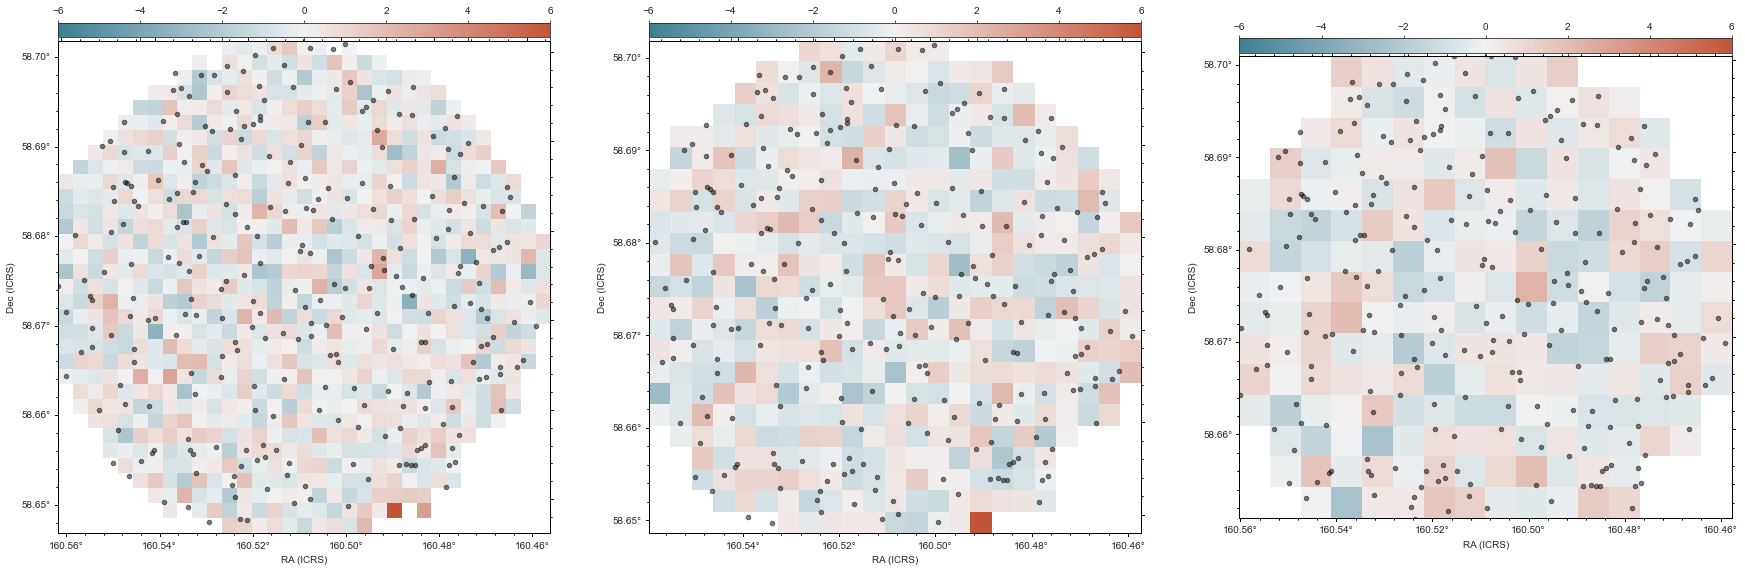

In [28]:
t=Bayes_pval_sources(fits_images)
if len(t)>0:
    priors,prior_list=process_prior(t,
                    path_to_data=['../../../data/'],
                      source=source,
                      field=field,
                      path_to_SPIRE=path_to_SPIRE,
                      redshift_file=redshift_file,
                      redshift_prior=[0.1,2.0],radius=10)
    xidplus.save(priors,None,'./output/{}/prior_'.format(field[0])+esb['field'][source[0]]+'_'+str(source[0])+'_model2')
    prior_list.write('./output/{}/prior_list_'.format(field[0])+esb['field'][source[0]]+'_'+str(source[0])+'_model2.ascii',format='ascii',overwrite=True)
    hier_params={'m_mu':0.8,'m_sig':0.4,'c_mu':-1.0,'c_sig':0.5,'sfr_disp':0.5}
    phys_prior=create_phys_prior(priors,prior_list,emulator_path)
    mcmc=fit_model(phys_prior,hier_params,num_samples=500, num_warmup=500,num_chains=n_chains,chain_method='parallel')

    ## For numpyro to sample from the prior, the data needs to be set to None
    import copy
    #make a deepcopy of the priors
    priors_prior_pred=copy.deepcopy(priors)
    #set data to None
    for i in range(0,len(priors)):
        priors_prior_pred[i].sim=None
    #sample from the prior using numpyro's Predictive function
    prior_predictive=Predictive(SED_prior.spire_model_CIGALE,posterior_samples = {}, num_samples = 1000,)
    prior_pred=prior_predictive(random.PRNGKey(0),priors_prior_pred,phys_prior,hier_params)
    
    #sample from the prior using numpyro's Predictive function
    prior_predictive_samp=Predictive(SED_prior.spire_model_CIGALE,posterior_samples = mcmc.get_samples(), num_samples = 50)
    prior_pred_samp=prior_predictive_samp(random.PRNGKey(0),priors_prior_pred,phys_prior,hier_params)
    mod_map_array_samp=[prior_pred_samp['obs_psw'].T,prior_pred_samp['obs_pmw'].T,prior_pred_samp['obs_plw'].T]
    samples=mcmc.get_samples()
    divergences=mcmc.get_extra_fields()['diverging']
    numpyro_data = az.from_numpyro(
        mcmc,
        prior=prior_pred,
        posterior_predictive=prior_pred_samp,
        coords={"src": np.arange(0,priors[0].nsrc),
               "band":np.arange(0,3)},
        dims={"agn": ["src"],
             "bkg":["band"],
             "redshift":["src"],
              "sfr":["src"]},
        )
    numpyro_data.to_netcdf('./output/{}/posterior_'.format(field[0])+esb['field'][source[0]]+'_'+str(source[0])+'_model2.nc')
    
    from xidplus import postmaps
    import aplpy
    sns.set_style("white")
    cmap = sns.diverging_palette(220, 20, as_cmap=True)
    Bayes_pvals = []
    hdulists = list(map(lambda prior: postmaps.make_fits_image(prior, prior.sim), priors))
    fig = plt.figure(figsize=(10 * len(priors), 10))
    figs = []
    for i in range(0, len(priors)):
        figs.append(aplpy.FITSFigure(hdulists[i][1], figure=fig, subplot=(1, len(priors), i + 1)))
        Bayes_pvals.append(postmaps.make_Bayesian_pval_maps(priors[i], mod_map_array_samp[i]))


    for i in range(0, len(priors)):
        figs[i].show_markers(priors[i].sra, priors[i].sdec, edgecolor='black', facecolor='black',
                             marker='o', s=20, alpha=0.5)
        figs[i].tick_labels.set_xformat('dd.dd')
        figs[i].tick_labels.set_yformat('dd.dd')
        figs[i]._data[
            priors[i].sy_pix - np.min(priors[i].sy_pix) - 1, priors[i].sx_pix - np.min(priors[i].sx_pix) - 1] = \
        Bayes_pvals[i]
        figs[i].show_colorscale(vmin=-6, vmax=6, cmap=cmap)
        figs[i].add_colorbar()
        figs[i].colorbar.set_location('top')

Read in the source we are interested in from Rowan-Robinsons's catalogue.

In [29]:


from astropy.coordinates import SkyCoord
from astropy import units as u
import os

c = SkyCoord(ra=[esb['RA'][source[0]]]*u.degree, dec=[esb['Dec'][source[0]]]*u.degree)

In [30]:
#Run the DAOstarfinder on the original maps for all SPIRE bands
from photutils import DAOStarFinder
fwhm=[17.6,23.9,35.2]
new_scat_flux=[]
new_scat_pos=[]
for b in range(0,len(priors)):
    tmp_fits=postmaps.make_fits_image(priors[b],priors[b].sim)
    wcs_temp = wcs.WCS(tmp_fits[1].header)
    daofind = DAOStarFinder(fwhm=fwhm[b]/np.abs(tmp_fits[1].header['CD1_1']*3600.0), threshold=5.0,sky=0.0,roundlo=- 10.0,roundhi= 10.0,sharplo=-5,sharphi=5)    
    new_scat = daofind(tmp_fits[1].data)
    new_scat_coords=wcs_temp.pixel_to_world(new_scat['xcentroid'],new_scat['ycentroid'])
    idx_new, d2d_new, d3d_new = c.match_to_catalog_sky(new_scat_coords)
    new_scat_flux.append(new_scat['peak'][idx_new])
    new_scat_pos.append(new_scat_coords[idx_new])


In [31]:
posterior_blind_source_coords=[]
posterior_blind_source_flux=[]
# Run starfinder on all posterior maps
for s in range(0,mod_map_array_samp[0].shape[-1]):
    if s%1000==0:
        print(s)
    tmp_posterior_blind_source_coords=[]
    tmp_posterior_blind_source_flux=[]
    for b in range(0,len(priors)):
        tmp_fits=postmaps.make_fits_image(priors[b],mod_map_array_samp[b][...,s])
        #need to widen constriants on roundness and sharpness constraints
        daofind = DAOStarFinder(fwhm=fwhm[b]/np.abs(tmp_fits[1].header['CD1_1']*3600.0), threshold=5,sky=0.0,roundlo=- 10.0,roundhi= 10.0,sharplo=-5,sharphi=5) 
        sources = daofind(tmp_fits[1].data)
        #print(sources)
        wcs_temp = wcs.WCS(tmp_fits[1].header)
        new_coords=wcs_temp.pixel_to_world(sources['xcentroid'],sources['ycentroid'])
   
            
        idx_tmp, d2d_tmp, d3d_tmp = c.match_to_catalog_sky(new_coords)
        tmp_posterior_blind_source_coords.append(new_coords[idx_tmp])
        tmp_posterior_blind_source_flux.append(sources[idx_tmp]['peak'])
    posterior_blind_source_coords.append(tmp_posterior_blind_source_coords)
    posterior_blind_source_flux.append(tmp_posterior_blind_source_flux)
        
    

0


1000


In [32]:
 # get original fluxes from scat
band=[250,350,500]
scat_flux=[]
scat_pos=[]
for b in band:
    file=glob.glob('../../../data/*-{}_SCAT{}SXT_DR2.fits.gz'.format(field[0],b))
    scat=Table.read(file[0])
    orig_scat_coords=SkyCoord(scat['RA'],scat['Dec'])
    
    idx, d2d, d3d = c.match_to_catalog_sky(orig_scat_coords)
    scat_flux.append(scat['Flux'][idx].data)
    scat_pos.append(orig_scat_coords[idx])
scat_flux=np.array(scat_flux)

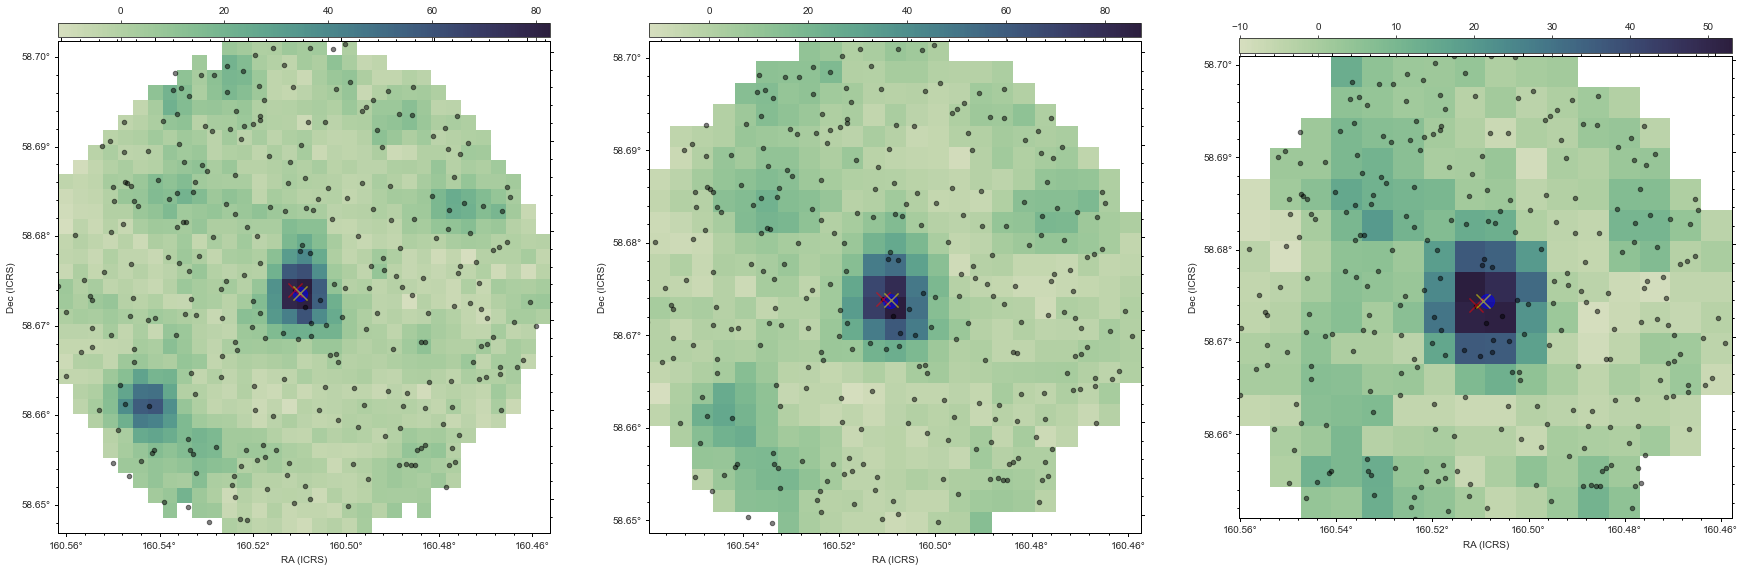

In [33]:
orig_map=xidplus.plot_map(priors)
for i in range(0,3):
    #plot new scat coords
    orig_map[0][i].show_markers(new_scat_pos[i].ra.value,new_scat_pos[i].dec.value,edgecolor='blue', facecolor='blue',
                marker='o', s=200, alpha=0.5)
    orig_map[0][i].show_markers(c.ra.value,c.dec.value, edgecolor='red', facecolor='red',
                marker='x', s=200, alpha=0.5)
    orig_map[0][i].show_markers(scat_pos[i].ra.value,scat_pos[i].dec.value,edgecolor='yellow', facecolor='yellow',
                marker='x', s=200, alpha=0.5)


In [34]:
#stack params and make vector ready to be used by emualator
params = jnp.stack((samples['sfr'].T, samples['agn'].T, samples['redshift'].T)).T
# Use emulator to get fluxes. As emulator provides log flux, convert.
src_f = np.array(jnp.exp(phys_prior.emulator['net_apply'](phys_prior.emulator['params'], params)))


#stack params and make vector ready to be used by emualator
params_prior = jnp.stack((prior_pred['sfr'].T, prior_pred['agn'].T, prior_pred['redshift'].T)).T
# Use emulator to get fluxes. As emulator provides log flux, convert.
src_f_prior = np.array(jnp.exp(phys_prior.emulator['net_apply'](phys_prior.emulator['params'], params_prior)))

In [35]:
src_f.shape

(2000, 279, 3)

In [36]:
#find the sources that are within a certain separation of the extreme starburst candidate
sep=12
separation=new_scat_pos[0].separation(SkyCoord(priors[0].sra,priors[0].sdec)).arcsec
contrib_sources=separation<sep
print(' Sources \n {} \n are possible contributers to flux of extreme starburst'.format(priors[0].ID[contrib_sources]))

 Sources 
           help_id          
---------------------------
HELP_J104201.994+584018.387
HELP_J104201.199+584021.132
HELP_J104202.499+584025.262 
 are possible contributers to flux of extreme starburst


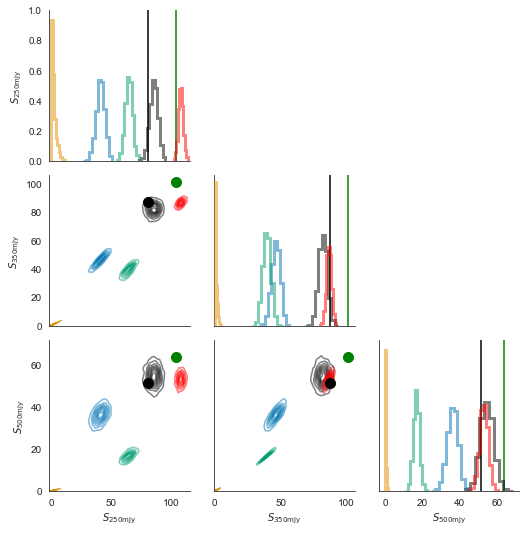

In [37]:
cmap=sns.color_palette('colorblind')
sns.set_style("white")
#set up Pairgrid plot and plot blind source flux
df_blind=pd.DataFrame(np.array(posterior_blind_source_flux)[:,:,0],columns=['$S_{250\mathrm{mJy}}$', '$S_{350\mathrm{mJy}}$', '$S_{500\mathrm{mJy}}$'])
g=sns.PairGrid(df_blind)
g.map_diag(plt.hist,histtype='step',linewidth=3.0, alpha=0.5,color='black')
#g.map_lower(sns.kdeplot, color="black",alpha=0.5,n_levels=10,density=True, shade=False,linewidth=3,shade_lowest=False)

#plot the fluxes for the possible sources that could contribute
for i in range(0,contrib_sources.sum()):
    df_tmp=pd.DataFrame(src_f[:,contrib_sources,:][:,i,:],columns=['$S_{250\mathrm{mJy}}$', '$S_{350\mathrm{mJy}}$', '$S_{500\mathrm{mJy}}$'])
    g.data=df_tmp
    g.map_diag(plt.hist,histtype='step',linewidth=3.0, alpha=0.5,color=cmap[i])
    #g.map_lower(sns.kdeplot, color=cmap[i],alpha=0.5,n_levels=10,density=True,linewidth=3, shade=False,shade_lowest=False)

# plot the combination of flux from those sources
df_sum=pd.DataFrame(np.sum(src_f[:,contrib_sources,:],axis=1),columns=['$S_{250\mathrm{mJy}}$', '$S_{350\mathrm{mJy}}$', '$S_{500\mathrm{mJy}}$'])
g.data=df_sum
g.map_diag(plt.hist,histtype='step',linewidth=3.0, alpha=0.5,color='Red')




g.data=df_blind
g.map_lower(sns.kdeplot, color="black",alpha=0.5,n_levels=10,density=True, shade=False,linewidth=3,shade_lowest=False)
for i in range(0,contrib_sources.sum()):
    df_tmp=pd.DataFrame(src_f[:,contrib_sources,:][:,i,:],columns=['$S_{250\mathrm{mJy}}$', '$S_{350\mathrm{mJy}}$', '$S_{500\mathrm{mJy}}$'])
    g.data=df_tmp
    #g.map_diag(plt.hist,histtype='step',linewidth=3.0, alpha=0.5,color=cmap[i])
    g.map_lower(sns.kdeplot, color=cmap[i],alpha=0.5,n_levels=10,density=True,linewidth=3, shade=False,shade_lowest=False)
g.data=df_sum
g.map_lower(sns.kdeplot, color='Red',alpha=0.5,n_levels=10,density=True,linewidth=3, shade=False,shade_lowest=False)
    
    
#turn off the axes not used
g.axes[0,1].set_axis_off()
g.axes[0,2].set_axis_off()
g.axes[1,2].set_axis_off()

#plot the fluxes from new scat and orig scat
for i in range(0,len(priors)):
    g.axes[i,i].axvline(x=new_scat_flux[i],color='black')
    g.axes[i,i].axvline(x=scat_flux[i],color='green')
    for j in range(0,len(priors)):
        if j>i:
            g.axes[j,i].plot(new_scat_flux[i],new_scat_flux[j],'ko',ms=10)
            g.axes[j,i].plot(scat_flux[i],scat_flux[j],'go',ms=10)
#g.axes[2,0].plot(0.39,32.63,'ko',ms=10)
#g.axes[3,0].plot(0.39,27.0,'ko',ms=10)


### Parameters of contributing sources
The physical parameters of our sources which could be contributing to the extreme starburst

update the webtable to identify issues

In [38]:
esb_web=Table.read('../../../data/MRR2018_tables/{}_web.csv'.format(field[0]),format='ascii',encoding='utf-8')
if np.sum(divergences)<1:
    esb_web['status'][source[0]]='[&#9745;](./output/{}/fit_{}.md)'.format(field[0],source[0]+1)
    esb_web.write('../../../data/MRR2018_tables/{}_web.csv'.format(field[0]),overwrite=True)
else:
    esb_web['status'][source[0]]='[&#9744;](./output/{}/fit_{}.md)'.format(field[0],source[0]+1)
    esb_web.write('../../../data/MRR2018_tables/{}_web.csv'.format(field[0]),overwrite=True)

## Alternative model.
Our alternative model mimics the assumption of the blind catalogue, by removing all sources close to the candidate source. We can do this and comapre the Bayesian P value maps to see if this provides a good fit to the map.

0


0


fitting 270 sources 

using 866, 451 and 216 pixels
source density = 111255.2581177607


  0%|          | 0/1000 [00:00<?, ?it/s]

warmup:   0%|          | 1/1000 [00:06<1:51:16,  6.68s/it, 1 steps of size 2.34e+00. acc. prob=0.00]

warmup:   1%|          | 7/1000 [00:06<11:49,  1.40it/s, 23 steps of size 4.79e-03. acc. prob=0.45] 

warmup:   1%|          | 11/1000 [00:09<12:03,  1.37it/s, 1023 steps of size 3.42e-03. acc. prob=0.57]

warmup:   1%|▏         | 13/1000 [00:11<12:08,  1.35it/s, 626 steps of size 6.28e-04. acc. prob=0.56] 

warmup:   2%|▏         | 15/1000 [00:13<12:59,  1.26it/s, 1023 steps of size 2.31e-03. acc. prob=0.62]

warmup:   2%|▏         | 16/1000 [00:14<13:23,  1.23it/s, 1023 steps of size 4.46e-03. acc. prob=0.64]

warmup:   2%|▏         | 17/1000 [00:15<13:44,  1.19it/s, 1023 steps of size 1.74e-03. acc. prob=0.63]

warmup:   2%|▏         | 18/1000 [00:16<14:07,  1.16it/s, 1023 steps of size 3.33e-03. acc. prob=0.65]

warmup:   2%|▏         | 19/1000 [00:17<14:32,  1.12it/s, 1023 steps of size 5.02e-03. acc. prob=0.67]

warmup:   2%|▏         | 20/1000 [00:17<14:44,  1.11it/s, 1023 steps of size 2.46e-03. acc. prob=0.66]

warmup:   2%|▏         | 21/1000 [00:18<14:55,  1.09it/s, 1023 steps of size 4.11e-03. acc. prob=0.67]

warmup:   2%|▏         | 22/1000 [00:19<15:01,  1.08it/s, 1023 steps of size 7.07e-03. acc. prob=0.69]

warmup:   2%|▏         | 24/1000 [00:20<11:54,  1.37it/s, 1023 steps of size 2.71e-03. acc. prob=0.68]

warmup:   2%|▎         | 25/1000 [00:21<12:41,  1.28it/s, 1023 steps of size 4.42e-03. acc. prob=0.69]

warmup:   3%|▎         | 26/1000 [00:22<13:20,  1.22it/s, 1023 steps of size 5.07e-03. acc. prob=0.70]

warmup:   3%|▎         | 27/1000 [00:23<13:58,  1.16it/s, 1023 steps of size 1.10e-03. acc. prob=0.68]

warmup:   3%|▎         | 28/1000 [00:24<14:26,  1.12it/s, 1023 steps of size 1.96e-03. acc. prob=0.69]

warmup:   3%|▎         | 29/1000 [00:25<14:39,  1.10it/s, 1023 steps of size 3.63e-03. acc. prob=0.70]

warmup:   3%|▎         | 30/1000 [00:26<14:48,  1.09it/s, 1023 steps of size 3.71e-03. acc. prob=0.70]

warmup:   3%|▎         | 31/1000 [00:27<15:02,  1.07it/s, 1023 steps of size 4.61e-03. acc. prob=0.71]

warmup:   3%|▎         | 32/1000 [00:28<15:12,  1.06it/s, 1023 steps of size 2.14e-03. acc. prob=0.70]

warmup:   3%|▎         | 33/1000 [00:29<15:15,  1.06it/s, 1023 steps of size 2.97e-03. acc. prob=0.71]

warmup:   3%|▎         | 34/1000 [00:30<15:14,  1.06it/s, 1023 steps of size 5.10e-03. acc. prob=0.72]

warmup:   4%|▎         | 35/1000 [00:31<15:12,  1.06it/s, 1023 steps of size 7.41e-03. acc. prob=0.72]

warmup:   4%|▎         | 37/1000 [00:32<11:42,  1.37it/s, 1023 steps of size 1.74e-03. acc. prob=0.71]

warmup:   4%|▍         | 38/1000 [00:33<12:34,  1.28it/s, 1023 steps of size 3.04e-03. acc. prob=0.72]

warmup:   4%|▍         | 39/1000 [00:34<13:13,  1.21it/s, 1023 steps of size 4.20e-03. acc. prob=0.72]

warmup:   4%|▍         | 40/1000 [00:35<13:42,  1.17it/s, 1023 steps of size 6.04e-03. acc. prob=0.73]

warmup:   4%|▍         | 42/1000 [00:36<11:10,  1.43it/s, 1023 steps of size 2.88e-03. acc. prob=0.72]

warmup:   4%|▍         | 43/1000 [00:37<12:05,  1.32it/s, 1023 steps of size 3.45e-03. acc. prob=0.73]

warmup:   4%|▍         | 44/1000 [00:37<12:48,  1.24it/s, 1023 steps of size 4.12e-03. acc. prob=0.73]

warmup:   4%|▍         | 45/1000 [00:38<13:26,  1.18it/s, 1023 steps of size 3.19e-03. acc. prob=0.73]

warmup:   5%|▍         | 46/1000 [00:39<13:51,  1.15it/s, 1023 steps of size 5.16e-03. acc. prob=0.73]

warmup:   5%|▍         | 47/1000 [00:40<11:53,  1.34it/s, 472 steps of size 4.81e-03. acc. prob=0.73] 

warmup:   5%|▍         | 48/1000 [00:41<12:45,  1.24it/s, 1023 steps of size 7.65e-03. acc. prob=0.74]

warmup:   5%|▌         | 50/1000 [00:42<10:21,  1.53it/s, 1023 steps of size 1.95e-03. acc. prob=0.73]

warmup:   5%|▌         | 51/1000 [00:43<11:27,  1.38it/s, 1023 steps of size 3.10e-03. acc. prob=0.73]

warmup:   5%|▌         | 52/1000 [00:44<12:22,  1.28it/s, 1023 steps of size 4.21e-03. acc. prob=0.74]

warmup:   5%|▌         | 53/1000 [00:45<13:01,  1.21it/s, 1023 steps of size 6.15e-03. acc. prob=0.74]

warmup:   5%|▌         | 54/1000 [00:45<10:18,  1.53it/s, 225 steps of size 2.03e-03. acc. prob=0.73] 

warmup:   6%|▌         | 55/1000 [00:46<11:35,  1.36it/s, 1023 steps of size 3.33e-03. acc. prob=0.74]

warmup:   6%|▌         | 56/1000 [00:47<12:30,  1.26it/s, 1023 steps of size 2.72e-03. acc. prob=0.74]

warmup:   6%|▌         | 57/1000 [00:48<13:09,  1.19it/s, 1023 steps of size 4.31e-03. acc. prob=0.74]

warmup:   6%|▌         | 58/1000 [00:49<13:39,  1.15it/s, 1023 steps of size 6.56e-03. acc. prob=0.74]

warmup:   6%|▌         | 59/1000 [00:49<10:09,  1.54it/s, 127 steps of size 1.28e-03. acc. prob=0.73] 

warmup:   6%|▌         | 60/1000 [00:50<11:38,  1.35it/s, 1023 steps of size 2.00e-03. acc. prob=0.74]

warmup:   6%|▌         | 61/1000 [00:51<12:36,  1.24it/s, 1023 steps of size 3.14e-03. acc. prob=0.74]

warmup:   6%|▌         | 62/1000 [00:51<13:13,  1.18it/s, 1023 steps of size 4.40e-03. acc. prob=0.74]

warmup:   6%|▋         | 63/1000 [00:52<13:39,  1.14it/s, 1023 steps of size 5.57e-03. acc. prob=0.75]

warmup:   6%|▋         | 64/1000 [00:53<13:59,  1.11it/s, 1023 steps of size 3.79e-03. acc. prob=0.74]

warmup:   6%|▋         | 65/1000 [00:54<14:11,  1.10it/s, 1023 steps of size 5.08e-03. acc. prob=0.75]

warmup:   7%|▋         | 66/1000 [00:55<14:19,  1.09it/s, 1023 steps of size 2.63e-03. acc. prob=0.74]

warmup:   7%|▋         | 67/1000 [00:56<14:24,  1.08it/s, 1023 steps of size 2.76e-03. acc. prob=0.74]

warmup:   7%|▋         | 68/1000 [00:57<14:26,  1.08it/s, 1023 steps of size 3.37e-03. acc. prob=0.74]

warmup:   7%|▋         | 69/1000 [00:58<14:30,  1.07it/s, 1023 steps of size 4.28e-03. acc. prob=0.75]

warmup:   7%|▋         | 70/1000 [00:59<14:31,  1.07it/s, 1023 steps of size 5.35e-03. acc. prob=0.75]

warmup:   7%|▋         | 71/1000 [01:00<14:33,  1.06it/s, 1023 steps of size 6.32e-03. acc. prob=0.75]

warmup:   7%|▋         | 72/1000 [01:01<13:32,  1.14it/s, 775 steps of size 2.55e-03. acc. prob=0.74] 

warmup:   7%|▋         | 73/1000 [01:02<13:49,  1.12it/s, 1023 steps of size 3.91e-03. acc. prob=0.75]

warmup:   7%|▋         | 74/1000 [01:03<14:05,  1.10it/s, 1023 steps of size 4.84e-03. acc. prob=0.75]

warmup:   8%|▊         | 75/1000 [01:04<14:13,  1.08it/s, 1023 steps of size 4.95e-03. acc. prob=0.75]

warmup:   8%|▊         | 76/1000 [01:04<14:17,  1.08it/s, 1023 steps of size 2.69e-03. acc. prob=0.75]

warmup:   8%|▊         | 77/1000 [01:05<14:20,  1.07it/s, 1023 steps of size 3.89e-03. acc. prob=0.75]

warmup:   8%|▊         | 78/1000 [01:06<14:22,  1.07it/s, 1023 steps of size 3.18e-03. acc. prob=0.75]

warmup:   8%|▊         | 79/1000 [01:07<14:22,  1.07it/s, 1023 steps of size 2.49e-03. acc. prob=0.75]

warmup:   8%|▊         | 80/1000 [01:08<14:24,  1.06it/s, 1023 steps of size 1.48e-03. acc. prob=0.74]

warmup:   8%|▊         | 81/1000 [01:09<14:24,  1.06it/s, 1023 steps of size 1.64e-03. acc. prob=0.75]

warmup:   8%|▊         | 82/1000 [01:10<14:22,  1.06it/s, 1023 steps of size 1.57e-03. acc. prob=0.75]

warmup:   8%|▊         | 83/1000 [01:11<14:23,  1.06it/s, 1023 steps of size 2.41e-03. acc. prob=0.75]

warmup:   8%|▊         | 84/1000 [01:12<14:22,  1.06it/s, 1023 steps of size 3.28e-03. acc. prob=0.75]

warmup:   8%|▊         | 85/1000 [01:13<14:23,  1.06it/s, 1023 steps of size 4.85e-03. acc. prob=0.75]

warmup:   9%|▊         | 86/1000 [01:14<13:52,  1.10it/s, 903 steps of size 1.31e-03. acc. prob=0.75] 

warmup:   9%|▊         | 87/1000 [01:15<13:59,  1.09it/s, 1023 steps of size 1.96e-03. acc. prob=0.75]

warmup:   9%|▉         | 88/1000 [01:16<14:04,  1.08it/s, 1023 steps of size 2.48e-03. acc. prob=0.75]

warmup:   9%|▉         | 89/1000 [01:17<14:07,  1.07it/s, 1023 steps of size 3.15e-03. acc. prob=0.75]

warmup:   9%|▉         | 90/1000 [01:18<14:09,  1.07it/s, 1023 steps of size 4.12e-03. acc. prob=0.75]

warmup:   9%|▉         | 91/1000 [01:19<14:12,  1.07it/s, 1023 steps of size 5.39e-03. acc. prob=0.76]

warmup:   9%|▉         | 92/1000 [01:19<11:29,  1.32it/s, 367 steps of size 2.71e-03. acc. prob=0.75] 

warmup:   9%|▉         | 93/1000 [01:20<12:18,  1.23it/s, 1023 steps of size 3.37e-03. acc. prob=0.75]

warmup:   9%|▉         | 94/1000 [01:21<12:51,  1.17it/s, 1023 steps of size 1.74e-03. acc. prob=0.75]

warmup:  10%|▉         | 95/1000 [01:22<13:15,  1.14it/s, 1023 steps of size 2.59e-03. acc. prob=0.75]

warmup:  10%|▉         | 96/1000 [01:23<13:31,  1.11it/s, 1023 steps of size 3.84e-03. acc. prob=0.76]

warmup:  10%|▉         | 97/1000 [01:24<13:44,  1.10it/s, 1023 steps of size 2.69e-03. acc. prob=0.75]

warmup:  10%|▉         | 98/1000 [01:25<13:57,  1.08it/s, 1023 steps of size 2.63e-03. acc. prob=0.75]

warmup:  10%|▉         | 99/1000 [01:25<14:00,  1.07it/s, 1023 steps of size 2.85e-03. acc. prob=0.75]

warmup:  10%|█         | 100/1000 [01:26<14:01,  1.07it/s, 1023 steps of size 2.22e-03. acc. prob=0.75]

warmup:  10%|█         | 101/1000 [01:27<14:02,  1.07it/s, 1023 steps of size 3.16e-02. acc. prob=0.76]

warmup:  10%|█         | 102/1000 [01:28<10:52,  1.38it/s, 255 steps of size 2.65e-02. acc. prob=0.76] 

warmup:  10%|█         | 103/1000 [01:28<08:41,  1.72it/s, 255 steps of size 2.16e-02. acc. prob=0.75]

warmup:  10%|█         | 104/1000 [01:28<07:09,  2.09it/s, 255 steps of size 2.38e-02. acc. prob=0.76]

warmup:  10%|█         | 105/1000 [01:28<06:03,  2.46it/s, 255 steps of size 2.22e-02. acc. prob=0.76]

warmup:  11%|█         | 106/1000 [01:29<05:17,  2.81it/s, 255 steps of size 3.52e-02. acc. prob=0.76]

warmup:  11%|█         | 107/1000 [01:29<04:13,  3.52it/s, 127 steps of size 1.95e-02. acc. prob=0.76]

warmup:  11%|█         | 108/1000 [01:29<04:00,  3.70it/s, 255 steps of size 8.25e-03. acc. prob=0.75]

warmup:  11%|█         | 109/1000 [01:29<04:54,  3.03it/s, 511 steps of size 1.23e-02. acc. prob=0.76]

warmup:  11%|█         | 110/1000 [01:30<05:31,  2.68it/s, 511 steps of size 1.73e-02. acc. prob=0.76]

warmup:  11%|█         | 111/1000 [01:30<04:55,  3.01it/s, 255 steps of size 1.77e-02. acc. prob=0.76]

warmup:  11%|█         | 112/1000 [01:30<04:29,  3.30it/s, 255 steps of size 7.76e-03. acc. prob=0.76]

warmup:  11%|█▏        | 113/1000 [01:31<07:18,  2.02it/s, 1023 steps of size 1.37e-02. acc. prob=0.76]

warmup:  11%|█▏        | 114/1000 [01:32<07:12,  2.05it/s, 511 steps of size 1.08e-02. acc. prob=0.76] 

warmup:  12%|█▏        | 115/1000 [01:32<07:09,  2.06it/s, 511 steps of size 1.25e-02. acc. prob=0.76]

warmup:  12%|█▏        | 116/1000 [01:33<07:07,  2.07it/s, 511 steps of size 1.56e-02. acc. prob=0.76]

warmup:  12%|█▏        | 117/1000 [01:33<07:08,  2.06it/s, 511 steps of size 2.63e-02. acc. prob=0.76]

warmup:  12%|█▏        | 118/1000 [01:33<06:03,  2.43it/s, 255 steps of size 4.52e-02. acc. prob=0.76]

warmup:  12%|█▏        | 120/1000 [01:34<06:35,  2.22it/s, 1023 steps of size 7.43e-03. acc. prob=0.76]

warmup:  12%|█▏        | 121/1000 [01:35<08:21,  1.75it/s, 1023 steps of size 9.77e-03. acc. prob=0.76]

warmup:  12%|█▏        | 122/1000 [01:36<07:58,  1.83it/s, 511 steps of size 1.17e-02. acc. prob=0.76] 

warmup:  12%|█▏        | 123/1000 [01:36<07:41,  1.90it/s, 511 steps of size 1.28e-02. acc. prob=0.76]

warmup:  12%|█▏        | 124/1000 [01:37<07:26,  1.96it/s, 511 steps of size 1.99e-02. acc. prob=0.76]

warmup:  12%|█▎        | 125/1000 [01:37<06:18,  2.31it/s, 255 steps of size 2.09e-02. acc. prob=0.76]

warmup:  13%|█▎        | 126/1000 [01:37<05:28,  2.66it/s, 255 steps of size 3.47e-02. acc. prob=0.76]

warmup:  13%|█▎        | 127/1000 [01:37<04:23,  3.32it/s, 127 steps of size 6.28e-03. acc. prob=0.76]

warmup:  13%|█▎        | 128/1000 [01:38<07:08,  2.03it/s, 1023 steps of size 7.87e-03. acc. prob=0.76]

warmup:  13%|█▎        | 129/1000 [01:39<09:04,  1.60it/s, 1023 steps of size 1.29e-02. acc. prob=0.76]

warmup:  13%|█▎        | 130/1000 [01:40<08:23,  1.73it/s, 511 steps of size 2.17e-02. acc. prob=0.76] 

warmup:  13%|█▎        | 131/1000 [01:40<06:55,  2.09it/s, 255 steps of size 3.50e-02. acc. prob=0.77]

warmup:  13%|█▎        | 132/1000 [01:40<05:22,  2.70it/s, 127 steps of size 7.87e-03. acc. prob=0.76]

warmup:  13%|█▎        | 133/1000 [01:41<05:47,  2.49it/s, 511 steps of size 9.89e-03. acc. prob=0.76]

warmup:  13%|█▎        | 134/1000 [01:41<06:05,  2.37it/s, 511 steps of size 1.59e-02. acc. prob=0.76]

warmup:  14%|█▎        | 135/1000 [01:42<06:17,  2.29it/s, 511 steps of size 1.97e-02. acc. prob=0.77]

warmup:  14%|█▎        | 136/1000 [01:42<05:25,  2.65it/s, 255 steps of size 1.87e-02. acc. prob=0.77]

warmup:  14%|█▎        | 137/1000 [01:42<04:49,  2.98it/s, 255 steps of size 2.50e-02. acc. prob=0.77]

warmup:  14%|█▍        | 138/1000 [01:42<04:23,  3.27it/s, 255 steps of size 5.83e-03. acc. prob=0.76]

warmup:  14%|█▍        | 139/1000 [01:43<07:09,  2.01it/s, 1023 steps of size 9.74e-03. acc. prob=0.76]

warmup:  14%|█▍        | 140/1000 [01:44<07:02,  2.04it/s, 511 steps of size 1.54e-02. acc. prob=0.77] 

warmup:  14%|█▍        | 141/1000 [01:44<06:56,  2.06it/s, 511 steps of size 1.40e-02. acc. prob=0.77]

warmup:  14%|█▍        | 142/1000 [01:45<06:52,  2.08it/s, 511 steps of size 1.93e-02. acc. prob=0.77]

warmup:  14%|█▍        | 143/1000 [01:45<05:49,  2.45it/s, 255 steps of size 2.53e-02. acc. prob=0.77]

warmup:  14%|█▍        | 144/1000 [01:45<05:05,  2.80it/s, 255 steps of size 1.64e-02. acc. prob=0.77]

warmup:  14%|█▍        | 145/1000 [01:45<04:33,  3.12it/s, 255 steps of size 2.66e-02. acc. prob=0.77]

warmup:  15%|█▍        | 146/1000 [01:46<04:12,  3.39it/s, 255 steps of size 3.72e-02. acc. prob=0.77]

warmup:  15%|█▍        | 147/1000 [01:46<03:26,  4.13it/s, 127 steps of size 5.68e-02. acc. prob=0.77]

warmup:  15%|█▍        | 149/1000 [01:46<03:26,  4.11it/s, 511 steps of size 1.57e-02. acc. prob=0.77]

warmup:  15%|█▌        | 150/1000 [01:46<03:25,  4.14it/s, 255 steps of size 2.41e-02. acc. prob=0.77]

warmup:  15%|█▌        | 151/1000 [01:47<03:23,  4.16it/s, 255 steps of size 2.97e-01. acc. prob=0.77]

warmup:  15%|█▌        | 154/1000 [01:47<02:48,  5.03it/s, 511 steps of size 1.23e-02. acc. prob=0.76]

warmup:  16%|█▌        | 155/1000 [01:48<03:34,  3.95it/s, 511 steps of size 1.42e-02. acc. prob=0.76]

warmup:  16%|█▌        | 156/1000 [01:48<03:31,  3.99it/s, 255 steps of size 2.23e-02. acc. prob=0.77]

warmup:  16%|█▌        | 158/1000 [01:49<04:50,  2.89it/s, 1023 steps of size 3.54e-03. acc. prob=0.76]

warmup:  16%|█▌        | 159/1000 [01:50<06:40,  2.10it/s, 1023 steps of size 5.35e-03. acc. prob=0.76]

warmup:  16%|█▌        | 160/1000 [01:51<08:12,  1.71it/s, 1023 steps of size 7.30e-03. acc. prob=0.76]

warmup:  16%|█▌        | 161/1000 [01:51<07:47,  1.80it/s, 511 steps of size 1.16e-02. acc. prob=0.77] 

warmup:  16%|█▌        | 162/1000 [01:52<07:28,  1.87it/s, 511 steps of size 1.73e-02. acc. prob=0.77]

warmup:  16%|█▋        | 163/1000 [01:52<06:19,  2.21it/s, 255 steps of size 1.93e-02. acc. prob=0.77]

warmup:  16%|█▋        | 164/1000 [01:52<04:58,  2.80it/s, 120 steps of size 5.24e-03. acc. prob=0.76]

warmup:  16%|█▋        | 165/1000 [01:53<07:19,  1.90it/s, 1023 steps of size 9.93e-03. acc. prob=0.77]

warmup:  17%|█▋        | 166/1000 [01:53<07:06,  1.95it/s, 511 steps of size 1.87e-02. acc. prob=0.77] 

warmup:  17%|█▋        | 167/1000 [01:54<05:58,  2.32it/s, 255 steps of size 1.50e-02. acc. prob=0.77]

warmup:  17%|█▋        | 168/1000 [01:54<05:10,  2.68it/s, 255 steps of size 1.62e-02. acc. prob=0.77]

warmup:  17%|█▋        | 169/1000 [01:54<04:36,  3.00it/s, 255 steps of size 5.70e-03. acc. prob=0.77]

warmup:  17%|█▋        | 170/1000 [01:55<07:06,  1.95it/s, 1023 steps of size 3.94e-03. acc. prob=0.76]

warmup:  17%|█▋        | 171/1000 [01:56<08:51,  1.56it/s, 1023 steps of size 6.64e-03. acc. prob=0.77]

warmup:  17%|█▋        | 172/1000 [01:57<10:05,  1.37it/s, 1023 steps of size 8.01e-03. acc. prob=0.77]

warmup:  17%|█▋        | 173/1000 [01:57<09:00,  1.53it/s, 511 steps of size 9.78e-03. acc. prob=0.77] 

warmup:  17%|█▋        | 174/1000 [01:58<08:14,  1.67it/s, 511 steps of size 1.41e-02. acc. prob=0.77]

warmup:  18%|█▊        | 175/1000 [01:58<06:46,  2.03it/s, 255 steps of size 2.19e-02. acc. prob=0.77]

warmup:  18%|█▊        | 177/1000 [01:59<05:18,  2.59it/s, 511 steps of size 1.53e-02. acc. prob=0.77]

warmup:  18%|█▊        | 178/1000 [01:59<04:47,  2.86it/s, 255 steps of size 2.02e-02. acc. prob=0.77]

warmup:  18%|█▊        | 180/1000 [02:00<05:37,  2.43it/s, 1023 steps of size 8.59e-03. acc. prob=0.77]

warmup:  18%|█▊        | 181/1000 [02:00<05:48,  2.35it/s, 511 steps of size 1.29e-02. acc. prob=0.77] 

warmup:  18%|█▊        | 182/1000 [02:01<05:10,  2.64it/s, 255 steps of size 5.31e-03. acc. prob=0.77]

warmup:  18%|█▊        | 183/1000 [02:02<07:09,  1.90it/s, 1023 steps of size 7.94e-03. acc. prob=0.77]

warmup:  18%|█▊        | 184/1000 [02:02<06:56,  1.96it/s, 511 steps of size 1.36e-02. acc. prob=0.77] 

warmup:  18%|█▊        | 185/1000 [02:02<06:46,  2.00it/s, 511 steps of size 3.47e-03. acc. prob=0.77]

warmup:  19%|█▊        | 186/1000 [02:03<08:30,  1.59it/s, 1023 steps of size 5.77e-03. acc. prob=0.77]

warmup:  19%|█▊        | 187/1000 [02:04<09:43,  1.39it/s, 1023 steps of size 9.65e-03. acc. prob=0.77]

warmup:  19%|█▉        | 188/1000 [02:05<08:46,  1.54it/s, 511 steps of size 1.25e-02. acc. prob=0.77] 

warmup:  19%|█▉        | 189/1000 [02:05<08:08,  1.66it/s, 511 steps of size 1.18e-02. acc. prob=0.77]

warmup:  19%|█▉        | 190/1000 [02:06<07:37,  1.77it/s, 511 steps of size 1.98e-02. acc. prob=0.77]

warmup:  19%|█▉        | 192/1000 [02:06<05:49,  2.31it/s, 511 steps of size 1.30e-02. acc. prob=0.77]

warmup:  19%|█▉        | 193/1000 [02:07<05:58,  2.25it/s, 511 steps of size 1.45e-02. acc. prob=0.77]

warmup:  19%|█▉        | 194/1000 [02:07<05:14,  2.56it/s, 255 steps of size 2.37e-02. acc. prob=0.77]

warmup:  20%|█▉        | 196/1000 [02:08<05:49,  2.30it/s, 1023 steps of size 7.64e-03. acc. prob=0.77]

warmup:  20%|█▉        | 197/1000 [02:09<05:55,  2.26it/s, 511 steps of size 1.08e-02. acc. prob=0.77] 

warmup:  20%|█▉        | 198/1000 [02:09<06:00,  2.22it/s, 511 steps of size 1.51e-02. acc. prob=0.77]

warmup:  20%|█▉        | 199/1000 [02:09<05:15,  2.54it/s, 255 steps of size 7.46e-03. acc. prob=0.77]

warmup:  20%|██        | 200/1000 [02:10<05:31,  2.41it/s, 511 steps of size 1.20e-02. acc. prob=0.77]

warmup:  20%|██        | 201/1000 [02:10<05:45,  2.31it/s, 511 steps of size 1.21e-02. acc. prob=0.77]

warmup:  20%|██        | 202/1000 [02:11<05:54,  2.25it/s, 511 steps of size 1.30e-02. acc. prob=0.77]

warmup:  20%|██        | 203/1000 [02:11<06:00,  2.21it/s, 511 steps of size 1.62e-02. acc. prob=0.77]

warmup:  20%|██        | 204/1000 [02:11<05:09,  2.57it/s, 255 steps of size 2.12e-02. acc. prob=0.77]

warmup:  21%|██        | 206/1000 [02:12<04:27,  2.97it/s, 511 steps of size 1.30e-02. acc. prob=0.77]

warmup:  21%|██        | 207/1000 [02:12<04:53,  2.70it/s, 511 steps of size 1.18e-02. acc. prob=0.77]

warmup:  21%|██        | 208/1000 [02:13<05:14,  2.52it/s, 511 steps of size 1.57e-02. acc. prob=0.77]

warmup:  21%|██        | 209/1000 [02:13<04:40,  2.82it/s, 255 steps of size 2.00e-02. acc. prob=0.77]

warmup:  21%|██        | 211/1000 [02:14<05:25,  2.42it/s, 1023 steps of size 6.22e-03. acc. prob=0.77]

warmup:  21%|██        | 212/1000 [02:15<07:04,  1.86it/s, 1023 steps of size 9.48e-03. acc. prob=0.77]

warmup:  21%|██▏       | 213/1000 [02:16<06:50,  1.92it/s, 511 steps of size 1.49e-02. acc. prob=0.77] 

warmup:  21%|██▏       | 214/1000 [02:16<05:50,  2.24it/s, 255 steps of size 1.79e-02. acc. prob=0.77]

warmup:  22%|██▏       | 215/1000 [02:16<05:04,  2.58it/s, 255 steps of size 2.42e-02. acc. prob=0.77]

warmup:  22%|██▏       | 217/1000 [02:17<05:35,  2.34it/s, 1023 steps of size 7.30e-03. acc. prob=0.77]

warmup:  22%|██▏       | 218/1000 [02:18<07:11,  1.81it/s, 1023 steps of size 1.12e-02. acc. prob=0.77]

warmup:  22%|██▏       | 219/1000 [02:18<06:55,  1.88it/s, 511 steps of size 1.73e-02. acc. prob=0.77] 

warmup:  22%|██▏       | 220/1000 [02:19<05:54,  2.20it/s, 255 steps of size 1.84e-02. acc. prob=0.77]

warmup:  22%|██▏       | 222/1000 [02:19<04:49,  2.69it/s, 511 steps of size 1.05e-02. acc. prob=0.77]

warmup:  22%|██▏       | 223/1000 [02:20<05:07,  2.52it/s, 511 steps of size 1.48e-02. acc. prob=0.77]

warmup:  22%|██▏       | 224/1000 [02:20<04:36,  2.81it/s, 255 steps of size 2.08e-02. acc. prob=0.77]

warmup:  22%|██▎       | 225/1000 [02:20<03:49,  3.38it/s, 138 steps of size 6.44e-03. acc. prob=0.77]

warmup:  23%|██▎       | 226/1000 [02:21<06:05,  2.12it/s, 1023 steps of size 7.77e-03. acc. prob=0.77]

warmup:  23%|██▎       | 227/1000 [02:21<06:04,  2.12it/s, 511 steps of size 1.06e-02. acc. prob=0.77] 

warmup:  23%|██▎       | 228/1000 [02:22<06:04,  2.12it/s, 511 steps of size 1.37e-02. acc. prob=0.77]

warmup:  23%|██▎       | 229/1000 [02:22<06:03,  2.12it/s, 511 steps of size 7.95e-03. acc. prob=0.77]

warmup:  23%|██▎       | 230/1000 [02:23<06:03,  2.12it/s, 511 steps of size 1.13e-02. acc. prob=0.77]

warmup:  23%|██▎       | 231/1000 [02:23<06:03,  2.12it/s, 511 steps of size 9.97e-03. acc. prob=0.77]

warmup:  23%|██▎       | 232/1000 [02:24<06:02,  2.12it/s, 511 steps of size 1.23e-02. acc. prob=0.77]

warmup:  23%|██▎       | 233/1000 [02:24<06:01,  2.12it/s, 511 steps of size 1.79e-02. acc. prob=0.77]

warmup:  23%|██▎       | 234/1000 [02:24<05:07,  2.49it/s, 255 steps of size 2.30e-02. acc. prob=0.78]

warmup:  24%|██▎       | 236/1000 [02:25<04:16,  2.98it/s, 511 steps of size 9.25e-03. acc. prob=0.77]

warmup:  24%|██▎       | 237/1000 [02:25<04:41,  2.71it/s, 511 steps of size 1.33e-02. acc. prob=0.77]

warmup:  24%|██▍       | 238/1000 [02:26<05:01,  2.53it/s, 511 steps of size 1.87e-02. acc. prob=0.78]

warmup:  24%|██▍       | 240/1000 [02:27<05:32,  2.28it/s, 1023 steps of size 6.48e-03. acc. prob=0.77]

warmup:  24%|██▍       | 241/1000 [02:28<07:01,  1.80it/s, 1023 steps of size 8.33e-03. acc. prob=0.77]

warmup:  24%|██▍       | 242/1000 [02:28<06:46,  1.86it/s, 511 steps of size 9.78e-03. acc. prob=0.77] 

warmup:  24%|██▍       | 243/1000 [02:29<06:33,  1.92it/s, 511 steps of size 6.43e-03. acc. prob=0.77]

warmup:  24%|██▍       | 244/1000 [02:30<07:59,  1.58it/s, 1023 steps of size 9.18e-03. acc. prob=0.77]

warmup:  24%|██▍       | 245/1000 [02:30<07:25,  1.70it/s, 511 steps of size 1.35e-02. acc. prob=0.77] 

warmup:  25%|██▍       | 246/1000 [02:31<06:58,  1.80it/s, 511 steps of size 1.08e-02. acc. prob=0.77]

warmup:  25%|██▍       | 247/1000 [02:31<06:39,  1.88it/s, 511 steps of size 1.36e-02. acc. prob=0.78]

warmup:  25%|██▍       | 248/1000 [02:32<06:26,  1.95it/s, 511 steps of size 9.08e-03. acc. prob=0.77]

warmup:  25%|██▍       | 249/1000 [02:32<06:16,  2.00it/s, 511 steps of size 1.07e-02. acc. prob=0.77]

warmup:  25%|██▌       | 250/1000 [02:33<06:09,  2.03it/s, 511 steps of size 1.08e-02. acc. prob=0.77]

warmup:  25%|██▌       | 251/1000 [02:33<06:05,  2.05it/s, 511 steps of size 1.15e-01. acc. prob=0.78]

warmup:  25%|██▌       | 253/1000 [02:33<03:37,  3.43it/s, 126 steps of size 8.97e-03. acc. prob=0.77]

warmup:  25%|██▌       | 254/1000 [02:34<04:10,  2.97it/s, 511 steps of size 9.95e-03. acc. prob=0.77]

warmup:  26%|██▌       | 255/1000 [02:34<04:36,  2.69it/s, 511 steps of size 1.46e-02. acc. prob=0.77]

warmup:  26%|██▌       | 256/1000 [02:34<04:09,  2.99it/s, 255 steps of size 8.65e-03. acc. prob=0.77]

warmup:  26%|██▌       | 257/1000 [02:35<04:37,  2.68it/s, 511 steps of size 1.47e-02. acc. prob=0.77]

warmup:  26%|██▌       | 258/1000 [02:35<04:07,  3.00it/s, 255 steps of size 2.31e-02. acc. prob=0.77]

warmup:  26%|██▌       | 260/1000 [02:36<04:56,  2.50it/s, 1023 steps of size 4.26e-03. acc. prob=0.77]

warmup:  26%|██▌       | 261/1000 [02:37<06:33,  1.88it/s, 1023 steps of size 7.07e-03. acc. prob=0.77]

warmup:  26%|██▌       | 262/1000 [02:37<06:23,  1.92it/s, 511 steps of size 1.15e-02. acc. prob=0.77] 

warmup:  26%|██▋       | 263/1000 [02:38<06:16,  1.96it/s, 511 steps of size 2.14e-02. acc. prob=0.77]

warmup:  26%|██▋       | 265/1000 [02:39<06:09,  1.99it/s, 1023 steps of size 5.40e-03. acc. prob=0.77]

warmup:  27%|██▋       | 266/1000 [02:40<07:26,  1.65it/s, 1023 steps of size 9.94e-03. acc. prob=0.77]

warmup:  27%|██▋       | 267/1000 [02:40<07:00,  1.74it/s, 511 steps of size 1.66e-02. acc. prob=0.77] 

warmup:  27%|██▋       | 268/1000 [02:41<05:54,  2.07it/s, 255 steps of size 1.93e-02. acc. prob=0.77]

warmup:  27%|██▋       | 269/1000 [02:41<05:04,  2.40it/s, 255 steps of size 4.35e-03. acc. prob=0.77]

warmup:  27%|██▋       | 270/1000 [02:42<06:51,  1.77it/s, 1023 steps of size 7.49e-03. acc. prob=0.77]

warmup:  27%|██▋       | 271/1000 [02:42<06:31,  1.86it/s, 511 steps of size 1.07e-02. acc. prob=0.77] 

warmup:  27%|██▋       | 272/1000 [02:43<06:19,  1.92it/s, 511 steps of size 1.69e-02. acc. prob=0.77]

warmup:  27%|██▋       | 273/1000 [02:43<05:18,  2.28it/s, 255 steps of size 2.32e-02. acc. prob=0.77]

warmup:  27%|██▋       | 274/1000 [02:43<04:35,  2.64it/s, 255 steps of size 9.15e-03. acc. prob=0.77]

warmup:  28%|██▊       | 275/1000 [02:44<04:55,  2.45it/s, 511 steps of size 1.31e-02. acc. prob=0.77]

warmup:  28%|██▊       | 276/1000 [02:44<04:18,  2.80it/s, 255 steps of size 1.48e-02. acc. prob=0.77]

warmup:  28%|██▊       | 277/1000 [02:44<03:52,  3.11it/s, 255 steps of size 1.55e-02. acc. prob=0.77]

warmup:  28%|██▊       | 278/1000 [02:44<03:34,  3.37it/s, 255 steps of size 1.24e-02. acc. prob=0.77]

warmup:  28%|██▊       | 279/1000 [02:45<04:11,  2.87it/s, 511 steps of size 1.28e-02. acc. prob=0.77]

warmup:  28%|██▊       | 280/1000 [02:45<03:47,  3.16it/s, 255 steps of size 2.16e-02. acc. prob=0.78]

warmup:  28%|██▊       | 282/1000 [02:46<04:42,  2.54it/s, 1023 steps of size 4.89e-03. acc. prob=0.77]

warmup:  28%|██▊       | 283/1000 [02:47<06:19,  1.89it/s, 1023 steps of size 6.84e-03. acc. prob=0.77]

warmup:  28%|██▊       | 284/1000 [02:47<06:08,  1.94it/s, 511 steps of size 9.34e-03. acc. prob=0.77] 

warmup:  28%|██▊       | 285/1000 [02:48<06:00,  1.98it/s, 511 steps of size 1.58e-02. acc. prob=0.78]

warmup:  29%|██▊       | 286/1000 [02:48<05:06,  2.33it/s, 255 steps of size 6.26e-03. acc. prob=0.77]

warmup:  29%|██▊       | 287/1000 [02:49<05:15,  2.26it/s, 511 steps of size 1.03e-02. acc. prob=0.77]

warmup:  29%|██▉       | 288/1000 [02:49<05:20,  2.22it/s, 511 steps of size 1.62e-02. acc. prob=0.78]

warmup:  29%|██▉       | 289/1000 [02:49<04:35,  2.58it/s, 255 steps of size 2.67e-02. acc. prob=0.78]

warmup:  29%|██▉       | 291/1000 [02:50<05:02,  2.34it/s, 1023 steps of size 5.88e-03. acc. prob=0.77]

warmup:  29%|██▉       | 292/1000 [02:51<06:31,  1.81it/s, 1023 steps of size 8.73e-03. acc. prob=0.77]

warmup:  29%|██▉       | 293/1000 [02:52<06:15,  1.88it/s, 511 steps of size 7.40e-03. acc. prob=0.77] 

warmup:  29%|██▉       | 294/1000 [02:52<06:03,  1.94it/s, 511 steps of size 1.09e-02. acc. prob=0.78]

warmup:  30%|██▉       | 295/1000 [02:53<05:54,  1.99it/s, 511 steps of size 1.27e-02. acc. prob=0.78]

warmup:  30%|██▉       | 296/1000 [02:53<05:49,  2.01it/s, 511 steps of size 1.99e-02. acc. prob=0.78]

warmup:  30%|██▉       | 298/1000 [02:54<05:48,  2.02it/s, 1023 steps of size 8.75e-03. acc. prob=0.78]

warmup:  30%|██▉       | 299/1000 [02:55<05:43,  2.04it/s, 511 steps of size 1.13e-02. acc. prob=0.78] 

warmup:  30%|███       | 300/1000 [02:55<05:39,  2.06it/s, 511 steps of size 1.50e-02. acc. prob=0.78]

warmup:  30%|███       | 301/1000 [02:55<04:52,  2.39it/s, 255 steps of size 1.33e-02. acc. prob=0.78]

warmup:  30%|███       | 302/1000 [02:56<04:16,  2.72it/s, 255 steps of size 7.13e-03. acc. prob=0.78]

warmup:  30%|███       | 303/1000 [02:56<04:36,  2.52it/s, 511 steps of size 1.09e-02. acc. prob=0.78]

warmup:  30%|███       | 304/1000 [02:56<04:51,  2.39it/s, 511 steps of size 1.43e-02. acc. prob=0.78]

warmup:  30%|███       | 305/1000 [02:57<04:13,  2.74it/s, 255 steps of size 2.04e-02. acc. prob=0.78]

warmup:  31%|███       | 306/1000 [02:57<03:21,  3.45it/s, 116 steps of size 5.65e-03. acc. prob=0.78]

warmup:  31%|███       | 307/1000 [02:58<05:34,  2.07it/s, 1023 steps of size 8.45e-03. acc. prob=0.78]

warmup:  31%|███       | 308/1000 [02:58<05:32,  2.08it/s, 511 steps of size 1.14e-02. acc. prob=0.78] 

warmup:  31%|███       | 309/1000 [02:59<05:30,  2.09it/s, 511 steps of size 1.22e-02. acc. prob=0.78]

warmup:  31%|███       | 310/1000 [02:59<05:28,  2.10it/s, 511 steps of size 1.60e-02. acc. prob=0.78]

warmup:  31%|███       | 311/1000 [02:59<04:38,  2.47it/s, 255 steps of size 8.89e-03. acc. prob=0.78]

warmup:  31%|███       | 312/1000 [03:00<04:52,  2.36it/s, 511 steps of size 1.33e-02. acc. prob=0.78]

warmup:  31%|███▏      | 313/1000 [03:00<04:12,  2.72it/s, 255 steps of size 2.05e-02. acc. prob=0.78]

warmup:  31%|███▏      | 314/1000 [03:00<03:25,  3.35it/s, 147 steps of size 8.44e-03. acc. prob=0.78]

warmup:  32%|███▏      | 315/1000 [03:01<04:00,  2.85it/s, 511 steps of size 1.29e-02. acc. prob=0.78]

warmup:  32%|███▏      | 316/1000 [03:01<03:36,  3.16it/s, 255 steps of size 1.90e-02. acc. prob=0.78]

warmup:  32%|███▏      | 317/1000 [03:01<03:19,  3.42it/s, 255 steps of size 2.65e-02. acc. prob=0.78]

warmup:  32%|███▏      | 319/1000 [03:02<04:16,  2.66it/s, 1023 steps of size 8.61e-03. acc. prob=0.78]

warmup:  32%|███▏      | 320/1000 [03:03<04:31,  2.50it/s, 511 steps of size 1.29e-02. acc. prob=0.78] 

warmup:  32%|███▏      | 321/1000 [03:03<04:45,  2.38it/s, 511 steps of size 8.99e-03. acc. prob=0.78]

warmup:  32%|███▏      | 322/1000 [03:04<04:54,  2.30it/s, 511 steps of size 7.20e-03. acc. prob=0.78]

warmup:  32%|███▏      | 323/1000 [03:04<05:00,  2.25it/s, 511 steps of size 7.72e-03. acc. prob=0.78]

warmup:  32%|███▏      | 324/1000 [03:05<05:05,  2.21it/s, 511 steps of size 1.16e-02. acc. prob=0.78]

warmup:  32%|███▎      | 325/1000 [03:05<05:09,  2.18it/s, 511 steps of size 1.71e-02. acc. prob=0.78]

warmup:  33%|███▎      | 326/1000 [03:05<04:24,  2.55it/s, 255 steps of size 1.62e-02. acc. prob=0.78]

warmup:  33%|███▎      | 327/1000 [03:05<03:53,  2.88it/s, 255 steps of size 1.37e-02. acc. prob=0.78]

warmup:  33%|███▎      | 328/1000 [03:06<03:31,  3.18it/s, 255 steps of size 1.76e-02. acc. prob=0.78]

warmup:  33%|███▎      | 329/1000 [03:06<03:15,  3.43it/s, 255 steps of size 1.14e-02. acc. prob=0.78]

warmup:  33%|███▎      | 330/1000 [03:06<03:51,  2.90it/s, 511 steps of size 1.51e-02. acc. prob=0.78]

warmup:  33%|███▎      | 331/1000 [03:07<03:29,  3.20it/s, 255 steps of size 8.98e-03. acc. prob=0.78]

warmup:  33%|███▎      | 332/1000 [03:07<04:01,  2.76it/s, 511 steps of size 9.21e-03. acc. prob=0.78]

warmup:  33%|███▎      | 333/1000 [03:08<04:23,  2.53it/s, 511 steps of size 1.35e-02. acc. prob=0.78]

warmup:  33%|███▎      | 334/1000 [03:08<03:51,  2.88it/s, 255 steps of size 1.67e-02. acc. prob=0.78]

warmup:  34%|███▎      | 335/1000 [03:08<03:29,  3.17it/s, 255 steps of size 2.31e-02. acc. prob=0.78]

warmup:  34%|███▎      | 337/1000 [03:09<04:18,  2.57it/s, 1023 steps of size 7.58e-03. acc. prob=0.78]

warmup:  34%|███▍      | 338/1000 [03:09<04:31,  2.44it/s, 511 steps of size 6.09e-03. acc. prob=0.78] 

warmup:  34%|███▍      | 339/1000 [03:10<06:03,  1.82it/s, 1023 steps of size 8.93e-03. acc. prob=0.78]

warmup:  34%|███▍      | 340/1000 [03:11<05:50,  1.88it/s, 511 steps of size 1.24e-02. acc. prob=0.78] 

warmup:  34%|███▍      | 341/1000 [03:11<04:56,  2.22it/s, 255 steps of size 8.23e-03. acc. prob=0.78]

warmup:  34%|███▍      | 342/1000 [03:12<05:02,  2.18it/s, 511 steps of size 1.19e-02. acc. prob=0.78]

warmup:  34%|███▍      | 343/1000 [03:12<05:04,  2.15it/s, 511 steps of size 1.56e-02. acc. prob=0.78]

warmup:  34%|███▍      | 344/1000 [03:12<04:20,  2.51it/s, 255 steps of size 2.21e-02. acc. prob=0.78]

warmup:  35%|███▍      | 346/1000 [03:13<04:43,  2.30it/s, 1023 steps of size 8.17e-03. acc. prob=0.78]

warmup:  35%|███▍      | 347/1000 [03:14<04:49,  2.25it/s, 511 steps of size 9.18e-03. acc. prob=0.78] 

warmup:  35%|███▍      | 348/1000 [03:14<04:54,  2.22it/s, 511 steps of size 8.64e-03. acc. prob=0.78]

warmup:  35%|███▍      | 349/1000 [03:15<04:57,  2.19it/s, 511 steps of size 9.81e-03. acc. prob=0.78]

warmup:  35%|███▌      | 350/1000 [03:15<04:59,  2.17it/s, 511 steps of size 1.43e-02. acc. prob=0.78]

warmup:  35%|███▌      | 351/1000 [03:15<04:18,  2.51it/s, 255 steps of size 1.56e-02. acc. prob=0.78]

warmup:  35%|███▌      | 352/1000 [03:16<03:47,  2.85it/s, 255 steps of size 1.30e-02. acc. prob=0.78]

warmup:  35%|███▌      | 353/1000 [03:16<04:09,  2.59it/s, 511 steps of size 1.41e-02. acc. prob=0.78]

warmup:  35%|███▌      | 354/1000 [03:16<03:41,  2.92it/s, 255 steps of size 1.96e-02. acc. prob=0.78]

warmup:  36%|███▌      | 355/1000 [03:17<03:16,  3.27it/s, 235 steps of size 1.82e-02. acc. prob=0.78]

warmup:  36%|███▌      | 356/1000 [03:17<02:43,  3.93it/s, 143 steps of size 1.50e-02. acc. prob=0.78]

warmup:  36%|███▌      | 357/1000 [03:17<02:40,  4.02it/s, 255 steps of size 1.81e-02. acc. prob=0.78]

warmup:  36%|███▌      | 358/1000 [03:17<02:37,  4.08it/s, 255 steps of size 6.32e-03. acc. prob=0.78]

warmup:  36%|███▌      | 359/1000 [03:18<04:51,  2.20it/s, 1023 steps of size 6.69e-03. acc. prob=0.78]

warmup:  36%|███▌      | 360/1000 [03:19<04:54,  2.17it/s, 511 steps of size 9.45e-03. acc. prob=0.78] 

warmup:  36%|███▌      | 361/1000 [03:19<04:56,  2.16it/s, 511 steps of size 1.14e-02. acc. prob=0.78]

warmup:  36%|███▌      | 362/1000 [03:20<04:57,  2.15it/s, 511 steps of size 1.61e-02. acc. prob=0.78]

warmup:  36%|███▋      | 363/1000 [03:20<04:13,  2.52it/s, 255 steps of size 1.09e-02. acc. prob=0.78]

warmup:  36%|███▋      | 364/1000 [03:20<04:26,  2.38it/s, 511 steps of size 1.27e-02. acc. prob=0.78]

warmup:  36%|███▋      | 365/1000 [03:21<04:36,  2.30it/s, 511 steps of size 1.02e-02. acc. prob=0.78]

warmup:  37%|███▋      | 366/1000 [03:21<04:42,  2.25it/s, 511 steps of size 1.21e-02. acc. prob=0.78]

warmup:  37%|███▋      | 367/1000 [03:22<04:46,  2.21it/s, 511 steps of size 1.42e-02. acc. prob=0.78]

warmup:  37%|███▋      | 368/1000 [03:22<04:05,  2.58it/s, 255 steps of size 1.55e-02. acc. prob=0.78]

warmup:  37%|███▋      | 369/1000 [03:22<03:36,  2.92it/s, 255 steps of size 9.89e-03. acc. prob=0.78]

warmup:  37%|███▋      | 370/1000 [03:23<04:00,  2.62it/s, 511 steps of size 1.36e-02. acc. prob=0.78]

warmup:  37%|███▋      | 371/1000 [03:23<03:33,  2.95it/s, 255 steps of size 4.27e-03. acc. prob=0.78]

warmup:  37%|███▋      | 372/1000 [03:24<05:26,  1.92it/s, 1023 steps of size 5.97e-03. acc. prob=0.78]

warmup:  37%|███▋      | 373/1000 [03:25<06:45,  1.55it/s, 1023 steps of size 7.62e-03. acc. prob=0.78]

warmup:  37%|███▋      | 374/1000 [03:25<06:12,  1.68it/s, 511 steps of size 1.03e-02. acc. prob=0.78] 

warmup:  38%|███▊      | 375/1000 [03:26<05:48,  1.79it/s, 511 steps of size 1.44e-02. acc. prob=0.78]

warmup:  38%|███▊      | 376/1000 [03:26<04:48,  2.16it/s, 255 steps of size 2.01e-02. acc. prob=0.78]

warmup:  38%|███▊      | 377/1000 [03:26<04:06,  2.53it/s, 255 steps of size 2.79e-02. acc. prob=0.78]

warmup:  38%|███▊      | 378/1000 [03:26<03:14,  3.20it/s, 127 steps of size 1.40e-02. acc. prob=0.78]

warmup:  38%|███▊      | 379/1000 [03:27<02:59,  3.45it/s, 255 steps of size 1.75e-02. acc. prob=0.78]

warmup:  38%|███▊      | 380/1000 [03:27<02:49,  3.66it/s, 255 steps of size 2.33e-02. acc. prob=0.78]

warmup:  38%|███▊      | 381/1000 [03:27<02:35,  3.99it/s, 212 steps of size 1.10e-02. acc. prob=0.78]

warmup:  38%|███▊      | 382/1000 [03:27<03:15,  3.16it/s, 511 steps of size 1.27e-02. acc. prob=0.78]

warmup:  38%|███▊      | 383/1000 [03:28<03:00,  3.41it/s, 255 steps of size 1.76e-02. acc. prob=0.78]

warmup:  38%|███▊      | 384/1000 [03:28<02:50,  3.61it/s, 255 steps of size 2.27e-02. acc. prob=0.78]

warmup:  38%|███▊      | 385/1000 [03:28<02:43,  3.77it/s, 255 steps of size 2.75e-02. acc. prob=0.78]

warmup:  39%|███▊      | 386/1000 [03:28<02:15,  4.52it/s, 127 steps of size 3.18e-02. acc. prob=0.78]

warmup:  39%|███▊      | 387/1000 [03:28<01:57,  5.23it/s, 127 steps of size 2.30e-02. acc. prob=0.78]

warmup:  39%|███▉      | 388/1000 [03:29<02:05,  4.88it/s, 255 steps of size 2.36e-02. acc. prob=0.78]

warmup:  39%|███▉      | 389/1000 [03:29<02:10,  4.67it/s, 255 steps of size 2.09e-02. acc. prob=0.78]

warmup:  39%|███▉      | 390/1000 [03:29<02:14,  4.53it/s, 255 steps of size 1.53e-02. acc. prob=0.78]

warmup:  39%|███▉      | 391/1000 [03:29<02:18,  4.41it/s, 255 steps of size 1.77e-02. acc. prob=0.78]

warmup:  39%|███▉      | 392/1000 [03:30<02:19,  4.35it/s, 255 steps of size 2.35e-02. acc. prob=0.78]

warmup:  39%|███▉      | 393/1000 [03:30<02:20,  4.32it/s, 255 steps of size 2.42e-02. acc. prob=0.78]

warmup:  39%|███▉      | 394/1000 [03:30<02:21,  4.29it/s, 255 steps of size 1.05e-02. acc. prob=0.78]

warmup:  40%|███▉      | 395/1000 [03:31<03:04,  3.28it/s, 511 steps of size 1.05e-02. acc. prob=0.78]

warmup:  40%|███▉      | 396/1000 [03:31<03:33,  2.82it/s, 511 steps of size 1.31e-02. acc. prob=0.78]

warmup:  40%|███▉      | 397/1000 [03:31<03:12,  3.13it/s, 255 steps of size 1.25e-02. acc. prob=0.78]

warmup:  40%|███▉      | 398/1000 [03:31<02:57,  3.40it/s, 255 steps of size 1.53e-02. acc. prob=0.78]

warmup:  40%|███▉      | 399/1000 [03:32<02:46,  3.61it/s, 255 steps of size 1.95e-02. acc. prob=0.78]

warmup:  40%|████      | 401/1000 [03:33<03:43,  2.68it/s, 1023 steps of size 8.17e-03. acc. prob=0.78]

warmup:  40%|████      | 402/1000 [03:33<03:58,  2.51it/s, 511 steps of size 6.45e-03. acc. prob=0.78] 

warmup:  40%|████      | 403/1000 [03:34<05:25,  1.84it/s, 1023 steps of size 6.36e-03. acc. prob=0.78]

warmup:  40%|████      | 404/1000 [03:35<06:28,  1.53it/s, 1023 steps of size 7.41e-03. acc. prob=0.78]

warmup:  40%|████      | 405/1000 [03:36<05:58,  1.66it/s, 511 steps of size 8.05e-03. acc. prob=0.78] 

warmup:  41%|████      | 406/1000 [03:36<05:35,  1.77it/s, 511 steps of size 9.43e-03. acc. prob=0.78]

warmup:  41%|████      | 407/1000 [03:36<05:19,  1.86it/s, 511 steps of size 1.14e-02. acc. prob=0.78]

warmup:  41%|████      | 408/1000 [03:37<05:07,  1.93it/s, 511 steps of size 9.21e-03. acc. prob=0.78]

warmup:  41%|████      | 409/1000 [03:37<04:58,  1.98it/s, 511 steps of size 9.80e-03. acc. prob=0.78]

warmup:  41%|████      | 410/1000 [03:38<04:52,  2.02it/s, 511 steps of size 9.40e-03. acc. prob=0.78]

warmup:  41%|████      | 411/1000 [03:38<04:48,  2.04it/s, 511 steps of size 1.09e-02. acc. prob=0.78]

warmup:  41%|████      | 412/1000 [03:39<04:44,  2.06it/s, 511 steps of size 1.40e-02. acc. prob=0.78]

warmup:  41%|████▏     | 413/1000 [03:39<04:00,  2.44it/s, 255 steps of size 9.77e-03. acc. prob=0.78]

warmup:  41%|████▏     | 414/1000 [03:40<04:11,  2.33it/s, 511 steps of size 1.26e-02. acc. prob=0.78]

warmup:  42%|████▏     | 415/1000 [03:40<04:18,  2.26it/s, 511 steps of size 1.52e-02. acc. prob=0.78]

warmup:  42%|████▏     | 416/1000 [03:40<03:42,  2.63it/s, 255 steps of size 1.75e-02. acc. prob=0.78]

warmup:  42%|████▏     | 417/1000 [03:40<02:54,  3.35it/s, 115 steps of size 1.13e-02. acc. prob=0.78]

warmup:  42%|████▏     | 418/1000 [03:41<03:24,  2.85it/s, 511 steps of size 1.34e-02. acc. prob=0.78]

warmup:  42%|████▏     | 419/1000 [03:41<03:44,  2.59it/s, 511 steps of size 6.61e-03. acc. prob=0.78]

warmup:  42%|████▏     | 420/1000 [03:42<05:20,  1.81it/s, 1023 steps of size 7.54e-03. acc. prob=0.78]

warmup:  42%|████▏     | 421/1000 [03:43<05:07,  1.88it/s, 511 steps of size 9.71e-03. acc. prob=0.78] 

warmup:  42%|████▏     | 422/1000 [03:43<04:59,  1.93it/s, 511 steps of size 1.09e-02. acc. prob=0.78]

warmup:  42%|████▏     | 423/1000 [03:44<04:56,  1.95it/s, 511 steps of size 1.10e-02. acc. prob=0.78]

warmup:  42%|████▏     | 424/1000 [03:44<04:48,  2.00it/s, 511 steps of size 1.43e-02. acc. prob=0.78]

warmup:  42%|████▎     | 425/1000 [03:44<04:02,  2.37it/s, 255 steps of size 1.62e-02. acc. prob=0.78]

warmup:  43%|████▎     | 426/1000 [03:45<03:30,  2.72it/s, 255 steps of size 1.65e-02. acc. prob=0.78]

warmup:  43%|████▎     | 428/1000 [03:45<03:01,  3.16it/s, 511 steps of size 1.15e-02. acc. prob=0.78]

warmup:  43%|████▎     | 429/1000 [03:46<03:22,  2.82it/s, 511 steps of size 1.53e-02. acc. prob=0.78]

warmup:  43%|████▎     | 430/1000 [03:46<03:04,  3.09it/s, 255 steps of size 1.08e-02. acc. prob=0.78]

warmup:  43%|████▎     | 431/1000 [03:46<03:26,  2.75it/s, 511 steps of size 1.14e-02. acc. prob=0.78]

warmup:  43%|████▎     | 432/1000 [03:47<03:43,  2.54it/s, 511 steps of size 1.47e-02. acc. prob=0.78]

warmup:  43%|████▎     | 433/1000 [03:47<03:17,  2.87it/s, 255 steps of size 1.69e-02. acc. prob=0.78]

warmup:  43%|████▎     | 434/1000 [03:47<02:59,  3.15it/s, 255 steps of size 7.27e-03. acc. prob=0.78]

warmup:  44%|████▎     | 435/1000 [03:48<03:25,  2.74it/s, 511 steps of size 9.04e-03. acc. prob=0.78]

warmup:  44%|████▎     | 436/1000 [03:48<03:43,  2.53it/s, 511 steps of size 1.20e-02. acc. prob=0.78]

warmup:  44%|████▎     | 437/1000 [03:49<03:55,  2.39it/s, 511 steps of size 1.59e-02. acc. prob=0.78]

warmup:  44%|████▍     | 438/1000 [03:49<03:25,  2.74it/s, 255 steps of size 1.02e-02. acc. prob=0.78]

warmup:  44%|████▍     | 439/1000 [03:49<03:42,  2.52it/s, 511 steps of size 1.19e-02. acc. prob=0.78]

warmup:  44%|████▍     | 440/1000 [03:50<03:54,  2.38it/s, 511 steps of size 1.30e-02. acc. prob=0.78]

warmup:  44%|████▍     | 441/1000 [03:50<03:23,  2.74it/s, 255 steps of size 1.02e-02. acc. prob=0.78]

warmup:  44%|████▍     | 442/1000 [03:51<03:41,  2.52it/s, 511 steps of size 1.29e-02. acc. prob=0.78]

warmup:  44%|████▍     | 443/1000 [03:51<03:53,  2.39it/s, 511 steps of size 1.12e-02. acc. prob=0.78]

warmup:  44%|████▍     | 444/1000 [03:52<04:01,  2.30it/s, 511 steps of size 1.45e-02. acc. prob=0.78]

warmup:  44%|████▍     | 445/1000 [03:52<03:28,  2.66it/s, 255 steps of size 1.18e-02. acc. prob=0.78]

warmup:  45%|████▍     | 446/1000 [03:52<03:43,  2.48it/s, 511 steps of size 1.49e-02. acc. prob=0.78]

warmup:  45%|████▍     | 447/1000 [03:52<03:15,  2.83it/s, 255 steps of size 1.06e-02. acc. prob=0.78]

warmup:  45%|████▍     | 448/1000 [03:53<03:35,  2.56it/s, 511 steps of size 9.29e-03. acc. prob=0.78]

warmup:  45%|████▍     | 449/1000 [03:53<03:48,  2.41it/s, 511 steps of size 6.58e-03. acc. prob=0.78]

warmup:  45%|████▌     | 450/1000 [03:54<03:57,  2.32it/s, 511 steps of size 8.65e-03. acc. prob=0.78]

warmup:  45%|████▌     | 451/1000 [03:54<04:03,  2.25it/s, 511 steps of size 1.14e-01. acc. prob=0.78]

warmup:  45%|████▌     | 454/1000 [03:55<03:23,  2.68it/s, 1023 steps of size 2.46e-03. acc. prob=0.78]

warmup:  46%|████▌     | 455/1000 [03:56<04:28,  2.03it/s, 1023 steps of size 3.38e-03. acc. prob=0.78]

warmup:  46%|████▌     | 456/1000 [03:57<05:24,  1.68it/s, 1023 steps of size 5.61e-03. acc. prob=0.78]

warmup:  46%|████▌     | 457/1000 [03:58<06:11,  1.46it/s, 1023 steps of size 9.86e-03. acc. prob=0.78]

warmup:  46%|████▌     | 458/1000 [03:59<05:40,  1.59it/s, 511 steps of size 1.39e-02. acc. prob=0.78] 

warmup:  46%|████▌     | 459/1000 [03:59<04:41,  1.92it/s, 255 steps of size 3.59e-03. acc. prob=0.78]

warmup:  46%|████▌     | 460/1000 [04:00<05:44,  1.57it/s, 1023 steps of size 6.42e-03. acc. prob=0.78]

warmup:  46%|████▌     | 461/1000 [04:00<05:18,  1.69it/s, 511 steps of size 7.49e-03. acc. prob=0.78] 

warmup:  46%|████▌     | 462/1000 [04:01<05:00,  1.79it/s, 511 steps of size 1.35e-02. acc. prob=0.78]

warmup:  46%|████▋     | 463/1000 [04:01<04:09,  2.16it/s, 255 steps of size 1.03e-02. acc. prob=0.78]

warmup:  46%|████▋     | 464/1000 [04:01<04:10,  2.14it/s, 511 steps of size 1.52e-02. acc. prob=0.78]

warmup:  47%|████▋     | 466/1000 [04:02<04:11,  2.12it/s, 1023 steps of size 2.79e-03. acc. prob=0.78]

warmup:  47%|████▋     | 467/1000 [04:03<05:13,  1.70it/s, 1023 steps of size 4.91e-03. acc. prob=0.78]

warmup:  47%|████▋     | 468/1000 [04:04<06:01,  1.47it/s, 1023 steps of size 5.87e-03. acc. prob=0.78]

warmup:  47%|████▋     | 469/1000 [04:05<06:38,  1.33it/s, 1023 steps of size 4.73e-03. acc. prob=0.78]

warmup:  47%|████▋     | 470/1000 [04:06<07:07,  1.24it/s, 1023 steps of size 8.78e-03. acc. prob=0.78]

warmup:  47%|████▋     | 471/1000 [04:07<06:16,  1.41it/s, 511 steps of size 1.31e-02. acc. prob=0.78] 

warmup:  47%|████▋     | 472/1000 [04:07<05:03,  1.74it/s, 255 steps of size 1.91e-02. acc. prob=0.78]

warmup:  47%|████▋     | 474/1000 [04:08<04:39,  1.88it/s, 1023 steps of size 4.95e-03. acc. prob=0.78]

warmup:  48%|████▊     | 475/1000 [04:09<05:31,  1.58it/s, 1023 steps of size 8.20e-03. acc. prob=0.78]

warmup:  48%|████▊     | 476/1000 [04:09<05:09,  1.69it/s, 511 steps of size 6.94e-03. acc. prob=0.78] 

warmup:  48%|████▊     | 477/1000 [04:10<04:54,  1.78it/s, 511 steps of size 8.20e-03. acc. prob=0.78]

warmup:  48%|████▊     | 478/1000 [04:10<04:40,  1.86it/s, 511 steps of size 8.34e-03. acc. prob=0.78]

warmup:  48%|████▊     | 479/1000 [04:11<04:29,  1.93it/s, 511 steps of size 1.44e-02. acc. prob=0.78]

warmup:  48%|████▊     | 480/1000 [04:11<03:44,  2.32it/s, 235 steps of size 1.41e-02. acc. prob=0.78]

warmup:  48%|████▊     | 481/1000 [04:11<03:14,  2.67it/s, 255 steps of size 2.48e-03. acc. prob=0.78]

warmup:  48%|████▊     | 482/1000 [04:12<04:40,  1.85it/s, 1023 steps of size 4.37e-03. acc. prob=0.78]

warmup:  48%|████▊     | 483/1000 [04:13<05:44,  1.50it/s, 1023 steps of size 7.63e-03. acc. prob=0.78]

warmup:  48%|████▊     | 484/1000 [04:14<05:14,  1.64it/s, 511 steps of size 1.30e-02. acc. prob=0.78] 

warmup:  48%|████▊     | 485/1000 [04:14<04:16,  2.01it/s, 255 steps of size 7.44e-03. acc. prob=0.78]

warmup:  49%|████▊     | 486/1000 [04:14<04:11,  2.04it/s, 511 steps of size 1.03e-02. acc. prob=0.78]

warmup:  49%|████▊     | 487/1000 [04:15<04:08,  2.06it/s, 511 steps of size 1.26e-02. acc. prob=0.78]

warmup:  49%|████▉     | 488/1000 [04:15<03:30,  2.43it/s, 255 steps of size 8.49e-03. acc. prob=0.78]

warmup:  49%|████▉     | 489/1000 [04:15<03:40,  2.32it/s, 511 steps of size 1.17e-02. acc. prob=0.78]

warmup:  49%|████▉     | 490/1000 [04:16<03:48,  2.23it/s, 511 steps of size 3.02e-03. acc. prob=0.78]

warmup:  49%|████▉     | 491/1000 [04:17<05:05,  1.67it/s, 1023 steps of size 5.02e-03. acc. prob=0.78]

warmup:  49%|████▉     | 492/1000 [04:18<05:57,  1.42it/s, 1023 steps of size 7.38e-03. acc. prob=0.78]

warmup:  49%|████▉     | 493/1000 [04:18<05:21,  1.58it/s, 511 steps of size 8.67e-03. acc. prob=0.78] 

warmup:  49%|████▉     | 494/1000 [04:19<04:56,  1.71it/s, 511 steps of size 1.34e-02. acc. prob=0.78]

warmup:  50%|████▉     | 495/1000 [04:19<04:02,  2.08it/s, 255 steps of size 1.38e-02. acc. prob=0.78]

warmup:  50%|████▉     | 496/1000 [04:19<03:06,  2.71it/s, 116 steps of size 1.01e-02. acc. prob=0.78]

warmup:  50%|████▉     | 497/1000 [04:20<03:21,  2.50it/s, 511 steps of size 1.43e-02. acc. prob=0.78]

warmup:  50%|████▉     | 498/1000 [04:20<02:51,  2.92it/s, 222 steps of size 6.48e-03. acc. prob=0.78]

warmup:  50%|████▉     | 499/1000 [04:20<03:11,  2.61it/s, 511 steps of size 1.01e-02. acc. prob=0.78]

warmup:  50%|█████     | 500/1000 [04:21<03:24,  2.44it/s, 511 steps of size 8.41e-03. acc. prob=0.78]

sample:  50%|█████     | 501/1000 [04:21<03:33,  2.34it/s, 511 steps of size 8.41e-03. acc. prob=0.96]

sample:  50%|█████     | 502/1000 [04:22<03:39,  2.27it/s, 511 steps of size 8.41e-03. acc. prob=0.92]

sample:  50%|█████     | 503/1000 [04:22<03:43,  2.22it/s, 511 steps of size 8.41e-03. acc. prob=0.94]

sample:  50%|█████     | 504/1000 [04:23<03:47,  2.18it/s, 511 steps of size 8.41e-03. acc. prob=0.87]

sample:  50%|█████     | 505/1000 [04:23<03:48,  2.16it/s, 511 steps of size 8.41e-03. acc. prob=0.86]

sample:  51%|█████     | 506/1000 [04:24<03:49,  2.15it/s, 511 steps of size 8.41e-03. acc. prob=0.86]

sample:  51%|█████     | 507/1000 [04:24<03:50,  2.14it/s, 511 steps of size 8.41e-03. acc. prob=0.87]

sample:  51%|█████     | 508/1000 [04:25<03:50,  2.13it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  51%|█████     | 509/1000 [04:25<03:50,  2.13it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  51%|█████     | 510/1000 [04:25<03:50,  2.13it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  51%|█████     | 511/1000 [04:26<03:50,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.90]

sample:  51%|█████     | 512/1000 [04:26<03:49,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.90]

sample:  51%|█████▏    | 513/1000 [04:27<03:49,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.90]

sample:  51%|█████▏    | 514/1000 [04:27<03:48,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  52%|█████▏    | 515/1000 [04:28<03:48,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.90]

sample:  52%|█████▏    | 516/1000 [04:28<03:48,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  52%|█████▏    | 517/1000 [04:29<03:48,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  52%|█████▏    | 518/1000 [04:29<03:47,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.90]

sample:  52%|█████▏    | 519/1000 [04:30<03:47,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.91]

sample:  52%|█████▏    | 520/1000 [04:30<03:46,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.91]

sample:  52%|█████▏    | 521/1000 [04:31<03:46,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.91]

sample:  52%|█████▏    | 522/1000 [04:31<03:45,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.90]

sample:  52%|█████▏    | 523/1000 [04:32<03:46,  2.10it/s, 511 steps of size 8.41e-03. acc. prob=0.90]

sample:  52%|█████▏    | 524/1000 [04:32<03:45,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.90]

sample:  52%|█████▎    | 525/1000 [04:33<03:44,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.90]

sample:  53%|█████▎    | 526/1000 [04:33<03:45,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.90]

sample:  53%|█████▎    | 527/1000 [04:34<03:44,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  53%|█████▎    | 528/1000 [04:34<03:43,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  53%|█████▎    | 529/1000 [04:34<03:43,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  53%|█████▎    | 530/1000 [04:35<03:43,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.90]

sample:  53%|█████▎    | 531/1000 [04:35<03:43,  2.10it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  53%|█████▎    | 532/1000 [04:36<03:42,  2.10it/s, 511 steps of size 8.41e-03. acc. prob=0.90]

sample:  53%|█████▎    | 533/1000 [04:36<03:41,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.90]

sample:  53%|█████▎    | 534/1000 [04:37<03:40,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.90]

sample:  54%|█████▎    | 535/1000 [04:37<03:39,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.90]

sample:  54%|█████▎    | 536/1000 [04:38<03:39,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  54%|█████▎    | 537/1000 [04:38<03:39,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.90]

sample:  54%|█████▍    | 538/1000 [04:39<03:38,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.90]

sample:  54%|█████▍    | 539/1000 [04:39<03:38,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  54%|█████▍    | 540/1000 [04:40<03:37,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.90]

sample:  54%|█████▍    | 541/1000 [04:40<03:37,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.90]

sample:  54%|█████▍    | 542/1000 [04:41<03:36,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.90]

sample:  54%|█████▍    | 543/1000 [04:41<03:35,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.90]

sample:  54%|█████▍    | 544/1000 [04:42<03:35,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.90]

sample:  55%|█████▍    | 545/1000 [04:42<03:34,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.90]

sample:  55%|█████▍    | 546/1000 [04:43<03:34,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.90]

sample:  55%|█████▍    | 547/1000 [04:43<03:34,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.90]

sample:  55%|█████▍    | 548/1000 [04:43<03:34,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.90]

sample:  55%|█████▍    | 549/1000 [04:44<03:33,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.90]

sample:  55%|█████▌    | 550/1000 [04:44<03:32,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.90]

sample:  55%|█████▌    | 551/1000 [04:45<03:32,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.90]

sample:  55%|█████▌    | 552/1000 [04:45<03:31,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.90]

sample:  55%|█████▌    | 553/1000 [04:46<03:30,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.90]

sample:  55%|█████▌    | 554/1000 [04:46<03:30,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.90]

sample:  56%|█████▌    | 555/1000 [04:47<03:31,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.90]

sample:  56%|█████▌    | 556/1000 [04:47<03:30,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.90]

sample:  56%|█████▌    | 557/1000 [04:48<03:32,  2.09it/s, 511 steps of size 8.41e-03. acc. prob=0.90]

sample:  56%|█████▌    | 558/1000 [04:48<03:31,  2.09it/s, 511 steps of size 8.41e-03. acc. prob=0.90]

sample:  56%|█████▌    | 559/1000 [04:49<03:30,  2.10it/s, 511 steps of size 8.41e-03. acc. prob=0.90]

sample:  56%|█████▌    | 560/1000 [04:49<03:30,  2.09it/s, 511 steps of size 8.41e-03. acc. prob=0.90]

sample:  56%|█████▌    | 561/1000 [04:50<03:30,  2.09it/s, 511 steps of size 8.41e-03. acc. prob=0.90]

sample:  56%|█████▌    | 562/1000 [04:50<03:29,  2.09it/s, 511 steps of size 8.41e-03. acc. prob=0.90]

sample:  56%|█████▋    | 563/1000 [04:51<03:28,  2.10it/s, 511 steps of size 8.41e-03. acc. prob=0.90]

sample:  56%|█████▋    | 564/1000 [04:51<03:27,  2.10it/s, 511 steps of size 8.41e-03. acc. prob=0.90]

sample:  56%|█████▋    | 565/1000 [04:52<03:26,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.90]

sample:  57%|█████▋    | 566/1000 [04:52<03:25,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.90]

sample:  57%|█████▋    | 567/1000 [04:52<03:25,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.90]

sample:  57%|█████▋    | 568/1000 [04:53<03:24,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.90]

sample:  57%|█████▋    | 569/1000 [04:53<03:23,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.90]

sample:  57%|█████▋    | 570/1000 [04:54<03:22,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.90]

sample:  57%|█████▋    | 571/1000 [04:54<03:22,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.90]

sample:  57%|█████▋    | 572/1000 [04:55<03:21,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.90]

sample:  57%|█████▋    | 573/1000 [04:55<03:21,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.90]

sample:  57%|█████▋    | 574/1000 [04:56<03:20,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.90]

sample:  57%|█████▊    | 575/1000 [04:56<03:20,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.90]

sample:  58%|█████▊    | 576/1000 [04:57<03:19,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.90]

sample:  58%|█████▊    | 577/1000 [04:57<03:19,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.90]

sample:  58%|█████▊    | 578/1000 [04:58<03:18,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.90]

sample:  58%|█████▊    | 579/1000 [04:58<03:19,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.90]

sample:  58%|█████▊    | 580/1000 [04:59<03:19,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.90]

sample:  58%|█████▊    | 581/1000 [04:59<03:18,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.90]

sample:  58%|█████▊    | 582/1000 [05:00<03:18,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.90]

sample:  58%|█████▊    | 583/1000 [05:00<03:17,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.90]

sample:  58%|█████▊    | 584/1000 [05:01<03:16,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.90]

sample:  58%|█████▊    | 585/1000 [05:01<03:15,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.90]

sample:  59%|█████▊    | 586/1000 [05:01<03:15,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.90]

sample:  59%|█████▊    | 587/1000 [05:02<03:14,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.90]

sample:  59%|█████▉    | 588/1000 [05:02<03:14,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.90]

sample:  59%|█████▉    | 589/1000 [05:03<03:14,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.90]

sample:  59%|█████▉    | 590/1000 [05:03<03:13,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.90]

sample:  59%|█████▉    | 591/1000 [05:04<03:13,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.90]

sample:  59%|█████▉    | 592/1000 [05:04<03:12,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.90]

sample:  59%|█████▉    | 593/1000 [05:05<03:11,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.90]

sample:  59%|█████▉    | 594/1000 [05:05<03:11,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.90]

sample:  60%|█████▉    | 595/1000 [05:06<03:12,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.90]

sample:  60%|█████▉    | 596/1000 [05:06<03:11,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.90]

sample:  60%|█████▉    | 597/1000 [05:07<03:10,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.90]

sample:  60%|█████▉    | 598/1000 [05:07<03:10,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.90]

sample:  60%|█████▉    | 599/1000 [05:08<03:09,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.90]

sample:  60%|██████    | 600/1000 [05:08<03:09,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.90]

sample:  60%|██████    | 601/1000 [05:09<03:08,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.90]

sample:  60%|██████    | 602/1000 [05:09<03:08,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  60%|██████    | 603/1000 [05:09<03:07,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  60%|██████    | 604/1000 [05:10<03:07,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  60%|██████    | 605/1000 [05:10<03:06,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  61%|██████    | 606/1000 [05:11<03:06,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  61%|██████    | 607/1000 [05:11<03:05,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  61%|██████    | 608/1000 [05:12<03:05,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  61%|██████    | 609/1000 [05:12<03:04,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  61%|██████    | 610/1000 [05:13<03:04,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  61%|██████    | 611/1000 [05:13<03:05,  2.10it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  61%|██████    | 612/1000 [05:14<03:05,  2.10it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  61%|██████▏   | 613/1000 [05:14<03:03,  2.10it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  61%|██████▏   | 614/1000 [05:15<03:03,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  62%|██████▏   | 615/1000 [05:15<03:02,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  62%|██████▏   | 616/1000 [05:16<03:02,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  62%|██████▏   | 617/1000 [05:16<03:01,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  62%|██████▏   | 618/1000 [05:17<03:00,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  62%|██████▏   | 619/1000 [05:17<02:59,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  62%|██████▏   | 620/1000 [05:18<02:59,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  62%|██████▏   | 621/1000 [05:18<02:59,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  62%|██████▏   | 622/1000 [05:18<02:58,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  62%|██████▏   | 623/1000 [05:19<02:58,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  62%|██████▏   | 624/1000 [05:19<02:57,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  62%|██████▎   | 625/1000 [05:20<02:56,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  63%|██████▎   | 626/1000 [05:20<02:56,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  63%|██████▎   | 627/1000 [05:21<02:56,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  63%|██████▎   | 628/1000 [05:21<02:56,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  63%|██████▎   | 629/1000 [05:22<02:56,  2.10it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  63%|██████▎   | 630/1000 [05:22<02:56,  2.10it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  63%|██████▎   | 631/1000 [05:23<02:55,  2.10it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  63%|██████▎   | 632/1000 [05:23<02:55,  2.10it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  63%|██████▎   | 633/1000 [05:24<02:54,  2.10it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  63%|██████▎   | 634/1000 [05:24<02:53,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  64%|██████▎   | 635/1000 [05:25<02:52,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  64%|██████▎   | 636/1000 [05:25<02:52,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  64%|██████▎   | 637/1000 [05:26<02:51,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  64%|██████▍   | 638/1000 [05:26<02:50,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  64%|██████▍   | 639/1000 [05:27<02:50,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  64%|██████▍   | 640/1000 [05:27<02:49,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  64%|██████▍   | 641/1000 [05:27<02:49,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  64%|██████▍   | 642/1000 [05:28<02:52,  2.08it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  64%|██████▍   | 643/1000 [05:28<02:52,  2.08it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  64%|██████▍   | 644/1000 [05:29<02:50,  2.09it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  64%|██████▍   | 645/1000 [05:29<02:49,  2.10it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  65%|██████▍   | 646/1000 [05:30<02:48,  2.10it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  65%|██████▍   | 647/1000 [05:30<02:47,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  65%|██████▍   | 648/1000 [05:31<02:46,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  65%|██████▍   | 649/1000 [05:31<02:46,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  65%|██████▌   | 650/1000 [05:32<02:45,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  65%|██████▌   | 651/1000 [05:32<02:44,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  65%|██████▌   | 652/1000 [05:33<02:44,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  65%|██████▌   | 653/1000 [05:33<02:44,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  65%|██████▌   | 654/1000 [05:34<02:43,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  66%|██████▌   | 655/1000 [05:34<02:43,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  66%|██████▌   | 656/1000 [05:35<02:42,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  66%|██████▌   | 657/1000 [05:35<02:42,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  66%|██████▌   | 658/1000 [05:36<02:41,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  66%|██████▌   | 659/1000 [05:36<02:41,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  66%|██████▌   | 660/1000 [05:37<02:40,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  66%|██████▌   | 661/1000 [05:37<02:40,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  66%|██████▌   | 662/1000 [05:37<02:39,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  66%|██████▋   | 663/1000 [05:38<02:39,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  66%|██████▋   | 664/1000 [05:38<02:39,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  66%|██████▋   | 665/1000 [05:39<02:38,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  67%|██████▋   | 666/1000 [05:39<02:38,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  67%|██████▋   | 667/1000 [05:40<02:38,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  67%|██████▋   | 668/1000 [05:40<02:37,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  67%|██████▋   | 669/1000 [05:41<02:36,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  67%|██████▋   | 670/1000 [05:41<02:36,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  67%|██████▋   | 671/1000 [05:42<02:35,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  67%|██████▋   | 672/1000 [05:42<02:34,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  67%|██████▋   | 673/1000 [05:43<02:34,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  67%|██████▋   | 674/1000 [05:43<02:34,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  68%|██████▊   | 675/1000 [05:44<02:33,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  68%|██████▊   | 676/1000 [05:44<02:33,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  68%|██████▊   | 677/1000 [05:45<02:32,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  68%|██████▊   | 678/1000 [05:45<02:31,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  68%|██████▊   | 679/1000 [05:45<02:31,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  68%|██████▊   | 680/1000 [05:46<02:30,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  68%|██████▊   | 681/1000 [05:46<02:30,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  68%|██████▊   | 682/1000 [05:47<02:29,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  68%|██████▊   | 683/1000 [05:47<02:29,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  68%|██████▊   | 684/1000 [05:48<02:29,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  68%|██████▊   | 685/1000 [05:48<02:28,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  69%|██████▊   | 686/1000 [05:49<02:28,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  69%|██████▊   | 687/1000 [05:49<02:27,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  69%|██████▉   | 688/1000 [05:50<02:27,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  69%|██████▉   | 689/1000 [05:50<02:26,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  69%|██████▉   | 690/1000 [05:51<02:26,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  69%|██████▉   | 691/1000 [05:51<02:26,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  69%|██████▉   | 692/1000 [05:52<02:25,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  69%|██████▉   | 693/1000 [05:52<02:24,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  69%|██████▉   | 694/1000 [05:53<02:24,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  70%|██████▉   | 695/1000 [05:53<02:25,  2.10it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  70%|██████▉   | 696/1000 [05:54<02:25,  2.09it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  70%|██████▉   | 697/1000 [05:54<02:25,  2.09it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  70%|██████▉   | 698/1000 [05:55<02:24,  2.09it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  70%|██████▉   | 699/1000 [05:55<02:24,  2.09it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  70%|███████   | 700/1000 [05:55<02:23,  2.08it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  70%|███████   | 701/1000 [05:56<02:22,  2.10it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  70%|███████   | 702/1000 [05:56<02:22,  2.10it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  70%|███████   | 703/1000 [05:57<02:21,  2.10it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  70%|███████   | 704/1000 [05:57<02:20,  2.10it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  70%|███████   | 705/1000 [05:58<02:20,  2.10it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  71%|███████   | 706/1000 [05:58<02:19,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  71%|███████   | 707/1000 [05:59<02:18,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  71%|███████   | 708/1000 [05:59<02:18,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  71%|███████   | 709/1000 [06:00<02:17,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  71%|███████   | 710/1000 [06:00<02:16,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  71%|███████   | 711/1000 [06:01<02:16,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  71%|███████   | 712/1000 [06:01<02:15,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  71%|███████▏  | 713/1000 [06:02<02:15,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  71%|███████▏  | 714/1000 [06:02<02:14,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  72%|███████▏  | 715/1000 [06:03<02:14,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  72%|███████▏  | 716/1000 [06:03<02:14,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  72%|███████▏  | 717/1000 [06:03<02:13,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  72%|███████▏  | 718/1000 [06:04<02:13,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  72%|███████▏  | 719/1000 [06:04<02:12,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  72%|███████▏  | 720/1000 [06:05<02:12,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  72%|███████▏  | 721/1000 [06:05<02:11,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  72%|███████▏  | 722/1000 [06:06<02:11,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  72%|███████▏  | 723/1000 [06:06<02:10,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  72%|███████▏  | 724/1000 [06:07<02:10,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  72%|███████▎  | 725/1000 [06:07<02:09,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  73%|███████▎  | 726/1000 [06:08<02:09,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  73%|███████▎  | 727/1000 [06:08<02:09,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  73%|███████▎  | 728/1000 [06:09<02:08,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  73%|███████▎  | 729/1000 [06:09<02:08,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  73%|███████▎  | 730/1000 [06:10<02:07,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  73%|███████▎  | 731/1000 [06:10<02:06,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  73%|███████▎  | 732/1000 [06:11<02:06,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  73%|███████▎  | 733/1000 [06:11<02:06,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  73%|███████▎  | 734/1000 [06:12<02:05,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  74%|███████▎  | 735/1000 [06:12<02:05,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  74%|███████▎  | 736/1000 [06:12<02:04,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  74%|███████▎  | 737/1000 [06:13<02:04,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  74%|███████▍  | 738/1000 [06:13<02:04,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  74%|███████▍  | 739/1000 [06:14<02:03,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  74%|███████▍  | 740/1000 [06:14<02:03,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  74%|███████▍  | 741/1000 [06:15<02:02,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  74%|███████▍  | 742/1000 [06:15<02:01,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  74%|███████▍  | 743/1000 [06:16<02:01,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  74%|███████▍  | 744/1000 [06:16<02:00,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  74%|███████▍  | 745/1000 [06:17<02:00,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  75%|███████▍  | 746/1000 [06:17<01:59,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  75%|███████▍  | 747/1000 [06:18<01:59,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  75%|███████▍  | 748/1000 [06:18<01:59,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  75%|███████▍  | 749/1000 [06:19<01:58,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  75%|███████▌  | 750/1000 [06:19<01:58,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  75%|███████▌  | 751/1000 [06:20<01:57,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  75%|███████▌  | 752/1000 [06:20<01:56,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  75%|███████▌  | 753/1000 [06:21<01:56,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  75%|███████▌  | 754/1000 [06:21<01:55,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  76%|███████▌  | 755/1000 [06:21<01:55,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  76%|███████▌  | 756/1000 [06:22<01:54,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  76%|███████▌  | 757/1000 [06:22<01:54,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  76%|███████▌  | 758/1000 [06:23<01:54,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  76%|███████▌  | 759/1000 [06:23<01:54,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  76%|███████▌  | 760/1000 [06:24<01:53,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  76%|███████▌  | 761/1000 [06:24<01:53,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  76%|███████▌  | 762/1000 [06:25<01:52,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  76%|███████▋  | 763/1000 [06:25<01:51,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  76%|███████▋  | 764/1000 [06:26<01:51,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  76%|███████▋  | 765/1000 [06:26<01:51,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  77%|███████▋  | 766/1000 [06:27<01:50,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  77%|███████▋  | 767/1000 [06:27<01:50,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  77%|███████▋  | 768/1000 [06:28<01:50,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  77%|███████▋  | 769/1000 [06:28<01:50,  2.10it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  77%|███████▋  | 770/1000 [06:29<01:49,  2.10it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  77%|███████▋  | 771/1000 [06:29<01:48,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  77%|███████▋  | 772/1000 [06:30<01:48,  2.10it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  77%|███████▋  | 773/1000 [06:30<01:48,  2.10it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  77%|███████▋  | 774/1000 [06:30<01:47,  2.10it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  78%|███████▊  | 775/1000 [06:31<01:46,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  78%|███████▊  | 776/1000 [06:31<01:46,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  78%|███████▊  | 777/1000 [06:32<01:45,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  78%|███████▊  | 778/1000 [06:32<01:45,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  78%|███████▊  | 779/1000 [06:33<01:44,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  78%|███████▊  | 780/1000 [06:33<01:44,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  78%|███████▊  | 781/1000 [06:34<01:43,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  78%|███████▊  | 782/1000 [06:34<01:42,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  78%|███████▊  | 783/1000 [06:35<01:42,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  78%|███████▊  | 784/1000 [06:35<01:41,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  78%|███████▊  | 785/1000 [06:36<01:41,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  79%|███████▊  | 786/1000 [06:36<01:41,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  79%|███████▊  | 787/1000 [06:37<01:40,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  79%|███████▉  | 788/1000 [06:37<01:40,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  79%|███████▉  | 789/1000 [06:38<01:39,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  79%|███████▉  | 790/1000 [06:38<01:39,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  79%|███████▉  | 791/1000 [06:39<01:39,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  79%|███████▉  | 792/1000 [06:39<01:38,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  79%|███████▉  | 793/1000 [06:39<01:37,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  79%|███████▉  | 794/1000 [06:40<01:37,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  80%|███████▉  | 795/1000 [06:40<01:36,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  80%|███████▉  | 796/1000 [06:41<01:36,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  80%|███████▉  | 797/1000 [06:41<01:35,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  80%|███████▉  | 798/1000 [06:42<01:35,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  80%|███████▉  | 799/1000 [06:42<01:34,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  80%|████████  | 800/1000 [06:43<01:34,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  80%|████████  | 801/1000 [06:43<01:34,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  80%|████████  | 802/1000 [06:44<01:33,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  80%|████████  | 803/1000 [06:44<01:33,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  80%|████████  | 804/1000 [06:45<01:32,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.88]

sample:  80%|████████  | 805/1000 [06:45<01:32,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.88]

sample:  81%|████████  | 806/1000 [06:46<01:31,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  81%|████████  | 807/1000 [06:46<01:30,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  81%|████████  | 808/1000 [06:47<01:30,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  81%|████████  | 809/1000 [06:47<01:30,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  81%|████████  | 810/1000 [06:47<01:29,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.88]

sample:  81%|████████  | 811/1000 [06:48<01:29,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.88]

sample:  81%|████████  | 812/1000 [06:48<01:28,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  81%|████████▏ | 813/1000 [06:49<01:28,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.88]

sample:  81%|████████▏ | 814/1000 [06:49<01:27,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  82%|████████▏ | 815/1000 [06:50<01:27,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  82%|████████▏ | 816/1000 [06:50<01:27,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  82%|████████▏ | 817/1000 [06:51<01:26,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  82%|████████▏ | 818/1000 [06:51<01:26,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  82%|████████▏ | 819/1000 [06:52<01:25,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  82%|████████▏ | 820/1000 [06:52<01:24,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  82%|████████▏ | 821/1000 [06:53<01:24,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  82%|████████▏ | 822/1000 [06:53<01:24,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  82%|████████▏ | 823/1000 [06:54<01:23,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  82%|████████▏ | 824/1000 [06:54<01:23,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  82%|████████▎ | 825/1000 [06:55<01:22,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  83%|████████▎ | 826/1000 [06:55<01:22,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  83%|████████▎ | 827/1000 [06:56<01:21,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  83%|████████▎ | 828/1000 [06:56<01:21,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  83%|████████▎ | 829/1000 [06:56<01:20,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  83%|████████▎ | 830/1000 [06:57<01:20,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  83%|████████▎ | 831/1000 [06:57<01:19,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  83%|████████▎ | 832/1000 [06:58<01:19,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  83%|████████▎ | 833/1000 [06:58<01:19,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  83%|████████▎ | 834/1000 [06:59<01:19,  2.10it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  84%|████████▎ | 835/1000 [06:59<01:18,  2.09it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  84%|████████▎ | 836/1000 [07:00<01:18,  2.10it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  84%|████████▎ | 837/1000 [07:00<01:17,  2.10it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  84%|████████▍ | 838/1000 [07:01<01:17,  2.10it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  84%|████████▍ | 839/1000 [07:01<01:16,  2.10it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  84%|████████▍ | 840/1000 [07:02<01:16,  2.10it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  84%|████████▍ | 841/1000 [07:02<01:15,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  84%|████████▍ | 842/1000 [07:03<01:15,  2.10it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  84%|████████▍ | 843/1000 [07:03<01:14,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  84%|████████▍ | 844/1000 [07:04<01:13,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  84%|████████▍ | 845/1000 [07:04<01:13,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  85%|████████▍ | 846/1000 [07:05<01:12,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  85%|████████▍ | 847/1000 [07:05<01:12,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  85%|████████▍ | 848/1000 [07:05<01:11,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  85%|████████▍ | 849/1000 [07:06<01:11,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  85%|████████▌ | 850/1000 [07:06<01:11,  2.10it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  85%|████████▌ | 851/1000 [07:07<01:10,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.88]

sample:  85%|████████▌ | 852/1000 [07:07<01:10,  2.10it/s, 511 steps of size 8.41e-03. acc. prob=0.88]

sample:  85%|████████▌ | 853/1000 [07:08<01:09,  2.10it/s, 511 steps of size 8.41e-03. acc. prob=0.88]

sample:  85%|████████▌ | 854/1000 [07:08<01:09,  2.09it/s, 511 steps of size 8.41e-03. acc. prob=0.88]

sample:  86%|████████▌ | 855/1000 [07:09<01:08,  2.10it/s, 511 steps of size 8.41e-03. acc. prob=0.88]

sample:  86%|████████▌ | 856/1000 [07:09<01:08,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.88]

sample:  86%|████████▌ | 857/1000 [07:10<01:07,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.88]

sample:  86%|████████▌ | 858/1000 [07:10<01:07,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.88]

sample:  86%|████████▌ | 859/1000 [07:11<01:06,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.88]

sample:  86%|████████▌ | 860/1000 [07:11<01:06,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.88]

sample:  86%|████████▌ | 861/1000 [07:12<01:05,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.88]

sample:  86%|████████▌ | 862/1000 [07:12<01:05,  2.09it/s, 511 steps of size 8.41e-03. acc. prob=0.88]

sample:  86%|████████▋ | 863/1000 [07:13<01:05,  2.09it/s, 511 steps of size 8.41e-03. acc. prob=0.88]

sample:  86%|████████▋ | 864/1000 [07:13<01:05,  2.09it/s, 511 steps of size 8.41e-03. acc. prob=0.88]

sample:  86%|████████▋ | 865/1000 [07:14<01:04,  2.09it/s, 511 steps of size 8.41e-03. acc. prob=0.88]

sample:  87%|████████▋ | 866/1000 [07:14<01:03,  2.10it/s, 511 steps of size 8.41e-03. acc. prob=0.88]

sample:  87%|████████▋ | 867/1000 [07:15<01:03,  2.10it/s, 511 steps of size 8.41e-03. acc. prob=0.88]

sample:  87%|████████▋ | 868/1000 [07:15<01:02,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.88]

sample:  87%|████████▋ | 869/1000 [07:15<01:02,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.88]

sample:  87%|████████▋ | 870/1000 [07:16<01:01,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.88]

sample:  87%|████████▋ | 871/1000 [07:16<01:00,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.88]

sample:  87%|████████▋ | 872/1000 [07:17<01:00,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.88]

sample:  87%|████████▋ | 873/1000 [07:17<00:59,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.88]

sample:  87%|████████▋ | 874/1000 [07:18<00:59,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.88]

sample:  88%|████████▊ | 875/1000 [07:18<00:59,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.88]

sample:  88%|████████▊ | 876/1000 [07:19<00:58,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.88]

sample:  88%|████████▊ | 877/1000 [07:19<00:58,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.88]

sample:  88%|████████▊ | 878/1000 [07:20<00:57,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.88]

sample:  88%|████████▊ | 879/1000 [07:20<00:57,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.88]

sample:  88%|████████▊ | 880/1000 [07:21<00:56,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.88]

sample:  88%|████████▊ | 881/1000 [07:21<00:56,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.88]

sample:  88%|████████▊ | 882/1000 [07:22<00:55,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.88]

sample:  88%|████████▊ | 883/1000 [07:22<00:55,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.88]

sample:  88%|████████▊ | 884/1000 [07:23<00:54,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.88]

sample:  88%|████████▊ | 885/1000 [07:23<00:54,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.88]

sample:  89%|████████▊ | 886/1000 [07:23<00:53,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.88]

sample:  89%|████████▊ | 887/1000 [07:24<00:53,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.88]

sample:  89%|████████▉ | 888/1000 [07:24<00:52,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.88]

sample:  89%|████████▉ | 889/1000 [07:25<00:52,  2.10it/s, 511 steps of size 8.41e-03. acc. prob=0.88]

sample:  89%|████████▉ | 890/1000 [07:25<00:52,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.88]

sample:  89%|████████▉ | 891/1000 [07:26<00:51,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.88]

sample:  89%|████████▉ | 892/1000 [07:26<00:51,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.88]

sample:  89%|████████▉ | 893/1000 [07:27<00:50,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.88]

sample:  89%|████████▉ | 894/1000 [07:27<00:50,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.88]

sample:  90%|████████▉ | 895/1000 [07:28<00:49,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.88]

sample:  90%|████████▉ | 896/1000 [07:28<00:49,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.88]

sample:  90%|████████▉ | 897/1000 [07:29<00:48,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  90%|████████▉ | 898/1000 [07:29<00:48,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  90%|████████▉ | 899/1000 [07:30<00:47,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.88]

sample:  90%|█████████ | 900/1000 [07:30<00:47,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.88]

sample:  90%|█████████ | 901/1000 [07:31<00:46,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.88]

sample:  90%|█████████ | 902/1000 [07:31<00:46,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.88]

sample:  90%|█████████ | 903/1000 [07:32<00:46,  2.10it/s, 511 steps of size 8.41e-03. acc. prob=0.88]

sample:  90%|█████████ | 904/1000 [07:32<00:45,  2.10it/s, 511 steps of size 8.41e-03. acc. prob=0.88]

sample:  90%|█████████ | 905/1000 [07:32<00:45,  2.10it/s, 511 steps of size 8.41e-03. acc. prob=0.88]

sample:  91%|█████████ | 906/1000 [07:33<00:45,  2.09it/s, 511 steps of size 8.41e-03. acc. prob=0.88]

sample:  91%|█████████ | 907/1000 [07:33<00:44,  2.07it/s, 511 steps of size 8.41e-03. acc. prob=0.88]

sample:  91%|█████████ | 908/1000 [07:34<00:44,  2.08it/s, 511 steps of size 8.41e-03. acc. prob=0.88]

sample:  91%|█████████ | 909/1000 [07:34<00:43,  2.09it/s, 511 steps of size 8.41e-03. acc. prob=0.88]

sample:  91%|█████████ | 910/1000 [07:35<00:42,  2.10it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  91%|█████████ | 911/1000 [07:35<00:42,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  91%|█████████ | 912/1000 [07:36<00:41,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  91%|█████████▏| 913/1000 [07:36<00:41,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  91%|█████████▏| 914/1000 [07:37<00:40,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  92%|█████████▏| 915/1000 [07:37<00:40,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  92%|█████████▏| 916/1000 [07:38<00:39,  2.10it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  92%|█████████▏| 917/1000 [07:38<00:39,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  92%|█████████▏| 918/1000 [07:39<00:38,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  92%|█████████▏| 919/1000 [07:39<00:38,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  92%|█████████▏| 920/1000 [07:40<00:37,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  92%|█████████▏| 921/1000 [07:40<00:37,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  92%|█████████▏| 922/1000 [07:41<00:37,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  92%|█████████▏| 923/1000 [07:41<00:36,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  92%|█████████▏| 924/1000 [07:42<00:35,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  92%|█████████▎| 925/1000 [07:42<00:35,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  93%|█████████▎| 926/1000 [07:42<00:34,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  93%|█████████▎| 927/1000 [07:43<00:34,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  93%|█████████▎| 928/1000 [07:43<00:34,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  93%|█████████▎| 929/1000 [07:44<00:33,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  93%|█████████▎| 930/1000 [07:44<00:33,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  93%|█████████▎| 931/1000 [07:45<00:32,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.88]

sample:  93%|█████████▎| 932/1000 [07:45<00:32,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.88]

sample:  93%|█████████▎| 933/1000 [07:46<00:31,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  93%|█████████▎| 934/1000 [07:46<00:31,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  94%|█████████▎| 935/1000 [07:47<00:30,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  94%|█████████▎| 936/1000 [07:47<00:30,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  94%|█████████▎| 937/1000 [07:48<00:29,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  94%|█████████▍| 938/1000 [07:48<00:29,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  94%|█████████▍| 939/1000 [07:49<00:28,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  94%|█████████▍| 940/1000 [07:49<00:28,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  94%|█████████▍| 941/1000 [07:50<00:28,  2.10it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  94%|█████████▍| 942/1000 [07:50<00:27,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  94%|█████████▍| 943/1000 [07:50<00:26,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  94%|█████████▍| 944/1000 [07:51<00:26,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  94%|█████████▍| 945/1000 [07:51<00:25,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  95%|█████████▍| 946/1000 [07:52<00:25,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  95%|█████████▍| 947/1000 [07:52<00:25,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  95%|█████████▍| 948/1000 [07:53<00:24,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  95%|█████████▍| 949/1000 [07:53<00:24,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  95%|█████████▌| 950/1000 [07:54<00:23,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  95%|█████████▌| 951/1000 [07:54<00:23,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  95%|█████████▌| 952/1000 [07:55<00:22,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  95%|█████████▌| 953/1000 [07:55<00:22,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  95%|█████████▌| 954/1000 [07:56<00:21,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  96%|█████████▌| 955/1000 [07:56<00:21,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  96%|█████████▌| 956/1000 [07:57<00:20,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  96%|█████████▌| 957/1000 [07:57<00:20,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  96%|█████████▌| 958/1000 [07:58<00:19,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  96%|█████████▌| 959/1000 [07:58<00:19,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  96%|█████████▌| 960/1000 [07:59<00:18,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  96%|█████████▌| 961/1000 [07:59<00:18,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  96%|█████████▌| 962/1000 [07:59<00:17,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  96%|█████████▋| 963/1000 [08:00<00:17,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  96%|█████████▋| 964/1000 [08:00<00:17,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  96%|█████████▋| 965/1000 [08:01<00:16,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  97%|█████████▋| 966/1000 [08:01<00:16,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  97%|█████████▋| 967/1000 [08:02<00:15,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  97%|█████████▋| 968/1000 [08:02<00:15,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  97%|█████████▋| 969/1000 [08:03<00:14,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  97%|█████████▋| 970/1000 [08:03<00:14,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  97%|█████████▋| 971/1000 [08:04<00:13,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  97%|█████████▋| 972/1000 [08:04<00:13,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  97%|█████████▋| 973/1000 [08:05<00:12,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  97%|█████████▋| 974/1000 [08:05<00:12,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  98%|█████████▊| 975/1000 [08:06<00:11,  2.10it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  98%|█████████▊| 976/1000 [08:06<00:11,  2.09it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  98%|█████████▊| 977/1000 [08:07<00:11,  2.07it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  98%|█████████▊| 978/1000 [08:07<00:10,  2.08it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  98%|█████████▊| 979/1000 [08:08<00:10,  2.08it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  98%|█████████▊| 980/1000 [08:08<00:09,  2.09it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  98%|█████████▊| 981/1000 [08:08<00:09,  2.10it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  98%|█████████▊| 982/1000 [08:09<00:08,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  98%|█████████▊| 983/1000 [08:09<00:08,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  98%|█████████▊| 984/1000 [08:10<00:07,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  98%|█████████▊| 985/1000 [08:10<00:07,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  99%|█████████▊| 986/1000 [08:11<00:06,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  99%|█████████▊| 987/1000 [08:11<00:06,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  99%|█████████▉| 988/1000 [08:12<00:05,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  99%|█████████▉| 989/1000 [08:12<00:05,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  99%|█████████▉| 990/1000 [08:13<00:04,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  99%|█████████▉| 991/1000 [08:13<00:04,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  99%|█████████▉| 992/1000 [08:14<00:03,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  99%|█████████▉| 993/1000 [08:14<00:03,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample:  99%|█████████▉| 994/1000 [08:15<00:02,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample: 100%|█████████▉| 995/1000 [08:15<00:02,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample: 100%|█████████▉| 996/1000 [08:16<00:01,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample: 100%|█████████▉| 997/1000 [08:16<00:01,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.89]

sample: 100%|█████████▉| 998/1000 [08:17<00:00,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.88]

sample: 100%|█████████▉| 999/1000 [08:17<00:00,  2.12it/s, 511 steps of size 8.41e-03. acc. prob=0.88]

sample: 100%|██████████| 1000/1000 [08:17<00:00,  2.11it/s, 511 steps of size 8.41e-03. acc. prob=0.88]

sample: 100%|██████████| 1000/1000 [08:17<00:00,  2.01it/s, 511 steps of size 8.41e-03. acc. prob=0.88]

  0%|          | 0/1000 [00:00<?, ?it/s]

warmup:   0%|          | 1/1000 [00:07<1:56:41,  7.01s/it, 1 steps of size 2.34e+00. acc. prob=0.00]

warmup:   1%|          | 7/1000 [00:07<12:22,  1.34it/s, 55 steps of size 4.40e-04. acc. prob=0.34] 

warmup:   1%|          | 11/1000 [00:08<08:56,  1.84it/s, 1023 steps of size 7.65e-05. acc. prob=0.46]

warmup:   1%|▏         | 14/1000 [00:11<11:06,  1.48it/s, 1023 steps of size 2.85e-04. acc. prob=0.56]

warmup:   2%|▏         | 16/1000 [00:13<12:09,  1.35it/s, 1023 steps of size 1.41e-04. acc. prob=0.57]

warmup:   2%|▏         | 17/1000 [00:13<12:37,  1.30it/s, 1023 steps of size 2.81e-04. acc. prob=0.60]

warmup:   2%|▏         | 18/1000 [00:14<13:06,  1.25it/s, 1023 steps of size 5.35e-04. acc. prob=0.62]

warmup:   2%|▏         | 19/1000 [00:15<13:33,  1.21it/s, 1023 steps of size 2.31e-04. acc. prob=0.61]

warmup:   2%|▏         | 20/1000 [00:16<13:56,  1.17it/s, 1023 steps of size 4.57e-04. acc. prob=0.63]

warmup:   2%|▏         | 21/1000 [00:17<14:20,  1.14it/s, 1023 steps of size 8.77e-04. acc. prob=0.65]

warmup:   2%|▏         | 22/1000 [00:18<14:35,  1.12it/s, 1023 steps of size 1.59e-03. acc. prob=0.66]

warmup:   2%|▏         | 23/1000 [00:19<14:48,  1.10it/s, 1023 steps of size 2.33e-03. acc. prob=0.67]

warmup:   2%|▏         | 24/1000 [00:20<15:00,  1.08it/s, 1023 steps of size 3.48e-03. acc. prob=0.68]

warmup:   2%|▎         | 25/1000 [00:21<15:06,  1.08it/s, 1023 steps of size 6.13e-03. acc. prob=0.70]

warmup:   3%|▎         | 27/1000 [00:22<12:04,  1.34it/s, 1023 steps of size 1.36e-03. acc. prob=0.68]

warmup:   3%|▎         | 28/1000 [00:23<12:50,  1.26it/s, 1023 steps of size 2.19e-03. acc. prob=0.69]

warmup:   3%|▎         | 29/1000 [00:24<13:28,  1.20it/s, 1023 steps of size 4.00e-03. acc. prob=0.70]

warmup:   3%|▎         | 30/1000 [00:25<13:57,  1.16it/s, 1023 steps of size 1.94e-03. acc. prob=0.70]

warmup:   3%|▎         | 31/1000 [00:26<14:18,  1.13it/s, 1023 steps of size 3.39e-03. acc. prob=0.71]

warmup:   3%|▎         | 32/1000 [00:27<14:33,  1.11it/s, 1023 steps of size 3.41e-03. acc. prob=0.71]

warmup:   3%|▎         | 33/1000 [00:28<14:43,  1.09it/s, 1023 steps of size 2.84e-03. acc. prob=0.71]

warmup:   3%|▎         | 34/1000 [00:29<14:51,  1.08it/s, 1023 steps of size 5.14e-03. acc. prob=0.72]

warmup:   4%|▎         | 35/1000 [00:30<14:58,  1.07it/s, 1023 steps of size 5.43e-03. acc. prob=0.72]

warmup:   4%|▎         | 36/1000 [00:31<15:01,  1.07it/s, 1023 steps of size 1.67e-03. acc. prob=0.71]

warmup:   4%|▎         | 37/1000 [00:32<15:06,  1.06it/s, 1023 steps of size 2.33e-03. acc. prob=0.71]

warmup:   4%|▍         | 38/1000 [00:33<15:13,  1.05it/s, 1023 steps of size 4.07e-03. acc. prob=0.72]

warmup:   4%|▍         | 39/1000 [00:33<15:10,  1.06it/s, 1023 steps of size 1.18e-03. acc. prob=0.71]

warmup:   4%|▍         | 40/1000 [00:34<15:09,  1.06it/s, 1023 steps of size 1.43e-03. acc. prob=0.71]

warmup:   4%|▍         | 41/1000 [00:35<15:11,  1.05it/s, 1023 steps of size 1.30e-03. acc. prob=0.71]

warmup:   4%|▍         | 42/1000 [00:36<15:07,  1.06it/s, 1023 steps of size 1.15e-03. acc. prob=0.71]

warmup:   4%|▍         | 43/1000 [00:37<15:13,  1.05it/s, 1023 steps of size 1.95e-03. acc. prob=0.72]

warmup:   4%|▍         | 44/1000 [00:38<15:08,  1.05it/s, 1023 steps of size 1.46e-03. acc. prob=0.72]

warmup:   4%|▍         | 45/1000 [00:39<15:07,  1.05it/s, 1023 steps of size 2.52e-03. acc. prob=0.72]

warmup:   5%|▍         | 46/1000 [00:40<15:05,  1.05it/s, 1023 steps of size 2.69e-03. acc. prob=0.73]

warmup:   5%|▍         | 47/1000 [00:41<15:02,  1.06it/s, 1023 steps of size 4.54e-03. acc. prob=0.73]

warmup:   5%|▍         | 48/1000 [00:42<15:00,  1.06it/s, 1023 steps of size 1.43e-03. acc. prob=0.72]

warmup:   5%|▍         | 49/1000 [00:43<14:58,  1.06it/s, 1023 steps of size 2.37e-03. acc. prob=0.73]

warmup:   5%|▌         | 50/1000 [00:44<14:57,  1.06it/s, 1023 steps of size 4.00e-03. acc. prob=0.73]

warmup:   5%|▌         | 51/1000 [00:45<14:57,  1.06it/s, 1023 steps of size 6.27e-03. acc. prob=0.74]

warmup:   5%|▌         | 52/1000 [00:45<12:48,  1.23it/s, 535 steps of size 5.93e-03. acc. prob=0.74] 

warmup:   5%|▌         | 53/1000 [00:46<09:51,  1.60it/s, 202 steps of size 2.12e-03. acc. prob=0.73]

warmup:   5%|▌         | 54/1000 [00:46<11:20,  1.39it/s, 1023 steps of size 3.13e-03. acc. prob=0.73]

warmup:   6%|▌         | 55/1000 [00:47<12:25,  1.27it/s, 1023 steps of size 1.61e-03. acc. prob=0.73]

warmup:   6%|▌         | 56/1000 [00:48<13:08,  1.20it/s, 1023 steps of size 2.66e-03. acc. prob=0.74]

warmup:   6%|▌         | 57/1000 [00:49<13:40,  1.15it/s, 1023 steps of size 3.01e-03. acc. prob=0.74]

warmup:   6%|▌         | 58/1000 [00:50<14:00,  1.12it/s, 1023 steps of size 4.36e-03. acc. prob=0.74]

warmup:   6%|▌         | 59/1000 [00:51<14:14,  1.10it/s, 1023 steps of size 2.85e-03. acc. prob=0.74]

warmup:   6%|▌         | 60/1000 [00:52<14:23,  1.09it/s, 1023 steps of size 4.60e-03. acc. prob=0.74]

warmup:   6%|▌         | 61/1000 [00:53<14:33,  1.07it/s, 1023 steps of size 2.42e-03. acc. prob=0.74]

warmup:   6%|▌         | 62/1000 [00:54<14:46,  1.06it/s, 1023 steps of size 2.93e-03. acc. prob=0.74]

warmup:   6%|▋         | 63/1000 [00:55<14:50,  1.05it/s, 1023 steps of size 4.01e-03. acc. prob=0.74]

warmup:   6%|▋         | 64/1000 [00:56<14:47,  1.05it/s, 1023 steps of size 6.35e-03. acc. prob=0.75]

warmup:   6%|▋         | 65/1000 [00:56<12:07,  1.29it/s, 412 steps of size 3.33e-03. acc. prob=0.74] 

warmup:   7%|▋         | 66/1000 [00:57<12:52,  1.21it/s, 1023 steps of size 4.55e-03. acc. prob=0.75]

warmup:   7%|▋         | 67/1000 [00:58<11:49,  1.31it/s, 657 steps of size 2.65e-03. acc. prob=0.74] 

warmup:   7%|▋         | 68/1000 [00:59<12:41,  1.22it/s, 1023 steps of size 1.93e-03. acc. prob=0.74]

warmup:   7%|▋         | 69/1000 [01:00<13:15,  1.17it/s, 1023 steps of size 2.11e-03. acc. prob=0.74]

warmup:   7%|▋         | 70/1000 [01:01<13:39,  1.13it/s, 1023 steps of size 3.03e-03. acc. prob=0.74]

warmup:   7%|▋         | 71/1000 [01:02<13:55,  1.11it/s, 1023 steps of size 4.45e-03. acc. prob=0.75]

warmup:   7%|▋         | 72/1000 [01:03<14:06,  1.10it/s, 1023 steps of size 2.40e-03. acc. prob=0.74]

warmup:   7%|▋         | 73/1000 [01:04<14:16,  1.08it/s, 1023 steps of size 3.76e-03. acc. prob=0.75]

warmup:   7%|▋         | 74/1000 [01:05<14:22,  1.07it/s, 1023 steps of size 5.17e-03. acc. prob=0.75]

warmup:   8%|▊         | 75/1000 [01:06<14:25,  1.07it/s, 1023 steps of size 2.92e-03. acc. prob=0.75]

warmup:   8%|▊         | 76/1000 [01:06<14:26,  1.07it/s, 1023 steps of size 3.74e-03. acc. prob=0.75]

warmup:   8%|▊         | 77/1000 [01:07<14:27,  1.06it/s, 1023 steps of size 1.03e-03. acc. prob=0.74]

warmup:   8%|▊         | 78/1000 [01:08<14:26,  1.06it/s, 1023 steps of size 1.44e-03. acc. prob=0.74]

warmup:   8%|▊         | 79/1000 [01:09<14:28,  1.06it/s, 1023 steps of size 2.02e-03. acc. prob=0.75]

warmup:   8%|▊         | 80/1000 [01:10<14:28,  1.06it/s, 1023 steps of size 3.13e-03. acc. prob=0.75]

warmup:   8%|▊         | 81/1000 [01:11<14:27,  1.06it/s, 1023 steps of size 4.03e-03. acc. prob=0.75]

warmup:   8%|▊         | 82/1000 [01:12<14:26,  1.06it/s, 1023 steps of size 2.33e-03. acc. prob=0.75]

warmup:   8%|▊         | 83/1000 [01:13<14:25,  1.06it/s, 1023 steps of size 3.38e-03. acc. prob=0.75]

warmup:   8%|▊         | 84/1000 [01:14<14:24,  1.06it/s, 1023 steps of size 2.30e-03. acc. prob=0.75]

warmup:   8%|▊         | 85/1000 [01:15<14:25,  1.06it/s, 1023 steps of size 2.86e-03. acc. prob=0.75]

warmup:   9%|▊         | 86/1000 [01:16<14:23,  1.06it/s, 1023 steps of size 2.78e-03. acc. prob=0.75]

warmup:   9%|▊         | 87/1000 [01:17<14:22,  1.06it/s, 1023 steps of size 4.11e-03. acc. prob=0.75]

warmup:   9%|▉         | 88/1000 [01:18<14:21,  1.06it/s, 1023 steps of size 3.98e-03. acc. prob=0.75]

warmup:   9%|▉         | 89/1000 [01:19<14:20,  1.06it/s, 1023 steps of size 4.31e-03. acc. prob=0.75]

warmup:   9%|▉         | 90/1000 [01:20<14:21,  1.06it/s, 1023 steps of size 5.21e-03. acc. prob=0.76]

warmup:   9%|▉         | 91/1000 [01:21<14:19,  1.06it/s, 1023 steps of size 3.75e-03. acc. prob=0.75]

warmup:   9%|▉         | 92/1000 [01:22<14:17,  1.06it/s, 1023 steps of size 5.48e-03. acc. prob=0.76]

warmup:   9%|▉         | 93/1000 [01:22<13:52,  1.09it/s, 903 steps of size 5.49e-03. acc. prob=0.76] 

warmup:   9%|▉         | 94/1000 [01:23<10:33,  1.43it/s, 205 steps of size 1.85e-03. acc. prob=0.75]

warmup:  10%|▉         | 95/1000 [01:24<11:38,  1.29it/s, 1023 steps of size 2.31e-03. acc. prob=0.75]

warmup:  10%|▉         | 96/1000 [01:25<12:26,  1.21it/s, 1023 steps of size 1.60e-03. acc. prob=0.75]

warmup:  10%|▉         | 97/1000 [01:25<12:58,  1.16it/s, 1023 steps of size 2.39e-03. acc. prob=0.75]

warmup:  10%|▉         | 98/1000 [01:26<13:24,  1.12it/s, 1023 steps of size 3.24e-03. acc. prob=0.76]

warmup:  10%|▉         | 99/1000 [01:27<13:44,  1.09it/s, 1023 steps of size 4.01e-03. acc. prob=0.76]

warmup:  10%|█         | 100/1000 [01:28<13:55,  1.08it/s, 1023 steps of size 4.76e-03. acc. prob=0.76]

warmup:  10%|█         | 101/1000 [01:29<14:13,  1.05it/s, 1023 steps of size 6.66e-02. acc. prob=0.76]

warmup:  10%|█         | 103/1000 [01:30<09:21,  1.60it/s, 511 steps of size 1.34e-02. acc. prob=0.75] 

warmup:  10%|█         | 104/1000 [01:30<08:46,  1.70it/s, 511 steps of size 1.35e-02. acc. prob=0.76]

warmup:  10%|█         | 105/1000 [01:31<08:19,  1.79it/s, 511 steps of size 1.59e-02. acc. prob=0.76]

warmup:  11%|█         | 106/1000 [01:31<07:58,  1.87it/s, 511 steps of size 1.02e-02. acc. prob=0.76]

warmup:  11%|█         | 107/1000 [01:32<07:43,  1.93it/s, 511 steps of size 1.80e-02. acc. prob=0.76]

warmup:  11%|█         | 108/1000 [01:32<07:32,  1.97it/s, 511 steps of size 7.02e-03. acc. prob=0.76]

warmup:  11%|█         | 109/1000 [01:33<09:24,  1.58it/s, 1023 steps of size 1.28e-02. acc. prob=0.76]

warmup:  11%|█         | 110/1000 [01:34<08:42,  1.70it/s, 511 steps of size 1.79e-02. acc. prob=0.76] 

warmup:  11%|█         | 111/1000 [01:34<07:10,  2.06it/s, 255 steps of size 3.32e-02. acc. prob=0.76]

warmup:  11%|█▏        | 113/1000 [01:35<07:15,  2.04it/s, 1023 steps of size 7.08e-03. acc. prob=0.76]

warmup:  11%|█▏        | 114/1000 [01:36<08:53,  1.66it/s, 1023 steps of size 1.26e-02. acc. prob=0.76]

warmup:  12%|█▏        | 115/1000 [01:36<08:22,  1.76it/s, 511 steps of size 2.08e-02. acc. prob=0.76] 

warmup:  12%|█▏        | 116/1000 [01:37<07:03,  2.09it/s, 255 steps of size 2.66e-02. acc. prob=0.76]

warmup:  12%|█▏        | 117/1000 [01:37<06:03,  2.43it/s, 255 steps of size 1.57e-02. acc. prob=0.76]

warmup:  12%|█▏        | 118/1000 [01:37<06:17,  2.33it/s, 511 steps of size 1.87e-02. acc. prob=0.76]

warmup:  12%|█▏        | 119/1000 [01:37<05:29,  2.68it/s, 255 steps of size 2.76e-02. acc. prob=0.76]

warmup:  12%|█▏        | 120/1000 [01:38<04:53,  3.00it/s, 255 steps of size 3.06e-02. acc. prob=0.76]

warmup:  12%|█▏        | 121/1000 [01:38<04:27,  3.28it/s, 255 steps of size 1.14e-02. acc. prob=0.76]

warmup:  12%|█▏        | 122/1000 [01:38<05:11,  2.82it/s, 511 steps of size 1.47e-02. acc. prob=0.76]

warmup:  12%|█▏        | 123/1000 [01:39<05:43,  2.55it/s, 511 steps of size 1.41e-02. acc. prob=0.76]

warmup:  12%|█▏        | 124/1000 [01:39<06:05,  2.40it/s, 511 steps of size 2.19e-02. acc. prob=0.76]

warmup:  12%|█▎        | 125/1000 [01:40<05:18,  2.75it/s, 255 steps of size 1.75e-02. acc. prob=0.76]

warmup:  13%|█▎        | 126/1000 [01:40<04:44,  3.07it/s, 255 steps of size 8.44e-03. acc. prob=0.76]

warmup:  13%|█▎        | 127/1000 [01:41<07:25,  1.96it/s, 1023 steps of size 4.57e-03. acc. prob=0.76]

warmup:  13%|█▎        | 128/1000 [01:42<09:17,  1.56it/s, 1023 steps of size 6.40e-03. acc. prob=0.76]

warmup:  13%|█▎        | 129/1000 [01:43<10:36,  1.37it/s, 1023 steps of size 1.05e-02. acc. prob=0.76]

warmup:  13%|█▎        | 130/1000 [01:43<09:28,  1.53it/s, 511 steps of size 1.57e-02. acc. prob=0.76] 

warmup:  13%|█▎        | 131/1000 [01:44<08:40,  1.67it/s, 511 steps of size 2.11e-02. acc. prob=0.77]

warmup:  13%|█▎        | 132/1000 [01:44<07:05,  2.04it/s, 255 steps of size 1.58e-02. acc. prob=0.77]

warmup:  13%|█▎        | 133/1000 [01:44<07:04,  2.04it/s, 511 steps of size 1.79e-02. acc. prob=0.77]

warmup:  13%|█▎        | 134/1000 [01:45<05:58,  2.42it/s, 255 steps of size 2.45e-02. acc. prob=0.77]

warmup:  14%|█▎        | 135/1000 [01:45<05:12,  2.77it/s, 255 steps of size 2.38e-02. acc. prob=0.77]

warmup:  14%|█▎        | 136/1000 [01:45<04:39,  3.09it/s, 255 steps of size 2.79e-02. acc. prob=0.77]

warmup:  14%|█▎        | 137/1000 [01:45<04:16,  3.36it/s, 255 steps of size 2.00e-02. acc. prob=0.77]

warmup:  14%|█▍        | 138/1000 [01:46<04:01,  3.57it/s, 255 steps of size 2.62e-02. acc. prob=0.77]

warmup:  14%|█▍        | 139/1000 [01:46<03:49,  3.75it/s, 255 steps of size 2.02e-02. acc. prob=0.77]

warmup:  14%|█▍        | 140/1000 [01:46<03:41,  3.88it/s, 255 steps of size 1.79e-02. acc. prob=0.77]

warmup:  14%|█▍        | 141/1000 [01:46<03:36,  3.98it/s, 255 steps of size 7.49e-03. acc. prob=0.76]

warmup:  14%|█▍        | 142/1000 [01:47<06:38,  2.16it/s, 1023 steps of size 1.25e-02. acc. prob=0.77]

warmup:  14%|█▍        | 143/1000 [01:48<06:40,  2.14it/s, 511 steps of size 2.01e-02. acc. prob=0.77] 

warmup:  14%|█▍        | 144/1000 [01:48<05:40,  2.51it/s, 255 steps of size 2.43e-02. acc. prob=0.77]

warmup:  14%|█▍        | 145/1000 [01:48<04:58,  2.86it/s, 255 steps of size 1.39e-02. acc. prob=0.77]

warmup:  15%|█▍        | 146/1000 [01:49<05:30,  2.58it/s, 511 steps of size 2.01e-02. acc. prob=0.77]

warmup:  15%|█▍        | 147/1000 [01:49<04:51,  2.92it/s, 255 steps of size 2.91e-02. acc. prob=0.77]

warmup:  15%|█▍        | 148/1000 [01:49<04:24,  3.22it/s, 255 steps of size 2.68e-02. acc. prob=0.77]

warmup:  15%|█▍        | 149/1000 [01:49<04:06,  3.45it/s, 255 steps of size 2.65e-02. acc. prob=0.77]

warmup:  15%|█▌        | 150/1000 [01:50<03:53,  3.64it/s, 255 steps of size 1.50e-02. acc. prob=0.77]

warmup:  15%|█▌        | 151/1000 [01:50<03:43,  3.80it/s, 255 steps of size 1.04e-01. acc. prob=0.77]

warmup:  15%|█▌        | 153/1000 [01:50<02:46,  5.07it/s, 255 steps of size 1.05e-02. acc. prob=0.76]

warmup:  15%|█▌        | 154/1000 [01:51<03:44,  3.77it/s, 511 steps of size 1.49e-02. acc. prob=0.76]

warmup:  16%|█▌        | 155/1000 [01:51<03:37,  3.88it/s, 255 steps of size 1.08e-02. acc. prob=0.76]

warmup:  16%|█▌        | 156/1000 [01:51<04:26,  3.16it/s, 511 steps of size 1.44e-02. acc. prob=0.76]

warmup:  16%|█▌        | 157/1000 [01:51<04:08,  3.40it/s, 255 steps of size 2.06e-02. acc. prob=0.77]

warmup:  16%|█▌        | 158/1000 [01:52<03:48,  3.68it/s, 227 steps of size 1.28e-02. acc. prob=0.77]

warmup:  16%|█▌        | 159/1000 [01:52<04:39,  3.01it/s, 511 steps of size 2.12e-02. acc. prob=0.77]

warmup:  16%|█▌        | 160/1000 [01:52<04:15,  3.29it/s, 255 steps of size 1.73e-02. acc. prob=0.77]

warmup:  16%|█▌        | 161/1000 [01:53<03:58,  3.52it/s, 255 steps of size 3.22e-03. acc. prob=0.76]

warmup:  16%|█▌        | 162/1000 [01:54<06:44,  2.07it/s, 1023 steps of size 5.96e-03. acc. prob=0.76]

warmup:  16%|█▋        | 163/1000 [01:55<08:40,  1.61it/s, 1023 steps of size 8.00e-03. acc. prob=0.77]

warmup:  16%|█▋        | 164/1000 [01:55<08:02,  1.73it/s, 511 steps of size 1.50e-02. acc. prob=0.77] 

warmup:  16%|█▋        | 165/1000 [01:55<06:37,  2.10it/s, 255 steps of size 1.72e-02. acc. prob=0.77]

warmup:  17%|█▋        | 166/1000 [01:55<05:37,  2.47it/s, 255 steps of size 6.39e-03. acc. prob=0.77]

warmup:  17%|█▋        | 167/1000 [01:56<07:51,  1.77it/s, 1023 steps of size 1.05e-02. acc. prob=0.77]

warmup:  17%|█▋        | 168/1000 [01:57<07:27,  1.86it/s, 511 steps of size 1.90e-02. acc. prob=0.77] 

warmup:  17%|█▋        | 169/1000 [01:57<06:12,  2.23it/s, 255 steps of size 2.97e-02. acc. prob=0.77]

warmup:  17%|█▋        | 171/1000 [01:58<06:22,  2.17it/s, 1023 steps of size 5.11e-03. acc. prob=0.77]

warmup:  17%|█▋        | 172/1000 [01:59<08:05,  1.71it/s, 1023 steps of size 7.40e-03. acc. prob=0.77]

warmup:  17%|█▋        | 173/1000 [02:00<07:47,  1.77it/s, 511 steps of size 1.17e-02. acc. prob=0.77] 

warmup:  17%|█▋        | 174/1000 [02:00<07:27,  1.84it/s, 511 steps of size 1.28e-02. acc. prob=0.77]

warmup:  18%|█▊        | 175/1000 [02:01<07:13,  1.90it/s, 511 steps of size 1.73e-02. acc. prob=0.77]

warmup:  18%|█▊        | 176/1000 [02:01<06:05,  2.25it/s, 255 steps of size 2.01e-02. acc. prob=0.77]

warmup:  18%|█▊        | 177/1000 [02:01<05:17,  2.59it/s, 255 steps of size 1.97e-02. acc. prob=0.77]

warmup:  18%|█▊        | 178/1000 [02:01<04:41,  2.92it/s, 255 steps of size 2.43e-02. acc. prob=0.77]

warmup:  18%|█▊        | 179/1000 [02:01<03:43,  3.67it/s, 112 steps of size 1.08e-02. acc. prob=0.77]

warmup:  18%|█▊        | 180/1000 [02:02<04:32,  3.01it/s, 511 steps of size 1.75e-02. acc. prob=0.77]

warmup:  18%|█▊        | 181/1000 [02:02<04:02,  3.37it/s, 228 steps of size 2.42e-03. acc. prob=0.77]

warmup:  18%|█▊        | 182/1000 [02:03<06:39,  2.05it/s, 1023 steps of size 4.23e-03. acc. prob=0.77]

warmup:  18%|█▊        | 183/1000 [02:04<08:31,  1.60it/s, 1023 steps of size 3.22e-03. acc. prob=0.77]

warmup:  18%|█▊        | 184/1000 [02:05<09:49,  1.39it/s, 1023 steps of size 5.63e-03. acc. prob=0.77]

warmup:  18%|█▊        | 185/1000 [02:06<10:42,  1.27it/s, 1023 steps of size 9.18e-03. acc. prob=0.77]

warmup:  19%|█▊        | 186/1000 [02:06<09:24,  1.44it/s, 511 steps of size 9.49e-03. acc. prob=0.77] 

warmup:  19%|█▊        | 187/1000 [02:07<08:29,  1.59it/s, 511 steps of size 1.46e-02. acc. prob=0.77]

warmup:  19%|█▉        | 188/1000 [02:07<06:54,  1.96it/s, 255 steps of size 2.01e-02. acc. prob=0.77]

warmup:  19%|█▉        | 189/1000 [02:07<05:47,  2.34it/s, 255 steps of size 4.33e-03. acc. prob=0.77]

warmup:  19%|█▉        | 190/1000 [02:08<07:52,  1.72it/s, 1023 steps of size 7.35e-03. acc. prob=0.77]

warmup:  19%|█▉        | 191/1000 [02:09<07:26,  1.81it/s, 511 steps of size 1.21e-02. acc. prob=0.77] 

warmup:  19%|█▉        | 192/1000 [02:09<07:06,  1.89it/s, 511 steps of size 1.68e-02. acc. prob=0.77]

warmup:  19%|█▉        | 193/1000 [02:09<05:57,  2.26it/s, 255 steps of size 1.41e-02. acc. prob=0.77]

warmup:  19%|█▉        | 194/1000 [02:10<05:07,  2.62it/s, 255 steps of size 7.45e-03. acc. prob=0.77]

warmup:  20%|█▉        | 195/1000 [02:10<05:29,  2.44it/s, 511 steps of size 1.17e-02. acc. prob=0.77]

warmup:  20%|█▉        | 196/1000 [02:11<05:46,  2.32it/s, 511 steps of size 1.80e-02. acc. prob=0.77]

warmup:  20%|█▉        | 197/1000 [02:11<04:59,  2.68it/s, 255 steps of size 1.54e-02. acc. prob=0.77]

warmup:  20%|█▉        | 198/1000 [02:11<04:26,  3.01it/s, 255 steps of size 2.06e-02. acc. prob=0.77]

warmup:  20%|█▉        | 199/1000 [02:11<04:03,  3.29it/s, 255 steps of size 5.56e-03. acc. prob=0.77]

warmup:  20%|██        | 200/1000 [02:12<06:37,  2.01it/s, 1023 steps of size 6.52e-03. acc. prob=0.77]

warmup:  20%|██        | 201/1000 [02:13<08:23,  1.59it/s, 1023 steps of size 6.38e-03. acc. prob=0.77]

warmup:  20%|██        | 202/1000 [02:14<09:38,  1.38it/s, 1023 steps of size 7.26e-03. acc. prob=0.77]

warmup:  20%|██        | 203/1000 [02:15<08:47,  1.51it/s, 511 steps of size 1.13e-02. acc. prob=0.77] 

warmup:  20%|██        | 204/1000 [02:15<08:04,  1.64it/s, 511 steps of size 1.65e-02. acc. prob=0.77]

warmup:  20%|██        | 205/1000 [02:15<06:35,  2.01it/s, 255 steps of size 2.58e-02. acc. prob=0.77]

warmup:  21%|██        | 207/1000 [02:16<05:11,  2.54it/s, 511 steps of size 1.62e-02. acc. prob=0.77]

warmup:  21%|██        | 208/1000 [02:16<04:41,  2.81it/s, 255 steps of size 1.92e-02. acc. prob=0.77]

warmup:  21%|██        | 209/1000 [02:16<04:16,  3.08it/s, 255 steps of size 1.75e-02. acc. prob=0.77]

warmup:  21%|██        | 210/1000 [02:17<03:57,  3.32it/s, 255 steps of size 1.71e-02. acc. prob=0.77]

warmup:  21%|██        | 211/1000 [02:17<03:43,  3.54it/s, 255 steps of size 1.95e-02. acc. prob=0.77]

warmup:  21%|██        | 212/1000 [02:17<03:33,  3.70it/s, 255 steps of size 2.48e-02. acc. prob=0.77]

warmup:  21%|██▏       | 214/1000 [02:18<04:47,  2.73it/s, 1023 steps of size 7.78e-03. acc. prob=0.77]

warmup:  22%|██▏       | 215/1000 [02:19<05:07,  2.55it/s, 511 steps of size 1.14e-02. acc. prob=0.77] 

warmup:  22%|██▏       | 216/1000 [02:19<05:23,  2.42it/s, 511 steps of size 1.72e-02. acc. prob=0.77]

warmup:  22%|██▏       | 217/1000 [02:19<04:47,  2.73it/s, 255 steps of size 6.35e-03. acc. prob=0.77]

warmup:  22%|██▏       | 218/1000 [02:20<06:52,  1.90it/s, 1023 steps of size 9.39e-03. acc. prob=0.77]

warmup:  22%|██▏       | 219/1000 [02:21<06:40,  1.95it/s, 511 steps of size 1.30e-02. acc. prob=0.77] 

warmup:  22%|██▏       | 220/1000 [02:21<06:30,  2.00it/s, 511 steps of size 1.81e-02. acc. prob=0.77]

warmup:  22%|██▏       | 221/1000 [02:21<05:30,  2.36it/s, 255 steps of size 1.31e-02. acc. prob=0.77]

warmup:  22%|██▏       | 222/1000 [02:22<04:48,  2.70it/s, 255 steps of size 1.90e-02. acc. prob=0.77]

warmup:  22%|██▏       | 223/1000 [02:22<04:18,  3.01it/s, 255 steps of size 4.71e-03. acc. prob=0.77]

warmup:  22%|██▏       | 224/1000 [02:23<06:39,  1.94it/s, 1023 steps of size 6.14e-03. acc. prob=0.77]

warmup:  22%|██▎       | 225/1000 [02:24<08:17,  1.56it/s, 1023 steps of size 6.26e-03. acc. prob=0.77]

warmup:  23%|██▎       | 226/1000 [02:25<09:27,  1.36it/s, 1023 steps of size 8.71e-03. acc. prob=0.77]

warmup:  23%|██▎       | 227/1000 [02:25<08:27,  1.52it/s, 511 steps of size 1.22e-02. acc. prob=0.77] 

warmup:  23%|██▎       | 228/1000 [02:26<07:44,  1.66it/s, 511 steps of size 1.57e-02. acc. prob=0.77]

warmup:  23%|██▎       | 229/1000 [02:26<06:19,  2.03it/s, 255 steps of size 1.65e-02. acc. prob=0.77]

warmup:  23%|██▎       | 230/1000 [02:26<05:20,  2.40it/s, 255 steps of size 2.19e-02. acc. prob=0.78]

warmup:  23%|██▎       | 232/1000 [02:27<05:55,  2.16it/s, 1023 steps of size 6.41e-03. acc. prob=0.77]

warmup:  23%|██▎       | 233/1000 [02:28<07:26,  1.72it/s, 1023 steps of size 9.51e-03. acc. prob=0.77]

warmup:  23%|██▎       | 234/1000 [02:29<07:05,  1.80it/s, 511 steps of size 9.67e-03. acc. prob=0.77] 

warmup:  24%|██▎       | 235/1000 [02:29<06:47,  1.88it/s, 511 steps of size 1.24e-02. acc. prob=0.77]

warmup:  24%|██▎       | 236/1000 [02:30<06:35,  1.93it/s, 511 steps of size 1.78e-02. acc. prob=0.78]

warmup:  24%|██▎       | 237/1000 [02:30<05:34,  2.28it/s, 255 steps of size 1.49e-02. acc. prob=0.78]

warmup:  24%|██▍       | 238/1000 [02:30<04:49,  2.63it/s, 255 steps of size 1.97e-02. acc. prob=0.78]

warmup:  24%|██▍       | 239/1000 [02:30<04:17,  2.95it/s, 255 steps of size 5.41e-03. acc. prob=0.77]

warmup:  24%|██▍       | 240/1000 [02:31<06:33,  1.93it/s, 1023 steps of size 7.26e-03. acc. prob=0.77]

warmup:  24%|██▍       | 241/1000 [02:32<08:12,  1.54it/s, 1023 steps of size 7.34e-03. acc. prob=0.77]

warmup:  24%|██▍       | 242/1000 [02:33<07:34,  1.67it/s, 511 steps of size 1.06e-02. acc. prob=0.77] 

warmup:  24%|██▍       | 243/1000 [02:33<07:07,  1.77it/s, 511 steps of size 1.41e-02. acc. prob=0.78]

warmup:  24%|██▍       | 244/1000 [02:33<05:53,  2.14it/s, 255 steps of size 1.96e-02. acc. prob=0.78]

warmup:  24%|██▍       | 245/1000 [02:34<04:53,  2.57it/s, 216 steps of size 2.17e-02. acc. prob=0.78]

warmup:  25%|██▍       | 246/1000 [02:34<03:51,  3.25it/s, 116 steps of size 1.07e-02. acc. prob=0.78]

warmup:  25%|██▍       | 247/1000 [02:34<04:29,  2.79it/s, 511 steps of size 1.56e-02. acc. prob=0.78]

warmup:  25%|██▍       | 248/1000 [02:34<04:02,  3.10it/s, 255 steps of size 2.24e-02. acc. prob=0.78]

warmup:  25%|██▌       | 250/1000 [02:35<05:01,  2.49it/s, 1023 steps of size 9.17e-03. acc. prob=0.78]

warmup:  25%|██▌       | 251/1000 [02:36<05:13,  2.39it/s, 511 steps of size 1.14e-01. acc. prob=0.78] 

warmup:  25%|██▌       | 253/1000 [02:36<03:40,  3.39it/s, 255 steps of size 1.14e-02. acc. prob=0.77]

warmup:  25%|██▌       | 254/1000 [02:37<04:10,  2.98it/s, 511 steps of size 1.50e-02. acc. prob=0.77]

warmup:  26%|██▌       | 255/1000 [02:37<03:52,  3.21it/s, 255 steps of size 2.19e-02. acc. prob=0.77]

warmup:  26%|██▌       | 256/1000 [02:37<03:37,  3.42it/s, 255 steps of size 6.34e-03. acc. prob=0.77]

warmup:  26%|██▌       | 257/1000 [02:38<05:48,  2.13it/s, 1023 steps of size 8.62e-03. acc. prob=0.77]

warmup:  26%|██▌       | 258/1000 [02:38<05:48,  2.13it/s, 511 steps of size 1.56e-02. acc. prob=0.77] 

warmup:  26%|██▌       | 259/1000 [02:39<04:59,  2.47it/s, 255 steps of size 1.84e-02. acc. prob=0.77]

warmup:  26%|██▌       | 260/1000 [02:39<03:56,  3.13it/s, 113 steps of size 8.49e-03. acc. prob=0.77]

warmup:  26%|██▌       | 261/1000 [02:39<04:30,  2.73it/s, 511 steps of size 1.57e-02. acc. prob=0.77]

warmup:  26%|██▌       | 262/1000 [02:40<04:02,  3.04it/s, 255 steps of size 1.85e-02. acc. prob=0.77]

warmup:  26%|██▋       | 263/1000 [02:40<03:42,  3.31it/s, 255 steps of size 5.06e-03. acc. prob=0.77]

warmup:  26%|██▋       | 264/1000 [02:41<06:02,  2.03it/s, 1023 steps of size 9.07e-03. acc. prob=0.77]

warmup:  26%|██▋       | 265/1000 [02:41<05:57,  2.06it/s, 511 steps of size 1.19e-02. acc. prob=0.77] 

warmup:  27%|██▋       | 266/1000 [02:42<05:53,  2.07it/s, 511 steps of size 2.09e-02. acc. prob=0.77]

warmup:  27%|██▋       | 268/1000 [02:42<04:35,  2.66it/s, 511 steps of size 1.43e-02. acc. prob=0.77]

warmup:  27%|██▋       | 269/1000 [02:42<04:09,  2.92it/s, 255 steps of size 2.32e-02. acc. prob=0.78]

warmup:  27%|██▋       | 271/1000 [02:43<04:49,  2.52it/s, 1023 steps of size 4.27e-03. acc. prob=0.77]

warmup:  27%|██▋       | 272/1000 [02:44<06:20,  1.91it/s, 1023 steps of size 7.63e-03. acc. prob=0.77]

warmup:  27%|██▋       | 273/1000 [02:45<06:12,  1.95it/s, 511 steps of size 1.21e-02. acc. prob=0.77] 

warmup:  27%|██▋       | 274/1000 [02:45<06:04,  1.99it/s, 511 steps of size 1.12e-02. acc. prob=0.77]

warmup:  28%|██▊       | 275/1000 [02:46<05:58,  2.02it/s, 511 steps of size 1.70e-02. acc. prob=0.78]

warmup:  28%|██▊       | 276/1000 [02:46<05:05,  2.37it/s, 255 steps of size 2.60e-02. acc. prob=0.78]

warmup:  28%|██▊       | 278/1000 [02:47<05:21,  2.24it/s, 1023 steps of size 4.91e-03. acc. prob=0.77]

warmup:  28%|██▊       | 279/1000 [02:48<06:47,  1.77it/s, 1023 steps of size 8.62e-03. acc. prob=0.77]

warmup:  28%|██▊       | 280/1000 [02:48<06:31,  1.84it/s, 511 steps of size 1.03e-02. acc. prob=0.77] 

warmup:  28%|██▊       | 281/1000 [02:49<06:17,  1.91it/s, 511 steps of size 1.53e-02. acc. prob=0.78]

warmup:  28%|██▊       | 282/1000 [02:49<05:19,  2.25it/s, 255 steps of size 1.88e-02. acc. prob=0.78]

warmup:  28%|██▊       | 283/1000 [02:49<04:38,  2.58it/s, 255 steps of size 3.88e-03. acc. prob=0.77]

warmup:  28%|██▊       | 284/1000 [02:50<06:33,  1.82it/s, 1023 steps of size 6.76e-03. acc. prob=0.77]

warmup:  28%|██▊       | 285/1000 [02:51<06:18,  1.89it/s, 511 steps of size 1.10e-02. acc. prob=0.78] 

warmup:  29%|██▊       | 286/1000 [02:51<06:05,  1.95it/s, 511 steps of size 1.89e-02. acc. prob=0.78]

warmup:  29%|██▊       | 287/1000 [02:51<05:07,  2.32it/s, 255 steps of size 3.02e-03. acc. prob=0.77]

warmup:  29%|██▉       | 288/1000 [02:52<06:55,  1.71it/s, 1023 steps of size 5.17e-03. acc. prob=0.77]

warmup:  29%|██▉       | 289/1000 [02:53<08:13,  1.44it/s, 1023 steps of size 7.90e-03. acc. prob=0.78]

warmup:  29%|██▉       | 290/1000 [02:54<07:25,  1.59it/s, 511 steps of size 1.11e-02. acc. prob=0.78] 

warmup:  29%|██▉       | 291/1000 [02:54<06:53,  1.72it/s, 511 steps of size 1.62e-02. acc. prob=0.78]

warmup:  29%|██▉       | 292/1000 [02:55<05:39,  2.08it/s, 255 steps of size 1.28e-02. acc. prob=0.78]

warmup:  29%|██▉       | 293/1000 [02:55<04:47,  2.46it/s, 255 steps of size 4.65e-03. acc. prob=0.77]

warmup:  29%|██▉       | 294/1000 [02:56<06:41,  1.76it/s, 1023 steps of size 6.61e-03. acc. prob=0.78]

warmup:  30%|██▉       | 295/1000 [02:56<06:20,  1.85it/s, 511 steps of size 1.04e-02. acc. prob=0.78] 

warmup:  30%|██▉       | 296/1000 [02:57<06:05,  1.93it/s, 511 steps of size 1.48e-02. acc. prob=0.78]

warmup:  30%|██▉       | 297/1000 [02:57<05:05,  2.30it/s, 255 steps of size 2.04e-02. acc. prob=0.78]

warmup:  30%|██▉       | 298/1000 [02:57<04:23,  2.66it/s, 255 steps of size 1.36e-02. acc. prob=0.78]

warmup:  30%|██▉       | 299/1000 [02:57<03:54,  2.99it/s, 255 steps of size 2.09e-02. acc. prob=0.78]

warmup:  30%|███       | 300/1000 [02:58<03:33,  3.28it/s, 255 steps of size 2.56e-02. acc. prob=0.78]

warmup:  30%|███       | 301/1000 [02:58<03:19,  3.51it/s, 255 steps of size 1.09e-02. acc. prob=0.78]

warmup:  30%|███       | 302/1000 [02:58<03:57,  2.93it/s, 511 steps of size 8.98e-03. acc. prob=0.78]

warmup:  30%|███       | 303/1000 [02:59<04:24,  2.63it/s, 511 steps of size 1.25e-02. acc. prob=0.78]

warmup:  30%|███       | 304/1000 [02:59<04:44,  2.45it/s, 511 steps of size 2.00e-02. acc. prob=0.78]

warmup:  30%|███       | 305/1000 [02:59<03:40,  3.16it/s, 107 steps of size 1.44e-02. acc. prob=0.78]

warmup:  31%|███       | 306/1000 [03:00<03:23,  3.41it/s, 255 steps of size 1.31e-02. acc. prob=0.78]

warmup:  31%|███       | 307/1000 [03:00<04:02,  2.86it/s, 511 steps of size 1.69e-02. acc. prob=0.78]

warmup:  31%|███       | 308/1000 [03:00<03:39,  3.15it/s, 255 steps of size 3.60e-03. acc. prob=0.78]

warmup:  31%|███       | 309/1000 [03:01<05:49,  1.98it/s, 1023 steps of size 5.32e-03. acc. prob=0.78]

warmup:  31%|███       | 310/1000 [03:02<07:22,  1.56it/s, 1023 steps of size 6.78e-03. acc. prob=0.78]

warmup:  31%|███       | 311/1000 [03:03<08:24,  1.37it/s, 1023 steps of size 9.87e-03. acc. prob=0.78]

warmup:  31%|███       | 312/1000 [03:04<07:29,  1.53it/s, 511 steps of size 1.41e-02. acc. prob=0.78] 

warmup:  31%|███▏      | 313/1000 [03:04<06:03,  1.89it/s, 255 steps of size 1.28e-02. acc. prob=0.78]

warmup:  31%|███▏      | 314/1000 [03:04<05:54,  1.94it/s, 511 steps of size 9.08e-03. acc. prob=0.78]

warmup:  32%|███▏      | 315/1000 [03:05<05:47,  1.97it/s, 511 steps of size 1.14e-02. acc. prob=0.78]

warmup:  32%|███▏      | 316/1000 [03:05<05:40,  2.01it/s, 511 steps of size 1.71e-02. acc. prob=0.78]

warmup:  32%|███▏      | 317/1000 [03:06<04:39,  2.44it/s, 212 steps of size 1.14e-02. acc. prob=0.78]

warmup:  32%|███▏      | 318/1000 [03:06<04:55,  2.31it/s, 511 steps of size 1.69e-02. acc. prob=0.78]

warmup:  32%|███▏      | 319/1000 [03:06<04:15,  2.67it/s, 255 steps of size 2.23e-02. acc. prob=0.78]

warmup:  32%|███▏      | 320/1000 [03:06<03:46,  3.00it/s, 255 steps of size 4.95e-03. acc. prob=0.78]

warmup:  32%|███▏      | 321/1000 [03:07<05:53,  1.92it/s, 1023 steps of size 6.64e-03. acc. prob=0.78]

warmup:  32%|███▏      | 322/1000 [03:08<07:18,  1.55it/s, 1023 steps of size 9.89e-03. acc. prob=0.78]

warmup:  32%|███▏      | 323/1000 [03:09<06:43,  1.68it/s, 511 steps of size 1.42e-02. acc. prob=0.78] 

warmup:  32%|███▏      | 324/1000 [03:09<05:30,  2.05it/s, 255 steps of size 2.12e-02. acc. prob=0.78]

warmup:  32%|███▎      | 325/1000 [03:09<04:25,  2.54it/s, 184 steps of size 1.04e-02. acc. prob=0.78]

warmup:  33%|███▎      | 326/1000 [03:10<04:41,  2.40it/s, 511 steps of size 1.45e-02. acc. prob=0.78]

warmup:  33%|███▎      | 327/1000 [03:10<04:04,  2.75it/s, 255 steps of size 1.67e-02. acc. prob=0.78]

warmup:  33%|███▎      | 328/1000 [03:10<03:38,  3.07it/s, 255 steps of size 1.18e-02. acc. prob=0.78]

warmup:  33%|███▎      | 329/1000 [03:11<04:07,  2.71it/s, 511 steps of size 1.48e-02. acc. prob=0.78]

warmup:  33%|███▎      | 330/1000 [03:11<03:41,  3.03it/s, 255 steps of size 9.42e-03. acc. prob=0.78]

warmup:  33%|███▎      | 331/1000 [03:11<04:12,  2.65it/s, 511 steps of size 9.41e-03. acc. prob=0.78]

warmup:  33%|███▎      | 332/1000 [03:12<04:30,  2.47it/s, 511 steps of size 1.33e-02. acc. prob=0.78]

warmup:  33%|███▎      | 333/1000 [03:12<03:56,  2.82it/s, 255 steps of size 1.87e-02. acc. prob=0.78]

warmup:  33%|███▎      | 334/1000 [03:12<03:32,  3.13it/s, 255 steps of size 2.32e-02. acc. prob=0.78]

warmup:  34%|███▎      | 336/1000 [03:13<03:09,  3.51it/s, 511 steps of size 1.35e-02. acc. prob=0.78]

warmup:  34%|███▎      | 337/1000 [03:13<03:01,  3.66it/s, 255 steps of size 1.79e-02. acc. prob=0.78]

warmup:  34%|███▍      | 338/1000 [03:13<02:54,  3.79it/s, 255 steps of size 1.25e-02. acc. prob=0.78]

warmup:  34%|███▍      | 339/1000 [03:14<03:31,  3.12it/s, 511 steps of size 1.82e-02. acc. prob=0.78]

warmup:  34%|███▍      | 340/1000 [03:14<02:58,  3.70it/s, 152 steps of size 1.35e-02. acc. prob=0.78]

warmup:  34%|███▍      | 341/1000 [03:14<03:37,  3.03it/s, 511 steps of size 1.24e-02. acc. prob=0.78]

warmup:  34%|███▍      | 342/1000 [03:15<04:04,  2.69it/s, 511 steps of size 1.46e-02. acc. prob=0.78]

warmup:  34%|███▍      | 343/1000 [03:15<03:38,  3.01it/s, 255 steps of size 6.59e-03. acc. prob=0.78]

warmup:  34%|███▍      | 344/1000 [03:16<05:36,  1.95it/s, 1023 steps of size 9.32e-03. acc. prob=0.78]

warmup:  34%|███▍      | 345/1000 [03:17<05:27,  2.00it/s, 511 steps of size 1.24e-02. acc. prob=0.78] 

warmup:  35%|███▍      | 346/1000 [03:17<05:22,  2.03it/s, 511 steps of size 1.52e-02. acc. prob=0.78]

warmup:  35%|███▍      | 347/1000 [03:17<04:31,  2.40it/s, 255 steps of size 1.36e-02. acc. prob=0.78]

warmup:  35%|███▍      | 348/1000 [03:17<03:56,  2.76it/s, 255 steps of size 1.28e-02. acc. prob=0.78]

warmup:  35%|███▍      | 349/1000 [03:18<04:17,  2.53it/s, 511 steps of size 1.64e-02. acc. prob=0.78]

warmup:  35%|███▌      | 350/1000 [03:18<03:46,  2.87it/s, 255 steps of size 2.38e-02. acc. prob=0.78]

warmup:  35%|███▌      | 351/1000 [03:18<03:01,  3.57it/s, 126 steps of size 9.75e-03. acc. prob=0.78]

warmup:  35%|███▌      | 352/1000 [03:19<03:38,  2.96it/s, 511 steps of size 1.10e-02. acc. prob=0.78]

warmup:  35%|███▌      | 353/1000 [03:19<04:05,  2.64it/s, 511 steps of size 1.55e-02. acc. prob=0.78]

warmup:  35%|███▌      | 354/1000 [03:19<03:37,  2.96it/s, 255 steps of size 1.76e-02. acc. prob=0.78]

warmup:  36%|███▌      | 355/1000 [03:20<03:18,  3.25it/s, 255 steps of size 1.07e-02. acc. prob=0.78]

warmup:  36%|███▌      | 356/1000 [03:20<03:50,  2.80it/s, 511 steps of size 1.24e-02. acc. prob=0.78]

warmup:  36%|███▌      | 357/1000 [03:21<04:11,  2.55it/s, 511 steps of size 1.15e-02. acc. prob=0.78]

warmup:  36%|███▌      | 358/1000 [03:21<04:27,  2.40it/s, 511 steps of size 1.12e-02. acc. prob=0.78]

warmup:  36%|███▌      | 359/1000 [03:22<04:37,  2.31it/s, 511 steps of size 1.08e-02. acc. prob=0.78]

warmup:  36%|███▌      | 360/1000 [03:22<04:44,  2.25it/s, 511 steps of size 1.38e-02. acc. prob=0.78]

warmup:  36%|███▌      | 361/1000 [03:22<04:04,  2.61it/s, 255 steps of size 1.33e-02. acc. prob=0.78]

warmup:  36%|███▌      | 362/1000 [03:23<03:37,  2.94it/s, 255 steps of size 1.69e-02. acc. prob=0.78]

warmup:  36%|███▋      | 363/1000 [03:23<03:17,  3.23it/s, 255 steps of size 7.75e-03. acc. prob=0.78]

warmup:  36%|███▋      | 364/1000 [03:23<03:48,  2.79it/s, 511 steps of size 9.57e-03. acc. prob=0.78]

warmup:  36%|███▋      | 365/1000 [03:24<04:09,  2.54it/s, 511 steps of size 1.33e-02. acc. prob=0.78]

warmup:  37%|███▋      | 366/1000 [03:24<03:39,  2.89it/s, 255 steps of size 1.70e-02. acc. prob=0.78]

warmup:  37%|███▋      | 367/1000 [03:24<03:19,  3.17it/s, 255 steps of size 2.17e-02. acc. prob=0.78]

warmup:  37%|███▋      | 369/1000 [03:25<03:07,  3.36it/s, 511 steps of size 1.09e-02. acc. prob=0.78]

warmup:  37%|███▋      | 370/1000 [03:25<03:34,  2.93it/s, 511 steps of size 1.40e-02. acc. prob=0.78]

warmup:  37%|███▋      | 371/1000 [03:26<03:17,  3.19it/s, 255 steps of size 1.83e-02. acc. prob=0.78]

warmup:  37%|███▋      | 372/1000 [03:26<03:04,  3.41it/s, 255 steps of size 5.65e-03. acc. prob=0.78]

warmup:  37%|███▋      | 373/1000 [03:27<04:57,  2.10it/s, 1023 steps of size 7.01e-03. acc. prob=0.78]

warmup:  37%|███▋      | 374/1000 [03:27<04:57,  2.11it/s, 511 steps of size 8.39e-03. acc. prob=0.78] 

warmup:  38%|███▊      | 375/1000 [03:28<04:56,  2.11it/s, 511 steps of size 9.56e-03. acc. prob=0.78]

warmup:  38%|███▊      | 376/1000 [03:28<04:56,  2.10it/s, 511 steps of size 1.12e-02. acc. prob=0.78]

warmup:  38%|███▊      | 377/1000 [03:29<04:55,  2.11it/s, 511 steps of size 1.14e-02. acc. prob=0.78]

warmup:  38%|███▊      | 378/1000 [03:29<04:54,  2.11it/s, 511 steps of size 1.48e-02. acc. prob=0.78]

warmup:  38%|███▊      | 379/1000 [03:29<04:11,  2.47it/s, 255 steps of size 1.47e-02. acc. prob=0.78]

warmup:  38%|███▊      | 380/1000 [03:30<03:40,  2.82it/s, 255 steps of size 1.47e-02. acc. prob=0.78]

warmup:  38%|███▊      | 381/1000 [03:30<03:17,  3.13it/s, 255 steps of size 1.41e-02. acc. prob=0.78]

warmup:  38%|███▊      | 382/1000 [03:30<03:02,  3.39it/s, 255 steps of size 7.26e-03. acc. prob=0.78]

warmup:  38%|███▊      | 383/1000 [03:30<03:37,  2.84it/s, 511 steps of size 9.65e-03. acc. prob=0.78]

warmup:  38%|███▊      | 384/1000 [03:31<03:59,  2.57it/s, 511 steps of size 1.33e-02. acc. prob=0.78]

warmup:  38%|███▊      | 385/1000 [03:31<04:14,  2.42it/s, 511 steps of size 1.13e-02. acc. prob=0.78]

warmup:  39%|███▊      | 386/1000 [03:32<04:24,  2.32it/s, 511 steps of size 1.33e-02. acc. prob=0.78]

warmup:  39%|███▊      | 387/1000 [03:32<04:31,  2.25it/s, 511 steps of size 1.20e-02. acc. prob=0.78]

warmup:  39%|███▉      | 388/1000 [03:33<04:36,  2.21it/s, 511 steps of size 1.38e-02. acc. prob=0.78]

warmup:  39%|███▉      | 389/1000 [03:33<04:39,  2.18it/s, 511 steps of size 1.49e-02. acc. prob=0.78]

warmup:  39%|███▉      | 390/1000 [03:34<03:58,  2.55it/s, 255 steps of size 1.66e-02. acc. prob=0.78]

warmup:  39%|███▉      | 391/1000 [03:34<03:30,  2.90it/s, 255 steps of size 6.95e-03. acc. prob=0.78]

warmup:  39%|███▉      | 392/1000 [03:34<03:53,  2.60it/s, 511 steps of size 9.44e-03. acc. prob=0.78]

warmup:  39%|███▉      | 393/1000 [03:35<04:09,  2.43it/s, 511 steps of size 1.13e-02. acc. prob=0.78]

warmup:  39%|███▉      | 394/1000 [03:35<04:20,  2.33it/s, 511 steps of size 1.33e-02. acc. prob=0.78]

warmup:  40%|███▉      | 395/1000 [03:36<04:27,  2.26it/s, 511 steps of size 1.06e-02. acc. prob=0.78]

warmup:  40%|███▉      | 396/1000 [03:36<04:32,  2.21it/s, 511 steps of size 1.26e-02. acc. prob=0.78]

warmup:  40%|███▉      | 397/1000 [03:37<04:36,  2.18it/s, 511 steps of size 8.29e-03. acc. prob=0.78]

warmup:  40%|███▉      | 398/1000 [03:37<04:40,  2.15it/s, 511 steps of size 1.09e-02. acc. prob=0.78]

warmup:  40%|███▉      | 399/1000 [03:38<04:43,  2.12it/s, 511 steps of size 1.02e-02. acc. prob=0.78]

warmup:  40%|████      | 400/1000 [03:38<04:43,  2.12it/s, 511 steps of size 1.22e-02. acc. prob=0.78]

warmup:  40%|████      | 401/1000 [03:39<04:43,  2.11it/s, 511 steps of size 1.45e-02. acc. prob=0.78]

warmup:  40%|████      | 402/1000 [03:39<04:01,  2.48it/s, 255 steps of size 1.31e-02. acc. prob=0.78]

warmup:  40%|████      | 403/1000 [03:39<04:15,  2.33it/s, 511 steps of size 1.63e-02. acc. prob=0.78]

warmup:  40%|████      | 404/1000 [03:40<03:42,  2.68it/s, 255 steps of size 9.44e-03. acc. prob=0.78]

warmup:  40%|████      | 405/1000 [03:40<04:01,  2.47it/s, 511 steps of size 1.12e-02. acc. prob=0.78]

warmup:  41%|████      | 406/1000 [03:40<04:12,  2.35it/s, 511 steps of size 1.09e-02. acc. prob=0.78]

warmup:  41%|████      | 407/1000 [03:41<04:20,  2.27it/s, 511 steps of size 1.41e-02. acc. prob=0.78]

warmup:  41%|████      | 408/1000 [03:41<03:44,  2.64it/s, 255 steps of size 1.41e-02. acc. prob=0.78]

warmup:  41%|████      | 409/1000 [03:41<03:18,  2.97it/s, 255 steps of size 1.83e-02. acc. prob=0.78]

warmup:  41%|████      | 410/1000 [03:42<02:50,  3.45it/s, 193 steps of size 1.05e-02. acc. prob=0.78]

warmup:  41%|████      | 411/1000 [03:42<03:23,  2.90it/s, 511 steps of size 1.19e-02. acc. prob=0.78]

warmup:  41%|████      | 412/1000 [03:43<03:45,  2.61it/s, 511 steps of size 1.07e-02. acc. prob=0.78]

warmup:  41%|████▏     | 413/1000 [03:43<04:00,  2.44it/s, 511 steps of size 1.34e-02. acc. prob=0.78]

warmup:  41%|████▏     | 414/1000 [03:43<03:29,  2.79it/s, 255 steps of size 9.72e-03. acc. prob=0.78]

warmup:  42%|████▏     | 415/1000 [03:44<03:50,  2.54it/s, 511 steps of size 1.19e-02. acc. prob=0.78]

warmup:  42%|████▏     | 416/1000 [03:44<04:04,  2.39it/s, 511 steps of size 1.53e-02. acc. prob=0.78]

warmup:  42%|████▏     | 417/1000 [03:44<03:32,  2.75it/s, 255 steps of size 1.57e-02. acc. prob=0.78]

warmup:  42%|████▏     | 418/1000 [03:45<03:09,  3.07it/s, 255 steps of size 1.42e-02. acc. prob=0.78]

warmup:  42%|████▏     | 419/1000 [03:45<02:54,  3.32it/s, 255 steps of size 1.72e-02. acc. prob=0.78]

warmup:  42%|████▏     | 420/1000 [03:45<02:43,  3.55it/s, 255 steps of size 2.01e-02. acc. prob=0.78]

warmup:  42%|████▏     | 421/1000 [03:45<02:35,  3.73it/s, 255 steps of size 1.46e-02. acc. prob=0.78]

warmup:  42%|████▏     | 422/1000 [03:46<02:29,  3.86it/s, 255 steps of size 1.57e-02. acc. prob=0.78]

warmup:  42%|████▏     | 423/1000 [03:46<02:25,  3.96it/s, 255 steps of size 1.84e-02. acc. prob=0.78]

warmup:  42%|████▎     | 425/1000 [03:46<02:26,  3.91it/s, 511 steps of size 9.85e-03. acc. prob=0.78]

warmup:  43%|████▎     | 426/1000 [03:47<02:57,  3.23it/s, 511 steps of size 7.57e-03. acc. prob=0.78]

warmup:  43%|████▎     | 427/1000 [03:47<03:22,  2.83it/s, 511 steps of size 9.35e-03. acc. prob=0.78]

warmup:  43%|████▎     | 428/1000 [03:48<03:40,  2.59it/s, 511 steps of size 1.25e-02. acc. prob=0.78]

warmup:  43%|████▎     | 429/1000 [03:48<03:54,  2.43it/s, 511 steps of size 1.54e-02. acc. prob=0.78]

warmup:  43%|████▎     | 430/1000 [03:49<03:26,  2.76it/s, 255 steps of size 1.94e-02. acc. prob=0.78]

warmup:  43%|████▎     | 431/1000 [03:49<03:05,  3.07it/s, 255 steps of size 1.63e-02. acc. prob=0.78]

warmup:  43%|████▎     | 432/1000 [03:49<02:50,  3.32it/s, 255 steps of size 1.51e-02. acc. prob=0.78]

warmup:  43%|████▎     | 433/1000 [03:49<02:40,  3.53it/s, 255 steps of size 1.99e-02. acc. prob=0.78]

warmup:  43%|████▎     | 434/1000 [03:50<02:33,  3.70it/s, 255 steps of size 2.48e-02. acc. prob=0.78]

warmup:  44%|████▎     | 436/1000 [03:50<02:27,  3.82it/s, 511 steps of size 1.35e-02. acc. prob=0.78]

warmup:  44%|████▎     | 437/1000 [03:50<02:24,  3.91it/s, 255 steps of size 1.52e-02. acc. prob=0.78]

warmup:  44%|████▍     | 438/1000 [03:50<02:20,  3.99it/s, 255 steps of size 1.21e-02. acc. prob=0.78]

warmup:  44%|████▍     | 439/1000 [03:51<02:54,  3.21it/s, 511 steps of size 1.48e-02. acc. prob=0.78]

warmup:  44%|████▍     | 440/1000 [03:51<02:42,  3.44it/s, 255 steps of size 1.23e-02. acc. prob=0.78]

warmup:  44%|████▍     | 441/1000 [03:52<03:11,  2.92it/s, 511 steps of size 1.51e-02. acc. prob=0.78]

warmup:  44%|████▍     | 442/1000 [03:52<02:54,  3.20it/s, 255 steps of size 1.99e-02. acc. prob=0.78]

warmup:  44%|████▍     | 444/1000 [03:52<02:41,  3.44it/s, 511 steps of size 8.96e-03. acc. prob=0.78]

warmup:  44%|████▍     | 445/1000 [03:53<03:05,  2.99it/s, 511 steps of size 1.12e-02. acc. prob=0.78]

warmup:  45%|████▍     | 446/1000 [03:53<03:25,  2.70it/s, 511 steps of size 8.62e-03. acc. prob=0.78]

warmup:  45%|████▍     | 447/1000 [03:54<03:39,  2.51it/s, 511 steps of size 1.12e-02. acc. prob=0.78]

warmup:  45%|████▍     | 448/1000 [03:54<03:52,  2.38it/s, 511 steps of size 1.04e-02. acc. prob=0.78]

warmup:  45%|████▍     | 449/1000 [03:55<04:00,  2.29it/s, 511 steps of size 1.12e-02. acc. prob=0.78]

warmup:  45%|████▌     | 450/1000 [03:55<04:05,  2.24it/s, 511 steps of size 1.20e-02. acc. prob=0.78]

warmup:  45%|████▌     | 451/1000 [03:56<03:31,  2.59it/s, 255 steps of size 1.56e-01. acc. prob=0.78]

warmup:  45%|████▌     | 454/1000 [03:56<03:10,  2.87it/s, 1023 steps of size 3.29e-03. acc. prob=0.78]

warmup:  46%|████▌     | 455/1000 [03:57<04:18,  2.11it/s, 1023 steps of size 5.06e-03. acc. prob=0.78]

warmup:  46%|████▌     | 456/1000 [03:58<05:16,  1.72it/s, 1023 steps of size 8.02e-03. acc. prob=0.78]

warmup:  46%|████▌     | 457/1000 [03:59<05:01,  1.80it/s, 511 steps of size 7.55e-03. acc. prob=0.78] 

warmup:  46%|████▌     | 458/1000 [03:59<04:49,  1.87it/s, 511 steps of size 5.65e-03. acc. prob=0.78]

warmup:  46%|████▌     | 459/1000 [04:00<05:49,  1.55it/s, 1023 steps of size 4.57e-03. acc. prob=0.78]

warmup:  46%|████▌     | 460/1000 [04:01<06:34,  1.37it/s, 1023 steps of size 7.41e-03. acc. prob=0.78]

warmup:  46%|████▌     | 461/1000 [04:02<05:54,  1.52it/s, 511 steps of size 1.22e-02. acc. prob=0.78] 

warmup:  46%|████▌     | 462/1000 [04:02<04:48,  1.87it/s, 255 steps of size 1.88e-02. acc. prob=0.78]

warmup:  46%|████▋     | 464/1000 [04:02<03:42,  2.41it/s, 511 steps of size 1.59e-02. acc. prob=0.78]

warmup:  46%|████▋     | 465/1000 [04:03<03:18,  2.69it/s, 255 steps of size 1.53e-02. acc. prob=0.78]

warmup:  47%|████▋     | 466/1000 [04:03<02:59,  2.97it/s, 255 steps of size 9.76e-03. acc. prob=0.78]

warmup:  47%|████▋     | 467/1000 [04:03<03:18,  2.68it/s, 511 steps of size 1.81e-02. acc. prob=0.78]

warmup:  47%|████▋     | 468/1000 [04:04<02:47,  3.18it/s, 176 steps of size 9.23e-03. acc. prob=0.78]

warmup:  47%|████▋     | 469/1000 [04:04<03:11,  2.77it/s, 511 steps of size 1.06e-02. acc. prob=0.78]

warmup:  47%|████▋     | 470/1000 [04:05<03:28,  2.54it/s, 511 steps of size 1.80e-02. acc. prob=0.78]

warmup:  47%|████▋     | 471/1000 [04:05<02:58,  2.96it/s, 216 steps of size 1.85e-02. acc. prob=0.78]

warmup:  47%|████▋     | 472/1000 [04:05<02:42,  3.25it/s, 255 steps of size 1.05e-02. acc. prob=0.78]

warmup:  47%|████▋     | 473/1000 [04:05<03:07,  2.80it/s, 511 steps of size 1.60e-02. acc. prob=0.78]

warmup:  47%|████▋     | 474/1000 [04:06<02:48,  3.12it/s, 255 steps of size 4.25e-03. acc. prob=0.78]

warmup:  48%|████▊     | 475/1000 [04:07<04:25,  1.97it/s, 1023 steps of size 7.55e-03. acc. prob=0.78]

warmup:  48%|████▊     | 476/1000 [04:07<04:20,  2.01it/s, 511 steps of size 1.10e-02. acc. prob=0.78] 

warmup:  48%|████▊     | 477/1000 [04:08<04:15,  2.04it/s, 511 steps of size 1.80e-02. acc. prob=0.78]

warmup:  48%|████▊     | 478/1000 [04:08<03:36,  2.42it/s, 255 steps of size 2.02e-02. acc. prob=0.78]

warmup:  48%|████▊     | 479/1000 [04:08<03:08,  2.77it/s, 255 steps of size 2.77e-02. acc. prob=0.78]

warmup:  48%|████▊     | 480/1000 [04:08<02:30,  3.46it/s, 127 steps of size 7.40e-03. acc. prob=0.78]

warmup:  48%|████▊     | 481/1000 [04:09<02:58,  2.91it/s, 511 steps of size 9.42e-03. acc. prob=0.78]

warmup:  48%|████▊     | 482/1000 [04:09<03:18,  2.61it/s, 511 steps of size 9.23e-03. acc. prob=0.78]

warmup:  48%|████▊     | 483/1000 [04:10<03:32,  2.43it/s, 511 steps of size 1.36e-02. acc. prob=0.78]

warmup:  48%|████▊     | 484/1000 [04:10<03:05,  2.78it/s, 255 steps of size 7.11e-03. acc. prob=0.78]

warmup:  48%|████▊     | 485/1000 [04:10<03:23,  2.54it/s, 511 steps of size 1.11e-02. acc. prob=0.78]

warmup:  49%|████▊     | 486/1000 [04:11<03:35,  2.39it/s, 511 steps of size 8.94e-03. acc. prob=0.78]

warmup:  49%|████▊     | 487/1000 [04:11<03:44,  2.28it/s, 511 steps of size 8.67e-03. acc. prob=0.78]

warmup:  49%|████▉     | 488/1000 [04:12<03:50,  2.22it/s, 511 steps of size 1.44e-02. acc. prob=0.78]

warmup:  49%|████▉     | 489/1000 [04:12<03:17,  2.59it/s, 255 steps of size 3.95e-03. acc. prob=0.78]

warmup:  49%|████▉     | 490/1000 [04:13<04:42,  1.80it/s, 1023 steps of size 6.35e-03. acc. prob=0.78]

warmup:  49%|████▉     | 491/1000 [04:13<04:30,  1.88it/s, 511 steps of size 1.05e-02. acc. prob=0.78] 

warmup:  49%|████▉     | 492/1000 [04:14<04:21,  1.94it/s, 511 steps of size 1.65e-02. acc. prob=0.78]

warmup:  49%|████▉     | 494/1000 [04:15<04:21,  1.93it/s, 1023 steps of size 6.46e-03. acc. prob=0.78]

warmup:  50%|████▉     | 495/1000 [04:16<05:14,  1.61it/s, 1023 steps of size 6.30e-03. acc. prob=0.78]

warmup:  50%|████▉     | 496/1000 [04:16<04:54,  1.71it/s, 511 steps of size 9.78e-03. acc. prob=0.78] 

warmup:  50%|████▉     | 497/1000 [04:17<04:38,  1.81it/s, 511 steps of size 1.11e-02. acc. prob=0.78]

warmup:  50%|████▉     | 498/1000 [04:17<04:26,  1.88it/s, 511 steps of size 1.23e-02. acc. prob=0.78]

warmup:  50%|████▉     | 499/1000 [04:18<04:17,  1.94it/s, 511 steps of size 1.75e-02. acc. prob=0.78]

warmup:  50%|█████     | 500/1000 [04:18<03:18,  2.52it/s, 115 steps of size 9.90e-03. acc. prob=0.78]

sample:  50%|█████     | 501/1000 [04:18<03:29,  2.39it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  50%|█████     | 502/1000 [04:19<03:36,  2.30it/s, 511 steps of size 9.90e-03. acc. prob=0.92]

sample:  50%|█████     | 503/1000 [04:19<03:42,  2.23it/s, 511 steps of size 9.90e-03. acc. prob=0.94]

sample:  50%|█████     | 504/1000 [04:20<03:46,  2.19it/s, 511 steps of size 9.90e-03. acc. prob=0.96]

sample:  50%|█████     | 505/1000 [04:20<03:48,  2.17it/s, 511 steps of size 9.90e-03. acc. prob=0.94]

sample:  51%|█████     | 506/1000 [04:21<03:49,  2.15it/s, 511 steps of size 9.90e-03. acc. prob=0.94]

sample:  51%|█████     | 507/1000 [04:21<03:50,  2.14it/s, 511 steps of size 9.90e-03. acc. prob=0.95]

sample:  51%|█████     | 508/1000 [04:22<03:50,  2.13it/s, 511 steps of size 9.90e-03. acc. prob=0.95]

sample:  51%|█████     | 509/1000 [04:22<03:51,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.93]

sample:  51%|█████     | 510/1000 [04:23<03:51,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.93]

sample:  51%|█████     | 511/1000 [04:23<03:51,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.90]

sample:  51%|█████     | 512/1000 [04:24<03:50,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.91]

sample:  51%|█████▏    | 513/1000 [04:24<03:50,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.91]

sample:  51%|█████▏    | 514/1000 [04:24<03:50,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.91]

sample:  52%|█████▏    | 515/1000 [04:25<03:50,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.91]

sample:  52%|█████▏    | 516/1000 [04:25<03:49,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.91]

sample:  52%|█████▏    | 517/1000 [04:26<03:48,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.92]

sample:  52%|█████▏    | 518/1000 [04:26<03:48,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.92]

sample:  52%|█████▏    | 519/1000 [04:27<03:47,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.92]

sample:  52%|█████▏    | 520/1000 [04:27<03:46,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.91]

sample:  52%|█████▏    | 521/1000 [04:28<03:46,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.91]

sample:  52%|█████▏    | 522/1000 [04:28<03:45,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.91]

sample:  52%|█████▏    | 523/1000 [04:29<03:45,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.91]

sample:  52%|█████▏    | 524/1000 [04:29<03:45,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.91]

sample:  52%|█████▎    | 525/1000 [04:30<03:44,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.90]

sample:  53%|█████▎    | 526/1000 [04:30<03:44,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.90]

sample:  53%|█████▎    | 527/1000 [04:31<03:43,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.89]

sample:  53%|█████▎    | 528/1000 [04:31<03:43,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.89]

sample:  53%|█████▎    | 529/1000 [04:32<03:42,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.89]

sample:  53%|█████▎    | 530/1000 [04:32<03:42,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.90]

sample:  53%|█████▎    | 531/1000 [04:33<03:41,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.89]

sample:  53%|█████▎    | 532/1000 [04:33<03:41,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  53%|█████▎    | 533/1000 [04:33<03:41,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  53%|█████▎    | 534/1000 [04:34<03:41,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.89]

sample:  54%|█████▎    | 535/1000 [04:34<03:41,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.89]

sample:  54%|█████▎    | 536/1000 [04:35<03:40,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.89]

sample:  54%|█████▎    | 537/1000 [04:35<03:39,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  54%|█████▍    | 538/1000 [04:36<03:38,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  54%|█████▍    | 539/1000 [04:36<03:37,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  54%|█████▍    | 540/1000 [04:37<03:37,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  54%|█████▍    | 541/1000 [04:37<03:36,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  54%|█████▍    | 542/1000 [04:38<03:36,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  54%|█████▍    | 543/1000 [04:38<03:35,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  54%|█████▍    | 544/1000 [04:39<03:35,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  55%|█████▍    | 545/1000 [04:39<03:35,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  55%|█████▍    | 546/1000 [04:40<03:34,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  55%|█████▍    | 547/1000 [04:40<03:34,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  55%|█████▍    | 548/1000 [04:41<03:33,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  55%|█████▍    | 549/1000 [04:41<03:32,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  55%|█████▌    | 550/1000 [04:42<03:32,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  55%|█████▌    | 551/1000 [04:42<03:32,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  55%|█████▌    | 552/1000 [04:42<03:31,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  55%|█████▌    | 553/1000 [04:43<03:31,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  55%|█████▌    | 554/1000 [04:43<03:31,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  56%|█████▌    | 555/1000 [04:44<03:32,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  56%|█████▌    | 556/1000 [04:44<03:33,  2.08it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  56%|█████▌    | 557/1000 [04:45<03:33,  2.08it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  56%|█████▌    | 558/1000 [04:45<03:31,  2.09it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  56%|█████▌    | 559/1000 [04:46<03:30,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  56%|█████▌    | 560/1000 [04:46<03:29,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  56%|█████▌    | 561/1000 [04:47<03:28,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  56%|█████▌    | 562/1000 [04:47<03:28,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  56%|█████▋    | 563/1000 [04:48<03:27,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  56%|█████▋    | 564/1000 [04:48<03:26,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  56%|█████▋    | 565/1000 [04:49<03:26,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  57%|█████▋    | 566/1000 [04:49<03:26,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  57%|█████▋    | 567/1000 [04:50<03:26,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  57%|█████▋    | 568/1000 [04:50<03:25,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  57%|█████▋    | 569/1000 [04:51<03:24,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  57%|█████▋    | 570/1000 [04:51<03:24,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  57%|█████▋    | 571/1000 [04:52<03:23,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  57%|█████▋    | 572/1000 [04:52<03:23,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  57%|█████▋    | 573/1000 [04:52<03:22,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  57%|█████▋    | 574/1000 [04:53<03:22,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  57%|█████▊    | 575/1000 [04:53<03:21,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  58%|█████▊    | 576/1000 [04:54<03:20,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  58%|█████▊    | 577/1000 [04:54<03:21,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  58%|█████▊    | 578/1000 [04:55<03:20,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  58%|█████▊    | 579/1000 [04:55<03:19,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  58%|█████▊    | 580/1000 [04:56<03:18,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  58%|█████▊    | 581/1000 [04:56<03:18,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  58%|█████▊    | 582/1000 [04:57<03:17,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  58%|█████▊    | 583/1000 [04:57<03:17,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  58%|█████▊    | 584/1000 [04:58<03:16,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  58%|█████▊    | 585/1000 [04:58<03:16,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  59%|█████▊    | 586/1000 [04:59<03:15,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  59%|█████▊    | 587/1000 [04:59<03:15,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  59%|█████▉    | 588/1000 [05:00<03:15,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  59%|█████▉    | 589/1000 [05:00<03:14,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  59%|█████▉    | 590/1000 [05:01<03:13,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  59%|█████▉    | 591/1000 [05:01<03:13,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  59%|█████▉    | 592/1000 [05:01<03:12,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  59%|█████▉    | 593/1000 [05:02<03:12,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  59%|█████▉    | 594/1000 [05:02<03:11,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  60%|█████▉    | 595/1000 [05:03<03:11,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  60%|█████▉    | 596/1000 [05:03<03:10,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  60%|█████▉    | 597/1000 [05:04<03:10,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  60%|█████▉    | 598/1000 [05:04<03:10,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  60%|█████▉    | 599/1000 [05:05<03:10,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.89]

sample:  60%|██████    | 600/1000 [05:05<03:09,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.89]

sample:  60%|██████    | 601/1000 [05:06<03:08,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.89]

sample:  60%|██████    | 602/1000 [05:06<03:08,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.89]

sample:  60%|██████    | 603/1000 [05:07<03:07,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.89]

sample:  60%|██████    | 604/1000 [05:07<03:07,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.89]

sample:  60%|██████    | 605/1000 [05:08<03:06,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.89]

sample:  61%|██████    | 606/1000 [05:08<03:06,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.89]

sample:  61%|██████    | 607/1000 [05:09<03:05,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.89]

sample:  61%|██████    | 608/1000 [05:09<03:05,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.89]

sample:  61%|██████    | 609/1000 [05:09<03:05,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.89]

sample:  61%|██████    | 610/1000 [05:10<03:04,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.89]

sample:  61%|██████    | 611/1000 [05:10<03:04,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.89]

sample:  61%|██████    | 612/1000 [05:11<03:03,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.89]

sample:  61%|██████▏   | 613/1000 [05:11<03:02,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.89]

sample:  61%|██████▏   | 614/1000 [05:12<03:02,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.89]

sample:  62%|██████▏   | 615/1000 [05:12<03:02,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.89]

sample:  62%|██████▏   | 616/1000 [05:13<03:01,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.89]

sample:  62%|██████▏   | 617/1000 [05:13<03:00,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.89]

sample:  62%|██████▏   | 618/1000 [05:14<03:00,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.89]

sample:  62%|██████▏   | 619/1000 [05:14<03:00,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.89]

sample:  62%|██████▏   | 620/1000 [05:15<03:00,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.89]

sample:  62%|██████▏   | 621/1000 [05:15<02:59,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.89]

sample:  62%|██████▏   | 622/1000 [05:16<02:58,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.89]

sample:  62%|██████▏   | 623/1000 [05:16<02:58,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.89]

sample:  62%|██████▏   | 624/1000 [05:17<02:58,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.89]

sample:  62%|██████▎   | 625/1000 [05:17<02:58,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.89]

sample:  63%|██████▎   | 626/1000 [05:18<02:57,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.89]

sample:  63%|██████▎   | 627/1000 [05:18<02:57,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.89]

sample:  63%|██████▎   | 628/1000 [05:19<02:58,  2.09it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  63%|██████▎   | 629/1000 [05:19<02:58,  2.08it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  63%|██████▎   | 630/1000 [05:19<02:57,  2.08it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  63%|██████▎   | 631/1000 [05:20<02:56,  2.09it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  63%|██████▎   | 632/1000 [05:20<02:56,  2.09it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  63%|██████▎   | 633/1000 [05:21<02:54,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  63%|██████▎   | 634/1000 [05:21<02:55,  2.09it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  64%|██████▎   | 635/1000 [05:22<02:54,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  64%|██████▎   | 636/1000 [05:22<02:53,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  64%|██████▎   | 637/1000 [05:23<02:52,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  64%|██████▍   | 638/1000 [05:23<02:51,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  64%|██████▍   | 639/1000 [05:24<02:51,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  64%|██████▍   | 640/1000 [05:24<02:50,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  64%|██████▍   | 641/1000 [05:25<02:50,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  64%|██████▍   | 642/1000 [05:25<02:50,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  64%|██████▍   | 643/1000 [05:26<02:49,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  64%|██████▍   | 644/1000 [05:26<02:48,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  64%|██████▍   | 645/1000 [05:27<02:48,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  65%|██████▍   | 646/1000 [05:27<02:47,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  65%|██████▍   | 647/1000 [05:28<02:47,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  65%|██████▍   | 648/1000 [05:28<02:46,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  65%|██████▍   | 649/1000 [05:28<02:45,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  65%|██████▌   | 650/1000 [05:29<02:45,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  65%|██████▌   | 651/1000 [05:29<02:45,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  65%|██████▌   | 652/1000 [05:30<02:44,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  65%|██████▌   | 653/1000 [05:30<02:44,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  65%|██████▌   | 654/1000 [05:31<02:43,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  66%|██████▌   | 655/1000 [05:31<02:43,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  66%|██████▌   | 656/1000 [05:32<02:42,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  66%|██████▌   | 657/1000 [05:32<02:41,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  66%|██████▌   | 658/1000 [05:33<02:41,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  66%|██████▌   | 659/1000 [05:33<02:41,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  66%|██████▌   | 660/1000 [05:34<02:40,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  66%|██████▌   | 661/1000 [05:34<02:40,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  66%|██████▌   | 662/1000 [05:35<02:40,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  66%|██████▋   | 663/1000 [05:35<02:39,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  66%|██████▋   | 664/1000 [05:36<02:40,  2.09it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  66%|██████▋   | 665/1000 [05:36<02:39,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  67%|██████▋   | 666/1000 [05:37<02:39,  2.09it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  67%|██████▋   | 667/1000 [05:37<02:38,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  67%|██████▋   | 668/1000 [05:37<02:37,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  67%|██████▋   | 669/1000 [05:38<02:36,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  67%|██████▋   | 670/1000 [05:38<02:36,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  67%|██████▋   | 671/1000 [05:39<02:35,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  67%|██████▋   | 672/1000 [05:39<02:36,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.89]

sample:  67%|██████▋   | 673/1000 [05:40<02:35,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.89]

sample:  67%|██████▋   | 674/1000 [05:40<02:34,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.89]

sample:  68%|██████▊   | 675/1000 [05:41<02:33,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  68%|██████▊   | 676/1000 [05:41<02:33,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  68%|██████▊   | 677/1000 [05:42<02:32,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  68%|██████▊   | 678/1000 [05:42<02:32,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  68%|██████▊   | 679/1000 [05:43<02:31,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  68%|██████▊   | 680/1000 [05:43<02:31,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  68%|██████▊   | 681/1000 [05:44<02:30,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.89]

sample:  68%|██████▊   | 682/1000 [05:44<02:30,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.89]

sample:  68%|██████▊   | 683/1000 [05:45<02:30,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.89]

sample:  68%|██████▊   | 684/1000 [05:45<02:31,  2.09it/s, 511 steps of size 9.90e-03. acc. prob=0.89]

sample:  68%|██████▊   | 685/1000 [05:46<02:30,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.89]

sample:  69%|██████▊   | 686/1000 [05:46<02:29,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.89]

sample:  69%|██████▊   | 687/1000 [05:47<02:28,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.89]

sample:  69%|██████▉   | 688/1000 [05:47<02:27,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.89]

sample:  69%|██████▉   | 689/1000 [05:47<02:27,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.89]

sample:  69%|██████▉   | 690/1000 [05:48<02:26,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.89]

sample:  69%|██████▉   | 691/1000 [05:48<02:26,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.89]

sample:  69%|██████▉   | 692/1000 [05:49<02:25,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  69%|██████▉   | 693/1000 [05:49<02:25,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.89]

sample:  69%|██████▉   | 694/1000 [05:50<02:25,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.89]

sample:  70%|██████▉   | 695/1000 [05:50<02:25,  2.09it/s, 511 steps of size 9.90e-03. acc. prob=0.89]

sample:  70%|██████▉   | 696/1000 [05:51<02:25,  2.09it/s, 511 steps of size 9.90e-03. acc. prob=0.89]

sample:  70%|██████▉   | 697/1000 [05:51<02:25,  2.09it/s, 511 steps of size 9.90e-03. acc. prob=0.89]

sample:  70%|██████▉   | 698/1000 [05:52<02:24,  2.09it/s, 511 steps of size 9.90e-03. acc. prob=0.89]

sample:  70%|██████▉   | 699/1000 [05:52<02:23,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.89]

sample:  70%|███████   | 700/1000 [05:53<02:22,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.89]

sample:  70%|███████   | 701/1000 [05:53<02:21,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.89]

sample:  70%|███████   | 702/1000 [05:54<02:21,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.89]

sample:  70%|███████   | 703/1000 [05:54<02:21,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  70%|███████   | 704/1000 [05:55<02:20,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.89]

sample:  70%|███████   | 705/1000 [05:55<02:19,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.89]

sample:  71%|███████   | 706/1000 [05:56<02:19,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.89]

sample:  71%|███████   | 707/1000 [05:56<02:18,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.89]

sample:  71%|███████   | 708/1000 [05:56<02:18,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.89]

sample:  71%|███████   | 709/1000 [05:57<02:17,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.89]

sample:  71%|███████   | 710/1000 [05:57<02:17,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.89]

sample:  71%|███████   | 711/1000 [05:58<02:16,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  71%|███████   | 712/1000 [05:58<02:16,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  71%|███████▏  | 713/1000 [05:59<02:15,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  71%|███████▏  | 714/1000 [05:59<02:15,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  72%|███████▏  | 715/1000 [06:00<02:15,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  72%|███████▏  | 716/1000 [06:00<02:14,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  72%|███████▏  | 717/1000 [06:01<02:14,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  72%|███████▏  | 718/1000 [06:01<02:13,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  72%|███████▏  | 719/1000 [06:02<02:13,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  72%|███████▏  | 720/1000 [06:02<02:13,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  72%|███████▏  | 721/1000 [06:03<02:12,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  72%|███████▏  | 722/1000 [06:03<02:11,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  72%|███████▏  | 723/1000 [06:04<02:11,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  72%|███████▏  | 724/1000 [06:04<02:10,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  72%|███████▎  | 725/1000 [06:05<02:10,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  73%|███████▎  | 726/1000 [06:05<02:09,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  73%|███████▎  | 727/1000 [06:05<02:09,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  73%|███████▎  | 728/1000 [06:06<02:08,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  73%|███████▎  | 729/1000 [06:06<02:08,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  73%|███████▎  | 730/1000 [06:07<02:07,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  73%|███████▎  | 731/1000 [06:07<02:07,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  73%|███████▎  | 732/1000 [06:08<02:06,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  73%|███████▎  | 733/1000 [06:08<02:06,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  73%|███████▎  | 734/1000 [06:09<02:05,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  74%|███████▎  | 735/1000 [06:09<02:05,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  74%|███████▎  | 736/1000 [06:10<02:05,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  74%|███████▎  | 737/1000 [06:10<02:04,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  74%|███████▍  | 738/1000 [06:11<02:03,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  74%|███████▍  | 739/1000 [06:11<02:03,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  74%|███████▍  | 740/1000 [06:12<02:02,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  74%|███████▍  | 741/1000 [06:12<02:02,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  74%|███████▍  | 742/1000 [06:13<02:01,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  74%|███████▍  | 743/1000 [06:13<02:01,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  74%|███████▍  | 744/1000 [06:14<02:00,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  74%|███████▍  | 745/1000 [06:14<02:00,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  75%|███████▍  | 746/1000 [06:14<02:00,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  75%|███████▍  | 747/1000 [06:15<01:59,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  75%|███████▍  | 748/1000 [06:15<01:59,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  75%|███████▍  | 749/1000 [06:16<01:58,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  75%|███████▌  | 750/1000 [06:16<01:58,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  75%|███████▌  | 751/1000 [06:17<01:57,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  75%|███████▌  | 752/1000 [06:17<01:57,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  75%|███████▌  | 753/1000 [06:18<01:57,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  75%|███████▌  | 754/1000 [06:18<01:57,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  76%|███████▌  | 755/1000 [06:19<01:56,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  76%|███████▌  | 756/1000 [06:19<01:56,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  76%|███████▌  | 757/1000 [06:20<01:55,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  76%|███████▌  | 758/1000 [06:20<01:55,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  76%|███████▌  | 759/1000 [06:21<01:54,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  76%|███████▌  | 760/1000 [06:21<01:54,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  76%|███████▌  | 761/1000 [06:22<01:53,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  76%|███████▌  | 762/1000 [06:22<01:52,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  76%|███████▋  | 763/1000 [06:23<01:52,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  76%|███████▋  | 764/1000 [06:23<01:52,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  76%|███████▋  | 765/1000 [06:24<01:53,  2.08it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  77%|███████▋  | 766/1000 [06:24<01:52,  2.08it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  77%|███████▋  | 767/1000 [06:24<01:52,  2.07it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  77%|███████▋  | 768/1000 [06:25<01:52,  2.06it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  77%|███████▋  | 769/1000 [06:25<01:51,  2.08it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  77%|███████▋  | 770/1000 [06:26<01:50,  2.08it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  77%|███████▋  | 771/1000 [06:26<01:49,  2.09it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  77%|███████▋  | 772/1000 [06:27<01:49,  2.09it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  77%|███████▋  | 773/1000 [06:27<01:48,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  77%|███████▋  | 774/1000 [06:28<01:47,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  78%|███████▊  | 775/1000 [06:28<01:46,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  78%|███████▊  | 776/1000 [06:29<01:46,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  78%|███████▊  | 777/1000 [06:29<01:46,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  78%|███████▊  | 778/1000 [06:30<01:45,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  78%|███████▊  | 779/1000 [06:30<01:44,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  78%|███████▊  | 780/1000 [06:31<01:44,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  78%|███████▊  | 781/1000 [06:31<01:43,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  78%|███████▊  | 782/1000 [06:32<01:43,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  78%|███████▊  | 783/1000 [06:32<01:42,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  78%|███████▊  | 784/1000 [06:33<01:42,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  78%|███████▊  | 785/1000 [06:33<01:41,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  79%|███████▊  | 786/1000 [06:33<01:41,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  79%|███████▊  | 787/1000 [06:34<01:40,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  79%|███████▉  | 788/1000 [06:34<01:40,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  79%|███████▉  | 789/1000 [06:35<01:40,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  79%|███████▉  | 790/1000 [06:35<01:39,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  79%|███████▉  | 791/1000 [06:36<01:39,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  79%|███████▉  | 792/1000 [06:36<01:38,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  79%|███████▉  | 793/1000 [06:37<01:37,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  79%|███████▉  | 794/1000 [06:37<01:37,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  80%|███████▉  | 795/1000 [06:38<01:36,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  80%|███████▉  | 796/1000 [06:38<01:36,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  80%|███████▉  | 797/1000 [06:39<01:35,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  80%|███████▉  | 798/1000 [06:39<01:35,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  80%|███████▉  | 799/1000 [06:40<01:35,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  80%|████████  | 800/1000 [06:40<01:34,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  80%|████████  | 801/1000 [06:41<01:34,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  80%|████████  | 802/1000 [06:41<01:34,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  80%|████████  | 803/1000 [06:42<01:33,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  80%|████████  | 804/1000 [06:42<01:32,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  80%|████████  | 805/1000 [06:43<01:32,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  81%|████████  | 806/1000 [06:43<01:31,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  81%|████████  | 807/1000 [06:43<01:31,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  81%|████████  | 808/1000 [06:44<01:30,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  81%|████████  | 809/1000 [06:44<01:30,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  81%|████████  | 810/1000 [06:45<01:30,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  81%|████████  | 811/1000 [06:45<01:29,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  81%|████████  | 812/1000 [06:46<01:28,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  81%|████████▏ | 813/1000 [06:46<01:28,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  81%|████████▏ | 814/1000 [06:47<01:27,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  82%|████████▏ | 815/1000 [06:47<01:27,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  82%|████████▏ | 816/1000 [06:48<01:26,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  82%|████████▏ | 817/1000 [06:48<01:26,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  82%|████████▏ | 818/1000 [06:49<01:25,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  82%|████████▏ | 819/1000 [06:49<01:25,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  82%|████████▏ | 820/1000 [06:50<01:25,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  82%|████████▏ | 821/1000 [06:50<01:24,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  82%|████████▏ | 822/1000 [06:51<01:24,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  82%|████████▏ | 823/1000 [06:51<01:23,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  82%|████████▏ | 824/1000 [06:51<01:23,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  82%|████████▎ | 825/1000 [06:52<01:22,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  83%|████████▎ | 826/1000 [06:52<01:22,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  83%|████████▎ | 827/1000 [06:53<01:21,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  83%|████████▎ | 828/1000 [06:53<01:21,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  83%|████████▎ | 829/1000 [06:54<01:20,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  83%|████████▎ | 830/1000 [06:54<01:20,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  83%|████████▎ | 831/1000 [06:55<01:20,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  83%|████████▎ | 832/1000 [06:55<01:19,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  83%|████████▎ | 833/1000 [06:56<01:19,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  83%|████████▎ | 834/1000 [06:56<01:19,  2.09it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  84%|████████▎ | 835/1000 [06:57<01:19,  2.09it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  84%|████████▎ | 836/1000 [06:57<01:18,  2.09it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  84%|████████▎ | 837/1000 [06:58<01:18,  2.09it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  84%|████████▍ | 838/1000 [06:58<01:17,  2.09it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  84%|████████▍ | 839/1000 [06:59<01:16,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  84%|████████▍ | 840/1000 [06:59<01:16,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  84%|████████▍ | 841/1000 [07:00<01:15,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  84%|████████▍ | 842/1000 [07:00<01:15,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  84%|████████▍ | 843/1000 [07:01<01:14,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  84%|████████▍ | 844/1000 [07:01<01:13,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  84%|████████▍ | 845/1000 [07:01<01:13,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  85%|████████▍ | 846/1000 [07:02<01:12,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  85%|████████▍ | 847/1000 [07:02<01:12,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  85%|████████▍ | 848/1000 [07:03<01:11,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  85%|████████▍ | 849/1000 [07:03<01:11,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  85%|████████▌ | 850/1000 [07:04<01:10,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  85%|████████▌ | 851/1000 [07:04<01:10,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  85%|████████▌ | 852/1000 [07:05<01:10,  2.09it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  85%|████████▌ | 853/1000 [07:05<01:09,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  85%|████████▌ | 854/1000 [07:06<01:09,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  86%|████████▌ | 855/1000 [07:06<01:08,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  86%|████████▌ | 856/1000 [07:07<01:08,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  86%|████████▌ | 857/1000 [07:07<01:07,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  86%|████████▌ | 858/1000 [07:08<01:07,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  86%|████████▌ | 859/1000 [07:08<01:06,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  86%|████████▌ | 860/1000 [07:09<01:06,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.88]

sample:  86%|████████▌ | 861/1000 [07:09<01:05,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  86%|████████▌ | 862/1000 [07:10<01:05,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  86%|████████▋ | 863/1000 [07:10<01:04,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  86%|████████▋ | 864/1000 [07:10<01:04,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  86%|████████▋ | 865/1000 [07:11<01:03,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  87%|████████▋ | 866/1000 [07:11<01:03,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  87%|████████▋ | 867/1000 [07:12<01:02,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  87%|████████▋ | 868/1000 [07:12<01:02,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  87%|████████▋ | 869/1000 [07:13<01:01,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  87%|████████▋ | 870/1000 [07:13<01:01,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  87%|████████▋ | 871/1000 [07:14<01:01,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  87%|████████▋ | 872/1000 [07:14<01:00,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  87%|████████▋ | 873/1000 [07:15<01:00,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  87%|████████▋ | 874/1000 [07:15<00:59,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  88%|████████▊ | 875/1000 [07:16<00:59,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  88%|████████▊ | 876/1000 [07:16<00:58,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  88%|████████▊ | 877/1000 [07:17<00:58,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  88%|████████▊ | 878/1000 [07:17<00:57,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  88%|████████▊ | 879/1000 [07:18<00:57,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  88%|████████▊ | 880/1000 [07:18<00:56,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  88%|████████▊ | 881/1000 [07:19<00:56,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  88%|████████▊ | 882/1000 [07:19<00:55,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  88%|████████▊ | 883/1000 [07:20<00:56,  2.08it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  88%|████████▊ | 884/1000 [07:20<00:56,  2.05it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  88%|████████▊ | 885/1000 [07:20<00:55,  2.07it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  89%|████████▊ | 886/1000 [07:21<00:54,  2.08it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  89%|████████▊ | 887/1000 [07:21<00:53,  2.09it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  89%|████████▉ | 888/1000 [07:22<00:53,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  89%|████████▉ | 889/1000 [07:22<00:52,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  89%|████████▉ | 890/1000 [07:23<00:52,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  89%|████████▉ | 891/1000 [07:23<00:51,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  89%|████████▉ | 892/1000 [07:24<00:51,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  89%|████████▉ | 893/1000 [07:24<00:50,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  89%|████████▉ | 894/1000 [07:25<00:50,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  90%|████████▉ | 895/1000 [07:25<00:49,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  90%|████████▉ | 896/1000 [07:26<00:49,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  90%|████████▉ | 897/1000 [07:26<00:48,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  90%|████████▉ | 898/1000 [07:27<00:48,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  90%|████████▉ | 899/1000 [07:27<00:47,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  90%|█████████ | 900/1000 [07:28<00:47,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  90%|█████████ | 901/1000 [07:28<00:46,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  90%|█████████ | 902/1000 [07:29<00:46,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  90%|█████████ | 903/1000 [07:29<00:46,  2.09it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  90%|█████████ | 904/1000 [07:30<00:46,  2.08it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  90%|█████████ | 905/1000 [07:30<00:45,  2.09it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  91%|█████████ | 906/1000 [07:30<00:44,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  91%|█████████ | 907/1000 [07:31<00:44,  2.09it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  91%|█████████ | 908/1000 [07:31<00:44,  2.09it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  91%|█████████ | 909/1000 [07:32<00:43,  2.09it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  91%|█████████ | 910/1000 [07:32<00:42,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  91%|█████████ | 911/1000 [07:33<00:42,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  91%|█████████ | 912/1000 [07:33<00:41,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  91%|█████████▏| 913/1000 [07:34<00:41,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  91%|█████████▏| 914/1000 [07:34<00:40,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  92%|█████████▏| 915/1000 [07:35<00:40,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  92%|█████████▏| 916/1000 [07:35<00:39,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  92%|█████████▏| 917/1000 [07:36<00:39,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  92%|█████████▏| 918/1000 [07:36<00:38,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  92%|█████████▏| 919/1000 [07:37<00:38,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  92%|█████████▏| 920/1000 [07:37<00:37,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  92%|█████████▏| 921/1000 [07:38<00:37,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  92%|█████████▏| 922/1000 [07:38<00:36,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  92%|█████████▏| 923/1000 [07:39<00:36,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  92%|█████████▏| 924/1000 [07:39<00:35,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  92%|█████████▎| 925/1000 [07:39<00:35,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  93%|█████████▎| 926/1000 [07:40<00:35,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  93%|█████████▎| 927/1000 [07:40<00:34,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  93%|█████████▎| 928/1000 [07:41<00:34,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  93%|█████████▎| 929/1000 [07:41<00:33,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  93%|█████████▎| 930/1000 [07:42<00:33,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  93%|█████████▎| 931/1000 [07:42<00:32,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  93%|█████████▎| 932/1000 [07:43<00:32,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  93%|█████████▎| 933/1000 [07:43<00:31,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  93%|█████████▎| 934/1000 [07:44<00:31,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  94%|█████████▎| 935/1000 [07:44<00:30,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  94%|█████████▎| 936/1000 [07:45<00:30,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  94%|█████████▎| 937/1000 [07:45<00:29,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  94%|█████████▍| 938/1000 [07:46<00:29,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  94%|█████████▍| 939/1000 [07:46<00:28,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  94%|█████████▍| 940/1000 [07:47<00:28,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  94%|█████████▍| 941/1000 [07:47<00:27,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  94%|█████████▍| 942/1000 [07:48<00:27,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  94%|█████████▍| 943/1000 [07:48<00:26,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  94%|█████████▍| 944/1000 [07:48<00:26,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  94%|█████████▍| 945/1000 [07:49<00:26,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  95%|█████████▍| 946/1000 [07:49<00:25,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  95%|█████████▍| 947/1000 [07:50<00:25,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  95%|█████████▍| 948/1000 [07:50<00:24,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  95%|█████████▍| 949/1000 [07:51<00:24,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  95%|█████████▌| 950/1000 [07:51<00:23,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  95%|█████████▌| 951/1000 [07:52<00:23,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  95%|█████████▌| 952/1000 [07:52<00:22,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  95%|█████████▌| 953/1000 [07:53<00:22,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  95%|█████████▌| 954/1000 [07:53<00:21,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  96%|█████████▌| 955/1000 [07:54<00:21,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  96%|█████████▌| 956/1000 [07:54<00:20,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  96%|█████████▌| 957/1000 [07:55<00:20,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  96%|█████████▌| 958/1000 [07:55<00:19,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  96%|█████████▌| 959/1000 [07:56<00:19,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  96%|█████████▌| 960/1000 [07:56<00:18,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  96%|█████████▌| 961/1000 [07:57<00:18,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  96%|█████████▌| 962/1000 [07:57<00:17,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  96%|█████████▋| 963/1000 [07:57<00:17,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  96%|█████████▋| 964/1000 [07:58<00:17,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  96%|█████████▋| 965/1000 [07:58<00:16,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  97%|█████████▋| 966/1000 [07:59<00:16,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  97%|█████████▋| 967/1000 [07:59<00:15,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  97%|█████████▋| 968/1000 [08:00<00:15,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  97%|█████████▋| 969/1000 [08:00<00:14,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  97%|█████████▋| 970/1000 [08:01<00:14,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  97%|█████████▋| 971/1000 [08:01<00:13,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  97%|█████████▋| 972/1000 [08:02<00:13,  2.12it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  97%|█████████▋| 973/1000 [08:02<00:12,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  97%|█████████▋| 974/1000 [08:03<00:12,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  98%|█████████▊| 975/1000 [08:03<00:11,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  98%|█████████▊| 976/1000 [08:04<00:11,  2.09it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  98%|█████████▊| 977/1000 [08:04<00:11,  2.09it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  98%|█████████▊| 978/1000 [08:05<00:10,  2.08it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  98%|█████████▊| 979/1000 [08:05<00:10,  2.09it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  98%|█████████▊| 980/1000 [08:06<00:09,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  98%|█████████▊| 981/1000 [08:06<00:09,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  98%|█████████▊| 982/1000 [08:07<00:08,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  98%|█████████▊| 983/1000 [08:07<00:08,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  98%|█████████▊| 984/1000 [08:07<00:07,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  98%|█████████▊| 985/1000 [08:08<00:07,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  99%|█████████▊| 986/1000 [08:08<00:06,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  99%|█████████▊| 987/1000 [08:09<00:06,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  99%|█████████▉| 988/1000 [08:09<00:05,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  99%|█████████▉| 989/1000 [08:10<00:05,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  99%|█████████▉| 990/1000 [08:10<00:04,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  99%|█████████▉| 991/1000 [08:11<00:04,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  99%|█████████▉| 992/1000 [08:11<00:03,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  99%|█████████▉| 993/1000 [08:12<00:03,  2.11it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample:  99%|█████████▉| 994/1000 [08:12<00:02,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample: 100%|█████████▉| 995/1000 [08:13<00:02,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample: 100%|█████████▉| 996/1000 [08:13<00:01,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample: 100%|█████████▉| 997/1000 [08:14<00:01,  2.09it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample: 100%|█████████▉| 998/1000 [08:14<00:00,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample: 100%|█████████▉| 999/1000 [08:15<00:00,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample: 100%|██████████| 1000/1000 [08:15<00:00,  2.10it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

sample: 100%|██████████| 1000/1000 [08:15<00:00,  2.02it/s, 511 steps of size 9.90e-03. acc. prob=0.87]

  0%|          | 0/1000 [00:00<?, ?it/s]

warmup:   0%|          | 1/1000 [00:06<1:52:30,  6.76s/it, 1 steps of size 2.34e+00. acc. prob=0.00]

warmup:   1%|          | 8/1000 [00:06<10:26,  1.58it/s, 71 steps of size 1.46e-03. acc. prob=0.45] 

warmup:   1%|          | 12/1000 [00:07<07:11,  2.29it/s, 567 steps of size 1.75e-04. acc. prob=0.51]

warmup:   1%|▏         | 14/1000 [00:09<09:08,  1.80it/s, 1023 steps of size 7.32e-05. acc. prob=0.53]

warmup:   2%|▏         | 16/1000 [00:11<10:42,  1.53it/s, 1023 steps of size 1.36e-04. acc. prob=0.57]

warmup:   2%|▏         | 17/1000 [00:12<11:24,  1.44it/s, 1023 steps of size 2.67e-04. acc. prob=0.60]

warmup:   2%|▏         | 18/1000 [00:13<12:06,  1.35it/s, 1023 steps of size 5.27e-04. acc. prob=0.62]

warmup:   2%|▏         | 19/1000 [00:14<12:53,  1.27it/s, 1023 steps of size 9.90e-04. acc. prob=0.64]

warmup:   2%|▏         | 20/1000 [00:15<13:26,  1.22it/s, 1023 steps of size 1.52e-03. acc. prob=0.65]

warmup:   2%|▏         | 21/1000 [00:16<13:54,  1.17it/s, 1023 steps of size 1.67e-03. acc. prob=0.66]

warmup:   2%|▏         | 22/1000 [00:17<14:16,  1.14it/s, 1023 steps of size 2.77e-03. acc. prob=0.67]

warmup:   2%|▏         | 23/1000 [00:18<14:33,  1.12it/s, 1023 steps of size 4.85e-03. acc. prob=0.69]

warmup:   2%|▏         | 24/1000 [00:18<14:49,  1.10it/s, 1023 steps of size 4.25e-03. acc. prob=0.69]

warmup:   2%|▎         | 25/1000 [00:19<14:57,  1.09it/s, 1023 steps of size 2.97e-03. acc. prob=0.69]

warmup:   3%|▎         | 26/1000 [00:20<15:15,  1.06it/s, 1023 steps of size 5.38e-03. acc. prob=0.70]

warmup:   3%|▎         | 27/1000 [00:21<15:18,  1.06it/s, 1023 steps of size 1.32e-03. acc. prob=0.68]

warmup:   3%|▎         | 28/1000 [00:22<15:17,  1.06it/s, 1023 steps of size 2.44e-03. acc. prob=0.69]

warmup:   3%|▎         | 29/1000 [00:23<15:18,  1.06it/s, 1023 steps of size 1.66e-03. acc. prob=0.69]

warmup:   3%|▎         | 30/1000 [00:24<15:16,  1.06it/s, 1023 steps of size 2.79e-03. acc. prob=0.70]

warmup:   3%|▎         | 31/1000 [00:25<15:14,  1.06it/s, 1023 steps of size 4.82e-03. acc. prob=0.71]

warmup:   3%|▎         | 32/1000 [00:26<15:15,  1.06it/s, 1023 steps of size 4.82e-03. acc. prob=0.71]

warmup:   3%|▎         | 33/1000 [00:27<15:13,  1.06it/s, 1023 steps of size 8.57e-03. acc. prob=0.72]

warmup:   4%|▎         | 35/1000 [00:28<11:43,  1.37it/s, 1023 steps of size 2.87e-03. acc. prob=0.71]

warmup:   4%|▎         | 36/1000 [00:29<12:33,  1.28it/s, 1023 steps of size 2.75e-03. acc. prob=0.71]

warmup:   4%|▎         | 37/1000 [00:30<13:13,  1.21it/s, 1023 steps of size 4.82e-03. acc. prob=0.72]

warmup:   4%|▍         | 38/1000 [00:31<13:43,  1.17it/s, 1023 steps of size 6.42e-03. acc. prob=0.72]

warmup:   4%|▍         | 39/1000 [00:32<13:49,  1.16it/s, 944 steps of size 1.59e-03. acc. prob=0.71] 

warmup:   4%|▍         | 40/1000 [00:33<14:10,  1.13it/s, 1023 steps of size 2.03e-03. acc. prob=0.72]

warmup:   4%|▍         | 41/1000 [00:34<14:27,  1.11it/s, 1023 steps of size 3.39e-03. acc. prob=0.72]

warmup:   4%|▍         | 42/1000 [00:35<14:37,  1.09it/s, 1023 steps of size 5.66e-03. acc. prob=0.73]

warmup:   4%|▍         | 43/1000 [00:35<13:29,  1.18it/s, 730 steps of size 2.17e-03. acc. prob=0.72] 

warmup:   4%|▍         | 44/1000 [00:36<13:56,  1.14it/s, 1023 steps of size 3.46e-03. acc. prob=0.73]

warmup:   4%|▍         | 45/1000 [00:37<14:17,  1.11it/s, 1023 steps of size 1.34e-03. acc. prob=0.72]

warmup:   5%|▍         | 46/1000 [00:38<14:28,  1.10it/s, 1023 steps of size 2.23e-03. acc. prob=0.72]

warmup:   5%|▍         | 47/1000 [00:39<14:41,  1.08it/s, 1023 steps of size 3.79e-03. acc. prob=0.73]

warmup:   5%|▍         | 48/1000 [00:40<14:49,  1.07it/s, 1023 steps of size 5.14e-03. acc. prob=0.73]

warmup:   5%|▍         | 49/1000 [00:41<14:50,  1.07it/s, 1023 steps of size 7.23e-03. acc. prob=0.74]

warmup:   5%|▌         | 51/1000 [00:42<11:27,  1.38it/s, 1023 steps of size 2.48e-03. acc. prob=0.73]

warmup:   5%|▌         | 52/1000 [00:43<12:18,  1.28it/s, 1023 steps of size 3.93e-03. acc. prob=0.74]

warmup:   5%|▌         | 53/1000 [00:44<12:59,  1.21it/s, 1023 steps of size 4.68e-03. acc. prob=0.74]

warmup:   5%|▌         | 54/1000 [00:45<13:33,  1.16it/s, 1023 steps of size 6.72e-03. acc. prob=0.74]

warmup:   6%|▌         | 55/1000 [00:45<12:42,  1.24it/s, 721 steps of size 2.62e-03. acc. prob=0.73] 

warmup:   6%|▌         | 56/1000 [00:46<13:18,  1.18it/s, 1023 steps of size 4.06e-03. acc. prob=0.74]

warmup:   6%|▌         | 57/1000 [00:47<13:44,  1.14it/s, 1023 steps of size 2.83e-03. acc. prob=0.74]

warmup:   6%|▌         | 58/1000 [00:48<14:08,  1.11it/s, 1023 steps of size 2.36e-03. acc. prob=0.74]

warmup:   6%|▌         | 59/1000 [00:49<14:18,  1.10it/s, 1023 steps of size 3.69e-03. acc. prob=0.74]

warmup:   6%|▌         | 60/1000 [00:50<14:26,  1.09it/s, 1023 steps of size 3.36e-03. acc. prob=0.74]

warmup:   6%|▌         | 61/1000 [00:51<14:33,  1.08it/s, 1023 steps of size 3.23e-03. acc. prob=0.74]

warmup:   6%|▌         | 62/1000 [00:52<14:35,  1.07it/s, 1023 steps of size 3.61e-03. acc. prob=0.74]

warmup:   6%|▋         | 63/1000 [00:53<14:37,  1.07it/s, 1023 steps of size 2.16e-03. acc. prob=0.74]

warmup:   6%|▋         | 64/1000 [00:54<14:42,  1.06it/s, 1023 steps of size 3.21e-03. acc. prob=0.74]

warmup:   6%|▋         | 65/1000 [00:55<14:42,  1.06it/s, 1023 steps of size 3.52e-03. acc. prob=0.74]

warmup:   7%|▋         | 66/1000 [00:56<14:45,  1.05it/s, 1023 steps of size 2.72e-03. acc. prob=0.74]

warmup:   7%|▋         | 67/1000 [00:57<14:47,  1.05it/s, 1023 steps of size 3.90e-03. acc. prob=0.74]

warmup:   7%|▋         | 68/1000 [00:58<14:45,  1.05it/s, 1023 steps of size 3.37e-03. acc. prob=0.74]

warmup:   7%|▋         | 69/1000 [00:59<14:43,  1.05it/s, 1023 steps of size 3.96e-03. acc. prob=0.75]

warmup:   7%|▋         | 70/1000 [01:00<14:40,  1.06it/s, 1023 steps of size 4.99e-03. acc. prob=0.75]

warmup:   7%|▋         | 71/1000 [01:00<13:16,  1.17it/s, 702 steps of size 1.30e-03. acc. prob=0.74] 

warmup:   7%|▋         | 72/1000 [01:01<13:39,  1.13it/s, 1023 steps of size 1.90e-03. acc. prob=0.74]

warmup:   7%|▋         | 73/1000 [01:02<13:59,  1.10it/s, 1023 steps of size 2.67e-03. acc. prob=0.75]

warmup:   7%|▋         | 74/1000 [01:03<14:10,  1.09it/s, 1023 steps of size 3.94e-03. acc. prob=0.75]

warmup:   8%|▊         | 75/1000 [01:04<14:16,  1.08it/s, 1023 steps of size 3.99e-03. acc. prob=0.75]

warmup:   8%|▊         | 76/1000 [01:05<14:20,  1.07it/s, 1023 steps of size 4.81e-03. acc. prob=0.75]

warmup:   8%|▊         | 77/1000 [01:06<14:22,  1.07it/s, 1023 steps of size 3.11e-03. acc. prob=0.75]

warmup:   8%|▊         | 78/1000 [01:07<14:23,  1.07it/s, 1023 steps of size 4.50e-03. acc. prob=0.75]

warmup:   8%|▊         | 79/1000 [01:08<14:26,  1.06it/s, 1023 steps of size 2.56e-03. acc. prob=0.75]

warmup:   8%|▊         | 80/1000 [01:09<14:33,  1.05it/s, 1023 steps of size 3.90e-03. acc. prob=0.75]

warmup:   8%|▊         | 81/1000 [01:10<14:30,  1.06it/s, 1023 steps of size 1.03e-03. acc. prob=0.74]

warmup:   8%|▊         | 82/1000 [01:11<14:28,  1.06it/s, 1023 steps of size 1.43e-03. acc. prob=0.75]

warmup:   8%|▊         | 83/1000 [01:12<14:27,  1.06it/s, 1023 steps of size 2.20e-03. acc. prob=0.75]

warmup:   8%|▊         | 84/1000 [01:13<14:27,  1.06it/s, 1023 steps of size 3.30e-03. acc. prob=0.75]

warmup:   8%|▊         | 85/1000 [01:14<14:30,  1.05it/s, 1023 steps of size 3.47e-03. acc. prob=0.75]

warmup:   9%|▊         | 86/1000 [01:14<14:27,  1.05it/s, 1023 steps of size 5.05e-03. acc. prob=0.75]

warmup:   9%|▊         | 87/1000 [01:15<11:34,  1.31it/s, 346 steps of size 3.73e-03. acc. prob=0.75] 

warmup:   9%|▉         | 88/1000 [01:16<12:24,  1.23it/s, 1023 steps of size 4.24e-03. acc. prob=0.75]

warmup:   9%|▉         | 89/1000 [01:17<12:58,  1.17it/s, 1023 steps of size 3.96e-03. acc. prob=0.75]

warmup:   9%|▉         | 90/1000 [01:18<13:24,  1.13it/s, 1023 steps of size 5.51e-03. acc. prob=0.76]

warmup:   9%|▉         | 91/1000 [01:18<12:47,  1.18it/s, 801 steps of size 3.65e-03. acc. prob=0.75] 

warmup:   9%|▉         | 92/1000 [01:19<13:13,  1.14it/s, 1023 steps of size 2.15e-03. acc. prob=0.75]

warmup:   9%|▉         | 93/1000 [01:20<13:32,  1.12it/s, 1023 steps of size 2.98e-03. acc. prob=0.75]

warmup:   9%|▉         | 94/1000 [01:21<13:44,  1.10it/s, 1023 steps of size 4.36e-03. acc. prob=0.76]

warmup:  10%|▉         | 95/1000 [01:22<13:53,  1.09it/s, 1023 steps of size 5.98e-03. acc. prob=0.76]

warmup:  10%|▉         | 96/1000 [01:23<12:24,  1.21it/s, 643 steps of size 5.90e-03. acc. prob=0.76] 

warmup:  10%|▉         | 97/1000 [01:23<10:47,  1.39it/s, 500 steps of size 4.32e-03. acc. prob=0.76]

warmup:  10%|▉         | 98/1000 [01:24<11:48,  1.27it/s, 1023 steps of size 2.30e-03. acc. prob=0.75]

warmup:  10%|▉         | 99/1000 [01:25<12:30,  1.20it/s, 1023 steps of size 1.86e-03. acc. prob=0.75]

warmup:  10%|█         | 100/1000 [01:26<13:00,  1.15it/s, 1023 steps of size 2.73e-03. acc. prob=0.75]

warmup:  10%|█         | 101/1000 [01:27<13:25,  1.12it/s, 1023 steps of size 3.91e-02. acc. prob=0.76]

warmup:  10%|█         | 103/1000 [01:28<10:41,  1.40it/s, 1023 steps of size 5.67e-03. acc. prob=0.75]

warmup:  10%|█         | 104/1000 [01:29<11:40,  1.28it/s, 1023 steps of size 7.33e-03. acc. prob=0.75]

warmup:  10%|█         | 105/1000 [01:30<12:19,  1.21it/s, 1023 steps of size 8.19e-03. acc. prob=0.75]

warmup:  11%|█         | 106/1000 [01:30<10:53,  1.37it/s, 511 steps of size 1.06e-02. acc. prob=0.75] 

warmup:  11%|█         | 107/1000 [01:31<09:50,  1.51it/s, 511 steps of size 1.72e-02. acc. prob=0.76]

warmup:  11%|█         | 108/1000 [01:31<08:02,  1.85it/s, 255 steps of size 2.45e-02. acc. prob=0.76]

warmup:  11%|█         | 109/1000 [01:31<06:43,  2.21it/s, 255 steps of size 1.80e-02. acc. prob=0.76]

warmup:  11%|█         | 110/1000 [01:32<05:47,  2.56it/s, 255 steps of size 2.34e-02. acc. prob=0.76]

warmup:  11%|█         | 111/1000 [01:32<05:07,  2.89it/s, 255 steps of size 2.96e-03. acc. prob=0.75]

warmup:  11%|█         | 112/1000 [01:33<07:46,  1.90it/s, 1023 steps of size 5.37e-03. acc. prob=0.76]

warmup:  11%|█▏        | 113/1000 [01:34<09:37,  1.54it/s, 1023 steps of size 9.45e-03. acc. prob=0.76]

warmup:  11%|█▏        | 114/1000 [01:34<08:50,  1.67it/s, 511 steps of size 1.75e-02. acc. prob=0.76] 

warmup:  12%|█▏        | 115/1000 [01:34<07:14,  2.04it/s, 255 steps of size 3.06e-02. acc. prob=0.76]

warmup:  12%|█▏        | 117/1000 [01:35<04:55,  2.99it/s, 255 steps of size 8.59e-03. acc. prob=0.76]

warmup:  12%|█▏        | 118/1000 [01:35<05:26,  2.70it/s, 511 steps of size 1.15e-02. acc. prob=0.76]

warmup:  12%|█▏        | 119/1000 [01:36<05:51,  2.51it/s, 511 steps of size 1.74e-02. acc. prob=0.76]

warmup:  12%|█▏        | 120/1000 [01:36<05:12,  2.82it/s, 255 steps of size 2.50e-02. acc. prob=0.76]

warmup:  12%|█▏        | 121/1000 [01:36<04:37,  3.17it/s, 231 steps of size 4.82e-03. acc. prob=0.76]

warmup:  12%|█▏        | 122/1000 [01:37<07:14,  2.02it/s, 1023 steps of size 5.32e-03. acc. prob=0.76]

warmup:  12%|█▏        | 123/1000 [01:38<09:09,  1.59it/s, 1023 steps of size 9.62e-03. acc. prob=0.76]

warmup:  12%|█▏        | 124/1000 [01:39<08:30,  1.72it/s, 511 steps of size 1.61e-02. acc. prob=0.76] 

warmup:  12%|█▎        | 125/1000 [01:39<07:02,  2.07it/s, 255 steps of size 1.82e-02. acc. prob=0.76]

warmup:  13%|█▎        | 126/1000 [01:39<05:58,  2.44it/s, 255 steps of size 2.12e-02. acc. prob=0.76]

warmup:  13%|█▎        | 127/1000 [01:39<05:13,  2.79it/s, 255 steps of size 1.19e-02. acc. prob=0.76]

warmup:  13%|█▎        | 128/1000 [01:40<05:42,  2.55it/s, 511 steps of size 1.25e-02. acc. prob=0.76]

warmup:  13%|█▎        | 129/1000 [01:40<06:02,  2.40it/s, 511 steps of size 8.21e-03. acc. prob=0.76]

warmup:  13%|█▎        | 130/1000 [01:41<06:17,  2.30it/s, 511 steps of size 1.32e-02. acc. prob=0.76]

warmup:  13%|█▎        | 131/1000 [01:41<06:27,  2.24it/s, 511 steps of size 1.01e-02. acc. prob=0.76]

warmup:  13%|█▎        | 132/1000 [01:42<06:35,  2.19it/s, 511 steps of size 7.70e-03. acc. prob=0.76]

warmup:  13%|█▎        | 133/1000 [01:42<06:39,  2.17it/s, 511 steps of size 1.06e-02. acc. prob=0.76]

warmup:  13%|█▎        | 134/1000 [01:43<06:42,  2.15it/s, 511 steps of size 1.42e-02. acc. prob=0.76]

warmup:  14%|█▎        | 135/1000 [01:43<06:46,  2.13it/s, 511 steps of size 1.94e-02. acc. prob=0.77]

warmup:  14%|█▎        | 136/1000 [01:43<05:47,  2.48it/s, 255 steps of size 3.08e-02. acc. prob=0.77]

warmup:  14%|█▎        | 137/1000 [01:44<04:48,  2.99it/s, 186 steps of size 3.89e-03. acc. prob=0.76]

warmup:  14%|█▍        | 138/1000 [01:44<07:26,  1.93it/s, 1023 steps of size 6.43e-03. acc. prob=0.76]

warmup:  14%|█▍        | 139/1000 [01:45<09:20,  1.54it/s, 1023 steps of size 1.06e-02. acc. prob=0.76]

warmup:  14%|█▍        | 140/1000 [01:46<08:34,  1.67it/s, 511 steps of size 1.76e-02. acc. prob=0.77] 

warmup:  14%|█▍        | 141/1000 [01:46<07:00,  2.04it/s, 255 steps of size 2.36e-02. acc. prob=0.77]

warmup:  14%|█▍        | 142/1000 [01:46<05:55,  2.41it/s, 255 steps of size 2.79e-02. acc. prob=0.77]

warmup:  14%|█▍        | 143/1000 [01:47<04:59,  2.86it/s, 212 steps of size 1.06e-02. acc. prob=0.77]

warmup:  14%|█▍        | 144/1000 [01:47<05:32,  2.58it/s, 511 steps of size 9.57e-03. acc. prob=0.77]

warmup:  14%|█▍        | 145/1000 [01:48<05:53,  2.42it/s, 511 steps of size 7.29e-03. acc. prob=0.77]

warmup:  15%|█▍        | 146/1000 [01:48<06:09,  2.31it/s, 511 steps of size 1.10e-02. acc. prob=0.77]

warmup:  15%|█▍        | 147/1000 [01:48<06:20,  2.24it/s, 511 steps of size 1.78e-02. acc. prob=0.77]

warmup:  15%|█▍        | 148/1000 [01:49<05:26,  2.61it/s, 255 steps of size 1.20e-02. acc. prob=0.77]

warmup:  15%|█▍        | 149/1000 [01:49<05:49,  2.43it/s, 511 steps of size 1.45e-02. acc. prob=0.77]

warmup:  15%|█▌        | 150/1000 [01:50<06:07,  2.31it/s, 511 steps of size 1.72e-02. acc. prob=0.77]

warmup:  15%|█▌        | 151/1000 [01:50<05:17,  2.67it/s, 255 steps of size 1.79e-01. acc. prob=0.77]

warmup:  15%|█▌        | 154/1000 [01:51<04:56,  2.85it/s, 1023 steps of size 3.80e-03. acc. prob=0.76]

warmup:  16%|█▌        | 155/1000 [01:52<06:42,  2.10it/s, 1023 steps of size 5.82e-03. acc. prob=0.76]

warmup:  16%|█▌        | 156/1000 [01:53<08:16,  1.70it/s, 1023 steps of size 8.10e-03. acc. prob=0.76]

warmup:  16%|█▌        | 157/1000 [01:53<07:53,  1.78it/s, 511 steps of size 1.07e-02. acc. prob=0.76] 

warmup:  16%|█▌        | 158/1000 [01:54<07:34,  1.85it/s, 511 steps of size 1.16e-02. acc. prob=0.76]

warmup:  16%|█▌        | 159/1000 [01:54<07:19,  1.91it/s, 511 steps of size 1.77e-02. acc. prob=0.77]

warmup:  16%|█▌        | 160/1000 [01:54<06:12,  2.26it/s, 255 steps of size 1.06e-02. acc. prob=0.77]

warmup:  16%|█▌        | 161/1000 [01:55<06:19,  2.21it/s, 511 steps of size 8.52e-03. acc. prob=0.76]

warmup:  16%|█▌        | 162/1000 [01:55<06:24,  2.18it/s, 511 steps of size 1.37e-02. acc. prob=0.77]

warmup:  16%|█▋        | 163/1000 [01:56<06:27,  2.16it/s, 511 steps of size 1.83e-02. acc. prob=0.77]

warmup:  16%|█▋        | 164/1000 [01:56<05:31,  2.52it/s, 255 steps of size 1.62e-02. acc. prob=0.77]

warmup:  16%|█▋        | 165/1000 [01:56<04:52,  2.86it/s, 255 steps of size 1.77e-02. acc. prob=0.77]

warmup:  17%|█▋        | 166/1000 [01:57<04:23,  3.16it/s, 255 steps of size 2.82e-02. acc. prob=0.77]

warmup:  17%|█▋        | 168/1000 [01:58<05:27,  2.54it/s, 1023 steps of size 5.37e-03. acc. prob=0.77]

warmup:  17%|█▋        | 169/1000 [01:59<07:21,  1.88it/s, 1023 steps of size 1.01e-02. acc. prob=0.77]

warmup:  17%|█▋        | 170/1000 [01:59<07:08,  1.94it/s, 511 steps of size 1.42e-02. acc. prob=0.77] 

warmup:  17%|█▋        | 171/1000 [01:59<06:05,  2.27it/s, 255 steps of size 1.02e-02. acc. prob=0.77]

warmup:  17%|█▋        | 172/1000 [02:00<06:12,  2.22it/s, 511 steps of size 1.88e-02. acc. prob=0.77]

warmup:  17%|█▋        | 173/1000 [02:00<05:22,  2.56it/s, 255 steps of size 7.66e-03. acc. prob=0.77]

warmup:  17%|█▋        | 174/1000 [02:00<05:44,  2.40it/s, 511 steps of size 1.32e-02. acc. prob=0.77]

warmup:  18%|█▊        | 175/1000 [02:01<05:59,  2.29it/s, 511 steps of size 1.96e-02. acc. prob=0.77]

warmup:  18%|█▊        | 176/1000 [02:01<05:11,  2.64it/s, 255 steps of size 1.69e-02. acc. prob=0.77]

warmup:  18%|█▊        | 177/1000 [02:01<04:39,  2.95it/s, 255 steps of size 1.32e-02. acc. prob=0.77]

warmup:  18%|█▊        | 178/1000 [02:02<04:15,  3.22it/s, 255 steps of size 1.36e-02. acc. prob=0.77]

warmup:  18%|█▊        | 179/1000 [02:02<03:57,  3.46it/s, 255 steps of size 2.40e-02. acc. prob=0.77]

warmup:  18%|█▊        | 180/1000 [02:02<03:41,  3.69it/s, 240 steps of size 3.09e-03. acc. prob=0.77]

warmup:  18%|█▊        | 181/1000 [02:03<06:30,  2.10it/s, 1023 steps of size 5.44e-03. acc. prob=0.77]

warmup:  18%|█▊        | 182/1000 [02:04<08:28,  1.61it/s, 1023 steps of size 9.59e-03. acc. prob=0.77]

warmup:  18%|█▊        | 183/1000 [02:05<07:51,  1.73it/s, 511 steps of size 1.41e-02. acc. prob=0.77] 

warmup:  18%|█▊        | 184/1000 [02:05<06:28,  2.10it/s, 255 steps of size 2.43e-02. acc. prob=0.77]

warmup:  18%|█▊        | 185/1000 [02:05<05:29,  2.47it/s, 255 steps of size 2.19e-02. acc. prob=0.77]

warmup:  19%|█▊        | 186/1000 [02:05<04:48,  2.82it/s, 255 steps of size 2.06e-02. acc. prob=0.77]

warmup:  19%|█▊        | 187/1000 [02:05<04:19,  3.13it/s, 255 steps of size 2.63e-02. acc. prob=0.77]

warmup:  19%|█▉        | 188/1000 [02:06<03:41,  3.66it/s, 176 steps of size 2.82e-02. acc. prob=0.77]

warmup:  19%|█▉        | 189/1000 [02:06<03:03,  4.43it/s, 121 steps of size 6.44e-03. acc. prob=0.77]

warmup:  19%|█▉        | 190/1000 [02:07<05:57,  2.26it/s, 1023 steps of size 9.28e-03. acc. prob=0.77]

warmup:  19%|█▉        | 191/1000 [02:07<06:04,  2.22it/s, 511 steps of size 1.54e-02. acc. prob=0.77] 

warmup:  19%|█▉        | 192/1000 [02:07<05:13,  2.57it/s, 255 steps of size 1.94e-02. acc. prob=0.77]

warmup:  19%|█▉        | 193/1000 [02:08<04:38,  2.90it/s, 255 steps of size 5.12e-03. acc. prob=0.77]

warmup:  19%|█▉        | 194/1000 [02:09<07:04,  1.90it/s, 1023 steps of size 8.56e-03. acc. prob=0.77]

warmup:  20%|█▉        | 195/1000 [02:09<06:50,  1.96it/s, 511 steps of size 1.27e-02. acc. prob=0.77] 

warmup:  20%|█▉        | 196/1000 [02:10<06:41,  2.00it/s, 511 steps of size 1.49e-02. acc. prob=0.77]

warmup:  20%|█▉        | 197/1000 [02:10<05:38,  2.37it/s, 255 steps of size 2.13e-02. acc. prob=0.77]

warmup:  20%|█▉        | 198/1000 [02:10<04:53,  2.73it/s, 255 steps of size 2.89e-02. acc. prob=0.77]

warmup:  20%|██        | 200/1000 [02:10<03:16,  4.06it/s, 127 steps of size 8.04e-03. acc. prob=0.77]

warmup:  20%|██        | 201/1000 [02:11<04:02,  3.30it/s, 511 steps of size 1.22e-02. acc. prob=0.77]

warmup:  20%|██        | 202/1000 [02:11<04:38,  2.87it/s, 511 steps of size 9.00e-03. acc. prob=0.77]

warmup:  20%|██        | 203/1000 [02:12<05:04,  2.61it/s, 511 steps of size 1.39e-02. acc. prob=0.77]

warmup:  20%|██        | 204/1000 [02:12<05:24,  2.45it/s, 511 steps of size 1.88e-02. acc. prob=0.77]

warmup:  20%|██        | 205/1000 [02:12<04:45,  2.78it/s, 255 steps of size 2.54e-02. acc. prob=0.77]

warmup:  21%|██        | 206/1000 [02:12<03:48,  3.48it/s, 117 steps of size 1.04e-02. acc. prob=0.77]

warmup:  21%|██        | 207/1000 [02:13<04:31,  2.92it/s, 511 steps of size 1.48e-02. acc. prob=0.77]

warmup:  21%|██        | 208/1000 [02:13<04:09,  3.17it/s, 255 steps of size 1.95e-02. acc. prob=0.77]

warmup:  21%|██        | 209/1000 [02:13<03:51,  3.42it/s, 255 steps of size 1.23e-02. acc. prob=0.77]

warmup:  21%|██        | 210/1000 [02:14<04:33,  2.89it/s, 511 steps of size 1.05e-02. acc. prob=0.77]

warmup:  21%|██        | 211/1000 [02:14<05:03,  2.60it/s, 511 steps of size 7.49e-03. acc. prob=0.77]

warmup:  21%|██        | 212/1000 [02:15<05:24,  2.43it/s, 511 steps of size 9.55e-03. acc. prob=0.77]

warmup:  21%|██▏       | 213/1000 [02:15<05:38,  2.32it/s, 511 steps of size 1.49e-02. acc. prob=0.77]

warmup:  21%|██▏       | 214/1000 [02:16<04:52,  2.68it/s, 255 steps of size 1.85e-02. acc. prob=0.77]

warmup:  22%|██▏       | 215/1000 [02:16<04:20,  3.01it/s, 255 steps of size 1.18e-02. acc. prob=0.77]

warmup:  22%|██▏       | 216/1000 [02:16<04:53,  2.67it/s, 511 steps of size 5.90e-03. acc. prob=0.77]

warmup:  22%|██▏       | 217/1000 [02:17<07:06,  1.83it/s, 1023 steps of size 9.16e-03. acc. prob=0.77]

warmup:  22%|██▏       | 218/1000 [02:18<06:49,  1.91it/s, 511 steps of size 1.36e-02. acc. prob=0.77] 

warmup:  22%|██▏       | 219/1000 [02:18<05:42,  2.28it/s, 255 steps of size 1.17e-02. acc. prob=0.77]

warmup:  22%|██▏       | 220/1000 [02:18<05:51,  2.22it/s, 511 steps of size 1.78e-02. acc. prob=0.77]

warmup:  22%|██▏       | 221/1000 [02:19<05:01,  2.58it/s, 255 steps of size 1.88e-02. acc. prob=0.77]

warmup:  22%|██▏       | 222/1000 [02:19<04:26,  2.92it/s, 255 steps of size 1.19e-02. acc. prob=0.77]

warmup:  22%|██▏       | 223/1000 [02:19<04:56,  2.62it/s, 511 steps of size 1.48e-02. acc. prob=0.77]

warmup:  22%|██▏       | 224/1000 [02:20<04:22,  2.96it/s, 255 steps of size 1.41e-02. acc. prob=0.77]

warmup:  22%|██▎       | 225/1000 [02:20<03:58,  3.24it/s, 255 steps of size 1.59e-02. acc. prob=0.77]

warmup:  23%|██▎       | 226/1000 [02:20<03:42,  3.48it/s, 255 steps of size 2.37e-02. acc. prob=0.77]

warmup:  23%|██▎       | 228/1000 [02:21<04:57,  2.59it/s, 1023 steps of size 8.04e-03. acc. prob=0.77]

warmup:  23%|██▎       | 229/1000 [02:22<05:14,  2.45it/s, 511 steps of size 1.14e-02. acc. prob=0.77] 

warmup:  23%|██▎       | 230/1000 [02:22<05:27,  2.35it/s, 511 steps of size 1.16e-02. acc. prob=0.77]

warmup:  23%|██▎       | 231/1000 [02:23<05:37,  2.28it/s, 511 steps of size 1.04e-02. acc. prob=0.77]

warmup:  23%|██▎       | 232/1000 [02:23<05:46,  2.22it/s, 511 steps of size 1.46e-02. acc. prob=0.77]

warmup:  23%|██▎       | 233/1000 [02:23<05:00,  2.56it/s, 255 steps of size 1.05e-02. acc. prob=0.77]

warmup:  23%|██▎       | 234/1000 [02:24<05:18,  2.40it/s, 511 steps of size 1.45e-02. acc. prob=0.77]

warmup:  24%|██▎       | 235/1000 [02:24<04:38,  2.75it/s, 255 steps of size 1.43e-02. acc. prob=0.77]

warmup:  24%|██▎       | 236/1000 [02:24<04:09,  3.06it/s, 255 steps of size 2.06e-02. acc. prob=0.78]

warmup:  24%|██▎       | 237/1000 [02:24<03:49,  3.33it/s, 255 steps of size 2.19e-02. acc. prob=0.78]

warmup:  24%|██▍       | 238/1000 [02:25<03:35,  3.54it/s, 255 steps of size 2.06e-02. acc. prob=0.78]

warmup:  24%|██▍       | 239/1000 [02:25<03:24,  3.72it/s, 255 steps of size 2.62e-02. acc. prob=0.78]

warmup:  24%|██▍       | 240/1000 [02:25<02:48,  4.51it/s, 118 steps of size 2.45e-02. acc. prob=0.78]

warmup:  24%|██▍       | 241/1000 [02:25<02:50,  4.45it/s, 247 steps of size 1.32e-02. acc. prob=0.77]

warmup:  24%|██▍       | 242/1000 [02:26<03:46,  3.35it/s, 511 steps of size 1.92e-02. acc. prob=0.78]

warmup:  24%|██▍       | 243/1000 [02:26<03:32,  3.56it/s, 255 steps of size 2.46e-02. acc. prob=0.78]

warmup:  24%|██▍       | 244/1000 [02:26<03:22,  3.73it/s, 255 steps of size 2.01e-02. acc. prob=0.78]

warmup:  24%|██▍       | 245/1000 [02:26<03:15,  3.86it/s, 255 steps of size 2.55e-02. acc. prob=0.78]

warmup:  25%|██▍       | 247/1000 [02:27<02:41,  4.67it/s, 255 steps of size 1.99e-02. acc. prob=0.78]

warmup:  25%|██▍       | 248/1000 [02:27<02:45,  4.54it/s, 255 steps of size 2.68e-02. acc. prob=0.78]

warmup:  25%|██▌       | 250/1000 [02:28<04:07,  3.03it/s, 1023 steps of size 8.69e-03. acc. prob=0.77]

warmup:  25%|██▌       | 251/1000 [02:28<04:32,  2.75it/s, 511 steps of size 1.18e-01. acc. prob=0.78] 

warmup:  25%|██▌       | 253/1000 [02:29<03:09,  3.95it/s, 173 steps of size 5.89e-03. acc. prob=0.77]

warmup:  25%|██▌       | 254/1000 [02:30<05:02,  2.47it/s, 1023 steps of size 8.53e-03. acc. prob=0.77]

warmup:  26%|██▌       | 255/1000 [02:30<05:14,  2.37it/s, 511 steps of size 1.35e-02. acc. prob=0.77] 

warmup:  26%|██▌       | 256/1000 [02:30<04:39,  2.66it/s, 255 steps of size 1.80e-03. acc. prob=0.77]

warmup:  26%|██▌       | 257/1000 [02:31<06:31,  1.90it/s, 1023 steps of size 3.13e-03. acc. prob=0.77]

warmup:  26%|██▌       | 258/1000 [02:32<07:56,  1.56it/s, 1023 steps of size 5.55e-03. acc. prob=0.77]

warmup:  26%|██▌       | 259/1000 [02:33<09:01,  1.37it/s, 1023 steps of size 1.03e-02. acc. prob=0.77]

warmup:  26%|██▌       | 260/1000 [02:34<08:09,  1.51it/s, 511 steps of size 1.23e-02. acc. prob=0.77] 

warmup:  26%|██▌       | 261/1000 [02:34<07:30,  1.64it/s, 511 steps of size 1.63e-02. acc. prob=0.77]

warmup:  26%|██▌       | 262/1000 [02:34<06:09,  2.00it/s, 255 steps of size 2.80e-02. acc. prob=0.77]

warmup:  26%|██▋       | 264/1000 [02:35<06:04,  2.02it/s, 1023 steps of size 5.76e-03. acc. prob=0.77]

warmup:  26%|██▋       | 265/1000 [02:36<07:27,  1.64it/s, 1023 steps of size 4.58e-03. acc. prob=0.77]

warmup:  27%|██▋       | 266/1000 [02:37<08:30,  1.44it/s, 1023 steps of size 7.79e-03. acc. prob=0.77]

warmup:  27%|██▋       | 267/1000 [02:38<07:46,  1.57it/s, 511 steps of size 1.36e-02. acc. prob=0.77] 

warmup:  27%|██▋       | 268/1000 [02:38<06:24,  1.90it/s, 255 steps of size 2.40e-02. acc. prob=0.77]

warmup:  27%|██▋       | 270/1000 [02:38<05:03,  2.41it/s, 511 steps of size 1.16e-02. acc. prob=0.77]

warmup:  27%|██▋       | 271/1000 [02:39<05:32,  2.19it/s, 511 steps of size 1.76e-02. acc. prob=0.77]

warmup:  27%|██▋       | 272/1000 [02:39<04:55,  2.47it/s, 255 steps of size 2.28e-02. acc. prob=0.77]

warmup:  27%|██▋       | 273/1000 [02:40<04:12,  2.87it/s, 199 steps of size 5.53e-03. acc. prob=0.77]

warmup:  27%|██▋       | 274/1000 [02:40<06:11,  1.95it/s, 1023 steps of size 9.28e-03. acc. prob=0.77]

warmup:  28%|██▊       | 275/1000 [02:41<06:02,  2.00it/s, 511 steps of size 1.67e-02. acc. prob=0.77] 

warmup:  28%|██▊       | 276/1000 [02:41<05:07,  2.35it/s, 255 steps of size 2.79e-02. acc. prob=0.78]

warmup:  28%|██▊       | 278/1000 [02:42<05:32,  2.17it/s, 1023 steps of size 6.57e-03. acc. prob=0.77]

warmup:  28%|██▊       | 279/1000 [02:43<05:34,  2.16it/s, 511 steps of size 1.05e-02. acc. prob=0.77] 

warmup:  28%|██▊       | 280/1000 [02:43<05:35,  2.14it/s, 511 steps of size 1.70e-02. acc. prob=0.78]

warmup:  28%|██▊       | 281/1000 [02:43<04:51,  2.47it/s, 255 steps of size 2.73e-02. acc. prob=0.78]

warmup:  28%|██▊       | 283/1000 [02:44<05:18,  2.25it/s, 1023 steps of size 6.32e-03. acc. prob=0.77]

warmup:  28%|██▊       | 284/1000 [02:45<06:42,  1.78it/s, 1023 steps of size 6.30e-03. acc. prob=0.77]

warmup:  28%|██▊       | 285/1000 [02:46<07:50,  1.52it/s, 1023 steps of size 7.72e-03. acc. prob=0.77]

warmup:  29%|██▊       | 286/1000 [02:47<07:14,  1.64it/s, 511 steps of size 1.32e-02. acc. prob=0.78] 

warmup:  29%|██▊       | 287/1000 [02:47<06:47,  1.75it/s, 511 steps of size 1.90e-02. acc. prob=0.78]

warmup:  29%|██▉       | 288/1000 [02:47<05:39,  2.10it/s, 255 steps of size 3.08e-02. acc. prob=0.78]

warmup:  29%|██▉       | 290/1000 [02:48<05:39,  2.09it/s, 1023 steps of size 8.74e-03. acc. prob=0.77]

warmup:  29%|██▉       | 291/1000 [02:49<05:39,  2.09it/s, 511 steps of size 1.26e-02. acc. prob=0.78] 

warmup:  29%|██▉       | 292/1000 [02:49<05:37,  2.10it/s, 511 steps of size 1.02e-02. acc. prob=0.78]

warmup:  29%|██▉       | 293/1000 [02:50<05:36,  2.10it/s, 511 steps of size 6.44e-03. acc. prob=0.77]

warmup:  29%|██▉       | 294/1000 [02:50<05:35,  2.10it/s, 511 steps of size 1.06e-02. acc. prob=0.78]

warmup:  30%|██▉       | 295/1000 [02:51<05:34,  2.11it/s, 511 steps of size 1.10e-02. acc. prob=0.78]

warmup:  30%|██▉       | 296/1000 [02:51<05:33,  2.11it/s, 511 steps of size 1.63e-02. acc. prob=0.78]

warmup:  30%|██▉       | 297/1000 [02:51<04:45,  2.46it/s, 255 steps of size 2.45e-02. acc. prob=0.78]

warmup:  30%|██▉       | 299/1000 [02:52<03:58,  2.94it/s, 511 steps of size 1.56e-02. acc. prob=0.78]

warmup:  30%|███       | 300/1000 [02:52<03:40,  3.18it/s, 255 steps of size 1.07e-02. acc. prob=0.78]

warmup:  30%|███       | 301/1000 [02:53<04:08,  2.82it/s, 511 steps of size 7.71e-03. acc. prob=0.78]

warmup:  30%|███       | 302/1000 [02:53<04:30,  2.58it/s, 511 steps of size 8.59e-03. acc. prob=0.78]

warmup:  30%|███       | 303/1000 [02:54<04:47,  2.43it/s, 511 steps of size 1.20e-02. acc. prob=0.78]

warmup:  30%|███       | 304/1000 [02:54<04:58,  2.33it/s, 511 steps of size 8.75e-03. acc. prob=0.78]

warmup:  30%|███       | 305/1000 [02:55<05:07,  2.26it/s, 511 steps of size 1.14e-02. acc. prob=0.78]

warmup:  31%|███       | 306/1000 [02:55<05:13,  2.22it/s, 511 steps of size 1.76e-02. acc. prob=0.78]

warmup:  31%|███       | 307/1000 [02:55<04:28,  2.58it/s, 255 steps of size 1.05e-02. acc. prob=0.78]

warmup:  31%|███       | 308/1000 [02:56<04:46,  2.42it/s, 511 steps of size 8.97e-03. acc. prob=0.78]

warmup:  31%|███       | 309/1000 [02:56<04:57,  2.32it/s, 511 steps of size 1.20e-02. acc. prob=0.78]

warmup:  31%|███       | 310/1000 [02:57<05:05,  2.26it/s, 511 steps of size 1.09e-02. acc. prob=0.78]

warmup:  31%|███       | 311/1000 [02:57<05:11,  2.21it/s, 511 steps of size 1.36e-02. acc. prob=0.78]

warmup:  31%|███       | 312/1000 [02:57<04:26,  2.58it/s, 255 steps of size 1.83e-02. acc. prob=0.78]

warmup:  31%|███▏      | 313/1000 [02:58<03:55,  2.92it/s, 255 steps of size 8.33e-03. acc. prob=0.78]

warmup:  31%|███▏      | 314/1000 [02:58<04:22,  2.61it/s, 511 steps of size 1.29e-02. acc. prob=0.78]

warmup:  32%|███▏      | 315/1000 [02:59<04:41,  2.43it/s, 511 steps of size 1.43e-02. acc. prob=0.78]

warmup:  32%|███▏      | 316/1000 [02:59<04:05,  2.79it/s, 255 steps of size 2.18e-02. acc. prob=0.78]

warmup:  32%|███▏      | 317/1000 [02:59<03:40,  3.10it/s, 255 steps of size 1.12e-02. acc. prob=0.78]

warmup:  32%|███▏      | 318/1000 [03:00<04:10,  2.72it/s, 511 steps of size 9.80e-03. acc. prob=0.78]

warmup:  32%|███▏      | 319/1000 [03:00<04:31,  2.51it/s, 511 steps of size 1.37e-02. acc. prob=0.78]

warmup:  32%|███▏      | 320/1000 [03:00<03:58,  2.85it/s, 255 steps of size 1.90e-02. acc. prob=0.78]

warmup:  32%|███▏      | 321/1000 [03:01<03:35,  3.15it/s, 255 steps of size 2.74e-02. acc. prob=0.78]

warmup:  32%|███▏      | 323/1000 [03:01<04:24,  2.56it/s, 1023 steps of size 8.04e-03. acc. prob=0.78]

warmup:  32%|███▏      | 324/1000 [03:02<04:37,  2.43it/s, 511 steps of size 1.05e-02. acc. prob=0.78] 

warmup:  32%|███▎      | 325/1000 [03:02<04:47,  2.34it/s, 511 steps of size 1.08e-02. acc. prob=0.78]

warmup:  33%|███▎      | 326/1000 [03:03<04:56,  2.27it/s, 511 steps of size 1.61e-02. acc. prob=0.78]

warmup:  33%|███▎      | 327/1000 [03:03<04:18,  2.60it/s, 255 steps of size 1.17e-02. acc. prob=0.78]

warmup:  33%|███▎      | 328/1000 [03:04<04:36,  2.43it/s, 511 steps of size 1.63e-02. acc. prob=0.78]

warmup:  33%|███▎      | 329/1000 [03:04<04:02,  2.77it/s, 255 steps of size 2.06e-02. acc. prob=0.78]

warmup:  33%|███▎      | 330/1000 [03:04<03:37,  3.08it/s, 255 steps of size 3.09e-02. acc. prob=0.78]

warmup:  33%|███▎      | 332/1000 [03:05<04:22,  2.54it/s, 1023 steps of size 7.99e-03. acc. prob=0.78]

warmup:  33%|███▎      | 333/1000 [03:06<04:36,  2.42it/s, 511 steps of size 1.18e-02. acc. prob=0.78] 

warmup:  33%|███▎      | 334/1000 [03:06<04:46,  2.32it/s, 511 steps of size 1.73e-02. acc. prob=0.78]

warmup:  34%|███▎      | 335/1000 [03:06<04:11,  2.65it/s, 255 steps of size 1.72e-02. acc. prob=0.78]

warmup:  34%|███▎      | 336/1000 [03:06<03:45,  2.95it/s, 255 steps of size 1.25e-02. acc. prob=0.78]

warmup:  34%|███▎      | 337/1000 [03:07<04:13,  2.62it/s, 511 steps of size 1.52e-02. acc. prob=0.78]

warmup:  34%|███▍      | 338/1000 [03:07<03:45,  2.93it/s, 255 steps of size 1.95e-02. acc. prob=0.78]

warmup:  34%|███▍      | 339/1000 [03:07<03:26,  3.21it/s, 255 steps of size 2.65e-02. acc. prob=0.78]

warmup:  34%|███▍      | 341/1000 [03:08<04:19,  2.54it/s, 1023 steps of size 8.53e-03. acc. prob=0.78]

warmup:  34%|███▍      | 342/1000 [03:09<04:34,  2.40it/s, 511 steps of size 1.13e-02. acc. prob=0.78] 

warmup:  34%|███▍      | 343/1000 [03:09<04:43,  2.31it/s, 511 steps of size 1.39e-02. acc. prob=0.78]

warmup:  34%|███▍      | 344/1000 [03:10<04:09,  2.63it/s, 255 steps of size 7.08e-03. acc. prob=0.78]

warmup:  34%|███▍      | 345/1000 [03:10<04:25,  2.46it/s, 511 steps of size 5.94e-03. acc. prob=0.78]

warmup:  35%|███▍      | 346/1000 [03:11<06:05,  1.79it/s, 1023 steps of size 8.68e-03. acc. prob=0.78]

warmup:  35%|███▍      | 347/1000 [03:12<05:48,  1.87it/s, 511 steps of size 4.07e-03. acc. prob=0.78] 

warmup:  35%|███▍      | 348/1000 [03:12<07:06,  1.53it/s, 1023 steps of size 5.93e-03. acc. prob=0.78]

warmup:  35%|███▍      | 349/1000 [03:13<08:02,  1.35it/s, 1023 steps of size 8.09e-03. acc. prob=0.78]

warmup:  35%|███▌      | 350/1000 [03:14<07:10,  1.51it/s, 511 steps of size 8.52e-03. acc. prob=0.78] 

warmup:  35%|███▌      | 351/1000 [03:14<06:32,  1.65it/s, 511 steps of size 8.80e-03. acc. prob=0.78]

warmup:  35%|███▌      | 352/1000 [03:15<06:06,  1.77it/s, 511 steps of size 1.22e-02. acc. prob=0.78]

warmup:  35%|███▌      | 353/1000 [03:15<05:47,  1.86it/s, 511 steps of size 1.18e-02. acc. prob=0.78]

warmup:  35%|███▌      | 354/1000 [03:16<05:34,  1.93it/s, 511 steps of size 1.66e-02. acc. prob=0.78]

warmup:  36%|███▌      | 355/1000 [03:16<04:39,  2.30it/s, 255 steps of size 1.78e-02. acc. prob=0.78]

warmup:  36%|███▌      | 356/1000 [03:16<04:02,  2.66it/s, 255 steps of size 2.15e-02. acc. prob=0.78]

warmup:  36%|███▌      | 357/1000 [03:16<03:34,  2.99it/s, 255 steps of size 1.89e-02. acc. prob=0.78]

warmup:  36%|███▌      | 358/1000 [03:17<03:16,  3.27it/s, 255 steps of size 1.20e-02. acc. prob=0.78]

warmup:  36%|███▌      | 359/1000 [03:17<03:48,  2.81it/s, 511 steps of size 1.70e-02. acc. prob=0.78]

warmup:  36%|███▌      | 360/1000 [03:17<03:25,  3.12it/s, 255 steps of size 1.95e-02. acc. prob=0.78]

warmup:  36%|███▌      | 361/1000 [03:18<03:09,  3.38it/s, 255 steps of size 1.96e-02. acc. prob=0.78]

warmup:  36%|███▌      | 362/1000 [03:18<02:57,  3.59it/s, 255 steps of size 2.38e-02. acc. prob=0.78]

warmup:  36%|███▋      | 363/1000 [03:18<02:50,  3.74it/s, 255 steps of size 3.28e-02. acc. prob=0.78]

warmup:  36%|███▋      | 365/1000 [03:19<02:42,  3.90it/s, 511 steps of size 1.14e-02. acc. prob=0.78]

warmup:  37%|███▋      | 366/1000 [03:19<03:17,  3.21it/s, 511 steps of size 1.13e-02. acc. prob=0.78]

warmup:  37%|███▋      | 367/1000 [03:20<03:44,  2.82it/s, 511 steps of size 1.59e-02. acc. prob=0.78]

warmup:  37%|███▋      | 368/1000 [03:20<03:23,  3.10it/s, 255 steps of size 2.25e-02. acc. prob=0.78]

warmup:  37%|███▋      | 369/1000 [03:20<03:08,  3.35it/s, 255 steps of size 2.11e-02. acc. prob=0.78]

warmup:  37%|███▋      | 370/1000 [03:20<02:57,  3.55it/s, 255 steps of size 6.25e-03. acc. prob=0.78]

warmup:  37%|███▋      | 371/1000 [03:21<04:57,  2.11it/s, 1023 steps of size 8.01e-03. acc. prob=0.78]

warmup:  37%|███▋      | 372/1000 [03:22<04:57,  2.11it/s, 511 steps of size 1.03e-02. acc. prob=0.78] 

warmup:  37%|███▋      | 373/1000 [03:22<04:57,  2.10it/s, 511 steps of size 1.01e-02. acc. prob=0.78]

warmup:  37%|███▋      | 374/1000 [03:23<04:56,  2.11it/s, 511 steps of size 9.96e-03. acc. prob=0.78]

warmup:  38%|███▊      | 375/1000 [03:23<04:58,  2.09it/s, 511 steps of size 1.38e-02. acc. prob=0.78]

warmup:  38%|███▊      | 376/1000 [03:23<04:13,  2.46it/s, 255 steps of size 1.81e-02. acc. prob=0.78]

warmup:  38%|███▊      | 377/1000 [03:24<03:42,  2.80it/s, 255 steps of size 8.18e-03. acc. prob=0.78]

warmup:  38%|███▊      | 378/1000 [03:24<04:04,  2.54it/s, 511 steps of size 6.94e-03. acc. prob=0.78]

warmup:  38%|███▊      | 379/1000 [03:25<04:18,  2.40it/s, 511 steps of size 8.24e-03. acc. prob=0.78]

warmup:  38%|███▊      | 380/1000 [03:25<04:29,  2.30it/s, 511 steps of size 1.06e-02. acc. prob=0.78]

warmup:  38%|███▊      | 381/1000 [03:26<04:37,  2.23it/s, 511 steps of size 1.16e-02. acc. prob=0.78]

warmup:  38%|███▊      | 382/1000 [03:26<04:41,  2.20it/s, 511 steps of size 1.52e-02. acc. prob=0.78]

warmup:  38%|███▊      | 383/1000 [03:26<04:00,  2.57it/s, 255 steps of size 1.21e-02. acc. prob=0.78]

warmup:  38%|███▊      | 384/1000 [03:27<04:15,  2.41it/s, 511 steps of size 1.29e-02. acc. prob=0.78]

warmup:  38%|███▊      | 385/1000 [03:27<04:26,  2.31it/s, 511 steps of size 1.13e-02. acc. prob=0.78]

warmup:  39%|███▊      | 386/1000 [03:28<04:33,  2.25it/s, 511 steps of size 1.52e-02. acc. prob=0.78]

warmup:  39%|███▊      | 387/1000 [03:28<03:54,  2.61it/s, 255 steps of size 2.05e-02. acc. prob=0.78]

warmup:  39%|███▉      | 388/1000 [03:28<03:28,  2.94it/s, 255 steps of size 1.83e-02. acc. prob=0.78]

warmup:  39%|███▉      | 389/1000 [03:28<03:09,  3.23it/s, 255 steps of size 9.58e-03. acc. prob=0.78]

warmup:  39%|███▉      | 390/1000 [03:29<03:39,  2.78it/s, 511 steps of size 9.84e-03. acc. prob=0.78]

warmup:  39%|███▉      | 391/1000 [03:29<03:59,  2.55it/s, 511 steps of size 1.28e-02. acc. prob=0.78]

warmup:  39%|███▉      | 392/1000 [03:30<04:13,  2.39it/s, 511 steps of size 1.62e-02. acc. prob=0.78]

warmup:  39%|███▉      | 393/1000 [03:30<03:41,  2.75it/s, 255 steps of size 1.87e-02. acc. prob=0.78]

warmup:  39%|███▉      | 394/1000 [03:30<03:17,  3.07it/s, 255 steps of size 9.46e-03. acc. prob=0.78]

warmup:  40%|███▉      | 395/1000 [03:31<03:44,  2.70it/s, 511 steps of size 1.27e-02. acc. prob=0.78]

warmup:  40%|███▉      | 396/1000 [03:31<04:03,  2.48it/s, 511 steps of size 1.74e-02. acc. prob=0.78]

warmup:  40%|███▉      | 397/1000 [03:31<03:32,  2.83it/s, 255 steps of size 1.54e-02. acc. prob=0.78]

warmup:  40%|███▉      | 398/1000 [03:32<03:12,  3.13it/s, 255 steps of size 1.80e-02. acc. prob=0.78]

warmup:  40%|███▉      | 399/1000 [03:32<02:57,  3.39it/s, 255 steps of size 2.37e-02. acc. prob=0.78]

warmup:  40%|████      | 400/1000 [03:32<02:46,  3.60it/s, 255 steps of size 1.43e-02. acc. prob=0.78]

warmup:  40%|████      | 401/1000 [03:32<02:38,  3.77it/s, 255 steps of size 9.09e-03. acc. prob=0.78]

warmup:  40%|████      | 402/1000 [03:33<03:16,  3.05it/s, 511 steps of size 1.23e-02. acc. prob=0.78]

warmup:  40%|████      | 403/1000 [03:33<03:43,  2.67it/s, 511 steps of size 1.63e-02. acc. prob=0.78]

warmup:  40%|████      | 404/1000 [03:34<03:18,  3.00it/s, 255 steps of size 2.17e-02. acc. prob=0.78]

warmup:  40%|████      | 405/1000 [03:34<03:01,  3.28it/s, 255 steps of size 2.95e-02. acc. prob=0.78]

warmup:  41%|████      | 407/1000 [03:34<02:43,  3.62it/s, 511 steps of size 1.25e-02. acc. prob=0.78]

warmup:  41%|████      | 408/1000 [03:35<03:12,  3.07it/s, 511 steps of size 1.56e-02. acc. prob=0.78]

warmup:  41%|████      | 409/1000 [03:35<02:58,  3.31it/s, 255 steps of size 1.64e-02. acc. prob=0.78]

warmup:  41%|████      | 410/1000 [03:35<02:47,  3.51it/s, 255 steps of size 1.49e-02. acc. prob=0.78]

warmup:  41%|████      | 411/1000 [03:36<02:39,  3.69it/s, 255 steps of size 1.59e-02. acc. prob=0.78]

warmup:  41%|████      | 412/1000 [03:36<02:34,  3.81it/s, 255 steps of size 1.85e-02. acc. prob=0.78]

warmup:  41%|████▏     | 413/1000 [03:36<02:29,  3.92it/s, 255 steps of size 2.41e-02. acc. prob=0.78]

warmup:  41%|████▏     | 414/1000 [03:36<02:12,  4.43it/s, 165 steps of size 1.23e-02. acc. prob=0.78]

warmup:  42%|████▏     | 415/1000 [03:37<02:54,  3.35it/s, 511 steps of size 1.64e-02. acc. prob=0.78]

warmup:  42%|████▏     | 416/1000 [03:37<02:43,  3.57it/s, 255 steps of size 2.13e-02. acc. prob=0.78]

warmup:  42%|████▏     | 417/1000 [03:37<02:26,  3.98it/s, 195 steps of size 1.32e-02. acc. prob=0.78]

warmup:  42%|████▏     | 418/1000 [03:37<02:23,  4.05it/s, 255 steps of size 1.70e-02. acc. prob=0.78]

warmup:  42%|████▏     | 419/1000 [03:38<02:21,  4.10it/s, 255 steps of size 1.88e-02. acc. prob=0.78]

warmup:  42%|████▏     | 420/1000 [03:38<02:20,  4.13it/s, 255 steps of size 1.31e-02. acc. prob=0.78]

warmup:  42%|████▏     | 421/1000 [03:38<03:01,  3.20it/s, 511 steps of size 1.05e-02. acc. prob=0.78]

warmup:  42%|████▏     | 422/1000 [03:39<03:29,  2.76it/s, 511 steps of size 1.37e-02. acc. prob=0.78]

warmup:  42%|████▏     | 423/1000 [03:39<03:07,  3.08it/s, 255 steps of size 1.74e-02. acc. prob=0.78]

warmup:  42%|████▏     | 424/1000 [03:39<02:52,  3.34it/s, 255 steps of size 2.10e-02. acc. prob=0.78]

warmup:  42%|████▎     | 425/1000 [03:39<02:42,  3.54it/s, 255 steps of size 2.51e-02. acc. prob=0.78]

warmup:  43%|████▎     | 426/1000 [03:40<02:19,  4.10it/s, 162 steps of size 1.03e-02. acc. prob=0.78]

warmup:  43%|████▎     | 427/1000 [03:40<03:00,  3.18it/s, 511 steps of size 1.10e-02. acc. prob=0.78]

warmup:  43%|████▎     | 428/1000 [03:41<03:27,  2.75it/s, 511 steps of size 1.38e-02. acc. prob=0.78]

warmup:  43%|████▎     | 429/1000 [03:41<04:27,  2.14it/s, 767 steps of size 1.51e-02. acc. prob=0.78]

warmup:  43%|████▎     | 430/1000 [03:42<03:48,  2.50it/s, 255 steps of size 1.81e-02. acc. prob=0.78]

warmup:  43%|████▎     | 431/1000 [03:42<03:20,  2.83it/s, 255 steps of size 2.02e-02. acc. prob=0.78]

warmup:  43%|████▎     | 432/1000 [03:42<03:00,  3.14it/s, 255 steps of size 1.54e-02. acc. prob=0.78]

warmup:  43%|████▎     | 433/1000 [03:42<02:46,  3.41it/s, 255 steps of size 1.41e-02. acc. prob=0.78]

warmup:  43%|████▎     | 434/1000 [03:42<02:36,  3.61it/s, 255 steps of size 1.57e-02. acc. prob=0.78]

warmup:  44%|████▎     | 435/1000 [03:43<02:29,  3.77it/s, 255 steps of size 1.63e-02. acc. prob=0.78]

warmup:  44%|████▎     | 436/1000 [03:43<02:25,  3.88it/s, 255 steps of size 1.91e-02. acc. prob=0.78]

warmup:  44%|████▎     | 437/1000 [03:43<02:21,  3.97it/s, 255 steps of size 1.89e-02. acc. prob=0.78]

warmup:  44%|████▍     | 438/1000 [03:43<02:19,  4.03it/s, 255 steps of size 1.34e-02. acc. prob=0.78]

warmup:  44%|████▍     | 439/1000 [03:44<02:57,  3.16it/s, 511 steps of size 1.02e-02. acc. prob=0.78]

warmup:  44%|████▍     | 440/1000 [03:44<03:23,  2.76it/s, 511 steps of size 1.33e-02. acc. prob=0.78]

warmup:  44%|████▍     | 441/1000 [03:45<03:41,  2.53it/s, 511 steps of size 1.44e-02. acc. prob=0.78]

warmup:  44%|████▍     | 442/1000 [03:45<03:14,  2.87it/s, 255 steps of size 1.28e-02. acc. prob=0.78]

warmup:  44%|████▍     | 443/1000 [03:46<03:34,  2.60it/s, 511 steps of size 9.94e-03. acc. prob=0.78]

warmup:  44%|████▍     | 444/1000 [03:46<03:48,  2.43it/s, 511 steps of size 1.28e-02. acc. prob=0.78]

warmup:  44%|████▍     | 445/1000 [03:46<03:58,  2.33it/s, 511 steps of size 1.42e-02. acc. prob=0.78]

warmup:  45%|████▍     | 446/1000 [03:47<03:26,  2.68it/s, 255 steps of size 1.76e-02. acc. prob=0.78]

warmup:  45%|████▍     | 447/1000 [03:47<03:03,  3.01it/s, 255 steps of size 2.22e-02. acc. prob=0.78]

warmup:  45%|████▍     | 448/1000 [03:47<02:47,  3.29it/s, 255 steps of size 1.81e-02. acc. prob=0.78]

warmup:  45%|████▍     | 449/1000 [03:47<02:36,  3.51it/s, 255 steps of size 2.10e-02. acc. prob=0.78]

warmup:  45%|████▌     | 450/1000 [03:48<02:29,  3.68it/s, 255 steps of size 1.88e-02. acc. prob=0.78]

warmup:  45%|████▌     | 453/1000 [03:48<02:00,  4.53it/s, 511 steps of size 8.80e-03. acc. prob=0.78]

warmup:  45%|████▌     | 454/1000 [03:49<02:29,  3.65it/s, 511 steps of size 9.05e-03. acc. prob=0.78]

warmup:  46%|████▌     | 455/1000 [03:49<02:54,  3.13it/s, 511 steps of size 6.82e-03. acc. prob=0.78]

warmup:  46%|████▌     | 456/1000 [03:50<03:14,  2.80it/s, 511 steps of size 9.57e-03. acc. prob=0.78]

warmup:  46%|████▌     | 457/1000 [03:50<03:30,  2.58it/s, 511 steps of size 1.13e-02. acc. prob=0.78]

warmup:  46%|████▌     | 458/1000 [03:51<03:42,  2.44it/s, 511 steps of size 1.99e-02. acc. prob=0.78]

warmup:  46%|████▌     | 460/1000 [03:51<03:10,  2.84it/s, 511 steps of size 1.34e-02. acc. prob=0.78]

warmup:  46%|████▌     | 461/1000 [03:51<02:54,  3.08it/s, 255 steps of size 5.19e-03. acc. prob=0.78]

warmup:  46%|████▌     | 462/1000 [03:52<04:19,  2.07it/s, 1023 steps of size 9.85e-03. acc. prob=0.78]

warmup:  46%|████▋     | 463/1000 [03:53<04:17,  2.08it/s, 511 steps of size 1.63e-02. acc. prob=0.78] 

warmup:  46%|████▋     | 464/1000 [03:53<03:42,  2.41it/s, 255 steps of size 2.69e-03. acc. prob=0.78]

warmup:  46%|████▋     | 465/1000 [03:54<05:05,  1.75it/s, 1023 steps of size 5.00e-03. acc. prob=0.78]

warmup:  47%|████▋     | 466/1000 [03:55<06:02,  1.47it/s, 1023 steps of size 8.85e-03. acc. prob=0.78]

warmup:  47%|████▋     | 467/1000 [03:55<05:30,  1.61it/s, 511 steps of size 1.52e-02. acc. prob=0.78] 

warmup:  47%|████▋     | 468/1000 [03:56<04:30,  1.97it/s, 255 steps of size 2.67e-02. acc. prob=0.78]

warmup:  47%|████▋     | 470/1000 [03:57<04:21,  2.03it/s, 1023 steps of size 4.41e-03. acc. prob=0.78]

warmup:  47%|████▋     | 471/1000 [03:58<05:19,  1.66it/s, 1023 steps of size 7.75e-03. acc. prob=0.78]

warmup:  47%|████▋     | 472/1000 [03:58<05:01,  1.75it/s, 511 steps of size 1.01e-02. acc. prob=0.78] 

warmup:  47%|████▋     | 473/1000 [03:59<04:47,  1.83it/s, 511 steps of size 1.58e-02. acc. prob=0.78]

warmup:  47%|████▋     | 474/1000 [03:59<04:02,  2.17it/s, 255 steps of size 2.57e-02. acc. prob=0.78]

warmup:  48%|████▊     | 476/1000 [04:00<04:05,  2.14it/s, 1023 steps of size 6.02e-03. acc. prob=0.78]

warmup:  48%|████▊     | 477/1000 [04:01<05:05,  1.71it/s, 1023 steps of size 7.10e-03. acc. prob=0.78]

warmup:  48%|████▊     | 478/1000 [04:01<04:50,  1.80it/s, 511 steps of size 9.34e-03. acc. prob=0.78] 

warmup:  48%|████▊     | 479/1000 [04:02<04:37,  1.87it/s, 511 steps of size 1.61e-02. acc. prob=0.78]

warmup:  48%|████▊     | 480/1000 [04:02<03:54,  2.21it/s, 255 steps of size 7.95e-03. acc. prob=0.78]

warmup:  48%|████▊     | 481/1000 [04:02<03:57,  2.19it/s, 511 steps of size 1.19e-02. acc. prob=0.78]

warmup:  48%|████▊     | 482/1000 [04:03<03:59,  2.16it/s, 511 steps of size 1.21e-02. acc. prob=0.78]

warmup:  48%|████▊     | 483/1000 [04:03<04:02,  2.13it/s, 511 steps of size 1.20e-02. acc. prob=0.78]

warmup:  48%|████▊     | 484/1000 [04:04<04:02,  2.13it/s, 511 steps of size 1.55e-02. acc. prob=0.78]

warmup:  48%|████▊     | 485/1000 [04:04<03:26,  2.49it/s, 255 steps of size 1.91e-02. acc. prob=0.78]

warmup:  49%|████▊     | 486/1000 [04:04<03:01,  2.84it/s, 255 steps of size 9.43e-03. acc. prob=0.78]

warmup:  49%|████▊     | 487/1000 [04:05<03:19,  2.58it/s, 511 steps of size 5.44e-03. acc. prob=0.78]

warmup:  49%|████▉     | 488/1000 [04:06<04:43,  1.80it/s, 1023 steps of size 6.15e-03. acc. prob=0.78]

warmup:  49%|████▉     | 489/1000 [04:06<04:30,  1.89it/s, 511 steps of size 1.01e-02. acc. prob=0.78] 

warmup:  49%|████▉     | 490/1000 [04:07<04:21,  1.95it/s, 511 steps of size 1.58e-02. acc. prob=0.78]

warmup:  49%|████▉     | 492/1000 [04:07<03:23,  2.50it/s, 511 steps of size 8.89e-03. acc. prob=0.78]

warmup:  49%|████▉     | 493/1000 [04:08<03:31,  2.39it/s, 511 steps of size 9.98e-03. acc. prob=0.78]

warmup:  49%|████▉     | 494/1000 [04:08<03:39,  2.31it/s, 511 steps of size 1.64e-02. acc. prob=0.78]

warmup:  50%|████▉     | 495/1000 [04:08<03:14,  2.59it/s, 255 steps of size 2.54e-02. acc. prob=0.78]

warmup:  50%|████▉     | 496/1000 [04:08<02:37,  3.20it/s, 127 steps of size 1.52e-02. acc. prob=0.78]

warmup:  50%|████▉     | 497/1000 [04:09<02:28,  3.39it/s, 255 steps of size 2.13e-02. acc. prob=0.78]

warmup:  50%|████▉     | 498/1000 [04:09<02:20,  3.58it/s, 255 steps of size 1.21e-02. acc. prob=0.78]

warmup:  50%|████▉     | 499/1000 [04:09<02:48,  2.98it/s, 511 steps of size 1.92e-02. acc. prob=0.78]

sample:  50%|█████     | 501/1000 [04:10<02:29,  3.33it/s, 511 steps of size 1.11e-02. acc. prob=0.99]

sample:  50%|█████     | 502/1000 [04:10<02:50,  2.92it/s, 511 steps of size 1.11e-02. acc. prob=0.94]

sample:  50%|█████     | 503/1000 [04:11<03:07,  2.66it/s, 511 steps of size 1.11e-02. acc. prob=0.96]

sample:  50%|█████     | 504/1000 [04:11<03:20,  2.48it/s, 511 steps of size 1.11e-02. acc. prob=0.93]

sample:  50%|█████     | 505/1000 [04:12<03:29,  2.37it/s, 511 steps of size 1.11e-02. acc. prob=0.95]

sample:  51%|█████     | 506/1000 [04:12<03:35,  2.29it/s, 511 steps of size 1.11e-02. acc. prob=0.90]

sample:  51%|█████     | 507/1000 [04:13<03:42,  2.22it/s, 511 steps of size 1.11e-02. acc. prob=0.91]

sample:  51%|█████     | 508/1000 [04:13<03:46,  2.18it/s, 511 steps of size 1.11e-02. acc. prob=0.91]

sample:  51%|█████     | 509/1000 [04:14<03:47,  2.15it/s, 511 steps of size 1.11e-02. acc. prob=0.90]

sample:  51%|█████     | 510/1000 [04:14<03:51,  2.12it/s, 511 steps of size 1.11e-02. acc. prob=0.90]

sample:  51%|█████     | 511/1000 [04:15<03:51,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.88]

sample:  51%|█████     | 512/1000 [04:15<03:52,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.87]

sample:  51%|█████▏    | 513/1000 [04:16<03:51,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.87]

sample:  51%|█████▏    | 514/1000 [04:16<03:51,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.86]

sample:  52%|█████▏    | 515/1000 [04:17<03:50,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.86]

sample:  52%|█████▏    | 516/1000 [04:17<03:49,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.87]

sample:  52%|█████▏    | 517/1000 [04:18<03:49,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.86]

sample:  52%|█████▏    | 518/1000 [04:18<03:49,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.87]

sample:  52%|█████▏    | 519/1000 [04:19<03:48,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.88]

sample:  52%|█████▏    | 520/1000 [04:19<03:47,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.88]

sample:  52%|█████▏    | 521/1000 [04:19<03:46,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.88]

sample:  52%|█████▏    | 522/1000 [04:20<03:46,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.89]

sample:  52%|█████▏    | 523/1000 [04:20<03:45,  2.12it/s, 511 steps of size 1.11e-02. acc. prob=0.89]

sample:  52%|█████▏    | 524/1000 [04:21<03:45,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.89]

sample:  52%|█████▎    | 525/1000 [04:21<03:44,  2.12it/s, 511 steps of size 1.11e-02. acc. prob=0.89]

sample:  53%|█████▎    | 526/1000 [04:22<03:43,  2.12it/s, 511 steps of size 1.11e-02. acc. prob=0.89]

sample:  53%|█████▎    | 527/1000 [04:22<03:43,  2.12it/s, 511 steps of size 1.11e-02. acc. prob=0.89]

sample:  53%|█████▎    | 528/1000 [04:23<03:42,  2.12it/s, 511 steps of size 1.11e-02. acc. prob=0.89]

sample:  53%|█████▎    | 529/1000 [04:23<03:43,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.89]

sample:  53%|█████▎    | 530/1000 [04:24<03:42,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.89]

sample:  53%|█████▎    | 531/1000 [04:24<03:42,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.87]

sample:  53%|█████▎    | 532/1000 [04:25<03:41,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.86]

sample:  53%|█████▎    | 533/1000 [04:25<03:40,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.87]

sample:  53%|█████▎    | 534/1000 [04:26<03:40,  2.12it/s, 511 steps of size 1.11e-02. acc. prob=0.87]

sample:  54%|█████▎    | 535/1000 [04:26<03:40,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.87]

sample:  54%|█████▎    | 536/1000 [04:27<03:39,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.87]

sample:  54%|█████▎    | 537/1000 [04:27<03:39,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.87]

sample:  54%|█████▍    | 538/1000 [04:28<03:38,  2.12it/s, 511 steps of size 1.11e-02. acc. prob=0.85]

sample:  54%|█████▍    | 539/1000 [04:28<03:38,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.86]

sample:  54%|█████▍    | 540/1000 [04:28<03:38,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.85]

sample:  54%|█████▍    | 541/1000 [04:29<03:37,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.86]

sample:  54%|█████▍    | 542/1000 [04:29<03:36,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.86]

sample:  54%|█████▍    | 543/1000 [04:30<03:36,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.86]

sample:  54%|█████▍    | 544/1000 [04:30<03:35,  2.12it/s, 511 steps of size 1.11e-02. acc. prob=0.86]

sample:  55%|█████▍    | 545/1000 [04:31<03:35,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.86]

sample:  55%|█████▍    | 546/1000 [04:31<03:34,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.86]

sample:  55%|█████▍    | 547/1000 [04:32<03:34,  2.12it/s, 511 steps of size 1.11e-02. acc. prob=0.86]

sample:  55%|█████▍    | 548/1000 [04:32<03:33,  2.12it/s, 511 steps of size 1.11e-02. acc. prob=0.86]

sample:  55%|█████▍    | 549/1000 [04:33<03:32,  2.12it/s, 511 steps of size 1.11e-02. acc. prob=0.87]

sample:  55%|█████▌    | 550/1000 [04:33<03:34,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.86]

sample:  55%|█████▌    | 551/1000 [04:34<03:33,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.87]

sample:  55%|█████▌    | 552/1000 [04:34<03:33,  2.09it/s, 511 steps of size 1.11e-02. acc. prob=0.87]

sample:  55%|█████▌    | 553/1000 [04:35<03:32,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.87]

sample:  55%|█████▌    | 554/1000 [04:35<03:31,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.86]

sample:  56%|█████▌    | 555/1000 [04:36<03:31,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.86]

sample:  56%|█████▌    | 556/1000 [04:36<03:30,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.86]

sample:  56%|█████▌    | 557/1000 [04:37<03:29,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.86]

sample:  56%|█████▌    | 558/1000 [04:37<03:28,  2.12it/s, 511 steps of size 1.11e-02. acc. prob=0.86]

sample:  56%|█████▌    | 559/1000 [04:37<03:28,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.86]

sample:  56%|█████▌    | 560/1000 [04:38<03:28,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.85]

sample:  56%|█████▌    | 561/1000 [04:38<03:28,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  56%|█████▌    | 562/1000 [04:39<03:28,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.85]

sample:  56%|█████▋    | 563/1000 [04:39<03:27,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.85]

sample:  56%|█████▋    | 564/1000 [04:40<03:26,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.85]

sample:  56%|█████▋    | 565/1000 [04:40<03:25,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  57%|█████▋    | 566/1000 [04:41<03:25,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  57%|█████▋    | 567/1000 [04:41<03:24,  2.12it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  57%|█████▋    | 568/1000 [04:42<03:23,  2.12it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  57%|█████▋    | 569/1000 [04:42<03:23,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  57%|█████▋    | 570/1000 [04:43<03:23,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  57%|█████▋    | 571/1000 [04:43<03:23,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  57%|█████▋    | 572/1000 [04:44<03:22,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  57%|█████▋    | 573/1000 [04:44<03:22,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.85]

sample:  57%|█████▋    | 574/1000 [04:45<03:21,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.85]

sample:  57%|█████▊    | 575/1000 [04:45<03:21,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.85]

sample:  58%|█████▊    | 576/1000 [04:46<03:20,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.85]

sample:  58%|█████▊    | 577/1000 [04:46<03:21,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  58%|█████▊    | 578/1000 [04:46<03:21,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  58%|█████▊    | 579/1000 [04:47<03:20,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  58%|█████▊    | 580/1000 [04:47<03:19,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  58%|█████▊    | 581/1000 [04:48<03:19,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.85]

sample:  58%|█████▊    | 582/1000 [04:48<03:20,  2.08it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  58%|█████▊    | 583/1000 [04:49<03:19,  2.09it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  58%|█████▊    | 584/1000 [04:49<03:18,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  58%|█████▊    | 585/1000 [04:50<03:17,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  59%|█████▊    | 586/1000 [04:50<03:16,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  59%|█████▊    | 587/1000 [04:51<03:16,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  59%|█████▉    | 588/1000 [04:51<03:15,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.85]

sample:  59%|█████▉    | 589/1000 [04:52<03:14,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.85]

sample:  59%|█████▉    | 590/1000 [04:52<03:14,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  59%|█████▉    | 591/1000 [04:53<03:14,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.85]

sample:  59%|█████▉    | 592/1000 [04:53<03:13,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.85]

sample:  59%|█████▉    | 593/1000 [04:54<03:13,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.85]

sample:  59%|█████▉    | 594/1000 [04:54<03:12,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.85]

sample:  60%|█████▉    | 595/1000 [04:55<03:11,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.85]

sample:  60%|█████▉    | 596/1000 [04:55<03:11,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.85]

sample:  60%|█████▉    | 597/1000 [04:55<03:10,  2.12it/s, 511 steps of size 1.11e-02. acc. prob=0.85]

sample:  60%|█████▉    | 598/1000 [04:56<03:11,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.85]

sample:  60%|█████▉    | 599/1000 [04:56<03:10,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.85]

sample:  60%|██████    | 600/1000 [04:57<03:09,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.85]

sample:  60%|██████    | 601/1000 [04:57<03:09,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  60%|██████    | 602/1000 [04:58<03:08,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.85]

sample:  60%|██████    | 603/1000 [04:58<03:08,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.85]

sample:  60%|██████    | 604/1000 [04:59<03:08,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.85]

sample:  60%|██████    | 605/1000 [04:59<03:07,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.85]

sample:  61%|██████    | 606/1000 [05:00<03:06,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.85]

sample:  61%|██████    | 607/1000 [05:00<03:06,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.85]

sample:  61%|██████    | 608/1000 [05:01<03:06,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  61%|██████    | 609/1000 [05:01<03:05,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.85]

sample:  61%|██████    | 610/1000 [05:02<03:04,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.85]

sample:  61%|██████    | 611/1000 [05:02<03:04,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.85]

sample:  61%|██████    | 612/1000 [05:03<03:03,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.85]

sample:  61%|██████▏   | 613/1000 [05:03<03:04,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  61%|██████▏   | 614/1000 [05:04<03:03,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  62%|██████▏   | 615/1000 [05:04<03:03,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  62%|██████▏   | 616/1000 [05:05<03:02,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  62%|██████▏   | 617/1000 [05:05<03:01,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  62%|██████▏   | 618/1000 [05:05<03:01,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  62%|██████▏   | 619/1000 [05:06<03:00,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  62%|██████▏   | 620/1000 [05:06<02:59,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  62%|██████▏   | 621/1000 [05:07<02:59,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  62%|██████▏   | 622/1000 [05:07<02:59,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.85]

sample:  62%|██████▏   | 623/1000 [05:08<02:58,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  62%|██████▏   | 624/1000 [05:08<02:59,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  62%|██████▎   | 625/1000 [05:09<02:59,  2.09it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  63%|██████▎   | 626/1000 [05:09<02:58,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.85]

sample:  63%|██████▎   | 627/1000 [05:10<02:57,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.85]

sample:  63%|██████▎   | 628/1000 [05:10<02:56,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.85]

sample:  63%|██████▎   | 629/1000 [05:11<02:55,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.85]

sample:  63%|██████▎   | 630/1000 [05:11<02:55,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.85]

sample:  63%|██████▎   | 631/1000 [05:12<02:54,  2.12it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  63%|██████▎   | 632/1000 [05:12<02:53,  2.12it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  63%|██████▎   | 633/1000 [05:13<02:54,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  63%|██████▎   | 634/1000 [05:13<02:54,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  64%|██████▎   | 635/1000 [05:14<02:53,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  64%|██████▎   | 636/1000 [05:14<02:53,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  64%|██████▎   | 637/1000 [05:14<02:52,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  64%|██████▍   | 638/1000 [05:15<02:51,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  64%|██████▍   | 639/1000 [05:15<02:50,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  64%|██████▍   | 640/1000 [05:16<02:50,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  64%|██████▍   | 641/1000 [05:16<02:50,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  64%|██████▍   | 642/1000 [05:17<02:51,  2.08it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  64%|██████▍   | 643/1000 [05:17<02:50,  2.09it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  64%|██████▍   | 644/1000 [05:18<02:49,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  64%|██████▍   | 645/1000 [05:18<02:49,  2.09it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  65%|██████▍   | 646/1000 [05:19<02:48,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  65%|██████▍   | 647/1000 [05:19<02:48,  2.09it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  65%|██████▍   | 648/1000 [05:20<02:48,  2.09it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  65%|██████▍   | 649/1000 [05:20<02:48,  2.09it/s, 511 steps of size 1.11e-02. acc. prob=0.85]

sample:  65%|██████▌   | 650/1000 [05:21<02:47,  2.09it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  65%|██████▌   | 651/1000 [05:21<02:46,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  65%|██████▌   | 652/1000 [05:22<02:45,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  65%|██████▌   | 653/1000 [05:22<02:45,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  65%|██████▌   | 654/1000 [05:23<02:44,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  66%|██████▌   | 655/1000 [05:23<02:44,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  66%|██████▌   | 656/1000 [05:24<02:43,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  66%|██████▌   | 657/1000 [05:24<02:43,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  66%|██████▌   | 658/1000 [05:25<02:43,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  66%|██████▌   | 659/1000 [05:25<02:42,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  66%|██████▌   | 660/1000 [05:25<02:41,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  66%|██████▌   | 661/1000 [05:26<02:40,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  66%|██████▌   | 662/1000 [05:26<02:40,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  66%|██████▋   | 663/1000 [05:27<02:40,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  66%|██████▋   | 664/1000 [05:27<02:39,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  66%|██████▋   | 665/1000 [05:28<02:39,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  67%|██████▋   | 666/1000 [05:28<02:38,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  67%|██████▋   | 667/1000 [05:29<02:38,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  67%|██████▋   | 668/1000 [05:29<02:37,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  67%|██████▋   | 669/1000 [05:30<02:37,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  67%|██████▋   | 670/1000 [05:30<02:37,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  67%|██████▋   | 671/1000 [05:31<02:36,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.85]

sample:  67%|██████▋   | 672/1000 [05:31<02:36,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.85]

sample:  67%|██████▋   | 673/1000 [05:32<02:35,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.85]

sample:  67%|██████▋   | 674/1000 [05:32<02:35,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.85]

sample:  68%|██████▊   | 675/1000 [05:33<02:34,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.85]

sample:  68%|██████▊   | 676/1000 [05:33<02:34,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.85]

sample:  68%|██████▊   | 677/1000 [05:34<02:33,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.85]

sample:  68%|██████▊   | 678/1000 [05:34<02:33,  2.09it/s, 511 steps of size 1.11e-02. acc. prob=0.85]

sample:  68%|██████▊   | 679/1000 [05:34<02:32,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.85]

sample:  68%|██████▊   | 680/1000 [05:35<02:31,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.85]

sample:  68%|██████▊   | 681/1000 [05:35<02:31,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.85]

sample:  68%|██████▊   | 682/1000 [05:36<02:30,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.85]

sample:  68%|██████▊   | 683/1000 [05:36<02:29,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.85]

sample:  68%|██████▊   | 684/1000 [05:37<02:29,  2.12it/s, 511 steps of size 1.11e-02. acc. prob=0.85]

sample:  68%|██████▊   | 685/1000 [05:37<02:29,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.85]

sample:  69%|██████▊   | 686/1000 [05:38<02:28,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.85]

sample:  69%|██████▊   | 687/1000 [05:38<02:28,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.85]

sample:  69%|██████▉   | 688/1000 [05:39<02:28,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.85]

sample:  69%|██████▉   | 689/1000 [05:39<02:27,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.85]

sample:  69%|██████▉   | 690/1000 [05:40<02:27,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.85]

sample:  69%|██████▉   | 691/1000 [05:40<02:27,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.85]

sample:  69%|██████▉   | 692/1000 [05:41<02:26,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.85]

sample:  69%|██████▉   | 693/1000 [05:41<02:25,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.85]

sample:  69%|██████▉   | 694/1000 [05:42<02:24,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.85]

sample:  70%|██████▉   | 695/1000 [05:42<02:24,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.85]

sample:  70%|██████▉   | 696/1000 [05:43<02:23,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.85]

sample:  70%|██████▉   | 697/1000 [05:43<02:23,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.85]

sample:  70%|██████▉   | 698/1000 [05:43<02:23,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.85]

sample:  70%|██████▉   | 699/1000 [05:44<02:22,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.85]

sample:  70%|███████   | 700/1000 [05:44<02:22,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.85]

sample:  70%|███████   | 701/1000 [05:45<02:21,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.85]

sample:  70%|███████   | 702/1000 [05:45<02:21,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.85]

sample:  70%|███████   | 703/1000 [05:46<02:20,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.85]

sample:  70%|███████   | 704/1000 [05:46<02:20,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.85]

sample:  70%|███████   | 705/1000 [05:47<02:19,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.85]

sample:  71%|███████   | 706/1000 [05:47<02:20,  2.09it/s, 511 steps of size 1.11e-02. acc. prob=0.85]

sample:  71%|███████   | 707/1000 [05:48<02:20,  2.09it/s, 511 steps of size 1.11e-02. acc. prob=0.85]

sample:  71%|███████   | 708/1000 [05:48<02:19,  2.09it/s, 511 steps of size 1.11e-02. acc. prob=0.85]

sample:  71%|███████   | 709/1000 [05:49<02:18,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  71%|███████   | 710/1000 [05:49<02:17,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.85]

sample:  71%|███████   | 711/1000 [05:50<02:17,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.85]

sample:  71%|███████   | 712/1000 [05:50<02:16,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  71%|███████▏  | 713/1000 [05:51<02:15,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.85]

sample:  71%|███████▏  | 714/1000 [05:51<02:15,  2.12it/s, 511 steps of size 1.11e-02. acc. prob=0.85]

sample:  72%|███████▏  | 715/1000 [05:52<02:14,  2.12it/s, 511 steps of size 1.11e-02. acc. prob=0.85]

sample:  72%|███████▏  | 716/1000 [05:52<02:14,  2.12it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  72%|███████▏  | 717/1000 [05:53<02:14,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  72%|███████▏  | 718/1000 [05:53<02:14,  2.09it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  72%|███████▏  | 719/1000 [05:53<02:15,  2.07it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  72%|███████▏  | 720/1000 [05:54<02:14,  2.08it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  72%|███████▏  | 721/1000 [05:54<02:14,  2.08it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  72%|███████▏  | 722/1000 [05:55<02:13,  2.08it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  72%|███████▏  | 723/1000 [05:55<02:12,  2.09it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  72%|███████▏  | 724/1000 [05:56<02:12,  2.09it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  72%|███████▎  | 725/1000 [05:56<02:11,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  73%|███████▎  | 726/1000 [05:57<02:10,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  73%|███████▎  | 727/1000 [05:57<02:09,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  73%|███████▎  | 728/1000 [05:58<02:09,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  73%|███████▎  | 729/1000 [05:58<02:08,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  73%|███████▎  | 730/1000 [05:59<02:08,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  73%|███████▎  | 731/1000 [05:59<02:07,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  73%|███████▎  | 732/1000 [06:00<02:07,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  73%|███████▎  | 733/1000 [06:00<02:06,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  73%|███████▎  | 734/1000 [06:01<02:05,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  74%|███████▎  | 735/1000 [06:01<02:05,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  74%|███████▎  | 736/1000 [06:02<02:04,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  74%|███████▎  | 737/1000 [06:02<02:04,  2.12it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  74%|███████▍  | 738/1000 [06:03<02:03,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  74%|███████▍  | 739/1000 [06:03<02:03,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  74%|███████▍  | 740/1000 [06:03<02:03,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  74%|███████▍  | 741/1000 [06:04<02:02,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  74%|███████▍  | 742/1000 [06:04<02:02,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  74%|███████▍  | 743/1000 [06:05<02:01,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  74%|███████▍  | 744/1000 [06:05<02:01,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  74%|███████▍  | 745/1000 [06:06<02:00,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  75%|███████▍  | 746/1000 [06:06<02:00,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  75%|███████▍  | 747/1000 [06:07<01:59,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  75%|███████▍  | 748/1000 [06:07<01:59,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  75%|███████▍  | 749/1000 [06:08<01:58,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  75%|███████▌  | 750/1000 [06:08<01:58,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  75%|███████▌  | 751/1000 [06:09<01:59,  2.09it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  75%|███████▌  | 752/1000 [06:09<01:58,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  75%|███████▌  | 753/1000 [06:10<01:57,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  75%|███████▌  | 754/1000 [06:10<01:56,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  76%|███████▌  | 755/1000 [06:11<01:56,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  76%|███████▌  | 756/1000 [06:11<01:55,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  76%|███████▌  | 757/1000 [06:12<01:55,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  76%|███████▌  | 758/1000 [06:12<01:54,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  76%|███████▌  | 759/1000 [06:12<01:53,  2.12it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  76%|███████▌  | 760/1000 [06:13<01:53,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  76%|███████▌  | 761/1000 [06:13<01:53,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  76%|███████▌  | 762/1000 [06:14<01:53,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  76%|███████▋  | 763/1000 [06:14<01:52,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  76%|███████▋  | 764/1000 [06:15<01:51,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  76%|███████▋  | 765/1000 [06:15<01:51,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  77%|███████▋  | 766/1000 [06:16<01:50,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  77%|███████▋  | 767/1000 [06:16<01:50,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  77%|███████▋  | 768/1000 [06:17<01:49,  2.12it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  77%|███████▋  | 769/1000 [06:17<01:49,  2.12it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  77%|███████▋  | 770/1000 [06:18<01:48,  2.12it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  77%|███████▋  | 771/1000 [06:18<01:48,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  77%|███████▋  | 772/1000 [06:19<01:47,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  77%|███████▋  | 773/1000 [06:19<01:47,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  77%|███████▋  | 774/1000 [06:20<01:46,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  78%|███████▊  | 775/1000 [06:20<01:46,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  78%|███████▊  | 776/1000 [06:21<01:46,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  78%|███████▊  | 777/1000 [06:21<01:45,  2.12it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  78%|███████▊  | 778/1000 [06:21<01:44,  2.12it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  78%|███████▊  | 779/1000 [06:22<01:44,  2.12it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  78%|███████▊  | 780/1000 [06:22<01:43,  2.12it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  78%|███████▊  | 781/1000 [06:23<01:43,  2.12it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  78%|███████▊  | 782/1000 [06:23<01:43,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  78%|███████▊  | 783/1000 [06:24<01:42,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  78%|███████▊  | 784/1000 [06:24<01:42,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  78%|███████▊  | 785/1000 [06:25<01:41,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  79%|███████▊  | 786/1000 [06:25<01:41,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  79%|███████▊  | 787/1000 [06:26<01:41,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  79%|███████▉  | 788/1000 [06:26<01:41,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  79%|███████▉  | 789/1000 [06:27<01:40,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  79%|███████▉  | 790/1000 [06:27<01:39,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  79%|███████▉  | 791/1000 [06:28<01:40,  2.08it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  79%|███████▉  | 792/1000 [06:28<01:40,  2.07it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  79%|███████▉  | 793/1000 [06:29<01:39,  2.07it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  79%|███████▉  | 794/1000 [06:29<01:38,  2.08it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  80%|███████▉  | 795/1000 [06:30<01:38,  2.09it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  80%|███████▉  | 796/1000 [06:30<01:37,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  80%|███████▉  | 797/1000 [06:31<01:36,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  80%|███████▉  | 798/1000 [06:31<01:35,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  80%|███████▉  | 799/1000 [06:31<01:35,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  80%|████████  | 800/1000 [06:32<01:34,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  80%|████████  | 801/1000 [06:32<01:34,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  80%|████████  | 802/1000 [06:33<01:34,  2.09it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  80%|████████  | 803/1000 [06:33<01:33,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  80%|████████  | 804/1000 [06:34<01:33,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  80%|████████  | 805/1000 [06:34<01:32,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  81%|████████  | 806/1000 [06:35<01:32,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  81%|████████  | 807/1000 [06:35<01:31,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  81%|████████  | 808/1000 [06:36<01:30,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  81%|████████  | 809/1000 [06:36<01:30,  2.12it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  81%|████████  | 810/1000 [06:37<01:29,  2.12it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  81%|████████  | 811/1000 [06:37<01:29,  2.12it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  81%|████████  | 812/1000 [06:38<01:29,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  81%|████████▏ | 813/1000 [06:38<01:28,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  81%|████████▏ | 814/1000 [06:39<01:28,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  82%|████████▏ | 815/1000 [06:39<01:27,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  82%|████████▏ | 816/1000 [06:40<01:27,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  82%|████████▏ | 817/1000 [06:40<01:26,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  82%|████████▏ | 818/1000 [06:40<01:26,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  82%|████████▏ | 819/1000 [06:41<01:25,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  82%|████████▏ | 820/1000 [06:41<01:25,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  82%|████████▏ | 821/1000 [06:42<01:24,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  82%|████████▏ | 822/1000 [06:42<01:24,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  82%|████████▏ | 823/1000 [06:43<01:23,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  82%|████████▏ | 824/1000 [06:43<01:23,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  82%|████████▎ | 825/1000 [06:44<01:23,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  83%|████████▎ | 826/1000 [06:44<01:22,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  83%|████████▎ | 827/1000 [06:45<01:22,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  83%|████████▎ | 828/1000 [06:45<01:21,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  83%|████████▎ | 829/1000 [06:46<01:20,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  83%|████████▎ | 830/1000 [06:46<01:20,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  83%|████████▎ | 831/1000 [06:47<01:20,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  83%|████████▎ | 832/1000 [06:47<01:19,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  83%|████████▎ | 833/1000 [06:48<01:19,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  83%|████████▎ | 834/1000 [06:48<01:18,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  84%|████████▎ | 835/1000 [06:49<01:18,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  84%|████████▎ | 836/1000 [06:49<01:17,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  84%|████████▎ | 837/1000 [06:50<01:17,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  84%|████████▍ | 838/1000 [06:50<01:16,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  84%|████████▍ | 839/1000 [06:50<01:16,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  84%|████████▍ | 840/1000 [06:51<01:15,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  84%|████████▍ | 841/1000 [06:51<01:15,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  84%|████████▍ | 842/1000 [06:52<01:14,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  84%|████████▍ | 843/1000 [06:52<01:14,  2.12it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  84%|████████▍ | 844/1000 [06:53<01:14,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  84%|████████▍ | 845/1000 [06:53<01:13,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  85%|████████▍ | 846/1000 [06:54<01:13,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  85%|████████▍ | 847/1000 [06:54<01:12,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  85%|████████▍ | 848/1000 [06:55<01:12,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  85%|████████▍ | 849/1000 [06:55<01:11,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  85%|████████▌ | 850/1000 [06:56<01:10,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  85%|████████▌ | 851/1000 [06:56<01:10,  2.12it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  85%|████████▌ | 852/1000 [06:57<01:09,  2.12it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  85%|████████▌ | 853/1000 [06:57<01:09,  2.12it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  85%|████████▌ | 854/1000 [06:58<01:09,  2.12it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  86%|████████▌ | 855/1000 [06:58<01:08,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  86%|████████▌ | 856/1000 [06:59<01:08,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  86%|████████▌ | 857/1000 [06:59<01:07,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  86%|████████▌ | 858/1000 [06:59<01:07,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  86%|████████▌ | 859/1000 [07:00<01:07,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  86%|████████▌ | 860/1000 [07:00<01:07,  2.09it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  86%|████████▌ | 861/1000 [07:01<01:06,  2.08it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  86%|████████▌ | 862/1000 [07:01<01:06,  2.09it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  86%|████████▋ | 863/1000 [07:02<01:05,  2.09it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  86%|████████▋ | 864/1000 [07:02<01:04,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  86%|████████▋ | 865/1000 [07:03<01:04,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  87%|████████▋ | 866/1000 [07:03<01:03,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  87%|████████▋ | 867/1000 [07:04<01:03,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  87%|████████▋ | 868/1000 [07:04<01:02,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  87%|████████▋ | 869/1000 [07:05<01:02,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  87%|████████▋ | 870/1000 [07:05<01:01,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  87%|████████▋ | 871/1000 [07:06<01:01,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  87%|████████▋ | 872/1000 [07:06<01:00,  2.12it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  87%|████████▋ | 873/1000 [07:07<01:00,  2.12it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  87%|████████▋ | 874/1000 [07:07<00:59,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  88%|████████▊ | 875/1000 [07:08<00:59,  2.09it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  88%|████████▊ | 876/1000 [07:08<00:59,  2.08it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  88%|████████▊ | 877/1000 [07:09<00:58,  2.09it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  88%|████████▊ | 878/1000 [07:09<00:58,  2.09it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  88%|████████▊ | 879/1000 [07:09<00:57,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  88%|████████▊ | 880/1000 [07:10<00:56,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  88%|████████▊ | 881/1000 [07:10<00:56,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  88%|████████▊ | 882/1000 [07:11<00:55,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  88%|████████▊ | 883/1000 [07:11<00:55,  2.12it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  88%|████████▊ | 884/1000 [07:12<00:54,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  88%|████████▊ | 885/1000 [07:12<00:54,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  89%|████████▊ | 886/1000 [07:13<00:53,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  89%|████████▊ | 887/1000 [07:13<00:53,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  89%|████████▉ | 888/1000 [07:14<00:53,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  89%|████████▉ | 889/1000 [07:14<00:52,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  89%|████████▉ | 890/1000 [07:15<00:52,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  89%|████████▉ | 891/1000 [07:15<00:51,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  89%|████████▉ | 892/1000 [07:16<00:51,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  89%|████████▉ | 893/1000 [07:16<00:50,  2.12it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  89%|████████▉ | 894/1000 [07:17<00:50,  2.12it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  90%|████████▉ | 895/1000 [07:17<00:49,  2.12it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  90%|████████▉ | 896/1000 [07:18<00:49,  2.12it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  90%|████████▉ | 897/1000 [07:18<00:48,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  90%|████████▉ | 898/1000 [07:18<00:48,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  90%|████████▉ | 899/1000 [07:19<00:47,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  90%|█████████ | 900/1000 [07:19<00:47,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  90%|█████████ | 901/1000 [07:20<00:46,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  90%|█████████ | 902/1000 [07:20<00:46,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  90%|█████████ | 903/1000 [07:21<00:45,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  90%|█████████ | 904/1000 [07:21<00:45,  2.12it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  90%|█████████ | 905/1000 [07:22<00:44,  2.12it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  91%|█████████ | 906/1000 [07:22<00:44,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  91%|█████████ | 907/1000 [07:23<00:44,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  91%|█████████ | 908/1000 [07:23<00:43,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  91%|█████████ | 909/1000 [07:24<00:43,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  91%|█████████ | 910/1000 [07:24<00:42,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  91%|█████████ | 911/1000 [07:25<00:42,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  91%|█████████ | 912/1000 [07:25<00:41,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  91%|█████████▏| 913/1000 [07:26<00:41,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  91%|█████████▏| 914/1000 [07:26<00:40,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  92%|█████████▏| 915/1000 [07:27<00:40,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  92%|█████████▏| 916/1000 [07:27<00:39,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  92%|█████████▏| 917/1000 [07:27<00:39,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  92%|█████████▏| 918/1000 [07:28<00:38,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  92%|█████████▏| 919/1000 [07:28<00:38,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  92%|█████████▏| 920/1000 [07:29<00:38,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  92%|█████████▏| 921/1000 [07:29<00:37,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  92%|█████████▏| 922/1000 [07:30<00:36,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  92%|█████████▏| 923/1000 [07:30<00:36,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  92%|█████████▏| 924/1000 [07:31<00:35,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  92%|█████████▎| 925/1000 [07:31<00:35,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  93%|█████████▎| 926/1000 [07:32<00:35,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  93%|█████████▎| 927/1000 [07:32<00:34,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  93%|█████████▎| 928/1000 [07:32<00:29,  2.48it/s, 255 steps of size 1.11e-02. acc. prob=0.84]

sample:  93%|█████████▎| 929/1000 [07:33<00:30,  2.33it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  93%|█████████▎| 930/1000 [07:33<00:31,  2.23it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  93%|█████████▎| 931/1000 [07:34<00:31,  2.18it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  93%|█████████▎| 932/1000 [07:34<00:31,  2.15it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  93%|█████████▎| 933/1000 [07:35<00:31,  2.13it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  93%|█████████▎| 934/1000 [07:35<00:31,  2.12it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  94%|█████████▎| 935/1000 [07:36<00:30,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  94%|█████████▎| 936/1000 [07:36<00:30,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  94%|█████████▎| 937/1000 [07:37<00:29,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  94%|█████████▍| 938/1000 [07:37<00:29,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  94%|█████████▍| 939/1000 [07:38<00:28,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  94%|█████████▍| 940/1000 [07:38<00:28,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  94%|█████████▍| 941/1000 [07:39<00:28,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  94%|█████████▍| 942/1000 [07:39<00:27,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  94%|█████████▍| 943/1000 [07:40<00:27,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  94%|█████████▍| 944/1000 [07:40<00:26,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  94%|█████████▍| 945/1000 [07:41<00:26,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  95%|█████████▍| 946/1000 [07:41<00:25,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  95%|█████████▍| 947/1000 [07:42<00:25,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  95%|█████████▍| 948/1000 [07:42<00:24,  2.12it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  95%|█████████▍| 949/1000 [07:42<00:24,  2.12it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  95%|█████████▌| 950/1000 [07:43<00:23,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  95%|█████████▌| 951/1000 [07:43<00:23,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  95%|█████████▌| 952/1000 [07:44<00:22,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  95%|█████████▌| 953/1000 [07:44<00:22,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  95%|█████████▌| 954/1000 [07:45<00:21,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  96%|█████████▌| 955/1000 [07:45<00:21,  2.12it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  96%|█████████▌| 956/1000 [07:46<00:20,  2.12it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  96%|█████████▌| 957/1000 [07:46<00:20,  2.12it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  96%|█████████▌| 958/1000 [07:47<00:19,  2.12it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  96%|█████████▌| 959/1000 [07:47<00:19,  2.12it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  96%|█████████▌| 960/1000 [07:48<00:18,  2.12it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  96%|█████████▌| 961/1000 [07:48<00:18,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  96%|█████████▌| 962/1000 [07:49<00:18,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  96%|█████████▋| 963/1000 [07:49<00:17,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  96%|█████████▋| 964/1000 [07:50<00:17,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  96%|█████████▋| 965/1000 [07:50<00:16,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  97%|█████████▋| 966/1000 [07:51<00:16,  2.12it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  97%|█████████▋| 967/1000 [07:51<00:15,  2.12it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  97%|█████████▋| 968/1000 [07:51<00:15,  2.12it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  97%|█████████▋| 969/1000 [07:52<00:14,  2.12it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  97%|█████████▋| 970/1000 [07:52<00:14,  2.12it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  97%|█████████▋| 971/1000 [07:53<00:13,  2.12it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  97%|█████████▋| 972/1000 [07:53<00:13,  2.09it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  97%|█████████▋| 973/1000 [07:54<00:12,  2.09it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  97%|█████████▋| 974/1000 [07:54<00:12,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  98%|█████████▊| 975/1000 [07:55<00:11,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  98%|█████████▊| 976/1000 [07:55<00:11,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  98%|█████████▊| 977/1000 [07:56<00:10,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  98%|█████████▊| 978/1000 [07:56<00:10,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  98%|█████████▊| 979/1000 [07:57<00:09,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  98%|█████████▊| 980/1000 [07:57<00:09,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  98%|█████████▊| 981/1000 [07:58<00:08,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  98%|█████████▊| 982/1000 [07:58<00:08,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  98%|█████████▊| 983/1000 [07:59<00:08,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  98%|█████████▊| 984/1000 [07:59<00:07,  2.09it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  98%|█████████▊| 985/1000 [08:00<00:07,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  99%|█████████▊| 986/1000 [08:00<00:06,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  99%|█████████▊| 987/1000 [08:00<00:06,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  99%|█████████▉| 988/1000 [08:01<00:05,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  99%|█████████▉| 989/1000 [08:01<00:05,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  99%|█████████▉| 990/1000 [08:02<00:04,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  99%|█████████▉| 991/1000 [08:02<00:04,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  99%|█████████▉| 992/1000 [08:03<00:03,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  99%|█████████▉| 993/1000 [08:03<00:03,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample:  99%|█████████▉| 994/1000 [08:04<00:02,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample: 100%|█████████▉| 995/1000 [08:04<00:02,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample: 100%|█████████▉| 996/1000 [08:05<00:01,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample: 100%|█████████▉| 997/1000 [08:05<00:01,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample: 100%|█████████▉| 998/1000 [08:06<00:00,  2.11it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample: 100%|█████████▉| 999/1000 [08:06<00:00,  2.10it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample: 100%|██████████| 1000/1000 [08:07<00:00,  2.09it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

sample: 100%|██████████| 1000/1000 [08:07<00:00,  2.05it/s, 511 steps of size 1.11e-02. acc. prob=0.84]

  0%|          | 0/1000 [00:00<?, ?it/s]

warmup:   0%|          | 1/1000 [00:06<1:54:54,  6.90s/it, 1 steps of size 2.34e+00. acc. prob=0.00]

warmup:   1%|          | 8/1000 [00:07<10:35,  1.56it/s, 23 steps of size 1.14e-03. acc. prob=0.44] 

warmup:   1%|▏         | 13/1000 [00:11<12:16,  1.34it/s, 1023 steps of size 3.43e-03. acc. prob=0.60]

warmup:   2%|▏         | 16/1000 [00:14<13:09,  1.25it/s, 1023 steps of size 3.13e-03. acc. prob=0.64]

warmup:   2%|▏         | 18/1000 [00:16<13:38,  1.20it/s, 1019 steps of size 2.57e-03. acc. prob=0.65]

warmup:   2%|▏         | 19/1000 [00:16<13:52,  1.18it/s, 1023 steps of size 3.88e-03. acc. prob=0.66]

warmup:   2%|▏         | 20/1000 [00:17<14:05,  1.16it/s, 1023 steps of size 3.27e-03. acc. prob=0.67]

warmup:   2%|▏         | 21/1000 [00:18<14:19,  1.14it/s, 1023 steps of size 4.67e-03. acc. prob=0.68]

warmup:   2%|▏         | 22/1000 [00:19<14:31,  1.12it/s, 1023 steps of size 5.84e-03. acc. prob=0.68]

warmup:   2%|▏         | 23/1000 [00:20<14:32,  1.12it/s, 979 steps of size 2.48e-03. acc. prob=0.68] 

warmup:   2%|▏         | 24/1000 [00:21<14:44,  1.10it/s, 1023 steps of size 2.20e-03. acc. prob=0.68]

warmup:   2%|▎         | 25/1000 [00:22<14:52,  1.09it/s, 1023 steps of size 3.63e-03. acc. prob=0.69]

warmup:   3%|▎         | 26/1000 [00:23<14:58,  1.08it/s, 1023 steps of size 2.14e-03. acc. prob=0.69]

warmup:   3%|▎         | 27/1000 [00:24<15:02,  1.08it/s, 1023 steps of size 3.03e-03. acc. prob=0.69]

warmup:   3%|▎         | 28/1000 [00:25<15:06,  1.07it/s, 1023 steps of size 4.35e-03. acc. prob=0.70]

warmup:   3%|▎         | 29/1000 [00:26<15:10,  1.07it/s, 1023 steps of size 6.13e-03. acc. prob=0.71]

warmup:   3%|▎         | 30/1000 [00:27<15:10,  1.06it/s, 1023 steps of size 2.37e-03. acc. prob=0.70]

warmup:   3%|▎         | 31/1000 [00:28<15:12,  1.06it/s, 1023 steps of size 4.09e-03. acc. prob=0.71]

warmup:   3%|▎         | 32/1000 [00:29<15:11,  1.06it/s, 1023 steps of size 2.90e-03. acc. prob=0.71]

warmup:   3%|▎         | 33/1000 [00:30<15:13,  1.06it/s, 1023 steps of size 3.49e-03. acc. prob=0.71]

warmup:   3%|▎         | 34/1000 [00:31<15:13,  1.06it/s, 1023 steps of size 3.37e-03. acc. prob=0.71]

warmup:   4%|▎         | 35/1000 [00:32<15:12,  1.06it/s, 1023 steps of size 5.89e-03. acc. prob=0.72]

warmup:   4%|▎         | 36/1000 [00:32<15:11,  1.06it/s, 1023 steps of size 1.05e-02. acc. prob=0.73]

warmup:   4%|▎         | 37/1000 [00:33<12:55,  1.24it/s, 511 steps of size 2.24e-03. acc. prob=0.71] 

warmup:   4%|▍         | 38/1000 [00:34<13:35,  1.18it/s, 1023 steps of size 3.95e-03. acc. prob=0.72]

warmup:   4%|▍         | 39/1000 [00:35<14:07,  1.13it/s, 1023 steps of size 3.67e-03. acc. prob=0.72]

warmup:   4%|▍         | 40/1000 [00:36<14:26,  1.11it/s, 1023 steps of size 3.82e-03. acc. prob=0.72]

warmup:   4%|▍         | 41/1000 [00:37<14:37,  1.09it/s, 1023 steps of size 6.10e-03. acc. prob=0.73]

warmup:   4%|▍         | 42/1000 [00:38<14:43,  1.08it/s, 1023 steps of size 7.61e-03. acc. prob=0.73]

warmup:   4%|▍         | 43/1000 [00:39<14:48,  1.08it/s, 1023 steps of size 6.60e-03. acc. prob=0.73]

warmup:   4%|▍         | 44/1000 [00:40<14:50,  1.07it/s, 1023 steps of size 7.30e-03. acc. prob=0.73]

warmup:   4%|▍         | 45/1000 [00:41<14:54,  1.07it/s, 1023 steps of size 5.32e-03. acc. prob=0.73]

warmup:   5%|▍         | 46/1000 [00:41<14:54,  1.07it/s, 1023 steps of size 3.89e-03. acc. prob=0.73]

warmup:   5%|▍         | 47/1000 [00:42<14:54,  1.07it/s, 1023 steps of size 5.51e-03. acc. prob=0.73]

warmup:   5%|▍         | 48/1000 [00:43<14:54,  1.06it/s, 1023 steps of size 2.65e-03. acc. prob=0.73]

warmup:   5%|▍         | 49/1000 [00:44<14:53,  1.06it/s, 1023 steps of size 2.62e-03. acc. prob=0.73]

warmup:   5%|▌         | 50/1000 [00:45<14:54,  1.06it/s, 1023 steps of size 3.94e-03. acc. prob=0.73]

warmup:   5%|▌         | 51/1000 [00:46<14:56,  1.06it/s, 1023 steps of size 4.62e-03. acc. prob=0.74]

warmup:   5%|▌         | 52/1000 [00:47<14:54,  1.06it/s, 1023 steps of size 3.60e-03. acc. prob=0.73]

warmup:   5%|▌         | 53/1000 [00:48<14:52,  1.06it/s, 1023 steps of size 5.61e-03. acc. prob=0.74]

warmup:   5%|▌         | 54/1000 [00:49<14:50,  1.06it/s, 1023 steps of size 4.89e-03. acc. prob=0.74]

warmup:   6%|▌         | 55/1000 [00:50<14:51,  1.06it/s, 1023 steps of size 5.81e-03. acc. prob=0.74]

warmup:   6%|▌         | 56/1000 [00:51<14:54,  1.06it/s, 1023 steps of size 2.07e-03. acc. prob=0.73]

warmup:   6%|▌         | 57/1000 [00:52<14:52,  1.06it/s, 1023 steps of size 3.37e-03. acc. prob=0.74]

warmup:   6%|▌         | 58/1000 [00:53<14:50,  1.06it/s, 1023 steps of size 4.60e-03. acc. prob=0.74]

warmup:   6%|▌         | 59/1000 [00:54<14:48,  1.06it/s, 1023 steps of size 5.13e-03. acc. prob=0.74]

warmup:   6%|▌         | 60/1000 [00:55<14:54,  1.05it/s, 1023 steps of size 2.72e-03. acc. prob=0.74]

warmup:   6%|▌         | 61/1000 [00:56<14:53,  1.05it/s, 1023 steps of size 4.10e-03. acc. prob=0.74]

warmup:   6%|▌         | 62/1000 [00:57<14:49,  1.05it/s, 1023 steps of size 4.23e-03. acc. prob=0.74]

warmup:   6%|▋         | 63/1000 [00:58<14:46,  1.06it/s, 1023 steps of size 4.56e-03. acc. prob=0.74]

warmup:   6%|▋         | 64/1000 [00:58<14:44,  1.06it/s, 1023 steps of size 6.03e-03. acc. prob=0.75]

warmup:   6%|▋         | 65/1000 [00:59<14:42,  1.06it/s, 1023 steps of size 4.02e-03. acc. prob=0.74]

warmup:   7%|▋         | 66/1000 [01:00<14:43,  1.06it/s, 1023 steps of size 4.58e-03. acc. prob=0.75]

warmup:   7%|▋         | 67/1000 [01:01<14:42,  1.06it/s, 1023 steps of size 1.93e-03. acc. prob=0.74]

warmup:   7%|▋         | 68/1000 [01:02<14:40,  1.06it/s, 1023 steps of size 3.04e-03. acc. prob=0.74]

warmup:   7%|▋         | 69/1000 [01:03<14:38,  1.06it/s, 1023 steps of size 2.50e-03. acc. prob=0.74]

warmup:   7%|▋         | 70/1000 [01:04<14:36,  1.06it/s, 1023 steps of size 3.88e-03. acc. prob=0.75]

warmup:   7%|▋         | 71/1000 [01:05<14:35,  1.06it/s, 1023 steps of size 2.71e-03. acc. prob=0.74]

warmup:   7%|▋         | 72/1000 [01:06<14:55,  1.04it/s, 1023 steps of size 4.24e-03. acc. prob=0.75]

warmup:   7%|▋         | 73/1000 [01:07<14:52,  1.04it/s, 1023 steps of size 6.30e-03. acc. prob=0.75]

warmup:   7%|▋         | 74/1000 [01:08<14:48,  1.04it/s, 1023 steps of size 1.74e-03. acc. prob=0.74]

warmup:   8%|▊         | 75/1000 [01:09<14:43,  1.05it/s, 1023 steps of size 1.90e-03. acc. prob=0.74]

warmup:   8%|▊         | 76/1000 [01:10<14:40,  1.05it/s, 1023 steps of size 2.88e-03. acc. prob=0.75]

warmup:   8%|▊         | 77/1000 [01:11<14:37,  1.05it/s, 1023 steps of size 2.66e-03. acc. prob=0.75]

warmup:   8%|▊         | 78/1000 [01:12<14:33,  1.06it/s, 1023 steps of size 4.01e-03. acc. prob=0.75]

warmup:   8%|▊         | 79/1000 [01:13<14:31,  1.06it/s, 1023 steps of size 4.08e-03. acc. prob=0.75]

warmup:   8%|▊         | 80/1000 [01:14<14:29,  1.06it/s, 1023 steps of size 4.88e-03. acc. prob=0.75]

warmup:   8%|▊         | 81/1000 [01:15<14:27,  1.06it/s, 1023 steps of size 3.69e-03. acc. prob=0.75]

warmup:   8%|▊         | 82/1000 [01:16<14:27,  1.06it/s, 1023 steps of size 4.95e-03. acc. prob=0.75]

warmup:   8%|▊         | 83/1000 [01:16<14:25,  1.06it/s, 1023 steps of size 6.47e-03. acc. prob=0.75]

warmup:   8%|▊         | 84/1000 [01:17<14:23,  1.06it/s, 1023 steps of size 6.00e-03. acc. prob=0.75]

warmup:   8%|▊         | 85/1000 [01:18<14:21,  1.06it/s, 1023 steps of size 8.26e-03. acc. prob=0.76]

warmup:   9%|▊         | 86/1000 [01:19<14:20,  1.06it/s, 1023 steps of size 2.95e-03. acc. prob=0.75]

warmup:   9%|▊         | 87/1000 [01:20<14:20,  1.06it/s, 1023 steps of size 3.33e-03. acc. prob=0.75]

warmup:   9%|▉         | 88/1000 [01:21<14:22,  1.06it/s, 1023 steps of size 4.64e-03. acc. prob=0.75]

warmup:   9%|▉         | 89/1000 [01:22<14:20,  1.06it/s, 1023 steps of size 5.95e-03. acc. prob=0.76]

warmup:   9%|▉         | 90/1000 [01:23<14:19,  1.06it/s, 1023 steps of size 5.97e-03. acc. prob=0.76]

warmup:   9%|▉         | 91/1000 [01:24<14:18,  1.06it/s, 1023 steps of size 7.01e-03. acc. prob=0.76]

warmup:   9%|▉         | 92/1000 [01:25<14:16,  1.06it/s, 1023 steps of size 3.54e-03. acc. prob=0.75]

warmup:   9%|▉         | 93/1000 [01:26<14:17,  1.06it/s, 1023 steps of size 4.34e-03. acc. prob=0.76]

warmup:   9%|▉         | 94/1000 [01:27<14:15,  1.06it/s, 1023 steps of size 6.38e-03. acc. prob=0.76]

warmup:  10%|▉         | 95/1000 [01:28<14:14,  1.06it/s, 1023 steps of size 3.62e-03. acc. prob=0.76]

warmup:  10%|▉         | 96/1000 [01:29<14:13,  1.06it/s, 1023 steps of size 4.09e-03. acc. prob=0.76]

warmup:  10%|▉         | 97/1000 [01:30<14:11,  1.06it/s, 1023 steps of size 4.32e-03. acc. prob=0.76]

warmup:  10%|▉         | 98/1000 [01:31<14:12,  1.06it/s, 1023 steps of size 6.22e-03. acc. prob=0.76]

warmup:  10%|▉         | 99/1000 [01:32<14:11,  1.06it/s, 1023 steps of size 4.07e-03. acc. prob=0.76]

warmup:  10%|█         | 100/1000 [01:33<14:09,  1.06it/s, 1023 steps of size 5.69e-03. acc. prob=0.76]

warmup:  10%|█         | 101/1000 [01:33<14:07,  1.06it/s, 1023 steps of size 7.56e-02. acc. prob=0.76]

warmup:  10%|█         | 103/1000 [01:34<09:13,  1.62it/s, 511 steps of size 1.52e-02. acc. prob=0.76] 

warmup:  10%|█         | 104/1000 [01:34<07:48,  1.91it/s, 255 steps of size 1.91e-02. acc. prob=0.76]

warmup:  11%|█         | 106/1000 [01:35<07:41,  1.94it/s, 1023 steps of size 5.42e-03. acc. prob=0.75]

warmup:  11%|█         | 107/1000 [01:36<09:08,  1.63it/s, 1023 steps of size 8.03e-03. acc. prob=0.76]

warmup:  11%|█         | 108/1000 [01:37<08:36,  1.73it/s, 511 steps of size 1.45e-02. acc. prob=0.76] 

warmup:  11%|█         | 109/1000 [01:37<08:11,  1.81it/s, 511 steps of size 3.72e-03. acc. prob=0.75]

warmup:  11%|█         | 110/1000 [01:38<09:44,  1.52it/s, 1023 steps of size 6.75e-03. acc. prob=0.76]

warmup:  11%|█         | 111/1000 [01:39<10:54,  1.36it/s, 1023 steps of size 6.36e-03. acc. prob=0.76]

warmup:  11%|█         | 112/1000 [01:40<11:46,  1.26it/s, 1023 steps of size 1.16e-02. acc. prob=0.76]

warmup:  11%|█▏        | 113/1000 [01:40<10:26,  1.42it/s, 511 steps of size 1.87e-02. acc. prob=0.76] 

warmup:  11%|█▏        | 114/1000 [01:41<08:23,  1.76it/s, 255 steps of size 1.99e-03. acc. prob=0.75]

warmup:  12%|█▏        | 115/1000 [01:42<10:02,  1.47it/s, 1023 steps of size 3.72e-03. acc. prob=0.76]

warmup:  12%|█▏        | 116/1000 [01:43<11:11,  1.32it/s, 1023 steps of size 6.45e-03. acc. prob=0.76]

warmup:  12%|█▏        | 117/1000 [01:43<11:58,  1.23it/s, 1023 steps of size 8.24e-03. acc. prob=0.76]

warmup:  12%|█▏        | 118/1000 [01:44<10:27,  1.41it/s, 511 steps of size 1.08e-02. acc. prob=0.76] 

warmup:  12%|█▏        | 119/1000 [01:44<09:23,  1.56it/s, 511 steps of size 1.09e-02. acc. prob=0.76]

warmup:  12%|█▏        | 120/1000 [01:45<08:40,  1.69it/s, 511 steps of size 7.65e-03. acc. prob=0.76]

warmup:  12%|█▏        | 121/1000 [01:45<08:08,  1.80it/s, 511 steps of size 1.31e-02. acc. prob=0.76]

warmup:  12%|█▏        | 122/1000 [01:46<07:45,  1.88it/s, 511 steps of size 7.77e-03. acc. prob=0.76]

warmup:  12%|█▏        | 123/1000 [01:46<07:29,  1.95it/s, 511 steps of size 1.37e-02. acc. prob=0.76]

warmup:  12%|█▏        | 124/1000 [01:47<07:18,  2.00it/s, 511 steps of size 4.57e-03. acc. prob=0.76]

warmup:  12%|█▎        | 125/1000 [01:48<09:13,  1.58it/s, 1023 steps of size 6.94e-03. acc. prob=0.76]

warmup:  13%|█▎        | 126/1000 [01:49<10:33,  1.38it/s, 1023 steps of size 8.38e-03. acc. prob=0.76]

warmup:  13%|█▎        | 127/1000 [01:49<09:26,  1.54it/s, 511 steps of size 1.28e-02. acc. prob=0.76] 

warmup:  13%|█▎        | 128/1000 [01:50<08:39,  1.68it/s, 511 steps of size 2.21e-02. acc. prob=0.77]

warmup:  13%|█▎        | 130/1000 [01:51<07:59,  1.81it/s, 1023 steps of size 5.24e-03. acc. prob=0.76]

warmup:  13%|█▎        | 131/1000 [01:52<09:24,  1.54it/s, 1023 steps of size 6.70e-03. acc. prob=0.76]

warmup:  13%|█▎        | 132/1000 [01:52<10:30,  1.38it/s, 1023 steps of size 1.04e-02. acc. prob=0.76]

warmup:  13%|█▎        | 133/1000 [01:53<09:29,  1.52it/s, 511 steps of size 1.05e-02. acc. prob=0.76] 

warmup:  13%|█▎        | 134/1000 [01:53<08:44,  1.65it/s, 511 steps of size 1.19e-02. acc. prob=0.76]

warmup:  14%|█▎        | 135/1000 [01:54<08:11,  1.76it/s, 511 steps of size 8.55e-03. acc. prob=0.76]

warmup:  14%|█▎        | 136/1000 [01:54<07:46,  1.85it/s, 511 steps of size 1.46e-02. acc. prob=0.77]

warmup:  14%|█▎        | 137/1000 [01:55<07:28,  1.92it/s, 511 steps of size 6.75e-03. acc. prob=0.76]

warmup:  14%|█▍        | 138/1000 [01:56<09:17,  1.55it/s, 1023 steps of size 1.02e-02. acc. prob=0.77]

warmup:  14%|█▍        | 139/1000 [01:56<08:31,  1.68it/s, 511 steps of size 1.49e-02. acc. prob=0.77] 

warmup:  14%|█▍        | 140/1000 [01:57<08:00,  1.79it/s, 511 steps of size 1.20e-02. acc. prob=0.77]

warmup:  14%|█▍        | 141/1000 [01:57<07:37,  1.88it/s, 511 steps of size 1.90e-02. acc. prob=0.77]

warmup:  14%|█▍        | 142/1000 [01:57<06:21,  2.25it/s, 255 steps of size 7.01e-03. acc. prob=0.77]

warmup:  14%|█▍        | 143/1000 [01:58<08:27,  1.69it/s, 1023 steps of size 1.02e-02. acc. prob=0.77]

warmup:  14%|█▍        | 144/1000 [01:59<07:55,  1.80it/s, 511 steps of size 1.24e-02. acc. prob=0.77] 

warmup:  14%|█▍        | 145/1000 [01:59<07:33,  1.88it/s, 511 steps of size 1.53e-02. acc. prob=0.77]

warmup:  15%|█▍        | 146/1000 [02:00<07:18,  1.95it/s, 511 steps of size 1.40e-02. acc. prob=0.77]

warmup:  15%|█▍        | 147/1000 [02:00<07:08,  1.99it/s, 511 steps of size 9.01e-03. acc. prob=0.77]

warmup:  15%|█▍        | 148/1000 [02:01<07:00,  2.03it/s, 511 steps of size 1.30e-02. acc. prob=0.77]

warmup:  15%|█▍        | 149/1000 [02:01<06:55,  2.05it/s, 511 steps of size 1.37e-02. acc. prob=0.77]

warmup:  15%|█▌        | 150/1000 [02:02<06:50,  2.07it/s, 511 steps of size 1.44e-02. acc. prob=0.77]

warmup:  15%|█▌        | 151/1000 [02:02<05:41,  2.49it/s, 230 steps of size 4.44e-02. acc. prob=0.76]

warmup:  15%|█▌        | 153/1000 [02:03<06:08,  2.30it/s, 1023 steps of size 4.45e-03. acc. prob=0.76]

warmup:  15%|█▌        | 154/1000 [02:04<07:59,  1.76it/s, 1023 steps of size 5.93e-03. acc. prob=0.76]

warmup:  16%|█▌        | 155/1000 [02:05<09:21,  1.51it/s, 1023 steps of size 8.49e-03. acc. prob=0.76]

warmup:  16%|█▌        | 156/1000 [02:05<08:37,  1.63it/s, 511 steps of size 1.02e-02. acc. prob=0.76] 

warmup:  16%|█▌        | 157/1000 [02:06<08:05,  1.74it/s, 511 steps of size 1.64e-02. acc. prob=0.77]

warmup:  16%|█▌        | 159/1000 [02:07<07:26,  1.88it/s, 1023 steps of size 2.43e-03. acc. prob=0.76]

warmup:  16%|█▌        | 160/1000 [02:08<08:51,  1.58it/s, 1023 steps of size 4.54e-03. acc. prob=0.76]

warmup:  16%|█▌        | 161/1000 [02:09<09:56,  1.41it/s, 1023 steps of size 7.08e-03. acc. prob=0.76]

warmup:  16%|█▌        | 162/1000 [02:09<09:02,  1.55it/s, 511 steps of size 1.31e-02. acc. prob=0.77] 

warmup:  16%|█▋        | 164/1000 [02:10<08:11,  1.70it/s, 1023 steps of size 4.30e-03. acc. prob=0.76]

warmup:  16%|█▋        | 165/1000 [02:11<09:22,  1.48it/s, 1023 steps of size 5.70e-03. acc. prob=0.77]

warmup:  17%|█▋        | 166/1000 [02:12<10:17,  1.35it/s, 1023 steps of size 6.80e-03. acc. prob=0.77]

warmup:  17%|█▋        | 167/1000 [02:12<09:17,  1.49it/s, 511 steps of size 5.57e-03. acc. prob=0.77] 

warmup:  17%|█▋        | 168/1000 [02:13<10:21,  1.34it/s, 1023 steps of size 2.89e-03. acc. prob=0.76]

warmup:  17%|█▋        | 169/1000 [02:14<11:06,  1.25it/s, 1023 steps of size 5.41e-03. acc. prob=0.77]

warmup:  17%|█▋        | 170/1000 [02:15<11:46,  1.18it/s, 1023 steps of size 8.66e-03. acc. prob=0.77]

warmup:  17%|█▋        | 171/1000 [02:16<10:16,  1.34it/s, 511 steps of size 1.45e-02. acc. prob=0.77] 

warmup:  17%|█▋        | 173/1000 [02:17<08:36,  1.60it/s, 1023 steps of size 8.37e-03. acc. prob=0.77]

warmup:  17%|█▋        | 174/1000 [02:17<08:05,  1.70it/s, 511 steps of size 1.53e-02. acc. prob=0.77] 

warmup:  18%|█▊        | 176/1000 [02:18<07:29,  1.84it/s, 1023 steps of size 2.72e-03. acc. prob=0.77]

warmup:  18%|█▊        | 177/1000 [02:19<08:42,  1.57it/s, 1023 steps of size 4.91e-03. acc. prob=0.77]

warmup:  18%|█▊        | 178/1000 [02:20<09:44,  1.41it/s, 1023 steps of size 8.42e-03. acc. prob=0.77]

warmup:  18%|█▊        | 179/1000 [02:21<08:53,  1.54it/s, 511 steps of size 1.22e-02. acc. prob=0.77] 

warmup:  18%|█▊        | 180/1000 [02:21<07:44,  1.76it/s, 372 steps of size 2.51e-03. acc. prob=0.77]

warmup:  18%|█▊        | 181/1000 [02:22<09:09,  1.49it/s, 1023 steps of size 3.88e-03. acc. prob=0.77]

warmup:  18%|█▊        | 182/1000 [02:23<10:12,  1.34it/s, 1023 steps of size 3.88e-03. acc. prob=0.77]

warmup:  18%|█▊        | 183/1000 [02:24<10:58,  1.24it/s, 1023 steps of size 6.39e-03. acc. prob=0.77]

warmup:  18%|█▊        | 184/1000 [02:25<11:30,  1.18it/s, 1023 steps of size 7.55e-03. acc. prob=0.77]

warmup:  18%|█▊        | 185/1000 [02:25<10:00,  1.36it/s, 511 steps of size 1.06e-02. acc. prob=0.77] 

warmup:  19%|█▊        | 186/1000 [02:26<08:56,  1.52it/s, 511 steps of size 5.56e-03. acc. prob=0.77]

warmup:  19%|█▊        | 187/1000 [02:27<10:04,  1.35it/s, 1023 steps of size 5.08e-03. acc. prob=0.77]

warmup:  19%|█▉        | 188/1000 [02:27<10:51,  1.25it/s, 1023 steps of size 7.20e-03. acc. prob=0.77]

warmup:  19%|█▉        | 189/1000 [02:28<09:30,  1.42it/s, 511 steps of size 1.20e-02. acc. prob=0.77] 

warmup:  19%|█▉        | 190/1000 [02:28<08:33,  1.58it/s, 511 steps of size 2.00e-02. acc. prob=0.77]

warmup:  19%|█▉        | 192/1000 [02:29<07:33,  1.78it/s, 1023 steps of size 5.39e-03. acc. prob=0.77]

warmup:  19%|█▉        | 193/1000 [02:30<08:52,  1.52it/s, 1023 steps of size 7.84e-03. acc. prob=0.77]

warmup:  19%|█▉        | 194/1000 [02:31<08:14,  1.63it/s, 511 steps of size 7.72e-03. acc. prob=0.77] 

warmup:  20%|█▉        | 195/1000 [02:31<07:42,  1.74it/s, 511 steps of size 9.97e-03. acc. prob=0.77]

warmup:  20%|█▉        | 196/1000 [02:32<07:19,  1.83it/s, 511 steps of size 2.87e-03. acc. prob=0.77]

warmup:  20%|█▉        | 197/1000 [02:33<08:48,  1.52it/s, 1023 steps of size 3.71e-03. acc. prob=0.77]

warmup:  20%|█▉        | 198/1000 [02:34<09:53,  1.35it/s, 1023 steps of size 6.04e-03. acc. prob=0.77]

warmup:  20%|█▉        | 199/1000 [02:35<10:39,  1.25it/s, 1023 steps of size 6.04e-03. acc. prob=0.77]

warmup:  20%|██        | 200/1000 [02:36<11:14,  1.19it/s, 1023 steps of size 7.01e-03. acc. prob=0.77]

warmup:  20%|██        | 201/1000 [02:36<09:45,  1.37it/s, 511 steps of size 8.35e-03. acc. prob=0.77] 

warmup:  20%|██        | 202/1000 [02:36<08:42,  1.53it/s, 511 steps of size 1.28e-02. acc. prob=0.77]

warmup:  20%|██        | 204/1000 [02:38<07:51,  1.69it/s, 1023 steps of size 7.41e-03. acc. prob=0.77]

warmup:  20%|██        | 205/1000 [02:38<07:27,  1.78it/s, 511 steps of size 8.25e-03. acc. prob=0.77] 

warmup:  21%|██        | 206/1000 [02:38<07:09,  1.85it/s, 511 steps of size 1.17e-02. acc. prob=0.77]

warmup:  21%|██        | 207/1000 [02:39<06:53,  1.92it/s, 511 steps of size 1.16e-02. acc. prob=0.77]

warmup:  21%|██        | 208/1000 [02:39<06:42,  1.97it/s, 511 steps of size 5.01e-03. acc. prob=0.77]

warmup:  21%|██        | 209/1000 [02:40<08:24,  1.57it/s, 1023 steps of size 6.74e-03. acc. prob=0.77]

warmup:  21%|██        | 210/1000 [02:41<07:46,  1.69it/s, 511 steps of size 7.41e-03. acc. prob=0.77] 

warmup:  21%|██        | 211/1000 [02:41<07:18,  1.80it/s, 511 steps of size 1.16e-02. acc. prob=0.77]

warmup:  21%|██▏       | 213/1000 [02:42<06:53,  1.90it/s, 1023 steps of size 4.39e-03. acc. prob=0.77]

warmup:  21%|██▏       | 214/1000 [02:43<08:15,  1.59it/s, 1023 steps of size 4.86e-03. acc. prob=0.77]

warmup:  22%|██▏       | 215/1000 [02:44<09:17,  1.41it/s, 1023 steps of size 6.56e-03. acc. prob=0.77]

warmup:  22%|██▏       | 216/1000 [02:45<08:26,  1.55it/s, 511 steps of size 4.92e-03. acc. prob=0.77] 

warmup:  22%|██▏       | 217/1000 [02:46<09:33,  1.37it/s, 1023 steps of size 7.56e-03. acc. prob=0.77]

warmup:  22%|██▏       | 218/1000 [02:46<08:34,  1.52it/s, 511 steps of size 8.40e-03. acc. prob=0.77] 

warmup:  22%|██▏       | 219/1000 [02:47<07:51,  1.65it/s, 511 steps of size 1.27e-02. acc. prob=0.77]

warmup:  22%|██▏       | 220/1000 [02:47<06:28,  2.01it/s, 255 steps of size 1.72e-02. acc. prob=0.77]

warmup:  22%|██▏       | 222/1000 [02:48<06:21,  2.04it/s, 1023 steps of size 5.70e-03. acc. prob=0.77]

warmup:  22%|██▏       | 223/1000 [02:49<07:52,  1.65it/s, 1023 steps of size 5.81e-03. acc. prob=0.77]

warmup:  22%|██▏       | 224/1000 [02:50<08:59,  1.44it/s, 1023 steps of size 5.22e-03. acc. prob=0.77]

warmup:  22%|██▎       | 225/1000 [02:51<09:54,  1.30it/s, 1023 steps of size 7.94e-03. acc. prob=0.77]

warmup:  23%|██▎       | 226/1000 [02:51<08:49,  1.46it/s, 511 steps of size 9.25e-03. acc. prob=0.77] 

warmup:  23%|██▎       | 227/1000 [02:52<08:04,  1.60it/s, 511 steps of size 1.22e-02. acc. prob=0.77]

warmup:  23%|██▎       | 228/1000 [02:52<06:14,  2.06it/s, 145 steps of size 6.37e-03. acc. prob=0.77]

warmup:  23%|██▎       | 229/1000 [02:53<07:56,  1.62it/s, 1023 steps of size 6.95e-03. acc. prob=0.77]

warmup:  23%|██▎       | 230/1000 [02:53<07:24,  1.73it/s, 511 steps of size 9.23e-03. acc. prob=0.77] 

warmup:  23%|██▎       | 231/1000 [02:54<06:59,  1.83it/s, 511 steps of size 1.23e-02. acc. prob=0.77]

warmup:  23%|██▎       | 232/1000 [02:54<05:23,  2.38it/s, 132 steps of size 4.88e-03. acc. prob=0.77]

warmup:  23%|██▎       | 233/1000 [02:55<07:21,  1.74it/s, 1023 steps of size 6.96e-03. acc. prob=0.77]

warmup:  23%|██▎       | 234/1000 [02:55<06:58,  1.83it/s, 511 steps of size 1.04e-02. acc. prob=0.77] 

warmup:  24%|██▎       | 235/1000 [02:56<06:40,  1.91it/s, 511 steps of size 1.21e-02. acc. prob=0.77]

warmup:  24%|██▎       | 236/1000 [02:56<06:28,  1.97it/s, 511 steps of size 8.99e-03. acc. prob=0.77]

warmup:  24%|██▎       | 237/1000 [02:57<06:20,  2.01it/s, 511 steps of size 5.33e-03. acc. prob=0.77]

warmup:  24%|██▍       | 238/1000 [02:58<08:00,  1.58it/s, 1023 steps of size 5.45e-03. acc. prob=0.77]

warmup:  24%|██▍       | 239/1000 [02:58<09:10,  1.38it/s, 1023 steps of size 8.08e-03. acc. prob=0.77]

warmup:  24%|██▍       | 240/1000 [02:59<08:12,  1.54it/s, 511 steps of size 9.60e-03. acc. prob=0.77] 

warmup:  24%|██▍       | 241/1000 [02:59<07:31,  1.68it/s, 511 steps of size 1.27e-02. acc. prob=0.78]

warmup:  24%|██▍       | 242/1000 [03:00<06:17,  2.01it/s, 293 steps of size 5.15e-03. acc. prob=0.77]

warmup:  24%|██▍       | 243/1000 [03:01<08:00,  1.57it/s, 1023 steps of size 7.41e-03. acc. prob=0.77]

warmup:  24%|██▍       | 244/1000 [03:01<07:23,  1.70it/s, 511 steps of size 1.03e-02. acc. prob=0.77] 

warmup:  24%|██▍       | 245/1000 [03:02<06:56,  1.81it/s, 511 steps of size 6.07e-03. acc. prob=0.77]

warmup:  25%|██▍       | 246/1000 [03:03<08:23,  1.50it/s, 1023 steps of size 7.72e-03. acc. prob=0.77]

warmup:  25%|██▍       | 247/1000 [03:03<07:38,  1.64it/s, 511 steps of size 5.82e-03. acc. prob=0.77] 

warmup:  25%|██▍       | 248/1000 [03:04<08:52,  1.41it/s, 1023 steps of size 8.50e-03. acc. prob=0.77]

warmup:  25%|██▍       | 249/1000 [03:04<07:59,  1.57it/s, 511 steps of size 6.23e-03. acc. prob=0.77] 

warmup:  25%|██▌       | 250/1000 [03:05<09:10,  1.36it/s, 1023 steps of size 8.02e-03. acc. prob=0.77]

warmup:  25%|██▌       | 251/1000 [03:06<08:10,  1.53it/s, 511 steps of size 9.70e-02. acc. prob=0.78] 

warmup:  25%|██▌       | 253/1000 [03:06<05:04,  2.45it/s, 255 steps of size 9.39e-03. acc. prob=0.77]

warmup:  25%|██▌       | 254/1000 [03:07<05:15,  2.36it/s, 511 steps of size 1.25e-02. acc. prob=0.77]

warmup:  26%|██▌       | 255/1000 [03:07<05:24,  2.29it/s, 511 steps of size 1.34e-02. acc. prob=0.77]

warmup:  26%|██▌       | 256/1000 [03:07<04:43,  2.62it/s, 255 steps of size 9.58e-03. acc. prob=0.77]

warmup:  26%|██▌       | 257/1000 [03:08<05:02,  2.46it/s, 511 steps of size 9.92e-03. acc. prob=0.77]

warmup:  26%|██▌       | 258/1000 [03:08<05:16,  2.35it/s, 511 steps of size 9.48e-03. acc. prob=0.77]

warmup:  26%|██▌       | 259/1000 [03:09<05:25,  2.28it/s, 511 steps of size 9.50e-03. acc. prob=0.77]

warmup:  26%|██▌       | 260/1000 [03:09<05:31,  2.23it/s, 511 steps of size 1.33e-02. acc. prob=0.77]

warmup:  26%|██▌       | 261/1000 [03:09<04:45,  2.59it/s, 255 steps of size 1.31e-02. acc. prob=0.77]

warmup:  26%|██▌       | 262/1000 [03:10<04:11,  2.93it/s, 255 steps of size 1.38e-02. acc. prob=0.77]

warmup:  26%|██▋       | 263/1000 [03:10<03:48,  3.22it/s, 255 steps of size 1.48e-02. acc. prob=0.77]

warmup:  26%|██▋       | 264/1000 [03:10<03:32,  3.47it/s, 255 steps of size 4.85e-03. acc. prob=0.77]

warmup:  26%|██▋       | 265/1000 [03:11<05:56,  2.06it/s, 1023 steps of size 8.02e-03. acc. prob=0.77]

warmup:  27%|██▋       | 266/1000 [03:12<05:52,  2.08it/s, 511 steps of size 1.37e-02. acc. prob=0.77] 

warmup:  27%|██▋       | 267/1000 [03:12<04:58,  2.45it/s, 255 steps of size 8.95e-03. acc. prob=0.77]

warmup:  27%|██▋       | 268/1000 [03:12<05:12,  2.34it/s, 511 steps of size 1.36e-02. acc. prob=0.77]

warmup:  27%|██▋       | 269/1000 [03:12<04:30,  2.70it/s, 255 steps of size 6.41e-03. acc. prob=0.77]

warmup:  27%|██▋       | 270/1000 [03:13<04:52,  2.50it/s, 511 steps of size 1.15e-02. acc. prob=0.77]

warmup:  27%|██▋       | 271/1000 [03:13<05:07,  2.37it/s, 511 steps of size 2.03e-02. acc. prob=0.78]

warmup:  27%|██▋       | 273/1000 [03:14<05:27,  2.22it/s, 1023 steps of size 3.60e-03. acc. prob=0.77]

warmup:  27%|██▋       | 274/1000 [03:15<06:56,  1.75it/s, 1023 steps of size 6.55e-03. acc. prob=0.77]

warmup:  28%|██▊       | 275/1000 [03:16<06:36,  1.83it/s, 511 steps of size 1.08e-02. acc. prob=0.77] 

warmup:  28%|██▊       | 276/1000 [03:16<06:20,  1.90it/s, 511 steps of size 1.06e-02. acc. prob=0.77]

warmup:  28%|██▊       | 277/1000 [03:17<06:09,  1.96it/s, 511 steps of size 1.12e-02. acc. prob=0.77]

warmup:  28%|██▊       | 278/1000 [03:17<06:00,  2.00it/s, 511 steps of size 6.72e-03. acc. prob=0.77]

warmup:  28%|██▊       | 279/1000 [03:18<05:54,  2.03it/s, 511 steps of size 1.12e-02. acc. prob=0.77]

warmup:  28%|██▊       | 280/1000 [03:18<05:49,  2.06it/s, 511 steps of size 1.74e-02. acc. prob=0.78]

warmup:  28%|██▊       | 281/1000 [03:18<04:55,  2.43it/s, 255 steps of size 1.27e-02. acc. prob=0.78]

warmup:  28%|██▊       | 282/1000 [03:19<05:08,  2.33it/s, 511 steps of size 2.14e-02. acc. prob=0.78]

warmup:  28%|██▊       | 284/1000 [03:20<05:33,  2.14it/s, 1023 steps of size 8.23e-03. acc. prob=0.77]

warmup:  28%|██▊       | 285/1000 [03:20<05:35,  2.13it/s, 511 steps of size 1.37e-02. acc. prob=0.78] 

warmup:  29%|██▊       | 286/1000 [03:21<04:52,  2.44it/s, 255 steps of size 6.49e-03. acc. prob=0.77]

warmup:  29%|██▊       | 287/1000 [03:21<05:06,  2.33it/s, 511 steps of size 1.09e-02. acc. prob=0.78]

warmup:  29%|██▉       | 288/1000 [03:22<05:15,  2.26it/s, 511 steps of size 1.44e-02. acc. prob=0.78]

warmup:  29%|██▉       | 289/1000 [03:22<04:34,  2.59it/s, 255 steps of size 9.44e-03. acc. prob=0.78]

warmup:  29%|██▉       | 290/1000 [03:22<04:53,  2.42it/s, 511 steps of size 1.55e-02. acc. prob=0.78]

warmup:  29%|██▉       | 291/1000 [03:23<04:16,  2.76it/s, 255 steps of size 6.88e-03. acc. prob=0.78]

warmup:  29%|██▉       | 292/1000 [03:23<04:40,  2.53it/s, 511 steps of size 8.81e-03. acc. prob=0.78]

warmup:  29%|██▉       | 293/1000 [03:23<04:57,  2.38it/s, 511 steps of size 1.32e-02. acc. prob=0.78]

warmup:  29%|██▉       | 294/1000 [03:24<04:19,  2.72it/s, 255 steps of size 6.52e-03. acc. prob=0.78]

warmup:  30%|██▉       | 295/1000 [03:24<04:41,  2.50it/s, 511 steps of size 1.08e-02. acc. prob=0.78]

warmup:  30%|██▉       | 296/1000 [03:25<04:56,  2.37it/s, 511 steps of size 1.63e-02. acc. prob=0.78]

warmup:  30%|██▉       | 297/1000 [03:25<04:18,  2.72it/s, 255 steps of size 1.07e-02. acc. prob=0.78]

warmup:  30%|██▉       | 298/1000 [03:25<04:40,  2.50it/s, 511 steps of size 1.04e-02. acc. prob=0.78]

warmup:  30%|██▉       | 299/1000 [03:26<04:55,  2.38it/s, 511 steps of size 1.07e-02. acc. prob=0.78]

warmup:  30%|███       | 300/1000 [03:26<05:04,  2.30it/s, 511 steps of size 1.03e-02. acc. prob=0.78]

warmup:  30%|███       | 301/1000 [03:27<05:12,  2.24it/s, 511 steps of size 1.48e-02. acc. prob=0.78]

warmup:  30%|███       | 302/1000 [03:27<04:27,  2.61it/s, 255 steps of size 2.30e-02. acc. prob=0.78]

warmup:  30%|███       | 304/1000 [03:28<03:48,  3.05it/s, 511 steps of size 1.05e-02. acc. prob=0.78]

warmup:  30%|███       | 305/1000 [03:28<04:12,  2.75it/s, 511 steps of size 1.18e-02. acc. prob=0.78]

warmup:  31%|███       | 306/1000 [03:28<04:31,  2.56it/s, 511 steps of size 1.17e-02. acc. prob=0.78]

warmup:  31%|███       | 307/1000 [03:29<04:46,  2.42it/s, 511 steps of size 1.70e-02. acc. prob=0.78]

warmup:  31%|███       | 308/1000 [03:29<04:11,  2.75it/s, 255 steps of size 2.44e-02. acc. prob=0.78]

warmup:  31%|███       | 309/1000 [03:29<03:46,  3.06it/s, 255 steps of size 4.84e-03. acc. prob=0.78]

warmup:  31%|███       | 310/1000 [03:30<05:49,  1.97it/s, 1023 steps of size 7.19e-03. acc. prob=0.78]

warmup:  31%|███       | 311/1000 [03:31<05:43,  2.01it/s, 511 steps of size 1.07e-02. acc. prob=0.78] 

warmup:  31%|███       | 312/1000 [03:31<05:37,  2.04it/s, 511 steps of size 1.12e-02. acc. prob=0.78]

warmup:  31%|███▏      | 313/1000 [03:32<05:33,  2.06it/s, 511 steps of size 1.43e-02. acc. prob=0.78]

warmup:  31%|███▏      | 314/1000 [03:32<04:42,  2.43it/s, 255 steps of size 1.17e-02. acc. prob=0.78]

warmup:  32%|███▏      | 315/1000 [03:33<04:53,  2.33it/s, 511 steps of size 1.54e-02. acc. prob=0.78]

warmup:  32%|███▏      | 316/1000 [03:33<04:14,  2.69it/s, 255 steps of size 1.15e-02. acc. prob=0.78]

warmup:  32%|███▏      | 317/1000 [03:33<04:34,  2.49it/s, 511 steps of size 1.25e-02. acc. prob=0.78]

warmup:  32%|███▏      | 318/1000 [03:33<04:01,  2.82it/s, 255 steps of size 7.35e-03. acc. prob=0.78]

warmup:  32%|███▏      | 319/1000 [03:34<04:25,  2.57it/s, 511 steps of size 9.09e-03. acc. prob=0.78]

warmup:  32%|███▏      | 320/1000 [03:34<04:42,  2.41it/s, 511 steps of size 1.35e-02. acc. prob=0.78]

warmup:  32%|███▏      | 321/1000 [03:35<04:05,  2.77it/s, 255 steps of size 1.25e-02. acc. prob=0.78]

warmup:  32%|███▏      | 322/1000 [03:35<03:39,  3.08it/s, 255 steps of size 1.91e-02. acc. prob=0.78]

warmup:  32%|███▏      | 323/1000 [03:35<03:22,  3.35it/s, 255 steps of size 7.85e-03. acc. prob=0.78]

warmup:  32%|███▏      | 324/1000 [03:36<03:58,  2.84it/s, 511 steps of size 1.15e-02. acc. prob=0.78]

warmup:  32%|███▎      | 325/1000 [03:36<04:22,  2.57it/s, 511 steps of size 8.29e-03. acc. prob=0.78]

warmup:  33%|███▎      | 326/1000 [03:37<04:38,  2.42it/s, 511 steps of size 1.01e-02. acc. prob=0.78]

warmup:  33%|███▎      | 327/1000 [03:37<04:50,  2.32it/s, 511 steps of size 1.50e-02. acc. prob=0.78]

warmup:  33%|███▎      | 328/1000 [03:37<04:10,  2.68it/s, 255 steps of size 9.32e-03. acc. prob=0.78]

warmup:  33%|███▎      | 329/1000 [03:38<04:29,  2.49it/s, 511 steps of size 1.40e-02. acc. prob=0.78]

warmup:  33%|███▎      | 330/1000 [03:38<03:56,  2.84it/s, 255 steps of size 1.16e-02. acc. prob=0.78]

warmup:  33%|███▎      | 331/1000 [03:38<04:19,  2.57it/s, 511 steps of size 1.60e-02. acc. prob=0.78]

warmup:  33%|███▎      | 332/1000 [03:39<03:49,  2.92it/s, 255 steps of size 1.02e-02. acc. prob=0.78]

warmup:  33%|███▎      | 333/1000 [03:39<04:14,  2.62it/s, 511 steps of size 1.45e-02. acc. prob=0.78]

warmup:  33%|███▎      | 334/1000 [03:39<03:45,  2.96it/s, 255 steps of size 2.12e-02. acc. prob=0.78]

warmup:  34%|███▎      | 335/1000 [03:40<03:22,  3.28it/s, 247 steps of size 5.28e-03. acc. prob=0.78]

warmup:  34%|███▎      | 336/1000 [03:41<05:30,  2.01it/s, 1023 steps of size 5.98e-03. acc. prob=0.78]

warmup:  34%|███▎      | 337/1000 [03:41<06:59,  1.58it/s, 1023 steps of size 7.45e-03. acc. prob=0.78]

warmup:  34%|███▍      | 338/1000 [03:42<06:26,  1.71it/s, 511 steps of size 1.10e-02. acc. prob=0.78] 

warmup:  34%|███▍      | 339/1000 [03:42<06:03,  1.82it/s, 511 steps of size 1.35e-02. acc. prob=0.78]

warmup:  34%|███▍      | 340/1000 [03:43<05:00,  2.19it/s, 255 steps of size 1.39e-02. acc. prob=0.78]

warmup:  34%|███▍      | 341/1000 [03:43<04:17,  2.56it/s, 255 steps of size 1.22e-02. acc. prob=0.78]

warmup:  34%|███▍      | 342/1000 [03:43<04:32,  2.41it/s, 511 steps of size 8.53e-03. acc. prob=0.78]

warmup:  34%|███▍      | 343/1000 [03:44<04:43,  2.32it/s, 511 steps of size 1.24e-02. acc. prob=0.78]

warmup:  34%|███▍      | 344/1000 [03:44<04:50,  2.25it/s, 511 steps of size 1.09e-02. acc. prob=0.78]

warmup:  34%|███▍      | 345/1000 [03:45<04:57,  2.20it/s, 511 steps of size 1.26e-02. acc. prob=0.78]

warmup:  35%|███▍      | 346/1000 [03:45<04:14,  2.57it/s, 255 steps of size 6.07e-03. acc. prob=0.78]

warmup:  35%|███▍      | 347/1000 [03:46<06:03,  1.80it/s, 1023 steps of size 8.14e-03. acc. prob=0.78]

warmup:  35%|███▍      | 348/1000 [03:46<05:46,  1.88it/s, 511 steps of size 1.12e-02. acc. prob=0.78] 

warmup:  35%|███▍      | 349/1000 [03:47<05:34,  1.95it/s, 511 steps of size 1.39e-02. acc. prob=0.78]

warmup:  35%|███▌      | 351/1000 [03:48<05:26,  1.99it/s, 1023 steps of size 4.72e-03. acc. prob=0.78]

warmup:  35%|███▌      | 352/1000 [03:49<06:37,  1.63it/s, 1023 steps of size 6.85e-03. acc. prob=0.78]

warmup:  35%|███▌      | 353/1000 [03:49<06:12,  1.74it/s, 511 steps of size 9.38e-03. acc. prob=0.78] 

warmup:  35%|███▌      | 354/1000 [03:50<05:53,  1.83it/s, 511 steps of size 1.33e-02. acc. prob=0.78]

warmup:  36%|███▌      | 356/1000 [03:51<05:35,  1.92it/s, 1023 steps of size 5.46e-03. acc. prob=0.78]

warmup:  36%|███▌      | 357/1000 [03:52<06:38,  1.61it/s, 1023 steps of size 7.03e-03. acc. prob=0.78]

warmup:  36%|███▌      | 358/1000 [03:52<06:14,  1.72it/s, 511 steps of size 7.06e-03. acc. prob=0.78] 

warmup:  36%|███▌      | 359/1000 [03:53<05:54,  1.81it/s, 511 steps of size 9.59e-03. acc. prob=0.78]

warmup:  36%|███▌      | 360/1000 [03:53<05:39,  1.88it/s, 511 steps of size 1.12e-02. acc. prob=0.78]

warmup:  36%|███▌      | 361/1000 [03:53<04:57,  2.15it/s, 324 steps of size 9.58e-03. acc. prob=0.78]

warmup:  36%|███▌      | 362/1000 [03:54<04:57,  2.14it/s, 511 steps of size 1.32e-02. acc. prob=0.78]

warmup:  36%|███▋      | 364/1000 [03:55<05:07,  2.07it/s, 1023 steps of size 5.38e-03. acc. prob=0.78]

warmup:  36%|███▋      | 365/1000 [03:56<06:20,  1.67it/s, 1023 steps of size 6.95e-03. acc. prob=0.78]

warmup:  37%|███▋      | 366/1000 [03:56<05:59,  1.76it/s, 511 steps of size 8.80e-03. acc. prob=0.78] 

warmup:  37%|███▋      | 367/1000 [03:57<05:44,  1.84it/s, 511 steps of size 9.90e-03. acc. prob=0.78]

warmup:  37%|███▋      | 368/1000 [03:57<05:31,  1.91it/s, 511 steps of size 1.06e-02. acc. prob=0.78]

warmup:  37%|███▋      | 369/1000 [03:58<05:21,  1.96it/s, 511 steps of size 1.14e-02. acc. prob=0.78]

warmup:  37%|███▋      | 370/1000 [03:58<05:13,  2.01it/s, 511 steps of size 1.23e-02. acc. prob=0.78]

warmup:  37%|███▋      | 371/1000 [03:59<05:08,  2.04it/s, 511 steps of size 8.39e-03. acc. prob=0.78]

warmup:  37%|███▋      | 372/1000 [03:59<05:04,  2.06it/s, 511 steps of size 1.17e-02. acc. prob=0.78]

warmup:  37%|███▋      | 373/1000 [04:00<05:02,  2.08it/s, 511 steps of size 9.84e-03. acc. prob=0.78]

warmup:  37%|███▋      | 374/1000 [04:00<05:00,  2.08it/s, 511 steps of size 1.38e-02. acc. prob=0.78]

warmup:  38%|███▊      | 375/1000 [04:00<04:15,  2.45it/s, 255 steps of size 1.63e-02. acc. prob=0.78]

warmup:  38%|███▊      | 376/1000 [04:01<03:42,  2.80it/s, 255 steps of size 1.20e-02. acc. prob=0.78]

warmup:  38%|███▊      | 377/1000 [04:01<04:04,  2.55it/s, 511 steps of size 1.47e-02. acc. prob=0.78]

warmup:  38%|███▊      | 378/1000 [04:01<03:35,  2.89it/s, 255 steps of size 1.78e-02. acc. prob=0.78]

warmup:  38%|███▊      | 379/1000 [04:02<03:14,  3.19it/s, 255 steps of size 5.75e-03. acc. prob=0.78]

warmup:  38%|███▊      | 380/1000 [04:02<05:10,  1.99it/s, 1023 steps of size 7.87e-03. acc. prob=0.78]

warmup:  38%|███▊      | 381/1000 [04:03<05:05,  2.02it/s, 511 steps of size 1.09e-02. acc. prob=0.78] 

warmup:  38%|███▊      | 382/1000 [04:03<05:00,  2.05it/s, 511 steps of size 9.36e-03. acc. prob=0.78]

warmup:  38%|███▊      | 383/1000 [04:04<04:57,  2.07it/s, 511 steps of size 1.29e-02. acc. prob=0.78]

warmup:  38%|███▊      | 384/1000 [04:04<04:54,  2.09it/s, 511 steps of size 1.02e-02. acc. prob=0.78]

warmup:  38%|███▊      | 385/1000 [04:05<04:53,  2.10it/s, 511 steps of size 9.80e-03. acc. prob=0.78]

warmup:  39%|███▊      | 386/1000 [04:05<04:52,  2.10it/s, 511 steps of size 1.28e-02. acc. prob=0.78]

warmup:  39%|███▊      | 387/1000 [04:06<04:51,  2.10it/s, 511 steps of size 6.65e-03. acc. prob=0.78]

warmup:  39%|███▉      | 388/1000 [04:06<04:50,  2.10it/s, 511 steps of size 8.79e-03. acc. prob=0.78]

warmup:  39%|███▉      | 389/1000 [04:07<04:49,  2.11it/s, 511 steps of size 1.21e-02. acc. prob=0.78]

warmup:  39%|███▉      | 390/1000 [04:07<04:48,  2.11it/s, 511 steps of size 1.63e-02. acc. prob=0.78]

warmup:  39%|███▉      | 391/1000 [04:07<04:04,  2.49it/s, 255 steps of size 1.69e-02. acc. prob=0.78]

warmup:  39%|███▉      | 392/1000 [04:08<03:34,  2.84it/s, 255 steps of size 1.02e-02. acc. prob=0.78]

warmup:  39%|███▉      | 393/1000 [04:08<03:56,  2.57it/s, 511 steps of size 1.39e-02. acc. prob=0.78]

warmup:  39%|███▉      | 394/1000 [04:08<03:28,  2.91it/s, 255 steps of size 8.86e-03. acc. prob=0.78]

warmup:  40%|███▉      | 395/1000 [04:09<03:51,  2.62it/s, 511 steps of size 1.22e-02. acc. prob=0.78]

warmup:  40%|███▉      | 396/1000 [04:09<04:06,  2.45it/s, 511 steps of size 1.13e-02. acc. prob=0.78]

warmup:  40%|███▉      | 397/1000 [04:10<04:17,  2.34it/s, 511 steps of size 1.21e-02. acc. prob=0.78]

warmup:  40%|███▉      | 398/1000 [04:10<04:26,  2.26it/s, 511 steps of size 1.23e-02. acc. prob=0.78]

warmup:  40%|███▉      | 399/1000 [04:11<04:31,  2.22it/s, 511 steps of size 8.18e-03. acc. prob=0.78]

warmup:  40%|████      | 400/1000 [04:11<04:34,  2.18it/s, 511 steps of size 1.11e-02. acc. prob=0.78]

warmup:  40%|████      | 401/1000 [04:12<04:36,  2.16it/s, 511 steps of size 1.48e-02. acc. prob=0.78]

warmup:  40%|████      | 402/1000 [04:12<03:56,  2.53it/s, 255 steps of size 1.70e-02. acc. prob=0.78]

warmup:  40%|████      | 403/1000 [04:12<03:27,  2.88it/s, 255 steps of size 2.04e-02. acc. prob=0.78]

warmup:  40%|████      | 404/1000 [04:12<03:07,  3.19it/s, 255 steps of size 1.19e-02. acc. prob=0.78]

warmup:  40%|████      | 405/1000 [04:13<03:35,  2.77it/s, 511 steps of size 1.45e-02. acc. prob=0.78]

warmup:  41%|████      | 406/1000 [04:13<03:12,  3.09it/s, 255 steps of size 1.41e-02. acc. prob=0.78]

warmup:  41%|████      | 407/1000 [04:13<02:56,  3.36it/s, 255 steps of size 9.29e-03. acc. prob=0.78]

warmup:  41%|████      | 408/1000 [04:14<03:27,  2.86it/s, 511 steps of size 1.17e-02. acc. prob=0.78]

warmup:  41%|████      | 409/1000 [04:14<03:48,  2.59it/s, 511 steps of size 1.47e-02. acc. prob=0.78]

warmup:  41%|████      | 410/1000 [04:15<03:21,  2.93it/s, 255 steps of size 1.85e-02. acc. prob=0.78]

warmup:  41%|████      | 411/1000 [04:15<03:02,  3.23it/s, 255 steps of size 1.07e-02. acc. prob=0.78]

warmup:  41%|████      | 412/1000 [04:15<03:31,  2.78it/s, 511 steps of size 1.32e-02. acc. prob=0.78]

warmup:  41%|████▏     | 413/1000 [04:16<03:10,  3.08it/s, 255 steps of size 1.42e-02. acc. prob=0.78]

warmup:  41%|████▏     | 414/1000 [04:16<02:55,  3.34it/s, 255 steps of size 1.39e-02. acc. prob=0.78]

warmup:  42%|████▏     | 415/1000 [04:16<02:44,  3.57it/s, 255 steps of size 1.85e-02. acc. prob=0.78]

warmup:  42%|████▏     | 416/1000 [04:16<02:36,  3.74it/s, 255 steps of size 1.07e-02. acc. prob=0.78]

warmup:  42%|████▏     | 417/1000 [04:17<03:11,  3.05it/s, 511 steps of size 1.16e-02. acc. prob=0.78]

warmup:  42%|████▏     | 418/1000 [04:17<03:36,  2.69it/s, 511 steps of size 1.23e-02. acc. prob=0.78]

warmup:  42%|████▏     | 419/1000 [04:18<03:53,  2.49it/s, 511 steps of size 1.18e-02. acc. prob=0.78]

warmup:  42%|████▏     | 420/1000 [04:18<04:04,  2.37it/s, 511 steps of size 9.67e-03. acc. prob=0.78]

warmup:  42%|████▏     | 421/1000 [04:19<04:12,  2.29it/s, 511 steps of size 1.27e-02. acc. prob=0.78]

warmup:  42%|████▏     | 422/1000 [04:19<04:18,  2.24it/s, 511 steps of size 1.65e-02. acc. prob=0.78]

warmup:  42%|████▏     | 423/1000 [04:19<03:41,  2.61it/s, 255 steps of size 1.26e-02. acc. prob=0.78]

warmup:  42%|████▏     | 424/1000 [04:20<03:15,  2.94it/s, 255 steps of size 1.61e-02. acc. prob=0.78]

warmup:  42%|████▎     | 425/1000 [04:20<02:57,  3.24it/s, 255 steps of size 9.37e-03. acc. prob=0.78]

warmup:  43%|████▎     | 426/1000 [04:20<03:25,  2.79it/s, 511 steps of size 1.24e-02. acc. prob=0.78]

warmup:  43%|████▎     | 427/1000 [04:21<03:45,  2.54it/s, 511 steps of size 1.60e-02. acc. prob=0.78]

warmup:  43%|████▎     | 428/1000 [04:21<03:18,  2.88it/s, 255 steps of size 1.86e-02. acc. prob=0.78]

warmup:  43%|████▎     | 429/1000 [04:21<02:59,  3.19it/s, 255 steps of size 8.94e-03. acc. prob=0.78]

warmup:  43%|████▎     | 430/1000 [04:22<03:25,  2.77it/s, 511 steps of size 9.99e-03. acc. prob=0.78]

warmup:  43%|████▎     | 431/1000 [04:22<03:44,  2.53it/s, 511 steps of size 1.07e-02. acc. prob=0.78]

warmup:  43%|████▎     | 432/1000 [04:23<03:56,  2.40it/s, 511 steps of size 1.14e-02. acc. prob=0.78]

warmup:  43%|████▎     | 433/1000 [04:23<04:06,  2.30it/s, 511 steps of size 1.31e-02. acc. prob=0.78]

warmup:  43%|████▎     | 434/1000 [04:23<03:32,  2.66it/s, 255 steps of size 1.33e-02. acc. prob=0.78]

warmup:  44%|████▎     | 435/1000 [04:24<03:08,  3.00it/s, 255 steps of size 1.22e-02. acc. prob=0.78]

warmup:  44%|████▎     | 436/1000 [04:24<03:31,  2.66it/s, 511 steps of size 6.74e-03. acc. prob=0.78]

warmup:  44%|████▎     | 437/1000 [04:24<03:47,  2.47it/s, 511 steps of size 7.04e-03. acc. prob=0.78]

warmup:  44%|████▍     | 438/1000 [04:25<03:58,  2.36it/s, 511 steps of size 7.00e-03. acc. prob=0.78]

warmup:  44%|████▍     | 439/1000 [04:25<04:07,  2.27it/s, 511 steps of size 8.13e-03. acc. prob=0.78]

warmup:  44%|████▍     | 440/1000 [04:26<04:11,  2.22it/s, 511 steps of size 8.08e-03. acc. prob=0.78]

warmup:  44%|████▍     | 441/1000 [04:26<04:15,  2.19it/s, 511 steps of size 1.02e-02. acc. prob=0.78]

warmup:  44%|████▍     | 442/1000 [04:27<04:17,  2.17it/s, 511 steps of size 1.34e-02. acc. prob=0.78]

warmup:  44%|████▍     | 443/1000 [04:27<03:39,  2.54it/s, 255 steps of size 1.08e-02. acc. prob=0.78]

warmup:  44%|████▍     | 444/1000 [04:28<03:51,  2.40it/s, 511 steps of size 1.15e-02. acc. prob=0.78]

warmup:  44%|████▍     | 445/1000 [04:28<04:02,  2.29it/s, 511 steps of size 1.51e-02. acc. prob=0.78]

warmup:  45%|████▍     | 446/1000 [04:28<03:29,  2.64it/s, 255 steps of size 6.94e-03. acc. prob=0.78]

warmup:  45%|████▍     | 447/1000 [04:29<03:45,  2.45it/s, 511 steps of size 8.91e-03. acc. prob=0.78]

warmup:  45%|████▍     | 448/1000 [04:29<03:57,  2.32it/s, 511 steps of size 6.70e-03. acc. prob=0.78]

warmup:  45%|████▍     | 449/1000 [04:30<04:06,  2.24it/s, 511 steps of size 7.85e-03. acc. prob=0.78]

warmup:  45%|████▌     | 450/1000 [04:30<04:12,  2.18it/s, 511 steps of size 7.94e-03. acc. prob=0.78]

warmup:  45%|████▌     | 451/1000 [04:31<04:15,  2.15it/s, 511 steps of size 9.83e-02. acc. prob=0.78]

warmup:  45%|████▌     | 454/1000 [04:32<03:30,  2.59it/s, 1023 steps of size 2.02e-03. acc. prob=0.78]

warmup:  46%|████▌     | 455/1000 [04:33<04:34,  1.99it/s, 1023 steps of size 3.09e-03. acc. prob=0.78]

warmup:  46%|████▌     | 456/1000 [04:34<05:29,  1.65it/s, 1023 steps of size 4.99e-03. acc. prob=0.78]

warmup:  46%|████▌     | 457/1000 [04:35<06:13,  1.45it/s, 1023 steps of size 8.09e-03. acc. prob=0.78]

warmup:  46%|████▌     | 458/1000 [04:35<05:43,  1.58it/s, 511 steps of size 9.38e-03. acc. prob=0.78] 

warmup:  46%|████▌     | 459/1000 [04:35<05:19,  1.70it/s, 511 steps of size 1.12e-02. acc. prob=0.78]

warmup:  46%|████▌     | 460/1000 [04:36<04:22,  2.06it/s, 237 steps of size 5.81e-03. acc. prob=0.78]

warmup:  46%|████▌     | 461/1000 [04:37<05:32,  1.62it/s, 1023 steps of size 3.73e-03. acc. prob=0.78]

warmup:  46%|████▌     | 462/1000 [04:38<06:23,  1.40it/s, 1023 steps of size 4.78e-03. acc. prob=0.78]

warmup:  46%|████▋     | 463/1000 [04:39<07:00,  1.28it/s, 1023 steps of size 7.01e-03. acc. prob=0.78]

warmup:  46%|████▋     | 464/1000 [04:39<06:10,  1.45it/s, 511 steps of size 6.45e-03. acc. prob=0.78] 

warmup:  46%|████▋     | 465/1000 [04:39<05:34,  1.60it/s, 511 steps of size 6.47e-03. acc. prob=0.78]

warmup:  47%|████▋     | 466/1000 [04:40<05:09,  1.73it/s, 511 steps of size 1.04e-02. acc. prob=0.78]

warmup:  47%|████▋     | 467/1000 [04:40<04:52,  1.82it/s, 511 steps of size 1.23e-02. acc. prob=0.78]

warmup:  47%|████▋     | 468/1000 [04:41<04:39,  1.90it/s, 511 steps of size 6.56e-03. acc. prob=0.78]

warmup:  47%|████▋     | 469/1000 [04:41<04:30,  1.96it/s, 511 steps of size 6.18e-03. acc. prob=0.78]

warmup:  47%|████▋     | 470/1000 [04:42<04:23,  2.01it/s, 511 steps of size 1.10e-02. acc. prob=0.78]

warmup:  47%|████▋     | 471/1000 [04:42<04:19,  2.04it/s, 511 steps of size 4.24e-03. acc. prob=0.78]

warmup:  47%|████▋     | 472/1000 [04:43<05:30,  1.60it/s, 1023 steps of size 6.25e-03. acc. prob=0.78]

warmup:  47%|████▋     | 473/1000 [04:44<05:05,  1.73it/s, 511 steps of size 1.04e-02. acc. prob=0.78] 

warmup:  47%|████▋     | 474/1000 [04:44<04:47,  1.83it/s, 511 steps of size 1.77e-02. acc. prob=0.78]

warmup:  48%|████▊     | 476/1000 [04:45<04:28,  1.95it/s, 1023 steps of size 3.32e-03. acc. prob=0.78]

warmup:  48%|████▊     | 477/1000 [04:46<05:26,  1.60it/s, 1023 steps of size 4.60e-03. acc. prob=0.78]

warmup:  48%|████▊     | 478/1000 [04:47<06:09,  1.41it/s, 1023 steps of size 7.60e-03. acc. prob=0.78]

warmup:  48%|████▊     | 479/1000 [04:47<05:35,  1.56it/s, 511 steps of size 3.09e-03. acc. prob=0.78] 

warmup:  48%|████▊     | 480/1000 [04:48<06:17,  1.38it/s, 1023 steps of size 5.43e-03. acc. prob=0.78]

warmup:  48%|████▊     | 481/1000 [04:49<06:48,  1.27it/s, 1023 steps of size 8.36e-03. acc. prob=0.78]

warmup:  48%|████▊     | 482/1000 [04:50<06:00,  1.44it/s, 511 steps of size 1.46e-02. acc. prob=0.78] 

warmup:  48%|████▊     | 483/1000 [04:50<04:50,  1.78it/s, 255 steps of size 8.83e-03. acc. prob=0.78]

warmup:  48%|████▊     | 484/1000 [04:51<04:37,  1.86it/s, 511 steps of size 1.32e-02. acc. prob=0.78]

warmup:  48%|████▊     | 485/1000 [04:51<03:50,  2.23it/s, 255 steps of size 1.86e-02. acc. prob=0.78]

warmup:  49%|████▊     | 486/1000 [04:51<03:18,  2.59it/s, 255 steps of size 3.74e-03. acc. prob=0.78]

warmup:  49%|████▊     | 487/1000 [04:52<04:42,  1.81it/s, 1023 steps of size 4.42e-03. acc. prob=0.78]

warmup:  49%|████▉     | 488/1000 [04:53<05:42,  1.50it/s, 1023 steps of size 7.48e-03. acc. prob=0.78]

warmup:  49%|████▉     | 489/1000 [04:53<05:11,  1.64it/s, 511 steps of size 1.26e-02. acc. prob=0.78] 

warmup:  49%|████▉     | 490/1000 [04:54<04:14,  2.01it/s, 255 steps of size 1.18e-02. acc. prob=0.78]

warmup:  49%|████▉     | 491/1000 [04:54<04:10,  2.03it/s, 511 steps of size 2.82e-03. acc. prob=0.78]

warmup:  49%|████▉     | 492/1000 [04:55<05:18,  1.60it/s, 1023 steps of size 4.19e-03. acc. prob=0.78]

warmup:  49%|████▉     | 493/1000 [04:56<06:06,  1.38it/s, 1023 steps of size 4.95e-03. acc. prob=0.78]

warmup:  49%|████▉     | 494/1000 [04:57<06:39,  1.27it/s, 1023 steps of size 5.02e-03. acc. prob=0.78]

warmup:  50%|████▉     | 495/1000 [04:58<07:01,  1.20it/s, 1023 steps of size 7.80e-03. acc. prob=0.78]

warmup:  50%|████▉     | 496/1000 [04:58<06:05,  1.38it/s, 511 steps of size 1.23e-02. acc. prob=0.78] 

warmup:  50%|████▉     | 497/1000 [04:59<05:26,  1.54it/s, 511 steps of size 3.28e-03. acc. prob=0.78]

warmup:  50%|████▉     | 498/1000 [05:00<06:10,  1.35it/s, 1023 steps of size 5.31e-03. acc. prob=0.78]

warmup:  50%|████▉     | 499/1000 [05:01<06:41,  1.25it/s, 1023 steps of size 5.92e-03. acc. prob=0.78]

warmup:  50%|█████     | 500/1000 [05:02<07:01,  1.18it/s, 1023 steps of size 6.59e-03. acc. prob=0.78]

sample:  50%|█████     | 501/1000 [05:02<06:06,  1.36it/s, 511 steps of size 6.59e-03. acc. prob=0.96] 

sample:  50%|█████     | 502/1000 [05:03<05:27,  1.52it/s, 511 steps of size 6.59e-03. acc. prob=0.92]

sample:  50%|█████     | 503/1000 [05:03<05:00,  1.65it/s, 511 steps of size 6.59e-03. acc. prob=0.94]

sample:  50%|█████     | 504/1000 [05:04<04:41,  1.76it/s, 511 steps of size 6.59e-03. acc. prob=0.95]

sample:  50%|█████     | 505/1000 [05:04<04:27,  1.85it/s, 511 steps of size 6.59e-03. acc. prob=0.95]

sample:  51%|█████     | 506/1000 [05:05<04:18,  1.91it/s, 511 steps of size 6.59e-03. acc. prob=0.96]

sample:  51%|█████     | 507/1000 [05:05<04:11,  1.96it/s, 511 steps of size 6.59e-03. acc. prob=0.94]

sample:  51%|█████     | 508/1000 [05:06<04:06,  2.00it/s, 511 steps of size 6.59e-03. acc. prob=0.93]

sample:  51%|█████     | 509/1000 [05:06<04:01,  2.03it/s, 511 steps of size 6.59e-03. acc. prob=0.93]

sample:  51%|█████     | 510/1000 [05:06<03:58,  2.06it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  51%|█████     | 511/1000 [05:07<03:55,  2.08it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  51%|█████     | 512/1000 [05:07<03:53,  2.09it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  51%|█████▏    | 513/1000 [05:08<03:51,  2.10it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  51%|█████▏    | 514/1000 [05:08<03:50,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.91]

sample:  52%|█████▏    | 515/1000 [05:09<03:49,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.91]

sample:  52%|█████▏    | 516/1000 [05:09<03:48,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.91]

sample:  52%|█████▏    | 517/1000 [05:10<03:48,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.92]

sample:  52%|█████▏    | 518/1000 [05:10<03:48,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.92]

sample:  52%|█████▏    | 519/1000 [05:11<03:47,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.91]

sample:  52%|█████▏    | 520/1000 [05:11<03:47,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  52%|█████▏    | 521/1000 [05:12<03:47,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.91]

sample:  52%|█████▏    | 522/1000 [05:12<03:46,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.91]

sample:  52%|█████▏    | 523/1000 [05:13<03:45,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.91]

sample:  52%|█████▏    | 524/1000 [05:13<03:50,  2.07it/s, 511 steps of size 6.59e-03. acc. prob=0.91]

sample:  52%|█████▎    | 525/1000 [05:14<03:47,  2.09it/s, 511 steps of size 6.59e-03. acc. prob=0.92]

sample:  53%|█████▎    | 526/1000 [05:14<03:46,  2.10it/s, 511 steps of size 6.59e-03. acc. prob=0.92]

sample:  53%|█████▎    | 527/1000 [05:15<03:44,  2.10it/s, 511 steps of size 6.59e-03. acc. prob=0.92]

sample:  53%|█████▎    | 528/1000 [05:15<03:43,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.92]

sample:  53%|█████▎    | 529/1000 [05:15<03:44,  2.10it/s, 511 steps of size 6.59e-03. acc. prob=0.92]

sample:  53%|█████▎    | 530/1000 [05:16<03:43,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.92]

sample:  53%|█████▎    | 531/1000 [05:16<03:42,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.93]

sample:  53%|█████▎    | 532/1000 [05:17<03:43,  2.10it/s, 511 steps of size 6.59e-03. acc. prob=0.92]

sample:  53%|█████▎    | 533/1000 [05:17<03:42,  2.10it/s, 511 steps of size 6.59e-03. acc. prob=0.92]

sample:  53%|█████▎    | 534/1000 [05:18<03:41,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.92]

sample:  54%|█████▎    | 535/1000 [05:18<03:40,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.92]

sample:  54%|█████▎    | 536/1000 [05:19<03:39,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.92]

sample:  54%|█████▎    | 537/1000 [05:19<03:38,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.92]

sample:  54%|█████▍    | 538/1000 [05:20<03:37,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.92]

sample:  54%|█████▍    | 539/1000 [05:20<03:38,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.92]

sample:  54%|█████▍    | 540/1000 [05:21<03:37,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.92]

sample:  54%|█████▍    | 541/1000 [05:21<03:37,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.92]

sample:  54%|█████▍    | 542/1000 [05:22<03:36,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.92]

sample:  54%|█████▍    | 543/1000 [05:22<03:35,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.92]

sample:  54%|█████▍    | 544/1000 [05:23<03:35,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.92]

sample:  55%|█████▍    | 545/1000 [05:23<03:34,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.92]

sample:  55%|█████▍    | 546/1000 [05:24<03:34,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.92]

sample:  55%|█████▍    | 547/1000 [05:24<03:33,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.92]

sample:  55%|█████▍    | 548/1000 [05:24<03:33,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.92]

sample:  55%|█████▍    | 549/1000 [05:25<03:32,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.92]

sample:  55%|█████▌    | 550/1000 [05:25<03:33,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.92]

sample:  55%|█████▌    | 551/1000 [05:26<03:32,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.92]

sample:  55%|█████▌    | 552/1000 [05:26<03:31,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.92]

sample:  55%|█████▌    | 553/1000 [05:27<03:31,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.92]

sample:  55%|█████▌    | 554/1000 [05:27<03:30,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.92]

sample:  56%|█████▌    | 555/1000 [05:28<03:30,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.92]

sample:  56%|█████▌    | 556/1000 [05:28<03:29,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.92]

sample:  56%|█████▌    | 557/1000 [05:29<03:28,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.92]

sample:  56%|█████▌    | 558/1000 [05:29<03:28,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.92]

sample:  56%|█████▌    | 559/1000 [05:30<03:28,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.92]

sample:  56%|█████▌    | 560/1000 [05:30<03:27,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.92]

sample:  56%|█████▌    | 561/1000 [05:31<03:28,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.92]

sample:  56%|█████▌    | 562/1000 [05:31<03:27,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.92]

sample:  56%|█████▋    | 563/1000 [05:32<03:26,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.92]

sample:  56%|█████▋    | 564/1000 [05:32<03:26,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.92]

sample:  56%|█████▋    | 565/1000 [05:32<03:26,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.92]

sample:  57%|█████▋    | 566/1000 [05:33<03:25,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.92]

sample:  57%|█████▋    | 567/1000 [05:33<03:25,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.92]

sample:  57%|█████▋    | 568/1000 [05:34<03:24,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.92]

sample:  57%|█████▋    | 569/1000 [05:34<03:23,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.92]

sample:  57%|█████▋    | 570/1000 [05:35<03:22,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.92]

sample:  57%|█████▋    | 571/1000 [05:35<03:23,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.92]

sample:  57%|█████▋    | 572/1000 [05:36<03:23,  2.10it/s, 511 steps of size 6.59e-03. acc. prob=0.92]

sample:  57%|█████▋    | 573/1000 [05:36<03:24,  2.09it/s, 511 steps of size 6.59e-03. acc. prob=0.92]

sample:  57%|█████▋    | 574/1000 [05:37<03:24,  2.09it/s, 511 steps of size 6.59e-03. acc. prob=0.92]

sample:  57%|█████▊    | 575/1000 [05:37<03:23,  2.08it/s, 511 steps of size 6.59e-03. acc. prob=0.92]

sample:  58%|█████▊    | 576/1000 [05:38<03:23,  2.09it/s, 511 steps of size 6.59e-03. acc. prob=0.92]

sample:  58%|█████▊    | 577/1000 [05:38<03:22,  2.09it/s, 511 steps of size 6.59e-03. acc. prob=0.92]

sample:  58%|█████▊    | 578/1000 [05:39<03:22,  2.09it/s, 511 steps of size 6.59e-03. acc. prob=0.92]

sample:  58%|█████▊    | 579/1000 [05:39<03:20,  2.10it/s, 511 steps of size 6.59e-03. acc. prob=0.92]

sample:  58%|█████▊    | 580/1000 [05:40<03:19,  2.10it/s, 511 steps of size 6.59e-03. acc. prob=0.92]

sample:  58%|█████▊    | 581/1000 [05:40<03:19,  2.10it/s, 511 steps of size 6.59e-03. acc. prob=0.92]

sample:  58%|█████▊    | 582/1000 [05:41<03:18,  2.10it/s, 511 steps of size 6.59e-03. acc. prob=0.92]

sample:  58%|█████▊    | 583/1000 [05:41<03:17,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.92]

sample:  58%|█████▊    | 584/1000 [05:42<03:17,  2.10it/s, 511 steps of size 6.59e-03. acc. prob=0.92]

sample:  58%|█████▊    | 585/1000 [05:42<03:16,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.92]

sample:  59%|█████▊    | 586/1000 [05:42<03:16,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.92]

sample:  59%|█████▊    | 587/1000 [05:43<03:15,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.92]

sample:  59%|█████▉    | 588/1000 [05:43<03:14,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.92]

sample:  59%|█████▉    | 589/1000 [05:44<03:14,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.92]

sample:  59%|█████▉    | 590/1000 [05:44<03:13,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.92]

sample:  59%|█████▉    | 591/1000 [05:45<03:12,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.92]

sample:  59%|█████▉    | 592/1000 [05:45<03:12,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.92]

sample:  59%|█████▉    | 593/1000 [05:46<03:12,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.92]

sample:  59%|█████▉    | 594/1000 [05:46<03:12,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.92]

sample:  60%|█████▉    | 595/1000 [05:47<03:11,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.92]

sample:  60%|█████▉    | 596/1000 [05:47<03:11,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.92]

sample:  60%|█████▉    | 597/1000 [05:48<03:10,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.92]

sample:  60%|█████▉    | 598/1000 [05:48<03:10,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.92]

sample:  60%|█████▉    | 599/1000 [05:49<03:09,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.92]

sample:  60%|██████    | 600/1000 [05:49<03:09,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.92]

sample:  60%|██████    | 601/1000 [05:50<03:08,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.91]

sample:  60%|██████    | 602/1000 [05:50<03:08,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.92]

sample:  60%|██████    | 603/1000 [05:51<03:08,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.92]

sample:  60%|██████    | 604/1000 [05:51<03:07,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.92]

sample:  60%|██████    | 605/1000 [05:51<03:07,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.91]

sample:  61%|██████    | 606/1000 [05:52<03:06,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.91]

sample:  61%|██████    | 607/1000 [05:52<03:06,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.91]

sample:  61%|██████    | 608/1000 [05:53<03:05,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.91]

sample:  61%|██████    | 609/1000 [05:53<03:05,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.91]

sample:  61%|██████    | 610/1000 [05:54<03:04,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.91]

sample:  61%|██████    | 611/1000 [05:54<03:03,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.91]

sample:  61%|██████    | 612/1000 [05:55<03:03,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.91]

sample:  61%|██████▏   | 613/1000 [05:55<03:03,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.91]

sample:  61%|██████▏   | 614/1000 [05:56<03:03,  2.10it/s, 511 steps of size 6.59e-03. acc. prob=0.91]

sample:  62%|██████▏   | 615/1000 [05:56<03:03,  2.10it/s, 511 steps of size 6.59e-03. acc. prob=0.91]

sample:  62%|██████▏   | 616/1000 [05:57<03:02,  2.10it/s, 511 steps of size 6.59e-03. acc. prob=0.91]

sample:  62%|██████▏   | 617/1000 [05:57<03:01,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.91]

sample:  62%|██████▏   | 618/1000 [05:58<03:00,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.91]

sample:  62%|██████▏   | 619/1000 [05:58<03:00,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.91]

sample:  62%|██████▏   | 620/1000 [05:59<02:59,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.91]

sample:  62%|██████▏   | 621/1000 [05:59<02:59,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.91]

sample:  62%|██████▏   | 622/1000 [06:00<02:59,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.91]

sample:  62%|██████▏   | 623/1000 [06:00<02:58,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.91]

sample:  62%|██████▏   | 624/1000 [06:00<02:58,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.91]

sample:  62%|██████▎   | 625/1000 [06:01<02:57,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.91]

sample:  63%|██████▎   | 626/1000 [06:01<02:57,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  63%|██████▎   | 627/1000 [06:02<02:56,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.91]

sample:  63%|██████▎   | 628/1000 [06:02<02:55,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.91]

sample:  63%|██████▎   | 629/1000 [06:03<02:55,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.91]

sample:  63%|██████▎   | 630/1000 [06:03<02:54,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  63%|██████▎   | 631/1000 [06:04<02:54,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  63%|██████▎   | 632/1000 [06:04<02:53,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.91]

sample:  63%|██████▎   | 633/1000 [06:05<02:52,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  63%|██████▎   | 634/1000 [06:05<02:53,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  64%|██████▎   | 635/1000 [06:06<02:52,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  64%|██████▎   | 636/1000 [06:06<02:51,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  64%|██████▎   | 637/1000 [06:07<02:51,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  64%|██████▍   | 638/1000 [06:07<02:50,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  64%|██████▍   | 639/1000 [06:08<02:50,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  64%|██████▍   | 640/1000 [06:08<02:49,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.91]

sample:  64%|██████▍   | 641/1000 [06:08<02:49,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.91]

sample:  64%|██████▍   | 642/1000 [06:09<02:50,  2.10it/s, 511 steps of size 6.59e-03. acc. prob=0.91]

sample:  64%|██████▍   | 643/1000 [06:09<02:50,  2.10it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  64%|██████▍   | 644/1000 [06:10<02:49,  2.10it/s, 511 steps of size 6.59e-03. acc. prob=0.91]

sample:  64%|██████▍   | 645/1000 [06:10<02:51,  2.07it/s, 511 steps of size 6.59e-03. acc. prob=0.91]

sample:  65%|██████▍   | 646/1000 [06:11<02:55,  2.02it/s, 511 steps of size 6.59e-03. acc. prob=0.91]

sample:  65%|██████▍   | 647/1000 [06:11<02:52,  2.04it/s, 511 steps of size 6.59e-03. acc. prob=0.91]

sample:  65%|██████▍   | 648/1000 [06:12<02:51,  2.06it/s, 511 steps of size 6.59e-03. acc. prob=0.91]

sample:  65%|██████▍   | 649/1000 [06:12<02:49,  2.07it/s, 511 steps of size 6.59e-03. acc. prob=0.91]

sample:  65%|██████▌   | 650/1000 [06:13<02:48,  2.08it/s, 511 steps of size 6.59e-03. acc. prob=0.91]

sample:  65%|██████▌   | 651/1000 [06:13<02:47,  2.09it/s, 511 steps of size 6.59e-03. acc. prob=0.91]

sample:  65%|██████▌   | 652/1000 [06:14<02:45,  2.10it/s, 511 steps of size 6.59e-03. acc. prob=0.91]

sample:  65%|██████▌   | 653/1000 [06:14<02:44,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.91]

sample:  65%|██████▌   | 654/1000 [06:15<02:44,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.91]

sample:  66%|██████▌   | 655/1000 [06:15<02:43,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.91]

sample:  66%|██████▌   | 656/1000 [06:16<02:42,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.91]

sample:  66%|██████▌   | 657/1000 [06:16<02:42,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.91]

sample:  66%|██████▌   | 658/1000 [06:17<02:41,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.91]

sample:  66%|██████▌   | 659/1000 [06:17<02:40,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  66%|██████▌   | 660/1000 [06:18<02:40,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  66%|██████▌   | 661/1000 [06:18<02:39,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  66%|██████▌   | 662/1000 [06:19<02:39,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  66%|██████▋   | 663/1000 [06:19<02:38,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  66%|██████▋   | 664/1000 [06:19<02:38,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  66%|██████▋   | 665/1000 [06:20<02:37,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.91]

sample:  67%|██████▋   | 666/1000 [06:20<02:38,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.91]

sample:  67%|██████▋   | 667/1000 [06:21<02:37,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.91]

sample:  67%|██████▋   | 668/1000 [06:21<02:37,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.91]

sample:  67%|██████▋   | 669/1000 [06:22<02:36,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.91]

sample:  67%|██████▋   | 670/1000 [06:22<02:35,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.91]

sample:  67%|██████▋   | 671/1000 [06:23<02:35,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  67%|██████▋   | 672/1000 [06:23<02:34,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  67%|██████▋   | 673/1000 [06:24<02:34,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  67%|██████▋   | 674/1000 [06:24<02:34,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  68%|██████▊   | 675/1000 [06:25<02:34,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  68%|██████▊   | 676/1000 [06:25<02:33,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  68%|██████▊   | 677/1000 [06:26<02:33,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.91]

sample:  68%|██████▊   | 678/1000 [06:26<02:32,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  68%|██████▊   | 679/1000 [06:27<02:31,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.91]

sample:  68%|██████▊   | 680/1000 [06:27<02:31,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.91]

sample:  68%|██████▊   | 681/1000 [06:28<02:30,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.91]

sample:  68%|██████▊   | 682/1000 [06:28<02:29,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  68%|██████▊   | 683/1000 [06:28<02:29,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  68%|██████▊   | 684/1000 [06:29<02:28,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.91]

sample:  68%|██████▊   | 685/1000 [06:29<02:28,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  69%|██████▊   | 686/1000 [06:30<02:28,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  69%|██████▊   | 687/1000 [06:30<02:28,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  69%|██████▉   | 688/1000 [06:31<02:28,  2.10it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  69%|██████▉   | 689/1000 [06:31<02:27,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  69%|██████▉   | 690/1000 [06:32<02:26,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  69%|██████▉   | 691/1000 [06:32<02:26,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  69%|██████▉   | 692/1000 [06:33<02:25,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  69%|██████▉   | 693/1000 [06:33<02:24,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  69%|██████▉   | 694/1000 [06:34<02:24,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.91]

sample:  70%|██████▉   | 695/1000 [06:34<02:23,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  70%|██████▉   | 696/1000 [06:35<02:23,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  70%|██████▉   | 697/1000 [06:35<02:22,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  70%|██████▉   | 698/1000 [06:36<02:22,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  70%|██████▉   | 699/1000 [06:36<02:22,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  70%|███████   | 700/1000 [06:36<02:21,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  70%|███████   | 701/1000 [06:37<02:21,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  70%|███████   | 702/1000 [06:37<02:20,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  70%|███████   | 703/1000 [06:38<02:21,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  70%|███████   | 704/1000 [06:38<02:21,  2.09it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  70%|███████   | 705/1000 [06:39<02:20,  2.09it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  71%|███████   | 706/1000 [06:39<02:20,  2.10it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  71%|███████   | 707/1000 [06:40<02:19,  2.10it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  71%|███████   | 708/1000 [06:40<02:18,  2.10it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  71%|███████   | 709/1000 [06:41<02:18,  2.10it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  71%|███████   | 710/1000 [06:41<02:17,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  71%|███████   | 711/1000 [06:42<02:16,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  71%|███████   | 712/1000 [06:42<02:16,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  71%|███████▏  | 713/1000 [06:43<02:15,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  71%|███████▏  | 714/1000 [06:43<02:15,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  72%|███████▏  | 715/1000 [06:44<02:15,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  72%|███████▏  | 716/1000 [06:44<02:15,  2.09it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  72%|███████▏  | 717/1000 [06:45<02:15,  2.09it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  72%|███████▏  | 718/1000 [06:45<02:15,  2.09it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  72%|███████▏  | 719/1000 [06:46<02:15,  2.08it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  72%|███████▏  | 720/1000 [06:46<02:14,  2.08it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  72%|███████▏  | 721/1000 [06:47<02:14,  2.07it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  72%|███████▏  | 722/1000 [06:47<02:13,  2.08it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  72%|███████▏  | 723/1000 [06:47<02:12,  2.09it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  72%|███████▏  | 724/1000 [06:48<02:11,  2.10it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  72%|███████▎  | 725/1000 [06:48<02:10,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  73%|███████▎  | 726/1000 [06:49<02:09,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  73%|███████▎  | 727/1000 [06:49<02:08,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  73%|███████▎  | 728/1000 [06:50<02:09,  2.10it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  73%|███████▎  | 729/1000 [06:50<02:08,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  73%|███████▎  | 730/1000 [06:51<02:08,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  73%|███████▎  | 731/1000 [06:51<02:07,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  73%|███████▎  | 732/1000 [06:52<02:06,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  73%|███████▎  | 733/1000 [06:52<02:06,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  73%|███████▎  | 734/1000 [06:53<02:05,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  74%|███████▎  | 735/1000 [06:53<02:06,  2.10it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  74%|███████▎  | 736/1000 [06:54<02:05,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  74%|███████▎  | 737/1000 [06:54<02:04,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  74%|███████▍  | 738/1000 [06:55<02:03,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  74%|███████▍  | 739/1000 [06:55<02:03,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  74%|███████▍  | 740/1000 [06:56<02:03,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  74%|███████▍  | 741/1000 [06:56<02:02,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  74%|███████▍  | 742/1000 [06:56<02:02,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  74%|███████▍  | 743/1000 [06:57<02:01,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  74%|███████▍  | 744/1000 [06:57<02:00,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  74%|███████▍  | 745/1000 [06:58<02:00,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  75%|███████▍  | 746/1000 [06:58<02:00,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  75%|███████▍  | 747/1000 [06:59<01:59,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  75%|███████▍  | 748/1000 [06:59<01:58,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  75%|███████▍  | 749/1000 [07:00<01:58,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  75%|███████▌  | 750/1000 [07:00<01:58,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  75%|███████▌  | 751/1000 [07:01<01:57,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  75%|███████▌  | 752/1000 [07:01<01:57,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  75%|███████▌  | 753/1000 [07:02<01:56,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  75%|███████▌  | 754/1000 [07:02<01:56,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  76%|███████▌  | 755/1000 [07:03<01:55,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  76%|███████▌  | 756/1000 [07:03<01:55,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  76%|███████▌  | 757/1000 [07:04<01:54,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  76%|███████▌  | 758/1000 [07:04<01:53,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  76%|███████▌  | 759/1000 [07:04<01:53,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  76%|███████▌  | 760/1000 [07:05<01:53,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  76%|███████▌  | 761/1000 [07:05<01:53,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  76%|███████▌  | 762/1000 [07:06<01:52,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  76%|███████▋  | 763/1000 [07:06<01:51,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  76%|███████▋  | 764/1000 [07:07<01:51,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  76%|███████▋  | 765/1000 [07:07<01:50,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  77%|███████▋  | 766/1000 [07:08<01:50,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  77%|███████▋  | 767/1000 [07:08<01:49,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  77%|███████▋  | 768/1000 [07:09<01:49,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  77%|███████▋  | 769/1000 [07:09<01:48,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  77%|███████▋  | 770/1000 [07:10<01:48,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  77%|███████▋  | 771/1000 [07:10<01:47,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  77%|███████▋  | 772/1000 [07:11<01:47,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  77%|███████▋  | 773/1000 [07:11<01:47,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  77%|███████▋  | 774/1000 [07:12<01:46,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  78%|███████▊  | 775/1000 [07:12<01:46,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  78%|███████▊  | 776/1000 [07:12<01:45,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  78%|███████▊  | 777/1000 [07:13<01:45,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  78%|███████▊  | 778/1000 [07:13<01:44,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  78%|███████▊  | 779/1000 [07:14<01:44,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  78%|███████▊  | 780/1000 [07:14<01:43,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  78%|███████▊  | 781/1000 [07:15<01:43,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  78%|███████▊  | 782/1000 [07:15<01:42,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  78%|███████▊  | 783/1000 [07:16<01:42,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  78%|███████▊  | 784/1000 [07:16<01:42,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  78%|███████▊  | 785/1000 [07:17<01:41,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  79%|███████▊  | 786/1000 [07:17<01:41,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  79%|███████▊  | 787/1000 [07:18<01:41,  2.10it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  79%|███████▉  | 788/1000 [07:18<01:41,  2.09it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  79%|███████▉  | 789/1000 [07:19<01:41,  2.08it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  79%|███████▉  | 790/1000 [07:19<01:40,  2.09it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  79%|███████▉  | 791/1000 [07:20<01:39,  2.10it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  79%|███████▉  | 792/1000 [07:20<01:39,  2.09it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  79%|███████▉  | 793/1000 [07:21<01:39,  2.07it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  79%|███████▉  | 794/1000 [07:21<01:38,  2.09it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  80%|███████▉  | 795/1000 [07:22<01:37,  2.10it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  80%|███████▉  | 796/1000 [07:22<01:36,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  80%|███████▉  | 797/1000 [07:22<01:36,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  80%|███████▉  | 798/1000 [07:23<01:35,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  80%|███████▉  | 799/1000 [07:23<01:35,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  80%|████████  | 800/1000 [07:24<01:34,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  80%|████████  | 801/1000 [07:24<01:34,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  80%|████████  | 802/1000 [07:25<01:34,  2.10it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  80%|████████  | 803/1000 [07:25<01:33,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  80%|████████  | 804/1000 [07:26<01:32,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  80%|████████  | 805/1000 [07:26<01:32,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  81%|████████  | 806/1000 [07:27<01:31,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  81%|████████  | 807/1000 [07:27<01:31,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  81%|████████  | 808/1000 [07:28<01:30,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  81%|████████  | 809/1000 [07:28<01:30,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  81%|████████  | 810/1000 [07:29<01:29,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  81%|████████  | 811/1000 [07:29<01:29,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  81%|████████  | 812/1000 [07:30<01:29,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  81%|████████▏ | 813/1000 [07:30<01:28,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  81%|████████▏ | 814/1000 [07:31<01:28,  2.10it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  82%|████████▏ | 815/1000 [07:31<01:28,  2.10it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  82%|████████▏ | 816/1000 [07:31<01:27,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  82%|████████▏ | 817/1000 [07:32<01:26,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  82%|████████▏ | 818/1000 [07:32<01:26,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  82%|████████▏ | 819/1000 [07:33<01:25,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  82%|████████▏ | 820/1000 [07:33<01:25,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  82%|████████▏ | 821/1000 [07:34<01:24,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  82%|████████▏ | 822/1000 [07:34<01:24,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  82%|████████▏ | 823/1000 [07:35<01:23,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  82%|████████▏ | 824/1000 [07:35<01:23,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  82%|████████▎ | 825/1000 [07:36<01:22,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  83%|████████▎ | 826/1000 [07:36<01:22,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  83%|████████▎ | 827/1000 [07:37<01:21,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  83%|████████▎ | 828/1000 [07:37<01:21,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  83%|████████▎ | 829/1000 [07:38<01:20,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  83%|████████▎ | 830/1000 [07:38<01:20,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  83%|████████▎ | 831/1000 [07:39<01:19,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  83%|████████▎ | 832/1000 [07:39<01:19,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  83%|████████▎ | 833/1000 [07:40<01:18,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  83%|████████▎ | 834/1000 [07:40<01:18,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  84%|████████▎ | 835/1000 [07:40<01:18,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  84%|████████▎ | 836/1000 [07:41<01:17,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  84%|████████▎ | 837/1000 [07:41<01:17,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  84%|████████▍ | 838/1000 [07:42<01:16,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  84%|████████▍ | 839/1000 [07:42<01:16,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  84%|████████▍ | 840/1000 [07:43<01:15,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  84%|████████▍ | 841/1000 [07:43<01:15,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  84%|████████▍ | 842/1000 [07:44<01:14,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  84%|████████▍ | 843/1000 [07:44<01:14,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  84%|████████▍ | 844/1000 [07:45<01:13,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  84%|████████▍ | 845/1000 [07:45<01:13,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  85%|████████▍ | 846/1000 [07:46<01:12,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  85%|████████▍ | 847/1000 [07:46<01:12,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  85%|████████▍ | 848/1000 [07:47<01:11,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  85%|████████▍ | 849/1000 [07:47<01:11,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  85%|████████▌ | 850/1000 [07:48<01:10,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  85%|████████▌ | 851/1000 [07:48<01:10,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  85%|████████▌ | 852/1000 [07:48<01:09,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  85%|████████▌ | 853/1000 [07:49<01:09,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  85%|████████▌ | 854/1000 [07:49<01:08,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  86%|████████▌ | 855/1000 [07:50<01:08,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  86%|████████▌ | 856/1000 [07:50<01:08,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  86%|████████▌ | 857/1000 [07:51<01:08,  2.10it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  86%|████████▌ | 858/1000 [07:51<01:08,  2.08it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  86%|████████▌ | 859/1000 [07:52<01:07,  2.08it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  86%|████████▌ | 860/1000 [07:52<01:06,  2.09it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  86%|████████▌ | 861/1000 [07:53<01:06,  2.08it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  86%|████████▌ | 862/1000 [07:53<01:06,  2.08it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  86%|████████▋ | 863/1000 [07:54<01:05,  2.09it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  86%|████████▋ | 864/1000 [07:54<01:04,  2.09it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  86%|████████▋ | 865/1000 [07:55<01:04,  2.10it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  87%|████████▋ | 866/1000 [07:55<01:03,  2.10it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  87%|████████▋ | 867/1000 [07:56<01:03,  2.10it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  87%|████████▋ | 868/1000 [07:56<01:02,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  87%|████████▋ | 869/1000 [07:57<01:01,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  87%|████████▋ | 870/1000 [07:57<01:01,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  87%|████████▋ | 871/1000 [07:58<01:00,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  87%|████████▋ | 872/1000 [07:58<01:00,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  87%|████████▋ | 873/1000 [07:58<00:59,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  87%|████████▋ | 874/1000 [07:59<00:59,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  88%|████████▊ | 875/1000 [07:59<00:59,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  88%|████████▊ | 876/1000 [08:00<00:58,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  88%|████████▊ | 877/1000 [08:00<00:58,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  88%|████████▊ | 878/1000 [08:01<00:58,  2.10it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  88%|████████▊ | 879/1000 [08:01<00:57,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  88%|████████▊ | 880/1000 [08:02<00:56,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  88%|████████▊ | 881/1000 [08:02<00:56,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  88%|████████▊ | 882/1000 [08:03<00:55,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  88%|████████▊ | 883/1000 [08:03<00:55,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  88%|████████▊ | 884/1000 [08:04<00:54,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  88%|████████▊ | 885/1000 [08:04<00:54,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  89%|████████▊ | 886/1000 [08:05<00:53,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  89%|████████▊ | 887/1000 [08:05<00:53,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  89%|████████▉ | 888/1000 [08:06<00:53,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  89%|████████▉ | 889/1000 [08:06<00:52,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  89%|████████▉ | 890/1000 [08:07<00:52,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  89%|████████▉ | 891/1000 [08:07<00:51,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  89%|████████▉ | 892/1000 [08:07<00:50,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  89%|████████▉ | 893/1000 [08:08<00:50,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  89%|████████▉ | 894/1000 [08:08<00:49,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  90%|████████▉ | 895/1000 [08:09<00:49,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  90%|████████▉ | 896/1000 [08:09<00:49,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  90%|████████▉ | 897/1000 [08:10<00:48,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  90%|████████▉ | 898/1000 [08:10<00:48,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  90%|████████▉ | 899/1000 [08:11<00:47,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  90%|█████████ | 900/1000 [08:11<00:47,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  90%|█████████ | 901/1000 [08:12<00:46,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  90%|█████████ | 902/1000 [08:12<00:46,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  90%|█████████ | 903/1000 [08:13<00:45,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  90%|█████████ | 904/1000 [08:13<00:45,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  90%|█████████ | 905/1000 [08:14<00:44,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  91%|█████████ | 906/1000 [08:14<00:44,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  91%|█████████ | 907/1000 [08:15<00:43,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  91%|█████████ | 908/1000 [08:15<00:43,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  91%|█████████ | 909/1000 [08:16<00:43,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  91%|█████████ | 910/1000 [08:16<00:42,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  91%|█████████ | 911/1000 [08:16<00:42,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  91%|█████████ | 912/1000 [08:17<00:41,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  91%|█████████▏| 913/1000 [08:17<00:41,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  91%|█████████▏| 914/1000 [08:18<00:40,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  92%|█████████▏| 915/1000 [08:18<00:40,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  92%|█████████▏| 916/1000 [08:19<00:39,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  92%|█████████▏| 917/1000 [08:19<00:39,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  92%|█████████▏| 918/1000 [08:20<00:38,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  92%|█████████▏| 919/1000 [08:20<00:38,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  92%|█████████▏| 920/1000 [08:21<00:37,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  92%|█████████▏| 921/1000 [08:21<00:37,  2.10it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  92%|█████████▏| 922/1000 [08:22<00:36,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  92%|█████████▏| 923/1000 [08:22<00:36,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  92%|█████████▏| 924/1000 [08:23<00:35,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  92%|█████████▎| 925/1000 [08:23<00:35,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  93%|█████████▎| 926/1000 [08:24<00:34,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  93%|█████████▎| 927/1000 [08:24<00:34,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  93%|█████████▎| 928/1000 [08:24<00:34,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  93%|█████████▎| 929/1000 [08:25<00:33,  2.10it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  93%|█████████▎| 930/1000 [08:25<00:33,  2.09it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  93%|█████████▎| 931/1000 [08:26<00:32,  2.09it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  93%|█████████▎| 932/1000 [08:26<00:32,  2.09it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  93%|█████████▎| 933/1000 [08:27<00:32,  2.09it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  93%|█████████▎| 934/1000 [08:27<00:31,  2.10it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  94%|█████████▎| 935/1000 [08:28<00:30,  2.10it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  94%|█████████▎| 936/1000 [08:28<00:30,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  94%|█████████▎| 937/1000 [08:29<00:29,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  94%|█████████▍| 938/1000 [08:29<00:29,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  94%|█████████▍| 939/1000 [08:30<00:28,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  94%|█████████▍| 940/1000 [08:30<00:28,  2.10it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  94%|█████████▍| 941/1000 [08:31<00:27,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  94%|█████████▍| 942/1000 [08:31<00:27,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  94%|█████████▍| 943/1000 [08:32<00:26,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  94%|█████████▍| 944/1000 [08:32<00:26,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  94%|█████████▍| 945/1000 [08:33<00:25,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  95%|█████████▍| 946/1000 [08:33<00:25,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  95%|█████████▍| 947/1000 [08:34<00:25,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  95%|█████████▍| 948/1000 [08:34<00:24,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  95%|█████████▍| 949/1000 [08:34<00:24,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  95%|█████████▌| 950/1000 [08:35<00:23,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  95%|█████████▌| 951/1000 [08:35<00:23,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  95%|█████████▌| 952/1000 [08:36<00:22,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  95%|█████████▌| 953/1000 [08:36<00:22,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  95%|█████████▌| 954/1000 [08:37<00:21,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  96%|█████████▌| 955/1000 [08:37<00:21,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  96%|█████████▌| 956/1000 [08:38<00:20,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  96%|█████████▌| 957/1000 [08:38<00:20,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  96%|█████████▌| 958/1000 [08:39<00:19,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  96%|█████████▌| 959/1000 [08:39<00:19,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  96%|█████████▌| 960/1000 [08:40<00:18,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  96%|█████████▌| 961/1000 [08:40<00:18,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  96%|█████████▌| 962/1000 [08:41<00:17,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  96%|█████████▋| 963/1000 [08:41<00:17,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  96%|█████████▋| 964/1000 [08:42<00:17,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  96%|█████████▋| 965/1000 [08:42<00:16,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  97%|█████████▋| 966/1000 [08:43<00:16,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  97%|█████████▋| 967/1000 [08:43<00:15,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  97%|█████████▋| 968/1000 [08:43<00:15,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  97%|█████████▋| 969/1000 [08:44<00:14,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  97%|█████████▋| 970/1000 [08:44<00:14,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  97%|█████████▋| 971/1000 [08:45<00:13,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  97%|█████████▋| 972/1000 [08:45<00:13,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  97%|█████████▋| 973/1000 [08:46<00:12,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  97%|█████████▋| 974/1000 [08:46<00:12,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  98%|█████████▊| 975/1000 [08:47<00:11,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  98%|█████████▊| 976/1000 [08:47<00:11,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  98%|█████████▊| 977/1000 [08:48<00:10,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  98%|█████████▊| 978/1000 [08:48<00:10,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  98%|█████████▊| 979/1000 [08:49<00:09,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  98%|█████████▊| 980/1000 [08:49<00:09,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  98%|█████████▊| 981/1000 [08:50<00:08,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  98%|█████████▊| 982/1000 [08:50<00:08,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  98%|█████████▊| 983/1000 [08:51<00:08,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  98%|█████████▊| 984/1000 [08:51<00:07,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  98%|█████████▊| 985/1000 [08:51<00:07,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  99%|█████████▊| 986/1000 [08:52<00:06,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  99%|█████████▊| 987/1000 [08:52<00:06,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  99%|█████████▉| 988/1000 [08:53<00:05,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  99%|█████████▉| 989/1000 [08:53<00:05,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  99%|█████████▉| 990/1000 [08:54<00:04,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  99%|█████████▉| 991/1000 [08:54<00:04,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  99%|█████████▉| 992/1000 [08:55<00:03,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  99%|█████████▉| 993/1000 [08:55<00:03,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample:  99%|█████████▉| 994/1000 [08:56<00:02,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample: 100%|█████████▉| 995/1000 [08:56<00:02,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample: 100%|█████████▉| 996/1000 [08:57<00:01,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample: 100%|█████████▉| 997/1000 [08:57<00:01,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample: 100%|█████████▉| 998/1000 [08:58<00:00,  2.12it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample: 100%|█████████▉| 999/1000 [08:58<00:00,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample: 100%|██████████| 1000/1000 [08:59<00:00,  2.11it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

sample: 100%|██████████| 1000/1000 [08:59<00:00,  1.86it/s, 511 steps of size 6.59e-03. acc. prob=0.90]

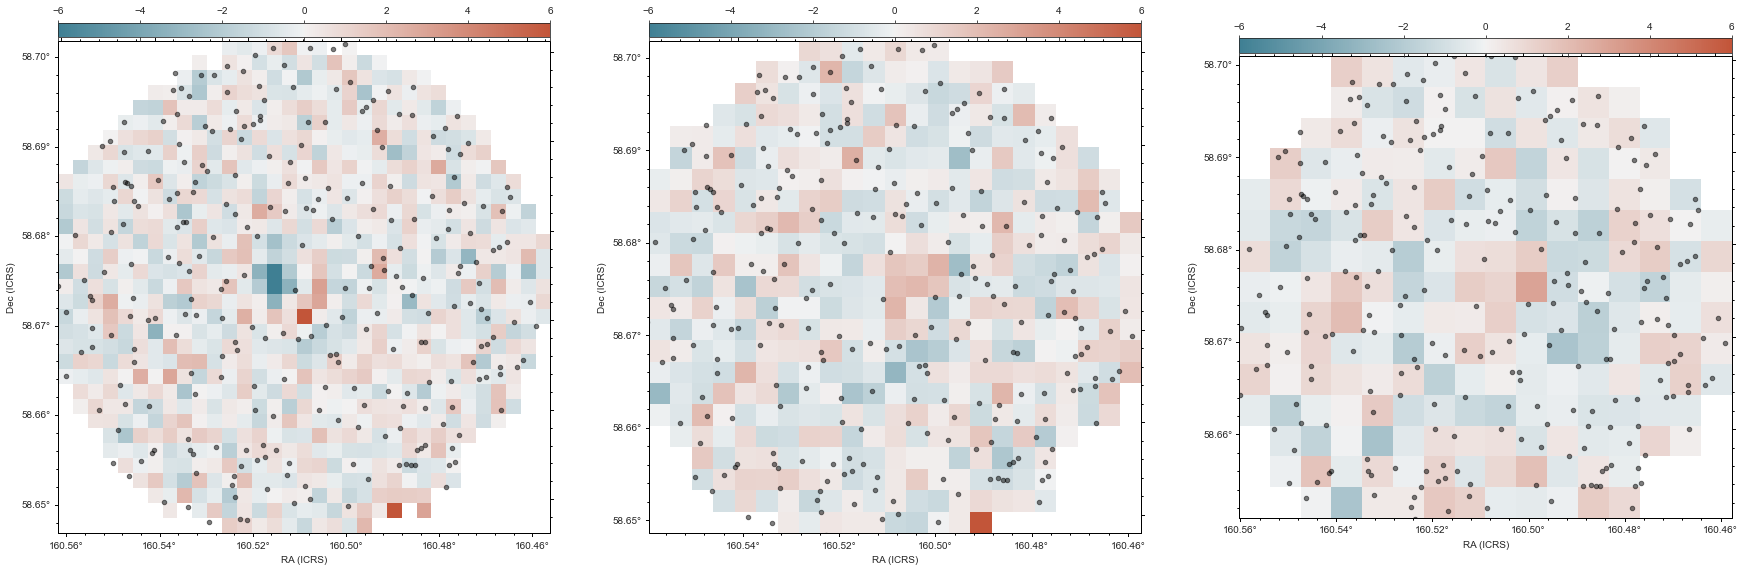

In [39]:
t=Bayes_pval_sources(fits_images)
if len(t)>0:
    priors,prior_list=process_prior(t,
                    path_to_data=['../../../data/'],
                      source=source,
                      field=field,
                      path_to_SPIRE=path_to_SPIRE,
                      redshift_file=redshift_file,
                      redshift_prior=[0.1,2.0],radius=10,alt_model=True)
    xidplus.save(priors,None,'./output/{}/prior_'.format(field[0])+esb['field'][source[0]]+'_'+str(source[0])+'_model2_alt')
    prior_list.write('./output/{}/prior_list_'.format(field[0])+esb['field'][source[0]]+'_'+str(source[0])+'_model2_alt.ascii',format='ascii',overwrite=True)
    hier_params={'m_mu':0.8,'m_sig':0.4,'c_mu':-1.0,'c_sig':0.5,'sfr_disp':0.5}
    phys_prior=create_phys_prior(priors,prior_list,emulator_path)
    mcmc=fit_model(phys_prior,hier_params,num_samples=500, num_warmup=500,num_chains=n_chains,chain_method='parallel')

    ## For numpyro to sample from the prior, the data needs to be set to None
    import copy
    #make a deepcopy of the priors
    priors_prior_pred=copy.deepcopy(priors)
    #set data to None
    for i in range(0,len(priors)):
        priors_prior_pred[i].sim=None
    #sample from the prior using numpyro's Predictive function
    prior_predictive=Predictive(SED_prior.spire_model_CIGALE,posterior_samples = {}, num_samples = 1000,)
    prior_pred=prior_predictive(random.PRNGKey(0),priors_prior_pred,phys_prior,hier_params)
    
    #sample from the prior using numpyro's Predictive function
    prior_predictive_samp=Predictive(SED_prior.spire_model_CIGALE,posterior_samples = mcmc.get_samples(), num_samples = 50)
    prior_pred_samp=prior_predictive_samp(random.PRNGKey(0),priors_prior_pred,phys_prior,hier_params)
    mod_map_array_samp=[prior_pred_samp['obs_psw'].T,prior_pred_samp['obs_pmw'].T,prior_pred_samp['obs_plw'].T]
    samples=mcmc.get_samples()
    divergences=mcmc.get_extra_fields()['diverging']
    numpyro_data = az.from_numpyro(
        mcmc,
        prior=prior_pred,
        posterior_predictive=prior_pred_samp,
        coords={"src": np.arange(0,priors[0].nsrc),
               "band":np.arange(0,3)},
        dims={"agn": ["src"],
             "bkg":["band"],
             "redshift":["src"],
              "sfr":["src"]},
        )
    numpyro_data.to_netcdf('./output/{}/posterior_'.format(field[0])+esb['field'][source[0]]+'_'+str(source[0])+'_model2_alt.nc')
    from xidplus import postmaps
    import aplpy
    sns.set_style("white")
    cmap = sns.diverging_palette(220, 20, as_cmap=True)
    Bayes_pvals = []
    hdulists = list(map(lambda prior: postmaps.make_fits_image(prior, prior.sim), priors))
    fig = plt.figure(figsize=(10 * len(priors), 10))
    figs = []
    for i in range(0, len(priors)):
        figs.append(aplpy.FITSFigure(hdulists[i][1], figure=fig, subplot=(1, len(priors), i + 1)))
        Bayes_pvals.append(postmaps.make_Bayesian_pval_maps(priors[i], mod_map_array_samp[i]))


    for i in range(0, len(priors)):
        figs[i].show_markers(priors[i].sra, priors[i].sdec, edgecolor='black', facecolor='black',
                             marker='o', s=20, alpha=0.5)
        figs[i].tick_labels.set_xformat('dd.dd')
        figs[i].tick_labels.set_yformat('dd.dd')
        figs[i]._data[
            priors[i].sy_pix - np.min(priors[i].sy_pix) - 1, priors[i].sx_pix - np.min(priors[i].sx_pix) - 1] = \
        Bayes_pvals[i]
        figs[i].show_colorscale(vmin=-6, vmax=6, cmap=cmap)
        figs[i].add_colorbar()
        figs[i].colorbar.set_location('top')